In [1]:

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


# from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
from util import *

In [ ]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833

import torch
import torch.nn as nn
import pdb

from util import get_clones


#自定义激活函数Wavelet：w1 * sin(x) + w2 * cos(x)
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        #自定义两个可学习参数w1和w2，初始化为1，训练过程中会更新这两个参数
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

#MLP组件，第一层形状为(d_model, d_ff)，第二层形状为(d_ff, d_ff)，第三层形状为(d_ff, d_model)，前两个使用自定义激活函数WaveAct
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)

#编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) #多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数
        
    def forward(self, x): #形状为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #对输入x应用激活函数
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0] #多头注意力机制，查询、键和值均为原始输入经过激活函数后的x2，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #对自注意力的输出应用激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到编码器的输出
        return x 


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) # 多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数

    def forward(self, x, e_outputs): #输入形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #将解码器输入x通过激活函数
        x = x + self.attn(x2, e_outputs, e_outputs)[0] #多头注意力机制，查询为解码器输入经过激活函数后的x2，键和值为编码器的输出e_outputs，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #将自注意力的输出通过激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到解码器的输出
        return x

#编码器层，包含多个堆叠的编码器架构
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表编码器的头数，N代表包含几个编码器，d_model是数据的嵌入维度（用于每个编码器），heads是头的数量
        super(Encoder, self).__init__()
        self.N = N 
        self.layers = get_clones(EncoderLayer(d_model, heads), N) #N个编码器
        self.act = WaveAct()

    def forward(self, x): #输入一次通过N个编码器，x的形状为(点的数量，序列长度，d_model)
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x) #编码器的输出要经过激活函数

#解码器层，包含多个堆叠的解码器架构
class Decoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表解码器的头数，N代表包含几个解码器，d_model是数据的嵌入维度（用于每个解码器），heads是头的数量
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N) #N个解码器
        self.act = WaveAct()
        
    def forward(self, x, e_outputs): #输入一次通过N个解码器层，x的形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        for i in range(self.N): #输入和编码器输出依次通过N个解码器
            x = self.layers[i](x, e_outputs) 
        return self.act(x) #解码器的输出要经过激活函数



class DNN(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads): #接受参数为：d_out代表整个模型的输出的维度（就是最后的mlp层的输出维度），d_model代表每个点的特征嵌入维度，d_hidden代表最后的output layer模块中的隐藏层的维度，N代表编码器和解码器的层数，heads代表多头注意力机制的头数
        super(DNN, self).__init__()

        self.linear_emb = nn.Linear(2, d_model) #线性层，将输入的2维数据映射到d_model维度

        self.encoder = Encoder(d_model, N, heads) #编码器层
        self.decoder = Decoder(d_model, N, heads) #解码器层

        #输出的mlp模块，包含三个线性层，前两个使用自定义激活函数WaveAct，最终将feature从d_model维度映射到d_hidden维度，最后将d_hidden维度映射到d_out维度
        self.linear_hidden = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, 2),
        ])
        self.linear_out = nn.Sequential(*[
            WaveAct(),
            nn.Linear(2, d_out)
        ])

    def forward(self, x): #输入的x形状一般为(点的数量, 序列长度, 2)
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output #(点的数量，序列长度，d_out)
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        # output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output_hidden #(点的数量，序列长度，2)

    
   

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, b_left, b_right, b_upper, b_lower, X_f, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)

        X_f = make_time_sequence(X_f, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 

        b_left = make_time_sequence(b_left, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_right = make_time_sequence(b_right, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        
        # data
        #配位点数据
        self.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device)

        self.x_left = torch.tensor(b_left[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1)\n",
        self.t_left = torch.tensor(b_left[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_right = torch.tensor(b_right[:,:, 0:1], requires_grad=True).float().to(device) 
        self.t_right = torch.tensor(b_right[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_upper = torch.tensor(b_upper[:,:, 0:1], requires_grad=True).float().to(device) 
        self.t_upper = torch.tensor(b_upper[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_lower = torch.tensor(b_lower[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_lower = torch.tensor(b_lower[:,:, 1:2], requires_grad=True).float().to(device)
        
        
        # deep neural networks
        self.dnn = DNN(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device) 
        self.dnn.apply(self.init_weights) #初始化模型中线性层的权重和偏置
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        # self.optimizer_LBFGS = torch.optim.LBFGS(
        #     self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
        #     lr=1.0,  #学习率设置为1
        #     max_iter=50000,  #最大迭代次数为50000
        #     max_eval=50000,  #最大评估次数为50000
        #     history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
        #     # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
        #     # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
        #     line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        # )
        self.optimizer_LBFGS = torch.optim.LBFGS(self.dnn.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

    #初始化神经网络的线性层权重参数，使用Xavier初始化权重，偏置则初始化为0.01
    def init_weights(self, m):
        if isinstance(m, nn.Linear): #判断是否是线性层
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
        
    #输入是两个(点的数量，序列长度，1)，输出(点的数量，序列长度，1)
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=-1))  #合并为(点的数量，序列长度，2)
        return u
    
    #输入是两个(点的数量，序列长度，1)
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #输出(点的数量，序列长度，1)
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        
        f=u_t - 5 * u * (1-u) #计算f，定义见论文
        return f #(点的数量，序列长度，1)
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        pred_upper = self.net_u(self.x_upper, self.t_upper) #输出(点的数量，序列长度，1)
        pred_lower = self.net_u(self.x_lower, self.t_lower) #输出(点的数量，序列长度，1)\n",
        pred_left = self.net_u(self.x_left, self.t_left) #输出(点的数量，序列长度，1)\n",
        f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)\n",

        #计算损失，共三项损失\n",
        loss_res = torch.mean(f_pred ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (self.x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

        loss = loss_res + loss_bc + loss_ic
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数

        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        return loss #返回loss

      
    
    def train(self, nIter, nIterLBFGS):
        self.dnn.train()#将神经网络设置为训练模式而不是评估模式
        #先使用Adam优化器优化nIter次\n",
        for epoch in tqdm(range(nIter), desc='Adam'):
            pred_upper = self.net_u(self.x_upper, self.t_upper) #输出(点的数量，序列长度，1)\n",
            pred_lower = self.net_u(self.x_lower, self.t_lower) #输出(点的数量，序列长度，1)\n",
            pred_left = self.net_u(self.x_left, self.t_left) #输出(点的数量，序列长度，1)\n",
            f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)\n",

            #计算损失，共三项损失
            loss_res = torch.mean(f_pred ** 2)
            loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
            loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (self.x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

            loss = loss_res + loss_bc + loss_ic

            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）\n",
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数\n",
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化\n",

            #record the loss value\n",
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中\n",

        #Backward the optimize，使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次\n",
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式\n",
            self.optimizer_LBFGS.step(self.loss_func)  #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入计算损失函数的方法self.loss_func，进行优化   \n",

 

  


    def predict(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u = self.net_u(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
            u = u[:,0:1].reshape(-1,1) #将u的形状从(点的数量，序列长度，1)变为(点的数量，1)
            u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上

        return u #u形状是(点的数量，1)，f形状是(点的数量，1)
    
    def residual(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        
        f = self.net_f(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
        f = torch.mean(f, dim=1).reshape(-1,1) #对f在序列长度维度上求平均，得到(点的数量，1)，即每个点的平均残差
        # f = f[:,0:1].reshape(-1,1) #将f的形状从(点的数量，序列长度，1)变为(点的数量，1)
        f = f.detach().cpu().numpy()
        return f #u形状是(点的数量，1)，f形状是(点的数量，1)
    

    def hidden_predict(self, X):#形状(点的数量，序列长度，2)
        x = torch.tensor(X[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        with torch.no_grad():
            hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=-1)) #(点的数量，序列长度，2)
            hidden_output = hidden_output.detach().cpu().numpy()
        # hidden_output_x = hidden_output[:, 0]
        # hidden_output_t = hidden_output[:, 1]
        # hidden_output_x = hidden_output_x.detach().cpu().numpy()
        # hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output #(点的数量，序列长度，2)
    

In [5]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [6]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter): #输入是(点的数量，2)
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    X0 = X
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    xs = []
    X0 = make_time_sequence(X0, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X = model.hidden_predict(X0) #(点的数量，序列长度，2)
    
    for i in range(num_iter): #循环num_iter次
        X = model.hidden_predict(X) #(点的数量，序列长度，2)
        xs.append(X) #新添加(点的数量，序列长度，2)

    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    X1 = np.concatenate((x1, t1), axis=1) #(N_f_new,2)形状
    X1 = make_time_sequence(X1, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X1 = model.hidden_predict(X1) #(N_f_new,序列长度,2)

    for i in range(num_iter): #循环num_iter次
        X1 = model.hidden_predict(X1) #(N_f_new,序列长度,
        xs1.append(X1) #新添加(N_f_new,序列长度,2)

    

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t,使用chunchaos要注释掉
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=(1,2))
    distances = distances.flatten()







    # #chunchaos方法
    # num_elements_to_average = 20
    # # 提取最后 20 个元素
    # last_20_xs = xs[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # last_20_xs1 = xs1[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # # 存储每个时间步（列表中的每个元素）的混沌度分数
    # step_chaos_scores = []
    # # 遍历最后 20 个元素,zip 将两个列表的对应元素配对
    # for step_xs, step_xs1 in zip(last_20_xs, last_20_xs1):
    #     # step_xs 和 step_xs1 都是形状为 (N_f_new, sequence_length, 2) 的数组/张量
    #     difference_step = step_xs - step_xs1 # 计算差异
    #     # 计算每个数据点在当前步的混沌度分数 (形状 (N_f_new,))
    #     # 假设使用 NumPy 进行计算
    #     step_scores = np.linalg.norm(difference_step, axis=(1, 2))
    #     # 将这 N_f_new 个分数添加到列表中
    #     step_chaos_scores.append(step_scores)

    # # step_chaos_scores 是一个包含 20 个元素的列表，每个元素都是形状为 (N_f_new,) 的 NumPy 数组
    # # 将列表转换成一个单一的 NumPy 数组，形状为 (20, N_f_new)
    # all_step_scores = np.stack(step_chaos_scores)
    # # 现在 all_step_scores 的形状是 (num_elements_to_average, N_f_new)
    # # axis 0 是时间步 (20)，axis 1 是原始数据点 (N_f_new)
    # # 计算最后 20 个时间步在每个数据点上的平均混沌度分数
    # # 沿着时间步轴 (axis=0) 求平均
    # distances = np.mean(all_step_scores, axis=0)
    # # 结果形状是 (N_f_new,)







    return distances

In [ ]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子\n",
# seeds = [0]

N_f = 51*51

lb = np.array([0.0, 0.0])
ub = np.array([2 * np.pi, 1.0])

# Train PINNsformer
_, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51) #51代表初值点、边界值点数量！！
X_star, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101) #生成测试数据，采样点数为101x101,这里的X_star就是res_test

error_u = [] #创建一个空列表，用于存储误差
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

nIter = 10000 #设置迭代次数为10000
nIterLBFGS = 500 #设置LBFGS迭代次数为500

def hh(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return hh(x) * np.exp(5*t) / ( hh(x) * np.exp(5*t) + 1 - hh(x))

for seed in seeds:
    set_seed(seed) #设置随机数种子
    # --- 1. 参数设置 ---
    nIter = 10000
    nIterLBFGS = 500
    # ... 其他参数 ...

    # --- 2. 初始化 ---
    N_f_1 = N_f // 20
    X_f_train = lb + (ub - lb) * lhs(2, N_f_1)

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(b_left, b_right, b_upper, b_lower, X_f_train, lb, ub)

    # 【新】创建巨大、固定的候选点池
    N_f_candidate = N_f * 2
    X_f_candidate = lb + (ub - lb) * lhs(2, N_f_candidate)
    is_point_selected_mask = np.zeros(N_f_candidate, dtype=bool) #布尔掩码，形状是(N_f_candidate,)，初始值为False，表示所有点都未被选择
    

    # --- 3. 初始训练 ---
    start_time = time.time()
    model.train(nIter // 20, 0)

    # --- 4. 主动学习循环 ---
    # 计算总轮数,这里是19
    num_active_rounds = (nIter - nIter // 20) // (nIter // 20)
    # 每轮训练中记录的检查点数量，其实就是后面的T
    num_checkpoints_per_round = 10
    # 两次检查点之间的训练迭代次数
    epochs_between_checkpoints = (nIter // 20) // num_checkpoints_per_round

    # 用于存储每一轮最终预测的全局历史
    global_final_predictions = []

    for i in range(num_active_rounds):        
        # a. 训练并记录预测历史
        prediction_history = []
        # 记录当前模型在整个候选池上的预测输出
        
        for j in range(num_checkpoints_per_round):
            model.train(epochs_between_checkpoints, 0)
            
            # 记录当前模型在整个候选池上的预测输出
            predictions = model.predict(X_f_candidate) # 返回 (N, 1) 的Numpy数组
            # prediction_history.append(predictions.flatten()) # 存为一维数组，每个元素形状为 (N, ) 
            prediction_history.append(predictions) # 存为二维数组，每个元素形状为 (N, 1)
        local_prediction_history = prediction_history

        # b. 计算不稳定性分数 g(x) = Σ v_t * a_t(x)
        # 将历史记录转为矩阵 (T+1, N_candidates,1)
        local_history_matrix = np.array(local_prediction_history)
        T_local, num_candidates, _ = local_history_matrix.shape #T表示共存储了多少个模型的预测结果，num_candidates表示候选点的数量

        # 获取最终预测u_T(x)
        local_final_prediction = local_history_matrix[-1, :, :] # (N_candidates, 1) 的数组

        # 计算不一致性矩阵 a_t(x) = |u_t(x) - u_T(x)|
        # 利用 NumPy 的广播机制高效计算，具体为(T, N_candidates,1)-(N_candidates,1)（相当于用T个元素分别和最后一个元素相减）,最后得到的形状是(T, N_candidates)
        # disagreement_matrix_A = np.abs(prediction_history_matrix - final_prediction_vec)
        local_disagreement = np.linalg.norm(local_history_matrix - local_final_prediction, ord=2, axis=-1)

        # 计算时间权重向量 v_t = (t/T)^k
        t_local = np.arange(1, T_local + 1) #形状是(T,)的数组
        k_local = 1.0  # 权重指数，可以作为超参数调整
        v_local = (t_local / T_local) ** k_local #形状是(T,)

        # 计算最终不稳定性分数 g(x)
        # g = V^T * A (矩阵乘法概念)
        # 实际操作：将权重向量V变形以进行逐元素乘法，然后在时间轴上求和
        # v_local（也就是V）的形状是(T,)，local_disagreement（也就是A）的形状是(T, N_candidates)
        # V[:, np.newaxis] 将V变为 (T, 1)，可以与A进行广播乘法
        g_micro = np.sum(v_local[:, np.newaxis] * local_disagreement, axis=0) #求和前形状为 (T, N_candidates)，求和后形状为(N_candidates,)

        
        # c. 更新并计算【宏观不稳定性 g_macro】
        # ------------------------------------------------------------------
        # 将本轮的最终预测加入全局历史列表
        global_final_predictions.append(local_final_prediction)
        
        g_macro = np.zeros(num_candidates) # 如果历史太短，宏观不稳定性为0
        
        # 只有当全局历史足够长时（至少有两次最终预测），计算才有意义
        if len(global_final_predictions) > 1:
            global_history_matrix = np.array(global_final_predictions)
            T_global, _, _ = global_history_matrix.shape # T_global 是当前的主动学习轮数 i+1
            
            # 使用全局最新的预测作为基准
            global_final_prediction = global_history_matrix[-1, :, :]
            
            # 计算宏观不一致性
            global_disagreement = np.linalg.norm(global_history_matrix - global_final_prediction, ord=2, axis=-1)
            
            # 【宏观 t, k】
            t_global = np.arange(1, T_global + 1)
            k_macro = 2.0 # 宏观时间尺度上，可以给后期变化更大的惩罚，所以k可以更大
            v_global = (t_global / T_global) ** k_macro
            
            # 计算宏观不稳定性分数
            g_macro = np.sum(v_global[:, np.newaxis] * global_disagreement, axis=0)


        # d. 融合分数
        # ------------------------------------------------------------------
        # 在融合前，对两种分数进行归一化，使其尺度相当，避免其中一个主导
        # 这是一个很好的实践，可以防止数值问题
        if np.std(g_micro) > 1e-6:
            g_micro_norm = (g_micro - np.mean(g_micro)) / np.std(g_micro)
        else:
            g_micro_norm = np.zeros_like(g_micro)

        if np.std(g_macro) > 1e-6:
            g_macro_norm = (g_macro - np.mean(g_macro)) / np.std(g_macro)
        else:
            g_macro_norm = np.zeros_like(g_macro)
            
        # 设置融合权重
        w_micro = 0.5
        w_macro = 0.5
        
        instability_scores_g = w_micro * g_micro_norm + w_macro * g_macro_norm



        batch_size = N_f_candidate // 10 # 设置批处理大小为候选点数量的十分之一，避免显存爆炸
        all_residuals = [] # 创建一个空列表来存储每个批次的残差结果


        # 循环处理每个批次
        for i in range(0, N_f_candidate, batch_size):
            # 获取当前批次的数据
            X_batch = X_f_candidate[i : i + batch_size]
            
            # 对当前批次计算残差
            # model.residual 内部的计算量大大减小，不会爆显存了
            residual_batch = model.residual(X_batch) # 返回 (batch_size, 1) 的 NumPy 数组
            
            # 将当前批次的结果添加到列表中
            all_residuals.append(residual_batch)

        # 将所有批次的结果拼接成一个大的 NumPy 数组
        residual = np.vstack(all_residuals) # vstack 用于垂直堆叠

        # --- 后续处理不变 ---
        # 计算残差的绝对值
        abs_residual = np.abs(residual)
        # 将二维数组转换为一维数组
        abs_residual = abs_residual.flatten()



        #进行归一化
        epsilon = 1e-5
        
        norm_residual = np.linalg.norm(abs_residual)
        if norm_residual > epsilon:
            abs_residual = abs_residual / norm_residual
        else:
            abs_residual = np.zeros_like(abs_residual)
        # norm_distances = np.linalg.norm(distances)
        # if norm_distances > epsilon:
        #     distances = distances / norm_distances
        # else:
        #     distances = np.zeros_like(distances)

        norm_instability = np.linalg.norm(instability_scores_g)
        if norm_instability > epsilon:
            instability_scores_g = instability_scores_g / norm_instability
        else:
            instability_scores_g = np.zeros_like(instability_scores_g)

        xinxi = abs_residual #将残差和不稳定性分数相加，得到新的分数


        # e. 选择新的点
        # 屏蔽已选中的点，防止重复选择
        xinxi[is_point_selected_mask] = -1.0
        
        # 找出分数最高的 N_f_1 个点的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:]
        
        # 提取新点
        X_f_train_topk = X_f_candidate[topk_indices]
        
        # f. 更新训练集和掩码
        X_f_train = np.vstack((X_f_train, X_f_train_topk))
        is_point_selected_mask[topk_indices] = True


        # e. 更新模型内部的配位点
        X_f = make_time_sequence(X_f_train, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        
        #配位点数据
        model.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device)
        model.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device)



    model.train(0,nIterLBFGS) #使用LBFGS训练500次


    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    #用训练好的模型进行预测，返回四个值（均为数组）  
    u_pred = model.predict(X_star).flatten()

    # u_pred = u_pred.reshape(101,101)

    u_star = u_ana(X_star[:,0], X_star[:,1])
    # .reshape(101,101)\n",


    #计算误差（基于2范数）        
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE







    

/tmp/ipykernel_2565796/1511102223.py:65: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)



Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   0%|          | 1/500 [00:00<00:50,  9.81it/s]


Adam:   2%|▏         | 10/500 [00:00<00:08, 55.31it/s]


Adam:   4%|▍         | 19/500 [00:00<00:07, 67.74it/s]


Adam:   6%|▌         | 28/500 [00:00<00:06, 75.07it/s]


Adam:   7%|▋         | 36/500 [00:00<00:06, 75.07it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 79.02it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 81.36it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 83.09it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 84.14it/s]


Adam:  16%|█▌        | 81/500 [00:01<00:04, 84.48it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 85.21it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 85.77it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 85.96it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 86.14it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 86.32it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 86.29it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 86.10it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 86.32it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 86.50it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 86.25it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 86.26it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 85.26it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 85.35it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 85.63it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 85.58it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 86.17it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 86.25it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.40it/s]


Adam:  50%|█████     | 252/500 [00:03<00:02, 86.66it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 86.68it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 83.28it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 83.98it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 84.08it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 84.66it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 85.14it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 85.64it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 82.67it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 84.09it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 84.67it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 85.44it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 85.36it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 85.15it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 84.54it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 85.11it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 85.32it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 85.74it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:00, 86.17it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 86.12it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 85.98it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 86.15it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 85.01it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 85.32it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.67it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.05it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 75.15it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 77.46it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 83.34it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 85.24it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 85.31it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 83.52it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 83.74it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 84.16it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 84.40it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 84.78it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 85.26it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 85.63it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 85.77it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 83.50it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:05, 77.10it/s]


Adam:  23%|██▎       | 116/500 [00:01<00:05, 74.39it/s]


Adam:  25%|██▌       | 125/500 [00:01<00:04, 77.40it/s]


Adam:  27%|██▋       | 134/500 [00:01<00:04, 79.89it/s]


Adam:  29%|██▊       | 143/500 [00:01<00:04, 81.59it/s]


Adam:  30%|███       | 152/500 [00:01<00:04, 82.64it/s]


Adam:  32%|███▏      | 161/500 [00:01<00:04, 83.76it/s]


Adam:  34%|███▍      | 170/500 [00:02<00:03, 84.31it/s]


Adam:  36%|███▌      | 179/500 [00:02<00:03, 84.85it/s]


Adam:  38%|███▊      | 188/500 [00:02<00:03, 85.41it/s]


Adam:  39%|███▉      | 197/500 [00:02<00:03, 85.69it/s]


Adam:  41%|████      | 206/500 [00:02<00:03, 85.65it/s]


Adam:  43%|████▎     | 215/500 [00:02<00:03, 85.74it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 85.92it/s]


Adam:  47%|████▋     | 233/500 [00:02<00:03, 86.13it/s]


Adam:  48%|████▊     | 242/500 [00:02<00:02, 86.33it/s]


Adam:  50%|█████     | 251/500 [00:02<00:02, 86.33it/s]


Adam:  52%|█████▏    | 260/500 [00:03<00:02, 86.26it/s]


Adam:  54%|█████▍    | 269/500 [00:03<00:02, 86.54it/s]


Adam:  56%|█████▌    | 278/500 [00:03<00:02, 86.25it/s]


Adam:  57%|█████▋    | 287/500 [00:03<00:02, 85.94it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 85.05it/s]


Adam:  61%|██████    | 305/500 [00:03<00:02, 85.31it/s]


Adam:  63%|██████▎   | 314/500 [00:03<00:02, 85.58it/s]


Adam:  65%|██████▍   | 323/500 [00:03<00:02, 85.74it/s]


Adam:  66%|██████▋   | 332/500 [00:03<00:01, 85.94it/s]


Adam:  68%|██████▊   | 341/500 [00:04<00:01, 86.15it/s]


Adam:  70%|███████   | 350/500 [00:04<00:01, 86.22it/s]


Adam:  72%|███████▏  | 359/500 [00:04<00:01, 84.12it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 84.46it/s]


Adam:  75%|███████▌  | 377/500 [00:04<00:01, 85.18it/s]


Adam:  77%|███████▋  | 386/500 [00:04<00:01, 85.13it/s]


Adam:  79%|███████▉  | 395/500 [00:04<00:01, 85.28it/s]


Adam:  81%|████████  | 404/500 [00:04<00:01, 85.71it/s]


Adam:  83%|████████▎ | 413/500 [00:04<00:01, 86.17it/s]


Adam:  84%|████████▍ | 422/500 [00:04<00:00, 86.11it/s]


Adam:  86%|████████▌ | 431/500 [00:05<00:00, 86.18it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 86.41it/s]


Adam:  90%|████████▉ | 449/500 [00:05<00:00, 86.42it/s]


Adam:  92%|█████████▏| 458/500 [00:05<00:00, 86.39it/s]


Adam:  93%|█████████▎| 467/500 [00:05<00:00, 86.38it/s]


Adam:  95%|█████████▌| 476/500 [00:05<00:00, 86.21it/s]


Adam:  97%|█████████▋| 485/500 [00:05<00:00, 86.32it/s]


Adam:  99%|█████████▉| 494/500 [00:05<00:00, 86.38it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 84.80it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 86.47it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 86.41it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 86.36it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 86.44it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 86.44it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 86.42it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 85.84it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 85.82it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.20it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 86.34it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 86.46it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 86.26it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 85.93it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 85.97it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 85.41it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 85.89it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 86.13it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 86.10it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 85.97it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 86.09it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 86.02it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 84.85it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 83.59it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 84.41it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 84.51it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 84.69it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 84.99it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 85.47it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 85.89it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 86.09it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 86.27it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 86.08it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 85.89it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 85.55it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 85.58it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 85.94it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 86.00it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 86.06it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 85.96it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 85.83it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 85.93it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 85.96it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 85.94it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 84.53it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 84.89it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 85.00it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 85.51it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 85.76it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 86.10it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 86.06it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 85.70it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.58it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.88it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 86.10it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 86.18it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.77it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 85.44it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 85.36it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 85.34it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 85.67it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 84.39it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 85.10it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 83.24it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 83.88it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 84.24it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 84.30it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.48it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 84.81it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 81.27it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 80.28it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 81.81it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 83.14it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 83.85it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:04, 84.40it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 84.50it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 84.76it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 85.05it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 85.39it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 85.34it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 84.38it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 83.45it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 84.20it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 84.59it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 84.89it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 82.75it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 83.73it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 84.24it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 84.58it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 83.88it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 80.72it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 82.05it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 83.20it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 83.96it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 84.22it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 84.10it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 84.32it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 84.66it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 84.83it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 85.21it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 85.06it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 85.21it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 85.16it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 85.10it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 84.90it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 85.04it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 85.22it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 85.15it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.19it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.06it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 85.24it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 85.36it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 84.03it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 84.65it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 83.98it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 83.82it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 84.16it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 84.07it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 76.82it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 78.86it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 80.48it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 81.61it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 82.06it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 80.96it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 81.76it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 82.36it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 82.10it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 82.51it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 82.96it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 83.58it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:04, 83.66it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 83.66it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 83.77it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 83.79it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 83.84it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 84.01it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 84.14it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 83.49it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 83.59it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 83.58it/s]


Adam:  50%|█████     | 252/500 [00:03<00:02, 83.66it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 83.62it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 83.65it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 83.72it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 83.75it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 83.72it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 83.44it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 83.51it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 83.66it/s]


Adam:  67%|██████▋   | 333/500 [00:04<00:01, 83.66it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 83.42it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 83.51it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 83.38it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 83.34it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 83.44it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 83.51it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 83.62it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 83.59it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 83.51it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 83.77it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 83.74it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 83.50it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 83.76it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 83.59it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 83.39it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 83.19it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 83.45it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 83.68it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 83.16it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 81.15it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 81.06it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 80.54it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 80.81it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 80.82it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 80.94it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 81.09it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 81.07it/s]


Adam:  16%|█▌        | 81/500 [00:01<00:05, 80.94it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:05, 81.03it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 80.86it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 81.00it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 81.07it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 80.82it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 80.78it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 80.65it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 80.73it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:04, 81.24it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:04, 80.89it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 81.01it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 81.08it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 80.35it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 80.69it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 80.93it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 80.96it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 81.10it/s]


Adam:  49%|████▊     | 243/500 [00:03<00:03, 81.30it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 81.31it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 81.41it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 81.22it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 81.21it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 81.18it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 81.19it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 81.00it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 81.06it/s]


Adam:  65%|██████▍   | 324/500 [00:04<00:02, 81.08it/s]


Adam:  67%|██████▋   | 333/500 [00:04<00:02, 81.18it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 81.26it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 81.17it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 81.23it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 81.30it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 81.23it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 81.14it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 81.32it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 81.16it/s]


Adam:  83%|████████▎ | 414/500 [00:05<00:01, 81.07it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 81.12it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 79.92it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 78.62it/s]


Adam:  90%|████████▉ | 449/500 [00:05<00:00, 79.37it/s]


Adam:  92%|█████████▏| 458/500 [00:05<00:00, 79.99it/s]


Adam:  93%|█████████▎| 466/500 [00:05<00:00, 79.97it/s]


Adam:  95%|█████████▌| 475/500 [00:05<00:00, 80.21it/s]


Adam:  97%|█████████▋| 484/500 [00:05<00:00, 80.18it/s]


Adam:  99%|█████████▊| 493/500 [00:06<00:00, 80.41it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 80.85it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 71.18it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 75.55it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 77.42it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 77.96it/s]


Adam:   8%|▊         | 40/500 [00:00<00:05, 78.53it/s]


Adam:  10%|▉         | 48/500 [00:00<00:05, 78.71it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 78.93it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 79.01it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 79.00it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 78.92it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 79.05it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 78.87it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 79.16it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:04, 79.14it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:04, 78.78it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 78.79it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 78.92it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 79.20it/s]


Adam:  30%|███       | 152/500 [00:01<00:04, 79.24it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 79.20it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 77.52it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 77.50it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 77.95it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:03, 78.49it/s]


Adam:  40%|████      | 200/500 [00:02<00:03, 77.57it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 77.99it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 77.54it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 78.20it/s]


Adam:  46%|████▋     | 232/500 [00:02<00:03, 78.60it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 79.00it/s]


Adam:  50%|████▉     | 249/500 [00:03<00:03, 79.35it/s]


Adam:  51%|█████▏    | 257/500 [00:03<00:03, 75.83it/s]


Adam:  53%|█████▎    | 265/500 [00:03<00:03, 76.64it/s]


Adam:  55%|█████▍    | 273/500 [00:03<00:02, 77.49it/s]


Adam:  56%|█████▌    | 281/500 [00:03<00:02, 77.46it/s]


Adam:  58%|█████▊    | 289/500 [00:03<00:02, 77.94it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 76.59it/s]


Adam:  61%|██████    | 305/500 [00:03<00:02, 77.48it/s]


Adam:  63%|██████▎   | 313/500 [00:04<00:02, 78.16it/s]


Adam:  64%|██████▍   | 321/500 [00:04<00:02, 78.55it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 78.77it/s]


Adam:  67%|██████▋   | 337/500 [00:04<00:02, 79.06it/s]


Adam:  69%|██████▉   | 345/500 [00:04<00:01, 79.28it/s]


Adam:  71%|███████   | 353/500 [00:04<00:01, 79.18it/s]


Adam:  72%|███████▏  | 361/500 [00:04<00:01, 79.25it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 79.37it/s]


Adam:  75%|███████▌  | 377/500 [00:04<00:01, 79.47it/s]


Adam:  77%|███████▋  | 386/500 [00:04<00:01, 79.64it/s]


Adam:  79%|███████▉  | 394/500 [00:05<00:01, 77.72it/s]


Adam:  81%|████████  | 403/500 [00:05<00:01, 78.46it/s]


Adam:  82%|████████▏ | 411/500 [00:05<00:01, 76.93it/s]


Adam:  84%|████████▍ | 419/500 [00:05<00:01, 76.92it/s]


Adam:  85%|████████▌ | 427/500 [00:05<00:00, 77.65it/s]


Adam:  87%|████████▋ | 435/500 [00:05<00:00, 77.91it/s]


Adam:  89%|████████▊ | 443/500 [00:05<00:00, 78.31it/s]


Adam:  90%|█████████ | 451/500 [00:05<00:00, 78.70it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 78.96it/s]


Adam:  93%|█████████▎| 467/500 [00:05<00:00, 79.17it/s]


Adam:  95%|█████████▌| 475/500 [00:06<00:00, 79.32it/s]


Adam:  97%|█████████▋| 483/500 [00:06<00:00, 79.38it/s]


Adam:  98%|█████████▊| 491/500 [00:06<00:00, 76.55it/s]


Adam: 100%|█████████▉| 499/500 [00:06<00:00, 77.34it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 78.24it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 76.63it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 76.48it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 76.97it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 77.14it/s]


Adam:   8%|▊         | 40/500 [00:00<00:05, 77.15it/s]


Adam:  10%|▉         | 48/500 [00:00<00:05, 77.17it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 77.30it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 77.59it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 77.15it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 77.02it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 74.83it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 75.49it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 76.13it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 76.65it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:04, 76.52it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 76.82it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 76.99it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 77.17it/s]


Adam:  30%|███       | 152/500 [00:01<00:04, 77.26it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 77.08it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 77.27it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 77.11it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 77.16it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:03, 77.24it/s]


Adam:  40%|████      | 200/500 [00:02<00:03, 77.49it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 77.59it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 77.58it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 77.25it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 77.22it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 76.80it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 76.81it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 76.42it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 76.88it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:02, 77.03it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 77.24it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 77.34it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 77.53it/s]


Adam:  61%|██████    | 304/500 [00:03<00:02, 77.60it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 77.59it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 77.53it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 77.57it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 77.28it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 77.31it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 77.44it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 77.66it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 77.68it/s]


Adam:  75%|███████▌  | 376/500 [00:04<00:01, 77.81it/s]


Adam:  77%|███████▋  | 384/500 [00:04<00:01, 75.84it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 75.54it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 73.90it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 74.95it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 75.78it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:00, 76.30it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 76.68it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 76.87it/s]


Adam:  90%|████████▉ | 448/500 [00:05<00:00, 77.05it/s]


Adam:  91%|█████████ | 456/500 [00:05<00:00, 77.19it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 76.86it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 76.78it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 75.43it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 76.06it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 76.23it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 76.82it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 75.27it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 75.47it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 73.96it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 74.37it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 73.03it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 73.77it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 73.81it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 74.15it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 74.58it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 74.71it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 75.10it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 75.15it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 75.23it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 75.32it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 75.29it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 75.17it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 75.20it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 74.87it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 74.98it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 75.01it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 75.18it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 75.24it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 75.13it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 74.87it/s]


Adam:  40%|████      | 200/500 [00:02<00:04, 74.20it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 74.45it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 74.69it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 74.82it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 74.80it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 74.92it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 75.03it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 75.17it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 74.93it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 73.95it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 74.30it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 74.51it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 74.94it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 75.01it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 75.02it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 75.15it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 75.30it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 75.46it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 74.75it/s]


Adam:  70%|███████   | 352/500 [00:04<00:02, 73.92it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 74.20it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 74.61it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 74.61it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 74.66it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 74.86it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 74.84it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 73.71it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 74.23it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 73.16it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 73.76it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 73.99it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 74.49it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 74.74it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 75.02it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 75.02it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 74.99it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 74.93it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 73.09it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 74.60it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 72.03it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 71.38it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 71.50it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 71.48it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 71.51it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 71.41it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 71.30it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:06, 70.73it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:06, 71.18it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 71.26it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 71.30it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 71.35it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 71.44it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 71.50it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 71.55it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:05, 71.46it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:05, 68.74it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:05, 69.33it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 69.94it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 70.47it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 70.76it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 71.27it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 71.34it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 71.35it/s]


Adam:  40%|████      | 200/500 [00:02<00:04, 71.38it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:04, 71.34it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 70.01it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:03, 70.44it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 70.79it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 71.03it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 71.32it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 71.49it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 71.50it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 71.28it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:03, 70.37it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:03, 68.96it/s]


Adam:  59%|█████▉    | 296/500 [00:04<00:02, 69.68it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 70.28it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 70.69it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 70.98it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 70.37it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 70.70it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 71.00it/s]


Adam:  70%|███████   | 352/500 [00:04<00:02, 71.12it/s]


Adam:  72%|███████▏  | 360/500 [00:05<00:01, 71.25it/s]


Adam:  74%|███████▎  | 368/500 [00:05<00:01, 71.35it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 71.43it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 71.42it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 71.69it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 71.77it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 71.75it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 71.75it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 71.55it/s]


Adam:  86%|████████▋ | 432/500 [00:06<00:00, 71.01it/s]


Adam:  88%|████████▊ | 440/500 [00:06<00:00, 71.18it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 71.43it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 71.63it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 71.71it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 71.79it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 71.79it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 71.73it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 71.80it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 71.10it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 69.64it/s]


Adam:   3%|▎         | 14/500 [00:00<00:06, 69.76it/s]


Adam:   4%|▍         | 22/500 [00:00<00:06, 70.04it/s]


Adam:   6%|▌         | 30/500 [00:00<00:06, 70.12it/s]


Adam:   8%|▊         | 38/500 [00:00<00:06, 69.97it/s]


Adam:   9%|▉         | 45/500 [00:00<00:06, 69.93it/s]


Adam:  10%|█         | 52/500 [00:00<00:06, 69.74it/s]


Adam:  12%|█▏        | 59/500 [00:00<00:06, 69.79it/s]


Adam:  13%|█▎        | 66/500 [00:00<00:06, 69.75it/s]


Adam:  15%|█▍        | 73/500 [00:01<00:06, 69.61it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:06, 69.63it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 69.76it/s]


Adam:  19%|█▉        | 95/500 [00:01<00:05, 69.69it/s]


Adam:  20%|██        | 102/500 [00:01<00:05, 69.24it/s]


Adam:  22%|██▏       | 109/500 [00:01<00:05, 69.36it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:05, 69.59it/s]


Adam:  25%|██▍       | 124/500 [00:01<00:05, 69.63it/s]


Adam:  26%|██▌       | 131/500 [00:01<00:05, 69.28it/s]


Adam:  28%|██▊       | 138/500 [00:01<00:05, 69.39it/s]


Adam:  29%|██▉       | 145/500 [00:02<00:05, 69.53it/s]


Adam:  30%|███       | 152/500 [00:02<00:05, 69.49it/s]


Adam:  32%|███▏      | 159/500 [00:02<00:04, 69.62it/s]


Adam:  33%|███▎      | 166/500 [00:02<00:04, 69.67it/s]


Adam:  35%|███▍      | 173/500 [00:02<00:04, 69.54it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:04, 69.74it/s]


Adam:  38%|███▊      | 188/500 [00:02<00:04, 69.81it/s]


Adam:  39%|███▉      | 195/500 [00:02<00:04, 69.82it/s]


Adam:  41%|████      | 203/500 [00:02<00:04, 69.88it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 69.78it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 69.55it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:03, 69.62it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:03, 69.54it/s]


Adam:  48%|████▊     | 239/500 [00:03<00:03, 69.72it/s]


Adam:  49%|████▉     | 246/500 [00:03<00:03, 69.67it/s]


Adam:  51%|█████     | 253/500 [00:03<00:03, 69.51it/s]


Adam:  52%|█████▏    | 260/500 [00:03<00:03, 68.54it/s]


Adam:  53%|█████▎    | 267/500 [00:03<00:03, 68.82it/s]


Adam:  55%|█████▌    | 275/500 [00:03<00:03, 69.21it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 69.20it/s]


Adam:  58%|█████▊    | 290/500 [00:04<00:03, 69.47it/s]


Adam:  59%|█████▉    | 297/500 [00:04<00:02, 69.52it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 69.62it/s]


Adam:  62%|██████▏   | 311/500 [00:04<00:02, 69.70it/s]


Adam:  64%|██████▍   | 319/500 [00:04<00:02, 69.83it/s]


Adam:  65%|██████▌   | 327/500 [00:04<00:02, 69.87it/s]


Adam:  67%|██████▋   | 335/500 [00:04<00:02, 69.93it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:02, 70.05it/s]


Adam:  70%|███████   | 351/500 [00:05<00:02, 70.04it/s]


Adam:  72%|███████▏  | 359/500 [00:05<00:02, 69.63it/s]


Adam:  73%|███████▎  | 367/500 [00:05<00:01, 69.83it/s]


Adam:  75%|███████▍  | 374/500 [00:05<00:01, 69.28it/s]


Adam:  76%|███████▋  | 382/500 [00:05<00:01, 69.49it/s]


Adam:  78%|███████▊  | 389/500 [00:05<00:01, 68.88it/s]


Adam:  79%|███████▉  | 397/500 [00:05<00:01, 69.26it/s]


Adam:  81%|████████  | 404/500 [00:05<00:01, 69.45it/s]


Adam:  82%|████████▏ | 412/500 [00:05<00:01, 69.70it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 69.75it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 69.76it/s]


Adam:  87%|████████▋ | 435/500 [00:06<00:00, 69.88it/s]


Adam:  88%|████████▊ | 442/500 [00:06<00:00, 69.71it/s]


Adam:  90%|█████████ | 450/500 [00:06<00:00, 69.82it/s]


Adam:  91%|█████████▏| 457/500 [00:06<00:00, 69.80it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 69.83it/s]


Adam:  94%|█████████▍| 471/500 [00:06<00:00, 69.82it/s]


Adam:  96%|█████████▌| 478/500 [00:06<00:00, 68.86it/s]


Adam:  97%|█████████▋| 485/500 [00:06<00:00, 68.95it/s]


Adam:  98%|█████████▊| 492/500 [00:07<00:00, 69.23it/s]


Adam: 100%|█████████▉| 499/500 [00:07<00:00, 69.12it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 69.56it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 67.67it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 67.26it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 67.51it/s]


Adam:   6%|▌         | 28/500 [00:00<00:06, 67.49it/s]


Adam:   7%|▋         | 35/500 [00:00<00:06, 67.44it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 67.36it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 67.47it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 67.51it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 67.57it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 67.61it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 67.58it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 67.70it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 67.64it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:05, 67.68it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 67.66it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 67.63it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 67.42it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 65.08it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:05, 65.69it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 66.32it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 66.66it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 66.95it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 67.07it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 67.15it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 67.10it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 65.69it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 65.84it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 66.32it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 66.76it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 67.00it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 67.31it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 67.60it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:03, 67.61it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 67.57it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 67.37it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 66.51it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 66.75it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:03, 66.68it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 66.68it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 67.03it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 65.30it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 65.96it/s]


Adam:  60%|██████    | 301/500 [00:04<00:02, 66.52it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 66.81it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 66.89it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 66.70it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 66.87it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 67.01it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 67.16it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 67.31it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 67.49it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 67.47it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 67.42it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 67.36it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 66.35it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 66.66it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 66.77it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 66.79it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 67.06it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 67.28it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 67.35it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:00, 67.45it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 67.45it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 67.29it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 66.91it/s]


Adam:  92%|█████████▏| 462/500 [00:06<00:00, 67.02it/s]


Adam:  94%|█████████▍| 469/500 [00:06<00:00, 67.20it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 67.29it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 67.43it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 67.48it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 67.57it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 67.05it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 64.26it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 64.95it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 65.37it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 65.58it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 65.79it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 65.64it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 65.60it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 65.43it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 65.45it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 65.40it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.49it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 65.60it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 65.77it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 65.74it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 65.80it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 65.73it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 65.70it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 65.84it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 65.62it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 65.61it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 65.66it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 64.31it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 64.61it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 65.02it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 64.23it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 64.70it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 65.00it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 65.22it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 65.37it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 65.52it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 65.06it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 65.22it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 65.28it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 65.41it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 65.54it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 65.61it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 65.62it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 65.64it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 65.76it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 65.23it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 65.45it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 65.08it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 65.20it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 65.14it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 63.51it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 64.31it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 64.66it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 64.84it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 65.07it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 65.16it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 65.11it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 65.40it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 65.47it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 65.62it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 65.73it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 65.81it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 65.79it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 65.77it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 65.34it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 64.68it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 65.03it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 65.21it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 65.07it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 65.29it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 65.36it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 65.47it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 65.24it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 65.30it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 65.41it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 65.48it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 65.59it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 65.31it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 63.89it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 64.25it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 64.14it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 61.90it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 62.13it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 61.43it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 62.18it/s]


Adam:  11%|█         | 56/500 [00:00<00:07, 62.78it/s]


Adam:  13%|█▎        | 63/500 [00:01<00:06, 63.12it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 63.19it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 63.35it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.40it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 63.50it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 63.20it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 63.34it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 63.51it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 63.51it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 63.57it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 63.81it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 64.05it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 64.01it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 64.00it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 63.96it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 63.81it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 63.75it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 63.77it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 63.73it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 63.85it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 63.62it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 63.51it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 63.55it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 63.26it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 63.38it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 63.63it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:04, 63.67it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 63.84it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 63.90it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 63.97it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 63.96it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 63.92it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 63.99it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 63.75it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 63.71it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:03, 63.64it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 63.84it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 63.94it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 63.82it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 63.88it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 63.90it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 63.33it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 63.43it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 63.40it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:02, 63.56it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 63.76it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 63.72it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 63.84it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 63.79it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 63.78it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 63.83it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 63.80it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 63.73it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 63.67it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 63.88it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 63.87it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 62.67it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 62.83it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 63.16it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 63.29it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 63.30it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 63.45it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 63.57it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 63.54it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 62.11it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 62.09it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 62.13it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 62.19it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 62.19it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 62.04it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 62.02it/s]


Adam:  11%|█         | 56/500 [00:00<00:07, 62.04it/s]


Adam:  13%|█▎        | 63/500 [00:01<00:07, 62.10it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 61.98it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 62.08it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 62.06it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 61.41it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 61.65it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 61.68it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 61.90it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:06, 62.02it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 62.12it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 62.12it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 62.09it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 62.10it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 62.03it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 62.11it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 62.09it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 62.04it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:05, 61.86it/s]


Adam:  38%|███▊      | 189/500 [00:03<00:05, 61.91it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 61.95it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 62.02it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 62.02it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 61.81it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 61.94it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 62.11it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 62.18it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:04, 61.93it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 61.78it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 61.82it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 61.91it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 61.81it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 61.91it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 61.98it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 61.53it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 61.41it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:03, 61.21it/s]


Adam:  63%|██████▎   | 315/500 [00:05<00:03, 61.44it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 61.55it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 61.65it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 61.74it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 61.53it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 60.99it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 61.22it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 61.50it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:02, 61.62it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:01, 61.63it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 61.72it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 61.96it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 61.89it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 61.63it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 61.65it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 61.66it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 61.67it/s]


Adam:  87%|████████▋ | 434/500 [00:07<00:01, 61.71it/s]


Adam:  88%|████████▊ | 441/500 [00:07<00:00, 61.81it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 61.97it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 61.96it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 61.88it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 61.53it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 60.67it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 59.88it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 60.56it/s]


Adam:  99%|█████████▉| 497/500 [00:08<00:00, 60.97it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 61.73it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 58.72it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 59.32it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 59.63it/s]


Adam:   5%|▌         | 25/500 [00:00<00:07, 59.96it/s]


Adam:   6%|▋         | 32/500 [00:00<00:07, 60.11it/s]


Adam:   8%|▊         | 39/500 [00:00<00:07, 60.07it/s]


Adam:   9%|▉         | 46/500 [00:00<00:07, 59.37it/s]


Adam:  10%|█         | 52/500 [00:00<00:07, 59.53it/s]


Adam:  12%|█▏        | 59/500 [00:00<00:07, 59.71it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 59.89it/s]


Adam:  15%|█▍        | 73/500 [00:01<00:07, 60.00it/s]


Adam:  16%|█▌        | 79/500 [00:01<00:07, 59.88it/s]


Adam:  17%|█▋        | 85/500 [00:01<00:06, 59.88it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 59.71it/s]


Adam:  19%|█▉        | 97/500 [00:01<00:06, 59.66it/s]


Adam:  21%|██        | 103/500 [00:01<00:06, 59.60it/s]


Adam:  22%|██▏       | 109/500 [00:01<00:06, 59.65it/s]


Adam:  23%|██▎       | 115/500 [00:01<00:06, 59.69it/s]


Adam:  24%|██▍       | 121/500 [00:02<00:06, 59.74it/s]


Adam:  26%|██▌       | 128/500 [00:02<00:06, 59.91it/s]


Adam:  27%|██▋       | 134/500 [00:02<00:06, 59.90it/s]


Adam:  28%|██▊       | 141/500 [00:02<00:05, 60.17it/s]


Adam:  30%|██▉       | 148/500 [00:02<00:05, 60.24it/s]


Adam:  31%|███       | 155/500 [00:02<00:05, 60.26it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:05, 60.11it/s]


Adam:  34%|███▍      | 169/500 [00:02<00:05, 60.02it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:05, 60.01it/s]


Adam:  37%|███▋      | 183/500 [00:03<00:05, 59.99it/s]


Adam:  38%|███▊      | 190/500 [00:03<00:05, 60.04it/s]


Adam:  39%|███▉      | 197/500 [00:03<00:05, 59.95it/s]


Adam:  41%|████      | 203/500 [00:03<00:05, 59.00it/s]


Adam:  42%|████▏     | 209/500 [00:03<00:04, 59.22it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 59.51it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 59.61it/s]


Adam:  46%|████▌     | 229/500 [00:03<00:04, 59.72it/s]


Adam:  47%|████▋     | 236/500 [00:03<00:04, 59.87it/s]


Adam:  49%|████▊     | 243/500 [00:04<00:04, 60.04it/s]


Adam:  50%|█████     | 250/500 [00:04<00:04, 59.21it/s]


Adam:  51%|█████     | 256/500 [00:04<00:04, 59.39it/s]


Adam:  53%|█████▎    | 263/500 [00:04<00:03, 59.61it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:03, 59.77it/s]


Adam:  55%|█████▌    | 277/500 [00:04<00:03, 59.87it/s]


Adam:  57%|█████▋    | 283/500 [00:04<00:03, 59.88it/s]


Adam:  58%|█████▊    | 290/500 [00:04<00:03, 59.90it/s]


Adam:  59%|█████▉    | 297/500 [00:04<00:03, 59.99it/s]


Adam:  61%|██████    | 303/500 [00:05<00:03, 59.94it/s]


Adam:  62%|██████▏   | 310/500 [00:05<00:03, 59.97it/s]


Adam:  63%|██████▎   | 316/500 [00:05<00:03, 59.89it/s]


Adam:  65%|██████▍   | 323/500 [00:05<00:02, 59.95it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 59.90it/s]


Adam:  67%|██████▋   | 335/500 [00:05<00:02, 59.08it/s]


Adam:  68%|██████▊   | 341/500 [00:05<00:02, 59.33it/s]


Adam:  70%|██████▉   | 348/500 [00:05<00:02, 59.51it/s]


Adam:  71%|███████   | 355/500 [00:05<00:02, 59.86it/s]


Adam:  72%|███████▏  | 362/500 [00:06<00:02, 60.06it/s]


Adam:  74%|███████▍  | 369/500 [00:06<00:02, 60.11it/s]


Adam:  75%|███████▌  | 376/500 [00:06<00:02, 60.17it/s]


Adam:  77%|███████▋  | 383/500 [00:06<00:01, 60.27it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 60.31it/s]


Adam:  79%|███████▉  | 397/500 [00:06<00:01, 60.28it/s]


Adam:  81%|████████  | 404/500 [00:06<00:01, 60.17it/s]


Adam:  82%|████████▏ | 411/500 [00:06<00:01, 60.24it/s]


Adam:  84%|████████▎ | 418/500 [00:06<00:01, 60.25it/s]


Adam:  85%|████████▌ | 425/500 [00:07<00:01, 60.23it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 60.21it/s]


Adam:  88%|████████▊ | 439/500 [00:07<00:01, 60.25it/s]


Adam:  89%|████████▉ | 446/500 [00:07<00:00, 60.09it/s]


Adam:  91%|█████████ | 453/500 [00:07<00:00, 60.04it/s]


Adam:  92%|█████████▏| 460/500 [00:07<00:00, 60.03it/s]


Adam:  93%|█████████▎| 467/500 [00:07<00:00, 60.15it/s]


Adam:  95%|█████████▍| 474/500 [00:07<00:00, 60.11it/s]


Adam:  96%|█████████▌| 481/500 [00:08<00:00, 60.13it/s]


Adam:  98%|█████████▊| 488/500 [00:08<00:00, 60.20it/s]


Adam:  99%|█████████▉| 495/500 [00:08<00:00, 60.18it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 59.90it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 57.25it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 57.83it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 57.86it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 56.41it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 55.41it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 56.46it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 57.13it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 57.59it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 57.83it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 58.10it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 58.13it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 58.08it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 58.20it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 58.35it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 58.37it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:06, 58.39it/s]


Adam:  20%|██        | 102/500 [00:01<00:06, 58.45it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 58.64it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:06, 58.56it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 57.43it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 57.77it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 57.85it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 56.00it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 56.55it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 56.23it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 56.85it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:05, 57.44it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 57.81it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 58.07it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 57.82it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 58.07it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 57.39it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 57.68it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 57.87it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 58.12it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 58.11it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 58.30it/s]


Adam:  46%|████▌     | 228/500 [00:03<00:04, 58.40it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 58.49it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 58.49it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 58.45it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 58.32it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 58.35it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 58.34it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:03, 58.39it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 58.52it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 58.64it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:03, 58.62it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 58.61it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 58.61it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 58.59it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 58.52it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 58.55it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 58.46it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:02, 58.71it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 58.72it/s]


Adam:  68%|██████▊   | 342/500 [00:05<00:02, 58.66it/s]


Adam:  70%|██████▉   | 348/500 [00:05<00:02, 58.63it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 58.64it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 58.57it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 58.67it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 57.62it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 57.83it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:01, 58.12it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 58.21it/s]


Adam:  79%|███████▉  | 396/500 [00:06<00:01, 58.41it/s]


Adam:  80%|████████  | 402/500 [00:06<00:01, 58.40it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 58.47it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 58.19it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 58.42it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 58.21it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 58.15it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 58.18it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 57.60it/s]


Adam:  90%|█████████ | 450/500 [00:07<00:00, 57.96it/s]


Adam:  91%|█████████ | 456/500 [00:07<00:00, 58.15it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 58.19it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 58.14it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 58.20it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 58.22it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 58.18it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 58.22it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 58.32it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 58.06it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 56.55it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 56.44it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 56.24it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 56.38it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 56.54it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 56.56it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 56.42it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 56.36it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 56.43it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 56.57it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 56.51it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 56.66it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 56.61it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 56.58it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 56.75it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 56.70it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 56.72it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 56.69it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:06, 56.68it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 56.77it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 56.79it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 56.77it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 56.75it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 56.83it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 56.74it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 56.72it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:06, 56.30it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 56.40it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 56.52it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 56.57it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 56.56it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 56.74it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 56.76it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 55.15it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 55.58it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:05, 55.96it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 56.07it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:04, 56.24it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 56.37it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 56.61it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 56.50it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 56.50it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 56.59it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 56.56it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:04, 56.59it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 56.40it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 56.48it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 56.65it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 56.71it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 56.60it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 56.56it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 55.72it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 56.09it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 56.31it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:03, 56.46it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 56.27it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 56.38it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 56.53it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 56.69it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 56.70it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 56.66it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 56.68it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 56.67it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:02, 56.67it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 56.49it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 55.26it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 55.73it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 56.01it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 56.14it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 56.25it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 56.41it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 56.55it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 56.66it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 56.21it/s]


Adam:  90%|█████████ | 450/500 [00:07<00:00, 56.35it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 56.40it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 56.42it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 56.51it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 56.40it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 56.34it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 56.42it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 56.49it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 56.56it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 56.45it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 54.08it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 54.33it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 54.41it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 54.44it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 54.42it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 54.41it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 54.41it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 54.39it/s]


Adam:  11%|█         | 54/500 [00:00<00:08, 53.61it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.77it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.91it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 54.15it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 54.27it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 54.27it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 54.32it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 54.18it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 54.24it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:07, 53.56it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 53.75it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 53.93it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 54.12it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 54.18it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 54.29it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 54.30it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 54.30it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 54.29it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:06, 54.37it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 54.43it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 54.48it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 54.51it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 54.44it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 54.48it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 52.90it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 53.27it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 52.61it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:05, 53.14it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 53.43it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 53.67it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 53.96it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 54.09it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 54.21it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 54.27it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 54.34it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 54.36it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:04, 54.08it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 54.20it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 54.23it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 54.28it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 54.34it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 54.28it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 54.28it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 54.28it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 54.29it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 54.31it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 54.32it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 54.25it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 54.34it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 54.45it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 54.41it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 54.36it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 54.43it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 54.34it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 54.37it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 54.31it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 54.37it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 54.34it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 54.41it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 54.43it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 54.46it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 52.92it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 53.34it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 53.66it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 53.84it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 53.96it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 54.07it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 54.17it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 54.20it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 54.20it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 54.26it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 53.91it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 54.14it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 54.17it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 54.27it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 54.12it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 52.45it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 52.36it/s]


Adam:   4%|▎         | 18/500 [00:00<00:09, 52.29it/s]


Adam:   5%|▍         | 24/500 [00:00<00:09, 52.17it/s]


Adam:   6%|▌         | 30/500 [00:00<00:09, 51.97it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 52.05it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 52.14it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 52.16it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 51.97it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 52.07it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 52.13it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:08, 52.17it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:08, 52.17it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 52.12it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 51.98it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 51.98it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 52.02it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 52.05it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 52.08it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 52.12it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:07, 52.18it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:07, 52.21it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 52.20it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 52.22it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 52.18it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 52.18it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 51.53it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 51.69it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 51.82it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:06, 51.97it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:06, 52.03it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 52.02it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 51.88it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 51.94it/s]


Adam:  42%|████▏     | 210/500 [00:04<00:05, 52.02it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 52.12it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 52.14it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 52.20it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:05, 51.96it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 52.01it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 51.74it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 51.90it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 51.95it/s]


Adam:  53%|█████▎    | 264/500 [00:05<00:04, 51.96it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 52.01it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 52.06it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 52.10it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:04, 52.17it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 52.17it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 52.24it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 52.20it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 52.22it/s]


Adam:  64%|██████▎   | 318/500 [00:06<00:03, 52.29it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 52.29it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 52.23it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 52.20it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:03, 51.95it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 52.01it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 52.11it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 52.17it/s]


Adam:  73%|███████▎  | 366/500 [00:07<00:02, 52.19it/s]


Adam:  74%|███████▍  | 372/500 [00:07<00:02, 52.10it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 52.16it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 52.16it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 52.18it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 52.14it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 52.16it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 52.15it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 52.14it/s]


Adam:  84%|████████▍ | 420/500 [00:08<00:01, 52.19it/s]


Adam:  85%|████████▌ | 426/500 [00:08<00:01, 52.15it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 51.83it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 51.07it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 51.40it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 51.62it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 51.76it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 51.86it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 52.06it/s]


Adam:  95%|█████████▍| 474/500 [00:09<00:00, 52.03it/s]


Adam:  96%|█████████▌| 480/500 [00:09<00:00, 52.05it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 52.07it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 52.15it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 52.17it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 52.05it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:00<04:16,  1.95it/s]


LBFGS:   0%|          | 2/500 [00:00<03:55,  2.12it/s]


LBFGS:   1%|          | 3/500 [00:01<03:52,  2.14it/s]


LBFGS:   1%|          | 4/500 [00:01<03:54,  2.12it/s]


LBFGS:   1%|          | 5/500 [00:02<03:58,  2.08it/s]


LBFGS:   1%|          | 6/500 [00:02<04:02,  2.04it/s]


LBFGS:   1%|▏         | 7/500 [00:03<04:04,  2.01it/s]


LBFGS:   2%|▏         | 8/500 [00:03<04:07,  1.99it/s]


LBFGS:   2%|▏         | 9/500 [00:04<04:07,  1.98it/s]


LBFGS:   2%|▏         | 10/500 [00:04<04:07,  1.98it/s]


LBFGS:   2%|▏         | 11/500 [00:05<04:10,  1.95it/s]


LBFGS:   2%|▏         | 12/500 [00:05<04:12,  1.93it/s]


LBFGS:   3%|▎         | 13/500 [00:06<04:16,  1.90it/s]


LBFGS:   3%|▎         | 14/500 [00:07<04:15,  1.90it/s]


LBFGS:   3%|▎         | 15/500 [00:07<04:12,  1.92it/s]


LBFGS:   3%|▎         | 16/500 [00:08<04:15,  1.89it/s]


LBFGS:   3%|▎         | 17/500 [00:08<04:21,  1.85it/s]


LBFGS:   4%|▎         | 18/500 [00:09<04:19,  1.86it/s]


LBFGS:   4%|▍         | 19/500 [00:09<04:20,  1.85it/s]


LBFGS:   4%|▍         | 20/500 [00:10<04:23,  1.82it/s]


LBFGS:   4%|▍         | 21/500 [00:10<04:19,  1.84it/s]


LBFGS:   4%|▍         | 22/500 [00:11<04:14,  1.88it/s]


LBFGS:   5%|▍         | 23/500 [00:11<04:16,  1.86it/s]


LBFGS:   5%|▍         | 24/500 [00:12<04:14,  1.87it/s]


LBFGS:   5%|▌         | 25/500 [00:13<04:20,  1.82it/s]


LBFGS:   5%|▌         | 26/500 [00:13<04:19,  1.82it/s]


LBFGS:   5%|▌         | 27/500 [00:14<04:19,  1.82it/s]


LBFGS:   6%|▌         | 28/500 [00:14<04:18,  1.82it/s]


LBFGS:   6%|▌         | 29/500 [00:15<04:24,  1.78it/s]


LBFGS:   6%|▌         | 30/500 [00:15<04:21,  1.80it/s]


LBFGS:   6%|▌         | 31/500 [00:16<04:17,  1.82it/s]


LBFGS:   6%|▋         | 32/500 [00:16<04:19,  1.80it/s]


LBFGS:   7%|▋         | 33/500 [00:17<04:18,  1.81it/s]


LBFGS:   7%|▋         | 34/500 [00:18<04:19,  1.79it/s]


LBFGS:   7%|▋         | 35/500 [00:18<04:12,  1.84it/s]


LBFGS:   7%|▋         | 36/500 [00:19<04:15,  1.82it/s]


LBFGS:   7%|▋         | 37/500 [00:19<04:19,  1.78it/s]


LBFGS:   8%|▊         | 38/500 [00:20<04:15,  1.81it/s]


LBFGS:   8%|▊         | 39/500 [00:20<04:16,  1.80it/s]


LBFGS:   8%|▊         | 40/500 [00:21<04:20,  1.76it/s]


LBFGS:   8%|▊         | 41/500 [00:21<04:20,  1.76it/s]


LBFGS:   8%|▊         | 42/500 [00:22<04:20,  1.76it/s]


LBFGS:   9%|▊         | 43/500 [00:23<04:16,  1.78it/s]


LBFGS:   9%|▉         | 44/500 [00:23<04:16,  1.77it/s]


LBFGS:   9%|▉         | 45/500 [00:24<04:16,  1.77it/s]


LBFGS:   9%|▉         | 46/500 [00:24<04:11,  1.81it/s]


LBFGS:   9%|▉         | 47/500 [00:25<04:09,  1.81it/s]


LBFGS:  10%|▉         | 48/500 [00:25<04:11,  1.80it/s]


LBFGS:  10%|▉         | 49/500 [00:26<04:09,  1.81it/s]


LBFGS:  10%|█         | 50/500 [00:26<04:07,  1.82it/s]


LBFGS:  10%|█         | 51/500 [00:27<04:07,  1.81it/s]


LBFGS:  10%|█         | 52/500 [00:28<04:06,  1.82it/s]


LBFGS:  11%|█         | 53/500 [00:28<04:08,  1.80it/s]


LBFGS:  11%|█         | 54/500 [00:29<04:12,  1.77it/s]


LBFGS:  11%|█         | 55/500 [00:29<04:13,  1.75it/s]


LBFGS:  11%|█         | 56/500 [00:30<04:12,  1.76it/s]


LBFGS:  11%|█▏        | 57/500 [00:30<04:09,  1.77it/s]


LBFGS:  12%|█▏        | 58/500 [00:31<04:07,  1.79it/s]


LBFGS:  12%|█▏        | 59/500 [00:32<04:07,  1.78it/s]


LBFGS:  12%|█▏        | 60/500 [00:32<04:05,  1.79it/s]


LBFGS:  12%|█▏        | 61/500 [00:33<04:08,  1.76it/s]


LBFGS:  12%|█▏        | 62/500 [00:33<04:00,  1.82it/s]


LBFGS:  13%|█▎        | 63/500 [00:34<03:58,  1.83it/s]


LBFGS:  13%|█▎        | 64/500 [00:34<03:56,  1.84it/s]


LBFGS:  13%|█▎        | 65/500 [00:35<03:54,  1.86it/s]


LBFGS:  13%|█▎        | 66/500 [00:35<03:54,  1.85it/s]


LBFGS:  13%|█▎        | 67/500 [00:36<03:55,  1.84it/s]


LBFGS:  14%|█▎        | 68/500 [00:36<03:59,  1.80it/s]


LBFGS:  14%|█▍        | 69/500 [00:37<03:56,  1.82it/s]


LBFGS:  14%|█▍        | 70/500 [00:37<03:53,  1.84it/s]


LBFGS:  14%|█▍        | 71/500 [00:38<03:56,  1.82it/s]


LBFGS:  14%|█▍        | 72/500 [00:39<03:52,  1.84it/s]


LBFGS:  15%|█▍        | 73/500 [00:39<03:47,  1.88it/s]


LBFGS:  15%|█▍        | 74/500 [00:40<03:54,  1.82it/s]


LBFGS:  15%|█▌        | 75/500 [00:40<03:48,  1.86it/s]


LBFGS:  15%|█▌        | 76/500 [00:41<03:47,  1.87it/s]


LBFGS:  15%|█▌        | 77/500 [00:41<03:45,  1.87it/s]


LBFGS:  16%|█▌        | 78/500 [00:42<03:52,  1.82it/s]


LBFGS:  16%|█▌        | 79/500 [00:42<03:52,  1.81it/s]


LBFGS:  16%|█▌        | 80/500 [00:43<03:48,  1.84it/s]


LBFGS:  16%|█▌        | 81/500 [00:43<03:48,  1.83it/s]


LBFGS:  16%|█▋        | 82/500 [00:44<03:43,  1.87it/s]


LBFGS:  17%|█▋        | 83/500 [00:45<03:44,  1.86it/s]


LBFGS:  17%|█▋        | 84/500 [00:45<03:43,  1.86it/s]


LBFGS:  17%|█▋        | 85/500 [00:46<03:39,  1.89it/s]


LBFGS:  17%|█▋        | 86/500 [00:46<03:46,  1.83it/s]


LBFGS:  17%|█▋        | 87/500 [00:47<03:43,  1.85it/s]


LBFGS:  18%|█▊        | 88/500 [00:47<03:43,  1.84it/s]


LBFGS:  18%|█▊        | 89/500 [00:48<03:43,  1.84it/s]


LBFGS:  18%|█▊        | 90/500 [00:48<03:42,  1.84it/s]


LBFGS:  18%|█▊        | 91/500 [00:49<03:42,  1.84it/s]


LBFGS:  18%|█▊        | 92/500 [00:49<03:42,  1.83it/s]


LBFGS:  19%|█▊        | 93/500 [00:50<03:43,  1.82it/s]


LBFGS:  19%|█▉        | 94/500 [00:51<03:45,  1.80it/s]


LBFGS:  19%|█▉        | 95/500 [00:51<03:41,  1.83it/s]


LBFGS:  19%|█▉        | 96/500 [00:52<03:43,  1.81it/s]


LBFGS:  19%|█▉        | 97/500 [00:52<03:39,  1.83it/s]


LBFGS:  20%|█▉        | 98/500 [00:53<03:39,  1.83it/s]


LBFGS:  20%|█▉        | 99/500 [00:53<03:39,  1.83it/s]


LBFGS:  20%|██        | 100/500 [00:54<03:36,  1.85it/s]


LBFGS:  20%|██        | 101/500 [00:54<03:36,  1.84it/s]


LBFGS:  20%|██        | 102/500 [00:55<03:39,  1.82it/s]


LBFGS:  21%|██        | 103/500 [00:55<03:33,  1.86it/s]


LBFGS:  21%|██        | 104/500 [00:56<03:34,  1.85it/s]


LBFGS:  21%|██        | 105/500 [00:57<03:34,  1.84it/s]


LBFGS:  21%|██        | 106/500 [00:57<03:31,  1.86it/s]


LBFGS:  21%|██▏       | 107/500 [00:58<03:33,  1.84it/s]


LBFGS:  22%|██▏       | 108/500 [00:58<03:33,  1.84it/s]


LBFGS:  22%|██▏       | 109/500 [00:59<03:30,  1.85it/s]


LBFGS:  22%|██▏       | 110/500 [00:59<03:29,  1.86it/s]


LBFGS:  22%|██▏       | 111/500 [01:00<03:32,  1.83it/s]


LBFGS:  22%|██▏       | 112/500 [01:00<03:28,  1.86it/s]


LBFGS:  23%|██▎       | 113/500 [01:01<03:28,  1.86it/s]


LBFGS:  23%|██▎       | 114/500 [01:01<03:31,  1.83it/s]


LBFGS:  23%|██▎       | 115/500 [01:02<03:30,  1.83it/s]


LBFGS:  23%|██▎       | 116/500 [01:03<03:30,  1.83it/s]


LBFGS:  23%|██▎       | 117/500 [01:03<03:25,  1.87it/s]


LBFGS:  24%|██▎       | 118/500 [01:04<03:23,  1.87it/s]


LBFGS:  24%|██▍       | 119/500 [01:04<03:22,  1.88it/s]


LBFGS:  24%|██▍       | 120/500 [01:05<03:19,  1.90it/s]


LBFGS:  24%|██▍       | 121/500 [01:05<03:19,  1.90it/s]


LBFGS:  24%|██▍       | 122/500 [01:06<03:16,  1.92it/s]


LBFGS:  25%|██▍       | 123/500 [01:06<03:16,  1.91it/s]


LBFGS:  25%|██▍       | 124/500 [01:07<03:17,  1.90it/s]


LBFGS:  25%|██▌       | 125/500 [01:07<03:17,  1.90it/s]


LBFGS:  25%|██▌       | 126/500 [01:08<03:16,  1.90it/s]


LBFGS:  25%|██▌       | 127/500 [01:08<03:18,  1.88it/s]


LBFGS:  26%|██▌       | 128/500 [01:09<03:19,  1.87it/s]


LBFGS:  26%|██▌       | 129/500 [01:09<03:17,  1.88it/s]


LBFGS:  26%|██▌       | 130/500 [01:10<03:16,  1.88it/s]


LBFGS:  26%|██▌       | 131/500 [01:10<03:15,  1.89it/s]


LBFGS:  26%|██▋       | 132/500 [01:11<03:17,  1.87it/s]


LBFGS:  27%|██▋       | 133/500 [01:11<03:15,  1.88it/s]


LBFGS:  27%|██▋       | 134/500 [01:12<03:16,  1.86it/s]


LBFGS:  27%|██▋       | 135/500 [01:13<03:13,  1.89it/s]


LBFGS:  27%|██▋       | 136/500 [01:13<03:12,  1.89it/s]


LBFGS:  27%|██▋       | 137/500 [01:14<03:09,  1.91it/s]


LBFGS:  28%|██▊       | 138/500 [01:14<03:11,  1.89it/s]


LBFGS:  28%|██▊       | 139/500 [01:15<03:13,  1.87it/s]


LBFGS:  28%|██▊       | 140/500 [01:15<03:14,  1.85it/s]


LBFGS:  28%|██▊       | 141/500 [01:16<03:12,  1.87it/s]


LBFGS:  28%|██▊       | 142/500 [01:16<03:15,  1.83it/s]


LBFGS:  29%|██▊       | 143/500 [01:17<03:13,  1.85it/s]


LBFGS:  29%|██▉       | 144/500 [01:17<03:13,  1.84it/s]


LBFGS:  29%|██▉       | 145/500 [01:18<03:15,  1.82it/s]


LBFGS:  29%|██▉       | 146/500 [01:19<03:14,  1.82it/s]


LBFGS:  29%|██▉       | 147/500 [01:19<03:09,  1.86it/s]


LBFGS:  30%|██▉       | 148/500 [01:20<03:06,  1.89it/s]


LBFGS:  30%|██▉       | 149/500 [01:20<03:09,  1.85it/s]


LBFGS:  30%|███       | 150/500 [01:21<03:10,  1.84it/s]


LBFGS:  30%|███       | 151/500 [01:21<03:10,  1.83it/s]


LBFGS:  30%|███       | 152/500 [01:22<03:05,  1.87it/s]


LBFGS:  31%|███       | 153/500 [01:22<03:06,  1.86it/s]


LBFGS:  31%|███       | 154/500 [01:23<03:03,  1.89it/s]


LBFGS:  31%|███       | 155/500 [01:23<03:02,  1.89it/s]


LBFGS:  31%|███       | 156/500 [01:24<03:03,  1.87it/s]


LBFGS:  31%|███▏      | 157/500 [01:24<03:03,  1.87it/s]


LBFGS:  32%|███▏      | 158/500 [01:25<03:08,  1.82it/s]


LBFGS:  32%|███▏      | 159/500 [01:25<03:07,  1.82it/s]


LBFGS:  32%|███▏      | 160/500 [01:26<03:04,  1.84it/s]


LBFGS:  32%|███▏      | 161/500 [01:27<03:08,  1.80it/s]


LBFGS:  32%|███▏      | 162/500 [01:27<03:07,  1.80it/s]


LBFGS:  33%|███▎      | 163/500 [01:28<03:08,  1.79it/s]


LBFGS:  33%|███▎      | 164/500 [01:28<03:04,  1.82it/s]


LBFGS:  33%|███▎      | 165/500 [01:29<03:00,  1.85it/s]


LBFGS:  33%|███▎      | 166/500 [01:29<02:59,  1.87it/s]


LBFGS:  33%|███▎      | 167/500 [01:30<03:01,  1.83it/s]


LBFGS:  34%|███▎      | 168/500 [01:30<03:01,  1.83it/s]


LBFGS:  34%|███▍      | 169/500 [01:31<03:00,  1.83it/s]


LBFGS:  34%|███▍      | 170/500 [01:32<03:00,  1.83it/s]


LBFGS:  34%|███▍      | 171/500 [01:32<03:00,  1.83it/s]


LBFGS:  34%|███▍      | 172/500 [01:33<02:57,  1.85it/s]


LBFGS:  35%|███▍      | 173/500 [01:33<02:54,  1.88it/s]


LBFGS:  35%|███▍      | 174/500 [01:34<02:55,  1.86it/s]


LBFGS:  35%|███▌      | 175/500 [01:34<02:51,  1.89it/s]


LBFGS:  35%|███▌      | 176/500 [01:35<02:55,  1.85it/s]


LBFGS:  35%|███▌      | 177/500 [01:35<02:53,  1.86it/s]


LBFGS:  36%|███▌      | 178/500 [01:36<02:53,  1.85it/s]


LBFGS:  36%|███▌      | 179/500 [01:36<02:52,  1.86it/s]


LBFGS:  36%|███▌      | 180/500 [01:37<02:54,  1.83it/s]


LBFGS:  36%|███▌      | 181/500 [01:37<02:50,  1.87it/s]


LBFGS:  36%|███▋      | 182/500 [01:38<02:49,  1.88it/s]


LBFGS:  37%|███▋      | 183/500 [01:38<02:51,  1.84it/s]


LBFGS:  37%|███▋      | 184/500 [01:39<02:48,  1.88it/s]


LBFGS:  37%|███▋      | 185/500 [01:40<02:49,  1.86it/s]


LBFGS:  37%|███▋      | 186/500 [01:40<02:49,  1.85it/s]


LBFGS:  37%|███▋      | 187/500 [01:41<02:48,  1.86it/s]


LBFGS:  38%|███▊      | 188/500 [01:41<02:48,  1.85it/s]


LBFGS:  38%|███▊      | 189/500 [01:42<02:46,  1.86it/s]


LBFGS:  38%|███▊      | 190/500 [01:42<02:47,  1.85it/s]


LBFGS:  38%|███▊      | 191/500 [01:43<02:46,  1.85it/s]


LBFGS:  38%|███▊      | 192/500 [01:43<02:46,  1.84it/s]


LBFGS:  39%|███▊      | 193/500 [01:44<02:45,  1.86it/s]


LBFGS:  39%|███▉      | 194/500 [01:44<02:45,  1.85it/s]


LBFGS:  39%|███▉      | 195/500 [01:45<02:45,  1.84it/s]


LBFGS:  39%|███▉      | 196/500 [01:45<02:42,  1.87it/s]


LBFGS:  39%|███▉      | 197/500 [01:46<02:41,  1.88it/s]


LBFGS:  40%|███▉      | 198/500 [01:47<02:42,  1.86it/s]


LBFGS:  40%|███▉      | 199/500 [01:47<02:40,  1.87it/s]


LBFGS:  40%|████      | 200/500 [01:48<02:47,  1.79it/s]


LBFGS:  40%|████      | 201/500 [01:48<02:47,  1.78it/s]


LBFGS:  40%|████      | 202/500 [01:49<02:44,  1.82it/s]


LBFGS:  41%|████      | 203/500 [01:49<02:46,  1.78it/s]


LBFGS:  41%|████      | 204/500 [01:50<02:43,  1.81it/s]


LBFGS:  41%|████      | 205/500 [01:50<02:40,  1.84it/s]


LBFGS:  41%|████      | 206/500 [01:51<02:42,  1.81it/s]


LBFGS:  41%|████▏     | 207/500 [01:52<02:39,  1.83it/s]


LBFGS:  42%|████▏     | 208/500 [01:52<02:35,  1.87it/s]


LBFGS:  42%|████▏     | 209/500 [01:53<02:36,  1.86it/s]


LBFGS:  42%|████▏     | 210/500 [01:53<02:40,  1.81it/s]


LBFGS:  42%|████▏     | 211/500 [01:54<02:41,  1.79it/s]


LBFGS:  42%|████▏     | 212/500 [01:54<02:38,  1.82it/s]


LBFGS:  43%|████▎     | 213/500 [01:55<02:37,  1.82it/s]


LBFGS:  43%|████▎     | 214/500 [01:55<02:37,  1.81it/s]


LBFGS:  43%|████▎     | 215/500 [01:56<02:35,  1.84it/s]


LBFGS:  43%|████▎     | 216/500 [01:56<02:33,  1.85it/s]


LBFGS:  43%|████▎     | 217/500 [01:57<02:30,  1.88it/s]


LBFGS:  44%|████▎     | 218/500 [01:57<02:31,  1.86it/s]


LBFGS:  44%|████▍     | 219/500 [01:58<02:30,  1.87it/s]


LBFGS:  44%|████▍     | 220/500 [01:59<02:29,  1.88it/s]


LBFGS:  44%|████▍     | 221/500 [01:59<02:28,  1.88it/s]


LBFGS:  44%|████▍     | 222/500 [02:00<02:29,  1.86it/s]


LBFGS:  45%|████▍     | 223/500 [02:00<02:29,  1.85it/s]


LBFGS:  45%|████▍     | 224/500 [02:01<02:28,  1.86it/s]


LBFGS:  45%|████▌     | 225/500 [02:01<02:27,  1.86it/s]


LBFGS:  45%|████▌     | 226/500 [02:02<02:25,  1.89it/s]


LBFGS:  45%|████▌     | 227/500 [02:02<02:28,  1.84it/s]


LBFGS:  46%|████▌     | 228/500 [02:03<02:26,  1.86it/s]


LBFGS:  46%|████▌     | 229/500 [02:03<02:26,  1.84it/s]


LBFGS:  46%|████▌     | 230/500 [02:04<02:28,  1.82it/s]


LBFGS:  46%|████▌     | 231/500 [02:05<02:26,  1.84it/s]


LBFGS:  46%|████▋     | 232/500 [02:05<02:29,  1.80it/s]


LBFGS:  47%|████▋     | 233/500 [02:06<02:27,  1.81it/s]


LBFGS:  47%|████▋     | 234/500 [02:06<02:25,  1.83it/s]


LBFGS:  47%|████▋     | 235/500 [02:07<02:24,  1.83it/s]


LBFGS:  47%|████▋     | 236/500 [02:07<02:25,  1.81it/s]


LBFGS:  47%|████▋     | 237/500 [02:08<02:21,  1.85it/s]


LBFGS:  48%|████▊     | 238/500 [02:08<02:21,  1.86it/s]


LBFGS:  48%|████▊     | 239/500 [02:09<02:18,  1.89it/s]


LBFGS:  48%|████▊     | 240/500 [02:09<02:17,  1.89it/s]


LBFGS:  48%|████▊     | 241/500 [02:10<02:17,  1.89it/s]


LBFGS:  48%|████▊     | 242/500 [02:10<02:17,  1.87it/s]


LBFGS:  49%|████▊     | 243/500 [02:11<02:20,  1.83it/s]


LBFGS:  49%|████▉     | 244/500 [02:12<02:18,  1.84it/s]


LBFGS:  49%|████▉     | 245/500 [02:12<02:17,  1.86it/s]


LBFGS:  49%|████▉     | 246/500 [02:13<02:15,  1.87it/s]


LBFGS:  49%|████▉     | 247/500 [02:13<02:14,  1.88it/s]


LBFGS:  50%|████▉     | 248/500 [02:14<02:16,  1.85it/s]


LBFGS:  50%|████▉     | 249/500 [02:14<02:19,  1.80it/s]


LBFGS:  50%|█████     | 250/500 [02:15<02:15,  1.85it/s]


LBFGS:  50%|█████     | 251/500 [02:15<02:13,  1.86it/s]


LBFGS:  50%|█████     | 252/500 [02:16<02:14,  1.85it/s]


LBFGS:  51%|█████     | 253/500 [02:16<02:12,  1.86it/s]


LBFGS:  51%|█████     | 254/500 [02:17<02:14,  1.83it/s]


LBFGS:  51%|█████     | 255/500 [02:18<02:15,  1.81it/s]


LBFGS:  51%|█████     | 256/500 [02:18<02:12,  1.83it/s]


LBFGS:  51%|█████▏    | 257/500 [02:19<02:12,  1.83it/s]


LBFGS:  52%|█████▏    | 258/500 [02:19<02:12,  1.83it/s]


LBFGS:  52%|█████▏    | 259/500 [02:20<02:10,  1.85it/s]


LBFGS:  52%|█████▏    | 260/500 [02:20<02:09,  1.86it/s]


LBFGS:  52%|█████▏    | 261/500 [02:21<02:09,  1.85it/s]


LBFGS:  52%|█████▏    | 262/500 [02:21<02:07,  1.86it/s]


LBFGS:  53%|█████▎    | 263/500 [02:22<02:06,  1.87it/s]


LBFGS:  53%|█████▎    | 264/500 [02:22<02:05,  1.88it/s]


LBFGS:  53%|█████▎    | 265/500 [02:23<02:04,  1.89it/s]


LBFGS:  53%|█████▎    | 266/500 [02:23<02:05,  1.86it/s]


LBFGS:  53%|█████▎    | 267/500 [02:24<02:06,  1.84it/s]


LBFGS:  54%|█████▎    | 268/500 [02:25<02:06,  1.84it/s]


LBFGS:  54%|█████▍    | 269/500 [02:25<02:04,  1.86it/s]


LBFGS:  54%|█████▍    | 270/500 [02:26<02:03,  1.87it/s]


LBFGS:  54%|█████▍    | 271/500 [02:26<02:02,  1.87it/s]


LBFGS:  54%|█████▍    | 272/500 [02:27<01:59,  1.90it/s]


LBFGS:  55%|█████▍    | 273/500 [02:27<01:57,  1.92it/s]


LBFGS:  55%|█████▍    | 274/500 [02:28<02:00,  1.87it/s]


LBFGS:  55%|█████▌    | 275/500 [02:28<01:58,  1.89it/s]


LBFGS:  55%|█████▌    | 276/500 [02:29<01:58,  1.89it/s]


LBFGS:  55%|█████▌    | 277/500 [02:29<01:59,  1.87it/s]


LBFGS:  56%|█████▌    | 278/500 [02:30<01:58,  1.88it/s]


LBFGS:  56%|█████▌    | 279/500 [02:30<01:58,  1.86it/s]


LBFGS:  56%|█████▌    | 280/500 [02:31<01:57,  1.87it/s]


LBFGS:  56%|█████▌    | 281/500 [02:31<01:58,  1.86it/s]


LBFGS:  56%|█████▋    | 282/500 [02:32<01:56,  1.87it/s]


LBFGS:  57%|█████▋    | 283/500 [02:32<01:54,  1.90it/s]


LBFGS:  57%|█████▋    | 284/500 [02:33<01:55,  1.88it/s]


LBFGS:  57%|█████▋    | 285/500 [02:34<01:54,  1.88it/s]


LBFGS:  57%|█████▋    | 286/500 [02:34<01:54,  1.86it/s]


LBFGS:  57%|█████▋    | 287/500 [02:35<01:53,  1.87it/s]


LBFGS:  58%|█████▊    | 288/500 [02:35<01:53,  1.87it/s]


LBFGS:  58%|█████▊    | 289/500 [02:36<01:52,  1.88it/s]


LBFGS:  58%|█████▊    | 290/500 [02:36<01:51,  1.88it/s]


LBFGS:  58%|█████▊    | 291/500 [02:37<01:49,  1.91it/s]


LBFGS:  58%|█████▊    | 292/500 [02:37<01:50,  1.88it/s]


LBFGS:  59%|█████▊    | 293/500 [02:38<01:49,  1.89it/s]


LBFGS:  59%|█████▉    | 294/500 [02:38<01:50,  1.87it/s]


LBFGS:  59%|█████▉    | 295/500 [02:39<01:49,  1.87it/s]


LBFGS:  59%|█████▉    | 296/500 [02:39<01:48,  1.88it/s]


LBFGS:  59%|█████▉    | 297/500 [02:40<01:46,  1.90it/s]


LBFGS:  60%|█████▉    | 298/500 [02:40<01:46,  1.90it/s]


LBFGS:  60%|█████▉    | 299/500 [02:41<01:46,  1.89it/s]


LBFGS:  60%|██████    | 300/500 [02:41<01:45,  1.90it/s]


LBFGS:  60%|██████    | 301/500 [02:42<01:47,  1.85it/s]


LBFGS:  60%|██████    | 302/500 [02:43<01:48,  1.82it/s]


LBFGS:  61%|██████    | 303/500 [02:43<01:48,  1.82it/s]


LBFGS:  61%|██████    | 304/500 [02:44<01:46,  1.84it/s]


LBFGS:  61%|██████    | 305/500 [02:44<01:47,  1.82it/s]


LBFGS:  61%|██████    | 306/500 [02:45<01:45,  1.84it/s]


LBFGS:  61%|██████▏   | 307/500 [02:45<01:45,  1.84it/s]


LBFGS:  62%|██████▏   | 308/500 [02:46<01:44,  1.83it/s]


LBFGS:  62%|██████▏   | 309/500 [02:46<01:43,  1.85it/s]


LBFGS:  62%|██████▏   | 310/500 [02:47<01:44,  1.82it/s]


LBFGS:  62%|██████▏   | 311/500 [02:48<01:43,  1.82it/s]


LBFGS:  62%|██████▏   | 312/500 [02:48<01:44,  1.80it/s]


LBFGS:  63%|██████▎   | 313/500 [02:49<01:42,  1.83it/s]


LBFGS:  63%|██████▎   | 314/500 [02:49<01:42,  1.81it/s]


LBFGS:  63%|██████▎   | 315/500 [02:50<01:42,  1.81it/s]


LBFGS:  63%|██████▎   | 316/500 [02:50<01:40,  1.84it/s]


LBFGS:  63%|██████▎   | 317/500 [02:51<01:38,  1.87it/s]


LBFGS:  64%|██████▎   | 318/500 [02:51<01:37,  1.87it/s]


LBFGS:  64%|██████▍   | 319/500 [02:52<01:37,  1.86it/s]


LBFGS:  64%|██████▍   | 320/500 [02:52<01:35,  1.89it/s]


LBFGS:  64%|██████▍   | 321/500 [02:53<01:34,  1.89it/s]


LBFGS:  64%|██████▍   | 322/500 [02:53<01:32,  1.91it/s]


LBFGS:  65%|██████▍   | 323/500 [02:54<01:32,  1.91it/s]


LBFGS:  65%|██████▍   | 324/500 [02:54<01:31,  1.93it/s]


LBFGS:  65%|██████▌   | 325/500 [02:55<01:31,  1.92it/s]


LBFGS:  65%|██████▌   | 326/500 [02:56<01:30,  1.92it/s]


LBFGS:  65%|██████▌   | 327/500 [02:56<01:32,  1.87it/s]


LBFGS:  66%|██████▌   | 328/500 [02:57<01:31,  1.88it/s]


LBFGS:  66%|██████▌   | 329/500 [02:57<01:31,  1.86it/s]


LBFGS:  66%|██████▌   | 330/500 [02:58<01:32,  1.83it/s]


LBFGS:  66%|██████▌   | 331/500 [02:58<01:32,  1.83it/s]


LBFGS:  66%|██████▋   | 332/500 [02:59<01:31,  1.85it/s]


LBFGS:  67%|██████▋   | 333/500 [02:59<01:30,  1.84it/s]


LBFGS:  67%|██████▋   | 334/500 [03:00<01:29,  1.85it/s]


LBFGS:  67%|██████▋   | 335/500 [03:00<01:27,  1.89it/s]


LBFGS:  67%|██████▋   | 336/500 [03:01<01:25,  1.91it/s]


LBFGS:  67%|██████▋   | 337/500 [03:01<01:24,  1.93it/s]


LBFGS:  68%|██████▊   | 338/500 [03:02<01:26,  1.87it/s]


LBFGS:  68%|██████▊   | 339/500 [03:03<01:26,  1.86it/s]


LBFGS:  68%|██████▊   | 340/500 [03:03<01:25,  1.86it/s]


LBFGS:  68%|██████▊   | 341/500 [03:04<01:25,  1.87it/s]


LBFGS:  68%|██████▊   | 342/500 [03:04<01:26,  1.84it/s]


LBFGS:  69%|██████▊   | 343/500 [03:05<01:27,  1.79it/s]


LBFGS:  69%|██████▉   | 344/500 [03:05<01:26,  1.81it/s]


LBFGS:  69%|██████▉   | 345/500 [03:06<01:24,  1.83it/s]


LBFGS:  69%|██████▉   | 346/500 [03:06<01:24,  1.83it/s]


LBFGS:  69%|██████▉   | 347/500 [03:07<01:22,  1.85it/s]


LBFGS:  70%|██████▉   | 348/500 [03:07<01:21,  1.86it/s]


LBFGS:  70%|██████▉   | 349/500 [03:08<01:21,  1.85it/s]


LBFGS:  70%|███████   | 350/500 [03:09<01:21,  1.84it/s]


LBFGS:  70%|███████   | 351/500 [03:09<01:21,  1.83it/s]


LBFGS:  70%|███████   | 352/500 [03:10<01:21,  1.81it/s]


LBFGS:  71%|███████   | 353/500 [03:10<01:20,  1.83it/s]


LBFGS:  71%|███████   | 354/500 [03:11<01:18,  1.85it/s]


LBFGS:  71%|███████   | 355/500 [03:11<01:19,  1.82it/s]


LBFGS:  71%|███████   | 356/500 [03:12<01:19,  1.80it/s]


LBFGS:  71%|███████▏  | 357/500 [03:12<01:19,  1.81it/s]


LBFGS:  72%|███████▏  | 358/500 [03:13<01:19,  1.79it/s]


LBFGS:  72%|███████▏  | 359/500 [03:13<01:18,  1.80it/s]


LBFGS:  72%|███████▏  | 360/500 [03:14<01:17,  1.81it/s]


LBFGS:  72%|███████▏  | 361/500 [03:15<01:18,  1.78it/s]


LBFGS:  72%|███████▏  | 362/500 [03:15<01:16,  1.80it/s]


LBFGS:  73%|███████▎  | 363/500 [03:16<01:15,  1.81it/s]


LBFGS:  73%|███████▎  | 364/500 [03:16<01:15,  1.80it/s]


LBFGS:  73%|███████▎  | 365/500 [03:17<01:13,  1.83it/s]


LBFGS:  73%|███████▎  | 366/500 [03:17<01:13,  1.83it/s]


LBFGS:  73%|███████▎  | 367/500 [03:18<01:14,  1.80it/s]


LBFGS:  74%|███████▎  | 368/500 [03:18<01:12,  1.82it/s]


LBFGS:  74%|███████▍  | 369/500 [03:19<01:10,  1.86it/s]


LBFGS:  74%|███████▍  | 370/500 [03:20<01:10,  1.85it/s]


LBFGS:  74%|███████▍  | 371/500 [03:20<01:10,  1.84it/s]


LBFGS:  74%|███████▍  | 372/500 [03:21<01:10,  1.81it/s]


LBFGS:  75%|███████▍  | 373/500 [03:21<01:09,  1.83it/s]


LBFGS:  75%|███████▍  | 374/500 [03:22<01:10,  1.79it/s]


LBFGS:  75%|███████▌  | 375/500 [03:22<01:07,  1.84it/s]


LBFGS:  75%|███████▌  | 376/500 [03:23<01:07,  1.84it/s]


LBFGS:  75%|███████▌  | 377/500 [03:23<01:05,  1.87it/s]


LBFGS:  76%|███████▌  | 378/500 [03:24<01:05,  1.86it/s]


LBFGS:  76%|███████▌  | 379/500 [03:24<01:06,  1.81it/s]


LBFGS:  76%|███████▌  | 380/500 [03:25<01:06,  1.81it/s]


LBFGS:  76%|███████▌  | 381/500 [03:26<01:05,  1.83it/s]


LBFGS:  76%|███████▋  | 382/500 [03:26<01:03,  1.87it/s]


LBFGS:  77%|███████▋  | 383/500 [03:27<01:02,  1.87it/s]


LBFGS:  77%|███████▋  | 384/500 [03:27<01:02,  1.86it/s]


LBFGS:  77%|███████▋  | 385/500 [03:28<01:02,  1.83it/s]


LBFGS:  77%|███████▋  | 386/500 [03:28<01:01,  1.87it/s]


LBFGS:  77%|███████▋  | 387/500 [03:29<00:59,  1.90it/s]


LBFGS:  78%|███████▊  | 388/500 [03:29<01:00,  1.85it/s]


LBFGS:  78%|███████▊  | 389/500 [03:30<00:59,  1.87it/s]


LBFGS:  78%|███████▊  | 390/500 [03:30<00:59,  1.85it/s]


LBFGS:  78%|███████▊  | 391/500 [03:31<00:57,  1.88it/s]


LBFGS:  78%|███████▊  | 392/500 [03:31<00:58,  1.84it/s]


LBFGS:  79%|███████▊  | 393/500 [03:32<00:57,  1.86it/s]


LBFGS:  79%|███████▉  | 394/500 [03:33<00:57,  1.85it/s]


LBFGS:  79%|███████▉  | 395/500 [03:33<00:56,  1.86it/s]


LBFGS:  79%|███████▉  | 396/500 [03:34<00:56,  1.83it/s]


LBFGS:  79%|███████▉  | 397/500 [03:34<00:55,  1.84it/s]


LBFGS:  80%|███████▉  | 398/500 [03:35<00:54,  1.86it/s]


LBFGS:  80%|███████▉  | 399/500 [03:35<00:54,  1.86it/s]


LBFGS:  80%|████████  | 400/500 [03:36<00:52,  1.89it/s]


LBFGS:  80%|████████  | 401/500 [03:36<00:52,  1.89it/s]


LBFGS:  80%|████████  | 402/500 [03:37<00:51,  1.89it/s]


LBFGS:  81%|████████  | 403/500 [03:37<00:51,  1.87it/s]


LBFGS:  81%|████████  | 404/500 [03:38<00:51,  1.85it/s]


LBFGS:  81%|████████  | 405/500 [03:38<00:50,  1.87it/s]


LBFGS:  81%|████████  | 406/500 [03:39<00:49,  1.89it/s]


LBFGS:  81%|████████▏ | 407/500 [03:39<00:49,  1.87it/s]


LBFGS:  82%|████████▏ | 408/500 [03:40<00:49,  1.85it/s]


LBFGS:  82%|████████▏ | 409/500 [03:41<00:49,  1.84it/s]


LBFGS:  82%|████████▏ | 410/500 [03:41<00:48,  1.86it/s]


LBFGS:  82%|████████▏ | 411/500 [03:42<00:48,  1.82it/s]


LBFGS:  82%|████████▏ | 412/500 [03:42<00:47,  1.86it/s]


LBFGS:  83%|████████▎ | 413/500 [03:43<00:46,  1.87it/s]


LBFGS:  83%|████████▎ | 414/500 [03:43<00:47,  1.83it/s]


LBFGS:  83%|████████▎ | 415/500 [03:44<00:45,  1.86it/s]


LBFGS:  83%|████████▎ | 416/500 [03:44<00:45,  1.85it/s]


LBFGS:  83%|████████▎ | 417/500 [03:45<00:45,  1.82it/s]


LBFGS:  84%|████████▎ | 418/500 [03:45<00:44,  1.84it/s]


LBFGS:  84%|████████▍ | 419/500 [03:46<00:43,  1.86it/s]


LBFGS:  84%|████████▍ | 420/500 [03:47<00:42,  1.87it/s]


LBFGS:  84%|████████▍ | 421/500 [03:47<00:43,  1.83it/s]


LBFGS:  84%|████████▍ | 422/500 [03:48<00:41,  1.87it/s]


LBFGS:  85%|████████▍ | 423/500 [03:48<00:41,  1.87it/s]


LBFGS:  85%|████████▍ | 424/500 [03:49<00:40,  1.90it/s]


LBFGS:  85%|████████▌ | 425/500 [03:49<00:39,  1.92it/s]


LBFGS:  85%|████████▌ | 426/500 [03:50<00:38,  1.91it/s]


LBFGS:  85%|████████▌ | 427/500 [03:50<00:38,  1.88it/s]


LBFGS:  86%|████████▌ | 428/500 [03:51<00:38,  1.88it/s]


LBFGS:  86%|████████▌ | 429/500 [03:51<00:37,  1.88it/s]


LBFGS:  86%|████████▌ | 430/500 [03:52<00:37,  1.86it/s]


LBFGS:  86%|████████▌ | 431/500 [03:52<00:37,  1.85it/s]


LBFGS:  86%|████████▋ | 432/500 [03:53<00:36,  1.86it/s]


LBFGS:  87%|████████▋ | 433/500 [03:53<00:36,  1.85it/s]


LBFGS:  87%|████████▋ | 434/500 [03:54<00:35,  1.86it/s]


LBFGS:  87%|████████▋ | 435/500 [03:55<00:35,  1.85it/s]


LBFGS:  87%|████████▋ | 436/500 [03:55<00:34,  1.84it/s]


LBFGS:  87%|████████▋ | 437/500 [03:56<00:34,  1.85it/s]


LBFGS:  88%|████████▊ | 438/500 [03:56<00:33,  1.86it/s]


LBFGS:  88%|████████▊ | 439/500 [03:57<00:32,  1.88it/s]


LBFGS:  88%|████████▊ | 440/500 [03:57<00:31,  1.91it/s]


LBFGS:  88%|████████▊ | 441/500 [03:58<00:30,  1.91it/s]


LBFGS:  88%|████████▊ | 442/500 [03:58<00:30,  1.91it/s]


LBFGS:  89%|████████▊ | 443/500 [03:59<00:29,  1.90it/s]


LBFGS:  89%|████████▉ | 444/500 [03:59<00:29,  1.91it/s]


LBFGS:  89%|████████▉ | 445/500 [04:00<00:29,  1.89it/s]


LBFGS:  89%|████████▉ | 446/500 [04:00<00:28,  1.92it/s]


LBFGS:  89%|████████▉ | 447/500 [04:01<00:27,  1.90it/s]


LBFGS:  90%|████████▉ | 448/500 [04:01<00:27,  1.92it/s]


LBFGS:  90%|████████▉ | 449/500 [04:02<00:26,  1.89it/s]


LBFGS:  90%|█████████ | 450/500 [04:02<00:27,  1.84it/s]


LBFGS:  90%|█████████ | 451/500 [04:03<00:26,  1.83it/s]


LBFGS:  90%|█████████ | 452/500 [04:04<00:26,  1.83it/s]


LBFGS:  91%|█████████ | 453/500 [04:04<00:26,  1.81it/s]


LBFGS:  91%|█████████ | 454/500 [04:05<00:25,  1.83it/s]


LBFGS:  91%|█████████ | 455/500 [04:05<00:24,  1.85it/s]


LBFGS:  91%|█████████ | 456/500 [04:06<00:24,  1.82it/s]


LBFGS:  91%|█████████▏| 457/500 [04:06<00:23,  1.86it/s]


LBFGS:  92%|█████████▏| 458/500 [04:07<00:22,  1.83it/s]


LBFGS:  92%|█████████▏| 459/500 [04:07<00:22,  1.83it/s]


LBFGS:  92%|█████████▏| 460/500 [04:08<00:22,  1.82it/s]


LBFGS:  92%|█████████▏| 461/500 [04:08<00:21,  1.84it/s]


LBFGS:  92%|█████████▏| 462/500 [04:09<00:20,  1.86it/s]


LBFGS:  93%|█████████▎| 463/500 [04:10<00:19,  1.88it/s]


LBFGS:  93%|█████████▎| 464/500 [04:10<00:19,  1.88it/s]


LBFGS:  93%|█████████▎| 465/500 [04:11<00:18,  1.89it/s]


LBFGS:  93%|█████████▎| 466/500 [04:11<00:18,  1.89it/s]


LBFGS:  93%|█████████▎| 467/500 [04:12<00:17,  1.88it/s]


LBFGS:  94%|█████████▎| 468/500 [04:12<00:17,  1.86it/s]


LBFGS:  94%|█████████▍| 469/500 [04:13<00:16,  1.89it/s]


LBFGS:  94%|█████████▍| 470/500 [04:13<00:16,  1.85it/s]


LBFGS:  94%|█████████▍| 471/500 [04:14<00:15,  1.85it/s]


LBFGS:  94%|█████████▍| 472/500 [04:14<00:15,  1.86it/s]


LBFGS:  95%|█████████▍| 473/500 [04:15<00:14,  1.87it/s]


LBFGS:  95%|█████████▍| 474/500 [04:15<00:13,  1.87it/s]


LBFGS:  95%|█████████▌| 475/500 [04:16<00:13,  1.88it/s]


LBFGS:  95%|█████████▌| 476/500 [04:17<00:12,  1.85it/s]


LBFGS:  95%|█████████▌| 477/500 [04:17<00:12,  1.88it/s]


LBFGS:  96%|█████████▌| 478/500 [04:18<00:11,  1.88it/s]


LBFGS:  96%|█████████▌| 479/500 [04:18<00:11,  1.88it/s]


LBFGS:  96%|█████████▌| 480/500 [04:19<00:10,  1.86it/s]


LBFGS:  96%|█████████▌| 481/500 [04:19<00:10,  1.85it/s]


LBFGS:  96%|█████████▋| 482/500 [04:20<00:09,  1.86it/s]


LBFGS:  97%|█████████▋| 483/500 [04:20<00:09,  1.87it/s]


LBFGS:  97%|█████████▋| 484/500 [04:21<00:08,  1.89it/s]


LBFGS:  97%|█████████▋| 485/500 [04:21<00:07,  1.89it/s]


LBFGS:  97%|█████████▋| 486/500 [04:22<00:07,  1.87it/s]


LBFGS:  97%|█████████▋| 487/500 [04:22<00:07,  1.83it/s]


LBFGS:  98%|█████████▊| 488/500 [04:23<00:06,  1.86it/s]


LBFGS:  98%|█████████▊| 489/500 [04:23<00:05,  1.89it/s]


LBFGS:  98%|█████████▊| 490/500 [04:24<00:05,  1.84it/s]


LBFGS:  98%|█████████▊| 491/500 [04:25<00:04,  1.85it/s]


LBFGS:  98%|█████████▊| 492/500 [04:25<00:04,  1.89it/s]


LBFGS:  99%|█████████▊| 493/500 [04:25<00:03,  2.08it/s]


LBFGS:  99%|█████████▉| 494/500 [04:26<00:02,  2.01it/s]


LBFGS:  99%|█████████▉| 495/500 [04:26<00:02,  1.99it/s]


LBFGS:  99%|█████████▉| 496/500 [04:27<00:02,  1.98it/s]


LBFGS:  99%|█████████▉| 497/500 [04:27<00:01,  1.98it/s]


LBFGS: 100%|█████████▉| 498/500 [04:28<00:01,  1.96it/s]


LBFGS: 100%|█████████▉| 499/500 [04:29<00:00,  1.85it/s]


LBFGS: 100%|██████████| 500/500 [04:29<00:00,  2.38it/s]


LBFGS: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]


/tmp/ipykernel_2565796/1511102223.py:65: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Training time: 414.8050
当前为第1次循环，种子为0
Error u : 9.197360e-01
MAE: 4.799593e-01
MSE: 3.852168e-01



Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 85.90it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 83.73it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 85.54it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 85.37it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 86.01it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 86.56it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 86.93it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 86.38it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.10it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 86.63it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 86.84it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 86.97it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 87.13it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 87.31it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 87.77it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 87.23it/s]


Adam:  31%|███       | 153/500 [00:01<00:03, 87.15it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 86.49it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 87.23it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 87.33it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 87.54it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 87.39it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 87.64it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 88.00it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 87.44it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 87.39it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 87.38it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 85.15it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 85.77it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 86.31it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 86.78it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 87.23it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 87.09it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 87.38it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 87.40it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 83.99it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 84.82it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 85.55it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 86.15it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 86.81it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 86.23it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 86.56it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 86.71it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 86.86it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 86.39it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:00, 86.36it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 86.43it/s]


Adam:  86%|████████▋ | 432/500 [00:04<00:00, 86.65it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 85.39it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 86.00it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 86.77it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 87.25it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 87.56it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 87.31it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 86.98it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 86.59it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 87.57it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 87.47it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 87.29it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 86.84it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 86.70it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 86.70it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 87.22it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 86.68it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.72it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 86.68it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 86.64it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 86.86it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 86.84it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 87.13it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 86.92it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 86.89it/s]


Adam:  31%|███       | 153/500 [00:01<00:03, 87.05it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 87.20it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 87.02it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 85.74it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 86.06it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 86.22it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 86.59it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 86.77it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 86.67it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 86.80it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.95it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 85.16it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 85.58it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 85.63it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 86.21it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 86.51it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 86.81it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 86.97it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 86.78it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 87.37it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 87.29it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 86.96it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 85.25it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 85.92it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 86.05it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 86.48it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 86.87it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 87.13it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 87.28it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:00, 87.29it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 87.02it/s]


Adam:  86%|████████▋ | 432/500 [00:04<00:00, 86.95it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 86.86it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 86.75it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 86.92it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 86.87it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 87.07it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 86.72it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 86.95it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 86.72it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 87.17it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 84.24it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 84.27it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 85.70it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 86.39it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 86.84it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 86.73it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 86.83it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.84it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 86.03it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.99it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 85.17it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 85.53it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 84.95it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 85.30it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 85.76it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 86.40it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 86.52it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 86.48it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 86.57it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 86.41it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 86.66it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 85.70it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 86.10it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 86.34it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 86.50it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.83it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 86.82it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 86.83it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 85.37it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 85.64it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 85.83it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 83.21it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 84.32it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 84.89it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 85.49it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 85.87it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 86.04it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 86.19it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 86.70it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 86.67it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 86.47it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 86.41it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 86.59it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 86.67it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:00, 86.28it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 86.64it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 86.65it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 85.50it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 86.10it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 86.21it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 86.45it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 86.48it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 86.82it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 87.09it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 86.10it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 87.63it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 86.57it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 86.88it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 86.72it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 86.45it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 85.99it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 84.67it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 85.12it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 85.50it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 85.63it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 85.34it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 85.18it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 83.20it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 82.75it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 81.79it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 83.19it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 84.18it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 84.72it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 85.17it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 85.78it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 85.70it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 84.60it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 85.05it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 85.61it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 85.77it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 85.57it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 85.71it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 85.08it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 85.51it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 85.70it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 83.86it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 84.38it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 82.60it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 82.59it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 83.58it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 84.33it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 84.83it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 85.15it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 85.48it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 84.58it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 83.71it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 83.84it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 84.65it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 85.35it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 85.26it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 85.24it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 85.10it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 85.30it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 85.37it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 85.51it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 85.27it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.31it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.68it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 85.95it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 86.21it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 84.99it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 84.40it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 83.65it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 84.04it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 84.15it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 84.27it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 84.05it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 84.16it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 84.14it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 84.11it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 84.24it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.19it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 83.95it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 84.35it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 82.42it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 82.41it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 82.83it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 83.34it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:04, 83.74it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 83.90it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 84.27it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 84.16it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 84.47it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 84.43it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 84.09it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 84.34it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 84.40it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 83.04it/s]


Adam:  50%|█████     | 252/500 [00:03<00:02, 83.50it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 83.44it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 83.33it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 83.81it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 84.06it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 83.93it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 83.03it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 83.40it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 83.65it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:02, 82.02it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 82.57it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 83.31it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 83.58it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 83.96it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 84.02it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 84.00it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 84.26it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 84.49it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 84.09it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 82.24it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 83.08it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 83.58it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 84.00it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 84.08it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 84.37it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 84.68it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 84.64it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 84.36it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 83.80it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 81.90it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 81.85it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 82.08it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 82.04it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 81.69it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 81.76it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 81.55it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 81.42it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 81.26it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:05, 81.17it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 81.28it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 80.50it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 80.81it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 80.99it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 81.02it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 81.06it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 81.30it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:04, 81.56it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:04, 81.18it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 81.44it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 81.43it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 80.86it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 80.86it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 81.17it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 81.62it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 81.71it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 81.72it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 80.85it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 81.20it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 80.76it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 81.14it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 81.32it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 81.33it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 81.43it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 81.50it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 81.66it/s]


Adam:  67%|██████▋   | 333/500 [00:04<00:02, 81.89it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 82.05it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 82.08it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 82.08it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 81.72it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 81.64it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 81.88it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 82.02it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 82.08it/s]


Adam:  83%|████████▎ | 414/500 [00:05<00:01, 80.91it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 79.68it/s]


Adam:  86%|████████▌ | 431/500 [00:05<00:00, 78.07it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 79.23it/s]


Adam:  90%|████████▉ | 449/500 [00:05<00:00, 79.61it/s]


Adam:  92%|█████████▏| 458/500 [00:05<00:00, 80.26it/s]


Adam:  93%|█████████▎| 467/500 [00:05<00:00, 80.86it/s]


Adam:  95%|█████████▌| 476/500 [00:05<00:00, 81.24it/s]


Adam:  97%|█████████▋| 485/500 [00:05<00:00, 81.27it/s]


Adam:  99%|█████████▉| 494/500 [00:06<00:00, 81.26it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 81.22it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 80.47it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 80.37it/s]


Adam:   5%|▌         | 27/500 [00:00<00:06, 78.38it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 78.97it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 79.50it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 79.71it/s]


Adam:  12%|█▏        | 62/500 [00:00<00:05, 79.56it/s]


Adam:  14%|█▍        | 70/500 [00:00<00:05, 79.61it/s]


Adam:  16%|█▌        | 78/500 [00:00<00:05, 78.20it/s]


Adam:  17%|█▋        | 86/500 [00:01<00:05, 78.65it/s]


Adam:  19%|█▉        | 94/500 [00:01<00:05, 78.93it/s]


Adam:  21%|██        | 103/500 [00:01<00:05, 79.38it/s]


Adam:  22%|██▏       | 111/500 [00:01<00:04, 79.50it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:04, 76.80it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 77.77it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 76.54it/s]


Adam:  29%|██▉       | 145/500 [00:01<00:04, 77.72it/s]


Adam:  31%|███       | 154/500 [00:01<00:04, 78.54it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:04, 78.82it/s]


Adam:  34%|███▍      | 170/500 [00:02<00:04, 79.13it/s]


Adam:  36%|███▌      | 179/500 [00:02<00:04, 79.51it/s]


Adam:  37%|███▋      | 187/500 [00:02<00:03, 79.40it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:03, 79.78it/s]


Adam:  41%|████      | 204/500 [00:02<00:03, 79.04it/s]


Adam:  42%|████▏     | 212/500 [00:02<00:03, 79.25it/s]


Adam:  44%|████▍     | 220/500 [00:02<00:03, 79.40it/s]


Adam:  46%|████▌     | 229/500 [00:02<00:03, 79.70it/s]


Adam:  47%|████▋     | 237/500 [00:02<00:03, 79.73it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 79.75it/s]


Adam:  51%|█████     | 253/500 [00:03<00:03, 79.49it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:03, 79.41it/s]


Adam:  54%|█████▍    | 269/500 [00:03<00:02, 79.52it/s]


Adam:  56%|█████▌    | 278/500 [00:03<00:02, 79.93it/s]


Adam:  57%|█████▋    | 287/500 [00:03<00:02, 79.98it/s]


Adam:  59%|█████▉    | 295/500 [00:03<00:02, 78.28it/s]


Adam:  61%|██████    | 303/500 [00:03<00:02, 78.51it/s]


Adam:  62%|██████▏   | 311/500 [00:03<00:02, 78.88it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 79.71it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 79.89it/s]


Adam:  68%|██████▊   | 338/500 [00:04<00:02, 80.03it/s]


Adam:  69%|██████▉   | 347/500 [00:04<00:01, 79.62it/s]


Adam:  71%|███████   | 355/500 [00:04<00:01, 79.62it/s]


Adam:  73%|███████▎  | 363/500 [00:04<00:01, 79.70it/s]


Adam:  74%|███████▍  | 372/500 [00:04<00:01, 79.95it/s]


Adam:  76%|███████▌  | 380/500 [00:04<00:01, 79.38it/s]


Adam:  78%|███████▊  | 389/500 [00:04<00:01, 79.67it/s]


Adam:  79%|███████▉  | 397/500 [00:05<00:01, 79.71it/s]


Adam:  81%|████████  | 405/500 [00:05<00:01, 79.44it/s]


Adam:  83%|████████▎ | 414/500 [00:05<00:01, 79.81it/s]


Adam:  84%|████████▍ | 422/500 [00:05<00:00, 78.38it/s]


Adam:  86%|████████▌ | 431/500 [00:05<00:00, 79.03it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 79.51it/s]


Adam:  90%|████████▉ | 448/500 [00:05<00:00, 79.02it/s]


Adam:  91%|█████████ | 456/500 [00:05<00:00, 79.23it/s]


Adam:  93%|█████████▎| 465/500 [00:05<00:00, 79.63it/s]


Adam:  95%|█████████▍| 474/500 [00:05<00:00, 79.96it/s]


Adam:  97%|█████████▋| 483/500 [00:06<00:00, 80.10it/s]


Adam:  98%|█████████▊| 492/500 [00:06<00:00, 80.07it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 79.30it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 77.88it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 78.12it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 78.24it/s]


Adam:   6%|▋         | 32/500 [00:00<00:05, 78.12it/s]


Adam:   8%|▊         | 40/500 [00:00<00:05, 77.88it/s]


Adam:  10%|▉         | 48/500 [00:00<00:05, 78.09it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 78.13it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 77.66it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 77.89it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 78.13it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 78.05it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 78.16it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 78.25it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:04, 78.00it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:04, 78.09it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 78.41it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 78.30it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 78.24it/s]


Adam:  30%|███       | 152/500 [00:01<00:04, 78.29it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 78.29it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 76.23it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 76.94it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 77.28it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 75.97it/s]


Adam:  40%|████      | 200/500 [00:02<00:03, 76.66it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 76.99it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 77.23it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 74.34it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 75.39it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 75.88it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 76.60it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 76.58it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 77.12it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:02, 77.23it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 76.87it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 77.13it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 77.34it/s]


Adam:  61%|██████    | 304/500 [00:03<00:02, 77.58it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 77.57it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 77.85it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 78.05it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 78.15it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:01, 78.24it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 78.09it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 77.52it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 77.78it/s]


Adam:  75%|███████▌  | 376/500 [00:04<00:01, 77.60it/s]


Adam:  77%|███████▋  | 384/500 [00:04<00:01, 77.09it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 77.24it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 77.37it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 77.83it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 77.80it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:00, 77.69it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 77.92it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 78.10it/s]


Adam:  90%|████████▉ | 448/500 [00:05<00:00, 78.32it/s]


Adam:  91%|█████████ | 456/500 [00:05<00:00, 78.36it/s]


Adam:  93%|█████████▎| 464/500 [00:05<00:00, 78.30it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 78.00it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 77.79it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 77.82it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 77.81it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 77.56it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 76.38it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 76.26it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 76.35it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 75.79it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 75.29it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 75.27it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 75.24it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 75.34it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 75.21it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 75.06it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 74.84it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 74.96it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 75.00it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 75.18it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 75.02it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 75.15it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 74.34it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 74.68it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 75.02it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 75.21it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 75.22it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 75.20it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 73.88it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 72.96it/s]


Adam:  40%|████      | 200/500 [00:02<00:04, 73.47it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 74.08it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 74.34it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:03, 70.60it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 71.85it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 72.77it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 73.55it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 74.00it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 74.30it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 74.54it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 74.43it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 74.68it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 74.71it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 74.68it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 74.87it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 75.08it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 74.92it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 73.71it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 71.52it/s]


Adam:  70%|███████   | 352/500 [00:04<00:02, 72.49it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 73.41it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 73.09it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 73.67it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 74.16it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 74.37it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 74.58it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 74.79it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 74.26it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 74.62it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 74.87it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 75.10it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 75.22it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 75.23it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 75.18it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 75.27it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 75.18it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 74.83it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 74.79it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 74.46it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 62.45it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 61.50it/s]


Adam:   4%|▍         | 22/500 [00:00<00:07, 65.85it/s]


Adam:   6%|▌         | 30/500 [00:00<00:06, 68.30it/s]


Adam:   8%|▊         | 38/500 [00:00<00:06, 69.76it/s]


Adam:   9%|▉         | 46/500 [00:00<00:06, 70.37it/s]


Adam:  11%|█         | 54/500 [00:00<00:06, 70.74it/s]


Adam:  12%|█▏        | 62/500 [00:00<00:06, 71.12it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 70.05it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:05, 70.70it/s]


Adam:  17%|█▋        | 86/500 [00:01<00:05, 71.17it/s]


Adam:  19%|█▉        | 94/500 [00:01<00:05, 71.35it/s]


Adam:  20%|██        | 102/500 [00:01<00:05, 71.37it/s]


Adam:  22%|██▏       | 110/500 [00:01<00:05, 71.63it/s]


Adam:  24%|██▎       | 118/500 [00:01<00:05, 71.79it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 71.71it/s]


Adam:  27%|██▋       | 134/500 [00:01<00:05, 69.68it/s]


Adam:  28%|██▊       | 142/500 [00:02<00:05, 69.91it/s]


Adam:  30%|███       | 150/500 [00:02<00:04, 70.61it/s]


Adam:  32%|███▏      | 158/500 [00:02<00:04, 70.96it/s]


Adam:  33%|███▎      | 166/500 [00:02<00:04, 71.08it/s]


Adam:  35%|███▍      | 174/500 [00:02<00:04, 71.33it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 71.55it/s]


Adam:  38%|███▊      | 190/500 [00:02<00:04, 71.68it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:04, 71.81it/s]


Adam:  41%|████      | 206/500 [00:02<00:04, 71.11it/s]


Adam:  43%|████▎     | 214/500 [00:03<00:04, 71.38it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:03, 71.85it/s]


Adam:  46%|████▌     | 230/500 [00:03<00:03, 71.94it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 72.07it/s]


Adam:  49%|████▉     | 246/500 [00:03<00:03, 71.94it/s]


Adam:  51%|█████     | 254/500 [00:03<00:03, 71.97it/s]


Adam:  52%|█████▏    | 262/500 [00:03<00:03, 71.61it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:03, 71.37it/s]


Adam:  56%|█████▌    | 278/500 [00:03<00:03, 71.43it/s]


Adam:  57%|█████▋    | 286/500 [00:04<00:02, 71.45it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:02, 71.64it/s]


Adam:  60%|██████    | 302/500 [00:04<00:02, 71.69it/s]


Adam:  62%|██████▏   | 310/500 [00:04<00:02, 71.80it/s]


Adam:  64%|██████▎   | 318/500 [00:04<00:02, 71.89it/s]


Adam:  65%|██████▌   | 326/500 [00:04<00:02, 71.99it/s]


Adam:  67%|██████▋   | 334/500 [00:04<00:02, 72.01it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:02, 71.97it/s]


Adam:  70%|███████   | 350/500 [00:04<00:02, 70.62it/s]


Adam:  72%|███████▏  | 358/500 [00:05<00:02, 70.95it/s]


Adam:  73%|███████▎  | 366/500 [00:05<00:01, 71.26it/s]


Adam:  75%|███████▍  | 374/500 [00:05<00:01, 71.58it/s]


Adam:  76%|███████▋  | 382/500 [00:05<00:01, 70.10it/s]


Adam:  78%|███████▊  | 390/500 [00:05<00:01, 70.41it/s]


Adam:  80%|███████▉  | 398/500 [00:05<00:01, 70.43it/s]


Adam:  81%|████████  | 406/500 [00:05<00:01, 70.91it/s]


Adam:  83%|████████▎ | 414/500 [00:05<00:01, 71.37it/s]


Adam:  84%|████████▍ | 422/500 [00:05<00:01, 71.19it/s]


Adam:  86%|████████▌ | 430/500 [00:06<00:00, 71.13it/s]


Adam:  88%|████████▊ | 438/500 [00:06<00:00, 71.25it/s]


Adam:  89%|████████▉ | 446/500 [00:06<00:00, 71.42it/s]


Adam:  91%|█████████ | 454/500 [00:06<00:00, 70.70it/s]


Adam:  92%|█████████▏| 462/500 [00:06<00:00, 70.92it/s]


Adam:  94%|█████████▍| 470/500 [00:06<00:00, 71.15it/s]


Adam:  96%|█████████▌| 478/500 [00:06<00:00, 71.44it/s]


Adam:  97%|█████████▋| 486/500 [00:06<00:00, 71.61it/s]


Adam:  99%|█████████▉| 494/500 [00:06<00:00, 71.21it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 71.02it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 69.13it/s]


Adam:   3%|▎         | 14/500 [00:00<00:06, 69.45it/s]


Adam:   4%|▍         | 21/500 [00:00<00:06, 69.65it/s]


Adam:   6%|▌         | 29/500 [00:00<00:06, 69.80it/s]


Adam:   7%|▋         | 37/500 [00:00<00:06, 70.00it/s]


Adam:   9%|▉         | 44/500 [00:00<00:06, 69.92it/s]


Adam:  10%|█         | 51/500 [00:00<00:06, 69.83it/s]


Adam:  12%|█▏        | 58/500 [00:00<00:06, 69.71it/s]


Adam:  13%|█▎        | 65/500 [00:00<00:06, 69.46it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:06, 69.48it/s]


Adam:  16%|█▌        | 79/500 [00:01<00:06, 69.54it/s]


Adam:  17%|█▋        | 86/500 [00:01<00:06, 67.74it/s]


Adam:  19%|█▊        | 93/500 [00:01<00:05, 68.27it/s]


Adam:  20%|██        | 100/500 [00:01<00:05, 68.77it/s]


Adam:  21%|██▏       | 107/500 [00:01<00:05, 69.11it/s]


Adam:  23%|██▎       | 115/500 [00:01<00:05, 69.49it/s]


Adam:  24%|██▍       | 122/500 [00:01<00:05, 69.45it/s]


Adam:  26%|██▌       | 129/500 [00:01<00:05, 69.61it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:05, 69.54it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:05, 69.69it/s]


Adam:  30%|███       | 151/500 [00:02<00:05, 69.77it/s]


Adam:  32%|███▏      | 158/500 [00:02<00:04, 69.76it/s]


Adam:  33%|███▎      | 165/500 [00:02<00:04, 69.75it/s]


Adam:  35%|███▍      | 173/500 [00:02<00:04, 69.97it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:04, 69.51it/s]


Adam:  37%|███▋      | 187/500 [00:02<00:04, 69.59it/s]


Adam:  39%|███▉      | 194/500 [00:02<00:04, 69.46it/s]


Adam:  40%|████      | 201/500 [00:02<00:04, 69.49it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:04, 69.28it/s]


Adam:  43%|████▎     | 215/500 [00:03<00:04, 69.42it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 68.50it/s]


Adam:  46%|████▌     | 229/500 [00:03<00:03, 68.80it/s]


Adam:  47%|████▋     | 236/500 [00:03<00:03, 69.14it/s]


Adam:  49%|████▊     | 243/500 [00:03<00:03, 69.32it/s]


Adam:  50%|█████     | 251/500 [00:03<00:03, 69.60it/s]


Adam:  52%|█████▏    | 258/500 [00:03<00:03, 69.60it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:03, 69.74it/s]


Adam:  55%|█████▍    | 273/500 [00:03<00:03, 69.75it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 69.80it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:03, 69.93it/s]


Adam:  59%|█████▉    | 296/500 [00:04<00:02, 70.03it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 70.04it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 69.94it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 70.03it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 69.47it/s]


Adam:  67%|██████▋   | 335/500 [00:04<00:02, 69.49it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:02, 68.37it/s]


Adam:  70%|██████▉   | 349/500 [00:05<00:02, 68.43it/s]


Adam:  71%|███████   | 356/500 [00:05<00:02, 68.00it/s]


Adam:  73%|███████▎  | 363/500 [00:05<00:02, 68.32it/s]


Adam:  74%|███████▍  | 370/500 [00:05<00:01, 67.80it/s]


Adam:  75%|███████▌  | 377/500 [00:05<00:01, 68.41it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 68.85it/s]


Adam:  78%|███████▊  | 391/500 [00:05<00:01, 69.14it/s]


Adam:  80%|███████▉  | 398/500 [00:05<00:01, 68.48it/s]


Adam:  81%|████████  | 405/500 [00:05<00:01, 68.72it/s]


Adam:  82%|████████▏ | 412/500 [00:05<00:01, 68.76it/s]


Adam:  84%|████████▍ | 419/500 [00:06<00:01, 69.06it/s]


Adam:  85%|████████▌ | 426/500 [00:06<00:01, 69.21it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:00, 69.46it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 69.42it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 69.49it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 69.57it/s]


Adam:  93%|█████████▎| 463/500 [00:06<00:00, 69.69it/s]


Adam:  94%|█████████▍| 470/500 [00:06<00:00, 69.61it/s]


Adam:  95%|█████████▌| 477/500 [00:06<00:00, 69.34it/s]


Adam:  97%|█████████▋| 484/500 [00:06<00:00, 67.30it/s]


Adam:  98%|█████████▊| 491/500 [00:07<00:00, 67.67it/s]


Adam: 100%|█████████▉| 498/500 [00:07<00:00, 66.51it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 69.12it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 62.68it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 65.18it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 66.28it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 66.79it/s]


Adam:   7%|▋         | 35/500 [00:00<00:06, 66.93it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 65.90it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 66.20it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 66.63it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 67.08it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 67.19it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 67.12it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 67.35it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 67.44it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:05, 67.37it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 67.25it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 67.33it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 67.37it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 66.80it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:05, 67.15it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 67.35it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 67.50it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 67.32it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 63.60it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 64.26it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 64.78it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 65.32it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 66.09it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 66.60it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 66.96it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 67.23it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 67.41it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 67.35it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 66.82it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 66.72it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 66.81it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 66.97it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 67.00it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:03, 67.10it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 67.15it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 67.43it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 67.68it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 67.55it/s]


Adam:  60%|██████    | 301/500 [00:04<00:02, 67.37it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 67.37it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 66.30it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 66.75it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 66.96it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 67.08it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 65.89it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 66.31it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 66.69it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 66.71it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 64.79it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 65.38it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 65.91it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 66.26it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 65.41it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 65.79it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 66.33it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 66.55it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 66.81it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 65.60it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 66.16it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 66.25it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 66.48it/s]


Adam:  92%|█████████▏| 462/500 [00:06<00:00, 66.69it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 65.65it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 66.13it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 66.55it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 67.01it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 66.75it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 66.56it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 63.31it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 64.79it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 65.68it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 65.66it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 65.31it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 65.30it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 65.53it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 65.61it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 65.69it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 64.15it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 64.70it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 65.16it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 65.34it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 65.61it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 65.62it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 65.71it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 65.79it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 64.86it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 65.10it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 65.34it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 65.38it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 65.70it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 65.42it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 65.06it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 65.34it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 65.49it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 65.64it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 65.76it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 65.70it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 65.53it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 65.79it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 65.86it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 66.02it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 65.81it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 65.79it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 65.85it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 65.79it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 65.54it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 64.58it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 64.94it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 65.27it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 65.57it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 65.30it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 65.48it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 65.59it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 65.33it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 65.32it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 65.21it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 65.34it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 65.46it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 65.28it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 65.19it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 65.25it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 65.42it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 65.59it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 65.42it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 64.92it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 65.19it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 63.65it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 64.37it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 64.62it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 63.85it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 64.45it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 64.86it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 65.22it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 65.42it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 65.62it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 65.71it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 65.67it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 65.81it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 65.92it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 65.34it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 64.87it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 64.48it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 64.33it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 64.00it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 63.66it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 63.89it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 63.95it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 64.01it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 63.53it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 63.14it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 62.61it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 61.03it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 61.79it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 62.48it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 62.92it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 63.32it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 63.55it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 63.62it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 63.82it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 64.05it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 63.18it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 63.31it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 63.42it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 63.76it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 63.93it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 64.09it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:05, 61.16it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 61.85it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 62.45it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 62.94it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 63.10it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 63.33it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 63.48it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 63.63it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 63.87it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 63.88it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 63.97it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 64.00it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 63.77it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 63.81it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 63.87it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 63.92it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 64.03it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 64.03it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 63.86it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 63.65it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 63.87it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 63.87it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 63.75it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 63.79it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 63.92it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 63.88it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:02, 63.99it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 63.70it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 63.80it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 63.88it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 63.47it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 63.62it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 63.63it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 63.76it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 63.81it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 63.72it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 63.45it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 63.42it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 63.45it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 62.89it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 63.16it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 63.33it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 63.49it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 63.64it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 63.77it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 63.47it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 61.64it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 61.56it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 61.83it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 61.80it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 61.05it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 61.39it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 61.56it/s]


Adam:  11%|█         | 56/500 [00:00<00:07, 61.76it/s]


Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.75it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:07, 61.20it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:07, 60.19it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 60.61it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 61.06it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 61.30it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 60.78it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 60.75it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:06, 61.19it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 61.47it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 61.68it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 61.59it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 61.70it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 61.48it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 61.12it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 61.34it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 61.61it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:05, 61.75it/s]


Adam:  38%|███▊      | 189/500 [00:03<00:05, 61.81it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 61.82it/s]


Adam:  41%|████      | 203/500 [00:03<00:05, 58.97it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 59.42it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 60.08it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 59.13it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 59.47it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 60.22it/s]


Adam:  49%|████▉     | 245/500 [00:04<00:04, 60.80it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 60.91it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 61.23it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 61.04it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 60.29it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 60.61it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 60.89it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 61.37it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 61.68it/s]


Adam:  62%|██████▏   | 308/500 [00:05<00:03, 61.88it/s]


Adam:  63%|██████▎   | 315/500 [00:05<00:03, 61.35it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 61.76it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 61.50it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 61.65it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 60.15it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 60.82it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 61.14it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 61.01it/s]


Adam:  74%|███████▍  | 371/500 [00:06<00:02, 61.38it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:01, 61.48it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 61.62it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 61.57it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 61.50it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 60.92it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 61.19it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 61.55it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 61.74it/s]


Adam:  87%|████████▋ | 434/500 [00:07<00:01, 61.87it/s]


Adam:  88%|████████▊ | 441/500 [00:07<00:00, 62.00it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 61.82it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 61.69it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 61.81it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 61.78it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 61.98it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 62.07it/s]


Adam:  98%|█████████▊| 490/500 [00:08<00:00, 62.21it/s]


Adam:  99%|█████████▉| 497/500 [00:08<00:00, 62.03it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 61.25it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:08, 60.46it/s]


Adam:   3%|▎         | 14/500 [00:00<00:08, 60.14it/s]


Adam:   4%|▍         | 21/500 [00:00<00:08, 58.75it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 59.27it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 59.59it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 59.74it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 59.45it/s]


Adam:  11%|█         | 55/500 [00:00<00:07, 59.67it/s]


Adam:  12%|█▏        | 62/500 [00:01<00:07, 59.84it/s]


Adam:  14%|█▎        | 68/500 [00:01<00:07, 59.86it/s]


Adam:  15%|█▍        | 74/500 [00:01<00:07, 59.68it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:07, 59.72it/s]


Adam:  17%|█▋        | 87/500 [00:01<00:06, 59.80it/s]


Adam:  19%|█▊        | 93/500 [00:01<00:06, 59.82it/s]


Adam:  20%|██        | 100/500 [00:01<00:06, 60.02it/s]


Adam:  21%|██▏       | 107/500 [00:01<00:06, 60.14it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:06, 60.07it/s]


Adam:  24%|██▍       | 121/500 [00:02<00:06, 59.98it/s]


Adam:  26%|██▌       | 128/500 [00:02<00:06, 60.02it/s]


Adam:  27%|██▋       | 135/500 [00:02<00:06, 60.14it/s]


Adam:  28%|██▊       | 142/500 [00:02<00:05, 60.06it/s]


Adam:  30%|██▉       | 149/500 [00:02<00:06, 58.36it/s]


Adam:  31%|███       | 155/500 [00:02<00:05, 58.78it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 59.06it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 59.37it/s]


Adam:  35%|███▍      | 174/500 [00:02<00:05, 59.43it/s]


Adam:  36%|███▌      | 181/500 [00:03<00:05, 59.63it/s]


Adam:  38%|███▊      | 188/500 [00:03<00:05, 59.71it/s]


Adam:  39%|███▉      | 194/500 [00:03<00:05, 59.66it/s]


Adam:  40%|████      | 200/500 [00:03<00:05, 59.22it/s]


Adam:  41%|████      | 206/500 [00:03<00:04, 59.33it/s]


Adam:  42%|████▏     | 212/500 [00:03<00:04, 59.50it/s]


Adam:  44%|████▍     | 219/500 [00:03<00:04, 59.80it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:04, 59.95it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:04, 59.91it/s]


Adam:  48%|████▊     | 239/500 [00:04<00:04, 60.02it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 60.12it/s]


Adam:  51%|█████     | 253/500 [00:04<00:04, 60.14it/s]


Adam:  52%|█████▏    | 260/500 [00:04<00:03, 60.13it/s]


Adam:  53%|█████▎    | 267/500 [00:04<00:03, 59.06it/s]


Adam:  55%|█████▍    | 274/500 [00:04<00:03, 59.45it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 59.53it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 59.69it/s]


Adam:  59%|█████▊    | 293/500 [00:04<00:03, 59.69it/s]


Adam:  60%|█████▉    | 299/500 [00:05<00:03, 59.54it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 59.72it/s]


Adam:  63%|██████▎   | 313/500 [00:05<00:03, 59.92it/s]


Adam:  64%|██████▍   | 319/500 [00:05<00:03, 59.63it/s]


Adam:  65%|██████▌   | 325/500 [00:05<00:02, 59.72it/s]


Adam:  66%|██████▋   | 332/500 [00:05<00:02, 59.88it/s]


Adam:  68%|██████▊   | 339/500 [00:05<00:02, 60.13it/s]


Adam:  69%|██████▉   | 346/500 [00:05<00:02, 60.17it/s]


Adam:  71%|███████   | 353/500 [00:05<00:02, 60.24it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 59.98it/s]


Adam:  73%|███████▎  | 367/500 [00:06<00:02, 60.06it/s]


Adam:  75%|███████▍  | 374/500 [00:06<00:02, 60.00it/s]


Adam:  76%|███████▌  | 381/500 [00:06<00:01, 59.99it/s]


Adam:  78%|███████▊  | 388/500 [00:06<00:01, 60.02it/s]


Adam:  79%|███████▉  | 395/500 [00:06<00:01, 59.95it/s]


Adam:  80%|████████  | 401/500 [00:06<00:01, 59.93it/s]


Adam:  81%|████████▏ | 407/500 [00:06<00:01, 59.94it/s]


Adam:  83%|████████▎ | 414/500 [00:06<00:01, 59.90it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 59.59it/s]


Adam:  85%|████████▌ | 427/500 [00:07<00:01, 59.79it/s]


Adam:  87%|████████▋ | 433/500 [00:07<00:01, 59.77it/s]


Adam:  88%|████████▊ | 439/500 [00:07<00:01, 58.94it/s]


Adam:  89%|████████▉ | 445/500 [00:07<00:00, 59.21it/s]


Adam:  90%|█████████ | 451/500 [00:07<00:00, 58.95it/s]


Adam:  91%|█████████▏| 457/500 [00:07<00:00, 59.17it/s]


Adam:  93%|█████████▎| 464/500 [00:07<00:00, 59.49it/s]


Adam:  94%|█████████▍| 470/500 [00:07<00:00, 59.61it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 58.50it/s]


Adam:  96%|█████████▋| 482/500 [00:08<00:00, 58.93it/s]


Adam:  98%|█████████▊| 489/500 [00:08<00:00, 59.33it/s]


Adam:  99%|█████████▉| 495/500 [00:08<00:00, 59.38it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 59.64it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 58.55it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 58.30it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 58.33it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 58.41it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 58.36it/s]


Adam:   7%|▋         | 36/500 [00:00<00:07, 58.22it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 58.28it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 57.92it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 57.97it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 57.66it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 57.78it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 57.98it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 58.04it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 58.09it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 58.14it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:06, 58.14it/s]


Adam:  20%|██        | 102/500 [00:01<00:06, 58.22it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 58.24it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:06, 58.20it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 58.10it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 58.18it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 58.29it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 58.31it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 56.74it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 56.91it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 57.33it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:05, 56.63it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 57.09it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 57.34it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 57.23it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 57.43it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 57.59it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 57.84it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 58.12it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 58.10it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 58.08it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 58.01it/s]


Adam:  46%|████▌     | 228/500 [00:03<00:04, 56.05it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 55.92it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 56.62it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 57.17it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 57.52it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 57.93it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 58.13it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:03, 58.13it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 58.32it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 57.71it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:03, 57.14it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 57.35it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 57.60it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 57.78it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 57.98it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 58.17it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 57.33it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:02, 57.54it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 57.75it/s]


Adam:  68%|██████▊   | 342/500 [00:05<00:02, 57.86it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 58.00it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 57.81it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 58.04it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 58.12it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 58.25it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 58.20it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:01, 58.14it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 58.18it/s]


Adam:  79%|███████▉  | 396/500 [00:06<00:01, 58.18it/s]


Adam:  80%|████████  | 402/500 [00:06<00:01, 58.21it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 58.32it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 56.76it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 56.63it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 57.09it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 57.48it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 57.84it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 58.06it/s]


Adam:  90%|█████████ | 450/500 [00:07<00:00, 58.22it/s]


Adam:  91%|█████████ | 456/500 [00:07<00:00, 58.35it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 57.99it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 58.05it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 58.01it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 58.14it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 58.28it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 58.40it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 58.15it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 57.77it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 56.51it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 56.25it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 56.13it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 56.25it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 56.11it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 55.83it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 56.13it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 56.28it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 56.39it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 56.42it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 56.41it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 56.38it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 56.32it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 56.42it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 56.43it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 56.46it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 55.92it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 56.10it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:06, 56.03it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 56.21it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 56.17it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 56.10it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 55.41it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 55.51it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 55.75it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 55.96it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:06, 56.08it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 56.07it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 56.18it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 55.46it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 54.74it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 54.87it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 55.36it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 55.75it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 56.00it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:05, 56.18it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 56.25it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:04, 56.35it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 56.41it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 56.29it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 56.35it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 56.36it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 56.16it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 56.24it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:04, 56.38it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 56.42it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:03, 56.38it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 56.51it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 56.36it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 56.11it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 55.90it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 56.13it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 56.22it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 56.24it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:03, 56.31it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 56.15it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 55.88it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 54.92it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 55.36it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 55.68it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 55.91it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 55.90it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 56.10it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:02, 56.24it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 56.20it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 55.25it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 55.56it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 55.71it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 55.59it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 55.81it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 56.00it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 56.08it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 56.21it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 56.21it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 55.77it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 55.85it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 55.96it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 55.79it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 55.94it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 56.21it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 56.01it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 56.17it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 56.30it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 56.03it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 54.45it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 54.31it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 54.23it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 54.16it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 54.05it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 54.02it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 54.04it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 54.06it/s]


Adam:  11%|█         | 54/500 [00:00<00:08, 54.09it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 54.12it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 54.06it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 54.07it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 54.09it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 53.99it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 54.01it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 53.94it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 53.95it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:07, 53.98it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 53.97it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 54.04it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 54.07it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 53.95it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 53.58it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 52.17it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 52.81it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 53.19it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 53.42it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 53.56it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 53.04it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:06, 53.22it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 53.42it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 53.62it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 53.70it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 53.80it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 53.88it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 53.90it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 53.99it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 54.04it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 53.52it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 53.72it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 53.34it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 53.61it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 53.75it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 53.87it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 52.73it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 53.09it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 53.40it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 53.52it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 53.67it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 53.75it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 53.84it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 53.88it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 53.77it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 53.84it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 53.92it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 54.01it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 54.05it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 53.97it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 54.04it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 53.97it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 54.04it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 54.00it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 54.00it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 53.98it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 54.03it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 53.90it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 53.84it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 53.84it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 53.90it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 53.93it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 53.88it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 53.97it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 53.76it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 53.86it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 53.94it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 53.97it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 54.04it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 54.05it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 54.07it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 54.06it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 54.11it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 54.01it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 53.83it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 53.81it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 52.23it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 51.88it/s]


Adam:   4%|▎         | 18/500 [00:00<00:09, 51.92it/s]


Adam:   5%|▍         | 24/500 [00:00<00:09, 51.91it/s]


Adam:   6%|▌         | 30/500 [00:00<00:09, 51.94it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 51.73it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 51.68it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 51.74it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 51.37it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 51.37it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 51.58it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:08, 51.65it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:08, 51.72it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:08, 51.78it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 51.77it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 51.62it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 51.69it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 51.70it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 51.75it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 50.92it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:07, 51.16it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:07, 51.39it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:07, 51.44it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:07, 50.74it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 50.93it/s]


Adam:  31%|███       | 156/500 [00:03<00:06, 50.96it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 51.19it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 51.31it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 50.83it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:06, 50.49it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:06, 50.89it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:06, 51.19it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:06, 49.92it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 50.49it/s]


Adam:  42%|████▏     | 210/500 [00:04<00:05, 50.91it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 51.24it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 51.44it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 51.53it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:05, 51.65it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:05, 51.19it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 51.32it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 51.38it/s]


Adam:  52%|█████▏    | 258/500 [00:05<00:04, 51.58it/s]


Adam:  53%|█████▎    | 264/500 [00:05<00:04, 51.59it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 51.61it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 51.71it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 51.79it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:04, 51.82it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 51.65it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 51.68it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 51.68it/s]


Adam:  62%|██████▏   | 312/500 [00:06<00:03, 51.69it/s]


Adam:  64%|██████▎   | 318/500 [00:06<00:03, 51.73it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 51.80it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 51.78it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 51.84it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:03, 51.86it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 51.74it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 51.71it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 51.68it/s]


Adam:  73%|███████▎  | 366/500 [00:07<00:02, 51.60it/s]


Adam:  74%|███████▍  | 372/500 [00:07<00:02, 51.65it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 50.99it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 51.21it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 51.36it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:02, 51.55it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 51.71it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 51.79it/s]


Adam:  83%|████████▎ | 414/500 [00:08<00:01, 51.81it/s]


Adam:  84%|████████▍ | 420/500 [00:08<00:01, 51.77it/s]


Adam:  85%|████████▌ | 426/500 [00:08<00:01, 51.74it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 51.76it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 51.82it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 51.81it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 51.85it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 51.68it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 51.78it/s]


Adam:  94%|█████████▎| 468/500 [00:09<00:00, 51.44it/s]


Adam:  95%|█████████▍| 474/500 [00:09<00:00, 51.56it/s]


Adam:  96%|█████████▌| 480/500 [00:09<00:00, 51.76it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 51.80it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 51.88it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 51.82it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 51.52it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:00<03:55,  2.12it/s]


LBFGS:   0%|          | 2/500 [00:00<03:47,  2.19it/s]


LBFGS:   1%|          | 3/500 [00:01<03:48,  2.17it/s]


LBFGS:   1%|          | 4/500 [00:01<03:52,  2.13it/s]


LBFGS:   1%|          | 5/500 [00:02<03:59,  2.06it/s]


LBFGS:   1%|          | 6/500 [00:02<04:07,  2.00it/s]


LBFGS:   1%|▏         | 7/500 [00:03<04:08,  1.98it/s]


LBFGS:   2%|▏         | 8/500 [00:03<04:15,  1.93it/s]


LBFGS:   2%|▏         | 9/500 [00:04<04:14,  1.93it/s]


LBFGS:   2%|▏         | 10/500 [00:04<04:12,  1.94it/s]


LBFGS:   2%|▏         | 11/500 [00:05<04:20,  1.88it/s]


LBFGS:   2%|▏         | 12/500 [00:06<04:19,  1.88it/s]


LBFGS:   3%|▎         | 13/500 [00:06<04:25,  1.84it/s]


LBFGS:   3%|▎         | 14/500 [00:07<04:25,  1.83it/s]


LBFGS:   3%|▎         | 15/500 [00:07<04:23,  1.84it/s]


LBFGS:   3%|▎         | 16/500 [00:08<04:18,  1.87it/s]


LBFGS:   3%|▎         | 17/500 [00:08<04:14,  1.90it/s]


LBFGS:   4%|▎         | 18/500 [00:09<04:11,  1.92it/s]


LBFGS:   4%|▍         | 19/500 [00:09<04:10,  1.92it/s]


LBFGS:   4%|▍         | 20/500 [00:10<04:11,  1.91it/s]


LBFGS:   4%|▍         | 21/500 [00:10<04:14,  1.88it/s]


LBFGS:   4%|▍         | 22/500 [00:11<04:16,  1.86it/s]


LBFGS:   5%|▍         | 23/500 [00:11<04:12,  1.89it/s]


LBFGS:   5%|▍         | 24/500 [00:12<04:09,  1.91it/s]


LBFGS:   5%|▌         | 25/500 [00:13<04:15,  1.86it/s]


LBFGS:   5%|▌         | 26/500 [00:13<04:17,  1.84it/s]


LBFGS:   5%|▌         | 27/500 [00:14<04:14,  1.86it/s]


LBFGS:   6%|▌         | 28/500 [00:14<04:19,  1.82it/s]


LBFGS:   6%|▌         | 29/500 [00:15<04:18,  1.82it/s]


LBFGS:   6%|▌         | 30/500 [00:15<04:16,  1.83it/s]


LBFGS:   6%|▌         | 31/500 [00:16<04:16,  1.83it/s]


LBFGS:   6%|▋         | 32/500 [00:16<04:16,  1.82it/s]


LBFGS:   7%|▋         | 33/500 [00:17<04:16,  1.82it/s]


LBFGS:   7%|▋         | 34/500 [00:18<04:21,  1.78it/s]


LBFGS:   7%|▋         | 35/500 [00:18<04:22,  1.77it/s]


LBFGS:   7%|▋         | 36/500 [00:19<04:17,  1.80it/s]


LBFGS:   7%|▋         | 37/500 [00:19<04:16,  1.80it/s]


LBFGS:   8%|▊         | 38/500 [00:20<04:13,  1.82it/s]


LBFGS:   8%|▊         | 39/500 [00:20<04:16,  1.80it/s]


LBFGS:   8%|▊         | 40/500 [00:21<04:12,  1.82it/s]


LBFGS:   8%|▊         | 41/500 [00:21<04:15,  1.80it/s]


LBFGS:   8%|▊         | 42/500 [00:22<04:14,  1.80it/s]


LBFGS:   9%|▊         | 43/500 [00:22<04:10,  1.82it/s]


LBFGS:   9%|▉         | 44/500 [00:23<04:04,  1.86it/s]


LBFGS:   9%|▉         | 45/500 [00:24<04:06,  1.84it/s]


LBFGS:   9%|▉         | 46/500 [00:24<04:04,  1.85it/s]


LBFGS:   9%|▉         | 47/500 [00:25<04:03,  1.86it/s]


LBFGS:  10%|▉         | 48/500 [00:25<04:04,  1.85it/s]


LBFGS:  10%|▉         | 49/500 [00:26<03:59,  1.88it/s]


LBFGS:  10%|█         | 50/500 [00:26<03:57,  1.89it/s]


LBFGS:  10%|█         | 51/500 [00:27<04:00,  1.87it/s]


LBFGS:  10%|█         | 52/500 [00:27<03:59,  1.87it/s]


LBFGS:  11%|█         | 53/500 [00:28<04:04,  1.83it/s]


LBFGS:  11%|█         | 54/500 [00:28<03:58,  1.87it/s]


LBFGS:  11%|█         | 55/500 [00:29<03:57,  1.87it/s]


LBFGS:  11%|█         | 56/500 [00:29<03:54,  1.89it/s]


LBFGS:  11%|█▏        | 57/500 [00:30<03:57,  1.86it/s]


LBFGS:  12%|█▏        | 58/500 [00:30<03:53,  1.89it/s]


LBFGS:  12%|█▏        | 59/500 [00:31<03:57,  1.86it/s]


LBFGS:  12%|█▏        | 60/500 [00:32<04:04,  1.80it/s]


LBFGS:  12%|█▏        | 61/500 [00:32<04:08,  1.77it/s]


LBFGS:  12%|█▏        | 62/500 [00:33<04:01,  1.81it/s]


LBFGS:  13%|█▎        | 63/500 [00:33<03:55,  1.85it/s]


LBFGS:  13%|█▎        | 64/500 [00:34<03:57,  1.83it/s]


LBFGS:  13%|█▎        | 65/500 [00:34<03:57,  1.83it/s]


LBFGS:  13%|█▎        | 66/500 [00:35<03:57,  1.82it/s]


LBFGS:  13%|█▎        | 67/500 [00:35<03:57,  1.82it/s]


LBFGS:  14%|█▎        | 68/500 [00:36<03:52,  1.86it/s]


LBFGS:  14%|█▍        | 69/500 [00:37<03:56,  1.83it/s]


LBFGS:  14%|█▍        | 70/500 [00:37<03:58,  1.80it/s]


LBFGS:  14%|█▍        | 71/500 [00:38<04:00,  1.79it/s]


LBFGS:  14%|█▍        | 72/500 [00:38<03:55,  1.81it/s]


LBFGS:  15%|█▍        | 73/500 [00:39<03:57,  1.80it/s]


LBFGS:  15%|█▍        | 74/500 [00:39<04:01,  1.76it/s]


LBFGS:  15%|█▌        | 75/500 [00:40<04:02,  1.75it/s]


LBFGS:  15%|█▌        | 76/500 [00:41<03:59,  1.77it/s]


LBFGS:  15%|█▌        | 77/500 [00:41<03:55,  1.80it/s]


LBFGS:  16%|█▌        | 78/500 [00:42<03:51,  1.82it/s]


LBFGS:  16%|█▌        | 79/500 [00:42<03:51,  1.82it/s]


LBFGS:  16%|█▌        | 80/500 [00:43<03:48,  1.84it/s]


LBFGS:  16%|█▌        | 81/500 [00:43<03:55,  1.78it/s]


LBFGS:  16%|█▋        | 82/500 [00:44<03:51,  1.81it/s]


LBFGS:  17%|█▋        | 83/500 [00:44<03:45,  1.85it/s]


LBFGS:  17%|█▋        | 84/500 [00:45<03:46,  1.83it/s]


LBFGS:  17%|█▋        | 85/500 [00:45<03:50,  1.80it/s]


LBFGS:  17%|█▋        | 86/500 [00:46<03:54,  1.77it/s]


LBFGS:  17%|█▋        | 87/500 [00:47<03:46,  1.82it/s]


LBFGS:  18%|█▊        | 88/500 [00:47<03:48,  1.80it/s]


LBFGS:  18%|█▊        | 89/500 [00:48<03:50,  1.78it/s]


LBFGS:  18%|█▊        | 90/500 [00:48<03:46,  1.81it/s]


LBFGS:  18%|█▊        | 91/500 [00:49<03:40,  1.85it/s]


LBFGS:  18%|█▊        | 92/500 [00:49<03:39,  1.86it/s]


LBFGS:  19%|█▊        | 93/500 [00:50<03:40,  1.85it/s]


LBFGS:  19%|█▉        | 94/500 [00:50<03:43,  1.82it/s]


LBFGS:  19%|█▉        | 95/500 [00:51<03:40,  1.84it/s]


LBFGS:  19%|█▉        | 96/500 [00:51<03:36,  1.87it/s]


LBFGS:  19%|█▉        | 97/500 [00:52<03:38,  1.85it/s]


LBFGS:  20%|█▉        | 98/500 [00:53<03:38,  1.84it/s]


LBFGS:  20%|█▉        | 99/500 [00:53<03:41,  1.81it/s]


LBFGS:  20%|██        | 100/500 [00:54<03:41,  1.81it/s]


LBFGS:  20%|██        | 101/500 [00:54<03:35,  1.85it/s]


LBFGS:  20%|██        | 102/500 [00:55<03:39,  1.81it/s]


LBFGS:  21%|██        | 103/500 [00:55<03:39,  1.81it/s]


LBFGS:  21%|██        | 104/500 [00:56<03:34,  1.85it/s]


LBFGS:  21%|██        | 105/500 [00:56<03:35,  1.83it/s]


LBFGS:  21%|██        | 106/500 [00:57<03:33,  1.85it/s]


LBFGS:  21%|██▏       | 107/500 [00:57<03:38,  1.79it/s]


LBFGS:  22%|██▏       | 108/500 [00:58<03:40,  1.78it/s]


LBFGS:  22%|██▏       | 109/500 [00:59<03:36,  1.81it/s]


LBFGS:  22%|██▏       | 110/500 [00:59<03:33,  1.83it/s]


LBFGS:  22%|██▏       | 111/500 [01:00<03:35,  1.80it/s]


LBFGS:  22%|██▏       | 112/500 [01:00<03:33,  1.82it/s]


LBFGS:  23%|██▎       | 113/500 [01:01<03:32,  1.82it/s]


LBFGS:  23%|██▎       | 114/500 [01:01<03:30,  1.83it/s]


LBFGS:  23%|██▎       | 115/500 [01:02<03:34,  1.80it/s]


LBFGS:  23%|██▎       | 116/500 [01:02<03:35,  1.78it/s]


LBFGS:  23%|██▎       | 117/500 [01:03<03:31,  1.81it/s]


LBFGS:  24%|██▎       | 118/500 [01:04<03:28,  1.83it/s]


LBFGS:  24%|██▍       | 119/500 [01:04<03:30,  1.81it/s]


LBFGS:  24%|██▍       | 120/500 [01:05<03:32,  1.79it/s]


LBFGS:  24%|██▍       | 121/500 [01:05<03:30,  1.80it/s]


LBFGS:  24%|██▍       | 122/500 [01:06<03:29,  1.80it/s]


LBFGS:  25%|██▍       | 123/500 [01:06<03:26,  1.82it/s]


LBFGS:  25%|██▍       | 124/500 [01:07<03:29,  1.80it/s]


LBFGS:  25%|██▌       | 125/500 [01:07<03:23,  1.84it/s]


LBFGS:  25%|██▌       | 126/500 [01:08<03:23,  1.84it/s]


LBFGS:  25%|██▌       | 127/500 [01:08<03:22,  1.84it/s]


LBFGS:  26%|██▌       | 128/500 [01:09<03:25,  1.81it/s]


LBFGS:  26%|██▌       | 129/500 [01:10<03:24,  1.81it/s]


LBFGS:  26%|██▌       | 130/500 [01:10<03:26,  1.79it/s]


LBFGS:  26%|██▌       | 131/500 [01:11<03:23,  1.82it/s]


LBFGS:  26%|██▋       | 132/500 [01:11<03:24,  1.80it/s]


LBFGS:  27%|██▋       | 133/500 [01:12<03:21,  1.82it/s]


LBFGS:  27%|██▋       | 134/500 [01:12<03:19,  1.83it/s]


LBFGS:  27%|██▋       | 135/500 [01:13<03:18,  1.84it/s]


LBFGS:  27%|██▋       | 136/500 [01:13<03:20,  1.81it/s]


LBFGS:  27%|██▋       | 137/500 [01:14<03:18,  1.83it/s]


LBFGS:  28%|██▊       | 138/500 [01:15<03:18,  1.83it/s]


LBFGS:  28%|██▊       | 139/500 [01:15<03:18,  1.82it/s]


LBFGS:  28%|██▊       | 140/500 [01:16<03:18,  1.82it/s]


LBFGS:  28%|██▊       | 141/500 [01:16<03:20,  1.79it/s]


LBFGS:  28%|██▊       | 142/500 [01:17<03:16,  1.82it/s]


LBFGS:  29%|██▊       | 143/500 [01:17<03:12,  1.86it/s]


LBFGS:  29%|██▉       | 144/500 [01:18<03:19,  1.78it/s]


LBFGS:  29%|██▉       | 145/500 [01:18<03:18,  1.79it/s]


LBFGS:  29%|██▉       | 146/500 [01:19<03:15,  1.81it/s]


LBFGS:  29%|██▉       | 147/500 [01:20<03:17,  1.79it/s]


LBFGS:  30%|██▉       | 148/500 [01:20<03:18,  1.77it/s]


LBFGS:  30%|██▉       | 149/500 [01:21<03:18,  1.76it/s]


LBFGS:  30%|███       | 150/500 [01:21<03:15,  1.79it/s]


LBFGS:  30%|███       | 151/500 [01:22<03:15,  1.78it/s]


LBFGS:  30%|███       | 152/500 [01:22<03:16,  1.77it/s]


LBFGS:  31%|███       | 153/500 [01:23<03:16,  1.77it/s]


LBFGS:  31%|███       | 154/500 [01:23<03:12,  1.80it/s]


LBFGS:  31%|███       | 155/500 [01:24<03:15,  1.77it/s]


LBFGS:  31%|███       | 156/500 [01:25<03:17,  1.74it/s]


LBFGS:  31%|███▏      | 157/500 [01:25<03:18,  1.73it/s]


LBFGS:  32%|███▏      | 158/500 [01:26<03:15,  1.75it/s]


LBFGS:  32%|███▏      | 159/500 [01:26<03:14,  1.75it/s]


LBFGS:  32%|███▏      | 160/500 [01:27<03:17,  1.72it/s]


LBFGS:  32%|███▏      | 161/500 [01:28<03:13,  1.75it/s]


LBFGS:  32%|███▏      | 162/500 [01:28<03:12,  1.76it/s]


LBFGS:  33%|███▎      | 163/500 [01:29<03:12,  1.75it/s]


LBFGS:  33%|███▎      | 164/500 [01:29<03:13,  1.73it/s]


LBFGS:  33%|███▎      | 165/500 [01:30<03:15,  1.72it/s]


LBFGS:  33%|███▎      | 166/500 [01:30<03:12,  1.73it/s]


LBFGS:  33%|███▎      | 167/500 [01:31<03:07,  1.77it/s]


LBFGS:  34%|███▎      | 168/500 [01:31<03:04,  1.80it/s]


LBFGS:  34%|███▍      | 169/500 [01:32<03:03,  1.81it/s]


LBFGS:  34%|███▍      | 170/500 [01:33<03:00,  1.83it/s]


LBFGS:  34%|███▍      | 171/500 [01:33<03:04,  1.78it/s]


LBFGS:  34%|███▍      | 172/500 [01:34<03:03,  1.79it/s]


LBFGS:  35%|███▍      | 173/500 [01:34<03:03,  1.78it/s]


LBFGS:  35%|███▍      | 174/500 [01:35<03:05,  1.75it/s]


LBFGS:  35%|███▌      | 175/500 [01:35<03:03,  1.77it/s]


LBFGS:  35%|███▌      | 176/500 [01:36<03:05,  1.74it/s]


LBFGS:  35%|███▌      | 177/500 [01:37<03:03,  1.76it/s]


LBFGS:  36%|███▌      | 178/500 [01:37<03:02,  1.76it/s]


LBFGS:  36%|███▌      | 179/500 [01:38<02:58,  1.80it/s]


LBFGS:  36%|███▌      | 180/500 [01:38<03:01,  1.76it/s]


LBFGS:  36%|███▌      | 181/500 [01:39<02:57,  1.80it/s]


LBFGS:  36%|███▋      | 182/500 [01:39<02:58,  1.79it/s]


LBFGS:  37%|███▋      | 183/500 [01:40<02:54,  1.81it/s]


LBFGS:  37%|███▋      | 184/500 [01:40<02:54,  1.81it/s]


LBFGS:  37%|███▋      | 185/500 [01:41<02:56,  1.79it/s]


LBFGS:  37%|███▋      | 186/500 [01:42<02:54,  1.80it/s]


LBFGS:  37%|███▋      | 187/500 [01:42<02:55,  1.78it/s]


LBFGS:  38%|███▊      | 188/500 [01:43<02:56,  1.77it/s]


LBFGS:  38%|███▊      | 189/500 [01:43<02:54,  1.78it/s]


LBFGS:  38%|███▊      | 190/500 [01:44<02:49,  1.83it/s]


LBFGS:  38%|███▊      | 191/500 [01:44<02:51,  1.81it/s]


LBFGS:  38%|███▊      | 192/500 [01:45<02:50,  1.81it/s]


LBFGS:  39%|███▊      | 193/500 [01:45<02:47,  1.83it/s]


LBFGS:  39%|███▉      | 194/500 [01:46<02:50,  1.79it/s]


LBFGS:  39%|███▉      | 195/500 [01:47<02:51,  1.78it/s]


LBFGS:  39%|███▉      | 196/500 [01:47<02:48,  1.81it/s]


LBFGS:  39%|███▉      | 197/500 [01:48<02:49,  1.79it/s]


LBFGS:  40%|███▉      | 198/500 [01:48<02:53,  1.74it/s]


LBFGS:  40%|███▉      | 199/500 [01:49<02:50,  1.76it/s]


LBFGS:  40%|████      | 200/500 [01:49<02:46,  1.80it/s]


LBFGS:  40%|████      | 201/500 [01:50<02:45,  1.80it/s]


LBFGS:  40%|████      | 202/500 [01:50<02:41,  1.84it/s]


LBFGS:  41%|████      | 203/500 [01:51<02:40,  1.85it/s]


LBFGS:  41%|████      | 204/500 [01:52<02:42,  1.82it/s]


LBFGS:  41%|████      | 205/500 [01:52<02:44,  1.80it/s]


LBFGS:  41%|████      | 206/500 [01:53<02:45,  1.78it/s]


LBFGS:  41%|████▏     | 207/500 [01:53<02:43,  1.79it/s]


LBFGS:  42%|████▏     | 208/500 [01:54<02:40,  1.82it/s]


LBFGS:  42%|████▏     | 209/500 [01:54<02:39,  1.83it/s]


LBFGS:  42%|████▏     | 210/500 [01:55<02:42,  1.78it/s]


LBFGS:  42%|████▏     | 211/500 [01:55<02:43,  1.77it/s]


LBFGS:  42%|████▏     | 212/500 [01:56<02:45,  1.74it/s]


LBFGS:  43%|████▎     | 213/500 [01:57<02:42,  1.77it/s]


LBFGS:  43%|████▎     | 214/500 [01:57<02:41,  1.77it/s]


LBFGS:  43%|████▎     | 215/500 [01:58<02:43,  1.75it/s]


LBFGS:  43%|████▎     | 216/500 [01:58<02:38,  1.79it/s]


LBFGS:  43%|████▎     | 217/500 [01:59<02:37,  1.79it/s]


LBFGS:  44%|████▎     | 218/500 [01:59<02:40,  1.76it/s]


LBFGS:  44%|████▍     | 219/500 [02:00<02:38,  1.77it/s]


LBFGS:  44%|████▍     | 220/500 [02:01<02:36,  1.79it/s]


LBFGS:  44%|████▍     | 221/500 [02:01<02:37,  1.77it/s]


LBFGS:  44%|████▍     | 222/500 [02:02<02:34,  1.80it/s]


LBFGS:  45%|████▍     | 223/500 [02:02<02:35,  1.78it/s]


LBFGS:  45%|████▍     | 224/500 [02:03<02:34,  1.79it/s]


LBFGS:  45%|████▌     | 225/500 [02:03<02:31,  1.81it/s]


LBFGS:  45%|████▌     | 226/500 [02:04<02:30,  1.82it/s]


LBFGS:  45%|████▌     | 227/500 [02:04<02:31,  1.80it/s]


LBFGS:  46%|████▌     | 228/500 [02:05<02:34,  1.76it/s]


LBFGS:  46%|████▌     | 229/500 [02:06<02:30,  1.80it/s]


LBFGS:  46%|████▌     | 230/500 [02:06<02:31,  1.78it/s]


LBFGS:  46%|████▌     | 231/500 [02:07<02:31,  1.77it/s]


LBFGS:  46%|████▋     | 232/500 [02:07<02:30,  1.78it/s]


LBFGS:  47%|████▋     | 233/500 [02:08<02:29,  1.79it/s]


LBFGS:  47%|████▋     | 234/500 [02:08<02:29,  1.78it/s]


LBFGS:  47%|████▋     | 235/500 [02:09<02:26,  1.81it/s]


LBFGS:  47%|████▋     | 236/500 [02:10<02:27,  1.79it/s]


LBFGS:  47%|████▋     | 237/500 [02:10<02:26,  1.79it/s]


LBFGS:  48%|████▊     | 238/500 [02:11<02:25,  1.80it/s]


LBFGS:  48%|████▊     | 239/500 [02:11<02:22,  1.83it/s]


LBFGS:  48%|████▊     | 240/500 [02:12<02:24,  1.80it/s]


LBFGS:  48%|████▊     | 241/500 [02:12<02:26,  1.77it/s]


LBFGS:  48%|████▊     | 242/500 [02:13<02:23,  1.80it/s]


LBFGS:  49%|████▊     | 243/500 [02:13<02:22,  1.80it/s]


LBFGS:  49%|████▉     | 244/500 [02:14<02:20,  1.82it/s]


LBFGS:  49%|████▉     | 245/500 [02:14<02:18,  1.84it/s]


LBFGS:  49%|████▉     | 246/500 [02:15<02:21,  1.80it/s]


LBFGS:  49%|████▉     | 247/500 [02:16<02:22,  1.78it/s]


LBFGS:  50%|████▉     | 248/500 [02:16<02:22,  1.77it/s]


LBFGS:  50%|████▉     | 249/500 [02:17<02:19,  1.80it/s]


LBFGS:  50%|█████     | 250/500 [02:17<02:19,  1.80it/s]


LBFGS:  50%|█████     | 251/500 [02:18<02:19,  1.78it/s]


LBFGS:  50%|█████     | 252/500 [02:18<02:21,  1.75it/s]


LBFGS:  51%|█████     | 253/500 [02:19<02:22,  1.73it/s]


LBFGS:  51%|█████     | 254/500 [02:20<02:18,  1.78it/s]


LBFGS:  51%|█████     | 255/500 [02:20<02:17,  1.79it/s]


LBFGS:  51%|█████     | 256/500 [02:21<02:17,  1.77it/s]


LBFGS:  51%|█████▏    | 257/500 [02:21<02:17,  1.77it/s]


LBFGS:  52%|█████▏    | 258/500 [02:22<02:12,  1.82it/s]


LBFGS:  52%|█████▏    | 259/500 [02:22<02:10,  1.84it/s]


LBFGS:  52%|█████▏    | 260/500 [02:23<02:09,  1.85it/s]


LBFGS:  52%|█████▏    | 261/500 [02:23<02:12,  1.80it/s]


LBFGS:  52%|█████▏    | 262/500 [02:24<02:13,  1.78it/s]


LBFGS:  53%|█████▎    | 263/500 [02:25<02:12,  1.79it/s]


LBFGS:  53%|█████▎    | 264/500 [02:25<02:11,  1.80it/s]


LBFGS:  53%|█████▎    | 265/500 [02:26<02:11,  1.78it/s]


LBFGS:  53%|█████▎    | 266/500 [02:26<02:07,  1.83it/s]


LBFGS:  53%|█████▎    | 267/500 [02:27<02:07,  1.83it/s]


LBFGS:  54%|█████▎    | 268/500 [02:27<02:08,  1.80it/s]


LBFGS:  54%|█████▍    | 269/500 [02:28<02:08,  1.80it/s]


LBFGS:  54%|█████▍    | 270/500 [02:28<02:05,  1.83it/s]


LBFGS:  54%|█████▍    | 271/500 [02:29<02:06,  1.80it/s]


LBFGS:  54%|█████▍    | 272/500 [02:30<02:08,  1.77it/s]


LBFGS:  55%|█████▍    | 273/500 [02:30<02:09,  1.76it/s]


LBFGS:  55%|█████▍    | 274/500 [02:31<02:09,  1.74it/s]


LBFGS:  55%|█████▌    | 275/500 [02:31<02:07,  1.76it/s]


LBFGS:  55%|█████▌    | 276/500 [02:32<02:08,  1.74it/s]


LBFGS:  55%|█████▌    | 277/500 [02:32<02:06,  1.76it/s]


LBFGS:  56%|█████▌    | 278/500 [02:33<02:06,  1.76it/s]


LBFGS:  56%|█████▌    | 279/500 [02:34<02:07,  1.74it/s]


LBFGS:  56%|█████▌    | 280/500 [02:34<02:05,  1.75it/s]


LBFGS:  56%|█████▌    | 281/500 [02:35<02:04,  1.76it/s]


LBFGS:  56%|█████▋    | 282/500 [02:35<02:05,  1.74it/s]


LBFGS:  57%|█████▋    | 283/500 [02:36<02:02,  1.77it/s]


LBFGS:  57%|█████▋    | 284/500 [02:36<02:01,  1.78it/s]


LBFGS:  57%|█████▋    | 285/500 [02:37<02:03,  1.74it/s]


LBFGS:  57%|█████▋    | 286/500 [02:38<02:00,  1.78it/s]


LBFGS:  57%|█████▋    | 287/500 [02:38<01:58,  1.79it/s]


LBFGS:  58%|█████▊    | 288/500 [02:39<01:59,  1.78it/s]


LBFGS:  58%|█████▊    | 289/500 [02:39<01:59,  1.77it/s]


LBFGS:  58%|█████▊    | 290/500 [02:40<02:00,  1.75it/s]


LBFGS:  58%|█████▊    | 291/500 [02:40<01:58,  1.76it/s]


LBFGS:  58%|█████▊    | 292/500 [02:41<01:56,  1.78it/s]


LBFGS:  59%|█████▊    | 293/500 [02:41<01:56,  1.77it/s]


LBFGS:  59%|█████▉    | 294/500 [02:42<01:54,  1.80it/s]


LBFGS:  59%|█████▉    | 295/500 [02:43<01:52,  1.82it/s]


LBFGS:  59%|█████▉    | 296/500 [02:43<01:50,  1.84it/s]


LBFGS:  59%|█████▉    | 297/500 [02:44<01:52,  1.81it/s]


LBFGS:  60%|█████▉    | 298/500 [02:44<01:52,  1.79it/s]


LBFGS:  60%|█████▉    | 299/500 [02:45<01:49,  1.84it/s]


LBFGS:  60%|██████    | 300/500 [02:45<01:50,  1.81it/s]


LBFGS:  60%|██████    | 301/500 [02:46<01:50,  1.79it/s]


LBFGS:  60%|██████    | 302/500 [02:46<01:48,  1.82it/s]


LBFGS:  61%|██████    | 303/500 [02:47<01:30,  2.19it/s]


LBFGS:  61%|██████    | 304/500 [02:47<01:11,  2.75it/s]


LBFGS:  61%|██████    | 305/500 [02:47<00:58,  3.36it/s]


LBFGS:  61%|██████    | 306/500 [02:47<00:48,  3.98it/s]


LBFGS:  61%|██████▏   | 307/500 [02:47<00:42,  4.56it/s]


LBFGS:  62%|██████▏   | 308/500 [02:47<00:37,  5.09it/s]


LBFGS:  62%|██████▏   | 309/500 [02:48<00:34,  5.54it/s]


LBFGS:  62%|██████▏   | 310/500 [02:48<00:32,  5.90it/s]


LBFGS:  62%|██████▏   | 311/500 [02:48<00:30,  6.18it/s]


LBFGS:  62%|██████▏   | 312/500 [02:48<00:29,  6.39it/s]


LBFGS:  63%|██████▎   | 313/500 [02:48<00:28,  6.47it/s]


LBFGS:  63%|██████▎   | 314/500 [02:48<00:28,  6.61it/s]


LBFGS:  63%|██████▎   | 315/500 [02:48<00:27,  6.72it/s]


LBFGS:  63%|██████▎   | 316/500 [02:49<00:27,  6.81it/s]


LBFGS:  63%|██████▎   | 317/500 [02:49<00:26,  6.86it/s]


LBFGS:  64%|██████▎   | 318/500 [02:49<00:26,  6.89it/s]


LBFGS:  64%|██████▍   | 319/500 [02:49<00:26,  6.92it/s]


LBFGS:  64%|██████▍   | 320/500 [02:49<00:25,  6.93it/s]


LBFGS:  64%|██████▍   | 321/500 [02:49<00:25,  6.95it/s]


LBFGS:  64%|██████▍   | 322/500 [02:49<00:25,  6.96it/s]


LBFGS:  65%|██████▍   | 323/500 [02:50<00:25,  6.96it/s]


LBFGS:  65%|██████▍   | 324/500 [02:50<00:25,  6.95it/s]


LBFGS:  65%|██████▌   | 325/500 [02:50<00:25,  6.94it/s]


LBFGS:  65%|██████▌   | 326/500 [02:50<00:25,  6.94it/s]


LBFGS:  65%|██████▌   | 327/500 [02:50<00:24,  6.95it/s]


LBFGS:  66%|██████▌   | 328/500 [02:50<00:24,  6.95it/s]


LBFGS:  66%|██████▌   | 329/500 [02:50<00:24,  6.93it/s]


LBFGS:  66%|██████▌   | 330/500 [02:51<00:24,  6.94it/s]


LBFGS:  66%|██████▌   | 331/500 [02:51<00:24,  6.96it/s]


LBFGS:  66%|██████▋   | 332/500 [02:51<00:24,  6.96it/s]


LBFGS:  67%|██████▋   | 333/500 [02:51<00:23,  6.97it/s]


LBFGS:  67%|██████▋   | 334/500 [02:51<00:23,  6.96it/s]


LBFGS:  67%|██████▋   | 335/500 [02:51<00:23,  6.97it/s]


LBFGS:  67%|██████▋   | 336/500 [02:51<00:23,  6.97it/s]


LBFGS:  67%|██████▋   | 337/500 [02:52<00:23,  6.97it/s]


LBFGS:  68%|██████▊   | 338/500 [02:52<00:23,  6.96it/s]


LBFGS:  68%|██████▊   | 339/500 [02:52<00:23,  6.95it/s]


LBFGS:  68%|██████▊   | 340/500 [02:52<00:23,  6.95it/s]


LBFGS:  68%|██████▊   | 341/500 [02:52<00:23,  6.82it/s]


LBFGS:  68%|██████▊   | 342/500 [02:52<00:23,  6.86it/s]


LBFGS:  69%|██████▊   | 343/500 [02:52<00:22,  6.90it/s]


LBFGS:  69%|██████▉   | 344/500 [02:53<00:22,  6.92it/s]


LBFGS:  69%|██████▉   | 345/500 [02:53<00:22,  6.94it/s]


LBFGS:  69%|██████▉   | 346/500 [02:53<00:22,  6.95it/s]


LBFGS:  69%|██████▉   | 347/500 [02:53<00:22,  6.92it/s]


LBFGS:  70%|██████▉   | 348/500 [02:53<00:21,  6.93it/s]


LBFGS:  70%|██████▉   | 349/500 [02:53<00:21,  6.95it/s]


LBFGS:  70%|███████   | 350/500 [02:53<00:21,  6.96it/s]


LBFGS:  70%|███████   | 351/500 [02:54<00:21,  6.96it/s]


LBFGS:  70%|███████   | 352/500 [02:54<00:21,  6.96it/s]


LBFGS:  71%|███████   | 353/500 [02:54<00:21,  6.96it/s]


LBFGS:  71%|███████   | 354/500 [02:54<00:20,  6.96it/s]


LBFGS:  71%|███████   | 355/500 [02:54<00:21,  6.85it/s]


LBFGS:  71%|███████   | 356/500 [02:54<00:20,  6.88it/s]


LBFGS:  71%|███████▏  | 357/500 [02:54<00:20,  6.90it/s]


LBFGS:  72%|███████▏  | 358/500 [02:55<00:20,  6.91it/s]


LBFGS:  72%|███████▏  | 359/500 [02:55<00:20,  6.91it/s]


LBFGS:  72%|███████▏  | 360/500 [02:55<00:20,  6.91it/s]


LBFGS:  72%|███████▏  | 361/500 [02:55<00:20,  6.89it/s]


LBFGS:  72%|███████▏  | 362/500 [02:55<00:19,  6.92it/s]


LBFGS:  73%|███████▎  | 363/500 [02:55<00:19,  6.94it/s]


LBFGS:  73%|███████▎  | 364/500 [02:55<00:19,  6.95it/s]


LBFGS:  73%|███████▎  | 365/500 [02:56<00:19,  6.96it/s]


LBFGS:  73%|███████▎  | 366/500 [02:56<00:19,  6.96it/s]


LBFGS:  73%|███████▎  | 367/500 [02:56<00:19,  6.96it/s]


LBFGS:  74%|███████▎  | 368/500 [02:56<00:19,  6.79it/s]


LBFGS:  74%|███████▍  | 369/500 [02:56<00:19,  6.84it/s]


LBFGS:  74%|███████▍  | 370/500 [02:56<00:18,  6.87it/s]


LBFGS:  74%|███████▍  | 371/500 [02:56<00:18,  6.90it/s]


LBFGS:  74%|███████▍  | 372/500 [02:57<00:18,  6.92it/s]


LBFGS:  75%|███████▍  | 373/500 [02:57<00:18,  6.94it/s]


LBFGS:  75%|███████▍  | 374/500 [02:57<00:18,  6.95it/s]


LBFGS:  75%|███████▌  | 375/500 [02:57<00:17,  6.96it/s]


LBFGS:  75%|███████▌  | 376/500 [02:57<00:17,  6.96it/s]


LBFGS:  75%|███████▌  | 377/500 [02:57<00:17,  6.95it/s]


LBFGS:  76%|███████▌  | 378/500 [02:57<00:17,  6.96it/s]


LBFGS:  76%|███████▌  | 379/500 [02:58<00:17,  6.97it/s]


LBFGS:  76%|███████▌  | 380/500 [02:58<00:17,  6.97it/s]


LBFGS:  76%|███████▌  | 381/500 [02:58<00:17,  6.93it/s]


LBFGS:  76%|███████▋  | 382/500 [02:58<00:17,  6.93it/s]


LBFGS:  77%|███████▋  | 383/500 [02:58<00:16,  6.92it/s]


LBFGS:  77%|███████▋  | 384/500 [02:58<00:16,  6.93it/s]


LBFGS:  77%|███████▋  | 385/500 [02:58<00:16,  6.95it/s]


LBFGS:  77%|███████▋  | 386/500 [02:59<00:16,  6.95it/s]


LBFGS:  77%|███████▋  | 387/500 [02:59<00:16,  6.78it/s]


LBFGS:  78%|███████▊  | 388/500 [02:59<00:16,  6.80it/s]


LBFGS:  78%|███████▊  | 389/500 [02:59<00:16,  6.82it/s]


LBFGS:  78%|███████▊  | 390/500 [02:59<00:16,  6.83it/s]


LBFGS:  78%|███████▊  | 391/500 [02:59<00:15,  6.84it/s]


LBFGS:  78%|███████▊  | 392/500 [03:00<00:15,  6.83it/s]


LBFGS:  79%|███████▊  | 393/500 [03:00<00:15,  6.82it/s]


LBFGS:  79%|███████▉  | 394/500 [03:00<00:15,  6.83it/s]


LBFGS:  79%|███████▉  | 395/500 [03:00<00:15,  6.83it/s]


LBFGS:  79%|███████▉  | 396/500 [03:00<00:15,  6.83it/s]


LBFGS:  79%|███████▉  | 397/500 [03:00<00:15,  6.83it/s]


LBFGS:  80%|███████▉  | 398/500 [03:00<00:14,  6.83it/s]


LBFGS:  80%|███████▉  | 399/500 [03:01<00:14,  6.84it/s]


LBFGS:  80%|████████  | 400/500 [03:01<00:14,  6.83it/s]


LBFGS:  80%|████████  | 401/500 [03:01<00:14,  6.81it/s]


LBFGS:  80%|████████  | 402/500 [03:01<00:14,  6.80it/s]


LBFGS:  81%|████████  | 403/500 [03:01<00:14,  6.79it/s]


LBFGS:  81%|████████  | 404/500 [03:01<00:14,  6.80it/s]


LBFGS:  81%|████████  | 405/500 [03:01<00:13,  6.80it/s]


LBFGS:  81%|████████  | 406/500 [03:02<00:13,  6.78it/s]


LBFGS:  81%|████████▏ | 407/500 [03:02<00:13,  6.75it/s]


LBFGS:  82%|████████▏ | 408/500 [03:02<00:13,  6.76it/s]


LBFGS:  82%|████████▏ | 409/500 [03:02<00:13,  6.76it/s]


LBFGS:  82%|████████▏ | 410/500 [03:02<00:13,  6.76it/s]


LBFGS:  82%|████████▏ | 411/500 [03:02<00:13,  6.76it/s]


LBFGS:  82%|████████▏ | 412/500 [03:02<00:12,  6.78it/s]


LBFGS:  83%|████████▎ | 413/500 [03:03<00:12,  6.81it/s]


LBFGS:  83%|████████▎ | 414/500 [03:03<00:12,  6.85it/s]


LBFGS:  83%|████████▎ | 415/500 [03:03<00:12,  6.86it/s]


LBFGS:  83%|████████▎ | 416/500 [03:03<00:12,  6.89it/s]


LBFGS:  83%|████████▎ | 417/500 [03:03<00:12,  6.91it/s]


LBFGS:  84%|████████▎ | 418/500 [03:03<00:11,  6.93it/s]


LBFGS:  84%|████████▍ | 419/500 [03:03<00:11,  6.95it/s]


LBFGS:  84%|████████▍ | 420/500 [03:04<00:11,  6.96it/s]


LBFGS:  84%|████████▍ | 421/500 [03:04<00:11,  6.97it/s]


LBFGS:  84%|████████▍ | 422/500 [03:04<00:11,  6.97it/s]


LBFGS:  85%|████████▍ | 423/500 [03:04<00:11,  6.96it/s]


LBFGS:  85%|████████▍ | 424/500 [03:04<00:10,  6.96it/s]


LBFGS:  85%|████████▌ | 425/500 [03:04<00:10,  6.96it/s]


LBFGS:  85%|████████▌ | 426/500 [03:04<00:10,  6.97it/s]


LBFGS:  85%|████████▌ | 427/500 [03:05<00:10,  6.97it/s]


LBFGS:  86%|████████▌ | 428/500 [03:05<00:10,  6.97it/s]


LBFGS:  86%|████████▌ | 429/500 [03:05<00:10,  6.96it/s]


LBFGS:  86%|████████▌ | 430/500 [03:05<00:10,  6.96it/s]


LBFGS:  86%|████████▌ | 431/500 [03:05<00:09,  6.97it/s]


LBFGS:  86%|████████▋ | 432/500 [03:05<00:09,  6.96it/s]


LBFGS:  87%|████████▋ | 433/500 [03:05<00:09,  6.96it/s]


LBFGS:  87%|████████▋ | 434/500 [03:06<00:09,  6.96it/s]


LBFGS:  87%|████████▋ | 435/500 [03:06<00:09,  6.95it/s]


LBFGS:  87%|████████▋ | 436/500 [03:06<00:09,  6.94it/s]


LBFGS:  87%|████████▋ | 437/500 [03:06<00:09,  6.94it/s]


LBFGS:  88%|████████▊ | 438/500 [03:06<00:08,  6.95it/s]


LBFGS:  88%|████████▊ | 439/500 [03:06<00:08,  6.95it/s]


LBFGS:  88%|████████▊ | 440/500 [03:06<00:08,  6.96it/s]


LBFGS:  88%|████████▊ | 441/500 [03:07<00:08,  6.96it/s]


LBFGS:  88%|████████▊ | 442/500 [03:07<00:08,  6.94it/s]


LBFGS:  89%|████████▊ | 443/500 [03:07<00:08,  6.87it/s]


LBFGS:  89%|████████▉ | 444/500 [03:07<00:08,  6.91it/s]


LBFGS:  89%|████████▉ | 445/500 [03:07<00:07,  6.92it/s]


LBFGS:  89%|████████▉ | 446/500 [03:07<00:07,  6.95it/s]


LBFGS:  89%|████████▉ | 447/500 [03:07<00:07,  6.96it/s]


LBFGS:  90%|████████▉ | 448/500 [03:08<00:07,  6.97it/s]


LBFGS:  90%|████████▉ | 449/500 [03:08<00:07,  6.96it/s]


LBFGS:  90%|█████████ | 450/500 [03:08<00:07,  6.95it/s]


LBFGS:  90%|█████████ | 451/500 [03:08<00:07,  6.95it/s]


LBFGS:  90%|█████████ | 452/500 [03:08<00:06,  6.97it/s]


LBFGS:  91%|█████████ | 453/500 [03:08<00:06,  6.96it/s]


LBFGS:  91%|█████████ | 454/500 [03:08<00:06,  6.94it/s]


LBFGS:  91%|█████████ | 455/500 [03:09<00:06,  6.90it/s]


LBFGS:  91%|█████████ | 456/500 [03:09<00:06,  6.92it/s]


LBFGS:  91%|█████████▏| 457/500 [03:09<00:06,  6.79it/s]


LBFGS:  92%|█████████▏| 458/500 [03:09<00:06,  6.85it/s]


LBFGS:  92%|█████████▏| 459/500 [03:09<00:05,  6.88it/s]


LBFGS:  92%|█████████▏| 460/500 [03:09<00:05,  6.92it/s]


LBFGS:  92%|█████████▏| 461/500 [03:10<00:05,  6.94it/s]


LBFGS:  92%|█████████▏| 462/500 [03:10<00:05,  6.93it/s]


LBFGS:  93%|█████████▎| 463/500 [03:10<00:05,  6.94it/s]


LBFGS:  93%|█████████▎| 464/500 [03:10<00:05,  6.95it/s]


LBFGS:  93%|█████████▎| 465/500 [03:10<00:05,  6.96it/s]


LBFGS:  93%|█████████▎| 466/500 [03:10<00:04,  6.96it/s]


LBFGS:  93%|█████████▎| 467/500 [03:10<00:04,  6.95it/s]


LBFGS:  94%|█████████▎| 468/500 [03:11<00:04,  6.96it/s]


LBFGS:  94%|█████████▍| 469/500 [03:11<00:04,  6.96it/s]


LBFGS:  94%|█████████▍| 470/500 [03:11<00:04,  6.96it/s]


LBFGS:  94%|█████████▍| 471/500 [03:11<00:04,  6.96it/s]


LBFGS:  94%|█████████▍| 472/500 [03:11<00:04,  6.96it/s]


LBFGS:  95%|█████████▍| 473/500 [03:11<00:03,  6.98it/s]


LBFGS:  95%|█████████▍| 474/500 [03:11<00:03,  6.98it/s]


LBFGS:  95%|█████████▌| 475/500 [03:12<00:03,  6.98it/s]


LBFGS:  95%|█████████▌| 476/500 [03:12<00:03,  6.98it/s]


LBFGS:  95%|█████████▌| 477/500 [03:12<00:03,  6.99it/s]


LBFGS:  96%|█████████▌| 478/500 [03:12<00:03,  6.93it/s]


LBFGS:  96%|█████████▌| 479/500 [03:12<00:03,  6.94it/s]


LBFGS:  96%|█████████▌| 480/500 [03:12<00:02,  6.95it/s]


LBFGS:  96%|█████████▌| 481/500 [03:12<00:02,  6.95it/s]


LBFGS:  96%|█████████▋| 482/500 [03:13<00:02,  6.95it/s]


LBFGS:  97%|█████████▋| 483/500 [03:13<00:02,  6.96it/s]


LBFGS:  97%|█████████▋| 484/500 [03:13<00:02,  6.97it/s]


LBFGS:  97%|█████████▋| 485/500 [03:13<00:02,  6.97it/s]


LBFGS:  97%|█████████▋| 486/500 [03:13<00:02,  6.97it/s]


LBFGS:  97%|█████████▋| 487/500 [03:13<00:01,  6.98it/s]


LBFGS:  98%|█████████▊| 488/500 [03:13<00:01,  6.98it/s]


LBFGS:  98%|█████████▊| 489/500 [03:14<00:01,  6.98it/s]


LBFGS:  98%|█████████▊| 490/500 [03:14<00:01,  6.98it/s]


LBFGS:  98%|█████████▊| 491/500 [03:14<00:01,  6.97it/s]


LBFGS:  98%|█████████▊| 492/500 [03:14<00:01,  6.97it/s]


LBFGS:  99%|█████████▊| 493/500 [03:14<00:01,  6.96it/s]


LBFGS:  99%|█████████▉| 494/500 [03:14<00:00,  6.96it/s]


LBFGS:  99%|█████████▉| 495/500 [03:14<00:00,  6.88it/s]


LBFGS:  99%|█████████▉| 496/500 [03:15<00:00,  6.91it/s]


LBFGS:  99%|█████████▉| 497/500 [03:15<00:00,  6.93it/s]


LBFGS: 100%|█████████▉| 498/500 [03:15<00:00,  6.87it/s]


LBFGS: 100%|█████████▉| 499/500 [03:15<00:00,  6.90it/s]


LBFGS: 100%|██████████| 500/500 [03:15<00:00,  6.93it/s]


LBFGS: 100%|██████████| 500/500 [03:15<00:00,  2.56it/s]

Training time: 340.9801
当前为第2次循环，种子为1
Error u : 9.677170e-01
MAE: 5.211189e-01
MSE: 4.264574e-01



Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   0%|          | 1/500 [00:00<04:35,  1.81it/s]


Adam:   2%|▏         | 10/500 [00:00<00:24, 19.79it/s]


Adam:   4%|▍         | 19/500 [00:00<00:13, 35.42it/s]


Adam:   6%|▌         | 28/500 [00:00<00:09, 48.25it/s]


Adam:   7%|▋         | 37/500 [00:00<00:07, 58.51it/s]


Adam:   9%|▉         | 46/500 [00:01<00:06, 66.57it/s]


Adam:  11%|█         | 55/500 [00:01<00:06, 72.39it/s]


Adam:  13%|█▎        | 64/500 [00:01<00:05, 76.25it/s]


Adam:  15%|█▍        | 73/500 [00:01<00:05, 79.44it/s]


Adam:  16%|█▋        | 82/500 [00:01<00:05, 80.41it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:04, 82.72it/s]


Adam:  20%|██        | 100/500 [00:01<00:04, 84.47it/s]


Adam:  22%|██▏       | 109/500 [00:01<00:04, 85.60it/s]


Adam:  24%|██▎       | 118/500 [00:01<00:04, 86.41it/s]


Adam:  25%|██▌       | 127/500 [00:01<00:04, 86.92it/s]


Adam:  27%|██▋       | 136/500 [00:02<00:04, 87.38it/s]


Adam:  29%|██▉       | 145/500 [00:02<00:04, 87.10it/s]


Adam:  31%|███       | 154/500 [00:02<00:03, 87.43it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:03, 87.62it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:03, 87.41it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:03, 87.69it/s]


Adam:  38%|███▊      | 190/500 [00:02<00:03, 87.85it/s]


Adam:  40%|███▉      | 199/500 [00:02<00:03, 87.08it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 87.22it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:03, 87.41it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:03, 87.47it/s]


Adam:  47%|████▋     | 235/500 [00:03<00:03, 87.41it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:02, 87.43it/s]


Adam:  51%|█████     | 253/500 [00:03<00:02, 87.45it/s]


Adam:  52%|█████▏    | 262/500 [00:03<00:02, 86.91it/s]


Adam:  54%|█████▍    | 271/500 [00:03<00:02, 87.38it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 87.54it/s]


Adam:  58%|█████▊    | 289/500 [00:03<00:02, 87.69it/s]


Adam:  60%|█████▉    | 298/500 [00:03<00:02, 87.29it/s]


Adam:  61%|██████▏   | 307/500 [00:04<00:02, 87.42it/s]


Adam:  63%|██████▎   | 316/500 [00:04<00:02, 87.33it/s]


Adam:  65%|██████▌   | 325/500 [00:04<00:01, 87.60it/s]


Adam:  67%|██████▋   | 334/500 [00:04<00:01, 87.94it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:01, 87.83it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 87.89it/s]


Adam:  72%|███████▏  | 361/500 [00:04<00:01, 88.18it/s]


Adam:  74%|███████▍  | 370/500 [00:04<00:01, 88.06it/s]


Adam:  76%|███████▌  | 379/500 [00:04<00:01, 87.81it/s]


Adam:  78%|███████▊  | 388/500 [00:04<00:01, 87.72it/s]


Adam:  79%|███████▉  | 397/500 [00:05<00:01, 87.57it/s]


Adam:  81%|████████  | 406/500 [00:05<00:01, 87.53it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:00, 87.17it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:00, 87.47it/s]


Adam:  87%|████████▋ | 433/500 [00:05<00:00, 87.40it/s]


Adam:  88%|████████▊ | 442/500 [00:05<00:00, 85.82it/s]


Adam:  90%|█████████ | 451/500 [00:05<00:00, 86.30it/s]


Adam:  92%|█████████▏| 460/500 [00:05<00:00, 86.38it/s]


Adam:  94%|█████████▍| 469/500 [00:05<00:00, 86.68it/s]


Adam:  96%|█████████▌| 478/500 [00:06<00:00, 86.93it/s]


Adam:  97%|█████████▋| 487/500 [00:06<00:00, 87.22it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 86.16it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 79.76it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 87.19it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 87.43it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 87.40it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 84.98it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 85.97it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 86.32it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 86.53it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 86.73it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.85it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 87.10it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 87.07it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 86.71it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 86.52it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 86.33it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 86.66it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 86.82it/s]


Adam:  31%|███       | 153/500 [00:01<00:03, 86.88it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 87.05it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 87.25it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 87.63it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 87.63it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 86.78it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 86.87it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 86.76it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 86.83it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 86.67it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.97it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 86.85it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 86.81it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 86.69it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 86.72it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 86.25it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 86.10it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 86.47it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 85.45it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 86.17it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 86.58it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 86.93it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 87.41it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 87.44it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 87.56it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 85.07it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 83.82it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 83.86it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 84.71it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 85.36it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 85.50it/s]


Adam:  86%|████████▋ | 432/500 [00:04<00:00, 85.44it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 86.10it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 86.25it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 86.63it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 86.45it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 86.65it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 86.90it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 87.06it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 86.50it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 87.31it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 86.68it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 86.93it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 86.97it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 86.91it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 86.85it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 86.84it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 86.40it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 81.95it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 83.36it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 83.90it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 84.56it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 85.12it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 85.83it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 85.87it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 85.46it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 86.03it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 86.36it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 86.06it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 86.25it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 86.20it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 84.42it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 85.20it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 85.45it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 85.44it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 84.10it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 84.87it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 84.14it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 85.07it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 84.56it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 85.54it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 85.90it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 86.16it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 85.66it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 84.53it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 85.28it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 85.66it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 85.82it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 86.52it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 86.39it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 86.72it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 86.76it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 86.76it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 86.73it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 86.58it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:00, 86.51it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 85.38it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 85.70it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 86.23it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 86.17it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 86.37it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 84.84it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 83.87it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 84.20it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 84.68it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.55it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 85.47it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 86.21it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 86.11it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 86.16it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 86.16it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 86.35it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 86.18it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 85.59it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 85.56it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 85.52it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 85.50it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 85.79it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 85.85it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 86.03it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 84.90it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 84.64it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 84.93it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 84.62it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 84.77it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 85.27it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 85.69it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 85.63it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 85.56it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 85.78it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 85.87it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 85.77it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 85.09it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 85.17it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 85.24it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 84.64it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 85.00it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 85.20it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 85.56it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 85.27it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 82.94it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 83.69it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 83.81it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 84.70it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 85.15it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 85.43it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 85.50it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 85.77it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 85.85it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 85.93it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 84.36it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 84.94it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 85.26it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 85.45it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 85.45it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 85.47it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 85.37it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.27it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.35it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 85.58it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 85.65it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.33it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 82.28it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 81.62it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 82.74it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 83.62it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 83.32it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 83.96it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 84.12it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 84.09it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 82.54it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 83.13it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 83.54it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 83.75it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 83.62it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 83.77it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 83.88it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 84.01it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 83.59it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:04, 83.57it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 83.72it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 83.31it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 83.70it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 83.84it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 83.96it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 84.04it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 84.10it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 84.22it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 84.27it/s]


Adam:  50%|█████     | 252/500 [00:03<00:02, 84.27it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 84.36it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 84.41it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 84.53it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 84.29it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 84.20it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 83.84it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 83.86it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 83.90it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 83.97it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 83.71it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 83.22it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 83.35it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 83.94it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 84.00it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 84.32it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 84.41it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 84.47it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 84.15it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 83.96it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 83.99it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 84.03it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 84.03it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 84.11it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 83.91it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 82.02it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 82.58it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 82.75it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 83.73it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 81.69it/s]


Adam:   4%|▎         | 18/500 [00:00<00:06, 80.01it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 80.35it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 80.90it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 81.32it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 81.17it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 80.94it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 81.28it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 81.28it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:05, 81.00it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 81.23it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:05, 77.18it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 78.73it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 79.52it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 80.39it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 80.80it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 80.59it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:04, 80.52it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:04, 80.99it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 80.71it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 80.62it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 80.93it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 80.70it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 81.04it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 81.15it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 81.23it/s]


Adam:  49%|████▊     | 243/500 [00:03<00:03, 81.19it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 80.64it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 79.94it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 80.36it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 80.68it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 81.17it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 81.47it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 81.60it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 81.11it/s]


Adam:  65%|██████▍   | 324/500 [00:04<00:02, 81.23it/s]


Adam:  67%|██████▋   | 333/500 [00:04<00:02, 80.87it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 79.92it/s]


Adam:  70%|███████   | 350/500 [00:04<00:01, 77.01it/s]


Adam:  72%|███████▏  | 359/500 [00:04<00:01, 78.38it/s]


Adam:  73%|███████▎  | 367/500 [00:04<00:01, 78.24it/s]


Adam:  75%|███████▌  | 376/500 [00:04<00:01, 79.12it/s]


Adam:  77%|███████▋  | 385/500 [00:04<00:01, 79.83it/s]


Adam:  79%|███████▉  | 394/500 [00:04<00:01, 80.52it/s]


Adam:  81%|████████  | 403/500 [00:05<00:01, 81.01it/s]


Adam:  82%|████████▏ | 412/500 [00:05<00:01, 81.34it/s]


Adam:  84%|████████▍ | 421/500 [00:05<00:00, 81.52it/s]


Adam:  86%|████████▌ | 430/500 [00:05<00:00, 81.62it/s]


Adam:  88%|████████▊ | 439/500 [00:05<00:00, 81.83it/s]


Adam:  90%|████████▉ | 448/500 [00:05<00:00, 81.81it/s]


Adam:  91%|█████████▏| 457/500 [00:05<00:00, 81.84it/s]


Adam:  93%|█████████▎| 466/500 [00:05<00:00, 80.43it/s]


Adam:  95%|█████████▌| 475/500 [00:05<00:00, 80.22it/s]


Adam:  97%|█████████▋| 484/500 [00:06<00:00, 80.78it/s]


Adam:  99%|█████████▊| 493/500 [00:06<00:00, 80.58it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 80.47it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 79.69it/s]


Adam:   3%|▎         | 17/500 [00:00<00:06, 80.13it/s]


Adam:   5%|▌         | 26/500 [00:00<00:05, 79.93it/s]


Adam:   7%|▋         | 35/500 [00:00<00:05, 80.03it/s]


Adam:   9%|▉         | 44/500 [00:00<00:05, 80.18it/s]


Adam:  11%|█         | 53/500 [00:00<00:05, 80.09it/s]


Adam:  12%|█▏        | 62/500 [00:00<00:05, 80.27it/s]


Adam:  14%|█▍        | 71/500 [00:00<00:05, 79.87it/s]


Adam:  16%|█▌        | 79/500 [00:00<00:05, 79.68it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 79.85it/s]


Adam:  19%|█▉        | 97/500 [00:01<00:05, 79.99it/s]


Adam:  21%|██        | 106/500 [00:01<00:04, 80.00it/s]


Adam:  23%|██▎       | 115/500 [00:01<00:04, 80.13it/s]


Adam:  25%|██▍       | 124/500 [00:01<00:04, 80.07it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:04, 80.14it/s]


Adam:  28%|██▊       | 142/500 [00:01<00:04, 79.17it/s]


Adam:  30%|███       | 150/500 [00:01<00:04, 79.19it/s]


Adam:  32%|███▏      | 158/500 [00:01<00:04, 79.16it/s]


Adam:  33%|███▎      | 166/500 [00:02<00:04, 79.35it/s]


Adam:  35%|███▍      | 174/500 [00:02<00:04, 79.20it/s]


Adam:  37%|███▋      | 183/500 [00:02<00:03, 79.61it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:03, 79.87it/s]


Adam:  40%|████      | 200/500 [00:02<00:03, 79.91it/s]


Adam:  42%|████▏     | 209/500 [00:02<00:03, 80.11it/s]


Adam:  44%|████▎     | 218/500 [00:02<00:03, 79.94it/s]


Adam:  45%|████▌     | 226/500 [00:02<00:03, 79.93it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 77.97it/s]


Adam:  48%|████▊     | 242/500 [00:03<00:03, 78.34it/s]


Adam:  50%|█████     | 251/500 [00:03<00:03, 79.10it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 79.29it/s]


Adam:  53%|█████▎    | 267/500 [00:03<00:02, 79.40it/s]


Adam:  55%|█████▌    | 275/500 [00:03<00:02, 79.51it/s]


Adam:  57%|█████▋    | 284/500 [00:03<00:02, 79.82it/s]


Adam:  58%|█████▊    | 292/500 [00:03<00:02, 79.20it/s]


Adam:  60%|██████    | 301/500 [00:03<00:02, 79.48it/s]


Adam:  62%|██████▏   | 309/500 [00:03<00:02, 79.17it/s]


Adam:  63%|██████▎   | 317/500 [00:03<00:02, 79.20it/s]


Adam:  65%|██████▌   | 326/500 [00:04<00:02, 79.71it/s]


Adam:  67%|██████▋   | 334/500 [00:04<00:02, 79.63it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 79.53it/s]


Adam:  70%|███████   | 350/500 [00:04<00:01, 79.56it/s]


Adam:  72%|███████▏  | 358/500 [00:04<00:01, 79.60it/s]


Adam:  73%|███████▎  | 366/500 [00:04<00:01, 79.69it/s]


Adam:  75%|███████▍  | 374/500 [00:04<00:01, 79.68it/s]


Adam:  76%|███████▋  | 382/500 [00:04<00:01, 79.51it/s]


Adam:  78%|███████▊  | 390/500 [00:04<00:01, 79.56it/s]


Adam:  80%|███████▉  | 398/500 [00:05<00:01, 79.45it/s]


Adam:  81%|████████  | 406/500 [00:05<00:01, 79.60it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:01, 79.86it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 79.85it/s]


Adam:  86%|████████▌ | 431/500 [00:05<00:00, 79.74it/s]


Adam:  88%|████████▊ | 439/500 [00:05<00:00, 79.37it/s]


Adam:  89%|████████▉ | 447/500 [00:05<00:00, 79.44it/s]


Adam:  91%|█████████ | 455/500 [00:05<00:00, 77.78it/s]


Adam:  93%|█████████▎| 463/500 [00:05<00:00, 78.30it/s]


Adam:  94%|█████████▍| 471/500 [00:05<00:00, 78.65it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 79.23it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 79.37it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 79.36it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 79.51it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 77.77it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 77.57it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 77.97it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 77.61it/s]


Adam:   8%|▊         | 40/500 [00:00<00:05, 77.34it/s]


Adam:  10%|▉         | 48/500 [00:00<00:05, 76.60it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 76.95it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 76.16it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 76.77it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 76.86it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 77.36it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 77.49it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 77.46it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 77.39it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:04, 77.47it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 77.51it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 77.51it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 77.38it/s]


Adam:  30%|███       | 152/500 [00:01<00:04, 77.21it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 76.95it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 77.15it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 77.38it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 77.32it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:03, 77.21it/s]


Adam:  40%|████      | 200/500 [00:02<00:03, 77.48it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 77.02it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 76.94it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 76.65it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 76.98it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 77.13it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 77.26it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 77.09it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 76.66it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 75.07it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 75.87it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 76.41it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 76.76it/s]


Adam:  61%|██████    | 304/500 [00:03<00:02, 77.30it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 77.05it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 77.07it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 77.36it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 77.60it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 77.55it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 77.56it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 77.43it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 77.41it/s]


Adam:  75%|███████▌  | 376/500 [00:04<00:01, 77.36it/s]


Adam:  77%|███████▋  | 384/500 [00:04<00:01, 77.61it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 77.71it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 77.65it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 75.17it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 75.99it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:00, 76.37it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 74.76it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 75.48it/s]


Adam:  90%|████████▉ | 448/500 [00:05<00:00, 74.78it/s]


Adam:  91%|█████████ | 456/500 [00:05<00:00, 75.85it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 76.33it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 76.46it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 76.45it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 76.93it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 77.11it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 76.92it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 75.20it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 75.11it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 75.03it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 75.21it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 74.79it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 74.71it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 74.90it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 75.06it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:06, 71.05it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 72.12it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 73.16it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 73.88it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 74.44it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 74.94it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 74.71it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 74.84it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 75.00it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 74.90it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 74.20it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 74.74it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 75.02it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 75.20it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 75.29it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 75.21it/s]


Adam:  40%|████      | 200/500 [00:02<00:03, 75.42it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 75.15it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 75.30it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:03, 73.00it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 73.44it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 73.99it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 74.60it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 75.00it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 75.23it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 73.31it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 73.89it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 74.18it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 74.61it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 74.47it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 74.65it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 74.21it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 74.64it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 75.09it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 74.94it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 75.18it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 75.21it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 74.98it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 74.86it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 74.98it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 75.09it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 75.21it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 75.47it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 75.61it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 74.81it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 75.09it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 75.32it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 75.24it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 75.28it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 75.01it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 75.10it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 75.20it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 75.30it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 75.29it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 74.72it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 72.04it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 70.20it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 70.77it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 70.94it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 71.38it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 71.62it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 71.65it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.75it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:05, 71.69it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 71.78it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 71.88it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 71.95it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 71.83it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 71.59it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 71.63it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:05, 71.71it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:05, 72.05it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:04, 72.18it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 72.20it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 72.15it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 72.16it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 72.15it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 72.06it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 71.97it/s]


Adam:  40%|████      | 200/500 [00:02<00:04, 72.03it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:04, 71.97it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:03, 71.90it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:03, 71.47it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 71.34it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 71.54it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 70.00it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 70.51it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 69.54it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 70.21it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:03, 70.79it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:02, 71.10it/s]


Adam:  59%|█████▉    | 296/500 [00:04<00:02, 70.87it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 71.12it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 71.14it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 71.34it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 71.57it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 71.76it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 71.89it/s]


Adam:  70%|███████   | 352/500 [00:04<00:02, 72.05it/s]


Adam:  72%|███████▏  | 360/500 [00:05<00:01, 72.09it/s]


Adam:  74%|███████▎  | 368/500 [00:05<00:01, 70.03it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 70.63it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 70.11it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 70.63it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 71.06it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 71.22it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 71.44it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 71.53it/s]


Adam:  86%|████████▋ | 432/500 [00:06<00:00, 71.62it/s]


Adam:  88%|████████▊ | 440/500 [00:06<00:00, 71.64it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 71.03it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 71.37it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 71.59it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 71.67it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 71.51it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 71.67it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 71.91it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 71.44it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 68.94it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 68.56it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 67.60it/s]


Adam:   6%|▌         | 28/500 [00:00<00:06, 68.33it/s]


Adam:   7%|▋         | 35/500 [00:00<00:06, 68.79it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 69.07it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 69.17it/s]


Adam:  11%|█▏        | 57/500 [00:00<00:06, 69.64it/s]


Adam:  13%|█▎        | 65/500 [00:00<00:06, 69.78it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:06, 69.74it/s]


Adam:  16%|█▌        | 79/500 [00:01<00:06, 69.81it/s]


Adam:  17%|█▋        | 86/500 [00:01<00:06, 68.90it/s]


Adam:  19%|█▊        | 93/500 [00:01<00:05, 68.96it/s]


Adam:  20%|██        | 100/500 [00:01<00:05, 69.24it/s]


Adam:  21%|██▏       | 107/500 [00:01<00:05, 69.38it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:05, 69.33it/s]


Adam:  24%|██▍       | 121/500 [00:01<00:05, 69.53it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:05, 69.49it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:05, 69.55it/s]


Adam:  28%|██▊       | 142/500 [00:02<00:05, 69.51it/s]


Adam:  30%|██▉       | 149/500 [00:02<00:05, 69.30it/s]


Adam:  31%|███       | 156/500 [00:02<00:04, 69.25it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:04, 69.31it/s]


Adam:  34%|███▍      | 170/500 [00:02<00:04, 69.23it/s]


Adam:  35%|███▌      | 177/500 [00:02<00:04, 69.34it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 69.47it/s]


Adam:  38%|███▊      | 191/500 [00:02<00:04, 69.56it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:04, 69.64it/s]


Adam:  41%|████      | 205/500 [00:02<00:04, 69.64it/s]


Adam:  42%|████▏     | 212/500 [00:03<00:04, 69.59it/s]


Adam:  44%|████▍     | 219/500 [00:03<00:04, 69.65it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:03, 69.46it/s]


Adam:  47%|████▋     | 233/500 [00:03<00:03, 69.50it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 69.56it/s]


Adam:  49%|████▉     | 247/500 [00:03<00:03, 69.52it/s]


Adam:  51%|█████     | 254/500 [00:03<00:03, 69.65it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:03, 69.69it/s]


Adam:  54%|█████▎    | 268/500 [00:03<00:03, 69.71it/s]


Adam:  55%|█████▌    | 275/500 [00:03<00:03, 69.31it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 69.29it/s]


Adam:  58%|█████▊    | 289/500 [00:04<00:03, 69.40it/s]


Adam:  59%|█████▉    | 296/500 [00:04<00:02, 69.08it/s]


Adam:  61%|██████    | 303/500 [00:04<00:02, 69.24it/s]


Adam:  62%|██████▏   | 310/500 [00:04<00:02, 68.77it/s]


Adam:  63%|██████▎   | 317/500 [00:04<00:02, 68.94it/s]


Adam:  65%|██████▍   | 324/500 [00:04<00:02, 68.95it/s]


Adam:  66%|██████▌   | 331/500 [00:04<00:02, 69.11it/s]


Adam:  68%|██████▊   | 338/500 [00:04<00:02, 69.30it/s]


Adam:  69%|██████▉   | 345/500 [00:04<00:02, 69.30it/s]


Adam:  70%|███████   | 352/500 [00:05<00:02, 69.31it/s]


Adam:  72%|███████▏  | 359/500 [00:05<00:02, 69.35it/s]


Adam:  73%|███████▎  | 366/500 [00:05<00:01, 69.24it/s]


Adam:  75%|███████▍  | 373/500 [00:05<00:01, 69.20it/s]


Adam:  76%|███████▌  | 380/500 [00:05<00:01, 69.39it/s]


Adam:  78%|███████▊  | 388/500 [00:05<00:01, 69.63it/s]


Adam:  79%|███████▉  | 395/500 [00:05<00:01, 69.58it/s]


Adam:  80%|████████  | 402/500 [00:05<00:01, 69.55it/s]


Adam:  82%|████████▏ | 409/500 [00:05<00:01, 69.66it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 69.55it/s]


Adam:  85%|████████▍ | 423/500 [00:06<00:01, 69.49it/s]


Adam:  86%|████████▌ | 430/500 [00:06<00:01, 69.42it/s]


Adam:  87%|████████▋ | 437/500 [00:06<00:00, 69.14it/s]


Adam:  89%|████████▉ | 444/500 [00:06<00:00, 69.31it/s]


Adam:  90%|█████████ | 451/500 [00:06<00:00, 69.25it/s]


Adam:  92%|█████████▏| 458/500 [00:06<00:00, 69.43it/s]


Adam:  93%|█████████▎| 465/500 [00:06<00:00, 69.39it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 69.35it/s]


Adam:  96%|█████████▌| 479/500 [00:06<00:00, 69.37it/s]


Adam:  97%|█████████▋| 486/500 [00:07<00:00, 69.41it/s]


Adam:  99%|█████████▊| 493/500 [00:07<00:00, 69.25it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 69.15it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 69.33it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 66.85it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 63.26it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 64.80it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 65.81it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 66.35it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 66.70it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 66.58it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 66.94it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 67.09it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 66.89it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 66.26it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 66.50it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 66.59it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 66.63it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 66.88it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 67.00it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 67.01it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 67.07it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:05, 67.14it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 66.50it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 66.44it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 66.51it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 66.65it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 66.84it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 66.84it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 67.02it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 66.95it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 65.64it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 65.88it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 65.38it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 64.35it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 65.33it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 65.70it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 66.17it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 66.49it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 66.64it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 66.92it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 67.02it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 66.97it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 67.08it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 67.10it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 67.09it/s]


Adam:  60%|██████    | 301/500 [00:04<00:02, 67.16it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 67.33it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 67.47it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 67.40it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 67.28it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 67.28it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 64.23it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 64.27it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 65.01it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 65.58it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 66.01it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 66.25it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 66.55it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 66.69it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 66.62it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 66.52it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 66.53it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 66.73it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 66.77it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:00, 67.03it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 67.12it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 67.10it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 64.93it/s]


Adam:  92%|█████████▏| 462/500 [00:06<00:00, 65.43it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 65.82it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 65.01it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 65.36it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 65.94it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 66.02it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 66.34it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 66.00it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 62.70it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 64.01it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 64.80it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 65.26it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 64.91it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 64.91it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 64.97it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 65.15it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 65.31it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.53it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 65.63it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 65.50it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 65.64it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 65.49it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 65.23it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 65.37it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 65.48it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 65.55it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 65.41it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 65.41it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 65.52it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 65.52it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 64.60it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 64.95it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 65.29it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 65.49it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 65.59it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 65.57it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 65.77it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 65.81it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 65.86it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 65.91it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 65.72it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 65.41it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 65.44it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 64.97it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 65.28it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 65.69it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 65.61it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 65.56it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 65.55it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 65.52it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 65.52it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 65.44it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 65.50it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 65.60it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 65.75it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 65.74it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 65.72it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 65.71it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 65.66it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 65.67it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 64.95it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 65.12it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 65.18it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 65.38it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 65.51it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 65.60it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 65.48it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 65.32it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 64.92it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 65.11it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 65.20it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 65.30it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 65.38it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 65.51it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 65.55it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 65.68it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 65.67it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 65.68it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 65.41it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 63.70it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 63.38it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 63.75it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 64.02it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 64.04it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 63.53it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 63.84it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 63.91it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 63.75it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 63.88it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 63.98it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.94it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 64.04it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 64.16it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 63.90it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 62.65it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:06, 63.15it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 63.55it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 63.56it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 63.48it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 63.53it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 63.58it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 63.68it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 63.70it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 63.73it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 63.77it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 63.63it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 63.75it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 63.36it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 63.49it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 63.71it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 63.74it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 63.66it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 63.73it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:04, 62.30it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 62.72it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 63.09it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 63.45it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 62.52it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 61.64it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 62.34it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 62.93it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 63.24it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:03, 63.32it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 63.55it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 63.79it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 63.83it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 63.94it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 63.97it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 64.05it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 64.05it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 64.06it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:02, 63.90it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 63.98it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 63.73it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 63.82it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 63.60it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 63.69it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 63.85it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 63.94it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 63.87it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 62.72it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 63.06it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 62.96it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 62.38it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 62.86it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 63.23it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 63.53it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 63.82it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 63.85it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 63.79it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 63.53it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:08, 61.09it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 61.07it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 61.50it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 60.78it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 60.97it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 61.47it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 61.51it/s]


Adam:  11%|█         | 56/500 [00:00<00:07, 61.79it/s]


Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.08it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:08, 51.63it/s]


Adam:  15%|█▌        | 76/500 [00:01<00:07, 53.44it/s]


Adam:  17%|█▋        | 83/500 [00:01<00:07, 55.76it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 57.63it/s]


Adam:  19%|█▉        | 97/500 [00:01<00:06, 58.87it/s]


Adam:  21%|██        | 104/500 [00:01<00:06, 59.78it/s]


Adam:  22%|██▏       | 111/500 [00:01<00:06, 60.44it/s]


Adam:  24%|██▎       | 118/500 [00:01<00:06, 60.94it/s]


Adam:  25%|██▌       | 125/500 [00:02<00:06, 61.17it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 61.27it/s]


Adam:  28%|██▊       | 139/500 [00:02<00:05, 61.56it/s]


Adam:  29%|██▉       | 146/500 [00:02<00:05, 61.77it/s]


Adam:  31%|███       | 153/500 [00:02<00:05, 59.13it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:05, 59.86it/s]


Adam:  33%|███▎      | 167/500 [00:02<00:05, 60.50it/s]


Adam:  35%|███▍      | 174/500 [00:02<00:05, 60.96it/s]


Adam:  36%|███▌      | 181/500 [00:03<00:05, 61.22it/s]


Adam:  38%|███▊      | 188/500 [00:03<00:05, 61.26it/s]


Adam:  39%|███▉      | 195/500 [00:03<00:04, 61.40it/s]


Adam:  40%|████      | 202/500 [00:03<00:04, 61.50it/s]


Adam:  42%|████▏     | 209/500 [00:03<00:04, 61.75it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 61.94it/s]


Adam:  45%|████▍     | 223/500 [00:03<00:04, 62.01it/s]


Adam:  46%|████▌     | 230/500 [00:03<00:04, 61.94it/s]


Adam:  47%|████▋     | 237/500 [00:03<00:04, 62.04it/s]


Adam:  49%|████▉     | 244/500 [00:04<00:04, 62.19it/s]


Adam:  50%|█████     | 251/500 [00:04<00:04, 62.05it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:03, 62.02it/s]


Adam:  53%|█████▎    | 265/500 [00:04<00:03, 62.04it/s]


Adam:  54%|█████▍    | 272/500 [00:04<00:03, 61.92it/s]


Adam:  56%|█████▌    | 279/500 [00:04<00:03, 61.39it/s]


Adam:  57%|█████▋    | 286/500 [00:04<00:03, 61.67it/s]


Adam:  59%|█████▊    | 293/500 [00:04<00:03, 61.82it/s]


Adam:  60%|██████    | 300/500 [00:04<00:03, 61.54it/s]


Adam:  61%|██████▏   | 307/500 [00:05<00:03, 61.67it/s]


Adam:  63%|██████▎   | 314/500 [00:05<00:03, 61.51it/s]


Adam:  64%|██████▍   | 321/500 [00:05<00:02, 61.69it/s]


Adam:  66%|██████▌   | 328/500 [00:05<00:02, 61.90it/s]


Adam:  67%|██████▋   | 335/500 [00:05<00:02, 62.04it/s]


Adam:  68%|██████▊   | 342/500 [00:05<00:02, 62.09it/s]


Adam:  70%|██████▉   | 349/500 [00:05<00:02, 61.88it/s]


Adam:  71%|███████   | 356/500 [00:05<00:02, 61.99it/s]


Adam:  73%|███████▎  | 363/500 [00:05<00:02, 61.50it/s]


Adam:  74%|███████▍  | 370/500 [00:06<00:02, 61.53it/s]


Adam:  75%|███████▌  | 377/500 [00:06<00:01, 61.55it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:01, 61.52it/s]


Adam:  78%|███████▊  | 391/500 [00:06<00:01, 61.58it/s]


Adam:  80%|███████▉  | 398/500 [00:06<00:01, 61.58it/s]


Adam:  81%|████████  | 405/500 [00:06<00:01, 61.51it/s]


Adam:  82%|████████▏ | 412/500 [00:06<00:01, 61.62it/s]


Adam:  84%|████████▍ | 419/500 [00:06<00:01, 61.83it/s]


Adam:  85%|████████▌ | 426/500 [00:06<00:01, 60.61it/s]


Adam:  87%|████████▋ | 433/500 [00:07<00:01, 60.57it/s]


Adam:  88%|████████▊ | 440/500 [00:07<00:00, 60.78it/s]


Adam:  89%|████████▉ | 447/500 [00:07<00:00, 61.02it/s]


Adam:  91%|█████████ | 454/500 [00:07<00:00, 61.23it/s]


Adam:  92%|█████████▏| 461/500 [00:07<00:00, 61.59it/s]


Adam:  94%|█████████▎| 468/500 [00:07<00:00, 61.92it/s]


Adam:  95%|█████████▌| 475/500 [00:07<00:00, 61.85it/s]


Adam:  96%|█████████▋| 482/500 [00:07<00:00, 61.90it/s]


Adam:  98%|█████████▊| 489/500 [00:08<00:00, 61.87it/s]


Adam:  99%|█████████▉| 496/500 [00:08<00:00, 62.00it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 61.01it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:08, 60.34it/s]


Adam:   3%|▎         | 14/500 [00:00<00:08, 60.19it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 60.19it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 59.88it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 59.95it/s]


Adam:   8%|▊         | 41/500 [00:00<00:07, 59.95it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 60.00it/s]


Adam:  11%|█         | 55/500 [00:00<00:07, 59.28it/s]


Adam:  12%|█▏        | 61/500 [00:01<00:07, 59.27it/s]


Adam:  14%|█▎        | 68/500 [00:01<00:07, 59.62it/s]


Adam:  15%|█▍        | 74/500 [00:01<00:07, 59.72it/s]


Adam:  16%|█▌        | 81/500 [00:01<00:06, 59.98it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:06, 60.14it/s]


Adam:  19%|█▉        | 95/500 [00:01<00:06, 60.00it/s]


Adam:  20%|██        | 101/500 [00:01<00:06, 59.96it/s]


Adam:  21%|██▏       | 107/500 [00:01<00:06, 59.88it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:06, 60.02it/s]


Adam:  24%|██▍       | 121/500 [00:02<00:06, 59.98it/s]


Adam:  25%|██▌       | 127/500 [00:02<00:06, 59.94it/s]


Adam:  27%|██▋       | 134/500 [00:02<00:06, 59.98it/s]


Adam:  28%|██▊       | 141/500 [00:02<00:05, 60.11it/s]


Adam:  30%|██▉       | 148/500 [00:02<00:06, 58.14it/s]


Adam:  31%|███       | 155/500 [00:02<00:05, 58.73it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 59.05it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 59.35it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 59.67it/s]


Adam:  36%|███▌      | 181/500 [00:03<00:05, 59.67it/s]


Adam:  38%|███▊      | 188/500 [00:03<00:05, 59.85it/s]


Adam:  39%|███▉      | 194/500 [00:03<00:05, 59.78it/s]


Adam:  40%|████      | 201/500 [00:03<00:04, 59.87it/s]


Adam:  42%|████▏     | 208/500 [00:03<00:04, 59.98it/s]


Adam:  43%|████▎     | 215/500 [00:03<00:04, 60.10it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 60.14it/s]


Adam:  46%|████▌     | 229/500 [00:03<00:04, 60.06it/s]


Adam:  47%|████▋     | 236/500 [00:03<00:04, 60.11it/s]


Adam:  49%|████▊     | 243/500 [00:04<00:04, 58.56it/s]


Adam:  50%|█████     | 250/500 [00:04<00:04, 59.12it/s]


Adam:  51%|█████▏    | 257/500 [00:04<00:04, 59.50it/s]


Adam:  53%|█████▎    | 263/500 [00:04<00:03, 59.57it/s]


Adam:  54%|█████▍    | 269/500 [00:04<00:03, 59.47it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 59.66it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 59.38it/s]


Adam:  58%|█████▊    | 289/500 [00:04<00:03, 59.61it/s]


Adam:  59%|█████▉    | 295/500 [00:04<00:03, 59.58it/s]


Adam:  60%|██████    | 301/500 [00:05<00:03, 59.58it/s]


Adam:  62%|██████▏   | 308/500 [00:05<00:03, 59.80it/s]


Adam:  63%|██████▎   | 315/500 [00:05<00:03, 59.95it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 60.16it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 60.17it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 59.93it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 60.01it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 59.97it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 60.09it/s]


Adam:  73%|███████▎  | 364/500 [00:06<00:02, 60.09it/s]


Adam:  74%|███████▍  | 371/500 [00:06<00:02, 60.11it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 60.09it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 60.12it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 58.05it/s]


Adam:  80%|███████▉  | 398/500 [00:06<00:01, 58.35it/s]


Adam:  81%|████████  | 404/500 [00:06<00:01, 56.96it/s]


Adam:  82%|████████▏ | 410/500 [00:06<00:01, 57.73it/s]


Adam:  83%|████████▎ | 416/500 [00:06<00:01, 58.02it/s]


Adam:  85%|████████▍ | 423/500 [00:07<00:01, 58.72it/s]


Adam:  86%|████████▌ | 430/500 [00:07<00:01, 59.17it/s]


Adam:  87%|████████▋ | 436/500 [00:07<00:01, 59.40it/s]


Adam:  88%|████████▊ | 442/500 [00:07<00:00, 59.56it/s]


Adam:  90%|████████▉ | 449/500 [00:07<00:00, 59.82it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 59.83it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 59.98it/s]


Adam:  94%|█████████▎| 468/500 [00:07<00:00, 59.71it/s]


Adam:  95%|█████████▌| 475/500 [00:07<00:00, 59.82it/s]


Adam:  96%|█████████▋| 482/500 [00:08<00:00, 59.92it/s]


Adam:  98%|█████████▊| 489/500 [00:08<00:00, 60.09it/s]


Adam:  99%|█████████▉| 496/500 [00:08<00:00, 60.06it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 59.63it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 58.67it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 54.15it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 56.11it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 56.61it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 57.26it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 57.60it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 57.92it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 58.10it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 58.33it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 58.51it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 58.53it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 58.28it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 58.28it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 58.09it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 58.05it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:06, 58.04it/s]


Adam:  20%|██        | 102/500 [00:01<00:06, 58.04it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 58.12it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:06, 57.86it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 57.73it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 57.72it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 57.26it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 57.50it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 57.37it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 56.82it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 57.17it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:05, 57.57it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 57.80it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 58.02it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 58.27it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 58.30it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 58.29it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 58.22it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 58.05it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 58.13it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 58.27it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 58.19it/s]


Adam:  46%|████▌     | 228/500 [00:03<00:04, 58.20it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 58.20it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 58.14it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 57.90it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 57.97it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 57.95it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 57.97it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:03, 57.99it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 58.03it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 58.07it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:03, 58.03it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 58.13it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 58.21it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 58.23it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 58.25it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 58.18it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 58.20it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:02, 58.17it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 58.26it/s]


Adam:  68%|██████▊   | 342/500 [00:05<00:02, 58.36it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 58.47it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 58.54it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 58.48it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 58.17it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 57.68it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 57.92it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:02, 57.32it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 57.62it/s]


Adam:  79%|███████▉  | 396/500 [00:06<00:01, 57.87it/s]


Adam:  80%|████████  | 402/500 [00:06<00:01, 58.07it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 58.07it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 58.21it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 58.05it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 57.43it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 57.72it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 57.89it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 57.00it/s]


Adam:  90%|█████████ | 450/500 [00:07<00:00, 57.31it/s]


Adam:  91%|█████████ | 456/500 [00:07<00:00, 57.64it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 56.67it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 56.73it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 57.00it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 57.24it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 56.58it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 56.98it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 56.12it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 57.76it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 56.82it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 56.31it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 56.47it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 56.47it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 56.30it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 56.28it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 56.34it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 56.23it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 56.17it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 56.19it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 56.31it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 56.31it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 56.33it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 56.39it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 56.33it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 55.60it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 55.66it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:07, 55.85it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:06, 55.79it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 55.96it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 56.12it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 56.18it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 56.36it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 56.44it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 56.42it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 56.37it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:05, 56.41it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 56.48it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 56.37it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 56.41it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 56.43it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 56.41it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 56.45it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 56.37it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 56.12it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:05, 55.89it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 56.12it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:04, 56.21it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 56.26it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 56.34it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 56.38it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 56.30it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 55.86it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 55.70it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:04, 55.74it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:04, 55.87it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:03, 55.92it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 56.05it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 56.13it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 56.28it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 56.31it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 56.34it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 56.24it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 56.19it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:03, 56.11it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 56.19it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 56.27it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 56.25it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 56.26it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 56.32it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 56.30it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 56.26it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 56.31it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:02, 56.25it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 56.20it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 56.31it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 56.29it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 56.28it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 56.30it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 56.29it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 56.25it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 56.31it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 56.28it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:01, 53.79it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 52.78it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 52.90it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 53.93it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 54.59it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 55.20it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 55.59it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 55.81it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 56.00it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 56.12it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 56.02it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 54.13it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 53.87it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 53.85it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 53.99it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 54.05it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 53.98it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 54.00it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 53.99it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 53.36it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.55it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.75it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 53.83it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 53.88it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 53.92it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 53.92it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 53.86it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 53.85it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 53.83it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 53.81it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 53.90it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 53.84it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 53.89it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 53.91it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 53.09it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 52.78it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 52.88it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 53.04it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 53.16it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 53.37it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 53.58it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 53.66it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 53.77it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 52.97it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 53.24it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 53.46it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 53.58it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 53.69it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 53.78it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 53.85it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 53.90it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 53.42it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 53.58it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 53.69it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 53.70it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 53.64it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 53.71it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 53.77it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 53.82it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 53.88it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 53.89it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 53.85it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 53.51it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 53.52it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 53.60it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 53.70it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 53.80it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 53.90it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 53.85it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 53.86it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 53.89it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 52.75it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 52.58it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 52.84it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 53.11it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 53.31it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 53.49it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 53.64it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 53.67it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 53.70it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 53.73it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 53.34it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 53.44it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 53.56it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 53.72it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 53.77it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 53.77it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 53.82it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 53.79it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 53.82it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 53.78it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 51.92it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 51.80it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 52.46it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 53.53it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 51.95it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 51.92it/s]


Adam:   4%|▎         | 18/500 [00:00<00:09, 51.99it/s]


Adam:   5%|▍         | 24/500 [00:00<00:09, 51.91it/s]


Adam:   6%|▌         | 30/500 [00:00<00:09, 51.73it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 51.73it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 51.71it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 51.75it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 51.78it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 51.75it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 51.58it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:08, 51.61it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:08, 51.00it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:08, 49.93it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:08, 50.33it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:08, 50.43it/s]


Adam:  20%|██        | 102/500 [00:02<00:08, 49.38it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 49.99it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 50.50it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 50.85it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:07, 50.85it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:07, 51.09it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:07, 51.22it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 51.35it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 51.51it/s]


Adam:  31%|███       | 156/500 [00:03<00:06, 51.60it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 51.58it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 51.04it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 51.25it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:06, 51.45it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:06, 51.50it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 51.55it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 50.35it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 50.76it/s]


Adam:  42%|████▏     | 210/500 [00:04<00:05, 51.03it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 51.24it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 51.18it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 51.14it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:05, 51.28it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:05, 50.94it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 51.17it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 51.26it/s]


Adam:  52%|█████▏    | 258/500 [00:05<00:04, 51.42it/s]


Adam:  53%|█████▎    | 264/500 [00:05<00:04, 51.23it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 51.36it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 51.42it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 51.51it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:04, 51.42it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:04, 50.38it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 50.54it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 50.90it/s]


Adam:  62%|██████▏   | 312/500 [00:06<00:03, 51.14it/s]


Adam:  64%|██████▎   | 318/500 [00:06<00:03, 51.32it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 51.44it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 50.70it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 50.97it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:03, 51.00it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 51.26it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 51.43it/s]


Adam:  72%|███████▏  | 360/500 [00:07<00:02, 51.55it/s]


Adam:  73%|███████▎  | 366/500 [00:07<00:02, 51.69it/s]


Adam:  74%|███████▍  | 372/500 [00:07<00:02, 51.66it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 51.77it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 50.96it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 50.89it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:02, 51.00it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 51.16it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 51.31it/s]


Adam:  83%|████████▎ | 414/500 [00:08<00:01, 50.65it/s]


Adam:  84%|████████▍ | 420/500 [00:08<00:01, 51.02it/s]


Adam:  85%|████████▌ | 426/500 [00:08<00:01, 51.26it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 51.08it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 51.26it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 51.37it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 50.36it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 50.73it/s]


Adam:  92%|█████████▏| 462/500 [00:09<00:00, 51.05it/s]


Adam:  94%|█████████▎| 468/500 [00:09<00:00, 51.33it/s]


Adam:  95%|█████████▍| 474/500 [00:09<00:00, 51.28it/s]


Adam:  96%|█████████▌| 480/500 [00:09<00:00, 51.42it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 51.50it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 51.60it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 51.59it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 51.18it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:00<03:54,  2.13it/s]


LBFGS:   0%|          | 2/500 [00:00<03:59,  2.08it/s]


LBFGS:   1%|          | 3/500 [00:01<03:55,  2.11it/s]


LBFGS:   1%|          | 4/500 [00:01<03:56,  2.09it/s]


LBFGS:   1%|          | 5/500 [00:02<04:01,  2.05it/s]


LBFGS:   1%|          | 6/500 [00:02<04:06,  2.01it/s]


LBFGS:   1%|▏         | 7/500 [00:03<04:11,  1.96it/s]


LBFGS:   2%|▏         | 8/500 [00:03<04:11,  1.96it/s]


LBFGS:   2%|▏         | 9/500 [00:04<04:11,  1.95it/s]


LBFGS:   2%|▏         | 10/500 [00:05<04:11,  1.95it/s]


LBFGS:   2%|▏         | 11/500 [00:05<04:10,  1.95it/s]


LBFGS:   2%|▏         | 12/500 [00:06<04:10,  1.95it/s]


LBFGS:   3%|▎         | 13/500 [00:06<04:13,  1.92it/s]


LBFGS:   3%|▎         | 14/500 [00:07<04:11,  1.93it/s]


LBFGS:   3%|▎         | 15/500 [00:07<04:13,  1.91it/s]


LBFGS:   3%|▎         | 16/500 [00:08<04:16,  1.89it/s]


LBFGS:   3%|▎         | 17/500 [00:08<04:16,  1.89it/s]


LBFGS:   4%|▎         | 18/500 [00:09<04:18,  1.86it/s]


LBFGS:   4%|▍         | 19/500 [00:09<04:20,  1.84it/s]


LBFGS:   4%|▍         | 20/500 [00:10<04:28,  1.79it/s]


LBFGS:   4%|▍         | 21/500 [00:10<04:27,  1.79it/s]


LBFGS:   4%|▍         | 22/500 [00:11<04:19,  1.84it/s]


LBFGS:   5%|▍         | 23/500 [00:12<04:18,  1.85it/s]


LBFGS:   5%|▍         | 24/500 [00:12<04:19,  1.83it/s]


LBFGS:   5%|▌         | 25/500 [00:13<04:23,  1.81it/s]


LBFGS:   5%|▌         | 26/500 [00:13<04:22,  1.81it/s]


LBFGS:   5%|▌         | 27/500 [00:14<04:18,  1.83it/s]


LBFGS:   6%|▌         | 28/500 [00:14<04:19,  1.82it/s]


LBFGS:   6%|▌         | 29/500 [00:15<04:19,  1.82it/s]


LBFGS:   6%|▌         | 30/500 [00:15<04:17,  1.83it/s]


LBFGS:   6%|▌         | 31/500 [00:16<04:17,  1.82it/s]


LBFGS:   6%|▋         | 32/500 [00:16<04:20,  1.80it/s]


LBFGS:   7%|▋         | 33/500 [00:17<04:16,  1.82it/s]


LBFGS:   7%|▋         | 34/500 [00:18<04:19,  1.80it/s]


LBFGS:   7%|▋         | 35/500 [00:18<04:19,  1.80it/s]


LBFGS:   7%|▋         | 36/500 [00:19<04:23,  1.76it/s]


LBFGS:   7%|▋         | 37/500 [00:19<04:23,  1.76it/s]


LBFGS:   8%|▊         | 38/500 [00:20<04:23,  1.75it/s]


LBFGS:   8%|▊         | 39/500 [00:20<04:20,  1.77it/s]


LBFGS:   8%|▊         | 40/500 [00:21<04:23,  1.74it/s]


LBFGS:   8%|▊         | 41/500 [00:22<04:24,  1.73it/s]


LBFGS:   8%|▊         | 42/500 [00:22<04:18,  1.77it/s]


LBFGS:   9%|▊         | 43/500 [00:23<04:21,  1.75it/s]


LBFGS:   9%|▉         | 44/500 [00:23<04:15,  1.79it/s]


LBFGS:   9%|▉         | 45/500 [00:24<04:13,  1.79it/s]


LBFGS:   9%|▉         | 46/500 [00:24<04:13,  1.79it/s]


LBFGS:   9%|▉         | 47/500 [00:25<04:11,  1.80it/s]


LBFGS:  10%|▉         | 48/500 [00:26<04:14,  1.78it/s]


LBFGS:  10%|▉         | 49/500 [00:26<04:06,  1.83it/s]


LBFGS:  10%|█         | 50/500 [00:27<04:05,  1.83it/s]


LBFGS:  10%|█         | 51/500 [00:27<04:06,  1.82it/s]


LBFGS:  10%|█         | 52/500 [00:28<04:05,  1.83it/s]


LBFGS:  11%|█         | 53/500 [00:28<04:05,  1.82it/s]


LBFGS:  11%|█         | 54/500 [00:29<04:05,  1.82it/s]


LBFGS:  11%|█         | 55/500 [00:29<04:07,  1.80it/s]


LBFGS:  11%|█         | 56/500 [00:30<04:08,  1.78it/s]


LBFGS:  11%|█▏        | 57/500 [00:30<04:05,  1.80it/s]


LBFGS:  12%|█▏        | 58/500 [00:31<04:10,  1.77it/s]


LBFGS:  12%|█▏        | 59/500 [00:32<04:14,  1.73it/s]


LBFGS:  12%|█▏        | 60/500 [00:32<04:13,  1.74it/s]


LBFGS:  12%|█▏        | 61/500 [00:33<04:09,  1.76it/s]


LBFGS:  12%|█▏        | 62/500 [00:33<04:05,  1.78it/s]


LBFGS:  13%|█▎        | 63/500 [00:34<04:25,  1.64it/s]


LBFGS:  13%|█▎        | 64/500 [00:34<03:24,  2.13it/s]


LBFGS:  13%|█▎        | 65/500 [00:34<02:41,  2.69it/s]


LBFGS:  13%|█▎        | 66/500 [00:34<02:11,  3.29it/s]


LBFGS:  13%|█▎        | 67/500 [00:35<01:51,  3.90it/s]


LBFGS:  14%|█▎        | 68/500 [00:35<01:36,  4.49it/s]


LBFGS:  14%|█▍        | 69/500 [00:35<01:25,  5.02it/s]


LBFGS:  14%|█▍        | 70/500 [00:35<01:18,  5.48it/s]


LBFGS:  14%|█▍        | 71/500 [00:35<01:13,  5.85it/s]


LBFGS:  14%|█▍        | 72/500 [00:35<01:09,  6.13it/s]


LBFGS:  15%|█▍        | 73/500 [00:35<01:07,  6.32it/s]


LBFGS:  15%|█▍        | 74/500 [00:36<01:06,  6.40it/s]


LBFGS:  15%|█▌        | 75/500 [00:36<01:04,  6.55it/s]


LBFGS:  15%|█▌        | 76/500 [00:36<01:03,  6.67it/s]


LBFGS:  15%|█▌        | 77/500 [00:36<01:02,  6.74it/s]


LBFGS:  16%|█▌        | 78/500 [00:36<01:02,  6.80it/s]


LBFGS:  16%|█▌        | 79/500 [00:36<01:02,  6.75it/s]


LBFGS:  16%|█▌        | 80/500 [00:37<01:01,  6.80it/s]


LBFGS:  16%|█▌        | 81/500 [00:37<01:01,  6.83it/s]


LBFGS:  16%|█▋        | 82/500 [00:37<01:00,  6.87it/s]


LBFGS:  17%|█▋        | 83/500 [00:37<01:00,  6.89it/s]


LBFGS:  17%|█▋        | 84/500 [00:37<01:00,  6.90it/s]


LBFGS:  17%|█▋        | 85/500 [00:37<00:59,  6.92it/s]


LBFGS:  17%|█▋        | 86/500 [00:37<00:59,  6.93it/s]


LBFGS:  17%|█▋        | 87/500 [00:38<00:59,  6.94it/s]


LBFGS:  18%|█▊        | 88/500 [00:38<00:59,  6.93it/s]


LBFGS:  18%|█▊        | 89/500 [00:38<00:59,  6.94it/s]


LBFGS:  18%|█▊        | 90/500 [00:38<00:59,  6.94it/s]


LBFGS:  18%|█▊        | 91/500 [00:38<00:58,  6.94it/s]


LBFGS:  18%|█▊        | 92/500 [00:38<00:58,  6.94it/s]


LBFGS:  19%|█▊        | 93/500 [00:38<00:58,  6.93it/s]


LBFGS:  19%|█▉        | 94/500 [00:39<00:58,  6.94it/s]


LBFGS:  19%|█▉        | 95/500 [00:39<00:58,  6.94it/s]


LBFGS:  19%|█▉        | 96/500 [00:39<00:58,  6.95it/s]


LBFGS:  19%|█▉        | 97/500 [00:39<00:57,  6.95it/s]


LBFGS:  20%|█▉        | 98/500 [00:39<00:57,  6.94it/s]


LBFGS:  20%|█▉        | 99/500 [00:39<00:57,  6.94it/s]


LBFGS:  20%|██        | 100/500 [00:39<00:57,  6.95it/s]


LBFGS:  20%|██        | 101/500 [00:40<00:57,  6.96it/s]


LBFGS:  20%|██        | 102/500 [00:40<00:57,  6.95it/s]


LBFGS:  21%|██        | 103/500 [00:40<00:57,  6.95it/s]


LBFGS:  21%|██        | 104/500 [00:40<00:57,  6.94it/s]


LBFGS:  21%|██        | 105/500 [00:40<00:56,  6.95it/s]


LBFGS:  21%|██        | 106/500 [00:40<00:56,  6.93it/s]


LBFGS:  21%|██▏       | 107/500 [00:40<00:56,  6.93it/s]


LBFGS:  22%|██▏       | 108/500 [00:41<00:56,  6.92it/s]


LBFGS:  22%|██▏       | 109/500 [00:41<00:56,  6.91it/s]


LBFGS:  22%|██▏       | 110/500 [00:41<00:56,  6.92it/s]


LBFGS:  22%|██▏       | 111/500 [00:41<00:56,  6.93it/s]


LBFGS:  22%|██▏       | 112/500 [00:41<00:55,  6.94it/s]


LBFGS:  23%|██▎       | 113/500 [00:41<00:55,  6.93it/s]


LBFGS:  23%|██▎       | 114/500 [00:41<00:55,  6.93it/s]


LBFGS:  23%|██▎       | 115/500 [00:42<00:55,  6.94it/s]


LBFGS:  23%|██▎       | 116/500 [00:42<00:55,  6.93it/s]


LBFGS:  23%|██▎       | 117/500 [00:42<00:55,  6.94it/s]


LBFGS:  24%|██▎       | 118/500 [00:42<00:55,  6.94it/s]


LBFGS:  24%|██▍       | 119/500 [00:42<00:54,  6.94it/s]


LBFGS:  24%|██▍       | 120/500 [00:42<00:54,  6.94it/s]


LBFGS:  24%|██▍       | 121/500 [00:42<00:54,  6.94it/s]


LBFGS:  24%|██▍       | 122/500 [00:43<00:54,  6.93it/s]


LBFGS:  25%|██▍       | 123/500 [00:43<00:54,  6.93it/s]


LBFGS:  25%|██▍       | 124/500 [00:43<00:54,  6.94it/s]


LBFGS:  25%|██▌       | 125/500 [00:43<00:53,  6.95it/s]


LBFGS:  25%|██▌       | 126/500 [00:43<00:53,  6.96it/s]


LBFGS:  25%|██▌       | 127/500 [00:43<00:53,  6.94it/s]


LBFGS:  26%|██▌       | 128/500 [00:43<00:53,  6.95it/s]


LBFGS:  26%|██▌       | 129/500 [00:44<00:53,  6.94it/s]


LBFGS:  26%|██▌       | 130/500 [00:44<00:53,  6.94it/s]


LBFGS:  26%|██▌       | 131/500 [00:44<00:53,  6.95it/s]


LBFGS:  26%|██▋       | 132/500 [00:44<00:52,  6.95it/s]


LBFGS:  27%|██▋       | 133/500 [00:44<00:52,  6.94it/s]


LBFGS:  27%|██▋       | 134/500 [00:44<00:52,  6.94it/s]


LBFGS:  27%|██▋       | 135/500 [00:44<00:52,  6.94it/s]


LBFGS:  27%|██▋       | 136/500 [00:45<00:52,  6.94it/s]


LBFGS:  27%|██▋       | 137/500 [00:45<00:52,  6.95it/s]


LBFGS:  28%|██▊       | 138/500 [00:45<00:52,  6.95it/s]


LBFGS:  28%|██▊       | 139/500 [00:45<00:52,  6.88it/s]


LBFGS:  28%|██▊       | 140/500 [00:45<00:52,  6.90it/s]


LBFGS:  28%|██▊       | 141/500 [00:45<00:52,  6.90it/s]


LBFGS:  28%|██▊       | 142/500 [00:45<00:51,  6.91it/s]


LBFGS:  29%|██▊       | 143/500 [00:46<00:51,  6.92it/s]


LBFGS:  29%|██▉       | 144/500 [00:46<00:51,  6.93it/s]


LBFGS:  29%|██▉       | 145/500 [00:46<00:51,  6.93it/s]


LBFGS:  29%|██▉       | 146/500 [00:46<00:50,  6.95it/s]


LBFGS:  29%|██▉       | 147/500 [00:46<00:51,  6.87it/s]


LBFGS:  30%|██▉       | 148/500 [00:46<00:51,  6.90it/s]


LBFGS:  30%|██▉       | 149/500 [00:46<00:50,  6.91it/s]


LBFGS:  30%|███       | 150/500 [00:47<00:51,  6.85it/s]


LBFGS:  30%|███       | 151/500 [00:47<00:50,  6.88it/s]


LBFGS:  30%|███       | 152/500 [00:47<00:50,  6.89it/s]


LBFGS:  31%|███       | 153/500 [00:47<00:50,  6.91it/s]


LBFGS:  31%|███       | 154/500 [00:47<00:50,  6.87it/s]


LBFGS:  31%|███       | 155/500 [00:47<00:50,  6.87it/s]


LBFGS:  31%|███       | 156/500 [00:47<00:49,  6.90it/s]


LBFGS:  31%|███▏      | 157/500 [00:48<00:49,  6.91it/s]


LBFGS:  32%|███▏      | 158/500 [00:48<00:49,  6.92it/s]


LBFGS:  32%|███▏      | 159/500 [00:48<00:49,  6.93it/s]


LBFGS:  32%|███▏      | 160/500 [00:48<00:49,  6.94it/s]


LBFGS:  32%|███▏      | 161/500 [00:48<00:48,  6.93it/s]


LBFGS:  32%|███▏      | 162/500 [00:48<00:48,  6.94it/s]


LBFGS:  33%|███▎      | 163/500 [00:48<00:48,  6.94it/s]


LBFGS:  33%|███▎      | 164/500 [00:49<00:48,  6.93it/s]


LBFGS:  33%|███▎      | 165/500 [00:49<00:48,  6.94it/s]


LBFGS:  33%|███▎      | 166/500 [00:49<00:48,  6.95it/s]


LBFGS:  33%|███▎      | 167/500 [00:49<00:47,  6.95it/s]


LBFGS:  34%|███▎      | 168/500 [00:49<00:47,  6.94it/s]


LBFGS:  34%|███▍      | 169/500 [00:49<00:48,  6.83it/s]


LBFGS:  34%|███▍      | 170/500 [00:50<00:48,  6.87it/s]


LBFGS:  34%|███▍      | 171/500 [00:50<00:47,  6.88it/s]


LBFGS:  34%|███▍      | 172/500 [00:50<00:47,  6.90it/s]


LBFGS:  35%|███▍      | 173/500 [00:50<00:47,  6.92it/s]


LBFGS:  35%|███▍      | 174/500 [00:50<00:47,  6.92it/s]


LBFGS:  35%|███▌      | 175/500 [00:50<00:46,  6.93it/s]


LBFGS:  35%|███▌      | 176/500 [00:50<00:46,  6.94it/s]


LBFGS:  35%|███▌      | 177/500 [00:51<00:46,  6.94it/s]


LBFGS:  36%|███▌      | 178/500 [00:51<00:46,  6.89it/s]


LBFGS:  36%|███▌      | 179/500 [00:51<00:46,  6.91it/s]


LBFGS:  36%|███▌      | 180/500 [00:51<00:46,  6.92it/s]


LBFGS:  36%|███▌      | 181/500 [00:51<00:46,  6.92it/s]


LBFGS:  36%|███▋      | 182/500 [00:51<00:45,  6.91it/s]


LBFGS:  37%|███▋      | 183/500 [00:51<00:46,  6.79it/s]


LBFGS:  37%|███▋      | 184/500 [00:52<00:46,  6.83it/s]


LBFGS:  37%|███▋      | 185/500 [00:52<00:45,  6.86it/s]


LBFGS:  37%|███▋      | 186/500 [00:52<00:45,  6.88it/s]


LBFGS:  37%|███▋      | 187/500 [00:52<00:45,  6.90it/s]


LBFGS:  38%|███▊      | 188/500 [00:52<00:45,  6.91it/s]


LBFGS:  38%|███▊      | 189/500 [00:52<00:44,  6.92it/s]


LBFGS:  38%|███▊      | 190/500 [00:52<00:44,  6.91it/s]


LBFGS:  38%|███▊      | 191/500 [00:53<00:44,  6.93it/s]


LBFGS:  38%|███▊      | 192/500 [00:53<00:44,  6.93it/s]


LBFGS:  39%|███▊      | 193/500 [00:53<00:44,  6.94it/s]


LBFGS:  39%|███▉      | 194/500 [00:53<00:44,  6.94it/s]


LBFGS:  39%|███▉      | 195/500 [00:53<00:44,  6.93it/s]


LBFGS:  39%|███▉      | 196/500 [00:53<00:44,  6.91it/s]


LBFGS:  39%|███▉      | 197/500 [00:53<00:44,  6.86it/s]


LBFGS:  40%|███▉      | 198/500 [00:54<00:43,  6.89it/s]


LBFGS:  40%|███▉      | 199/500 [00:54<00:44,  6.82it/s]


LBFGS:  40%|████      | 200/500 [00:54<00:43,  6.86it/s]


LBFGS:  40%|████      | 201/500 [00:54<00:43,  6.89it/s]


LBFGS:  40%|████      | 202/500 [00:54<00:43,  6.91it/s]


LBFGS:  41%|████      | 203/500 [00:54<00:42,  6.92it/s]


LBFGS:  41%|████      | 204/500 [00:54<00:42,  6.93it/s]


LBFGS:  41%|████      | 205/500 [00:55<00:42,  6.94it/s]


LBFGS:  41%|████      | 206/500 [00:55<00:42,  6.93it/s]


LBFGS:  41%|████▏     | 207/500 [00:55<00:42,  6.92it/s]


LBFGS:  42%|████▏     | 208/500 [00:55<00:42,  6.93it/s]


LBFGS:  42%|████▏     | 209/500 [00:55<00:41,  6.94it/s]


LBFGS:  42%|████▏     | 210/500 [00:55<00:41,  6.95it/s]


LBFGS:  42%|████▏     | 211/500 [00:55<00:41,  6.95it/s]


LBFGS:  42%|████▏     | 212/500 [00:56<00:41,  6.95it/s]


LBFGS:  43%|████▎     | 213/500 [00:56<00:41,  6.95it/s]


LBFGS:  43%|████▎     | 214/500 [00:56<00:41,  6.94it/s]


LBFGS:  43%|████▎     | 215/500 [00:56<00:41,  6.95it/s]


LBFGS:  43%|████▎     | 216/500 [00:56<00:40,  6.95it/s]


LBFGS:  43%|████▎     | 217/500 [00:56<00:41,  6.90it/s]


LBFGS:  44%|████▎     | 218/500 [00:56<00:40,  6.90it/s]


LBFGS:  44%|████▍     | 219/500 [00:57<00:40,  6.91it/s]


LBFGS:  44%|████▍     | 220/500 [00:57<00:40,  6.91it/s]


LBFGS:  44%|████▍     | 221/500 [00:57<00:40,  6.93it/s]


LBFGS:  44%|████▍     | 222/500 [00:57<00:40,  6.94it/s]


LBFGS:  45%|████▍     | 223/500 [00:57<00:39,  6.94it/s]


LBFGS:  45%|████▍     | 224/500 [00:57<00:39,  6.94it/s]


LBFGS:  45%|████▌     | 225/500 [00:57<00:39,  6.94it/s]


LBFGS:  45%|████▌     | 226/500 [00:58<00:39,  6.96it/s]


LBFGS:  45%|████▌     | 227/500 [00:58<00:39,  6.95it/s]


LBFGS:  46%|████▌     | 228/500 [00:58<00:39,  6.95it/s]


LBFGS:  46%|████▌     | 229/500 [00:58<00:39,  6.95it/s]


LBFGS:  46%|████▌     | 230/500 [00:58<00:38,  6.94it/s]


LBFGS:  46%|████▌     | 231/500 [00:58<00:38,  6.94it/s]


LBFGS:  46%|████▋     | 232/500 [00:58<00:38,  6.95it/s]


LBFGS:  47%|████▋     | 233/500 [00:59<00:38,  6.94it/s]


LBFGS:  47%|████▋     | 234/500 [00:59<00:38,  6.95it/s]


LBFGS:  47%|████▋     | 235/500 [00:59<00:38,  6.93it/s]


LBFGS:  47%|████▋     | 236/500 [00:59<00:38,  6.94it/s]


LBFGS:  47%|████▋     | 237/500 [00:59<00:37,  6.95it/s]


LBFGS:  48%|████▊     | 238/500 [00:59<00:37,  6.90it/s]


LBFGS:  48%|████▊     | 239/500 [00:59<00:37,  6.92it/s]


LBFGS:  48%|████▊     | 240/500 [01:00<00:37,  6.93it/s]


LBFGS:  48%|████▊     | 241/500 [01:00<00:37,  6.93it/s]


LBFGS:  48%|████▊     | 242/500 [01:00<00:37,  6.80it/s]


LBFGS:  49%|████▊     | 243/500 [01:00<00:37,  6.83it/s]


LBFGS:  49%|████▉     | 244/500 [01:00<00:37,  6.87it/s]


LBFGS:  49%|████▉     | 245/500 [01:00<00:36,  6.89it/s]


LBFGS:  49%|████▉     | 246/500 [01:00<00:36,  6.91it/s]


LBFGS:  49%|████▉     | 247/500 [01:01<00:36,  6.87it/s]


LBFGS:  50%|████▉     | 248/500 [01:01<00:36,  6.90it/s]


LBFGS:  50%|████▉     | 249/500 [01:01<00:36,  6.90it/s]


LBFGS:  50%|█████     | 250/500 [01:01<00:36,  6.92it/s]


LBFGS:  50%|█████     | 251/500 [01:01<00:35,  6.93it/s]


LBFGS:  50%|█████     | 252/500 [01:01<00:35,  6.93it/s]


LBFGS:  51%|█████     | 253/500 [01:02<00:35,  6.94it/s]


LBFGS:  51%|█████     | 254/500 [01:02<00:35,  6.95it/s]


LBFGS:  51%|█████     | 255/500 [01:02<00:35,  6.95it/s]


LBFGS:  51%|█████     | 256/500 [01:02<00:35,  6.94it/s]


LBFGS:  51%|█████▏    | 257/500 [01:02<00:35,  6.93it/s]


LBFGS:  52%|█████▏    | 258/500 [01:02<00:34,  6.94it/s]


LBFGS:  52%|█████▏    | 259/500 [01:02<00:34,  6.93it/s]


LBFGS:  52%|█████▏    | 260/500 [01:03<00:34,  6.94it/s]


LBFGS:  52%|█████▏    | 261/500 [01:03<00:34,  6.94it/s]


LBFGS:  52%|█████▏    | 262/500 [01:03<00:34,  6.94it/s]


LBFGS:  53%|█████▎    | 263/500 [01:03<00:34,  6.93it/s]


LBFGS:  53%|█████▎    | 264/500 [01:03<00:33,  6.94it/s]


LBFGS:  53%|█████▎    | 265/500 [01:03<00:33,  6.95it/s]


LBFGS:  53%|█████▎    | 266/500 [01:03<00:33,  6.94it/s]


LBFGS:  53%|█████▎    | 267/500 [01:04<00:33,  6.92it/s]


LBFGS:  54%|█████▎    | 268/500 [01:04<00:33,  6.92it/s]


LBFGS:  54%|█████▍    | 269/500 [01:04<00:33,  6.92it/s]


LBFGS:  54%|█████▍    | 270/500 [01:04<00:33,  6.91it/s]


LBFGS:  54%|█████▍    | 271/500 [01:04<00:33,  6.93it/s]


LBFGS:  54%|█████▍    | 272/500 [01:04<00:32,  6.94it/s]


LBFGS:  55%|█████▍    | 273/500 [01:04<00:32,  6.95it/s]


LBFGS:  55%|█████▍    | 274/500 [01:05<00:32,  6.95it/s]


LBFGS:  55%|█████▌    | 275/500 [01:05<00:32,  6.94it/s]


LBFGS:  55%|█████▌    | 276/500 [01:05<00:32,  6.95it/s]


LBFGS:  55%|█████▌    | 277/500 [01:05<00:32,  6.81it/s]


LBFGS:  56%|█████▌    | 278/500 [01:05<00:32,  6.86it/s]


LBFGS:  56%|█████▌    | 279/500 [01:05<00:32,  6.76it/s]


LBFGS:  56%|█████▌    | 280/500 [01:05<00:32,  6.78it/s]


LBFGS:  56%|█████▌    | 281/500 [01:06<00:32,  6.83it/s]


LBFGS:  56%|█████▋    | 282/500 [01:06<00:31,  6.87it/s]


LBFGS:  57%|█████▋    | 283/500 [01:06<00:31,  6.89it/s]


LBFGS:  57%|█████▋    | 284/500 [01:06<00:31,  6.91it/s]


LBFGS:  57%|█████▋    | 285/500 [01:06<00:31,  6.92it/s]


LBFGS:  57%|█████▋    | 286/500 [01:06<00:30,  6.92it/s]


LBFGS:  57%|█████▋    | 287/500 [01:06<00:30,  6.93it/s]


LBFGS:  58%|█████▊    | 288/500 [01:07<00:30,  6.94it/s]


LBFGS:  58%|█████▊    | 289/500 [01:07<00:30,  6.94it/s]


LBFGS:  58%|█████▊    | 290/500 [01:07<00:30,  6.94it/s]


LBFGS:  58%|█████▊    | 291/500 [01:07<00:30,  6.94it/s]


LBFGS:  58%|█████▊    | 292/500 [01:07<00:29,  6.94it/s]


LBFGS:  59%|█████▊    | 293/500 [01:07<00:29,  6.94it/s]


LBFGS:  59%|█████▉    | 294/500 [01:07<00:29,  6.93it/s]


LBFGS:  59%|█████▉    | 295/500 [01:08<00:29,  6.94it/s]


LBFGS:  59%|█████▉    | 296/500 [01:08<00:29,  6.94it/s]


LBFGS:  59%|█████▉    | 297/500 [01:08<00:29,  6.94it/s]


LBFGS:  60%|█████▉    | 298/500 [01:08<00:29,  6.95it/s]


LBFGS:  60%|█████▉    | 299/500 [01:08<00:28,  6.95it/s]


LBFGS:  60%|██████    | 300/500 [01:08<00:28,  6.95it/s]


LBFGS:  60%|██████    | 301/500 [01:08<00:28,  6.96it/s]


LBFGS:  60%|██████    | 302/500 [01:09<00:28,  6.97it/s]


LBFGS:  61%|██████    | 303/500 [01:09<00:28,  6.97it/s]


LBFGS:  61%|██████    | 304/500 [01:09<00:28,  6.97it/s]


LBFGS:  61%|██████    | 305/500 [01:09<00:28,  6.96it/s]


LBFGS:  61%|██████    | 306/500 [01:09<00:28,  6.85it/s]


LBFGS:  61%|██████▏   | 307/500 [01:09<00:28,  6.87it/s]


LBFGS:  62%|██████▏   | 308/500 [01:09<00:28,  6.85it/s]


LBFGS:  62%|██████▏   | 309/500 [01:10<00:27,  6.88it/s]


LBFGS:  62%|██████▏   | 310/500 [01:10<00:27,  6.90it/s]


LBFGS:  62%|██████▏   | 311/500 [01:10<00:27,  6.92it/s]


LBFGS:  62%|██████▏   | 312/500 [01:10<00:27,  6.94it/s]


LBFGS:  63%|██████▎   | 313/500 [01:10<00:26,  6.93it/s]


LBFGS:  63%|██████▎   | 314/500 [01:10<00:27,  6.87it/s]


LBFGS:  63%|██████▎   | 315/500 [01:10<00:26,  6.88it/s]


LBFGS:  63%|██████▎   | 316/500 [01:11<00:26,  6.90it/s]


LBFGS:  63%|██████▎   | 317/500 [01:11<00:26,  6.91it/s]


LBFGS:  64%|██████▎   | 318/500 [01:11<00:26,  6.93it/s]


LBFGS:  64%|██████▍   | 319/500 [01:11<00:26,  6.91it/s]


LBFGS:  64%|██████▍   | 320/500 [01:11<00:26,  6.82it/s]


LBFGS:  64%|██████▍   | 321/500 [01:11<00:26,  6.73it/s]


LBFGS:  64%|██████▍   | 322/500 [01:11<00:26,  6.78it/s]


LBFGS:  65%|██████▍   | 323/500 [01:12<00:25,  6.83it/s]


LBFGS:  65%|██████▍   | 324/500 [01:12<00:25,  6.86it/s]


LBFGS:  65%|██████▌   | 325/500 [01:12<00:25,  6.88it/s]


LBFGS:  65%|██████▌   | 326/500 [01:12<00:25,  6.89it/s]


LBFGS:  65%|██████▌   | 327/500 [01:12<00:25,  6.91it/s]


LBFGS:  66%|██████▌   | 328/500 [01:12<00:24,  6.90it/s]


LBFGS:  66%|██████▌   | 329/500 [01:13<00:24,  6.90it/s]


LBFGS:  66%|██████▌   | 330/500 [01:13<00:24,  6.91it/s]


LBFGS:  66%|██████▌   | 331/500 [01:13<00:24,  6.92it/s]


LBFGS:  66%|██████▋   | 332/500 [01:13<00:24,  6.92it/s]


LBFGS:  67%|██████▋   | 333/500 [01:13<00:24,  6.82it/s]


LBFGS:  67%|██████▋   | 334/500 [01:13<00:24,  6.85it/s]


LBFGS:  67%|██████▋   | 335/500 [01:13<00:24,  6.85it/s]


LBFGS:  67%|██████▋   | 336/500 [01:14<00:23,  6.89it/s]


LBFGS:  67%|██████▋   | 337/500 [01:14<00:23,  6.91it/s]


LBFGS:  68%|██████▊   | 338/500 [01:14<00:23,  6.79it/s]


LBFGS:  68%|██████▊   | 339/500 [01:14<00:23,  6.84it/s]


LBFGS:  68%|██████▊   | 340/500 [01:14<00:23,  6.87it/s]


LBFGS:  68%|██████▊   | 341/500 [01:14<00:23,  6.89it/s]


LBFGS:  68%|██████▊   | 342/500 [01:14<00:22,  6.90it/s]


LBFGS:  69%|██████▊   | 343/500 [01:15<00:22,  6.89it/s]


LBFGS:  69%|██████▉   | 344/500 [01:15<00:22,  6.90it/s]


LBFGS:  69%|██████▉   | 345/500 [01:15<00:22,  6.92it/s]


LBFGS:  69%|██████▉   | 346/500 [01:15<00:22,  6.93it/s]


LBFGS:  69%|██████▉   | 347/500 [01:15<00:22,  6.90it/s]


LBFGS:  70%|██████▉   | 348/500 [01:15<00:22,  6.91it/s]


LBFGS:  70%|██████▉   | 349/500 [01:15<00:21,  6.91it/s]


LBFGS:  70%|███████   | 350/500 [01:16<00:21,  6.89it/s]


LBFGS:  70%|███████   | 351/500 [01:16<00:21,  6.90it/s]


LBFGS:  70%|███████   | 352/500 [01:16<00:21,  6.91it/s]


LBFGS:  71%|███████   | 353/500 [01:16<00:21,  6.92it/s]


LBFGS:  71%|███████   | 354/500 [01:16<00:21,  6.93it/s]


LBFGS:  71%|███████   | 355/500 [01:16<00:21,  6.83it/s]


LBFGS:  71%|███████   | 356/500 [01:16<00:21,  6.78it/s]


LBFGS:  71%|███████▏  | 357/500 [01:17<00:20,  6.83it/s]


LBFGS:  72%|███████▏  | 358/500 [01:17<00:20,  6.87it/s]


LBFGS:  72%|███████▏  | 359/500 [01:17<00:20,  6.89it/s]


LBFGS:  72%|███████▏  | 360/500 [01:17<00:20,  6.91it/s]


LBFGS:  72%|███████▏  | 361/500 [01:17<00:20,  6.91it/s]


LBFGS:  72%|███████▏  | 362/500 [01:17<00:20,  6.81it/s]


LBFGS:  73%|███████▎  | 363/500 [01:17<00:20,  6.76it/s]


LBFGS:  73%|███████▎  | 364/500 [01:18<00:19,  6.82it/s]


LBFGS:  73%|███████▎  | 365/500 [01:18<00:19,  6.86it/s]


LBFGS:  73%|███████▎  | 366/500 [01:18<00:19,  6.88it/s]


LBFGS:  73%|███████▎  | 367/500 [01:18<00:19,  6.89it/s]


LBFGS:  74%|███████▎  | 368/500 [01:18<00:19,  6.92it/s]


LBFGS:  74%|███████▍  | 369/500 [01:18<00:18,  6.93it/s]


LBFGS:  74%|███████▍  | 370/500 [01:18<00:18,  6.92it/s]


LBFGS:  74%|███████▍  | 371/500 [01:19<00:18,  6.92it/s]


LBFGS:  74%|███████▍  | 372/500 [01:19<00:18,  6.94it/s]


LBFGS:  75%|███████▍  | 373/500 [01:19<00:18,  6.93it/s]


LBFGS:  75%|███████▍  | 374/500 [01:19<00:18,  6.94it/s]


LBFGS:  75%|███████▌  | 375/500 [01:19<00:18,  6.93it/s]


LBFGS:  75%|███████▌  | 376/500 [01:19<00:18,  6.86it/s]


LBFGS:  75%|███████▌  | 377/500 [01:19<00:17,  6.87it/s]


LBFGS:  76%|███████▌  | 378/500 [01:20<00:17,  6.89it/s]


LBFGS:  76%|███████▌  | 379/500 [01:20<00:17,  6.91it/s]


LBFGS:  76%|███████▌  | 380/500 [01:20<00:17,  6.87it/s]


LBFGS:  76%|███████▌  | 381/500 [01:20<00:17,  6.89it/s]


LBFGS:  76%|███████▋  | 382/500 [01:20<00:17,  6.91it/s]


LBFGS:  77%|███████▋  | 383/500 [01:20<00:16,  6.92it/s]


LBFGS:  77%|███████▋  | 384/500 [01:20<00:16,  6.92it/s]


LBFGS:  77%|███████▋  | 385/500 [01:21<00:16,  6.93it/s]


LBFGS:  77%|███████▋  | 386/500 [01:21<00:16,  6.94it/s]


LBFGS:  77%|███████▋  | 387/500 [01:21<00:16,  6.94it/s]


LBFGS:  78%|███████▊  | 388/500 [01:21<00:16,  6.95it/s]


LBFGS:  78%|███████▊  | 389/500 [01:21<00:15,  6.94it/s]


LBFGS:  78%|███████▊  | 390/500 [01:21<00:16,  6.87it/s]


LBFGS:  78%|███████▊  | 391/500 [01:22<00:15,  6.89it/s]


LBFGS:  78%|███████▊  | 392/500 [01:22<00:15,  6.90it/s]


LBFGS:  79%|███████▊  | 393/500 [01:22<00:15,  6.91it/s]


LBFGS:  79%|███████▉  | 394/500 [01:22<00:15,  6.92it/s]


LBFGS:  79%|███████▉  | 395/500 [01:22<00:15,  6.93it/s]


LBFGS:  79%|███████▉  | 396/500 [01:22<00:15,  6.93it/s]


LBFGS:  79%|███████▉  | 397/500 [01:22<00:14,  6.93it/s]


LBFGS:  80%|███████▉  | 398/500 [01:23<00:14,  6.94it/s]


LBFGS:  80%|███████▉  | 399/500 [01:23<00:14,  6.95it/s]


LBFGS:  80%|████████  | 400/500 [01:23<00:14,  6.94it/s]


LBFGS:  80%|████████  | 401/500 [01:23<00:14,  6.93it/s]


LBFGS:  80%|████████  | 402/500 [01:23<00:14,  6.94it/s]


LBFGS:  81%|████████  | 403/500 [01:23<00:13,  6.94it/s]


LBFGS:  81%|████████  | 404/500 [01:23<00:14,  6.75it/s]


LBFGS:  81%|████████  | 405/500 [01:24<00:13,  6.81it/s]


LBFGS:  81%|████████  | 406/500 [01:24<00:13,  6.86it/s]


LBFGS:  81%|████████▏ | 407/500 [01:24<00:13,  6.88it/s]


LBFGS:  82%|████████▏ | 408/500 [01:24<00:13,  6.87it/s]


LBFGS:  82%|████████▏ | 409/500 [01:24<00:13,  6.90it/s]


LBFGS:  82%|████████▏ | 410/500 [01:24<00:13,  6.91it/s]


LBFGS:  82%|████████▏ | 411/500 [01:24<00:12,  6.91it/s]


LBFGS:  82%|████████▏ | 412/500 [01:25<00:12,  6.92it/s]


LBFGS:  83%|████████▎ | 413/500 [01:25<00:12,  6.93it/s]


LBFGS:  83%|████████▎ | 414/500 [01:25<00:12,  6.94it/s]


LBFGS:  83%|████████▎ | 415/500 [01:25<00:12,  6.94it/s]


LBFGS:  83%|████████▎ | 416/500 [01:25<00:12,  6.95it/s]


LBFGS:  83%|████████▎ | 417/500 [01:25<00:11,  6.94it/s]


LBFGS:  84%|████████▎ | 418/500 [01:25<00:11,  6.89it/s]


LBFGS:  84%|████████▍ | 419/500 [01:26<00:11,  6.90it/s]


LBFGS:  84%|████████▍ | 420/500 [01:26<00:11,  6.91it/s]


LBFGS:  84%|████████▍ | 421/500 [01:26<00:11,  6.92it/s]


LBFGS:  84%|████████▍ | 422/500 [01:26<00:11,  6.94it/s]


LBFGS:  85%|████████▍ | 423/500 [01:26<00:11,  6.94it/s]


LBFGS:  85%|████████▍ | 424/500 [01:26<00:10,  6.92it/s]


LBFGS:  85%|████████▌ | 425/500 [01:26<00:10,  6.85it/s]


LBFGS:  85%|████████▌ | 426/500 [01:27<00:10,  6.88it/s]


LBFGS:  85%|████████▌ | 427/500 [01:27<00:10,  6.90it/s]


LBFGS:  86%|████████▌ | 428/500 [01:27<00:10,  6.91it/s]


LBFGS:  86%|████████▌ | 429/500 [01:27<00:10,  6.92it/s]


LBFGS:  86%|████████▌ | 430/500 [01:27<00:10,  6.93it/s]


LBFGS:  86%|████████▌ | 431/500 [01:27<00:10,  6.83it/s]


LBFGS:  86%|████████▋ | 432/500 [01:27<00:10,  6.79it/s]


LBFGS:  87%|████████▋ | 433/500 [01:28<00:09,  6.83it/s]


LBFGS:  87%|████████▋ | 434/500 [01:28<00:09,  6.87it/s]


LBFGS:  87%|████████▋ | 435/500 [01:28<00:09,  6.90it/s]


LBFGS:  87%|████████▋ | 436/500 [01:28<00:09,  6.91it/s]


LBFGS:  87%|████████▋ | 437/500 [01:28<00:09,  6.92it/s]


LBFGS:  88%|████████▊ | 438/500 [01:28<00:08,  6.93it/s]


LBFGS:  88%|████████▊ | 439/500 [01:28<00:08,  6.93it/s]


LBFGS:  88%|████████▊ | 440/500 [01:29<00:08,  6.93it/s]


LBFGS:  88%|████████▊ | 441/500 [01:29<00:08,  6.93it/s]


LBFGS:  88%|████████▊ | 442/500 [01:29<00:08,  6.94it/s]


LBFGS:  89%|████████▊ | 443/500 [01:29<00:08,  6.95it/s]


LBFGS:  89%|████████▉ | 444/500 [01:29<00:08,  6.95it/s]


LBFGS:  89%|████████▉ | 445/500 [01:29<00:07,  6.94it/s]


LBFGS:  89%|████████▉ | 446/500 [01:29<00:07,  6.85it/s]


LBFGS:  89%|████████▉ | 447/500 [01:30<00:07,  6.89it/s]


LBFGS:  90%|████████▉ | 448/500 [01:30<00:07,  6.91it/s]


LBFGS:  90%|████████▉ | 449/500 [01:30<00:07,  6.91it/s]


LBFGS:  90%|█████████ | 450/500 [01:30<00:07,  6.85it/s]


LBFGS:  90%|█████████ | 451/500 [01:30<00:07,  6.88it/s]


LBFGS:  90%|█████████ | 452/500 [01:30<00:06,  6.87it/s]


LBFGS:  91%|█████████ | 453/500 [01:30<00:06,  6.89it/s]


LBFGS:  91%|█████████ | 454/500 [01:31<00:06,  6.90it/s]


LBFGS:  91%|█████████ | 455/500 [01:31<00:06,  6.93it/s]


LBFGS:  91%|█████████ | 456/500 [01:31<00:06,  6.94it/s]


LBFGS:  91%|█████████▏| 457/500 [01:31<00:06,  6.94it/s]


LBFGS:  92%|█████████▏| 458/500 [01:31<00:06,  6.96it/s]


LBFGS:  92%|█████████▏| 459/500 [01:31<00:05,  6.95it/s]


LBFGS:  92%|█████████▏| 460/500 [01:32<00:05,  6.76it/s]


LBFGS:  92%|█████████▏| 461/500 [01:32<00:05,  6.81it/s]


LBFGS:  92%|█████████▏| 462/500 [01:32<00:05,  6.85it/s]


LBFGS:  93%|█████████▎| 463/500 [01:32<00:05,  6.88it/s]


LBFGS:  93%|█████████▎| 464/500 [01:32<00:05,  6.90it/s]


LBFGS:  93%|█████████▎| 465/500 [01:32<00:05,  6.91it/s]


LBFGS:  93%|█████████▎| 466/500 [01:32<00:04,  6.92it/s]


LBFGS:  93%|█████████▎| 467/500 [01:33<00:04,  6.92it/s]


LBFGS:  94%|█████████▎| 468/500 [01:33<00:04,  6.93it/s]


LBFGS:  94%|█████████▍| 469/500 [01:33<00:04,  6.94it/s]


LBFGS:  94%|█████████▍| 470/500 [01:33<00:04,  6.95it/s]


LBFGS:  94%|█████████▍| 471/500 [01:33<00:04,  6.94it/s]


LBFGS:  94%|█████████▍| 472/500 [01:33<00:04,  6.94it/s]


LBFGS:  95%|█████████▍| 473/500 [01:33<00:03,  6.94it/s]


LBFGS:  95%|█████████▍| 474/500 [01:34<00:03,  6.94it/s]


LBFGS:  95%|█████████▌| 475/500 [01:34<00:03,  6.95it/s]


LBFGS:  95%|█████████▌| 476/500 [01:34<00:03,  6.95it/s]


LBFGS:  95%|█████████▌| 477/500 [01:34<00:03,  6.95it/s]


LBFGS:  96%|█████████▌| 478/500 [01:34<00:03,  6.94it/s]


LBFGS:  96%|█████████▌| 479/500 [01:34<00:03,  6.95it/s]


LBFGS:  96%|█████████▌| 480/500 [01:34<00:02,  6.93it/s]


LBFGS:  96%|█████████▌| 481/500 [01:35<00:02,  6.83it/s]


LBFGS:  96%|█████████▋| 482/500 [01:35<00:02,  6.87it/s]


LBFGS:  97%|█████████▋| 483/500 [01:35<00:02,  6.89it/s]


LBFGS:  97%|█████████▋| 484/500 [01:35<00:02,  6.92it/s]


LBFGS:  97%|█████████▋| 485/500 [01:35<00:02,  6.92it/s]


LBFGS:  97%|█████████▋| 486/500 [01:35<00:02,  6.94it/s]


LBFGS:  97%|█████████▋| 487/500 [01:35<00:01,  6.91it/s]


LBFGS:  98%|█████████▊| 488/500 [01:36<00:01,  6.92it/s]


LBFGS:  98%|█████████▊| 489/500 [01:36<00:01,  6.93it/s]


LBFGS:  98%|█████████▊| 490/500 [01:36<00:01,  6.94it/s]


LBFGS:  98%|█████████▊| 491/500 [01:36<00:01,  6.94it/s]


LBFGS:  98%|█████████▊| 492/500 [01:36<00:01,  6.94it/s]


LBFGS:  99%|█████████▊| 493/500 [01:36<00:01,  6.93it/s]


LBFGS:  99%|█████████▉| 494/500 [01:36<00:00,  6.94it/s]


LBFGS:  99%|█████████▉| 495/500 [01:37<00:00,  6.95it/s]


LBFGS:  99%|█████████▉| 496/500 [01:37<00:00,  6.96it/s]


LBFGS:  99%|█████████▉| 497/500 [01:37<00:00,  6.95it/s]


LBFGS: 100%|█████████▉| 498/500 [01:37<00:00,  6.94it/s]


LBFGS: 100%|█████████▉| 499/500 [01:37<00:00,  6.95it/s]


LBFGS: 100%|██████████| 500/500 [01:37<00:00,  6.95it/s]


LBFGS: 100%|██████████| 500/500 [01:37<00:00,  5.11it/s]

Training time: 243.8357
当前为第3次循环，种子为12
Error u : 3.394609e-01
MAE: 7.909895e-02
MSE: 5.247573e-02



Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   0%|          | 1/500 [00:00<03:58,  2.09it/s]


Adam:   2%|▏         | 10/500 [00:00<00:22, 22.12it/s]


Adam:   4%|▍         | 19/500 [00:00<00:12, 38.57it/s]


Adam:   6%|▌         | 28/500 [00:00<00:09, 51.64it/s]


Adam:   7%|▋         | 37/500 [00:00<00:07, 61.59it/s]


Adam:   9%|▉         | 46/500 [00:00<00:06, 68.89it/s]


Adam:  11%|█         | 55/500 [00:01<00:06, 74.16it/s]


Adam:  13%|█▎        | 64/500 [00:01<00:05, 77.81it/s]


Adam:  15%|█▍        | 73/500 [00:01<00:05, 80.78it/s]


Adam:  16%|█▋        | 82/500 [00:01<00:05, 80.67it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:04, 82.84it/s]


Adam:  20%|██        | 100/500 [00:01<00:04, 84.49it/s]


Adam:  22%|██▏       | 109/500 [00:01<00:04, 85.62it/s]


Adam:  24%|██▎       | 118/500 [00:01<00:04, 86.54it/s]


Adam:  25%|██▌       | 127/500 [00:01<00:04, 86.66it/s]


Adam:  27%|██▋       | 136/500 [00:02<00:04, 86.88it/s]


Adam:  29%|██▉       | 145/500 [00:02<00:04, 87.24it/s]


Adam:  31%|███       | 154/500 [00:02<00:03, 87.86it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:03, 87.91it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:03, 88.28it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:03, 88.02it/s]


Adam:  38%|███▊      | 190/500 [00:02<00:03, 88.07it/s]


Adam:  40%|███▉      | 199/500 [00:02<00:03, 88.31it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 88.02it/s]


Adam:  43%|████▎     | 217/500 [00:02<00:03, 87.79it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:03, 87.60it/s]


Adam:  47%|████▋     | 235/500 [00:03<00:03, 87.79it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:02, 87.74it/s]


Adam:  51%|█████     | 253/500 [00:03<00:02, 87.84it/s]


Adam:  52%|█████▏    | 262/500 [00:03<00:02, 86.94it/s]


Adam:  54%|█████▍    | 271/500 [00:03<00:02, 87.32it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 87.57it/s]


Adam:  58%|█████▊    | 289/500 [00:03<00:02, 87.59it/s]


Adam:  60%|█████▉    | 298/500 [00:03<00:02, 87.79it/s]


Adam:  61%|██████▏   | 307/500 [00:03<00:02, 86.94it/s]


Adam:  63%|██████▎   | 316/500 [00:04<00:02, 87.07it/s]


Adam:  65%|██████▌   | 325/500 [00:04<00:02, 87.04it/s]


Adam:  67%|██████▋   | 334/500 [00:04<00:01, 86.97it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:01, 87.59it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 87.46it/s]


Adam:  72%|███████▏  | 361/500 [00:04<00:01, 87.47it/s]


Adam:  74%|███████▍  | 370/500 [00:04<00:01, 87.99it/s]


Adam:  76%|███████▌  | 379/500 [00:04<00:01, 88.12it/s]


Adam:  78%|███████▊  | 388/500 [00:04<00:01, 88.01it/s]


Adam:  79%|███████▉  | 397/500 [00:05<00:01, 87.73it/s]


Adam:  81%|████████  | 406/500 [00:05<00:01, 87.55it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:00, 85.54it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:00, 84.29it/s]


Adam:  87%|████████▋ | 433/500 [00:05<00:00, 85.15it/s]


Adam:  88%|████████▊ | 442/500 [00:05<00:00, 85.42it/s]


Adam:  90%|█████████ | 451/500 [00:05<00:00, 85.99it/s]


Adam:  92%|█████████▏| 460/500 [00:05<00:00, 86.49it/s]


Adam:  94%|█████████▍| 469/500 [00:05<00:00, 86.70it/s]


Adam:  96%|█████████▌| 478/500 [00:05<00:00, 87.15it/s]


Adam:  97%|█████████▋| 487/500 [00:06<00:00, 85.15it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 84.15it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 80.48it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 87.34it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 87.18it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 87.60it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 87.62it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 87.36it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 87.51it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 86.98it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 86.87it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.25it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 85.97it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 86.21it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 86.63it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 86.32it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 86.81it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 86.79it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 87.05it/s]


Adam:  31%|███       | 153/500 [00:01<00:03, 87.12it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 87.27it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 87.49it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 87.67it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 87.50it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 87.45it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 87.47it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 87.39it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 87.58it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 87.49it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.51it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 86.80it/s]


Adam:  52%|█████▏    | 261/500 [00:02<00:02, 87.06it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 87.30it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 87.45it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 87.25it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 86.29it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 86.46it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 87.31it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 84.41it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 84.36it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 85.30it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 85.61it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 85.73it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 86.37it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 86.32it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 86.41it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 86.73it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 87.14it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:00, 87.17it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 87.24it/s]


Adam:  86%|████████▋ | 432/500 [00:04<00:00, 86.83it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 86.08it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 85.58it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 86.15it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 86.02it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 86.48it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 86.53it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 86.76it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 86.71it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 76.48it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 77.38it/s]


Adam:   5%|▌         | 25/500 [00:00<00:05, 81.65it/s]


Adam:   7%|▋         | 34/500 [00:00<00:05, 83.54it/s]


Adam:   9%|▊         | 43/500 [00:00<00:05, 85.01it/s]


Adam:  10%|█         | 52/500 [00:00<00:05, 85.94it/s]


Adam:  12%|█▏        | 61/500 [00:00<00:05, 86.46it/s]


Adam:  14%|█▍        | 70/500 [00:00<00:04, 86.79it/s]


Adam:  16%|█▌        | 79/500 [00:00<00:04, 86.71it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:04, 86.66it/s]


Adam:  19%|█▉        | 97/500 [00:01<00:04, 85.44it/s]


Adam:  21%|██        | 106/500 [00:01<00:04, 85.62it/s]


Adam:  23%|██▎       | 115/500 [00:01<00:04, 86.05it/s]


Adam:  25%|██▍       | 124/500 [00:01<00:04, 86.44it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:04, 86.45it/s]


Adam:  28%|██▊       | 142/500 [00:01<00:04, 86.38it/s]


Adam:  30%|███       | 151/500 [00:01<00:04, 86.42it/s]


Adam:  32%|███▏      | 160/500 [00:01<00:03, 86.45it/s]


Adam:  34%|███▍      | 169/500 [00:01<00:03, 86.63it/s]


Adam:  36%|███▌      | 178/500 [00:02<00:03, 86.65it/s]


Adam:  37%|███▋      | 187/500 [00:02<00:03, 86.82it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:03, 86.77it/s]


Adam:  41%|████      | 205/500 [00:02<00:03, 86.92it/s]


Adam:  43%|████▎     | 214/500 [00:02<00:03, 87.02it/s]


Adam:  45%|████▍     | 223/500 [00:02<00:03, 86.90it/s]


Adam:  46%|████▋     | 232/500 [00:02<00:03, 86.78it/s]


Adam:  48%|████▊     | 241/500 [00:02<00:02, 86.65it/s]


Adam:  50%|█████     | 250/500 [00:02<00:02, 86.72it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:02, 86.39it/s]


Adam:  54%|█████▎    | 268/500 [00:03<00:02, 84.41it/s]


Adam:  55%|█████▌    | 277/500 [00:03<00:02, 85.09it/s]


Adam:  57%|█████▋    | 286/500 [00:03<00:02, 84.73it/s]


Adam:  59%|█████▉    | 295/500 [00:03<00:02, 85.58it/s]


Adam:  61%|██████    | 304/500 [00:03<00:02, 86.15it/s]


Adam:  63%|██████▎   | 313/500 [00:03<00:02, 84.42it/s]


Adam:  64%|██████▍   | 322/500 [00:03<00:02, 84.64it/s]


Adam:  66%|██████▌   | 331/500 [00:03<00:01, 84.60it/s]


Adam:  68%|██████▊   | 340/500 [00:03<00:01, 84.29it/s]


Adam:  70%|██████▉   | 349/500 [00:04<00:01, 85.23it/s]


Adam:  72%|███████▏  | 358/500 [00:04<00:01, 85.53it/s]


Adam:  73%|███████▎  | 367/500 [00:04<00:01, 85.67it/s]


Adam:  75%|███████▌  | 376/500 [00:04<00:01, 85.88it/s]


Adam:  77%|███████▋  | 385/500 [00:04<00:01, 86.04it/s]


Adam:  79%|███████▉  | 394/500 [00:04<00:01, 86.23it/s]


Adam:  81%|████████  | 403/500 [00:04<00:01, 86.30it/s]


Adam:  82%|████████▏ | 412/500 [00:04<00:01, 86.26it/s]


Adam:  84%|████████▍ | 421/500 [00:04<00:00, 86.44it/s]


Adam:  86%|████████▌ | 430/500 [00:05<00:00, 86.88it/s]


Adam:  88%|████████▊ | 439/500 [00:05<00:00, 86.71it/s]


Adam:  90%|████████▉ | 448/500 [00:05<00:00, 86.71it/s]


Adam:  91%|█████████▏| 457/500 [00:05<00:00, 86.55it/s]


Adam:  93%|█████████▎| 466/500 [00:05<00:00, 86.65it/s]


Adam:  95%|█████████▌| 475/500 [00:05<00:00, 86.91it/s]


Adam:  97%|█████████▋| 484/500 [00:05<00:00, 87.07it/s]


Adam:  99%|█████████▊| 493/500 [00:05<00:00, 86.46it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.73it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 84.70it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 80.82it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 83.08it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 84.19it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 84.77it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 85.35it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 85.77it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 86.01it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.12it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 86.18it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 85.80it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 86.00it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 86.10it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 85.77it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 85.76it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 85.82it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 85.83it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 85.75it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 84.99it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 85.32it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 83.90it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 83.92it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 84.37it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 85.04it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 85.40it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 86.00it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.11it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 86.20it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 86.28it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 84.74it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 85.08it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 83.93it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 84.22it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 84.73it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 85.13it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 85.40it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 85.22it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 82.73it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 83.68it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 84.43it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 85.03it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 85.47it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 85.57it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 85.89it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 86.02it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:00, 86.10it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 86.20it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 86.34it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 86.42it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 84.72it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 85.16it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.31it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.51it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 83.92it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 84.60it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.17it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 84.70it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 82.93it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 80.78it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 82.40it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 82.91it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 83.43it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 83.83it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 84.12it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 84.20it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 84.28it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.29it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 84.36it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 84.19it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 84.29it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 83.94it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 84.21it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 84.36it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 84.66it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 84.59it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 84.31it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 83.47it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 83.60it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 83.55it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 83.25it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 83.43it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 83.36it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 83.48it/s]


Adam:  50%|█████     | 252/500 [00:03<00:02, 83.74it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 84.00it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 84.16it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 84.11it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 84.22it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 84.29it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 83.96it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 83.91it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 83.97it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 84.23it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 83.99it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 84.06it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 83.78it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 84.14it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 84.23it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 84.25it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 83.93it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 84.04it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 83.91it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 84.17it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 84.48it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 84.32it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 83.70it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 83.85it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 84.39it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 84.30it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 84.48it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 83.91it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 83.95it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 82.12it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 81.95it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 81.39it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 81.63it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 80.36it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 80.69it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 80.83it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 81.23it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 81.38it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:05, 81.52it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 81.70it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 81.82it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 81.40it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 81.30it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 79.78it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 80.28it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 80.59it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:04, 80.21it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:04, 80.65it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 80.54it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 80.61it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 79.39it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 79.96it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 80.23it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 80.82it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 81.18it/s]


Adam:  49%|████▊     | 243/500 [00:03<00:03, 81.52it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 81.46it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 81.50it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 81.58it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 81.39it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 81.50it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 81.50it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 81.66it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 81.72it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 81.70it/s]


Adam:  67%|██████▋   | 333/500 [00:04<00:02, 81.68it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 81.74it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 81.35it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 80.85it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 80.63it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 80.81it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 81.13it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 81.31it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 81.43it/s]


Adam:  83%|████████▎ | 414/500 [00:05<00:01, 81.29it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 81.48it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 81.37it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 79.53it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 80.25it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 78.78it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 79.77it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 80.45it/s]


Adam:  97%|█████████▋| 486/500 [00:06<00:00, 80.76it/s]


Adam:  99%|█████████▉| 495/500 [00:06<00:00, 80.93it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 80.96it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 80.13it/s]


Adam:   4%|▎         | 18/500 [00:00<00:06, 79.13it/s]


Adam:   5%|▌         | 26/500 [00:00<00:06, 78.54it/s]


Adam:   7%|▋         | 34/500 [00:00<00:05, 79.05it/s]


Adam:   9%|▊         | 43/500 [00:00<00:05, 79.45it/s]


Adam:  10%|█         | 52/500 [00:00<00:05, 79.87it/s]


Adam:  12%|█▏        | 60/500 [00:00<00:05, 79.25it/s]


Adam:  14%|█▎        | 68/500 [00:00<00:05, 79.36it/s]


Adam:  15%|█▌        | 76/500 [00:00<00:05, 79.51it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:05, 79.61it/s]


Adam:  19%|█▊        | 93/500 [00:01<00:05, 79.83it/s]


Adam:  20%|██        | 101/500 [00:01<00:05, 79.68it/s]


Adam:  22%|██▏       | 110/500 [00:01<00:04, 80.22it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:04, 80.14it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 80.12it/s]


Adam:  27%|██▋       | 137/500 [00:01<00:04, 80.08it/s]


Adam:  29%|██▉       | 146/500 [00:01<00:04, 79.95it/s]


Adam:  31%|███       | 154/500 [00:01<00:04, 79.55it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:04, 79.78it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:04, 79.57it/s]


Adam:  36%|███▌      | 179/500 [00:02<00:04, 79.46it/s]


Adam:  37%|███▋      | 187/500 [00:02<00:04, 77.55it/s]


Adam:  39%|███▉      | 195/500 [00:02<00:03, 78.16it/s]


Adam:  41%|████      | 204/500 [00:02<00:03, 78.84it/s]


Adam:  42%|████▏     | 212/500 [00:02<00:03, 79.10it/s]


Adam:  44%|████▍     | 221/500 [00:02<00:03, 79.27it/s]


Adam:  46%|████▌     | 230/500 [00:02<00:03, 79.61it/s]


Adam:  48%|████▊     | 239/500 [00:03<00:03, 79.81it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 79.92it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 79.89it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:02, 79.77it/s]


Adam:  55%|█████▍    | 273/500 [00:03<00:02, 79.89it/s]


Adam:  56%|█████▌    | 281/500 [00:03<00:02, 79.73it/s]


Adam:  58%|█████▊    | 289/500 [00:03<00:02, 79.35it/s]


Adam:  60%|█████▉    | 298/500 [00:03<00:02, 79.66it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 79.63it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 79.79it/s]


Adam:  65%|██████▍   | 323/500 [00:04<00:02, 79.02it/s]


Adam:  66%|██████▌   | 331/500 [00:04<00:02, 79.06it/s]


Adam:  68%|██████▊   | 339/500 [00:04<00:02, 79.20it/s]


Adam:  69%|██████▉   | 347/500 [00:04<00:01, 79.06it/s]


Adam:  71%|███████   | 355/500 [00:04<00:01, 79.08it/s]


Adam:  73%|███████▎  | 363/500 [00:04<00:01, 79.28it/s]


Adam:  74%|███████▍  | 371/500 [00:04<00:01, 79.40it/s]


Adam:  76%|███████▌  | 380/500 [00:04<00:01, 79.84it/s]


Adam:  78%|███████▊  | 388/500 [00:04<00:01, 79.79it/s]


Adam:  79%|███████▉  | 397/500 [00:04<00:01, 79.98it/s]


Adam:  81%|████████  | 405/500 [00:05<00:01, 79.85it/s]


Adam:  83%|████████▎ | 413/500 [00:05<00:01, 79.54it/s]


Adam:  84%|████████▍ | 421/500 [00:05<00:01, 77.25it/s]


Adam:  86%|████████▌ | 429/500 [00:05<00:00, 77.79it/s]


Adam:  87%|████████▋ | 437/500 [00:05<00:00, 76.75it/s]


Adam:  89%|████████▉ | 446/500 [00:05<00:00, 77.88it/s]


Adam:  91%|█████████ | 454/500 [00:05<00:00, 78.48it/s]


Adam:  92%|█████████▏| 462/500 [00:05<00:00, 78.64it/s]


Adam:  94%|█████████▍| 471/500 [00:05<00:00, 78.31it/s]


Adam:  96%|█████████▌| 479/500 [00:06<00:00, 75.70it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 76.74it/s]


Adam:  99%|█████████▉| 497/500 [00:06<00:00, 78.02it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 79.10it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 75.08it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 76.34it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 77.28it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 77.70it/s]


Adam:   8%|▊         | 40/500 [00:00<00:05, 77.74it/s]


Adam:  10%|▉         | 48/500 [00:00<00:05, 77.67it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 77.80it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 77.97it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 77.89it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 77.21it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 77.43it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 77.68it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 77.85it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:04, 77.61it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:04, 77.63it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 77.59it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 77.63it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 77.86it/s]


Adam:  30%|███       | 152/500 [00:01<00:04, 77.93it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 77.42it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 77.26it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 77.39it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 77.44it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:03, 77.47it/s]


Adam:  40%|████      | 200/500 [00:02<00:03, 77.80it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 77.73it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 77.88it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 76.73it/s]


Adam:  46%|████▋     | 232/500 [00:02<00:03, 76.89it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 77.39it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 77.38it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 77.76it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 77.85it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:02, 77.63it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 77.62it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 77.76it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 77.37it/s]


Adam:  61%|██████    | 304/500 [00:03<00:02, 77.28it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 77.55it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 77.18it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 77.41it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 77.64it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 77.39it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 77.54it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 77.61it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 77.59it/s]


Adam:  75%|███████▌  | 376/500 [00:04<00:01, 77.61it/s]


Adam:  77%|███████▋  | 384/500 [00:04<00:01, 78.04it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 78.09it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 78.09it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 78.07it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 78.00it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:00, 77.90it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 77.79it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 77.62it/s]


Adam:  90%|████████▉ | 448/500 [00:05<00:00, 77.02it/s]


Adam:  91%|█████████ | 456/500 [00:05<00:00, 77.22it/s]


Adam:  93%|█████████▎| 464/500 [00:05<00:00, 77.31it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 77.26it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 76.77it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 76.98it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 77.16it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 77.51it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 75.54it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 75.63it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 75.53it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 75.61it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 72.18it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 73.41it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 74.14it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 74.53it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 74.71it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 74.74it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 74.92it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 75.19it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 75.03it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 73.67it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 74.22it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:05, 72.40it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:05, 71.82it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 72.96it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 72.43it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 73.43it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 74.24it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 73.70it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 74.24it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 74.63it/s]


Adam:  40%|████      | 200/500 [00:02<00:04, 74.80it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 74.87it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 75.07it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:03, 75.15it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 75.11it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 75.20it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 74.82it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 74.62it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 74.69it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 74.92it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 74.79it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 74.87it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 75.04it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 75.20it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 75.42it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 75.48it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 75.60it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 75.41it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 73.99it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 74.47it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 74.73it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 74.80it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 75.09it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 75.25it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 75.14it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 74.92it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 75.18it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 75.28it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 75.56it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 75.09it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 75.20it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 75.39it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 75.29it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 75.31it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 74.91it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 75.13it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 73.56it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 74.36it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 74.62it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 72.36it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 71.88it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 72.09it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 72.04it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 71.93it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 71.86it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 71.84it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.80it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:05, 71.79it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 71.61it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 71.43it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 71.65it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 71.75it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 72.12it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 71.93it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:05, 71.78it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:05, 71.76it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:04, 71.75it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 71.49it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 71.66it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 71.73it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 71.88it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 71.57it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 71.63it/s]


Adam:  40%|████      | 200/500 [00:02<00:04, 71.53it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:04, 71.35it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:03, 71.45it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:03, 71.54it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 71.21it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 71.53it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 71.70it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 71.67it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 71.48it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 70.73it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:03, 71.13it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:02, 71.47it/s]


Adam:  59%|█████▉    | 296/500 [00:04<00:02, 71.18it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 70.96it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 71.29it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 71.55it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 71.78it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 71.72it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 71.79it/s]


Adam:  70%|███████   | 352/500 [00:04<00:02, 71.64it/s]


Adam:  72%|███████▏  | 360/500 [00:05<00:01, 71.45it/s]


Adam:  74%|███████▎  | 368/500 [00:05<00:01, 71.40it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 71.12it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 71.22it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 71.32it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 71.62it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 71.55it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 71.74it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 71.79it/s]


Adam:  86%|████████▋ | 432/500 [00:06<00:00, 71.49it/s]


Adam:  88%|████████▊ | 440/500 [00:06<00:00, 71.65it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 71.71it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 71.70it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 71.55it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 71.52it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 71.39it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 71.61it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 71.59it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 71.59it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 69.80it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 69.29it/s]


Adam:   4%|▍         | 21/500 [00:00<00:06, 69.02it/s]


Adam:   6%|▌         | 28/500 [00:00<00:06, 69.17it/s]


Adam:   7%|▋         | 36/500 [00:00<00:06, 69.56it/s]


Adam:   9%|▊         | 43/500 [00:00<00:06, 69.35it/s]


Adam:  10%|█         | 50/500 [00:00<00:06, 69.54it/s]


Adam:  11%|█▏        | 57/500 [00:00<00:06, 69.58it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:06, 69.51it/s]


Adam:  14%|█▍        | 71/500 [00:01<00:06, 69.43it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:06, 68.71it/s]


Adam:  17%|█▋        | 85/500 [00:01<00:06, 68.58it/s]


Adam:  18%|█▊        | 92/500 [00:01<00:05, 68.82it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:05, 68.98it/s]


Adam:  21%|██        | 106/500 [00:01<00:05, 69.06it/s]


Adam:  23%|██▎       | 113/500 [00:01<00:05, 69.18it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 69.29it/s]


Adam:  25%|██▌       | 127/500 [00:01<00:05, 69.39it/s]


Adam:  27%|██▋       | 134/500 [00:01<00:05, 69.48it/s]


Adam:  28%|██▊       | 142/500 [00:02<00:05, 69.67it/s]


Adam:  30%|██▉       | 149/500 [00:02<00:05, 69.55it/s]


Adam:  31%|███       | 156/500 [00:02<00:04, 69.48it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:04, 68.50it/s]


Adam:  34%|███▍      | 170/500 [00:02<00:04, 68.78it/s]


Adam:  36%|███▌      | 178/500 [00:02<00:04, 69.18it/s]


Adam:  37%|███▋      | 185/500 [00:02<00:04, 69.31it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 69.28it/s]


Adam:  40%|███▉      | 199/500 [00:02<00:04, 69.21it/s]


Adam:  41%|████      | 206/500 [00:02<00:04, 69.34it/s]


Adam:  43%|████▎     | 213/500 [00:03<00:04, 69.34it/s]


Adam:  44%|████▍     | 220/500 [00:03<00:04, 67.71it/s]


Adam:  45%|████▌     | 227/500 [00:03<00:04, 68.13it/s]


Adam:  47%|████▋     | 234/500 [00:03<00:03, 68.66it/s]


Adam:  48%|████▊     | 241/500 [00:03<00:03, 68.93it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 68.34it/s]


Adam:  51%|█████     | 255/500 [00:03<00:03, 66.14it/s]


Adam:  52%|█████▏    | 262/500 [00:03<00:03, 67.11it/s]


Adam:  54%|█████▍    | 269/500 [00:03<00:03, 67.82it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 68.26it/s]


Adam:  57%|█████▋    | 283/500 [00:04<00:03, 68.73it/s]


Adam:  58%|█████▊    | 290/500 [00:04<00:03, 68.90it/s]


Adam:  59%|█████▉    | 297/500 [00:04<00:02, 69.08it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 67.70it/s]


Adam:  62%|██████▏   | 311/500 [00:04<00:02, 68.19it/s]


Adam:  64%|██████▎   | 318/500 [00:04<00:02, 68.47it/s]


Adam:  65%|██████▌   | 325/500 [00:04<00:02, 68.74it/s]


Adam:  66%|██████▋   | 332/500 [00:04<00:02, 68.99it/s]


Adam:  68%|██████▊   | 339/500 [00:04<00:02, 69.21it/s]


Adam:  69%|██████▉   | 346/500 [00:05<00:02, 69.31it/s]


Adam:  71%|███████   | 353/500 [00:05<00:02, 69.50it/s]


Adam:  72%|███████▏  | 360/500 [00:05<00:02, 69.59it/s]


Adam:  74%|███████▎  | 368/500 [00:05<00:01, 69.73it/s]


Adam:  75%|███████▌  | 375/500 [00:05<00:01, 69.77it/s]


Adam:  76%|███████▋  | 382/500 [00:05<00:01, 69.63it/s]


Adam:  78%|███████▊  | 389/500 [00:05<00:01, 69.64it/s]


Adam:  79%|███████▉  | 396/500 [00:05<00:01, 69.44it/s]


Adam:  81%|████████  | 403/500 [00:05<00:01, 69.59it/s]


Adam:  82%|████████▏ | 410/500 [00:05<00:01, 69.69it/s]


Adam:  83%|████████▎ | 417/500 [00:06<00:01, 69.76it/s]


Adam:  85%|████████▌ | 425/500 [00:06<00:01, 69.89it/s]


Adam:  86%|████████▋ | 432/500 [00:06<00:00, 69.60it/s]


Adam:  88%|████████▊ | 439/500 [00:06<00:00, 69.55it/s]


Adam:  89%|████████▉ | 446/500 [00:06<00:00, 69.10it/s]


Adam:  91%|█████████ | 453/500 [00:06<00:00, 69.14it/s]


Adam:  92%|█████████▏| 460/500 [00:06<00:00, 69.26it/s]


Adam:  93%|█████████▎| 467/500 [00:06<00:00, 69.25it/s]


Adam:  95%|█████████▍| 474/500 [00:06<00:00, 69.41it/s]


Adam:  96%|█████████▌| 481/500 [00:06<00:00, 69.51it/s]


Adam:  98%|█████████▊| 488/500 [00:07<00:00, 69.64it/s]


Adam:  99%|█████████▉| 495/500 [00:07<00:00, 69.59it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 69.09it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 67.02it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 66.87it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 67.14it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 65.36it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 65.18it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 65.94it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 66.43it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 66.73it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 66.97it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 67.24it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 67.24it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 66.75it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 66.78it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 66.86it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 66.97it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 67.21it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 67.11it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 66.45it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:05, 66.55it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 66.87it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 66.94it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 66.87it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 66.99it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 66.93it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 66.99it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 67.27it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 67.25it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 67.27it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 67.39it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 66.66it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 64.49it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 65.24it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 65.77it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 66.32it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 66.73it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 67.02it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 67.14it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:03, 67.26it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 67.38it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 67.39it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 67.42it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 67.24it/s]


Adam:  60%|██████    | 301/500 [00:04<00:02, 67.21it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 67.37it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 67.32it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 67.35it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 67.27it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 67.32it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 67.45it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 67.26it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 67.28it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 67.28it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 67.35it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 67.43it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 67.51it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 67.26it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 66.44it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 66.77it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 66.97it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 67.12it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 67.13it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:00, 67.04it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 67.10it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 67.00it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 67.03it/s]


Adam:  92%|█████████▏| 462/500 [00:06<00:00, 66.92it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 66.96it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 66.14it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 66.37it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 66.39it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 66.57it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 66.86it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 65.29it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 65.62it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 65.79it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 65.56it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 65.52it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 65.57it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 65.77it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 65.73it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 65.56it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 65.50it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.40it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 65.58it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 65.65it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 65.67it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 65.82it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 65.96it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 65.87it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 65.45it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 65.53it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 65.52it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 65.65it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 65.62it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 65.44it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 64.82it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 64.34it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 63.97it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 63.73it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 63.43it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 63.14it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 63.21it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 63.28it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 63.35it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 63.52it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 63.59it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:04, 63.60it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 63.16it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 62.84it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 62.95it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 63.17it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 63.28it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 63.19it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 63.33it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 63.37it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:03, 63.35it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 63.26it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 63.23it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 63.07it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 63.07it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 63.19it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 63.04it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 63.08it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 63.24it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:02, 63.34it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 64.06it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 64.12it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 63.24it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 63.39it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 64.06it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 64.61it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 65.05it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 65.31it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 65.34it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 65.56it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 64.12it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 64.06it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 64.56it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 64.96it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 65.19it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 64.18it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 64.48it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 64.95it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 64.35it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 63.48it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 63.19it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 62.24it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 62.77it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 62.04it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 62.62it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 63.25it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 63.58it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 63.77it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 63.87it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 63.86it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.76it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 63.74it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 63.83it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 63.50it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 63.76it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:06, 63.45it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 63.28it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 63.42it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 63.50it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 63.45it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 63.67it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 63.77it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 63.87it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 63.99it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 63.99it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 63.91it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 63.79it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 63.74it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 63.59it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 62.06it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 62.67it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 63.07it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 63.31it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:04, 63.32it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 63.20it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 63.56it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 63.76it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 62.74it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 63.12it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 63.38it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 63.66it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 63.68it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:03, 63.77it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 63.94it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 63.98it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 64.00it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 63.86it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 63.96it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 63.95it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 63.69it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 63.76it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:02, 63.86it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 63.93it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 64.00it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 64.02it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 63.94it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 63.72it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 63.80it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 63.79it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 62.98it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 63.27it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 63.52it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 63.63it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 63.71it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 63.86it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 63.53it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 63.65it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 63.73it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 63.79it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 63.82it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 63.55it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 62.33it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 61.91it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 61.83it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 61.55it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 61.45it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 61.55it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 61.65it/s]


Adam:  11%|█         | 56/500 [00:00<00:07, 61.78it/s]


Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.41it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 61.45it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 61.62it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 61.67it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 61.54it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 61.74it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 61.94it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 62.08it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:06, 62.01it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 61.98it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 61.97it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 62.09it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 61.34it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 61.24it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 61.19it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 61.29it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 61.55it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:05, 61.72it/s]


Adam:  38%|███▊      | 189/500 [00:03<00:05, 61.90it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 61.99it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 61.75it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 61.13it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 61.49it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 61.70it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 61.76it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 61.76it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:04, 61.80it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 61.76it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 61.78it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 61.53it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 61.26it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 61.39it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 61.47it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 61.46it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 61.51it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:03, 61.65it/s]


Adam:  63%|██████▎   | 315/500 [00:05<00:02, 61.80it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 61.89it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 61.80it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 61.69it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 61.59it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 61.56it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 61.64it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 61.69it/s]


Adam:  74%|███████▍  | 371/500 [00:06<00:02, 61.81it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:01, 61.75it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 61.64it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 61.63it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 61.64it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 61.70it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 61.31it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 61.49it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 61.48it/s]


Adam:  87%|████████▋ | 434/500 [00:07<00:01, 61.40it/s]


Adam:  88%|████████▊ | 441/500 [00:07<00:00, 60.89it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 61.17it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 61.24it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 61.36it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 61.63it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 61.71it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 61.72it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 61.61it/s]


Adam:  99%|█████████▉| 497/500 [00:08<00:00, 61.60it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 61.62it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 59.93it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 59.67it/s]


Adam:   4%|▍         | 19/500 [00:00<00:08, 59.82it/s]


Adam:   5%|▌         | 25/500 [00:00<00:07, 59.87it/s]


Adam:   6%|▌         | 31/500 [00:00<00:07, 59.66it/s]


Adam:   7%|▋         | 37/500 [00:00<00:07, 59.62it/s]


Adam:   9%|▊         | 43/500 [00:00<00:07, 59.65it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 59.63it/s]


Adam:  11%|█         | 55/500 [00:00<00:07, 59.58it/s]


Adam:  12%|█▏        | 62/500 [00:01<00:07, 59.85it/s]


Adam:  14%|█▍        | 69/500 [00:01<00:07, 59.95it/s]


Adam:  15%|█▌        | 75/500 [00:01<00:07, 59.57it/s]


Adam:  16%|█▌        | 81/500 [00:01<00:07, 59.61it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:06, 59.70it/s]


Adam:  19%|█▉        | 95/500 [00:01<00:06, 59.91it/s]


Adam:  20%|██        | 101/500 [00:01<00:06, 59.88it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 59.97it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:06, 59.75it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 59.72it/s]


Adam:  25%|██▌       | 127/500 [00:02<00:06, 59.85it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:06, 59.84it/s]


Adam:  28%|██▊       | 139/500 [00:02<00:06, 59.79it/s]


Adam:  29%|██▉       | 145/500 [00:02<00:05, 59.82it/s]


Adam:  30%|███       | 152/500 [00:02<00:05, 59.81it/s]


Adam:  32%|███▏      | 158/500 [00:02<00:05, 59.72it/s]


Adam:  33%|███▎      | 164/500 [00:02<00:05, 58.80it/s]


Adam:  34%|███▍      | 170/500 [00:02<00:05, 58.76it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:05, 59.10it/s]


Adam:  37%|███▋      | 183/500 [00:03<00:05, 59.49it/s]


Adam:  38%|███▊      | 189/500 [00:03<00:05, 59.43it/s]


Adam:  39%|███▉      | 195/500 [00:03<00:05, 59.58it/s]


Adam:  40%|████      | 201/500 [00:03<00:05, 59.64it/s]


Adam:  42%|████▏     | 208/500 [00:03<00:04, 59.90it/s]


Adam:  43%|████▎     | 214/500 [00:03<00:04, 58.33it/s]


Adam:  44%|████▍     | 220/500 [00:03<00:04, 58.79it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:04, 59.11it/s]


Adam:  47%|████▋     | 233/500 [00:03<00:04, 59.49it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 59.69it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 59.61it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 59.08it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 58.44it/s]


Adam:  53%|█████▎    | 265/500 [00:04<00:03, 59.12it/s]


Adam:  54%|█████▍    | 271/500 [00:04<00:03, 59.36it/s]


Adam:  55%|█████▌    | 277/500 [00:04<00:03, 59.19it/s]


Adam:  57%|█████▋    | 283/500 [00:04<00:03, 59.17it/s]


Adam:  58%|█████▊    | 290/500 [00:04<00:03, 59.48it/s]


Adam:  59%|█████▉    | 296/500 [00:04<00:03, 59.48it/s]


Adam:  60%|██████    | 302/500 [00:05<00:03, 59.57it/s]


Adam:  62%|██████▏   | 308/500 [00:05<00:03, 59.66it/s]


Adam:  63%|██████▎   | 314/500 [00:05<00:03, 59.71it/s]


Adam:  64%|██████▍   | 320/500 [00:05<00:03, 59.75it/s]


Adam:  65%|██████▌   | 327/500 [00:05<00:02, 59.84it/s]


Adam:  67%|██████▋   | 333/500 [00:05<00:02, 59.68it/s]


Adam:  68%|██████▊   | 339/500 [00:05<00:02, 59.65it/s]


Adam:  69%|██████▉   | 346/500 [00:05<00:02, 59.79it/s]


Adam:  70%|███████   | 352/500 [00:05<00:02, 59.82it/s]


Adam:  72%|███████▏  | 359/500 [00:06<00:02, 59.96it/s]


Adam:  73%|███████▎  | 365/500 [00:06<00:02, 59.94it/s]


Adam:  74%|███████▍  | 371/500 [00:06<00:02, 59.59it/s]


Adam:  75%|███████▌  | 377/500 [00:06<00:02, 59.62it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:01, 59.77it/s]


Adam:  78%|███████▊  | 391/500 [00:06<00:01, 59.83it/s]


Adam:  79%|███████▉  | 397/500 [00:06<00:01, 59.60it/s]


Adam:  81%|████████  | 404/500 [00:06<00:01, 59.74it/s]


Adam:  82%|████████▏ | 410/500 [00:06<00:01, 59.40it/s]


Adam:  83%|████████▎ | 416/500 [00:06<00:01, 59.15it/s]


Adam:  84%|████████▍ | 422/500 [00:07<00:01, 59.38it/s]


Adam:  86%|████████▌ | 428/500 [00:07<00:01, 59.54it/s]


Adam:  87%|████████▋ | 434/500 [00:07<00:01, 58.38it/s]


Adam:  88%|████████▊ | 440/500 [00:07<00:01, 58.70it/s]


Adam:  89%|████████▉ | 447/500 [00:07<00:00, 59.13it/s]


Adam:  91%|█████████ | 453/500 [00:07<00:00, 59.33it/s]


Adam:  92%|█████████▏| 459/500 [00:07<00:00, 59.28it/s]


Adam:  93%|█████████▎| 466/500 [00:07<00:00, 59.56it/s]


Adam:  94%|█████████▍| 472/500 [00:07<00:00, 59.63it/s]


Adam:  96%|█████████▌| 478/500 [00:08<00:00, 59.71it/s]


Adam:  97%|█████████▋| 484/500 [00:08<00:00, 58.95it/s]


Adam:  98%|█████████▊| 490/500 [00:08<00:00, 59.21it/s]


Adam:  99%|█████████▉| 497/500 [00:08<00:00, 59.51it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 59.51it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 57.37it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 57.64it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 56.87it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 57.07it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 56.09it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 56.73it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 57.28it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 57.36it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 57.61it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 57.84it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 58.00it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 58.04it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 58.10it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 58.21it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 58.26it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:06, 58.32it/s]


Adam:  20%|██        | 102/500 [00:01<00:06, 58.23it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 57.92it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:06, 57.47it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 57.85it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 58.10it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 57.94it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 56.60it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 56.64it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 57.08it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 57.27it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:05, 57.50it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 57.66it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 56.81it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 57.29it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 57.58it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 57.85it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 58.04it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 58.18it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 58.20it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 58.10it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 58.17it/s]


Adam:  46%|████▌     | 228/500 [00:03<00:04, 58.18it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 58.24it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 58.24it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 58.32it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 58.00it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 57.92it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 58.03it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:03, 58.19it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 58.24it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 58.26it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:03, 57.95it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 58.02it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 58.16it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 57.69it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 57.09it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 57.52it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 57.75it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:02, 57.40it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 57.64it/s]


Adam:  68%|██████▊   | 342/500 [00:05<00:02, 57.38it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 57.64it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 57.82it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 58.07it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 57.99it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 57.64it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 57.88it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:01, 58.08it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 58.14it/s]


Adam:  79%|███████▉  | 396/500 [00:06<00:01, 58.12it/s]


Adam:  80%|████████  | 402/500 [00:06<00:01, 58.11it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 57.26it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 57.56it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 57.71it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 57.48it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 57.75it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 57.91it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 58.05it/s]


Adam:  90%|█████████ | 450/500 [00:07<00:00, 58.05it/s]


Adam:  91%|█████████ | 456/500 [00:07<00:00, 58.19it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 58.09it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 58.23it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 58.32it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 58.35it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 58.24it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 58.03it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 58.08it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 57.81it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 55.76it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 51.90it/s]


Adam:   4%|▎         | 18/500 [00:00<00:09, 53.24it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 54.64it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 55.17it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 55.68it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 56.07it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 56.33it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 56.40it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 56.31it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 56.45it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 56.38it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 56.42it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 56.56it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 56.59it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 56.34it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 56.12it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 56.16it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:06, 56.19it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 55.91it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 56.00it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 55.79it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 55.90it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 56.07it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 56.02it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 56.17it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:06, 56.18it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:05, 56.32it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 56.09it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 56.27it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 56.02it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 56.19it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 56.34it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 56.38it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 55.17it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:05, 54.75it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:05, 55.16it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:04, 55.42it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 55.70it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 55.96it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 56.11it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 56.24it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 56.30it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 56.38it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:04, 56.43it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 56.41it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:03, 56.48it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 56.45it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 56.48it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 56.51it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 55.20it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 55.68it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 55.87it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 54.97it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:03, 54.81it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:02, 55.22it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 55.62it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 55.81it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 55.69it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 55.91it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 56.02it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 56.22it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 56.28it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:02, 56.36it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 56.38it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 56.34it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 56.32it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 56.25it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 56.33it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 56.30it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 56.03it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 56.05it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 56.29it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 56.18it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 56.26it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 56.33it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 55.40it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 55.47it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 54.07it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 54.71it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 54.36it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 54.86it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 55.12it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 55.85it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 54.21it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 54.10it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 54.05it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 54.08it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 54.17it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 54.18it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 54.23it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 54.26it/s]


Adam:  11%|█         | 54/500 [00:00<00:08, 54.10it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.58it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.60it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:08, 53.28it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 53.58it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 53.72it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 53.69it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 53.06it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 53.38it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 53.56it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 53.75it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 53.86it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:07, 53.40it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 53.16it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 53.35it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 53.48it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 53.64it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 53.76it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 52.95it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 52.88it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 53.11it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:06, 52.23it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 52.43it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 52.94it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 51.81it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 52.53it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 52.93it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 53.30it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 53.57it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 53.26it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 53.42it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 53.60it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 53.82it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 53.94it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 53.98it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 53.53it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 53.05it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 53.22it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 52.85it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 53.17it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 51.89it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 52.58it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 52.93it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 53.33it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 53.58it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 53.70it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 53.89it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 53.17it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 52.80it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 53.22it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 53.49it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 53.72it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 53.80it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 53.90it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 53.98it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 53.38it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 53.27it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 53.49it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 53.65it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 53.75it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 53.85it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 53.94it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 53.95it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 54.01it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 54.02it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 54.06it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 54.05it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 53.99it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 54.01it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 54.02it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 54.04it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 54.03it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 54.09it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 53.88it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 53.84it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 53.52it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 52.19it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 52.01it/s]


Adam:   4%|▎         | 18/500 [00:00<00:09, 51.95it/s]


Adam:   5%|▍         | 24/500 [00:00<00:09, 51.92it/s]


Adam:   6%|▌         | 30/500 [00:00<00:09, 51.92it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 51.91it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 51.95it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 51.91it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 51.93it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 51.97it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 52.01it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:08, 51.98it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:08, 51.96it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:08, 51.97it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 51.95it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 51.89it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 51.80it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 51.83it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 51.87it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 51.85it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:07, 51.84it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:07, 51.90it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 51.93it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 51.96it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 51.93it/s]


Adam:  31%|███       | 156/500 [00:03<00:06, 51.90it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 51.15it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 51.27it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 51.50it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:06, 51.61it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:06, 51.76it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 51.89it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 51.91it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 51.81it/s]


Adam:  42%|████▏     | 210/500 [00:04<00:05, 51.77it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 51.83it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 51.84it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 51.89it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:05, 51.91it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:05, 51.88it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 51.60it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 51.71it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 51.77it/s]


Adam:  53%|█████▎    | 264/500 [00:05<00:04, 51.82it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 51.89it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 51.95it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 51.96it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:04, 50.79it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:04, 51.08it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 51.37it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 51.59it/s]


Adam:  62%|██████▏   | 312/500 [00:06<00:03, 51.67it/s]


Adam:  64%|██████▎   | 318/500 [00:06<00:03, 51.80it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 51.85it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 51.92it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 51.92it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:03, 51.99it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 51.95it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 51.74it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 51.83it/s]


Adam:  73%|███████▎  | 366/500 [00:07<00:02, 51.88it/s]


Adam:  74%|███████▍  | 372/500 [00:07<00:02, 51.92it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 51.93it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 52.04it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 51.94it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:02, 51.64it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 51.75it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 51.78it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 51.44it/s]


Adam:  84%|████████▍ | 420/500 [00:08<00:01, 51.53it/s]


Adam:  85%|████████▌ | 426/500 [00:08<00:01, 51.59it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 51.74it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 51.80it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 51.20it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 51.44it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 51.63it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 51.77it/s]


Adam:  94%|█████████▎| 468/500 [00:09<00:00, 51.21it/s]


Adam:  95%|█████████▍| 474/500 [00:09<00:00, 51.45it/s]


Adam:  96%|█████████▌| 480/500 [00:09<00:00, 51.66it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 51.62it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 51.70it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 51.73it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 51.75it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:00<03:55,  2.12it/s]


LBFGS:   0%|          | 2/500 [00:00<03:47,  2.19it/s]


LBFGS:   1%|          | 3/500 [00:01<03:53,  2.13it/s]


LBFGS:   1%|          | 4/500 [00:01<04:03,  2.04it/s]


LBFGS:   1%|          | 5/500 [00:02<04:07,  2.00it/s]


LBFGS:   1%|          | 6/500 [00:02<04:15,  1.93it/s]


LBFGS:   1%|▏         | 7/500 [00:03<04:14,  1.93it/s]


LBFGS:   2%|▏         | 8/500 [00:04<04:18,  1.91it/s]


LBFGS:   2%|▏         | 9/500 [00:04<04:19,  1.89it/s]


LBFGS:   2%|▏         | 10/500 [00:05<04:17,  1.90it/s]


LBFGS:   2%|▏         | 11/500 [00:05<04:17,  1.90it/s]


LBFGS:   2%|▏         | 12/500 [00:06<04:24,  1.85it/s]


LBFGS:   3%|▎         | 13/500 [00:06<04:19,  1.88it/s]


LBFGS:   3%|▎         | 14/500 [00:07<04:15,  1.90it/s]


LBFGS:   3%|▎         | 15/500 [00:07<04:12,  1.92it/s]


LBFGS:   3%|▎         | 16/500 [00:08<04:19,  1.86it/s]


LBFGS:   3%|▎         | 17/500 [00:08<04:22,  1.84it/s]


LBFGS:   4%|▎         | 18/500 [00:09<04:28,  1.79it/s]


LBFGS:   4%|▍         | 19/500 [00:09<04:22,  1.84it/s]


LBFGS:   4%|▍         | 20/500 [00:10<04:25,  1.81it/s]


LBFGS:   4%|▍         | 21/500 [00:11<04:27,  1.79it/s]


LBFGS:   4%|▍         | 22/500 [00:11<04:25,  1.80it/s]


LBFGS:   5%|▍         | 23/500 [00:12<04:21,  1.82it/s]


LBFGS:   5%|▍         | 24/500 [00:12<04:21,  1.82it/s]


LBFGS:   5%|▌         | 25/500 [00:13<04:29,  1.76it/s]


LBFGS:   5%|▌         | 26/500 [00:13<04:31,  1.75it/s]


LBFGS:   5%|▌         | 27/500 [00:14<04:30,  1.75it/s]


LBFGS:   6%|▌         | 28/500 [00:15<04:27,  1.76it/s]


LBFGS:   6%|▌         | 29/500 [00:15<04:24,  1.78it/s]


LBFGS:   6%|▌         | 30/500 [00:16<04:17,  1.83it/s]


LBFGS:   6%|▌         | 31/500 [00:16<04:20,  1.80it/s]


LBFGS:   6%|▋         | 32/500 [00:17<03:49,  2.04it/s]


LBFGS:   7%|▋         | 33/500 [00:17<02:57,  2.64it/s]


LBFGS:   7%|▋         | 34/500 [00:17<02:21,  3.30it/s]


LBFGS:   7%|▋         | 35/500 [00:17<01:55,  4.01it/s]


LBFGS:   7%|▋         | 36/500 [00:17<01:38,  4.73it/s]


LBFGS:   7%|▋         | 37/500 [00:17<01:25,  5.41it/s]


LBFGS:   8%|▊         | 38/500 [00:17<01:16,  6.00it/s]


LBFGS:   8%|▊         | 39/500 [00:17<01:10,  6.50it/s]


LBFGS:   8%|▊         | 40/500 [00:18<01:06,  6.89it/s]


LBFGS:   8%|▊         | 41/500 [00:18<01:05,  7.05it/s]


LBFGS:   8%|▊         | 42/500 [00:18<01:02,  7.32it/s]


LBFGS:   9%|▊         | 43/500 [00:18<01:00,  7.53it/s]


LBFGS:   9%|▉         | 44/500 [00:18<00:59,  7.63it/s]


LBFGS:   9%|▉         | 45/500 [00:18<00:58,  7.72it/s]


LBFGS:   9%|▉         | 46/500 [00:18<00:58,  7.80it/s]


LBFGS:   9%|▉         | 47/500 [00:18<00:57,  7.88it/s]


LBFGS:  10%|▉         | 48/500 [00:19<00:56,  7.94it/s]


LBFGS:  10%|▉         | 49/500 [00:19<00:56,  7.99it/s]


LBFGS:  10%|█         | 50/500 [00:19<00:56,  8.02it/s]


LBFGS:  10%|█         | 51/500 [00:19<00:55,  8.04it/s]


LBFGS:  10%|█         | 52/500 [00:19<00:55,  8.04it/s]


LBFGS:  11%|█         | 53/500 [00:19<00:56,  7.98it/s]


LBFGS:  11%|█         | 54/500 [00:19<00:55,  8.01it/s]


LBFGS:  11%|█         | 55/500 [00:19<00:55,  8.03it/s]


LBFGS:  11%|█         | 56/500 [00:20<00:55,  8.06it/s]


LBFGS:  11%|█▏        | 57/500 [00:20<00:54,  8.06it/s]


LBFGS:  12%|█▏        | 58/500 [00:20<00:54,  8.08it/s]


LBFGS:  12%|█▏        | 59/500 [00:20<00:54,  8.07it/s]


LBFGS:  12%|█▏        | 60/500 [00:20<00:54,  8.08it/s]


LBFGS:  12%|█▏        | 61/500 [00:20<00:54,  8.08it/s]


LBFGS:  12%|█▏        | 62/500 [00:20<00:54,  8.07it/s]


LBFGS:  13%|█▎        | 63/500 [00:20<00:54,  8.07it/s]


LBFGS:  13%|█▎        | 64/500 [00:21<00:53,  8.08it/s]


LBFGS:  13%|█▎        | 65/500 [00:21<00:53,  8.07it/s]


LBFGS:  13%|█▎        | 66/500 [00:21<00:53,  8.08it/s]


LBFGS:  13%|█▎        | 67/500 [00:21<00:53,  8.09it/s]


LBFGS:  14%|█▎        | 68/500 [00:21<00:53,  8.10it/s]


LBFGS:  14%|█▍        | 69/500 [00:21<00:53,  8.10it/s]


LBFGS:  14%|█▍        | 70/500 [00:21<00:53,  8.10it/s]


LBFGS:  14%|█▍        | 71/500 [00:21<00:52,  8.10it/s]


LBFGS:  14%|█▍        | 72/500 [00:22<00:52,  8.08it/s]


LBFGS:  15%|█▍        | 73/500 [00:22<00:52,  8.08it/s]


LBFGS:  15%|█▍        | 74/500 [00:22<00:52,  8.09it/s]


LBFGS:  15%|█▌        | 75/500 [00:22<00:52,  8.09it/s]


LBFGS:  15%|█▌        | 76/500 [00:22<00:52,  8.09it/s]


LBFGS:  15%|█▌        | 77/500 [00:22<00:52,  8.09it/s]


LBFGS:  16%|█▌        | 78/500 [00:22<00:52,  8.09it/s]


LBFGS:  16%|█▌        | 79/500 [00:22<00:52,  8.06it/s]


LBFGS:  16%|█▌        | 80/500 [00:23<00:52,  8.07it/s]


LBFGS:  16%|█▌        | 81/500 [00:23<00:51,  8.07it/s]


LBFGS:  16%|█▋        | 82/500 [00:23<00:51,  8.08it/s]


LBFGS:  17%|█▋        | 83/500 [00:23<00:51,  8.09it/s]


LBFGS:  17%|█▋        | 84/500 [00:23<00:51,  8.09it/s]


LBFGS:  17%|█▋        | 85/500 [00:23<00:51,  8.08it/s]


LBFGS:  17%|█▋        | 86/500 [00:23<00:51,  8.08it/s]


LBFGS:  17%|█▋        | 87/500 [00:23<00:50,  8.10it/s]


LBFGS:  18%|█▊        | 88/500 [00:24<00:50,  8.10it/s]


LBFGS:  18%|█▊        | 89/500 [00:24<00:50,  8.09it/s]


LBFGS:  18%|█▊        | 90/500 [00:24<00:50,  8.08it/s]


LBFGS:  18%|█▊        | 91/500 [00:24<00:50,  8.08it/s]


LBFGS:  18%|█▊        | 92/500 [00:24<00:50,  8.08it/s]


LBFGS:  19%|█▊        | 93/500 [00:24<00:50,  8.08it/s]


LBFGS:  19%|█▉        | 94/500 [00:24<00:50,  8.05it/s]


LBFGS:  19%|█▉        | 95/500 [00:24<00:50,  8.05it/s]


LBFGS:  19%|█▉        | 96/500 [00:24<00:50,  8.07it/s]


LBFGS:  19%|█▉        | 97/500 [00:25<00:49,  8.07it/s]


LBFGS:  20%|█▉        | 98/500 [00:25<00:49,  8.04it/s]


LBFGS:  20%|█▉        | 99/500 [00:25<00:49,  8.05it/s]


LBFGS:  20%|██        | 100/500 [00:25<00:49,  8.06it/s]


LBFGS:  20%|██        | 101/500 [00:25<00:49,  8.07it/s]


LBFGS:  20%|██        | 102/500 [00:25<00:49,  8.09it/s]


LBFGS:  21%|██        | 103/500 [00:25<00:49,  8.09it/s]


LBFGS:  21%|██        | 104/500 [00:25<00:49,  8.08it/s]


LBFGS:  21%|██        | 105/500 [00:26<00:48,  8.08it/s]


LBFGS:  21%|██        | 106/500 [00:26<00:48,  8.08it/s]


LBFGS:  21%|██▏       | 107/500 [00:26<00:48,  8.08it/s]


LBFGS:  22%|██▏       | 108/500 [00:26<00:48,  8.08it/s]


LBFGS:  22%|██▏       | 109/500 [00:26<00:48,  8.08it/s]


LBFGS:  22%|██▏       | 110/500 [00:26<00:48,  8.08it/s]


LBFGS:  22%|██▏       | 111/500 [00:26<00:48,  8.07it/s]


LBFGS:  22%|██▏       | 112/500 [00:26<00:48,  8.07it/s]


LBFGS:  23%|██▎       | 113/500 [00:27<00:47,  8.07it/s]


LBFGS:  23%|██▎       | 114/500 [00:27<00:47,  8.07it/s]


LBFGS:  23%|██▎       | 115/500 [00:27<00:47,  8.07it/s]


LBFGS:  23%|██▎       | 116/500 [00:27<00:47,  8.07it/s]


LBFGS:  23%|██▎       | 117/500 [00:27<00:47,  8.07it/s]


LBFGS:  24%|██▎       | 118/500 [00:27<00:47,  8.07it/s]


LBFGS:  24%|██▍       | 119/500 [00:27<00:47,  8.08it/s]


LBFGS:  24%|██▍       | 120/500 [00:27<00:47,  8.08it/s]


LBFGS:  24%|██▍       | 121/500 [00:28<00:46,  8.09it/s]


LBFGS:  24%|██▍       | 122/500 [00:28<00:46,  8.07it/s]


LBFGS:  25%|██▍       | 123/500 [00:28<00:46,  8.07it/s]


LBFGS:  25%|██▍       | 124/500 [00:28<00:46,  8.04it/s]


LBFGS:  25%|██▌       | 125/500 [00:28<00:46,  8.06it/s]


LBFGS:  25%|██▌       | 126/500 [00:28<00:46,  8.06it/s]


LBFGS:  25%|██▌       | 127/500 [00:28<00:46,  8.06it/s]


LBFGS:  26%|██▌       | 128/500 [00:28<00:47,  7.89it/s]


LBFGS:  26%|██▌       | 129/500 [00:29<00:46,  7.93it/s]


LBFGS:  26%|██▌       | 130/500 [00:29<00:47,  7.86it/s]


LBFGS:  26%|██▌       | 131/500 [00:29<00:47,  7.79it/s]


LBFGS:  26%|██▋       | 132/500 [00:29<00:46,  7.88it/s]


LBFGS:  27%|██▋       | 133/500 [00:29<00:46,  7.94it/s]


LBFGS:  27%|██▋       | 134/500 [00:29<00:45,  7.99it/s]


LBFGS:  27%|██▋       | 135/500 [00:29<00:45,  8.02it/s]


LBFGS:  27%|██▋       | 136/500 [00:29<00:45,  8.04it/s]


LBFGS:  27%|██▋       | 137/500 [00:30<00:45,  8.05it/s]


LBFGS:  28%|██▊       | 138/500 [00:30<00:44,  8.06it/s]


LBFGS:  28%|██▊       | 139/500 [00:30<00:44,  8.06it/s]


LBFGS:  28%|██▊       | 140/500 [00:30<00:44,  8.06it/s]


LBFGS:  28%|██▊       | 141/500 [00:30<00:45,  7.83it/s]


LBFGS:  28%|██▊       | 142/500 [00:30<00:45,  7.90it/s]


LBFGS:  29%|██▊       | 143/500 [00:30<00:44,  7.95it/s]


LBFGS:  29%|██▉       | 144/500 [00:30<00:45,  7.81it/s]


LBFGS:  29%|██▉       | 145/500 [00:31<00:45,  7.75it/s]


LBFGS:  29%|██▉       | 146/500 [00:31<00:45,  7.76it/s]


LBFGS:  29%|██▉       | 147/500 [00:31<00:44,  7.86it/s]


LBFGS:  30%|██▉       | 148/500 [00:31<00:44,  7.93it/s]


LBFGS:  30%|██▉       | 149/500 [00:31<00:44,  7.98it/s]


LBFGS:  30%|███       | 150/500 [00:31<00:43,  8.00it/s]


LBFGS:  30%|███       | 151/500 [00:31<00:43,  8.02it/s]


LBFGS:  30%|███       | 152/500 [00:31<00:43,  8.03it/s]


LBFGS:  31%|███       | 153/500 [00:32<00:43,  8.03it/s]


LBFGS:  31%|███       | 154/500 [00:32<00:43,  8.04it/s]


LBFGS:  31%|███       | 155/500 [00:32<00:42,  8.06it/s]


LBFGS:  31%|███       | 156/500 [00:32<00:42,  8.07it/s]


LBFGS:  31%|███▏      | 157/500 [00:32<00:42,  8.07it/s]


LBFGS:  32%|███▏      | 158/500 [00:32<00:42,  8.08it/s]


LBFGS:  32%|███▏      | 159/500 [00:32<00:42,  7.95it/s]


LBFGS:  32%|███▏      | 160/500 [00:32<00:43,  7.90it/s]


LBFGS:  32%|███▏      | 161/500 [00:33<00:42,  7.96it/s]


LBFGS:  32%|███▏      | 162/500 [00:33<00:42,  7.99it/s]


LBFGS:  33%|███▎      | 163/500 [00:33<00:42,  8.02it/s]


LBFGS:  33%|███▎      | 164/500 [00:33<00:41,  8.04it/s]


LBFGS:  33%|███▎      | 165/500 [00:33<00:41,  8.07it/s]


LBFGS:  33%|███▎      | 166/500 [00:33<00:41,  8.06it/s]


LBFGS:  33%|███▎      | 167/500 [00:33<00:41,  8.08it/s]


LBFGS:  34%|███▎      | 168/500 [00:33<00:41,  8.08it/s]


LBFGS:  34%|███▍      | 169/500 [00:34<00:40,  8.08it/s]


LBFGS:  34%|███▍      | 170/500 [00:34<00:40,  8.07it/s]


LBFGS:  34%|███▍      | 171/500 [00:34<00:40,  8.06it/s]


LBFGS:  34%|███▍      | 172/500 [00:34<00:41,  7.98it/s]


LBFGS:  35%|███▍      | 173/500 [00:34<00:40,  8.01it/s]


LBFGS:  35%|███▍      | 174/500 [00:34<00:40,  8.03it/s]


LBFGS:  35%|███▌      | 175/500 [00:34<00:40,  8.05it/s]


LBFGS:  35%|███▌      | 176/500 [00:34<00:40,  8.06it/s]


LBFGS:  35%|███▌      | 177/500 [00:35<00:40,  8.05it/s]


LBFGS:  36%|███▌      | 178/500 [00:35<00:39,  8.05it/s]


LBFGS:  36%|███▌      | 179/500 [00:35<00:39,  8.07it/s]


LBFGS:  36%|███▌      | 180/500 [00:35<00:39,  8.07it/s]


LBFGS:  36%|███▌      | 181/500 [00:35<00:39,  8.07it/s]


LBFGS:  36%|███▋      | 182/500 [00:35<00:39,  8.08it/s]


LBFGS:  37%|███▋      | 183/500 [00:35<00:39,  8.08it/s]


LBFGS:  37%|███▋      | 184/500 [00:35<00:39,  8.08it/s]


LBFGS:  37%|███▋      | 185/500 [00:36<00:39,  8.07it/s]


LBFGS:  37%|███▋      | 186/500 [00:36<00:38,  8.07it/s]


LBFGS:  37%|███▋      | 187/500 [00:36<00:38,  8.07it/s]


LBFGS:  38%|███▊      | 188/500 [00:36<00:38,  8.08it/s]


LBFGS:  38%|███▊      | 189/500 [00:36<00:38,  8.08it/s]


LBFGS:  38%|███▊      | 190/500 [00:36<00:38,  8.09it/s]


LBFGS:  38%|███▊      | 191/500 [00:36<00:38,  8.10it/s]


LBFGS:  38%|███▊      | 192/500 [00:36<00:38,  8.09it/s]


LBFGS:  39%|███▊      | 193/500 [00:37<00:38,  8.04it/s]


LBFGS:  39%|███▉      | 194/500 [00:37<00:38,  8.03it/s]


LBFGS:  39%|███▉      | 195/500 [00:37<00:37,  8.04it/s]


LBFGS:  39%|███▉      | 196/500 [00:37<00:37,  8.04it/s]


LBFGS:  39%|███▉      | 197/500 [00:37<00:37,  8.05it/s]


LBFGS:  40%|███▉      | 198/500 [00:37<00:37,  8.07it/s]


LBFGS:  40%|███▉      | 199/500 [00:37<00:37,  8.07it/s]


LBFGS:  40%|████      | 200/500 [00:37<00:37,  8.07it/s]


LBFGS:  40%|████      | 201/500 [00:38<00:37,  8.07it/s]


LBFGS:  40%|████      | 202/500 [00:38<00:37,  7.92it/s]


LBFGS:  41%|████      | 203/500 [00:38<00:37,  7.95it/s]


LBFGS:  41%|████      | 204/500 [00:38<00:36,  8.00it/s]


LBFGS:  41%|████      | 205/500 [00:38<00:36,  8.03it/s]


LBFGS:  41%|████      | 206/500 [00:38<00:36,  8.03it/s]


LBFGS:  41%|████▏     | 207/500 [00:38<00:36,  8.05it/s]


LBFGS:  42%|████▏     | 208/500 [00:38<00:36,  8.05it/s]


LBFGS:  42%|████▏     | 209/500 [00:39<00:36,  8.06it/s]


LBFGS:  42%|████▏     | 210/500 [00:39<00:36,  8.02it/s]


LBFGS:  42%|████▏     | 211/500 [00:39<00:35,  8.03it/s]


LBFGS:  42%|████▏     | 212/500 [00:39<00:35,  8.05it/s]


LBFGS:  43%|████▎     | 213/500 [00:39<00:35,  8.07it/s]


LBFGS:  43%|████▎     | 214/500 [00:39<00:35,  8.06it/s]


LBFGS:  43%|████▎     | 215/500 [00:39<00:35,  8.07it/s]


LBFGS:  43%|████▎     | 216/500 [00:39<00:35,  7.91it/s]


LBFGS:  43%|████▎     | 217/500 [00:40<00:35,  7.96it/s]


LBFGS:  44%|████▎     | 218/500 [00:40<00:35,  7.94it/s]


LBFGS:  44%|████▍     | 219/500 [00:40<00:35,  7.99it/s]


LBFGS:  44%|████▍     | 220/500 [00:40<00:34,  8.02it/s]


LBFGS:  44%|████▍     | 221/500 [00:40<00:34,  8.03it/s]


LBFGS:  44%|████▍     | 222/500 [00:40<00:34,  8.03it/s]


LBFGS:  45%|████▍     | 223/500 [00:40<00:34,  8.04it/s]


LBFGS:  45%|████▍     | 224/500 [00:40<00:34,  8.01it/s]


LBFGS:  45%|████▌     | 225/500 [00:41<00:34,  8.03it/s]


LBFGS:  45%|████▌     | 226/500 [00:41<00:34,  8.02it/s]


LBFGS:  45%|████▌     | 227/500 [00:41<00:33,  8.03it/s]


LBFGS:  46%|████▌     | 228/500 [00:41<00:33,  8.05it/s]


LBFGS:  46%|████▌     | 229/500 [00:41<00:33,  8.07it/s]


LBFGS:  46%|████▌     | 230/500 [00:41<00:33,  8.07it/s]


LBFGS:  46%|████▌     | 231/500 [00:41<00:33,  8.07it/s]


LBFGS:  46%|████▋     | 232/500 [00:41<00:33,  8.07it/s]


LBFGS:  47%|████▋     | 233/500 [00:42<00:33,  8.07it/s]


LBFGS:  47%|████▋     | 234/500 [00:42<00:33,  8.05it/s]


LBFGS:  47%|████▋     | 235/500 [00:42<00:32,  8.07it/s]


LBFGS:  47%|████▋     | 236/500 [00:42<00:32,  8.07it/s]


LBFGS:  47%|████▋     | 237/500 [00:42<00:32,  8.06it/s]


LBFGS:  48%|████▊     | 238/500 [00:42<00:32,  8.06it/s]


LBFGS:  48%|████▊     | 239/500 [00:42<00:32,  8.06it/s]


LBFGS:  48%|████▊     | 240/500 [00:42<00:32,  8.08it/s]


LBFGS:  48%|████▊     | 241/500 [00:43<00:32,  8.09it/s]


LBFGS:  48%|████▊     | 242/500 [00:43<00:31,  8.08it/s]


LBFGS:  49%|████▊     | 243/500 [00:43<00:31,  8.06it/s]


LBFGS:  49%|████▉     | 244/500 [00:43<00:31,  8.06it/s]


LBFGS:  49%|████▉     | 245/500 [00:43<00:31,  8.06it/s]


LBFGS:  49%|████▉     | 246/500 [00:43<00:31,  8.06it/s]


LBFGS:  49%|████▉     | 247/500 [00:43<00:31,  8.06it/s]


LBFGS:  50%|████▉     | 248/500 [00:43<00:31,  8.06it/s]


LBFGS:  50%|████▉     | 249/500 [00:44<00:31,  8.05it/s]


LBFGS:  50%|█████     | 250/500 [00:44<00:31,  8.06it/s]


LBFGS:  50%|█████     | 251/500 [00:44<00:30,  8.05it/s]


LBFGS:  50%|█████     | 252/500 [00:44<00:30,  8.06it/s]


LBFGS:  51%|█████     | 253/500 [00:44<00:30,  8.07it/s]


LBFGS:  51%|█████     | 254/500 [00:44<00:30,  8.07it/s]


LBFGS:  51%|█████     | 255/500 [00:44<00:30,  8.07it/s]


LBFGS:  51%|█████     | 256/500 [00:44<00:30,  7.99it/s]


LBFGS:  51%|█████▏    | 257/500 [00:45<00:30,  8.01it/s]


LBFGS:  52%|█████▏    | 258/500 [00:45<00:30,  8.03it/s]


LBFGS:  52%|█████▏    | 259/500 [00:45<00:30,  8.03it/s]


LBFGS:  52%|█████▏    | 260/500 [00:45<00:30,  7.99it/s]


LBFGS:  52%|█████▏    | 261/500 [00:45<00:29,  8.01it/s]


LBFGS:  52%|█████▏    | 262/500 [00:45<00:29,  8.04it/s]


LBFGS:  53%|█████▎    | 263/500 [00:45<00:29,  8.05it/s]


LBFGS:  53%|█████▎    | 264/500 [00:45<00:29,  8.06it/s]


LBFGS:  53%|█████▎    | 265/500 [00:46<00:29,  8.06it/s]


LBFGS:  53%|█████▎    | 266/500 [00:46<00:29,  8.06it/s]


LBFGS:  53%|█████▎    | 267/500 [00:46<00:28,  8.06it/s]


LBFGS:  54%|█████▎    | 268/500 [00:46<00:28,  8.07it/s]


LBFGS:  54%|█████▍    | 269/500 [00:46<00:28,  8.07it/s]


LBFGS:  54%|█████▍    | 270/500 [00:46<00:28,  8.08it/s]


LBFGS:  54%|█████▍    | 271/500 [00:46<00:28,  8.03it/s]


LBFGS:  54%|█████▍    | 272/500 [00:46<00:28,  8.07it/s]


LBFGS:  55%|█████▍    | 273/500 [00:47<00:28,  8.07it/s]


LBFGS:  55%|█████▍    | 274/500 [00:47<00:28,  8.02it/s]


LBFGS:  55%|█████▌    | 275/500 [00:47<00:28,  8.02it/s]


LBFGS:  55%|█████▌    | 276/500 [00:47<00:27,  8.04it/s]


LBFGS:  55%|█████▌    | 277/500 [00:47<00:27,  8.06it/s]


LBFGS:  56%|█████▌    | 278/500 [00:47<00:27,  8.09it/s]


LBFGS:  56%|█████▌    | 279/500 [00:47<00:27,  8.11it/s]


LBFGS:  56%|█████▌    | 280/500 [00:47<00:27,  8.05it/s]


LBFGS:  56%|█████▌    | 281/500 [00:48<00:27,  8.05it/s]


LBFGS:  56%|█████▋    | 282/500 [00:48<00:27,  8.06it/s]


LBFGS:  57%|█████▋    | 283/500 [00:48<00:26,  8.07it/s]


LBFGS:  57%|█████▋    | 284/500 [00:48<00:26,  8.08it/s]


LBFGS:  57%|█████▋    | 285/500 [00:48<00:26,  8.09it/s]


LBFGS:  57%|█████▋    | 286/500 [00:48<00:26,  8.10it/s]


LBFGS:  57%|█████▋    | 287/500 [00:48<00:26,  7.95it/s]


LBFGS:  58%|█████▊    | 288/500 [00:48<00:26,  7.98it/s]


LBFGS:  58%|█████▊    | 289/500 [00:49<00:26,  8.01it/s]


LBFGS:  58%|█████▊    | 290/500 [00:49<00:26,  8.01it/s]


LBFGS:  58%|█████▊    | 291/500 [00:49<00:26,  8.03it/s]


LBFGS:  58%|█████▊    | 292/500 [00:49<00:25,  8.03it/s]


LBFGS:  59%|█████▊    | 293/500 [00:49<00:25,  8.04it/s]


LBFGS:  59%|█████▉    | 294/500 [00:49<00:25,  8.06it/s]


LBFGS:  59%|█████▉    | 295/500 [00:49<00:25,  8.06it/s]


LBFGS:  59%|█████▉    | 296/500 [00:49<00:25,  8.06it/s]


LBFGS:  59%|█████▉    | 297/500 [00:50<00:25,  8.05it/s]


LBFGS:  60%|█████▉    | 298/500 [00:50<00:25,  8.06it/s]


LBFGS:  60%|█████▉    | 299/500 [00:50<00:24,  8.06it/s]


LBFGS:  60%|██████    | 300/500 [00:50<00:24,  8.07it/s]


LBFGS:  60%|██████    | 301/500 [00:50<00:24,  8.07it/s]


LBFGS:  60%|██████    | 302/500 [00:50<00:24,  8.06it/s]


LBFGS:  61%|██████    | 303/500 [00:50<00:24,  8.07it/s]


LBFGS:  61%|██████    | 304/500 [00:50<00:24,  8.08it/s]


LBFGS:  61%|██████    | 305/500 [00:50<00:24,  8.07it/s]


LBFGS:  61%|██████    | 306/500 [00:51<00:24,  8.07it/s]


LBFGS:  61%|██████▏   | 307/500 [00:51<00:23,  8.08it/s]


LBFGS:  62%|██████▏   | 308/500 [00:51<00:23,  8.05it/s]


LBFGS:  62%|██████▏   | 309/500 [00:51<00:23,  8.06it/s]


LBFGS:  62%|██████▏   | 310/500 [00:51<00:23,  8.07it/s]


LBFGS:  62%|██████▏   | 311/500 [00:51<00:23,  8.08it/s]


LBFGS:  62%|██████▏   | 312/500 [00:51<00:23,  8.07it/s]


LBFGS:  63%|██████▎   | 313/500 [00:51<00:23,  7.95it/s]


LBFGS:  63%|██████▎   | 314/500 [00:52<00:23,  7.98it/s]


LBFGS:  63%|██████▎   | 315/500 [00:52<00:23,  8.01it/s]


LBFGS:  63%|██████▎   | 316/500 [00:52<00:23,  7.88it/s]


LBFGS:  63%|██████▎   | 317/500 [00:52<00:23,  7.95it/s]


LBFGS:  64%|██████▎   | 318/500 [00:52<00:22,  7.99it/s]


LBFGS:  64%|██████▍   | 319/500 [00:52<00:22,  8.01it/s]


LBFGS:  64%|██████▍   | 320/500 [00:52<00:22,  8.03it/s]


LBFGS:  64%|██████▍   | 321/500 [00:52<00:22,  8.04it/s]


LBFGS:  64%|██████▍   | 322/500 [00:53<00:22,  7.89it/s]


LBFGS:  65%|██████▍   | 323/500 [00:53<00:23,  7.64it/s]


LBFGS:  65%|██████▍   | 324/500 [00:53<00:22,  7.76it/s]


LBFGS:  65%|██████▌   | 325/500 [00:53<00:22,  7.86it/s]


LBFGS:  65%|██████▌   | 326/500 [00:53<00:21,  7.92it/s]


LBFGS:  65%|██████▌   | 327/500 [00:53<00:21,  7.97it/s]


LBFGS:  66%|██████▌   | 328/500 [00:53<00:21,  7.99it/s]


LBFGS:  66%|██████▌   | 329/500 [00:54<00:21,  8.02it/s]


LBFGS:  66%|██████▌   | 330/500 [00:54<00:21,  7.98it/s]


LBFGS:  66%|██████▌   | 331/500 [00:54<00:21,  7.97it/s]


LBFGS:  66%|██████▋   | 332/500 [00:54<00:21,  8.00it/s]


LBFGS:  67%|██████▋   | 333/500 [00:54<00:20,  8.04it/s]


LBFGS:  67%|██████▋   | 334/500 [00:54<00:20,  8.06it/s]


LBFGS:  67%|██████▋   | 335/500 [00:54<00:20,  8.07it/s]


LBFGS:  67%|██████▋   | 336/500 [00:54<00:20,  8.08it/s]


LBFGS:  67%|██████▋   | 337/500 [00:55<00:20,  8.07it/s]


LBFGS:  68%|██████▊   | 338/500 [00:55<00:20,  8.02it/s]


LBFGS:  68%|██████▊   | 339/500 [00:55<00:20,  8.05it/s]


LBFGS:  68%|██████▊   | 340/500 [00:55<00:19,  8.05it/s]


LBFGS:  68%|██████▊   | 341/500 [00:55<00:19,  8.03it/s]


LBFGS:  68%|██████▊   | 342/500 [00:55<00:19,  7.96it/s]


LBFGS:  69%|██████▊   | 343/500 [00:55<00:19,  8.00it/s]


LBFGS:  69%|██████▉   | 344/500 [00:55<00:19,  7.81it/s]


LBFGS:  69%|██████▉   | 345/500 [00:56<00:19,  7.88it/s]


LBFGS:  69%|██████▉   | 346/500 [00:56<00:19,  7.93it/s]


LBFGS:  69%|██████▉   | 347/500 [00:56<00:19,  7.93it/s]


LBFGS:  70%|██████▉   | 348/500 [00:56<00:19,  7.96it/s]


LBFGS:  70%|██████▉   | 349/500 [00:56<00:18,  7.99it/s]


LBFGS:  70%|███████   | 350/500 [00:56<00:18,  7.99it/s]


LBFGS:  70%|███████   | 351/500 [00:56<00:18,  8.02it/s]


LBFGS:  70%|███████   | 352/500 [00:56<00:18,  8.03it/s]


LBFGS:  71%|███████   | 353/500 [00:57<00:18,  8.04it/s]


LBFGS:  71%|███████   | 354/500 [00:57<00:18,  8.04it/s]


LBFGS:  71%|███████   | 355/500 [00:57<00:17,  8.06it/s]


LBFGS:  71%|███████   | 356/500 [00:57<00:17,  8.06it/s]


LBFGS:  71%|███████▏  | 357/500 [00:57<00:17,  8.04it/s]


LBFGS:  72%|███████▏  | 358/500 [00:57<00:17,  8.06it/s]


LBFGS:  72%|███████▏  | 359/500 [00:57<00:17,  8.08it/s]


LBFGS:  72%|███████▏  | 360/500 [00:57<00:17,  8.09it/s]


LBFGS:  72%|███████▏  | 361/500 [00:58<00:17,  8.09it/s]


LBFGS:  72%|███████▏  | 362/500 [00:58<00:17,  8.08it/s]


LBFGS:  73%|███████▎  | 363/500 [00:58<00:16,  8.08it/s]


LBFGS:  73%|███████▎  | 364/500 [00:58<00:16,  8.08it/s]


LBFGS:  73%|███████▎  | 365/500 [00:58<00:16,  8.09it/s]


LBFGS:  73%|███████▎  | 366/500 [00:58<00:16,  8.09it/s]


LBFGS:  73%|███████▎  | 367/500 [00:58<00:16,  8.09it/s]


LBFGS:  74%|███████▎  | 368/500 [00:58<00:16,  8.08it/s]


LBFGS:  74%|███████▍  | 369/500 [00:58<00:16,  8.09it/s]


LBFGS:  74%|███████▍  | 370/500 [00:59<00:16,  8.07it/s]


LBFGS:  74%|███████▍  | 371/500 [00:59<00:15,  8.06it/s]


LBFGS:  74%|███████▍  | 372/500 [00:59<00:15,  8.07it/s]


LBFGS:  75%|███████▍  | 373/500 [00:59<00:15,  8.05it/s]


LBFGS:  75%|███████▍  | 374/500 [00:59<00:15,  8.07it/s]


LBFGS:  75%|███████▌  | 375/500 [00:59<00:15,  8.07it/s]


LBFGS:  75%|███████▌  | 376/500 [00:59<00:15,  8.06it/s]


LBFGS:  75%|███████▌  | 377/500 [00:59<00:15,  8.07it/s]


LBFGS:  76%|███████▌  | 378/500 [01:00<00:15,  8.06it/s]


LBFGS:  76%|███████▌  | 379/500 [01:00<00:15,  8.06it/s]


LBFGS:  76%|███████▌  | 380/500 [01:00<00:15,  7.87it/s]


LBFGS:  76%|███████▌  | 381/500 [01:00<00:15,  7.87it/s]


LBFGS:  76%|███████▋  | 382/500 [01:00<00:14,  7.93it/s]


LBFGS:  77%|███████▋  | 383/500 [01:00<00:14,  7.97it/s]


LBFGS:  77%|███████▋  | 384/500 [01:00<00:14,  8.00it/s]


LBFGS:  77%|███████▋  | 385/500 [01:00<00:14,  8.00it/s]


LBFGS:  77%|███████▋  | 386/500 [01:01<00:14,  8.00it/s]


LBFGS:  77%|███████▋  | 387/500 [01:01<00:14,  8.00it/s]


LBFGS:  78%|███████▊  | 388/500 [01:01<00:13,  8.02it/s]


LBFGS:  78%|███████▊  | 389/500 [01:01<00:13,  8.04it/s]


LBFGS:  78%|███████▊  | 390/500 [01:01<00:13,  8.05it/s]


LBFGS:  78%|███████▊  | 391/500 [01:01<00:13,  8.06it/s]


LBFGS:  78%|███████▊  | 392/500 [01:01<00:13,  8.07it/s]


LBFGS:  79%|███████▊  | 393/500 [01:01<00:13,  8.07it/s]


LBFGS:  79%|███████▉  | 394/500 [01:02<00:13,  7.90it/s]


LBFGS:  79%|███████▉  | 395/500 [01:02<00:13,  7.95it/s]


LBFGS:  79%|███████▉  | 396/500 [01:02<00:13,  7.93it/s]


LBFGS:  79%|███████▉  | 397/500 [01:02<00:12,  7.97it/s]


LBFGS:  80%|███████▉  | 398/500 [01:02<00:12,  8.01it/s]


LBFGS:  80%|███████▉  | 399/500 [01:02<00:12,  8.01it/s]


LBFGS:  80%|████████  | 400/500 [01:02<00:12,  7.96it/s]


LBFGS:  80%|████████  | 401/500 [01:02<00:12,  8.00it/s]


LBFGS:  80%|████████  | 402/500 [01:03<00:12,  8.01it/s]


LBFGS:  81%|████████  | 403/500 [01:03<00:12,  8.03it/s]


LBFGS:  81%|████████  | 404/500 [01:03<00:11,  8.05it/s]


LBFGS:  81%|████████  | 405/500 [01:03<00:11,  8.07it/s]


LBFGS:  81%|████████  | 406/500 [01:03<00:12,  7.80it/s]


LBFGS:  81%|████████▏ | 407/500 [01:03<00:11,  7.88it/s]


LBFGS:  82%|████████▏ | 408/500 [01:03<00:11,  7.94it/s]


LBFGS:  82%|████████▏ | 409/500 [01:03<00:11,  7.99it/s]


LBFGS:  82%|████████▏ | 410/500 [01:04<00:11,  8.02it/s]


LBFGS:  82%|████████▏ | 411/500 [01:04<00:11,  8.03it/s]


LBFGS:  82%|████████▏ | 412/500 [01:04<00:10,  8.04it/s]


LBFGS:  83%|████████▎ | 413/500 [01:04<00:10,  8.05it/s]


LBFGS:  83%|████████▎ | 414/500 [01:04<00:10,  8.05it/s]


LBFGS:  83%|████████▎ | 415/500 [01:04<00:10,  8.06it/s]


LBFGS:  83%|████████▎ | 416/500 [01:04<00:10,  8.07it/s]


LBFGS:  83%|████████▎ | 417/500 [01:04<00:10,  8.07it/s]


LBFGS:  84%|████████▎ | 418/500 [01:05<00:10,  8.07it/s]


LBFGS:  84%|████████▍ | 419/500 [01:05<00:10,  8.08it/s]


LBFGS:  84%|████████▍ | 420/500 [01:05<00:09,  8.09it/s]


LBFGS:  84%|████████▍ | 421/500 [01:05<00:09,  8.09it/s]


LBFGS:  84%|████████▍ | 422/500 [01:05<00:09,  8.07it/s]


LBFGS:  85%|████████▍ | 423/500 [01:05<00:09,  8.07it/s]


LBFGS:  85%|████████▍ | 424/500 [01:05<00:09,  8.08it/s]


LBFGS:  85%|████████▌ | 425/500 [01:05<00:09,  8.08it/s]


LBFGS:  85%|████████▌ | 426/500 [01:06<00:09,  8.07it/s]


LBFGS:  85%|████████▌ | 427/500 [01:06<00:09,  8.07it/s]


LBFGS:  86%|████████▌ | 428/500 [01:06<00:09,  7.91it/s]


LBFGS:  86%|████████▌ | 429/500 [01:06<00:08,  7.98it/s]


LBFGS:  86%|████████▌ | 430/500 [01:06<00:08,  8.01it/s]


LBFGS:  86%|████████▌ | 431/500 [01:06<00:08,  8.02it/s]


LBFGS:  86%|████████▋ | 432/500 [01:06<00:08,  8.03it/s]


LBFGS:  87%|████████▋ | 433/500 [01:06<00:08,  8.05it/s]


LBFGS:  87%|████████▋ | 434/500 [01:07<00:08,  8.06it/s]


LBFGS:  87%|████████▋ | 435/500 [01:07<00:08,  8.06it/s]


LBFGS:  87%|████████▋ | 436/500 [01:07<00:07,  8.06it/s]


LBFGS:  87%|████████▋ | 437/500 [01:07<00:07,  8.07it/s]


LBFGS:  88%|████████▊ | 438/500 [01:07<00:07,  8.08it/s]


LBFGS:  88%|████████▊ | 439/500 [01:07<00:07,  8.06it/s]


LBFGS:  88%|████████▊ | 440/500 [01:07<00:07,  8.07it/s]


LBFGS:  88%|████████▊ | 441/500 [01:07<00:07,  8.08it/s]


LBFGS:  88%|████████▊ | 442/500 [01:08<00:07,  8.08it/s]


LBFGS:  89%|████████▊ | 443/500 [01:08<00:07,  8.08it/s]


LBFGS:  89%|████████▉ | 444/500 [01:08<00:06,  8.05it/s]


LBFGS:  89%|████████▉ | 445/500 [01:08<00:06,  7.94it/s]


LBFGS:  89%|████████▉ | 446/500 [01:08<00:06,  7.98it/s]


LBFGS:  89%|████████▉ | 447/500 [01:08<00:06,  8.00it/s]


LBFGS:  90%|████████▉ | 448/500 [01:08<00:06,  8.01it/s]


LBFGS:  90%|████████▉ | 449/500 [01:08<00:06,  8.03it/s]


LBFGS:  90%|█████████ | 450/500 [01:09<00:06,  8.05it/s]


LBFGS:  90%|█████████ | 451/500 [01:09<00:06,  7.98it/s]


LBFGS:  90%|█████████ | 452/500 [01:09<00:06,  7.81it/s]


LBFGS:  91%|█████████ | 453/500 [01:09<00:05,  7.90it/s]


LBFGS:  91%|█████████ | 454/500 [01:09<00:05,  7.96it/s]


LBFGS:  91%|█████████ | 455/500 [01:09<00:05,  7.98it/s]


LBFGS:  91%|█████████ | 456/500 [01:09<00:05,  8.00it/s]


LBFGS:  91%|█████████▏| 457/500 [01:09<00:05,  8.02it/s]


LBFGS:  92%|█████████▏| 458/500 [01:10<00:05,  8.03it/s]


LBFGS:  92%|█████████▏| 459/500 [01:10<00:05,  8.05it/s]


LBFGS:  92%|█████████▏| 460/500 [01:10<00:04,  8.06it/s]


LBFGS:  92%|█████████▏| 461/500 [01:10<00:04,  8.07it/s]


LBFGS:  92%|█████████▏| 462/500 [01:10<00:04,  8.08it/s]


LBFGS:  93%|█████████▎| 463/500 [01:10<00:04,  8.07it/s]


LBFGS:  93%|█████████▎| 464/500 [01:10<00:04,  7.91it/s]


LBFGS:  93%|█████████▎| 465/500 [01:10<00:04,  7.97it/s]


LBFGS:  93%|█████████▎| 466/500 [01:11<00:04,  8.00it/s]


LBFGS:  93%|█████████▎| 467/500 [01:11<00:04,  8.02it/s]


LBFGS:  94%|█████████▎| 468/500 [01:11<00:03,  8.04it/s]


LBFGS:  94%|█████████▍| 469/500 [01:11<00:03,  8.01it/s]


LBFGS:  94%|█████████▍| 470/500 [01:11<00:03,  8.04it/s]


LBFGS:  94%|█████████▍| 471/500 [01:11<00:03,  8.03it/s]


LBFGS:  94%|█████████▍| 472/500 [01:11<00:03,  7.94it/s]


LBFGS:  95%|█████████▍| 473/500 [01:11<00:03,  7.98it/s]


LBFGS:  95%|█████████▍| 474/500 [01:12<00:03,  7.98it/s]


LBFGS:  95%|█████████▌| 475/500 [01:12<00:03,  7.95it/s]


LBFGS:  95%|█████████▌| 476/500 [01:12<00:03,  7.94it/s]


LBFGS:  95%|█████████▌| 477/500 [01:12<00:02,  7.99it/s]


LBFGS:  96%|█████████▌| 478/500 [01:12<00:02,  8.00it/s]


LBFGS:  96%|█████████▌| 479/500 [01:12<00:02,  8.02it/s]


LBFGS:  96%|█████████▌| 480/500 [01:12<00:02,  8.05it/s]


LBFGS:  96%|█████████▌| 481/500 [01:12<00:02,  8.05it/s]


LBFGS:  96%|█████████▋| 482/500 [01:13<00:02,  8.05it/s]


LBFGS:  97%|█████████▋| 483/500 [01:13<00:02,  8.05it/s]


LBFGS:  97%|█████████▋| 484/500 [01:13<00:01,  8.06it/s]


LBFGS:  97%|█████████▋| 485/500 [01:13<00:01,  8.06it/s]


LBFGS:  97%|█████████▋| 486/500 [01:13<00:01,  8.06it/s]


LBFGS:  97%|█████████▋| 487/500 [01:13<00:01,  8.08it/s]


LBFGS:  98%|█████████▊| 488/500 [01:13<00:01,  8.05it/s]


LBFGS:  98%|█████████▊| 489/500 [01:13<00:01,  8.06it/s]


LBFGS:  98%|█████████▊| 490/500 [01:14<00:01,  8.07it/s]


LBFGS:  98%|█████████▊| 491/500 [01:14<00:01,  8.06it/s]


LBFGS:  98%|█████████▊| 492/500 [01:14<00:00,  8.06it/s]


LBFGS:  99%|█████████▊| 493/500 [01:14<00:00,  8.06it/s]


LBFGS:  99%|█████████▉| 494/500 [01:14<00:00,  8.07it/s]


LBFGS:  99%|█████████▉| 495/500 [01:14<00:00,  8.07it/s]


LBFGS:  99%|█████████▉| 496/500 [01:14<00:00,  8.05it/s]


LBFGS:  99%|█████████▉| 497/500 [01:14<00:00,  8.01it/s]


LBFGS: 100%|█████████▉| 498/500 [01:15<00:00,  8.02it/s]


LBFGS: 100%|█████████▉| 499/500 [01:15<00:00,  8.03it/s]


LBFGS: 100%|██████████| 500/500 [01:15<00:00,  8.04it/s]


LBFGS: 100%|██████████| 500/500 [01:15<00:00,  6.64it/s]

Training time: 221.1824
当前为第4次循环，种子为33
Error u : 9.534244e-01
MAE: 5.169992e-01
MSE: 4.139534e-01



Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   0%|          | 1/500 [00:00<03:43,  2.23it/s]


Adam:   2%|▏         | 10/500 [00:00<00:21, 23.18it/s]


Adam:   4%|▍         | 19/500 [00:00<00:12, 39.90it/s]


Adam:   6%|▌         | 28/500 [00:00<00:08, 52.71it/s]


Adam:   7%|▋         | 37/500 [00:00<00:07, 62.29it/s]


Adam:   9%|▉         | 46/500 [00:00<00:06, 69.19it/s]


Adam:  11%|█         | 55/500 [00:01<00:05, 74.20it/s]


Adam:  13%|█▎        | 64/500 [00:01<00:05, 76.57it/s]


Adam:  15%|█▍        | 73/500 [00:01<00:05, 80.00it/s]


Adam:  16%|█▋        | 82/500 [00:01<00:05, 82.53it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:04, 84.20it/s]


Adam:  20%|██        | 100/500 [00:01<00:04, 84.64it/s]


Adam:  22%|██▏       | 109/500 [00:01<00:04, 85.46it/s]


Adam:  24%|██▎       | 118/500 [00:01<00:04, 86.11it/s]


Adam:  25%|██▌       | 127/500 [00:01<00:04, 86.31it/s]


Adam:  27%|██▋       | 136/500 [00:02<00:04, 86.56it/s]


Adam:  29%|██▉       | 145/500 [00:02<00:04, 86.75it/s]


Adam:  31%|███       | 154/500 [00:02<00:03, 87.15it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:03, 87.08it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:03, 87.37it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:03, 87.19it/s]


Adam:  38%|███▊      | 190/500 [00:02<00:03, 87.06it/s]


Adam:  40%|███▉      | 199/500 [00:02<00:03, 87.30it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 87.29it/s]


Adam:  43%|████▎     | 217/500 [00:02<00:03, 85.41it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:03, 85.81it/s]


Adam:  47%|████▋     | 235/500 [00:03<00:03, 86.17it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:02, 86.64it/s]


Adam:  51%|█████     | 253/500 [00:03<00:02, 86.80it/s]


Adam:  52%|█████▏    | 262/500 [00:03<00:02, 86.95it/s]


Adam:  54%|█████▍    | 271/500 [00:03<00:02, 85.90it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 83.29it/s]


Adam:  58%|█████▊    | 289/500 [00:03<00:02, 84.40it/s]


Adam:  60%|█████▉    | 298/500 [00:03<00:02, 85.43it/s]


Adam:  61%|██████▏   | 307/500 [00:03<00:02, 86.01it/s]


Adam:  63%|██████▎   | 316/500 [00:04<00:02, 84.80it/s]


Adam:  65%|██████▌   | 325/500 [00:04<00:02, 85.57it/s]


Adam:  67%|██████▋   | 334/500 [00:04<00:01, 86.14it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:01, 86.67it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 86.79it/s]


Adam:  72%|███████▏  | 361/500 [00:04<00:01, 85.36it/s]


Adam:  74%|███████▍  | 370/500 [00:04<00:01, 85.58it/s]


Adam:  76%|███████▌  | 379/500 [00:04<00:01, 86.25it/s]


Adam:  78%|███████▊  | 388/500 [00:04<00:01, 86.60it/s]


Adam:  79%|███████▉  | 397/500 [00:05<00:01, 86.76it/s]


Adam:  81%|████████  | 406/500 [00:05<00:01, 86.58it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:00, 87.06it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:00, 87.43it/s]


Adam:  87%|████████▋ | 433/500 [00:05<00:00, 87.24it/s]


Adam:  88%|████████▊ | 442/500 [00:05<00:00, 85.69it/s]


Adam:  90%|█████████ | 451/500 [00:05<00:00, 85.68it/s]


Adam:  92%|█████████▏| 460/500 [00:05<00:00, 86.22it/s]


Adam:  94%|█████████▍| 469/500 [00:05<00:00, 84.04it/s]


Adam:  96%|█████████▌| 478/500 [00:05<00:00, 82.90it/s]


Adam:  97%|█████████▋| 487/500 [00:06<00:00, 82.30it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 83.88it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 80.06it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 88.45it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 87.26it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 87.54it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 85.83it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 86.84it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 86.91it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 84.96it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 85.81it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.02it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 86.27it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 86.47it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 86.52it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 82.29it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 83.40it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 84.46it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 83.20it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 83.71it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 84.65it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 85.32it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 85.74it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 85.76it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 86.07it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 86.34it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 86.08it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 86.12it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 85.87it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.03it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 86.23it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 86.70it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 86.54it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 86.85it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 86.75it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 86.67it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 86.52it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 86.47it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 86.25it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 85.85it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 86.19it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 86.58it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 86.90it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 86.92it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 86.94it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 86.84it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 85.76it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 85.89it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 85.26it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 86.10it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 86.59it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 86.86it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 86.89it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 87.09it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.64it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.30it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 85.64it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 83.91it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.85it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 87.33it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 87.17it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 86.81it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 86.61it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 86.58it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 86.58it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 87.02it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 87.19it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.53it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 84.14it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.71it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 85.42it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 86.01it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 86.18it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 86.52it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 86.43it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 85.60it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 85.72it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 85.77it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 83.76it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 84.88it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 85.59it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 85.94it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 85.94it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 85.97it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 86.32it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.32it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 86.46it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 86.63it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 86.87it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 87.23it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 87.21it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 87.24it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 87.10it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 87.03it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 84.43it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 84.17it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 84.12it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 84.59it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 85.10it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 85.81it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 86.31it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 86.84it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 84.29it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 84.97it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 85.35it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 84.46it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 83.98it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 84.89it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 85.21it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 85.92it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 86.16it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 86.38it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 86.08it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 85.55it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.78it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 81.62it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 83.76it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 84.91it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 85.74it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 85.93it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 83.09it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 81.69it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 82.79it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 83.76it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 84.26it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.56it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 85.24it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 85.61it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 85.82it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 86.13it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 86.20it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 86.17it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 86.21it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 85.00it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 85.18it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 85.50it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 85.93it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 86.06it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 86.18it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 83.24it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 81.99it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 83.14it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 83.26it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 83.73it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 84.18it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 84.70it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 85.36it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 85.84it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 86.17it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 86.31it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 86.20it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 85.40it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 83.12it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 81.00it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 81.26it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 82.95it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 83.99it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 84.76it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 81.03it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 82.61it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 83.40it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 83.10it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 82.76it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 83.86it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 84.42it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 85.22it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.41it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.47it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 85.77it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 86.11it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 84.52it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 82.81it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 82.85it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 83.73it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 84.02it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 84.28it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 84.00it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 83.82it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 83.10it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 83.63it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 83.71it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.02it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 83.84it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 84.07it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 83.81it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 83.65it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 83.72it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 83.79it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:04, 83.49it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 83.62it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 83.51it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 82.20it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 81.95it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 82.66it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 83.25it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 83.73it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 83.80it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 82.39it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 81.18it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 80.81it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 78.66it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 79.89it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 80.98it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 81.89it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 82.66it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 83.08it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 83.45it/s]


Adam:  67%|██████▋   | 333/500 [00:04<00:01, 83.63it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 83.29it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 82.42it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 82.95it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 83.31it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 83.85it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 83.99it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 83.97it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 83.83it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 83.95it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 84.10it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 84.01it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 82.13it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 82.52it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 82.41it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 83.19it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 83.86it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 84.00it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 84.16it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 83.14it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 81.67it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 81.34it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 81.23it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 81.23it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 81.36it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 81.63it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 81.55it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 81.67it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 81.65it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:05, 81.52it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 80.66it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 80.84it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 81.22it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 81.40it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 81.52it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 81.66it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 81.65it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:04, 81.31it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:04, 81.05it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 80.24it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 80.32it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 80.15it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 80.76it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 81.00it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 81.20it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 81.22it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 81.09it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 80.88it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 80.14it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 80.23it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 80.78it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 81.21it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 81.44it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 81.56it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 81.63it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 81.69it/s]


Adam:  67%|██████▋   | 333/500 [00:04<00:02, 80.79it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 80.85it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 80.89it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 80.56it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 77.25it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 78.48it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 79.51it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 80.15it/s]


Adam:  81%|████████  | 405/500 [00:05<00:01, 80.41it/s]


Adam:  83%|████████▎ | 414/500 [00:05<00:01, 80.42it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 78.98it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 79.72it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 80.52it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 80.90it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 81.10it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 81.29it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 81.51it/s]


Adam:  97%|█████████▋| 486/500 [00:06<00:00, 81.61it/s]


Adam:  99%|█████████▉| 495/500 [00:06<00:00, 81.43it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 80.86it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 79.69it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 78.74it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 79.05it/s]


Adam:   7%|▋         | 33/500 [00:00<00:05, 79.55it/s]


Adam:   8%|▊         | 41/500 [00:00<00:05, 79.45it/s]


Adam:  10%|▉         | 49/500 [00:00<00:05, 79.55it/s]


Adam:  11%|█▏        | 57/500 [00:00<00:05, 75.24it/s]


Adam:  13%|█▎        | 65/500 [00:00<00:05, 76.62it/s]


Adam:  15%|█▍        | 73/500 [00:00<00:05, 77.51it/s]


Adam:  16%|█▌        | 81/500 [00:01<00:05, 77.87it/s]


Adam:  18%|█▊        | 89/500 [00:01<00:05, 78.45it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:05, 79.15it/s]


Adam:  21%|██▏       | 107/500 [00:01<00:04, 79.54it/s]


Adam:  23%|██▎       | 115/500 [00:01<00:04, 79.64it/s]


Adam:  25%|██▍       | 124/500 [00:01<00:04, 79.77it/s]


Adam:  26%|██▋       | 132/500 [00:01<00:04, 79.81it/s]


Adam:  28%|██▊       | 140/500 [00:01<00:04, 79.68it/s]


Adam:  30%|██▉       | 148/500 [00:01<00:04, 79.68it/s]


Adam:  31%|███       | 156/500 [00:01<00:04, 79.68it/s]


Adam:  33%|███▎      | 165/500 [00:02<00:04, 79.79it/s]


Adam:  35%|███▍      | 173/500 [00:02<00:04, 79.80it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:04, 79.09it/s]


Adam:  38%|███▊      | 190/500 [00:02<00:03, 79.43it/s]


Adam:  40%|███▉      | 199/500 [00:02<00:03, 79.73it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 79.83it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 79.79it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 76.63it/s]


Adam:  46%|████▋     | 232/500 [00:02<00:03, 77.13it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 77.39it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 77.50it/s]


Adam:  51%|█████▏    | 257/500 [00:03<00:03, 78.35it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:02, 79.07it/s]


Adam:  55%|█████▍    | 274/500 [00:03<00:02, 79.27it/s]


Adam:  56%|█████▋    | 282/500 [00:03<00:02, 79.41it/s]


Adam:  58%|█████▊    | 291/500 [00:03<00:02, 79.61it/s]


Adam:  60%|██████    | 300/500 [00:03<00:02, 79.78it/s]


Adam:  62%|██████▏   | 308/500 [00:03<00:02, 79.66it/s]


Adam:  63%|██████▎   | 316/500 [00:04<00:02, 79.55it/s]


Adam:  65%|██████▍   | 324/500 [00:04<00:02, 79.53it/s]


Adam:  66%|██████▋   | 332/500 [00:04<00:02, 78.44it/s]


Adam:  68%|██████▊   | 340/500 [00:04<00:02, 78.52it/s]


Adam:  70%|██████▉   | 348/500 [00:04<00:01, 78.74it/s]


Adam:  71%|███████▏  | 357/500 [00:04<00:01, 79.15it/s]


Adam:  73%|███████▎  | 366/500 [00:04<00:01, 79.47it/s]


Adam:  75%|███████▍  | 374/500 [00:04<00:01, 79.38it/s]


Adam:  76%|███████▋  | 382/500 [00:04<00:01, 79.32it/s]


Adam:  78%|███████▊  | 390/500 [00:04<00:01, 79.38it/s]


Adam:  80%|███████▉  | 398/500 [00:05<00:01, 77.38it/s]


Adam:  81%|████████▏ | 407/500 [00:05<00:01, 78.23it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:01, 78.47it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:00, 79.04it/s]


Adam:  87%|████████▋ | 433/500 [00:05<00:00, 79.34it/s]


Adam:  88%|████████▊ | 442/500 [00:05<00:00, 79.54it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 79.62it/s]


Adam:  92%|█████████▏| 458/500 [00:05<00:00, 79.64it/s]


Adam:  93%|█████████▎| 467/500 [00:05<00:00, 79.78it/s]


Adam:  95%|█████████▌| 475/500 [00:06<00:00, 78.68it/s]


Adam:  97%|█████████▋| 484/500 [00:06<00:00, 79.14it/s]


Adam:  98%|█████████▊| 492/500 [00:06<00:00, 78.30it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 76.32it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 78.80it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 77.58it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 77.28it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 77.52it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 77.12it/s]


Adam:   8%|▊         | 40/500 [00:00<00:05, 77.19it/s]


Adam:  10%|▉         | 48/500 [00:00<00:05, 77.14it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 76.92it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 77.04it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 77.03it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 77.12it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 77.42it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 77.33it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 77.32it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 77.49it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:04, 77.60it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 77.66it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 77.44it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 75.93it/s]


Adam:  30%|███       | 152/500 [00:01<00:04, 75.34it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 75.51it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 76.16it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 76.26it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 76.33it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 75.32it/s]


Adam:  40%|████      | 200/500 [00:02<00:03, 75.86it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 76.35it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 76.49it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 76.78it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 76.91it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 77.19it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 77.19it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 77.42it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 77.34it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:02, 77.21it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 77.05it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 77.01it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 77.07it/s]


Adam:  61%|██████    | 304/500 [00:03<00:02, 77.30it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 74.77it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 75.73it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 76.30it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 76.88it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 77.03it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 75.54it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 75.72it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 76.46it/s]


Adam:  75%|███████▌  | 376/500 [00:04<00:01, 76.90it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 77.36it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 77.38it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 77.56it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 75.52it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 74.36it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 75.38it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 76.19it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 76.72it/s]


Adam:  90%|████████▉ | 448/500 [00:05<00:00, 76.43it/s]


Adam:  91%|█████████ | 456/500 [00:05<00:00, 74.61it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 75.37it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 76.02it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 76.52it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 76.83it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 76.43it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 76.58it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 75.61it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 74.97it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 75.49it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 75.63it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 75.54it/s]


Adam:  10%|▉         | 48/500 [00:00<00:05, 75.42it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 75.45it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 75.51it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 75.22it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 75.20it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 75.14it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 75.10it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 75.34it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 75.55it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 74.95it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 75.01it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 75.30it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 75.09it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 75.17it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 75.21it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 75.15it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 75.09it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 75.29it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 75.53it/s]


Adam:  40%|████      | 200/500 [00:02<00:03, 75.71it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 75.69it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 75.79it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 75.36it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 75.31it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 75.01it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 75.10it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 75.18it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 75.21it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 73.83it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 73.37it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 73.76it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 73.98it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 73.44it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 73.89it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 74.41it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 74.82it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 75.00it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 74.91it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 74.86it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 75.04it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 75.18it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 75.29it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 75.26it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 75.01it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 74.95it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 73.16it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 73.78it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 72.73it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 73.37it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 73.96it/s]


Adam:  90%|████████▉ | 448/500 [00:05<00:00, 74.40it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 74.56it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 74.16it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 74.63it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 74.83it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 74.92it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 75.04it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 74.85it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 71.90it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 69.53it/s]


Adam:   5%|▍         | 23/500 [00:00<00:06, 69.20it/s]


Adam:   6%|▌         | 31/500 [00:00<00:06, 69.96it/s]


Adam:   8%|▊         | 39/500 [00:00<00:06, 70.47it/s]


Adam:   9%|▉         | 47/500 [00:00<00:06, 70.67it/s]


Adam:  11%|█         | 55/500 [00:00<00:06, 70.93it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 71.08it/s]


Adam:  14%|█▍        | 71/500 [00:01<00:06, 70.45it/s]


Adam:  16%|█▌        | 79/500 [00:01<00:05, 70.56it/s]


Adam:  17%|█▋        | 87/500 [00:01<00:05, 70.68it/s]


Adam:  19%|█▉        | 95/500 [00:01<00:05, 70.82it/s]


Adam:  21%|██        | 103/500 [00:01<00:05, 70.92it/s]


Adam:  22%|██▏       | 111/500 [00:01<00:05, 71.31it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 71.58it/s]


Adam:  25%|██▌       | 127/500 [00:01<00:05, 71.49it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:05, 71.53it/s]


Adam:  29%|██▊       | 143/500 [00:02<00:04, 71.68it/s]


Adam:  30%|███       | 151/500 [00:02<00:04, 71.79it/s]


Adam:  32%|███▏      | 159/500 [00:02<00:04, 71.71it/s]


Adam:  33%|███▎      | 167/500 [00:02<00:04, 71.53it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 71.28it/s]


Adam:  37%|███▋      | 183/500 [00:02<00:04, 71.43it/s]


Adam:  38%|███▊      | 191/500 [00:02<00:04, 71.54it/s]


Adam:  40%|███▉      | 199/500 [00:02<00:04, 71.59it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:04, 71.70it/s]


Adam:  43%|████▎     | 215/500 [00:03<00:03, 71.60it/s]


Adam:  45%|████▍     | 223/500 [00:03<00:03, 71.47it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:03, 71.20it/s]


Adam:  48%|████▊     | 239/500 [00:03<00:03, 71.37it/s]


Adam:  49%|████▉     | 247/500 [00:03<00:03, 71.35it/s]


Adam:  51%|█████     | 255/500 [00:03<00:03, 69.59it/s]


Adam:  53%|█████▎    | 263/500 [00:03<00:03, 70.31it/s]


Adam:  54%|█████▍    | 271/500 [00:03<00:03, 70.83it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:03, 71.33it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:02, 71.64it/s]


Adam:  59%|█████▉    | 295/500 [00:04<00:02, 71.82it/s]


Adam:  61%|██████    | 303/500 [00:04<00:02, 71.37it/s]


Adam:  62%|██████▏   | 311/500 [00:04<00:02, 71.16it/s]


Adam:  64%|██████▍   | 319/500 [00:04<00:02, 71.38it/s]


Adam:  65%|██████▌   | 327/500 [00:04<00:02, 71.69it/s]


Adam:  67%|██████▋   | 335/500 [00:04<00:02, 71.81it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:02, 71.93it/s]


Adam:  70%|███████   | 351/500 [00:04<00:02, 72.03it/s]


Adam:  72%|███████▏  | 359/500 [00:05<00:01, 71.87it/s]


Adam:  73%|███████▎  | 367/500 [00:05<00:01, 70.30it/s]


Adam:  75%|███████▌  | 375/500 [00:05<00:01, 70.71it/s]


Adam:  77%|███████▋  | 383/500 [00:05<00:01, 70.94it/s]


Adam:  78%|███████▊  | 391/500 [00:05<00:01, 70.05it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 70.66it/s]


Adam:  81%|████████▏ | 407/500 [00:05<00:01, 71.06it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:01, 71.39it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:01, 71.71it/s]


Adam:  86%|████████▌ | 431/500 [00:06<00:00, 71.82it/s]


Adam:  88%|████████▊ | 439/500 [00:06<00:00, 72.02it/s]


Adam:  89%|████████▉ | 447/500 [00:06<00:00, 71.82it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 71.78it/s]


Adam:  93%|█████████▎| 463/500 [00:06<00:00, 71.65it/s]


Adam:  94%|█████████▍| 471/500 [00:06<00:00, 71.82it/s]


Adam:  96%|█████████▌| 479/500 [00:06<00:00, 71.77it/s]


Adam:  97%|█████████▋| 487/500 [00:06<00:00, 71.92it/s]


Adam:  99%|█████████▉| 495/500 [00:06<00:00, 72.04it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 71.29it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 69.13it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 69.22it/s]


Adam:   4%|▍         | 21/500 [00:00<00:06, 69.15it/s]


Adam:   6%|▌         | 28/500 [00:00<00:06, 68.98it/s]


Adam:   7%|▋         | 35/500 [00:00<00:06, 68.98it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 69.08it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 69.22it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 69.21it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 69.35it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 69.36it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 69.47it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:05, 69.44it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:05, 69.51it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:05, 69.40it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 69.36it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 69.50it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 69.57it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 69.67it/s]


Adam:  27%|██▋       | 134/500 [00:01<00:05, 69.78it/s]


Adam:  28%|██▊       | 142/500 [00:02<00:05, 69.90it/s]


Adam:  30%|██▉       | 149/500 [00:02<00:05, 69.46it/s]


Adam:  31%|███       | 156/500 [00:02<00:04, 69.06it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:04, 69.22it/s]


Adam:  34%|███▍      | 170/500 [00:02<00:04, 69.25it/s]


Adam:  35%|███▌      | 177/500 [00:02<00:04, 67.60it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 68.05it/s]


Adam:  38%|███▊      | 191/500 [00:02<00:04, 68.49it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:04, 68.59it/s]


Adam:  41%|████      | 205/500 [00:02<00:04, 68.91it/s]


Adam:  42%|████▏     | 212/500 [00:03<00:04, 68.92it/s]


Adam:  44%|████▍     | 219/500 [00:03<00:04, 69.14it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:03, 69.03it/s]


Adam:  47%|████▋     | 233/500 [00:03<00:03, 68.99it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 69.24it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 69.48it/s]


Adam:  51%|█████     | 255/500 [00:03<00:03, 67.69it/s]


Adam:  52%|█████▏    | 262/500 [00:03<00:03, 68.26it/s]


Adam:  54%|█████▍    | 269/500 [00:03<00:03, 68.44it/s]


Adam:  55%|█████▌    | 276/500 [00:03<00:03, 68.73it/s]


Adam:  57%|█████▋    | 283/500 [00:04<00:03, 69.09it/s]


Adam:  58%|█████▊    | 290/500 [00:04<00:03, 69.03it/s]


Adam:  59%|█████▉    | 297/500 [00:04<00:02, 68.89it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 69.11it/s]


Adam:  62%|██████▏   | 311/500 [00:04<00:02, 69.10it/s]


Adam:  64%|██████▎   | 318/500 [00:04<00:02, 69.29it/s]


Adam:  65%|██████▌   | 325/500 [00:04<00:02, 69.45it/s]


Adam:  66%|██████▋   | 332/500 [00:04<00:02, 69.54it/s]


Adam:  68%|██████▊   | 339/500 [00:04<00:02, 69.49it/s]


Adam:  69%|██████▉   | 346/500 [00:05<00:02, 69.49it/s]


Adam:  71%|███████   | 353/500 [00:05<00:02, 69.47it/s]


Adam:  72%|███████▏  | 360/500 [00:05<00:02, 69.48it/s]


Adam:  73%|███████▎  | 367/500 [00:05<00:01, 69.44it/s]


Adam:  75%|███████▍  | 374/500 [00:05<00:01, 69.42it/s]


Adam:  76%|███████▌  | 381/500 [00:05<00:01, 68.94it/s]


Adam:  78%|███████▊  | 388/500 [00:05<00:01, 68.63it/s]


Adam:  79%|███████▉  | 395/500 [00:05<00:01, 65.93it/s]


Adam:  80%|████████  | 402/500 [00:05<00:01, 66.34it/s]


Adam:  82%|████████▏ | 409/500 [00:05<00:01, 67.39it/s]


Adam:  83%|████████▎ | 416/500 [00:06<00:01, 68.09it/s]


Adam:  85%|████████▍ | 423/500 [00:06<00:01, 68.54it/s]


Adam:  86%|████████▌ | 430/500 [00:06<00:01, 68.54it/s]


Adam:  87%|████████▋ | 437/500 [00:06<00:00, 68.76it/s]


Adam:  89%|████████▉ | 444/500 [00:06<00:00, 68.93it/s]


Adam:  90%|█████████ | 451/500 [00:06<00:00, 69.01it/s]


Adam:  92%|█████████▏| 458/500 [00:06<00:00, 69.21it/s]


Adam:  93%|█████████▎| 465/500 [00:06<00:00, 69.40it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 69.53it/s]


Adam:  96%|█████████▌| 479/500 [00:06<00:00, 69.60it/s]


Adam:  97%|█████████▋| 486/500 [00:07<00:00, 68.08it/s]


Adam:  99%|█████████▊| 493/500 [00:07<00:00, 68.49it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 68.11it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 68.91it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 67.39it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 67.31it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 65.74it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 66.50it/s]


Adam:   7%|▋         | 35/500 [00:00<00:06, 66.45it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 66.85it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 67.06it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 67.16it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 67.18it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 66.56it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 66.91it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 67.03it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 66.58it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 66.53it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 66.97it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 67.07it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 67.10it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 67.16it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:05, 67.37it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 67.40it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 66.49it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 66.76it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 67.09it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 66.84it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 65.46it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 66.18it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 66.68it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 67.14it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 66.98it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 66.90it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 66.96it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 66.91it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 67.13it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 67.17it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 67.28it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 67.26it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 67.39it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:03, 66.93it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 66.95it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 66.93it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 67.27it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 67.27it/s]


Adam:  60%|██████    | 301/500 [00:04<00:02, 67.31it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 67.39it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 67.44it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 67.37it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 67.59it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 67.56it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 67.18it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 66.98it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 67.11it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 66.99it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 67.02it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 67.08it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 67.25it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 67.50it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 67.48it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 67.47it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 67.36it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 67.19it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 67.37it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:00, 67.57it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 67.48it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 67.37it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 67.45it/s]


Adam:  92%|█████████▏| 462/500 [00:06<00:00, 67.07it/s]


Adam:  94%|█████████▍| 469/500 [00:06<00:00, 67.11it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 67.13it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 66.84it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 66.93it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 66.97it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 67.05it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 66.13it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 65.81it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 65.73it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 65.64it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 64.92it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 64.86it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 64.97it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 65.14it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 65.35it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 65.49it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.47it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 65.65it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 65.76it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 65.74it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 65.62it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 64.52it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 64.90it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 65.26it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 65.53it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 65.48it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 65.60it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 65.75it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 65.84it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 65.85it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 65.75it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 65.51it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 65.56it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 65.59it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 65.65it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 65.63it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 65.51it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 65.52it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 65.59it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 65.36it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 65.17it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 64.36it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 65.01it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 65.18it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 65.44it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 65.63it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 65.56it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 65.70it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 65.34it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 64.22it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 64.61it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 65.03it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 65.18it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 65.29it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 65.45it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 65.60it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 65.44it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 64.26it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 64.71it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 64.85it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 64.94it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 64.53it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 64.88it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 65.03it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 65.29it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 65.46it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 65.68it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 65.70it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 65.58it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 65.80it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 65.90it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 64.41it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 64.81it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 65.14it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 65.29it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 65.58it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 65.59it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 65.32it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 63.79it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 63.42it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 63.83it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 63.91it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 63.80it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 62.02it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 62.70it/s]


Adam:  11%|█         | 56/500 [00:00<00:07, 63.14it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 63.47it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 63.63it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 63.77it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.91it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 64.00it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 64.05it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 64.05it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 64.12it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 64.21it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 64.15it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 64.20it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 64.09it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 64.01it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 64.13it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 64.14it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 64.19it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 64.11it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 64.16it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 64.06it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 64.08it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 64.01it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 64.11it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 63.10it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 63.38it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 63.57it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 63.69it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 63.86it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 63.95it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 64.01it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 63.93it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 61.87it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 61.32it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 62.01it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 62.75it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 63.18it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:03, 63.49it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 63.20it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 63.28it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 63.51it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 63.73it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 63.08it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 63.11it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 63.44it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 63.67it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:02, 63.73it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 63.86it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 64.04it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 63.98it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 63.78it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 63.38it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 63.55it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 63.69it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 63.78it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 63.79it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 63.80it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 62.98it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 63.33it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 63.65it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 63.28it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 63.53it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 63.68it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 63.96it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 63.84it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 63.58it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 61.77it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 61.65it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 61.76it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 61.74it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 61.83it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 61.86it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 61.82it/s]


Adam:  11%|█         | 56/500 [00:00<00:07, 61.95it/s]


Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.60it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:07, 61.21it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 61.34it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 61.55it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 61.70it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 61.84it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 61.88it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 61.99it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:06, 61.93it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 61.92it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 61.85it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 61.59it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 61.72it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 61.77it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 61.73it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 61.91it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 61.83it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:05, 61.87it/s]


Adam:  38%|███▊      | 189/500 [00:03<00:05, 61.74it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 61.81it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 61.75it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 61.79it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 61.78it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 61.78it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 61.73it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 61.36it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:04, 61.40it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 61.45it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 61.42it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 61.40it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 61.63it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 61.46it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 61.56it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 61.62it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 61.88it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:03, 61.77it/s]


Adam:  63%|██████▎   | 315/500 [00:05<00:02, 61.80it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 61.90it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 61.92it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 62.08it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 62.31it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 62.31it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 62.30it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 62.30it/s]


Adam:  74%|███████▍  | 371/500 [00:06<00:02, 62.12it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:01, 62.12it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 62.09it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 61.96it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 62.02it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 61.86it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 61.81it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 61.87it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 61.84it/s]


Adam:  87%|████████▋ | 434/500 [00:07<00:01, 61.98it/s]


Adam:  88%|████████▊ | 441/500 [00:07<00:00, 61.89it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 61.79it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 61.96it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 61.99it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 61.92it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 62.10it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 62.12it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 62.10it/s]


Adam:  99%|█████████▉| 497/500 [00:08<00:00, 62.00it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 61.79it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:08, 60.23it/s]


Adam:   3%|▎         | 14/500 [00:00<00:08, 59.71it/s]


Adam:   4%|▍         | 20/500 [00:00<00:08, 59.73it/s]


Adam:   5%|▌         | 27/500 [00:00<00:07, 59.85it/s]


Adam:   7%|▋         | 33/500 [00:00<00:07, 59.57it/s]


Adam:   8%|▊         | 40/500 [00:00<00:07, 59.87it/s]


Adam:   9%|▉         | 47/500 [00:00<00:07, 60.03it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 59.94it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 58.95it/s]


Adam:  13%|█▎        | 67/500 [00:01<00:07, 59.25it/s]


Adam:  15%|█▍        | 73/500 [00:01<00:07, 59.43it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:07, 59.80it/s]


Adam:  17%|█▋        | 86/500 [00:01<00:06, 59.63it/s]


Adam:  18%|█▊        | 92/500 [00:01<00:06, 59.71it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 59.76it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 59.81it/s]


Adam:  22%|██▏       | 111/500 [00:01<00:06, 59.79it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:06, 59.45it/s]


Adam:  25%|██▍       | 123/500 [00:02<00:06, 59.55it/s]


Adam:  26%|██▌       | 129/500 [00:02<00:06, 59.48it/s]


Adam:  27%|██▋       | 135/500 [00:02<00:06, 59.48it/s]


Adam:  28%|██▊       | 141/500 [00:02<00:06, 59.57it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 59.67it/s]


Adam:  31%|███       | 153/500 [00:02<00:05, 59.54it/s]


Adam:  32%|███▏      | 159/500 [00:02<00:05, 59.64it/s]


Adam:  33%|███▎      | 166/500 [00:02<00:05, 59.93it/s]


Adam:  35%|███▍      | 173/500 [00:02<00:05, 59.94it/s]


Adam:  36%|███▌      | 179/500 [00:02<00:05, 59.92it/s]


Adam:  37%|███▋      | 185/500 [00:03<00:05, 59.83it/s]


Adam:  38%|███▊      | 191/500 [00:03<00:05, 59.86it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 59.97it/s]


Adam:  41%|████      | 204/500 [00:03<00:04, 59.95it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 59.84it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 59.86it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 59.89it/s]


Adam:  46%|████▌     | 229/500 [00:03<00:04, 60.07it/s]


Adam:  47%|████▋     | 236/500 [00:03<00:04, 58.66it/s]


Adam:  48%|████▊     | 242/500 [00:04<00:04, 58.56it/s]


Adam:  50%|████▉     | 248/500 [00:04<00:04, 58.85it/s]


Adam:  51%|█████     | 254/500 [00:04<00:04, 59.04it/s]


Adam:  52%|█████▏    | 260/500 [00:04<00:04, 59.14it/s]


Adam:  53%|█████▎    | 267/500 [00:04<00:03, 59.45it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 59.44it/s]


Adam:  56%|█████▌    | 279/500 [00:04<00:03, 59.45it/s]


Adam:  57%|█████▋    | 286/500 [00:04<00:03, 59.69it/s]


Adam:  58%|█████▊    | 292/500 [00:04<00:03, 59.41it/s]


Adam:  60%|█████▉    | 298/500 [00:05<00:03, 59.50it/s]


Adam:  61%|██████    | 304/500 [00:05<00:03, 59.55it/s]


Adam:  62%|██████▏   | 311/500 [00:05<00:03, 59.74it/s]


Adam:  63%|██████▎   | 317/500 [00:05<00:03, 59.78it/s]


Adam:  65%|██████▍   | 323/500 [00:05<00:02, 59.80it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 59.82it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 59.95it/s]


Adam:  68%|██████▊   | 342/500 [00:05<00:02, 59.95it/s]


Adam:  70%|██████▉   | 349/500 [00:05<00:02, 60.05it/s]


Adam:  71%|███████   | 356/500 [00:05<00:02, 58.58it/s]


Adam:  72%|███████▏  | 362/500 [00:06<00:02, 58.78it/s]


Adam:  74%|███████▎  | 368/500 [00:06<00:02, 58.74it/s]


Adam:  75%|███████▌  | 375/500 [00:06<00:02, 59.10it/s]


Adam:  76%|███████▌  | 381/500 [00:06<00:02, 59.32it/s]


Adam:  78%|███████▊  | 388/500 [00:06<00:01, 59.59it/s]


Adam:  79%|███████▉  | 394/500 [00:06<00:01, 59.63it/s]


Adam:  80%|████████  | 400/500 [00:06<00:01, 59.62it/s]


Adam:  81%|████████▏ | 407/500 [00:06<00:01, 59.78it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 57.75it/s]


Adam:  84%|████████▍ | 419/500 [00:07<00:01, 57.44it/s]


Adam:  85%|████████▌ | 425/500 [00:07<00:01, 58.04it/s]


Adam:  86%|████████▌ | 431/500 [00:07<00:01, 58.45it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 58.99it/s]


Adam:  89%|████████▉ | 445/500 [00:07<00:00, 59.49it/s]


Adam:  90%|█████████ | 452/500 [00:07<00:00, 59.83it/s]


Adam:  92%|█████████▏| 459/500 [00:07<00:00, 60.01it/s]


Adam:  93%|█████████▎| 465/500 [00:07<00:00, 59.98it/s]


Adam:  94%|█████████▍| 472/500 [00:07<00:00, 60.02it/s]


Adam:  96%|█████████▌| 479/500 [00:08<00:00, 60.00it/s]


Adam:  97%|█████████▋| 485/500 [00:08<00:00, 59.63it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 59.83it/s]


Adam: 100%|█████████▉| 499/500 [00:08<00:00, 59.95it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 59.52it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 58.66it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 58.42it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 57.91it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 58.22it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 58.20it/s]


Adam:   7%|▋         | 36/500 [00:00<00:07, 58.24it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 58.27it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 58.29it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 58.30it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 58.35it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 58.31it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 58.50it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 58.45it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 58.53it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 58.27it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:06, 58.27it/s]


Adam:  20%|██        | 102/500 [00:01<00:06, 58.28it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 58.14it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:06, 58.28it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 58.26it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 58.39it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 58.42it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 58.22it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 57.87it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 57.09it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 56.91it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:05, 57.37it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 57.69it/s]


Adam:  35%|███▍      | 174/500 [00:02<00:05, 58.04it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 58.08it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 58.15it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 58.20it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 58.27it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 58.23it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 58.24it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 58.14it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 58.27it/s]


Adam:  46%|████▌     | 228/500 [00:03<00:04, 58.25it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 58.25it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 58.05it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 58.10it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 57.84it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 57.92it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 57.65it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:03, 57.88it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 58.01it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 58.04it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:03, 58.20it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 58.19it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 57.04it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 57.25it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 57.54it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 57.89it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 58.01it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:02, 58.00it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 57.97it/s]


Adam:  68%|██████▊   | 342/500 [00:05<00:02, 58.08it/s]


Adam:  70%|██████▉   | 348/500 [00:05<00:02, 58.25it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 58.33it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 58.41it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 58.45it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 58.14it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 57.04it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:02, 57.37it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 57.58it/s]


Adam:  79%|███████▉  | 396/500 [00:06<00:01, 57.79it/s]


Adam:  80%|████████  | 402/500 [00:06<00:01, 57.95it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 57.99it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 58.07it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 58.13it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 58.11it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 58.31it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 58.26it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 58.25it/s]


Adam:  90%|█████████ | 450/500 [00:07<00:00, 57.43it/s]


Adam:  91%|█████████ | 456/500 [00:07<00:00, 56.64it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 57.03it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 57.49it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 57.77it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 58.05it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 58.11it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 57.82it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 57.90it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 57.99it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 56.63it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 56.36it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 56.12it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 56.33it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 56.33it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 56.39it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 56.42it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 56.50it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 56.43it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 56.00it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 55.77it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 55.97it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 56.15it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 56.28it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 56.30it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 55.42it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 55.65it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:07, 54.98it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:06, 55.31it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 55.63it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 55.69it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 55.64it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 55.92it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 56.00it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 56.16it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 56.29it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:06, 56.26it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 56.38it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 55.73it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 55.86it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 56.02it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 56.17it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 56.22it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 56.32it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 56.40it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:05, 56.44it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 56.03it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:04, 56.06it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 56.22it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 56.30it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 56.38it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 56.47it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 56.54it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 56.43it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:04, 56.53it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 56.54it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:03, 56.39it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 56.34it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 56.31it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 56.33it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 56.35it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 56.32it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 56.42it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 56.45it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:03, 55.85it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 55.79it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 55.96it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 56.21it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 56.23it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 56.34it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 56.18it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 56.37it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 56.33it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:02, 56.37it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 56.41it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 55.18it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 55.55it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 55.82it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 56.12it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 56.26it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 56.26it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 55.99it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 56.19it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 56.25it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 55.38it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 55.67it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 55.95it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 55.27it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 55.78it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 56.01it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 56.07it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 56.24it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 56.32it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 56.11it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 54.46it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 53.65it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 53.95it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 54.11it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 54.13it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 54.15it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 54.11it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 54.15it/s]


Adam:  11%|█         | 54/500 [00:00<00:08, 54.11it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.40it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.53it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 53.52it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 53.63it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 53.79it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 53.96it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 54.01it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 54.05it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 54.02it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 54.15it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 54.08it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 54.13it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 54.10it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 54.04it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 54.04it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 54.10it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 54.09it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 54.03it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 53.99it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 53.89it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 54.00it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 54.02it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 54.04it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 53.77it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 53.85it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 53.92it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 53.96it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 53.99it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 53.97it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 54.10it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 54.12it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 53.60it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 53.77it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 53.87it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 53.87it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 53.87it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 53.95it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 53.85it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 53.89it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 53.93it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 53.83it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 53.07it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 53.37it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 53.59it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 53.74it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 52.30it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 52.78it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 53.13it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 53.33it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 53.59it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 53.78it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 53.90it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 54.06it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 53.89it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 53.97it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 53.73it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 53.67it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 53.76it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 53.90it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 53.92it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 54.10it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 54.12it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 54.16it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 54.03it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 53.60it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 53.79it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 53.95it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 53.98it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 54.05it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 54.11it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 53.95it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 53.88it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 53.96it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 53.90it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 53.83it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 51.97it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 52.00it/s]


Adam:   4%|▎         | 18/500 [00:00<00:09, 51.93it/s]


Adam:   5%|▍         | 24/500 [00:00<00:09, 51.92it/s]


Adam:   6%|▌         | 30/500 [00:00<00:09, 51.92it/s]


Adam:   7%|▋         | 36/500 [00:00<00:09, 50.66it/s]


Adam:   8%|▊         | 42/500 [00:00<00:09, 50.77it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 51.10it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 51.31it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 51.48it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 51.64it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:08, 51.76it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:08, 51.86it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:08, 51.87it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 51.96it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 51.98it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 51.98it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 51.86it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 51.88it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 51.87it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:07, 51.87it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:07, 51.96it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 51.96it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 50.89it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 50.37it/s]


Adam:  31%|███       | 156/500 [00:03<00:06, 50.83it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 50.99it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 51.34it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 51.54it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:06, 51.59it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:06, 51.71it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 51.63it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 51.71it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 51.83it/s]


Adam:  42%|████▏     | 210/500 [00:04<00:05, 51.75it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 51.77it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 51.80it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 50.66it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:05, 51.01it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:05, 51.29it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 51.51it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 51.57it/s]


Adam:  52%|█████▏    | 258/500 [00:05<00:04, 51.69it/s]


Adam:  53%|█████▎    | 264/500 [00:05<00:04, 51.80it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 51.86it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 51.92it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 52.01it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:04, 51.97it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 51.98it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 52.06it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 51.95it/s]


Adam:  62%|██████▏   | 312/500 [00:06<00:03, 51.89it/s]


Adam:  64%|██████▎   | 318/500 [00:06<00:03, 51.79it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 51.79it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 51.89it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 52.00it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:03, 51.97it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 51.75it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 51.77it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 51.76it/s]


Adam:  73%|███████▎  | 366/500 [00:07<00:02, 51.82it/s]


Adam:  74%|███████▍  | 372/500 [00:07<00:02, 51.88it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 51.94it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 51.27it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 51.48it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:02, 51.57it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 51.60it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 51.57it/s]


Adam:  83%|████████▎ | 414/500 [00:08<00:01, 51.70it/s]


Adam:  84%|████████▍ | 420/500 [00:08<00:01, 51.60it/s]


Adam:  85%|████████▌ | 426/500 [00:08<00:01, 51.68it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 51.74it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 51.75it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 51.81it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 51.79it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 51.48it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 51.65it/s]


Adam:  94%|█████████▎| 468/500 [00:09<00:00, 51.56it/s]


Adam:  95%|█████████▍| 474/500 [00:09<00:00, 51.67it/s]


Adam:  96%|█████████▌| 480/500 [00:09<00:00, 51.69it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 51.73it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 51.84it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 50.74it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 51.61it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:00<03:43,  2.23it/s]


LBFGS:   0%|          | 2/500 [00:00<03:48,  2.18it/s]


LBFGS:   1%|          | 3/500 [00:01<03:49,  2.17it/s]


LBFGS:   1%|          | 4/500 [00:01<03:53,  2.13it/s]


LBFGS:   1%|          | 5/500 [00:02<03:58,  2.08it/s]


LBFGS:   1%|          | 6/500 [00:02<04:02,  2.03it/s]


LBFGS:   1%|▏         | 7/500 [00:03<04:05,  2.01it/s]


LBFGS:   2%|▏         | 8/500 [00:03<04:10,  1.97it/s]


LBFGS:   2%|▏         | 9/500 [00:04<04:11,  1.96it/s]


LBFGS:   2%|▏         | 10/500 [00:04<04:11,  1.95it/s]


LBFGS:   2%|▏         | 11/500 [00:05<04:10,  1.95it/s]


LBFGS:   2%|▏         | 12/500 [00:05<04:12,  1.93it/s]


LBFGS:   3%|▎         | 13/500 [00:06<04:16,  1.90it/s]


LBFGS:   3%|▎         | 14/500 [00:07<04:13,  1.91it/s]


LBFGS:   3%|▎         | 15/500 [00:07<04:12,  1.92it/s]


LBFGS:   3%|▎         | 16/500 [00:08<04:10,  1.93it/s]


LBFGS:   3%|▎         | 17/500 [00:08<04:11,  1.92it/s]


LBFGS:   4%|▎         | 18/500 [00:09<04:09,  1.93it/s]


LBFGS:   4%|▍         | 19/500 [00:09<04:12,  1.90it/s]


LBFGS:   4%|▍         | 20/500 [00:10<04:09,  1.92it/s]


LBFGS:   4%|▍         | 21/500 [00:10<04:07,  1.93it/s]


LBFGS:   4%|▍         | 22/500 [00:11<04:09,  1.91it/s]


LBFGS:   5%|▍         | 23/500 [00:11<04:08,  1.92it/s]


LBFGS:   5%|▍         | 24/500 [00:12<04:11,  1.89it/s]


LBFGS:   5%|▌         | 25/500 [00:12<04:11,  1.89it/s]


LBFGS:   5%|▌         | 26/500 [00:13<04:09,  1.90it/s]


LBFGS:   5%|▌         | 27/500 [00:13<04:10,  1.89it/s]


LBFGS:   6%|▌         | 28/500 [00:14<04:10,  1.89it/s]


LBFGS:   6%|▌         | 29/500 [00:14<04:10,  1.88it/s]


LBFGS:   6%|▌         | 30/500 [00:15<04:10,  1.88it/s]


LBFGS:   6%|▌         | 31/500 [00:15<04:06,  1.90it/s]


LBFGS:   6%|▋         | 32/500 [00:16<04:09,  1.88it/s]


LBFGS:   7%|▋         | 33/500 [00:17<04:08,  1.88it/s]


LBFGS:   7%|▋         | 34/500 [00:17<04:05,  1.90it/s]


LBFGS:   7%|▋         | 35/500 [00:18<04:02,  1.92it/s]


LBFGS:   7%|▋         | 36/500 [00:18<04:03,  1.91it/s]


LBFGS:   7%|▋         | 37/500 [00:19<04:03,  1.90it/s]


LBFGS:   8%|▊         | 38/500 [00:19<04:01,  1.92it/s]


LBFGS:   8%|▊         | 39/500 [00:20<03:58,  1.93it/s]


LBFGS:   8%|▊         | 40/500 [00:20<04:02,  1.90it/s]


LBFGS:   8%|▊         | 41/500 [00:21<04:03,  1.88it/s]


LBFGS:   8%|▊         | 42/500 [00:21<04:00,  1.90it/s]


LBFGS:   9%|▊         | 43/500 [00:22<04:00,  1.90it/s]


LBFGS:   9%|▉         | 44/500 [00:22<03:58,  1.92it/s]


LBFGS:   9%|▉         | 45/500 [00:23<03:56,  1.93it/s]


LBFGS:   9%|▉         | 46/500 [00:23<04:00,  1.89it/s]


LBFGS:   9%|▉         | 47/500 [00:24<04:02,  1.87it/s]


LBFGS:  10%|▉         | 48/500 [00:24<04:01,  1.87it/s]


LBFGS:  10%|▉         | 49/500 [00:25<04:03,  1.85it/s]


LBFGS:  10%|█         | 50/500 [00:26<04:04,  1.84it/s]


LBFGS:  10%|█         | 51/500 [00:26<04:03,  1.85it/s]


LBFGS:  10%|█         | 52/500 [00:27<04:04,  1.83it/s]


LBFGS:  11%|█         | 53/500 [00:27<03:59,  1.87it/s]


LBFGS:  11%|█         | 54/500 [00:28<03:58,  1.87it/s]


LBFGS:  11%|█         | 55/500 [00:28<03:54,  1.89it/s]


LBFGS:  11%|█         | 56/500 [00:29<04:00,  1.84it/s]


LBFGS:  11%|█▏        | 57/500 [00:29<03:56,  1.88it/s]


LBFGS:  12%|█▏        | 58/500 [00:30<03:52,  1.90it/s]


LBFGS:  12%|█▏        | 59/500 [00:30<03:55,  1.87it/s]


LBFGS:  12%|█▏        | 60/500 [00:31<03:54,  1.87it/s]


LBFGS:  12%|█▏        | 61/500 [00:31<03:51,  1.90it/s]


LBFGS:  12%|█▏        | 62/500 [00:32<03:48,  1.92it/s]


LBFGS:  13%|█▎        | 63/500 [00:32<03:49,  1.91it/s]


LBFGS:  13%|█▎        | 64/500 [00:33<03:46,  1.92it/s]


LBFGS:  13%|█▎        | 65/500 [00:34<03:53,  1.86it/s]


LBFGS:  13%|█▎        | 66/500 [00:34<03:51,  1.87it/s]


LBFGS:  13%|█▎        | 67/500 [00:35<03:48,  1.90it/s]


LBFGS:  14%|█▎        | 68/500 [00:35<03:50,  1.87it/s]


LBFGS:  14%|█▍        | 69/500 [00:36<03:49,  1.88it/s]


LBFGS:  14%|█▍        | 70/500 [00:36<03:47,  1.89it/s]


LBFGS:  14%|█▍        | 71/500 [00:37<03:47,  1.88it/s]


LBFGS:  14%|█▍        | 72/500 [00:37<03:44,  1.90it/s]


LBFGS:  15%|█▍        | 73/500 [00:38<03:50,  1.86it/s]


LBFGS:  15%|█▍        | 74/500 [00:38<03:48,  1.86it/s]


LBFGS:  15%|█▌        | 75/500 [00:39<03:53,  1.82it/s]


LBFGS:  15%|█▌        | 76/500 [00:39<03:48,  1.86it/s]


LBFGS:  15%|█▌        | 77/500 [00:40<03:44,  1.89it/s]


LBFGS:  16%|█▌        | 78/500 [00:40<03:48,  1.85it/s]


LBFGS:  16%|█▌        | 79/500 [00:41<03:49,  1.83it/s]


LBFGS:  16%|█▌        | 80/500 [00:42<03:46,  1.85it/s]


LBFGS:  16%|█▌        | 81/500 [00:42<03:42,  1.88it/s]


LBFGS:  16%|█▋        | 82/500 [00:43<03:42,  1.88it/s]


LBFGS:  17%|█▋        | 83/500 [00:43<03:41,  1.88it/s]


LBFGS:  17%|█▋        | 84/500 [00:44<03:38,  1.90it/s]


LBFGS:  17%|█▋        | 85/500 [00:44<03:41,  1.88it/s]


LBFGS:  17%|█▋        | 86/500 [00:45<03:44,  1.85it/s]


LBFGS:  17%|█▋        | 87/500 [00:45<03:48,  1.81it/s]


LBFGS:  18%|█▊        | 88/500 [00:46<03:45,  1.83it/s]


LBFGS:  18%|█▊        | 89/500 [00:46<03:40,  1.87it/s]


LBFGS:  18%|█▊        | 90/500 [00:47<03:39,  1.87it/s]


LBFGS:  18%|█▊        | 91/500 [00:47<03:39,  1.87it/s]


LBFGS:  18%|█▊        | 92/500 [00:48<03:37,  1.87it/s]


LBFGS:  19%|█▊        | 93/500 [00:49<03:41,  1.84it/s]


LBFGS:  19%|█▉        | 94/500 [00:49<03:40,  1.85it/s]


LBFGS:  19%|█▉        | 95/500 [00:50<03:40,  1.84it/s]


LBFGS:  19%|█▉        | 96/500 [00:50<03:35,  1.87it/s]


LBFGS:  19%|█▉        | 97/500 [00:51<03:37,  1.85it/s]


LBFGS:  20%|█▉        | 98/500 [00:51<03:36,  1.86it/s]


LBFGS:  20%|█▉        | 99/500 [00:52<03:32,  1.88it/s]


LBFGS:  20%|██        | 100/500 [00:52<03:37,  1.84it/s]


LBFGS:  20%|██        | 101/500 [00:53<03:34,  1.86it/s]


LBFGS:  20%|██        | 102/500 [00:53<03:33,  1.86it/s]


LBFGS:  21%|██        | 103/500 [00:54<03:30,  1.89it/s]


LBFGS:  21%|██        | 104/500 [00:54<03:32,  1.87it/s]


LBFGS:  21%|██        | 105/500 [00:55<03:31,  1.87it/s]


LBFGS:  21%|██        | 106/500 [00:56<03:32,  1.85it/s]


LBFGS:  21%|██▏       | 107/500 [00:56<03:35,  1.82it/s]


LBFGS:  22%|██▏       | 108/500 [00:57<03:33,  1.84it/s]


LBFGS:  22%|██▏       | 109/500 [00:57<03:31,  1.85it/s]


LBFGS:  22%|██▏       | 110/500 [00:58<03:29,  1.86it/s]


LBFGS:  22%|██▏       | 111/500 [00:58<03:28,  1.87it/s]


LBFGS:  22%|██▏       | 112/500 [00:59<03:29,  1.85it/s]


LBFGS:  23%|██▎       | 113/500 [00:59<03:25,  1.88it/s]


LBFGS:  23%|██▎       | 114/500 [01:00<03:24,  1.88it/s]


LBFGS:  23%|██▎       | 115/500 [01:00<03:24,  1.89it/s]


LBFGS:  23%|██▎       | 116/500 [01:01<03:28,  1.84it/s]


LBFGS:  23%|██▎       | 117/500 [01:01<03:28,  1.83it/s]


LBFGS:  24%|██▎       | 118/500 [01:02<03:24,  1.87it/s]


LBFGS:  24%|██▍       | 119/500 [01:02<03:21,  1.89it/s]


LBFGS:  24%|██▍       | 120/500 [01:03<03:25,  1.85it/s]


LBFGS:  24%|██▍       | 121/500 [01:04<03:23,  1.86it/s]


LBFGS:  24%|██▍       | 122/500 [01:04<03:22,  1.86it/s]


LBFGS:  25%|██▍       | 123/500 [01:05<03:21,  1.87it/s]


LBFGS:  25%|██▍       | 124/500 [01:05<03:22,  1.85it/s]


LBFGS:  25%|██▌       | 125/500 [01:06<03:21,  1.86it/s]


LBFGS:  25%|██▌       | 126/500 [01:06<03:22,  1.85it/s]


LBFGS:  25%|██▌       | 127/500 [01:07<03:20,  1.86it/s]


LBFGS:  26%|██▌       | 128/500 [01:07<03:17,  1.89it/s]


LBFGS:  26%|██▌       | 129/500 [01:08<03:17,  1.88it/s]


LBFGS:  26%|██▌       | 130/500 [01:08<03:19,  1.86it/s]


LBFGS:  26%|██▌       | 131/500 [01:09<03:18,  1.86it/s]


LBFGS:  26%|██▋       | 132/500 [01:09<03:16,  1.87it/s]


LBFGS:  27%|██▋       | 133/500 [01:10<03:15,  1.87it/s]


LBFGS:  27%|██▋       | 134/500 [01:11<03:14,  1.88it/s]


LBFGS:  27%|██▋       | 135/500 [01:11<03:12,  1.90it/s]


LBFGS:  27%|██▋       | 136/500 [01:12<03:12,  1.89it/s]


LBFGS:  27%|██▋       | 137/500 [01:12<03:12,  1.89it/s]


LBFGS:  28%|██▊       | 138/500 [01:13<03:14,  1.86it/s]


LBFGS:  28%|██▊       | 139/500 [01:13<03:15,  1.85it/s]


LBFGS:  28%|██▊       | 140/500 [01:14<03:13,  1.86it/s]


LBFGS:  28%|██▊       | 141/500 [01:14<03:14,  1.85it/s]


LBFGS:  28%|██▊       | 142/500 [01:15<03:12,  1.86it/s]


LBFGS:  29%|██▊       | 143/500 [01:15<03:11,  1.87it/s]


LBFGS:  29%|██▉       | 144/500 [01:16<03:10,  1.87it/s]


LBFGS:  29%|██▉       | 145/500 [01:16<03:09,  1.87it/s]


LBFGS:  29%|██▉       | 146/500 [01:17<03:07,  1.89it/s]


LBFGS:  29%|██▉       | 147/500 [01:17<03:06,  1.89it/s]


LBFGS:  30%|██▉       | 148/500 [01:18<03:12,  1.83it/s]


LBFGS:  30%|██▉       | 149/500 [01:19<03:10,  1.84it/s]


LBFGS:  30%|███       | 150/500 [01:19<03:08,  1.85it/s]


LBFGS:  30%|███       | 151/500 [01:20<03:08,  1.85it/s]


LBFGS:  30%|███       | 152/500 [01:20<03:06,  1.86it/s]


LBFGS:  31%|███       | 153/500 [01:21<03:03,  1.89it/s]


LBFGS:  31%|███       | 154/500 [01:21<03:01,  1.91it/s]


LBFGS:  31%|███       | 155/500 [01:22<03:03,  1.88it/s]


LBFGS:  31%|███       | 156/500 [01:22<03:04,  1.86it/s]


LBFGS:  31%|███▏      | 157/500 [01:23<03:02,  1.88it/s]


LBFGS:  32%|███▏      | 158/500 [01:23<03:00,  1.90it/s]


LBFGS:  32%|███▏      | 159/500 [01:24<02:58,  1.91it/s]


LBFGS:  32%|███▏      | 160/500 [01:24<02:56,  1.93it/s]


LBFGS:  32%|███▏      | 161/500 [01:25<02:59,  1.89it/s]


LBFGS:  32%|███▏      | 162/500 [01:25<02:59,  1.89it/s]


LBFGS:  33%|███▎      | 163/500 [01:26<03:03,  1.84it/s]


LBFGS:  33%|███▎      | 164/500 [01:27<03:01,  1.85it/s]


LBFGS:  33%|███▎      | 165/500 [01:27<02:59,  1.86it/s]


LBFGS:  33%|███▎      | 166/500 [01:28<02:56,  1.89it/s]


LBFGS:  33%|███▎      | 167/500 [01:28<02:56,  1.88it/s]


LBFGS:  34%|███▎      | 168/500 [01:29<03:00,  1.84it/s]


LBFGS:  34%|███▍      | 169/500 [01:29<02:58,  1.85it/s]


LBFGS:  34%|███▍      | 170/500 [01:30<03:00,  1.83it/s]


LBFGS:  34%|███▍      | 171/500 [01:30<02:58,  1.85it/s]


LBFGS:  34%|███▍      | 172/500 [01:31<02:59,  1.83it/s]


LBFGS:  35%|███▍      | 173/500 [01:31<02:57,  1.84it/s]


LBFGS:  35%|███▍      | 174/500 [01:32<02:55,  1.85it/s]


LBFGS:  35%|███▌      | 175/500 [01:33<02:54,  1.86it/s]


LBFGS:  35%|███▌      | 176/500 [01:33<02:53,  1.87it/s]


LBFGS:  35%|███▌      | 177/500 [01:34<02:55,  1.84it/s]


LBFGS:  36%|███▌      | 178/500 [01:34<02:51,  1.87it/s]


LBFGS:  36%|███▌      | 179/500 [01:35<02:49,  1.90it/s]


LBFGS:  36%|███▌      | 180/500 [01:35<02:47,  1.91it/s]


LBFGS:  36%|███▌      | 181/500 [01:36<02:48,  1.89it/s]


LBFGS:  36%|███▋      | 182/500 [01:36<02:48,  1.88it/s]


LBFGS:  37%|███▋      | 183/500 [01:37<02:48,  1.88it/s]


LBFGS:  37%|███▋      | 184/500 [01:37<02:51,  1.84it/s]


LBFGS:  37%|███▋      | 185/500 [01:38<02:51,  1.84it/s]


LBFGS:  37%|███▋      | 186/500 [01:38<02:53,  1.81it/s]


LBFGS:  37%|███▋      | 187/500 [01:39<02:52,  1.81it/s]


LBFGS:  38%|███▊      | 188/500 [01:40<02:49,  1.84it/s]


LBFGS:  38%|███▊      | 189/500 [01:40<02:47,  1.86it/s]


LBFGS:  38%|███▊      | 190/500 [01:41<02:47,  1.85it/s]


LBFGS:  38%|███▊      | 191/500 [01:41<02:44,  1.88it/s]


LBFGS:  38%|███▊      | 192/500 [01:42<02:43,  1.88it/s]


LBFGS:  39%|███▊      | 193/500 [01:42<02:43,  1.88it/s]


LBFGS:  39%|███▉      | 194/500 [01:43<02:42,  1.88it/s]


LBFGS:  39%|███▉      | 195/500 [01:43<02:40,  1.91it/s]


LBFGS:  39%|███▉      | 196/500 [01:44<02:43,  1.85it/s]


LBFGS:  39%|███▉      | 197/500 [01:44<02:42,  1.87it/s]


LBFGS:  40%|███▉      | 198/500 [01:45<02:43,  1.85it/s]


LBFGS:  40%|███▉      | 199/500 [01:45<02:43,  1.84it/s]


LBFGS:  40%|████      | 200/500 [01:46<02:40,  1.87it/s]


LBFGS:  40%|████      | 201/500 [01:46<02:41,  1.85it/s]


LBFGS:  40%|████      | 202/500 [01:47<02:38,  1.89it/s]


LBFGS:  41%|████      | 203/500 [01:48<02:41,  1.84it/s]


LBFGS:  41%|████      | 204/500 [01:48<02:39,  1.85it/s]


LBFGS:  41%|████      | 205/500 [01:49<02:40,  1.84it/s]


LBFGS:  41%|████      | 206/500 [01:49<02:38,  1.85it/s]


LBFGS:  41%|████▏     | 207/500 [01:50<02:37,  1.86it/s]


LBFGS:  42%|████▏     | 208/500 [01:50<02:34,  1.89it/s]


LBFGS:  42%|████▏     | 209/500 [01:51<02:33,  1.90it/s]


LBFGS:  42%|████▏     | 210/500 [01:51<02:33,  1.89it/s]


LBFGS:  42%|████▏     | 211/500 [01:52<02:36,  1.84it/s]


LBFGS:  42%|████▏     | 212/500 [01:52<02:33,  1.87it/s]


LBFGS:  43%|████▎     | 213/500 [01:53<02:32,  1.88it/s]


LBFGS:  43%|████▎     | 214/500 [01:53<02:30,  1.90it/s]


LBFGS:  43%|████▎     | 215/500 [01:54<02:28,  1.92it/s]


LBFGS:  43%|████▎     | 216/500 [01:54<02:29,  1.91it/s]


LBFGS:  43%|████▎     | 217/500 [01:55<02:27,  1.92it/s]


LBFGS:  44%|████▎     | 218/500 [01:55<02:29,  1.89it/s]


LBFGS:  44%|████▍     | 219/500 [01:56<02:30,  1.86it/s]


LBFGS:  44%|████▍     | 220/500 [01:57<02:30,  1.86it/s]


LBFGS:  44%|████▍     | 221/500 [01:57<02:27,  1.89it/s]


LBFGS:  44%|████▍     | 222/500 [01:58<02:29,  1.87it/s]


LBFGS:  45%|████▍     | 223/500 [01:58<02:27,  1.87it/s]


LBFGS:  45%|████▍     | 224/500 [01:59<02:28,  1.86it/s]


LBFGS:  45%|████▌     | 225/500 [01:59<02:25,  1.88it/s]


LBFGS:  45%|████▌     | 226/500 [02:00<02:25,  1.88it/s]


LBFGS:  45%|████▌     | 227/500 [02:00<02:26,  1.86it/s]


LBFGS:  46%|████▌     | 228/500 [02:01<02:26,  1.86it/s]


LBFGS:  46%|████▌     | 229/500 [02:01<02:23,  1.89it/s]


LBFGS:  46%|████▌     | 230/500 [02:02<02:21,  1.90it/s]


LBFGS:  46%|████▌     | 231/500 [02:02<02:20,  1.92it/s]


LBFGS:  46%|████▋     | 232/500 [02:03<02:22,  1.89it/s]


LBFGS:  47%|████▋     | 233/500 [02:04<02:23,  1.86it/s]


LBFGS:  47%|████▋     | 234/500 [02:04<02:20,  1.89it/s]


LBFGS:  47%|████▋     | 235/500 [02:05<02:18,  1.91it/s]


LBFGS:  47%|████▋     | 236/500 [02:05<02:20,  1.88it/s]


LBFGS:  47%|████▋     | 237/500 [02:06<02:21,  1.86it/s]


LBFGS:  48%|████▊     | 238/500 [02:06<02:21,  1.85it/s]


LBFGS:  48%|████▊     | 239/500 [02:07<02:28,  1.76it/s]


LBFGS:  48%|████▊     | 240/500 [02:07<01:54,  2.27it/s]


LBFGS:  48%|████▊     | 241/500 [02:07<01:31,  2.85it/s]


LBFGS:  48%|████▊     | 242/500 [02:07<01:14,  3.46it/s]


LBFGS:  49%|████▊     | 243/500 [02:07<01:03,  4.07it/s]


LBFGS:  49%|████▉     | 244/500 [02:08<00:55,  4.62it/s]


LBFGS:  49%|████▉     | 245/500 [02:08<00:49,  5.14it/s]


LBFGS:  49%|████▉     | 246/500 [02:08<00:45,  5.58it/s]


LBFGS:  49%|████▉     | 247/500 [02:08<00:42,  5.94it/s]


LBFGS:  50%|████▉     | 248/500 [02:08<00:40,  6.22it/s]


LBFGS:  50%|████▉     | 249/500 [02:08<00:39,  6.43it/s]


LBFGS:  50%|█████     | 250/500 [02:08<00:37,  6.58it/s]


LBFGS:  50%|█████     | 251/500 [02:09<00:37,  6.62it/s]


LBFGS:  50%|█████     | 252/500 [02:09<00:36,  6.72it/s]


LBFGS:  51%|█████     | 253/500 [02:09<00:36,  6.80it/s]


LBFGS:  51%|█████     | 254/500 [02:09<00:35,  6.85it/s]


LBFGS:  51%|█████     | 255/500 [02:09<00:35,  6.89it/s]


LBFGS:  51%|█████     | 256/500 [02:09<00:35,  6.91it/s]


LBFGS:  51%|█████▏    | 257/500 [02:09<00:35,  6.92it/s]


LBFGS:  52%|█████▏    | 258/500 [02:10<00:35,  6.88it/s]


LBFGS:  52%|█████▏    | 259/500 [02:10<00:34,  6.89it/s]


LBFGS:  52%|█████▏    | 260/500 [02:10<00:34,  6.91it/s]


LBFGS:  52%|█████▏    | 261/500 [02:10<00:34,  6.93it/s]


LBFGS:  52%|█████▏    | 262/500 [02:10<00:34,  6.93it/s]


LBFGS:  53%|█████▎    | 263/500 [02:10<00:34,  6.85it/s]


LBFGS:  53%|█████▎    | 264/500 [02:10<00:34,  6.82it/s]


LBFGS:  53%|█████▎    | 265/500 [02:11<00:34,  6.85it/s]


LBFGS:  53%|█████▎    | 266/500 [02:11<00:33,  6.88it/s]


LBFGS:  53%|█████▎    | 267/500 [02:11<00:34,  6.79it/s]


LBFGS:  54%|█████▎    | 268/500 [02:11<00:33,  6.83it/s]


LBFGS:  54%|█████▍    | 269/500 [02:11<00:33,  6.87it/s]


LBFGS:  54%|█████▍    | 270/500 [02:11<00:33,  6.89it/s]


LBFGS:  54%|█████▍    | 271/500 [02:11<00:33,  6.90it/s]


LBFGS:  54%|█████▍    | 272/500 [02:12<00:32,  6.92it/s]


LBFGS:  55%|█████▍    | 273/500 [02:12<00:32,  6.94it/s]


LBFGS:  55%|█████▍    | 274/500 [02:12<00:32,  6.93it/s]


LBFGS:  55%|█████▌    | 275/500 [02:12<00:32,  6.93it/s]


LBFGS:  55%|█████▌    | 276/500 [02:12<00:32,  6.94it/s]


LBFGS:  55%|█████▌    | 277/500 [02:12<00:32,  6.95it/s]


LBFGS:  56%|█████▌    | 278/500 [02:12<00:31,  6.95it/s]


LBFGS:  56%|█████▌    | 279/500 [02:13<00:31,  6.93it/s]


LBFGS:  56%|█████▌    | 280/500 [02:13<00:31,  6.93it/s]


LBFGS:  56%|█████▌    | 281/500 [02:13<00:31,  6.95it/s]


LBFGS:  56%|█████▋    | 282/500 [02:13<00:31,  6.95it/s]


LBFGS:  57%|█████▋    | 283/500 [02:13<00:31,  6.96it/s]


LBFGS:  57%|█████▋    | 284/500 [02:13<00:31,  6.96it/s]


LBFGS:  57%|█████▋    | 285/500 [02:13<00:30,  6.96it/s]


LBFGS:  57%|█████▋    | 286/500 [02:14<00:30,  6.95it/s]


LBFGS:  57%|█████▋    | 287/500 [02:14<00:30,  6.96it/s]


LBFGS:  58%|█████▊    | 288/500 [02:14<00:30,  6.94it/s]


LBFGS:  58%|█████▊    | 289/500 [02:14<00:30,  6.95it/s]


LBFGS:  58%|█████▊    | 290/500 [02:14<00:30,  6.96it/s]


LBFGS:  58%|█████▊    | 291/500 [02:14<00:30,  6.97it/s]


LBFGS:  58%|█████▊    | 292/500 [02:14<00:29,  6.96it/s]


LBFGS:  59%|█████▊    | 293/500 [02:15<00:29,  6.94it/s]


LBFGS:  59%|█████▉    | 294/500 [02:15<00:29,  6.91it/s]


LBFGS:  59%|█████▉    | 295/500 [02:15<00:30,  6.71it/s]


LBFGS:  59%|█████▉    | 296/500 [02:15<00:30,  6.79it/s]


LBFGS:  59%|█████▉    | 297/500 [02:15<00:29,  6.85it/s]


LBFGS:  60%|█████▉    | 298/500 [02:15<00:29,  6.87it/s]


LBFGS:  60%|█████▉    | 299/500 [02:15<00:29,  6.74it/s]


LBFGS:  60%|██████    | 300/500 [02:16<00:29,  6.81it/s]


LBFGS:  60%|██████    | 301/500 [02:16<00:29,  6.85it/s]


LBFGS:  60%|██████    | 302/500 [02:16<00:28,  6.89it/s]


LBFGS:  61%|██████    | 303/500 [02:16<00:28,  6.91it/s]


LBFGS:  61%|██████    | 304/500 [02:16<00:28,  6.93it/s]


LBFGS:  61%|██████    | 305/500 [02:16<00:28,  6.94it/s]


LBFGS:  61%|██████    | 306/500 [02:17<00:27,  6.95it/s]


LBFGS:  61%|██████▏   | 307/500 [02:17<00:27,  6.94it/s]


LBFGS:  62%|██████▏   | 308/500 [02:17<00:28,  6.75it/s]


LBFGS:  62%|██████▏   | 309/500 [02:17<00:28,  6.81it/s]


LBFGS:  62%|██████▏   | 310/500 [02:17<00:27,  6.86it/s]


LBFGS:  62%|██████▏   | 311/500 [02:17<00:27,  6.89it/s]


LBFGS:  62%|██████▏   | 312/500 [02:17<00:27,  6.91it/s]


LBFGS:  63%|██████▎   | 313/500 [02:18<00:27,  6.92it/s]


LBFGS:  63%|██████▎   | 314/500 [02:18<00:26,  6.92it/s]


LBFGS:  63%|██████▎   | 315/500 [02:18<00:26,  6.93it/s]


LBFGS:  63%|██████▎   | 316/500 [02:18<00:26,  6.93it/s]


LBFGS:  63%|██████▎   | 317/500 [02:18<00:26,  6.93it/s]


LBFGS:  64%|██████▎   | 318/500 [02:18<00:26,  6.94it/s]


LBFGS:  64%|██████▍   | 319/500 [02:18<00:26,  6.94it/s]


LBFGS:  64%|██████▍   | 320/500 [02:19<00:25,  6.95it/s]


LBFGS:  64%|██████▍   | 321/500 [02:19<00:25,  6.94it/s]


LBFGS:  64%|██████▍   | 322/500 [02:19<00:25,  6.94it/s]


LBFGS:  65%|██████▍   | 323/500 [02:19<00:25,  6.95it/s]


LBFGS:  65%|██████▍   | 324/500 [02:19<00:25,  6.95it/s]


LBFGS:  65%|██████▌   | 325/500 [02:19<00:25,  6.96it/s]


LBFGS:  65%|██████▌   | 326/500 [02:19<00:24,  6.97it/s]


LBFGS:  65%|██████▌   | 327/500 [02:20<00:24,  6.96it/s]


LBFGS:  66%|██████▌   | 328/500 [02:20<00:24,  6.96it/s]


LBFGS:  66%|██████▌   | 329/500 [02:20<00:24,  6.96it/s]


LBFGS:  66%|██████▌   | 330/500 [02:20<00:24,  6.97it/s]


LBFGS:  66%|██████▌   | 331/500 [02:20<00:24,  6.97it/s]


LBFGS:  66%|██████▋   | 332/500 [02:20<00:24,  6.96it/s]


LBFGS:  67%|██████▋   | 333/500 [02:20<00:23,  6.96it/s]


LBFGS:  67%|██████▋   | 334/500 [02:21<00:23,  6.93it/s]


LBFGS:  67%|██████▋   | 335/500 [02:21<00:23,  6.93it/s]


LBFGS:  67%|██████▋   | 336/500 [02:21<00:23,  6.95it/s]


LBFGS:  67%|██████▋   | 337/500 [02:21<00:23,  6.91it/s]


LBFGS:  68%|██████▊   | 338/500 [02:21<00:23,  6.93it/s]


LBFGS:  68%|██████▊   | 339/500 [02:21<00:23,  6.95it/s]


LBFGS:  68%|██████▊   | 340/500 [02:21<00:23,  6.95it/s]


LBFGS:  68%|██████▊   | 341/500 [02:22<00:22,  6.96it/s]


LBFGS:  68%|██████▊   | 342/500 [02:22<00:22,  6.97it/s]


LBFGS:  69%|██████▊   | 343/500 [02:22<00:22,  6.97it/s]


LBFGS:  69%|██████▉   | 344/500 [02:22<00:22,  6.91it/s]


LBFGS:  69%|██████▉   | 345/500 [02:22<00:22,  6.75it/s]


LBFGS:  69%|██████▉   | 346/500 [02:22<00:22,  6.82it/s]


LBFGS:  69%|██████▉   | 347/500 [02:22<00:22,  6.86it/s]


LBFGS:  70%|██████▉   | 348/500 [02:23<00:22,  6.89it/s]


LBFGS:  70%|██████▉   | 349/500 [02:23<00:21,  6.90it/s]


LBFGS:  70%|███████   | 350/500 [02:23<00:21,  6.88it/s]


LBFGS:  70%|███████   | 351/500 [02:23<00:21,  6.91it/s]


LBFGS:  70%|███████   | 352/500 [02:23<00:21,  6.92it/s]


LBFGS:  71%|███████   | 353/500 [02:23<00:21,  6.86it/s]


LBFGS:  71%|███████   | 354/500 [02:23<00:21,  6.82it/s]


LBFGS:  71%|███████   | 355/500 [02:24<00:21,  6.82it/s]


LBFGS:  71%|███████   | 356/500 [02:24<00:20,  6.87it/s]


LBFGS:  71%|███████▏  | 357/500 [02:24<00:20,  6.91it/s]


LBFGS:  72%|███████▏  | 358/500 [02:24<00:20,  6.93it/s]


LBFGS:  72%|███████▏  | 359/500 [02:24<00:20,  6.94it/s]


LBFGS:  72%|███████▏  | 360/500 [02:24<00:20,  6.95it/s]


LBFGS:  72%|███████▏  | 361/500 [02:24<00:19,  6.96it/s]


LBFGS:  72%|███████▏  | 362/500 [02:25<00:19,  6.96it/s]


LBFGS:  73%|███████▎  | 363/500 [02:25<00:19,  6.90it/s]


LBFGS:  73%|███████▎  | 364/500 [02:25<00:19,  6.92it/s]


LBFGS:  73%|███████▎  | 365/500 [02:25<00:19,  6.94it/s]


LBFGS:  73%|███████▎  | 366/500 [02:25<00:19,  6.95it/s]


LBFGS:  73%|███████▎  | 367/500 [02:25<00:19,  6.96it/s]


LBFGS:  74%|███████▎  | 368/500 [02:25<00:18,  6.97it/s]


LBFGS:  74%|███████▍  | 369/500 [02:26<00:18,  6.97it/s]


LBFGS:  74%|███████▍  | 370/500 [02:26<00:18,  6.98it/s]


LBFGS:  74%|███████▍  | 371/500 [02:26<00:18,  6.98it/s]


LBFGS:  74%|███████▍  | 372/500 [02:26<00:18,  6.99it/s]


LBFGS:  75%|███████▍  | 373/500 [02:26<00:18,  6.98it/s]


LBFGS:  75%|███████▍  | 374/500 [02:26<00:18,  6.99it/s]


LBFGS:  75%|███████▌  | 375/500 [02:26<00:17,  6.98it/s]


LBFGS:  75%|███████▌  | 376/500 [02:27<00:18,  6.76it/s]


LBFGS:  75%|███████▌  | 377/500 [02:27<00:18,  6.73it/s]


LBFGS:  76%|███████▌  | 378/500 [02:27<00:17,  6.80it/s]


LBFGS:  76%|███████▌  | 379/500 [02:27<00:18,  6.71it/s]


LBFGS:  76%|███████▌  | 380/500 [02:27<00:17,  6.78it/s]


LBFGS:  76%|███████▌  | 381/500 [02:27<00:17,  6.85it/s]


LBFGS:  76%|███████▋  | 382/500 [02:28<00:17,  6.88it/s]


LBFGS:  77%|███████▋  | 383/500 [02:28<00:16,  6.91it/s]


LBFGS:  77%|███████▋  | 384/500 [02:28<00:16,  6.94it/s]


LBFGS:  77%|███████▋  | 385/500 [02:28<00:16,  6.95it/s]


LBFGS:  77%|███████▋  | 386/500 [02:28<00:16,  6.96it/s]


LBFGS:  77%|███████▋  | 387/500 [02:28<00:16,  6.98it/s]


LBFGS:  78%|███████▊  | 388/500 [02:28<00:16,  6.96it/s]


LBFGS:  78%|███████▊  | 389/500 [02:29<00:16,  6.88it/s]


LBFGS:  78%|███████▊  | 390/500 [02:29<00:15,  6.91it/s]


LBFGS:  78%|███████▊  | 391/500 [02:29<00:15,  6.92it/s]


LBFGS:  78%|███████▊  | 392/500 [02:29<00:15,  6.79it/s]


LBFGS:  79%|███████▊  | 393/500 [02:29<00:15,  6.83it/s]


LBFGS:  79%|███████▉  | 394/500 [02:29<00:15,  6.87it/s]


LBFGS:  79%|███████▉  | 395/500 [02:29<00:15,  6.90it/s]


LBFGS:  79%|███████▉  | 396/500 [02:30<00:15,  6.92it/s]


LBFGS:  79%|███████▉  | 397/500 [02:30<00:14,  6.93it/s]


LBFGS:  80%|███████▉  | 398/500 [02:30<00:14,  6.94it/s]


LBFGS:  80%|███████▉  | 399/500 [02:30<00:14,  6.95it/s]


LBFGS:  80%|████████  | 400/500 [02:30<00:14,  6.96it/s]


LBFGS:  80%|████████  | 401/500 [02:30<00:14,  6.97it/s]


LBFGS:  80%|████████  | 402/500 [02:30<00:14,  6.93it/s]


LBFGS:  81%|████████  | 403/500 [02:31<00:14,  6.92it/s]


LBFGS:  81%|████████  | 404/500 [02:31<00:13,  6.94it/s]


LBFGS:  81%|████████  | 405/500 [02:31<00:13,  6.94it/s]


LBFGS:  81%|████████  | 406/500 [02:31<00:13,  6.94it/s]


LBFGS:  81%|████████▏ | 407/500 [02:31<00:13,  6.95it/s]


LBFGS:  82%|████████▏ | 408/500 [02:31<00:13,  6.95it/s]


LBFGS:  82%|████████▏ | 409/500 [02:31<00:13,  6.90it/s]


LBFGS:  82%|████████▏ | 410/500 [02:32<00:12,  6.92it/s]


LBFGS:  82%|████████▏ | 411/500 [02:32<00:12,  6.91it/s]


LBFGS:  82%|████████▏ | 412/500 [02:32<00:12,  6.93it/s]


LBFGS:  83%|████████▎ | 413/500 [02:32<00:12,  6.95it/s]


LBFGS:  83%|████████▎ | 414/500 [02:32<00:12,  6.97it/s]


LBFGS:  83%|████████▎ | 415/500 [02:32<00:12,  6.98it/s]


LBFGS:  83%|████████▎ | 416/500 [02:32<00:12,  6.95it/s]


LBFGS:  83%|████████▎ | 417/500 [02:33<00:11,  6.96it/s]


LBFGS:  84%|████████▎ | 418/500 [02:33<00:11,  6.97it/s]


LBFGS:  84%|████████▍ | 419/500 [02:33<00:11,  6.97it/s]


LBFGS:  84%|████████▍ | 420/500 [02:33<00:11,  6.84it/s]


LBFGS:  84%|████████▍ | 421/500 [02:33<00:11,  6.88it/s]


LBFGS:  84%|████████▍ | 422/500 [02:33<00:11,  6.92it/s]


LBFGS:  85%|████████▍ | 423/500 [02:33<00:11,  6.93it/s]


LBFGS:  85%|████████▍ | 424/500 [02:34<00:10,  6.94it/s]


LBFGS:  85%|████████▌ | 425/500 [02:34<00:10,  6.95it/s]


LBFGS:  85%|████████▌ | 426/500 [02:34<00:10,  6.96it/s]


LBFGS:  85%|████████▌ | 427/500 [02:34<00:10,  6.97it/s]


LBFGS:  86%|████████▌ | 428/500 [02:34<00:10,  6.97it/s]


LBFGS:  86%|████████▌ | 429/500 [02:34<00:10,  6.97it/s]


LBFGS:  86%|████████▌ | 430/500 [02:34<00:10,  6.98it/s]


LBFGS:  86%|████████▌ | 431/500 [02:35<00:09,  6.98it/s]


LBFGS:  86%|████████▋ | 432/500 [02:35<00:09,  6.97it/s]


LBFGS:  87%|████████▋ | 433/500 [02:35<00:09,  6.98it/s]


LBFGS:  87%|████████▋ | 434/500 [02:35<00:09,  6.93it/s]


LBFGS:  87%|████████▋ | 435/500 [02:35<00:09,  6.94it/s]


LBFGS:  87%|████████▋ | 436/500 [02:35<00:09,  6.95it/s]


LBFGS:  87%|████████▋ | 437/500 [02:35<00:09,  6.94it/s]


LBFGS:  88%|████████▊ | 438/500 [02:36<00:08,  6.95it/s]


LBFGS:  88%|████████▊ | 439/500 [02:36<00:08,  6.95it/s]


LBFGS:  88%|████████▊ | 440/500 [02:36<00:08,  6.96it/s]


LBFGS:  88%|████████▊ | 441/500 [02:36<00:08,  6.97it/s]


LBFGS:  88%|████████▊ | 442/500 [02:36<00:08,  6.93it/s]


LBFGS:  89%|████████▊ | 443/500 [02:36<00:08,  6.95it/s]


LBFGS:  89%|████████▉ | 444/500 [02:36<00:08,  6.97it/s]


LBFGS:  89%|████████▉ | 445/500 [02:37<00:07,  6.97it/s]


LBFGS:  89%|████████▉ | 446/500 [02:37<00:07,  6.97it/s]


LBFGS:  89%|████████▉ | 447/500 [02:37<00:07,  6.96it/s]


LBFGS:  90%|████████▉ | 448/500 [02:37<00:07,  6.94it/s]


LBFGS:  90%|████████▉ | 449/500 [02:37<00:07,  6.95it/s]


LBFGS:  90%|█████████ | 450/500 [02:37<00:07,  6.96it/s]


LBFGS:  90%|█████████ | 451/500 [02:37<00:07,  6.96it/s]


LBFGS:  90%|█████████ | 452/500 [02:38<00:06,  6.95it/s]


LBFGS:  91%|█████████ | 453/500 [02:38<00:06,  6.95it/s]


LBFGS:  91%|█████████ | 454/500 [02:38<00:06,  6.84it/s]


LBFGS:  91%|█████████ | 455/500 [02:38<00:06,  6.88it/s]


LBFGS:  91%|█████████ | 456/500 [02:38<00:06,  6.92it/s]


LBFGS:  91%|█████████▏| 457/500 [02:38<00:06,  6.94it/s]


LBFGS:  92%|█████████▏| 458/500 [02:38<00:06,  6.95it/s]


LBFGS:  92%|█████████▏| 459/500 [02:39<00:05,  6.95it/s]


LBFGS:  92%|█████████▏| 460/500 [02:39<00:05,  6.96it/s]


LBFGS:  92%|█████████▏| 461/500 [02:39<00:05,  6.96it/s]


LBFGS:  92%|█████████▏| 462/500 [02:39<00:05,  6.96it/s]


LBFGS:  93%|█████████▎| 463/500 [02:39<00:05,  6.94it/s]


LBFGS:  93%|█████████▎| 464/500 [02:39<00:05,  6.95it/s]


LBFGS:  93%|█████████▎| 465/500 [02:39<00:05,  6.97it/s]


LBFGS:  93%|█████████▎| 466/500 [02:40<00:04,  6.93it/s]


LBFGS:  93%|█████████▎| 467/500 [02:40<00:04,  6.94it/s]


LBFGS:  94%|█████████▎| 468/500 [02:40<00:04,  6.96it/s]


LBFGS:  94%|█████████▍| 469/500 [02:40<00:04,  6.96it/s]


LBFGS:  94%|█████████▍| 470/500 [02:40<00:04,  6.97it/s]


LBFGS:  94%|█████████▍| 471/500 [02:40<00:04,  6.97it/s]


LBFGS:  94%|█████████▍| 472/500 [02:40<00:04,  6.97it/s]


LBFGS:  95%|█████████▍| 473/500 [02:41<00:03,  6.97it/s]


LBFGS:  95%|█████████▍| 474/500 [02:41<00:03,  6.97it/s]


LBFGS:  95%|█████████▌| 475/500 [02:41<00:03,  6.97it/s]


LBFGS:  95%|█████████▌| 476/500 [02:41<00:03,  6.97it/s]


LBFGS:  95%|█████████▌| 477/500 [02:41<00:03,  6.96it/s]


LBFGS:  96%|█████████▌| 478/500 [02:41<00:03,  6.96it/s]


LBFGS:  96%|█████████▌| 479/500 [02:41<00:03,  6.95it/s]


LBFGS:  96%|█████████▌| 480/500 [02:42<00:02,  6.96it/s]


LBFGS:  96%|█████████▌| 481/500 [02:42<00:02,  6.97it/s]


LBFGS:  96%|█████████▋| 482/500 [02:42<00:02,  6.97it/s]


LBFGS:  97%|█████████▋| 483/500 [02:42<00:02,  6.97it/s]


LBFGS:  97%|█████████▋| 484/500 [02:42<00:02,  6.96it/s]


LBFGS:  97%|█████████▋| 485/500 [02:42<00:02,  6.97it/s]


LBFGS:  97%|█████████▋| 486/500 [02:42<00:02,  6.97it/s]


LBFGS:  97%|█████████▋| 487/500 [02:43<00:01,  6.98it/s]


LBFGS:  98%|█████████▊| 488/500 [02:43<00:01,  6.97it/s]


LBFGS:  98%|█████████▊| 489/500 [02:43<00:01,  6.98it/s]


LBFGS:  98%|█████████▊| 490/500 [02:43<00:01,  6.96it/s]


LBFGS:  98%|█████████▊| 491/500 [02:43<00:01,  6.95it/s]


LBFGS:  98%|█████████▊| 492/500 [02:43<00:01,  6.96it/s]


LBFGS:  99%|█████████▊| 493/500 [02:43<00:01,  6.96it/s]


LBFGS:  99%|█████████▉| 494/500 [02:44<00:00,  6.96it/s]


LBFGS:  99%|█████████▉| 495/500 [02:44<00:00,  6.93it/s]


LBFGS:  99%|█████████▉| 496/500 [02:44<00:00,  6.94it/s]


LBFGS:  99%|█████████▉| 497/500 [02:44<00:00,  6.94it/s]


LBFGS: 100%|█████████▉| 498/500 [02:44<00:00,  6.96it/s]


LBFGS: 100%|█████████▉| 499/500 [02:44<00:00,  6.96it/s]


LBFGS: 100%|██████████| 500/500 [02:44<00:00,  6.97it/s]


LBFGS: 100%|██████████| 500/500 [02:44<00:00,  3.03it/s]

Training time: 310.9031
当前为第5次循环，种子为123
Error u : 7.859081e-01
MAE: 3.729040e-01
MSE: 2.812693e-01



Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   0%|          | 1/500 [00:00<04:26,  1.87it/s]


Adam:   2%|▏         | 10/500 [00:00<00:24, 20.33it/s]


Adam:   4%|▍         | 19/500 [00:00<00:13, 36.20it/s]


Adam:   6%|▌         | 28/500 [00:00<00:09, 49.15it/s]


Adam:   7%|▋         | 37/500 [00:00<00:07, 58.75it/s]


Adam:   9%|▉         | 46/500 [00:01<00:06, 66.59it/s]


Adam:  11%|█         | 55/500 [00:01<00:06, 72.07it/s]


Adam:  13%|█▎        | 64/500 [00:01<00:05, 76.33it/s]


Adam:  15%|█▍        | 73/500 [00:01<00:05, 79.76it/s]


Adam:  16%|█▋        | 82/500 [00:01<00:05, 82.31it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:04, 84.17it/s]


Adam:  20%|██        | 100/500 [00:01<00:04, 84.98it/s]


Adam:  22%|██▏       | 109/500 [00:01<00:04, 85.79it/s]


Adam:  24%|██▎       | 118/500 [00:01<00:04, 83.57it/s]


Adam:  25%|██▌       | 127/500 [00:01<00:04, 84.50it/s]


Adam:  27%|██▋       | 136/500 [00:02<00:04, 85.63it/s]


Adam:  29%|██▉       | 145/500 [00:02<00:04, 86.28it/s]


Adam:  31%|███       | 154/500 [00:02<00:03, 86.72it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:03, 86.77it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:03, 86.93it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:03, 87.07it/s]


Adam:  38%|███▊      | 190/500 [00:02<00:03, 87.11it/s]


Adam:  40%|███▉      | 199/500 [00:02<00:03, 86.81it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 86.87it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:03, 86.83it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:03, 87.11it/s]


Adam:  47%|████▋     | 235/500 [00:03<00:03, 86.38it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:02, 86.93it/s]


Adam:  51%|█████     | 253/500 [00:03<00:02, 86.82it/s]


Adam:  52%|█████▏    | 262/500 [00:03<00:02, 87.02it/s]


Adam:  54%|█████▍    | 271/500 [00:03<00:02, 87.13it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 86.93it/s]


Adam:  58%|█████▊    | 289/500 [00:03<00:02, 87.12it/s]


Adam:  60%|█████▉    | 298/500 [00:03<00:02, 87.03it/s]


Adam:  61%|██████▏   | 307/500 [00:04<00:02, 86.37it/s]


Adam:  63%|██████▎   | 316/500 [00:04<00:02, 86.64it/s]


Adam:  65%|██████▌   | 325/500 [00:04<00:02, 87.35it/s]


Adam:  67%|██████▋   | 334/500 [00:04<00:01, 87.33it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:01, 87.31it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 87.52it/s]


Adam:  72%|███████▏  | 361/500 [00:04<00:01, 87.10it/s]


Adam:  74%|███████▍  | 370/500 [00:04<00:01, 87.24it/s]


Adam:  76%|███████▌  | 379/500 [00:04<00:01, 87.43it/s]


Adam:  78%|███████▊  | 388/500 [00:04<00:01, 86.51it/s]


Adam:  79%|███████▉  | 397/500 [00:05<00:01, 86.63it/s]


Adam:  81%|████████  | 406/500 [00:05<00:01, 86.97it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:00, 85.92it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:00, 85.29it/s]


Adam:  87%|████████▋ | 433/500 [00:05<00:00, 85.76it/s]


Adam:  88%|████████▊ | 442/500 [00:05<00:00, 86.02it/s]


Adam:  90%|█████████ | 451/500 [00:05<00:00, 86.18it/s]


Adam:  92%|█████████▏| 460/500 [00:05<00:00, 86.37it/s]


Adam:  94%|█████████▍| 469/500 [00:05<00:00, 86.69it/s]


Adam:  96%|█████████▌| 478/500 [00:06<00:00, 86.34it/s]


Adam:  97%|█████████▋| 487/500 [00:06<00:00, 86.33it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 86.78it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 79.58it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 82.82it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 84.24it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 86.08it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 86.29it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 84.47it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 85.34it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 85.95it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 86.66it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.61it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 86.36it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 86.28it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 86.54it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 86.47it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 86.83it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 86.91it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 86.91it/s]


Adam:  31%|███       | 153/500 [00:01<00:03, 86.99it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 87.16it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 87.37it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 87.43it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 87.09it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 87.00it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 86.66it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 87.06it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 87.22it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 85.74it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.15it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 86.31it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 85.69it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 82.94it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 82.44it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 83.73it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 84.88it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 82.61it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 84.00it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 85.14it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 85.34it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 85.96it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 86.71it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 86.69it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 86.85it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 86.23it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 84.13it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 84.91it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 83.88it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 84.21it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 84.33it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 84.79it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 81.63it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 83.19it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 84.21it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.20it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.84it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 86.31it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 86.65it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.62it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 86.82it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 86.42it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 86.30it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 85.06it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 85.42it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 85.84it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 85.92it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 86.15it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.12it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 85.11it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.33it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 82.66it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 83.69it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 83.64it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 84.50it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 85.05it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 85.44it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 85.71it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 85.95it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 86.04it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 86.51it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 86.38it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 86.14it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 86.31it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 86.53it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 86.90it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.34it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 86.77it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 86.85it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 86.73it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 86.78it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 86.36it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 86.35it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 86.37it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 86.37it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 86.79it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 86.97it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 86.96it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 87.01it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 86.94it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 86.91it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 87.00it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 86.91it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 86.97it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 87.01it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:00, 86.92it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 86.79it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 86.03it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 86.04it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 85.90it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 82.40it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 83.65it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 84.53it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 85.19it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 85.92it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.93it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 85.70it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 85.86it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 85.47it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 85.59it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 85.45it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 85.37it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 85.41it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 85.70it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 85.83it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 85.73it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 85.92it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 86.05it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 86.00it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 85.58it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 85.40it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 85.26it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 85.59it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 85.84it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 85.99it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 85.65it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 86.02it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 86.14it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 85.82it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 82.74it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 83.61it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 84.55it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 84.90it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 85.35it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 85.52it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 85.64it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 85.71it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 85.61it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 85.65it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 85.42it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 85.07it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 85.38it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 85.68it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 85.95it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 86.03it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 86.29it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 86.64it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 86.79it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 86.26it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 85.86it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 85.74it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 85.55it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 85.60it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 85.88it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 85.00it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 85.24it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 85.64it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.60it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.78it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 84.77it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 85.20it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.55it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 84.14it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 83.46it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 83.12it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 83.00it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 82.95it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 83.19it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 83.71it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 84.11it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 84.22it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 84.34it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.28it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 84.18it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 84.25it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 84.16it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 84.34it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 84.47it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 82.29it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:04, 82.68it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 83.03it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 83.61it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 84.15it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 84.20it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 84.20it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 84.26it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 83.98it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 84.22it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 84.24it/s]


Adam:  50%|█████     | 252/500 [00:03<00:02, 84.26it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 84.40it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 79.85it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 80.11it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 81.26it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 81.98it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 81.73it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 81.75it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 81.90it/s]


Adam:  67%|██████▋   | 333/500 [00:04<00:02, 82.72it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 83.05it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 83.32it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 83.00it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 83.52it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 83.82it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 83.86it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 84.07it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 83.76it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 83.86it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 82.43it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 83.02it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 81.35it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 82.04it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 82.73it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 83.10it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 83.21it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 80.65it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 79.98it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 82.98it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 81.66it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 81.73it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 81.97it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 82.00it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 81.94it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 81.62it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 81.33it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 81.32it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 81.52it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:05, 81.71it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 81.75it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 81.80it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 81.85it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 81.91it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 81.76it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 80.77it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 80.76it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:04, 79.12it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:04, 79.54it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 80.15it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 80.54it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 80.83it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 81.14it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 81.23it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 81.40it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 81.40it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 81.60it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 81.91it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 81.94it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 81.71it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 81.94it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 82.06it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 79.28it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 79.75it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 80.46it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 80.58it/s]


Adam:  67%|██████▋   | 333/500 [00:04<00:02, 81.05it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 81.16it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 81.35it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 81.51it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 82.02it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 81.95it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 81.95it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 80.04it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 80.52it/s]


Adam:  83%|████████▎ | 414/500 [00:05<00:01, 80.24it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 80.68it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 80.91it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 81.11it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 81.46it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 81.46it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 81.49it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 81.43it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 81.31it/s]


Adam:  99%|█████████▉| 495/500 [00:06<00:00, 81.35it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 81.20it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 80.42it/s]


Adam:   4%|▎         | 18/500 [00:00<00:06, 80.25it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 80.22it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 79.69it/s]


Adam:   9%|▉         | 44/500 [00:00<00:05, 79.51it/s]


Adam:  11%|█         | 53/500 [00:00<00:05, 79.90it/s]


Adam:  12%|█▏        | 62/500 [00:00<00:05, 80.03it/s]


Adam:  14%|█▍        | 71/500 [00:00<00:05, 79.98it/s]


Adam:  16%|█▌        | 79/500 [00:00<00:05, 79.97it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 79.94it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 79.65it/s]


Adam:  21%|██        | 104/500 [00:01<00:04, 79.68it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:04, 79.52it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:04, 79.48it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 79.46it/s]


Adam:  27%|██▋       | 137/500 [00:01<00:04, 79.68it/s]


Adam:  29%|██▉       | 146/500 [00:01<00:04, 79.95it/s]


Adam:  31%|███       | 154/500 [00:01<00:04, 78.58it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:04, 76.65it/s]


Adam:  34%|███▍      | 170/500 [00:02<00:04, 77.47it/s]


Adam:  36%|███▌      | 178/500 [00:02<00:04, 78.08it/s]


Adam:  37%|███▋      | 186/500 [00:02<00:03, 78.59it/s]


Adam:  39%|███▉      | 194/500 [00:02<00:03, 77.05it/s]


Adam:  40%|████      | 202/500 [00:02<00:03, 75.07it/s]


Adam:  42%|████▏     | 210/500 [00:02<00:03, 76.28it/s]


Adam:  44%|████▎     | 218/500 [00:02<00:03, 77.31it/s]


Adam:  45%|████▌     | 227/500 [00:02<00:03, 78.18it/s]


Adam:  47%|████▋     | 235/500 [00:02<00:03, 78.62it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:03, 79.08it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 79.12it/s]


Adam:  52%|█████▏    | 260/500 [00:03<00:03, 78.73it/s]


Adam:  54%|█████▍    | 269/500 [00:03<00:02, 79.26it/s]


Adam:  56%|█████▌    | 278/500 [00:03<00:02, 79.53it/s]


Adam:  57%|█████▋    | 287/500 [00:03<00:02, 79.72it/s]


Adam:  59%|█████▉    | 295/500 [00:03<00:02, 79.61it/s]


Adam:  61%|██████    | 303/500 [00:03<00:02, 79.72it/s]


Adam:  62%|██████▏   | 311/500 [00:03<00:02, 79.25it/s]


Adam:  64%|██████▍   | 319/500 [00:04<00:02, 79.43it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 79.64it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 79.36it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:01, 78.16it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 78.63it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 78.49it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 78.90it/s]


Adam:  75%|███████▌  | 376/500 [00:04<00:01, 74.84it/s]


Adam:  77%|███████▋  | 384/500 [00:04<00:01, 76.30it/s]


Adam:  79%|███████▊  | 393/500 [00:04<00:01, 77.56it/s]


Adam:  80%|████████  | 401/500 [00:05<00:01, 78.16it/s]


Adam:  82%|████████▏ | 410/500 [00:05<00:01, 78.77it/s]


Adam:  84%|████████▎ | 418/500 [00:05<00:01, 77.25it/s]


Adam:  85%|████████▌ | 426/500 [00:05<00:00, 77.73it/s]


Adam:  87%|████████▋ | 434/500 [00:05<00:00, 78.36it/s]


Adam:  88%|████████▊ | 442/500 [00:05<00:00, 78.58it/s]


Adam:  90%|█████████ | 451/500 [00:05<00:00, 79.15it/s]


Adam:  92%|█████████▏| 460/500 [00:05<00:00, 79.59it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 79.35it/s]


Adam:  95%|█████████▌| 477/500 [00:06<00:00, 79.61it/s]


Adam:  97%|█████████▋| 485/500 [00:06<00:00, 79.70it/s]


Adam:  99%|█████████▊| 493/500 [00:06<00:00, 79.72it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 78.83it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 73.52it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 74.69it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 75.34it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 76.31it/s]


Adam:   8%|▊         | 40/500 [00:00<00:05, 76.74it/s]


Adam:  10%|▉         | 48/500 [00:00<00:05, 77.40it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 77.72it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 74.74it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 75.74it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 75.27it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 75.78it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 75.66it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 76.12it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 75.13it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 75.91it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 76.07it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 76.35it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 76.64it/s]


Adam:  30%|███       | 152/500 [00:01<00:04, 76.76it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 77.12it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 77.10it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 77.47it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 77.37it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:03, 77.54it/s]


Adam:  40%|████      | 200/500 [00:02<00:03, 77.58it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 77.02it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 77.19it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 77.38it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 77.58it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 77.69it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 77.40it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 77.23it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 77.64it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:02, 77.72it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 77.66it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 77.57it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 77.55it/s]


Adam:  61%|██████    | 304/500 [00:03<00:02, 77.61it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 77.47it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 77.32it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 77.19it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 77.64it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 77.73it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 76.80it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 77.10it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 77.18it/s]


Adam:  75%|███████▌  | 376/500 [00:04<00:01, 77.62it/s]


Adam:  77%|███████▋  | 384/500 [00:04<00:01, 77.89it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 77.75it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 77.70it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 77.92it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 77.82it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:00, 77.81it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 77.69it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 76.46it/s]


Adam:  90%|████████▉ | 448/500 [00:05<00:00, 76.71it/s]


Adam:  91%|█████████ | 456/500 [00:05<00:00, 77.09it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 77.28it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 77.57it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 77.64it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 77.65it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 77.74it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 77.06it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 75.25it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 75.44it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 75.12it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 74.73it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 73.98it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 73.20it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 71.89it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 72.73it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 73.50it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 74.16it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 74.53it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 74.49it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 74.79it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 74.79it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 74.81it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 75.06it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 75.07it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 74.90it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 75.23it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 75.18it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 75.13it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 75.27it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 75.32it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 75.06it/s]


Adam:  40%|████      | 200/500 [00:02<00:04, 74.96it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 74.80it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 74.21it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:03, 74.62it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 74.79it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 74.66it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 74.61it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 74.72it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 74.87it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 74.90it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 73.59it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 73.94it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 74.43it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 74.70it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 74.82it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 74.88it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 75.03it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 75.33it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 75.30it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 74.96it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 75.19it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 74.54it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 74.82it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 74.93it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 75.10it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 74.83it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 74.80it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 74.85it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 74.90it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 74.07it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 74.28it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 74.58it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 74.95it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 74.22it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 73.90it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 73.74it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 74.10it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 73.60it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 74.53it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 71.66it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 71.26it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 70.46it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 70.90it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 71.25it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 71.21it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 71.40it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.37it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:05, 71.54it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 71.65it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 71.75it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 71.83it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 71.82it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 71.85it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 71.25it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:05, 71.38it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:05, 71.48it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:04, 71.39it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 71.48it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 71.33it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 71.58it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 71.81it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 71.86it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 71.29it/s]


Adam:  40%|████      | 200/500 [00:02<00:04, 71.23it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:04, 69.22it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 69.82it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:03, 70.37it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 70.84it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 71.21it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 71.35it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 71.56it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 71.34it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 71.52it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:03, 71.59it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:02, 71.48it/s]


Adam:  59%|█████▉    | 296/500 [00:04<00:02, 71.64it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 71.50it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 70.59it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 69.46it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 70.25it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 70.63it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 70.14it/s]


Adam:  70%|███████   | 352/500 [00:04<00:02, 70.47it/s]


Adam:  72%|███████▏  | 360/500 [00:05<00:01, 70.89it/s]


Adam:  74%|███████▎  | 368/500 [00:05<00:01, 71.14it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 71.00it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 71.33it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 70.81it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 70.96it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 69.91it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 70.51it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 71.06it/s]


Adam:  86%|████████▋ | 432/500 [00:06<00:00, 71.18it/s]


Adam:  88%|████████▊ | 440/500 [00:06<00:00, 70.98it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 71.26it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 71.36it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 71.54it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 71.56it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 71.49it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 71.39it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 71.35it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 71.14it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 69.71it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 69.31it/s]


Adam:   4%|▍         | 21/500 [00:00<00:06, 69.50it/s]


Adam:   6%|▌         | 28/500 [00:00<00:06, 69.49it/s]


Adam:   7%|▋         | 35/500 [00:00<00:06, 69.56it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 69.46it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 69.33it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 69.31it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 69.34it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 65.01it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 66.32it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 67.02it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 67.78it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:05, 68.29it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 68.59it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 67.65it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 68.25it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 68.31it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:05, 66.90it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 67.47it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 68.05it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 68.45it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:04, 68.67it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 68.93it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 68.23it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 68.49it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 68.63it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 68.98it/s]


Adam:  41%|████      | 203/500 [00:02<00:04, 68.97it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 68.25it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 68.51it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 68.63it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:03, 68.79it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 68.98it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 69.12it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 69.29it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 69.25it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:03, 68.47it/s]


Adam:  55%|█████▍    | 273/500 [00:03<00:03, 68.52it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 66.62it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 66.14it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 67.07it/s]


Adam:  60%|██████    | 301/500 [00:04<00:02, 67.70it/s]


Adam:  62%|██████▏   | 309/500 [00:04<00:02, 68.48it/s]


Adam:  63%|██████▎   | 316/500 [00:04<00:02, 68.72it/s]


Adam:  65%|██████▍   | 323/500 [00:04<00:02, 68.97it/s]


Adam:  66%|██████▌   | 330/500 [00:04<00:02, 69.20it/s]


Adam:  67%|██████▋   | 337/500 [00:04<00:02, 69.16it/s]


Adam:  69%|██████▉   | 344/500 [00:05<00:02, 69.07it/s]


Adam:  70%|███████   | 351/500 [00:05<00:02, 69.19it/s]


Adam:  72%|███████▏  | 358/500 [00:05<00:02, 69.19it/s]


Adam:  73%|███████▎  | 365/500 [00:05<00:01, 69.27it/s]


Adam:  74%|███████▍  | 372/500 [00:05<00:01, 69.31it/s]


Adam:  76%|███████▌  | 379/500 [00:05<00:01, 69.42it/s]


Adam:  77%|███████▋  | 386/500 [00:05<00:01, 66.09it/s]


Adam:  79%|███████▊  | 393/500 [00:05<00:01, 67.10it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 67.69it/s]


Adam:  81%|████████▏ | 407/500 [00:05<00:01, 67.76it/s]


Adam:  83%|████████▎ | 414/500 [00:06<00:01, 67.95it/s]


Adam:  84%|████████▍ | 421/500 [00:06<00:01, 68.24it/s]


Adam:  86%|████████▌ | 428/500 [00:06<00:01, 68.56it/s]


Adam:  87%|████████▋ | 435/500 [00:06<00:00, 68.83it/s]


Adam:  88%|████████▊ | 442/500 [00:06<00:00, 68.92it/s]


Adam:  90%|████████▉ | 449/500 [00:06<00:00, 69.21it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 69.14it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 69.43it/s]


Adam:  94%|█████████▍| 471/500 [00:06<00:00, 69.25it/s]


Adam:  96%|█████████▌| 478/500 [00:06<00:00, 69.39it/s]


Adam:  97%|█████████▋| 485/500 [00:07<00:00, 69.43it/s]


Adam:  98%|█████████▊| 492/500 [00:07<00:00, 69.36it/s]


Adam: 100%|█████████▉| 499/500 [00:07<00:00, 69.25it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 68.50it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 67.25it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 66.78it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 66.77it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 66.70it/s]


Adam:   7%|▋         | 35/500 [00:00<00:06, 66.69it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 66.40it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 66.48it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 66.50it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 66.55it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 66.12it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.96it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 66.46it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 66.71it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 66.78it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 66.78it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 66.69it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 66.39it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 66.52it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:05, 66.69it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 66.74it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 66.87it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 66.87it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 67.03it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 66.89it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 66.50it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 65.88it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 66.33it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 66.45it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 66.73it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 67.08it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 67.14it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 67.21it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 66.93it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 65.38it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 65.92it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 65.70it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 66.04it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:03, 66.24it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 66.45it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 66.66it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 66.87it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 67.04it/s]


Adam:  60%|██████    | 301/500 [00:04<00:02, 66.94it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 66.89it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 66.61it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 66.59it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 66.79it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 67.02it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 67.18it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 67.15it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 66.98it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 67.12it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 67.03it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 67.08it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 64.27it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 64.93it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 65.52it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 66.16it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 66.63it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 66.79it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 66.80it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:00, 66.86it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 66.81it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 66.53it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 66.55it/s]


Adam:  92%|█████████▏| 462/500 [00:06<00:00, 66.82it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 66.99it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 66.17it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 66.24it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 66.52it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 63.10it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 66.35it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 65.47it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 65.10it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 65.15it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 64.25it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 64.77it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 65.22it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 65.42it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 65.49it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 65.52it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 65.03it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.05it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.87it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 64.45it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 64.82it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 65.14it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 65.15it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 65.16it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 65.48it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 65.64it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 65.58it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 65.62it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 65.86it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 65.77it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 65.69it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 65.85it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 65.87it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 65.82it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 65.70it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 65.78it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 65.39it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 64.56it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 64.89it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 65.29it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 65.43it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 65.45it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 65.04it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 64.94it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 65.10it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 65.12it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 65.26it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 65.13it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 65.40it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 65.48it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 65.70it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 65.64it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 65.57it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 65.68it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 65.87it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 65.64it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 65.32it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 65.28it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 65.58it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 65.64it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 65.70it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 65.66it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 65.58it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 65.01it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 63.92it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 64.14it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 64.33it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 64.81it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 65.20it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 65.39it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 65.26it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 65.33it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 65.50it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 65.49it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 65.38it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 63.04it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 63.76it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 64.36it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 65.18it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 64.38it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 64.09it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 63.78it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 63.93it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 63.83it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 63.96it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 63.82it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 63.94it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 63.86it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 63.91it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 63.83it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.82it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 63.59it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 63.63it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 63.77it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 63.58it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 63.83it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 63.86it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 63.94it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 63.79it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 63.73it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 63.58it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 63.61it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 63.71it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 63.72it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 63.71it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 63.93it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 63.91it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 63.81it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 63.79it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 64.04it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 63.96it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 64.00it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 63.83it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 63.88it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 64.04it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 64.06it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 64.10it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 64.06it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 64.10it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 63.78it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 63.75it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 63.60it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:03, 63.64it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 63.84it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 63.97it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 64.06it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 64.10it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 64.16it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 64.13it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 64.06it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 64.14it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:02, 63.93it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 64.04it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 63.99it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 64.03it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 64.05it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 62.84it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 63.23it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 63.05it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 63.09it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 62.47it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 63.00it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 63.33it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 63.55it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 63.66it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 63.64it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 63.70it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 63.66it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 63.71it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 63.34it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 63.75it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:08, 61.47it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 61.70it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 61.68it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 61.89it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 61.79it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 61.92it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 61.98it/s]


Adam:  11%|█         | 56/500 [00:00<00:07, 61.85it/s]


Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.98it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 62.06it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 61.85it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 60.40it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 60.62it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 61.07it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 61.15it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 61.25it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:06, 61.47it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 61.07it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 61.26it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 61.49it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 61.49it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 61.18it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 61.37it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 61.46it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 61.04it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:05, 61.24it/s]


Adam:  38%|███▊      | 189/500 [00:03<00:05, 61.53it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 61.58it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 61.63it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 61.41it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 61.48it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 61.53it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 61.54it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 61.61it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:04, 61.64it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 61.51it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 61.54it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 61.66it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 61.78it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 61.88it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 61.69it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 61.61it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 61.64it/s]


Adam:  62%|██████▏   | 308/500 [00:05<00:03, 61.77it/s]


Adam:  63%|██████▎   | 315/500 [00:05<00:02, 61.69it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 61.86it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 61.71it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 61.75it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 61.99it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 61.91it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 61.79it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 61.81it/s]


Adam:  74%|███████▍  | 371/500 [00:06<00:02, 61.89it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:01, 61.37it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 61.49it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 61.70it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 61.87it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 61.69it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 61.85it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 61.56it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 61.59it/s]


Adam:  87%|████████▋ | 434/500 [00:07<00:01, 61.89it/s]


Adam:  88%|████████▊ | 441/500 [00:07<00:00, 61.82it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 61.88it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 61.84it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 61.82it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 61.84it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 61.72it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 61.71it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 61.76it/s]


Adam:  99%|█████████▉| 497/500 [00:08<00:00, 61.61it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 61.60it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 59.80it/s]


Adam:   3%|▎         | 13/500 [00:00<00:08, 60.09it/s]


Adam:   4%|▍         | 20/500 [00:00<00:08, 59.93it/s]


Adam:   5%|▌         | 26/500 [00:00<00:07, 59.89it/s]


Adam:   6%|▋         | 32/500 [00:00<00:07, 59.80it/s]


Adam:   8%|▊         | 38/500 [00:00<00:07, 59.71it/s]


Adam:   9%|▉         | 44/500 [00:00<00:07, 59.61it/s]


Adam:  10%|█         | 50/500 [00:00<00:07, 59.64it/s]


Adam:  11%|█▏        | 57/500 [00:00<00:07, 59.81it/s]


Adam:  13%|█▎        | 63/500 [00:01<00:07, 59.70it/s]


Adam:  14%|█▍        | 69/500 [00:01<00:07, 59.62it/s]


Adam:  15%|█▌        | 75/500 [00:01<00:07, 58.79it/s]


Adam:  16%|█▌        | 81/500 [00:01<00:07, 59.14it/s]


Adam:  17%|█▋        | 87/500 [00:01<00:06, 59.38it/s]


Adam:  19%|█▊        | 93/500 [00:01<00:06, 59.42it/s]


Adam:  20%|██        | 100/500 [00:01<00:06, 59.62it/s]


Adam:  21%|██        | 106/500 [00:01<00:06, 59.64it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 59.57it/s]


Adam:  24%|██▎       | 118/500 [00:01<00:06, 59.51it/s]


Adam:  25%|██▍       | 124/500 [00:02<00:06, 59.51it/s]


Adam:  26%|██▌       | 131/500 [00:02<00:06, 59.74it/s]


Adam:  27%|██▋       | 137/500 [00:02<00:06, 59.67it/s]


Adam:  29%|██▊       | 143/500 [00:02<00:06, 58.42it/s]


Adam:  30%|███       | 150/500 [00:02<00:05, 58.98it/s]


Adam:  31%|███       | 156/500 [00:02<00:05, 59.19it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:05, 59.37it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 59.48it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 59.69it/s]


Adam:  36%|███▋      | 182/500 [00:03<00:05, 59.84it/s]


Adam:  38%|███▊      | 189/500 [00:03<00:05, 60.00it/s]


Adam:  39%|███▉      | 195/500 [00:03<00:05, 59.98it/s]


Adam:  40%|████      | 201/500 [00:03<00:04, 59.80it/s]


Adam:  41%|████▏     | 207/500 [00:03<00:04, 59.05it/s]


Adam:  43%|████▎     | 213/500 [00:03<00:04, 59.29it/s]


Adam:  44%|████▍     | 219/500 [00:03<00:04, 59.48it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:04, 59.65it/s]


Adam:  47%|████▋     | 233/500 [00:03<00:04, 59.81it/s]


Adam:  48%|████▊     | 239/500 [00:04<00:04, 59.83it/s]


Adam:  49%|████▉     | 245/500 [00:04<00:04, 59.84it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 59.86it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 57.36it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 57.78it/s]


Adam:  54%|█████▍    | 271/500 [00:04<00:03, 58.56it/s]


Adam:  55%|█████▌    | 277/500 [00:04<00:03, 58.89it/s]


Adam:  57%|█████▋    | 283/500 [00:04<00:03, 57.31it/s]


Adam:  58%|█████▊    | 289/500 [00:04<00:03, 58.00it/s]


Adam:  59%|█████▉    | 295/500 [00:04<00:03, 58.51it/s]


Adam:  60%|██████    | 302/500 [00:05<00:03, 58.98it/s]


Adam:  62%|██████▏   | 308/500 [00:05<00:03, 59.17it/s]


Adam:  63%|██████▎   | 314/500 [00:05<00:03, 59.38it/s]


Adam:  64%|██████▍   | 320/500 [00:05<00:03, 59.44it/s]


Adam:  65%|██████▌   | 326/500 [00:05<00:02, 59.37it/s]


Adam:  66%|██████▋   | 332/500 [00:05<00:02, 58.98it/s]


Adam:  68%|██████▊   | 338/500 [00:05<00:02, 59.26it/s]


Adam:  69%|██████▉   | 345/500 [00:05<00:02, 59.55it/s]


Adam:  70%|███████   | 351/500 [00:05<00:02, 59.59it/s]


Adam:  72%|███████▏  | 358/500 [00:06<00:02, 59.79it/s]


Adam:  73%|███████▎  | 364/500 [00:06<00:02, 59.37it/s]


Adam:  74%|███████▍  | 370/500 [00:06<00:02, 59.46it/s]


Adam:  75%|███████▌  | 376/500 [00:06<00:02, 59.15it/s]


Adam:  77%|███████▋  | 383/500 [00:06<00:01, 59.44it/s]


Adam:  78%|███████▊  | 389/500 [00:06<00:01, 59.50it/s]


Adam:  79%|███████▉  | 396/500 [00:06<00:01, 59.68it/s]


Adam:  80%|████████  | 402/500 [00:06<00:01, 59.76it/s]


Adam:  82%|████████▏ | 408/500 [00:06<00:01, 59.77it/s]


Adam:  83%|████████▎ | 415/500 [00:06<00:01, 59.84it/s]


Adam:  84%|████████▍ | 421/500 [00:07<00:01, 59.81it/s]


Adam:  86%|████████▌ | 428/500 [00:07<00:01, 60.03it/s]


Adam:  87%|████████▋ | 435/500 [00:07<00:01, 59.91it/s]


Adam:  88%|████████▊ | 441/500 [00:07<00:00, 59.89it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 59.84it/s]


Adam:  91%|█████████ | 454/500 [00:07<00:00, 59.60it/s]


Adam:  92%|█████████▏| 461/500 [00:07<00:00, 59.83it/s]


Adam:  94%|█████████▎| 468/500 [00:07<00:00, 59.95it/s]


Adam:  95%|█████████▍| 474/500 [00:07<00:00, 58.26it/s]


Adam:  96%|█████████▌| 481/500 [00:08<00:00, 58.70it/s]


Adam:  97%|█████████▋| 487/500 [00:08<00:00, 59.02it/s]


Adam:  99%|█████████▊| 493/500 [00:08<00:00, 59.24it/s]


Adam: 100%|█████████▉| 499/500 [00:08<00:00, 59.16it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 59.37it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 58.70it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 58.14it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 57.64it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 57.80it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 58.07it/s]


Adam:   7%|▋         | 36/500 [00:00<00:07, 58.09it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 58.28it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 58.30it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 58.21it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 58.37it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 58.30it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 58.28it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 58.30it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 58.30it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 58.15it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:06, 58.28it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 56.52it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 56.95it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:06, 56.42it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 56.91it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 57.24it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 57.50it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 57.69it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 57.79it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 57.94it/s]


Adam:  31%|███       | 156/500 [00:02<00:05, 58.05it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:05, 57.93it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 58.06it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 57.83it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 57.54it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 57.69it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 57.79it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 57.97it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 58.08it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 58.10it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 58.05it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 57.78it/s]


Adam:  46%|████▌     | 228/500 [00:03<00:04, 57.15it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 57.32it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 57.48it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 57.66it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 57.88it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 57.91it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 56.22it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:04, 56.79it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 57.22it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 57.48it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:03, 57.71it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 57.85it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 58.03it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 58.19it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 58.23it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 58.23it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 58.22it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:03, 56.10it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 56.16it/s]


Adam:  68%|██████▊   | 342/500 [00:05<00:02, 55.65it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 56.40it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 56.65it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 57.25it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 57.51it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 57.76it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 57.86it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:02, 58.00it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 58.05it/s]


Adam:  79%|███████▉  | 396/500 [00:06<00:01, 58.17it/s]


Adam:  80%|████████  | 402/500 [00:06<00:01, 58.17it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 58.21it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 58.19it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 57.77it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 57.91it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 58.12it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 58.15it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 58.16it/s]


Adam:  90%|█████████ | 450/500 [00:07<00:00, 58.22it/s]


Adam:  91%|█████████ | 456/500 [00:07<00:00, 57.80it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 57.86it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 57.95it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 58.05it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 58.09it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 58.19it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 58.23it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 58.16it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 57.74it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 56.48it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 56.21it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 56.36it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 56.35it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 56.39it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 56.40it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 56.49it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 56.58it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 56.63it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 56.69it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 56.60it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 56.35it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 54.89it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 55.32it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 55.60it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 55.88it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 53.82it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:07, 54.66it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:06, 55.16it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 55.61it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 55.70it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 55.95it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 54.93it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 55.43it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 55.70it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 55.81it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:06, 56.04it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:05, 56.19it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 56.17it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 56.16it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 55.97it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 56.14it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 56.29it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 56.36it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 56.34it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:05, 56.42it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 56.47it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:04, 56.54it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 56.50it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 55.59it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 55.92it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 56.07it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 56.23it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 56.20it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:04, 56.29it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 56.35it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:03, 56.38it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 56.39it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 56.31it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 56.13it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 56.29it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 56.33it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 56.28it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 56.35it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:03, 56.42it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 56.41it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 56.50it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 56.55it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 56.43it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 54.99it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 53.56it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 54.30it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 54.92it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:02, 55.40it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 55.67it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 55.89it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 56.08it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 56.19it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 56.09it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 56.17it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 56.23it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 56.06it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 56.09it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 56.16it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 56.32it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 56.29it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 56.31it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 56.34it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 56.35it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 56.47it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 56.40it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 56.39it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 56.36it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 56.02it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 54.16it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 54.18it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 53.94it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 53.59it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 52.59it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 53.13it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 53.42it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 53.69it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 53.81it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.95it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.99it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 53.95it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 53.98it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 53.97it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 54.01it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 53.99it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 54.10it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 54.11it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 54.25it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 54.22it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 54.22it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 54.31it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 54.25it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 54.34it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 54.30it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 54.26it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 53.22it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 53.49it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 53.76it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 53.88it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 54.01it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 54.10it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 54.17it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 54.15it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 54.10it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 54.12it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 54.15it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 54.17it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 54.04it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 54.00it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 53.85it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 53.92it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 53.49it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 53.67it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 53.74it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 53.86it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 53.92it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 53.97it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 54.06it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 54.08it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 54.05it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 54.04it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 54.02it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 54.11it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 54.13it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 54.14it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 54.06it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 54.11it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 52.12it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 52.64it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 52.84it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 53.18it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 53.49it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 53.66it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 53.76it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 53.35it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 53.53it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 53.64it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 53.76it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 53.90it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 54.01it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 54.08it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 54.15it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 52.35it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 52.82it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 53.23it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 53.43it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 53.56it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 53.17it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 53.51it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 53.70it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 53.89it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 53.99it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 53.79it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 52.20it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 52.07it/s]


Adam:   4%|▎         | 18/500 [00:00<00:09, 52.03it/s]


Adam:   5%|▍         | 24/500 [00:00<00:09, 51.88it/s]


Adam:   6%|▌         | 30/500 [00:00<00:09, 51.89it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 51.94it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 51.92it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 51.95it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 51.98it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 51.93it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 51.96it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:08, 51.86it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:08, 51.66it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:08, 51.25it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 51.42it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 51.51it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 51.65it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 51.70it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 51.79it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 51.08it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:07, 51.36it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:07, 51.61it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:07, 51.71it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 51.77it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 51.85it/s]


Adam:  31%|███       | 156/500 [00:03<00:06, 51.91it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 51.90it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 50.81it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 51.04it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:06, 51.30it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:06, 51.54it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:06, 51.21it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 51.46it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 51.64it/s]


Adam:  42%|████▏     | 210/500 [00:04<00:05, 51.68it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 51.54it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 51.58it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 51.45it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:05, 51.58it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:05, 51.66it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 51.72it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 51.79it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 51.81it/s]


Adam:  53%|█████▎    | 264/500 [00:05<00:04, 51.82it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 51.83it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 51.86it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 51.88it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:04, 51.82it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 51.53it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 51.35it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 51.57it/s]


Adam:  62%|██████▏   | 312/500 [00:06<00:03, 50.76it/s]


Adam:  64%|██████▎   | 318/500 [00:06<00:03, 51.01it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 51.30it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 50.77it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 51.12it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:03, 51.40it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 51.52it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 51.65it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 51.78it/s]


Adam:  73%|███████▎  | 366/500 [00:07<00:02, 51.74it/s]


Adam:  74%|███████▍  | 372/500 [00:07<00:02, 51.85it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 51.86it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 51.80it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 51.77it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:02, 51.87it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 51.31it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 51.38it/s]


Adam:  83%|████████▎ | 414/500 [00:08<00:01, 51.46it/s]


Adam:  84%|████████▍ | 420/500 [00:08<00:01, 51.57it/s]


Adam:  85%|████████▌ | 426/500 [00:08<00:01, 51.68it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 51.79it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 51.85it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 51.88it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 51.90it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 51.93it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 51.97it/s]


Adam:  94%|█████████▎| 468/500 [00:09<00:00, 51.92it/s]


Adam:  95%|█████████▍| 474/500 [00:09<00:00, 51.94it/s]


Adam:  96%|█████████▌| 480/500 [00:09<00:00, 50.24it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 50.73it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 51.07it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 51.38it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 51.57it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:00<03:52,  2.15it/s]


LBFGS:   0%|          | 2/500 [00:00<03:47,  2.19it/s]


LBFGS:   1%|          | 3/500 [00:01<03:49,  2.17it/s]


LBFGS:   1%|          | 4/500 [00:01<03:54,  2.12it/s]


LBFGS:   1%|          | 5/500 [00:02<03:59,  2.06it/s]


LBFGS:   1%|          | 6/500 [00:02<04:03,  2.03it/s]


LBFGS:   1%|▏         | 7/500 [00:03<04:06,  2.00it/s]


LBFGS:   2%|▏         | 8/500 [00:03<04:07,  1.98it/s]


LBFGS:   2%|▏         | 9/500 [00:04<04:08,  1.98it/s]


LBFGS:   2%|▏         | 10/500 [00:04<04:08,  1.97it/s]


LBFGS:   2%|▏         | 11/500 [00:05<04:08,  1.97it/s]


LBFGS:   2%|▏         | 12/500 [00:05<04:08,  1.96it/s]


LBFGS:   3%|▎         | 13/500 [00:06<04:11,  1.94it/s]


LBFGS:   3%|▎         | 14/500 [00:06<04:09,  1.95it/s]


LBFGS:   3%|▎         | 15/500 [00:07<04:08,  1.95it/s]


LBFGS:   3%|▎         | 16/500 [00:08<04:08,  1.95it/s]


LBFGS:   3%|▎         | 17/500 [00:08<04:19,  1.86it/s]


LBFGS:   4%|▎         | 18/500 [00:09<04:20,  1.85it/s]


LBFGS:   4%|▍         | 19/500 [00:09<04:18,  1.86it/s]


LBFGS:   4%|▍         | 20/500 [00:10<04:17,  1.87it/s]


LBFGS:   4%|▍         | 21/500 [00:10<04:13,  1.89it/s]


LBFGS:   4%|▍         | 22/500 [00:11<04:09,  1.91it/s]


LBFGS:   5%|▍         | 23/500 [00:11<04:19,  1.84it/s]


LBFGS:   5%|▍         | 24/500 [00:12<04:19,  1.83it/s]


LBFGS:   5%|▌         | 25/500 [00:12<04:14,  1.87it/s]


LBFGS:   5%|▌         | 26/500 [00:13<04:18,  1.83it/s]


LBFGS:   5%|▌         | 27/500 [00:14<04:18,  1.83it/s]


LBFGS:   6%|▌         | 28/500 [00:14<04:23,  1.79it/s]


LBFGS:   6%|▌         | 29/500 [00:15<04:27,  1.76it/s]


LBFGS:   6%|▌         | 30/500 [00:15<04:24,  1.78it/s]


LBFGS:   6%|▌         | 31/500 [00:16<04:23,  1.78it/s]


LBFGS:   6%|▋         | 32/500 [00:16<04:23,  1.77it/s]


LBFGS:   7%|▋         | 33/500 [00:17<04:15,  1.82it/s]


LBFGS:   7%|▋         | 34/500 [00:17<04:21,  1.78it/s]


LBFGS:   7%|▋         | 35/500 [00:18<04:19,  1.79it/s]


LBFGS:   7%|▋         | 36/500 [00:19<04:23,  1.76it/s]


LBFGS:   7%|▋         | 37/500 [00:19<04:23,  1.76it/s]


LBFGS:   8%|▊         | 38/500 [00:20<04:23,  1.75it/s]


LBFGS:   8%|▊         | 39/500 [00:20<04:17,  1.79it/s]


LBFGS:   8%|▊         | 40/500 [00:21<04:20,  1.77it/s]


LBFGS:   8%|▊         | 41/500 [00:21<04:19,  1.77it/s]


LBFGS:   8%|▊         | 42/500 [00:22<04:23,  1.74it/s]


LBFGS:   9%|▊         | 43/500 [00:23<04:19,  1.76it/s]


LBFGS:   9%|▉         | 44/500 [00:23<04:22,  1.74it/s]


LBFGS:   9%|▉         | 45/500 [00:24<04:18,  1.76it/s]


LBFGS:   9%|▉         | 46/500 [00:24<04:18,  1.76it/s]


LBFGS:   9%|▉         | 47/500 [00:25<04:15,  1.77it/s]


LBFGS:  10%|▉         | 48/500 [00:25<04:15,  1.77it/s]


LBFGS:  10%|▉         | 49/500 [00:26<04:13,  1.78it/s]


LBFGS:  10%|█         | 50/500 [00:27<04:14,  1.77it/s]


LBFGS:  10%|█         | 51/500 [00:27<04:14,  1.77it/s]


LBFGS:  10%|█         | 52/500 [00:28<04:08,  1.80it/s]


LBFGS:  11%|█         | 53/500 [00:28<04:10,  1.78it/s]


LBFGS:  11%|█         | 54/500 [00:29<04:14,  1.75it/s]


LBFGS:  11%|█         | 55/500 [00:29<04:13,  1.75it/s]


LBFGS:  11%|█         | 56/500 [00:30<04:11,  1.77it/s]


LBFGS:  11%|█▏        | 57/500 [00:30<04:06,  1.80it/s]


LBFGS:  12%|█▏        | 58/500 [00:31<04:12,  1.75it/s]


LBFGS:  12%|█▏        | 59/500 [00:32<04:11,  1.75it/s]


LBFGS:  12%|█▏        | 60/500 [00:32<04:14,  1.73it/s]


LBFGS:  12%|█▏        | 61/500 [00:33<04:07,  1.77it/s]


LBFGS:  12%|█▏        | 62/500 [00:33<04:03,  1.80it/s]


LBFGS:  13%|█▎        | 63/500 [00:34<04:01,  1.81it/s]


LBFGS:  13%|█▎        | 64/500 [00:34<04:01,  1.80it/s]


LBFGS:  13%|█▎        | 65/500 [00:35<04:03,  1.78it/s]


LBFGS:  13%|█▎        | 66/500 [00:36<04:08,  1.75it/s]


LBFGS:  13%|█▎        | 67/500 [00:36<04:05,  1.76it/s]


LBFGS:  14%|█▎        | 68/500 [00:37<04:02,  1.78it/s]


LBFGS:  14%|█▍        | 69/500 [00:37<04:00,  1.79it/s]


LBFGS:  14%|█▍        | 70/500 [00:38<03:59,  1.79it/s]


LBFGS:  14%|█▍        | 71/500 [00:38<04:05,  1.75it/s]


LBFGS:  14%|█▍        | 72/500 [00:39<04:04,  1.75it/s]


LBFGS:  15%|█▍        | 73/500 [00:40<04:08,  1.72it/s]


LBFGS:  15%|█▍        | 74/500 [00:40<04:06,  1.73it/s]


LBFGS:  15%|█▌        | 75/500 [00:41<04:04,  1.74it/s]


LBFGS:  15%|█▌        | 76/500 [00:41<04:04,  1.73it/s]


LBFGS:  15%|█▌        | 77/500 [00:42<04:01,  1.75it/s]


LBFGS:  16%|█▌        | 78/500 [00:42<04:03,  1.73it/s]


LBFGS:  16%|█▌        | 79/500 [00:43<04:02,  1.74it/s]


LBFGS:  16%|█▌        | 80/500 [00:44<03:53,  1.80it/s]


LBFGS:  16%|█▌        | 81/500 [00:44<03:52,  1.80it/s]


LBFGS:  16%|█▋        | 82/500 [00:45<03:56,  1.77it/s]


LBFGS:  17%|█▋        | 83/500 [00:45<03:51,  1.80it/s]


LBFGS:  17%|█▋        | 84/500 [00:46<03:55,  1.77it/s]


LBFGS:  17%|█▋        | 85/500 [00:46<03:55,  1.76it/s]


LBFGS:  17%|█▋        | 86/500 [00:47<03:59,  1.73it/s]


LBFGS:  17%|█▋        | 87/500 [00:48<03:58,  1.73it/s]


LBFGS:  18%|█▊        | 88/500 [00:48<03:59,  1.72it/s]


LBFGS:  18%|█▊        | 89/500 [00:49<03:59,  1.72it/s]


LBFGS:  18%|█▊        | 90/500 [00:49<03:52,  1.76it/s]


LBFGS:  18%|█▊        | 91/500 [00:50<03:54,  1.74it/s]


LBFGS:  18%|█▊        | 92/500 [00:50<03:51,  1.76it/s]


LBFGS:  19%|█▊        | 93/500 [00:51<03:46,  1.80it/s]


LBFGS:  19%|█▉        | 94/500 [00:51<03:42,  1.82it/s]


LBFGS:  19%|█▉        | 95/500 [00:52<03:44,  1.80it/s]


LBFGS:  19%|█▉        | 96/500 [00:53<03:43,  1.81it/s]


LBFGS:  19%|█▉        | 97/500 [00:53<03:47,  1.78it/s]


LBFGS:  20%|█▉        | 98/500 [00:54<03:51,  1.74it/s]


LBFGS:  20%|█▉        | 99/500 [00:54<03:50,  1.74it/s]


LBFGS:  20%|██        | 100/500 [00:55<03:49,  1.74it/s]


LBFGS:  20%|██        | 101/500 [00:56<03:51,  1.72it/s]


LBFGS:  20%|██        | 102/500 [00:56<03:52,  1.71it/s]


LBFGS:  21%|██        | 103/500 [00:57<03:48,  1.74it/s]


LBFGS:  21%|██        | 104/500 [00:57<03:47,  1.74it/s]


LBFGS:  21%|██        | 105/500 [00:58<03:48,  1.73it/s]


LBFGS:  21%|██        | 106/500 [00:58<03:46,  1.74it/s]


LBFGS:  21%|██▏       | 107/500 [00:59<03:48,  1.72it/s]


LBFGS:  22%|██▏       | 108/500 [01:00<03:44,  1.75it/s]


LBFGS:  22%|██▏       | 109/500 [01:00<03:38,  1.79it/s]


LBFGS:  22%|██▏       | 110/500 [01:01<03:37,  1.80it/s]


LBFGS:  22%|██▏       | 111/500 [01:01<03:35,  1.80it/s]


LBFGS:  22%|██▏       | 112/500 [01:02<03:41,  1.75it/s]


LBFGS:  23%|██▎       | 113/500 [01:02<03:46,  1.71it/s]


LBFGS:  23%|██▎       | 114/500 [01:03<03:45,  1.71it/s]


LBFGS:  23%|██▎       | 115/500 [01:04<03:42,  1.73it/s]


LBFGS:  23%|██▎       | 116/500 [01:04<03:43,  1.72it/s]


LBFGS:  23%|██▎       | 117/500 [01:05<03:41,  1.73it/s]


LBFGS:  24%|██▎       | 118/500 [01:05<03:42,  1.72it/s]


LBFGS:  24%|██▍       | 119/500 [01:06<03:42,  1.71it/s]


LBFGS:  24%|██▍       | 120/500 [01:06<03:40,  1.72it/s]


LBFGS:  24%|██▍       | 121/500 [01:07<03:39,  1.73it/s]


LBFGS:  24%|██▍       | 122/500 [01:08<03:31,  1.79it/s]


LBFGS:  25%|██▍       | 123/500 [01:08<03:27,  1.82it/s]


LBFGS:  25%|██▍       | 124/500 [01:09<03:31,  1.78it/s]


LBFGS:  25%|██▌       | 125/500 [01:09<03:27,  1.81it/s]


LBFGS:  25%|██▌       | 126/500 [01:10<03:28,  1.79it/s]


LBFGS:  25%|██▌       | 127/500 [01:10<03:24,  1.82it/s]


LBFGS:  26%|██▌       | 128/500 [01:11<03:25,  1.81it/s]


LBFGS:  26%|██▌       | 129/500 [01:11<03:22,  1.83it/s]


LBFGS:  26%|██▌       | 130/500 [01:12<03:22,  1.83it/s]


LBFGS:  26%|██▌       | 131/500 [01:12<03:21,  1.83it/s]


LBFGS:  26%|██▋       | 132/500 [01:13<03:22,  1.82it/s]


LBFGS:  27%|██▋       | 133/500 [01:14<03:23,  1.80it/s]


LBFGS:  27%|██▋       | 134/500 [01:14<03:20,  1.83it/s]


LBFGS:  27%|██▋       | 135/500 [01:15<03:18,  1.84it/s]


LBFGS:  27%|██▋       | 136/500 [01:15<03:23,  1.79it/s]


LBFGS:  27%|██▋       | 137/500 [01:16<03:20,  1.81it/s]


LBFGS:  28%|██▊       | 138/500 [01:16<03:17,  1.83it/s]


LBFGS:  28%|██▊       | 139/500 [01:17<03:18,  1.82it/s]


LBFGS:  28%|██▊       | 140/500 [01:17<03:19,  1.80it/s]


LBFGS:  28%|██▊       | 141/500 [01:18<03:20,  1.79it/s]


LBFGS:  28%|██▊       | 142/500 [01:19<03:19,  1.79it/s]


LBFGS:  29%|██▊       | 143/500 [01:19<03:18,  1.80it/s]


LBFGS:  29%|██▉       | 144/500 [01:20<03:13,  1.84it/s]


LBFGS:  29%|██▉       | 145/500 [01:20<03:10,  1.86it/s]


LBFGS:  29%|██▉       | 146/500 [01:21<03:07,  1.89it/s]


LBFGS:  29%|██▉       | 147/500 [01:21<03:10,  1.85it/s]


LBFGS:  30%|██▉       | 148/500 [01:22<03:11,  1.84it/s]


LBFGS:  30%|██▉       | 149/500 [01:22<03:15,  1.80it/s]


LBFGS:  30%|███       | 150/500 [01:23<03:14,  1.80it/s]


LBFGS:  30%|███       | 151/500 [01:24<03:15,  1.78it/s]


LBFGS:  30%|███       | 152/500 [01:24<03:18,  1.75it/s]


LBFGS:  31%|███       | 153/500 [01:25<03:17,  1.75it/s]


LBFGS:  31%|███       | 154/500 [01:25<03:13,  1.78it/s]


LBFGS:  31%|███       | 155/500 [01:26<03:17,  1.75it/s]


LBFGS:  31%|███       | 156/500 [01:26<03:15,  1.76it/s]


LBFGS:  31%|███▏      | 157/500 [01:27<03:15,  1.75it/s]


LBFGS:  32%|███▏      | 158/500 [01:28<03:15,  1.75it/s]


LBFGS:  32%|███▏      | 159/500 [01:28<03:13,  1.76it/s]


LBFGS:  32%|███▏      | 160/500 [01:29<03:14,  1.75it/s]


LBFGS:  32%|███▏      | 161/500 [01:29<03:12,  1.76it/s]


LBFGS:  32%|███▏      | 162/500 [01:30<03:09,  1.78it/s]


LBFGS:  33%|███▎      | 163/500 [01:30<03:11,  1.76it/s]


LBFGS:  33%|███▎      | 164/500 [01:31<03:10,  1.76it/s]


LBFGS:  33%|███▎      | 165/500 [01:31<03:12,  1.74it/s]


LBFGS:  33%|███▎      | 166/500 [01:32<03:14,  1.72it/s]


LBFGS:  33%|███▎      | 167/500 [01:33<03:15,  1.70it/s]


LBFGS:  34%|███▎      | 168/500 [01:33<03:11,  1.73it/s]


LBFGS:  34%|███▍      | 169/500 [01:34<03:09,  1.75it/s]


LBFGS:  34%|███▍      | 170/500 [01:34<03:07,  1.76it/s]


LBFGS:  34%|███▍      | 171/500 [01:35<03:05,  1.77it/s]


LBFGS:  34%|███▍      | 172/500 [01:36<03:07,  1.75it/s]


LBFGS:  35%|███▍      | 173/500 [01:36<03:07,  1.75it/s]


LBFGS:  35%|███▍      | 174/500 [01:37<03:08,  1.73it/s]


LBFGS:  35%|███▌      | 175/500 [01:37<03:07,  1.74it/s]


LBFGS:  35%|███▌      | 176/500 [01:38<03:02,  1.78it/s]


LBFGS:  35%|███▌      | 177/500 [01:38<03:02,  1.77it/s]


LBFGS:  36%|███▌      | 178/500 [01:39<03:06,  1.73it/s]


LBFGS:  36%|███▌      | 179/500 [01:40<03:03,  1.75it/s]


LBFGS:  36%|███▌      | 180/500 [01:40<03:01,  1.77it/s]


LBFGS:  36%|███▌      | 181/500 [01:41<03:01,  1.76it/s]


LBFGS:  36%|███▋      | 182/500 [01:41<02:55,  1.82it/s]


LBFGS:  37%|███▋      | 183/500 [01:42<02:56,  1.79it/s]


LBFGS:  37%|███▋      | 184/500 [01:42<02:55,  1.80it/s]


LBFGS:  37%|███▋      | 185/500 [01:43<02:54,  1.80it/s]


LBFGS:  37%|███▋      | 186/500 [01:43<02:51,  1.83it/s]


LBFGS:  37%|███▋      | 187/500 [01:44<02:49,  1.84it/s]


LBFGS:  38%|███▊      | 188/500 [01:44<02:50,  1.83it/s]


LBFGS:  38%|███▊      | 189/500 [01:45<02:53,  1.79it/s]


LBFGS:  38%|███▊      | 190/500 [01:46<02:53,  1.78it/s]


LBFGS:  38%|███▊      | 191/500 [01:46<02:52,  1.79it/s]


LBFGS:  38%|███▊      | 192/500 [01:47<02:52,  1.79it/s]


LBFGS:  39%|███▊      | 193/500 [01:47<02:49,  1.81it/s]


LBFGS:  39%|███▉      | 194/500 [01:48<02:48,  1.82it/s]


LBFGS:  39%|███▉      | 195/500 [01:48<02:48,  1.81it/s]


LBFGS:  39%|███▉      | 196/500 [01:49<02:51,  1.77it/s]


LBFGS:  39%|███▉      | 197/500 [01:50<02:55,  1.73it/s]


LBFGS:  40%|███▉      | 198/500 [01:50<02:54,  1.73it/s]


LBFGS:  40%|███▉      | 199/500 [01:51<02:53,  1.74it/s]


LBFGS:  40%|████      | 200/500 [01:51<02:50,  1.76it/s]


LBFGS:  40%|████      | 201/500 [01:52<02:44,  1.81it/s]


LBFGS:  40%|████      | 202/500 [01:52<02:46,  1.79it/s]


LBFGS:  41%|████      | 203/500 [01:53<02:43,  1.82it/s]


LBFGS:  41%|████      | 204/500 [01:53<02:42,  1.82it/s]


LBFGS:  41%|████      | 205/500 [01:54<02:40,  1.83it/s]


LBFGS:  41%|████      | 206/500 [01:55<02:40,  1.83it/s]


LBFGS:  41%|████▏     | 207/500 [01:55<02:42,  1.80it/s]


LBFGS:  42%|████▏     | 208/500 [01:56<02:44,  1.78it/s]


LBFGS:  42%|████▏     | 209/500 [01:56<02:41,  1.80it/s]


LBFGS:  42%|████▏     | 210/500 [01:57<02:39,  1.82it/s]


LBFGS:  42%|████▏     | 211/500 [01:57<02:38,  1.82it/s]


LBFGS:  42%|████▏     | 212/500 [01:58<02:40,  1.80it/s]


LBFGS:  43%|████▎     | 213/500 [01:58<02:39,  1.80it/s]


LBFGS:  43%|████▎     | 214/500 [01:59<02:42,  1.77it/s]


LBFGS:  43%|████▎     | 215/500 [02:00<02:39,  1.79it/s]


LBFGS:  43%|████▎     | 216/500 [02:00<02:41,  1.76it/s]


LBFGS:  43%|████▎     | 217/500 [02:01<02:39,  1.78it/s]


LBFGS:  44%|████▎     | 218/500 [02:01<02:36,  1.80it/s]


LBFGS:  44%|████▍     | 219/500 [02:02<02:39,  1.77it/s]


LBFGS:  44%|████▍     | 220/500 [02:02<02:37,  1.78it/s]


LBFGS:  44%|████▍     | 221/500 [02:03<02:35,  1.79it/s]


LBFGS:  44%|████▍     | 222/500 [02:03<02:34,  1.79it/s]


LBFGS:  45%|████▍     | 223/500 [02:04<02:18,  2.00it/s]


LBFGS:  45%|████▍     | 224/500 [02:04<02:24,  1.92it/s]


LBFGS:  45%|████▌     | 225/500 [02:05<02:27,  1.86it/s]


LBFGS:  45%|████▌     | 226/500 [02:06<02:29,  1.83it/s]


LBFGS:  45%|████▌     | 227/500 [02:06<02:32,  1.79it/s]


LBFGS:  46%|████▌     | 228/500 [02:07<02:28,  1.84it/s]


LBFGS:  46%|████▌     | 229/500 [02:07<02:01,  2.24it/s]


LBFGS:  46%|████▌     | 230/500 [02:07<01:58,  2.28it/s]


LBFGS:  46%|████▌     | 231/500 [02:07<01:33,  2.89it/s]


LBFGS:  46%|████▋     | 232/500 [02:08<01:15,  3.57it/s]


LBFGS:  47%|████▋     | 233/500 [02:08<01:02,  4.26it/s]


LBFGS:  47%|████▋     | 234/500 [02:08<00:53,  4.94it/s]


LBFGS:  47%|████▋     | 235/500 [02:08<00:47,  5.54it/s]


LBFGS:  47%|████▋     | 236/500 [02:08<00:43,  6.07it/s]


LBFGS:  47%|████▋     | 237/500 [02:08<00:40,  6.52it/s]


LBFGS:  48%|████▊     | 238/500 [02:08<00:38,  6.77it/s]


LBFGS:  48%|████▊     | 239/500 [02:08<00:37,  7.01it/s]


LBFGS:  48%|████▊     | 240/500 [02:09<00:35,  7.22it/s]


LBFGS:  48%|████▊     | 241/500 [02:09<00:35,  7.39it/s]


LBFGS:  48%|████▊     | 242/500 [02:09<00:34,  7.51it/s]


LBFGS:  49%|████▊     | 243/500 [02:09<00:33,  7.60it/s]


LBFGS:  49%|████▉     | 244/500 [02:09<00:33,  7.66it/s]


LBFGS:  49%|████▉     | 245/500 [02:09<00:33,  7.71it/s]


LBFGS:  49%|████▉     | 246/500 [02:09<00:32,  7.74it/s]


LBFGS:  49%|████▉     | 247/500 [02:09<00:32,  7.77it/s]


LBFGS:  50%|████▉     | 248/500 [02:10<00:32,  7.78it/s]


LBFGS:  50%|████▉     | 249/500 [02:10<00:32,  7.80it/s]


LBFGS:  50%|█████     | 250/500 [02:10<00:32,  7.78it/s]


LBFGS:  50%|█████     | 251/500 [02:10<00:32,  7.78it/s]


LBFGS:  50%|█████     | 252/500 [02:10<00:31,  7.80it/s]


LBFGS:  51%|█████     | 253/500 [02:10<00:31,  7.81it/s]


LBFGS:  51%|█████     | 254/500 [02:10<00:31,  7.82it/s]


LBFGS:  51%|█████     | 255/500 [02:10<00:31,  7.85it/s]


LBFGS:  51%|█████     | 256/500 [02:11<00:30,  7.89it/s]


LBFGS:  51%|█████▏    | 257/500 [02:11<00:30,  7.92it/s]


LBFGS:  52%|█████▏    | 258/500 [02:11<00:30,  7.85it/s]


LBFGS:  52%|█████▏    | 259/500 [02:11<00:30,  7.85it/s]


LBFGS:  52%|█████▏    | 260/500 [02:11<00:30,  7.88it/s]


LBFGS:  52%|█████▏    | 261/500 [02:11<00:30,  7.93it/s]


LBFGS:  52%|█████▏    | 262/500 [02:11<00:29,  7.97it/s]


LBFGS:  53%|█████▎    | 263/500 [02:11<00:29,  8.00it/s]


LBFGS:  53%|█████▎    | 264/500 [02:12<00:29,  8.02it/s]


LBFGS:  53%|█████▎    | 265/500 [02:12<00:29,  8.03it/s]


LBFGS:  53%|█████▎    | 266/500 [02:12<00:29,  8.04it/s]


LBFGS:  53%|█████▎    | 267/500 [02:12<00:29,  7.82it/s]


LBFGS:  54%|█████▎    | 268/500 [02:12<00:29,  7.84it/s]


LBFGS:  54%|█████▍    | 269/500 [02:12<00:29,  7.90it/s]


LBFGS:  54%|█████▍    | 270/500 [02:12<00:28,  7.95it/s]


LBFGS:  54%|█████▍    | 271/500 [02:13<00:28,  7.98it/s]


LBFGS:  54%|█████▍    | 272/500 [02:13<00:28,  7.94it/s]


LBFGS:  55%|█████▍    | 273/500 [02:13<00:28,  7.98it/s]


LBFGS:  55%|█████▍    | 274/500 [02:13<00:28,  8.01it/s]


LBFGS:  55%|█████▌    | 275/500 [02:13<00:28,  8.02it/s]


LBFGS:  55%|█████▌    | 276/500 [02:13<00:27,  8.03it/s]


LBFGS:  55%|█████▌    | 277/500 [02:13<00:27,  8.03it/s]


LBFGS:  56%|█████▌    | 278/500 [02:13<00:27,  8.05it/s]


LBFGS:  56%|█████▌    | 279/500 [02:14<00:27,  8.05it/s]


LBFGS:  56%|█████▌    | 280/500 [02:14<00:27,  8.05it/s]


LBFGS:  56%|█████▌    | 281/500 [02:14<00:27,  8.07it/s]


LBFGS:  56%|█████▋    | 282/500 [02:14<00:27,  8.04it/s]


LBFGS:  57%|█████▋    | 283/500 [02:14<00:27,  7.78it/s]


LBFGS:  57%|█████▋    | 284/500 [02:14<00:27,  7.87it/s]


LBFGS:  57%|█████▋    | 285/500 [02:14<00:27,  7.94it/s]


LBFGS:  57%|█████▋    | 286/500 [02:14<00:26,  7.99it/s]


LBFGS:  57%|█████▋    | 287/500 [02:15<00:26,  8.02it/s]


LBFGS:  58%|█████▊    | 288/500 [02:15<00:26,  8.04it/s]


LBFGS:  58%|█████▊    | 289/500 [02:15<00:26,  8.05it/s]


LBFGS:  58%|█████▊    | 290/500 [02:15<00:26,  8.06it/s]


LBFGS:  58%|█████▊    | 291/500 [02:15<00:25,  8.05it/s]


LBFGS:  58%|█████▊    | 292/500 [02:15<00:25,  8.06it/s]


LBFGS:  59%|█████▊    | 293/500 [02:15<00:25,  8.05it/s]


LBFGS:  59%|█████▉    | 294/500 [02:15<00:25,  8.07it/s]


LBFGS:  59%|█████▉    | 295/500 [02:15<00:25,  8.04it/s]


LBFGS:  59%|█████▉    | 296/500 [02:16<00:25,  8.05it/s]


LBFGS:  59%|█████▉    | 297/500 [02:16<00:25,  8.06it/s]


LBFGS:  60%|█████▉    | 298/500 [02:16<00:25,  8.05it/s]


LBFGS:  60%|█████▉    | 299/500 [02:16<00:25,  8.03it/s]


LBFGS:  60%|██████    | 300/500 [02:16<00:25,  7.91it/s]


LBFGS:  60%|██████    | 301/500 [02:16<00:24,  7.97it/s]


LBFGS:  60%|██████    | 302/500 [02:16<00:24,  8.01it/s]


LBFGS:  61%|██████    | 303/500 [02:16<00:24,  8.03it/s]


LBFGS:  61%|██████    | 304/500 [02:17<00:24,  7.93it/s]


LBFGS:  61%|██████    | 305/500 [02:17<00:24,  7.97it/s]


LBFGS:  61%|██████    | 306/500 [02:17<00:24,  7.93it/s]


LBFGS:  61%|██████▏   | 307/500 [02:17<00:24,  7.97it/s]


LBFGS:  62%|██████▏   | 308/500 [02:17<00:23,  8.00it/s]


LBFGS:  62%|██████▏   | 309/500 [02:17<00:23,  8.03it/s]


LBFGS:  62%|██████▏   | 310/500 [02:17<00:23,  8.04it/s]


LBFGS:  62%|██████▏   | 311/500 [02:17<00:23,  8.05it/s]


LBFGS:  62%|██████▏   | 312/500 [02:18<00:23,  8.05it/s]


LBFGS:  63%|██████▎   | 313/500 [02:18<00:23,  8.04it/s]


LBFGS:  63%|██████▎   | 314/500 [02:18<00:23,  8.05it/s]


LBFGS:  63%|██████▎   | 315/500 [02:18<00:22,  8.05it/s]


LBFGS:  63%|██████▎   | 316/500 [02:18<00:22,  8.06it/s]


LBFGS:  63%|██████▎   | 317/500 [02:18<00:22,  8.06it/s]


LBFGS:  64%|██████▎   | 318/500 [02:18<00:22,  8.07it/s]


LBFGS:  64%|██████▍   | 319/500 [02:18<00:22,  8.07it/s]


LBFGS:  64%|██████▍   | 320/500 [02:19<00:22,  8.07it/s]


LBFGS:  64%|██████▍   | 321/500 [02:19<00:22,  8.06it/s]


LBFGS:  64%|██████▍   | 322/500 [02:19<00:22,  8.05it/s]


LBFGS:  65%|██████▍   | 323/500 [02:19<00:21,  8.06it/s]


LBFGS:  65%|██████▍   | 324/500 [02:19<00:21,  8.03it/s]


LBFGS:  65%|██████▌   | 325/500 [02:19<00:21,  8.02it/s]


LBFGS:  65%|██████▌   | 326/500 [02:19<00:21,  8.03it/s]


LBFGS:  65%|██████▌   | 327/500 [02:19<00:21,  8.03it/s]


LBFGS:  66%|██████▌   | 328/500 [02:20<00:21,  8.04it/s]


LBFGS:  66%|██████▌   | 329/500 [02:20<00:21,  8.05it/s]


LBFGS:  66%|██████▌   | 330/500 [02:20<00:21,  8.06it/s]


LBFGS:  66%|██████▌   | 331/500 [02:20<00:20,  8.05it/s]


LBFGS:  66%|██████▋   | 332/500 [02:20<00:20,  8.00it/s]


LBFGS:  67%|██████▋   | 333/500 [02:20<00:20,  7.95it/s]


LBFGS:  67%|██████▋   | 334/500 [02:20<00:20,  7.99it/s]


LBFGS:  67%|██████▋   | 335/500 [02:20<00:20,  8.01it/s]


LBFGS:  67%|██████▋   | 336/500 [02:21<00:20,  7.96it/s]


LBFGS:  67%|██████▋   | 337/500 [02:21<00:20,  7.98it/s]


LBFGS:  68%|██████▊   | 338/500 [02:21<00:20,  8.00it/s]


LBFGS:  68%|██████▊   | 339/500 [02:21<00:20,  7.85it/s]


LBFGS:  68%|██████▊   | 340/500 [02:21<00:20,  7.91it/s]


LBFGS:  68%|██████▊   | 341/500 [02:21<00:20,  7.95it/s]


LBFGS:  68%|██████▊   | 342/500 [02:21<00:19,  7.98it/s]


LBFGS:  69%|██████▊   | 343/500 [02:21<00:19,  7.92it/s]


LBFGS:  69%|██████▉   | 344/500 [02:22<00:19,  7.96it/s]


LBFGS:  69%|██████▉   | 345/500 [02:22<00:19,  7.99it/s]


LBFGS:  69%|██████▉   | 346/500 [02:22<00:19,  8.01it/s]


LBFGS:  69%|██████▉   | 347/500 [02:22<00:19,  8.03it/s]


LBFGS:  70%|██████▉   | 348/500 [02:22<00:19,  7.99it/s]


LBFGS:  70%|██████▉   | 349/500 [02:22<00:19,  7.74it/s]


LBFGS:  70%|███████   | 350/500 [02:22<00:19,  7.82it/s]


LBFGS:  70%|███████   | 351/500 [02:23<00:18,  7.89it/s]


LBFGS:  70%|███████   | 352/500 [02:23<00:18,  7.95it/s]


LBFGS:  71%|███████   | 353/500 [02:23<00:18,  7.99it/s]


LBFGS:  71%|███████   | 354/500 [02:23<00:18,  8.02it/s]


LBFGS:  71%|███████   | 355/500 [02:23<00:18,  8.03it/s]


LBFGS:  71%|███████   | 356/500 [02:23<00:17,  8.04it/s]


LBFGS:  71%|███████▏  | 357/500 [02:23<00:17,  8.05it/s]


LBFGS:  72%|███████▏  | 358/500 [02:23<00:17,  8.05it/s]


LBFGS:  72%|███████▏  | 359/500 [02:23<00:17,  8.05it/s]


LBFGS:  72%|███████▏  | 360/500 [02:24<00:17,  8.04it/s]


LBFGS:  72%|███████▏  | 361/500 [02:24<00:17,  8.05it/s]


LBFGS:  72%|███████▏  | 362/500 [02:24<00:17,  8.04it/s]


LBFGS:  73%|███████▎  | 363/500 [02:24<00:17,  8.03it/s]


LBFGS:  73%|███████▎  | 364/500 [02:24<00:17,  7.96it/s]


LBFGS:  73%|███████▎  | 365/500 [02:24<00:16,  7.99it/s]


LBFGS:  73%|███████▎  | 366/500 [02:24<00:16,  8.02it/s]


LBFGS:  73%|███████▎  | 367/500 [02:24<00:16,  8.02it/s]


LBFGS:  74%|███████▎  | 368/500 [02:25<00:16,  8.03it/s]


LBFGS:  74%|███████▍  | 369/500 [02:25<00:16,  8.06it/s]


LBFGS:  74%|███████▍  | 370/500 [02:25<00:16,  8.06it/s]


LBFGS:  74%|███████▍  | 371/500 [02:25<00:15,  8.07it/s]


LBFGS:  74%|███████▍  | 372/500 [02:25<00:15,  8.06it/s]


LBFGS:  75%|███████▍  | 373/500 [02:25<00:15,  7.95it/s]


LBFGS:  75%|███████▍  | 374/500 [02:25<00:15,  7.99it/s]


LBFGS:  75%|███████▌  | 375/500 [02:25<00:15,  8.02it/s]


LBFGS:  75%|███████▌  | 376/500 [02:26<00:15,  8.05it/s]


LBFGS:  75%|███████▌  | 377/500 [02:26<00:15,  8.06it/s]


LBFGS:  76%|███████▌  | 378/500 [02:26<00:15,  8.06it/s]


LBFGS:  76%|███████▌  | 379/500 [02:26<00:15,  8.05it/s]


LBFGS:  76%|███████▌  | 380/500 [02:26<00:14,  8.06it/s]


LBFGS:  76%|███████▌  | 381/500 [02:26<00:14,  8.04it/s]


LBFGS:  76%|███████▋  | 382/500 [02:26<00:14,  8.07it/s]


LBFGS:  77%|███████▋  | 383/500 [02:26<00:14,  8.08it/s]


LBFGS:  77%|███████▋  | 384/500 [02:27<00:14,  8.09it/s]


LBFGS:  77%|███████▋  | 385/500 [02:27<00:14,  8.09it/s]


LBFGS:  77%|███████▋  | 386/500 [02:27<00:14,  8.10it/s]


LBFGS:  77%|███████▋  | 387/500 [02:27<00:13,  8.09it/s]


LBFGS:  78%|███████▊  | 388/500 [02:27<00:13,  8.08it/s]


LBFGS:  78%|███████▊  | 389/500 [02:27<00:13,  8.09it/s]


LBFGS:  78%|███████▊  | 390/500 [02:27<00:13,  8.10it/s]


LBFGS:  78%|███████▊  | 391/500 [02:27<00:13,  8.10it/s]


LBFGS:  78%|███████▊  | 392/500 [02:28<00:13,  8.09it/s]


LBFGS:  79%|███████▊  | 393/500 [02:28<00:13,  8.09it/s]


LBFGS:  79%|███████▉  | 394/500 [02:28<00:13,  8.09it/s]


LBFGS:  79%|███████▉  | 395/500 [02:28<00:12,  8.09it/s]


LBFGS:  79%|███████▉  | 396/500 [02:28<00:12,  8.09it/s]


LBFGS:  79%|███████▉  | 397/500 [02:28<00:12,  8.07it/s]


LBFGS:  80%|███████▉  | 398/500 [02:28<00:12,  8.06it/s]


LBFGS:  80%|███████▉  | 399/500 [02:28<00:12,  8.07it/s]


LBFGS:  80%|████████  | 400/500 [02:29<00:12,  8.05it/s]


LBFGS:  80%|████████  | 401/500 [02:29<00:12,  8.07it/s]


LBFGS:  80%|████████  | 402/500 [02:29<00:12,  8.06it/s]


LBFGS:  81%|████████  | 403/500 [02:29<00:12,  8.06it/s]


LBFGS:  81%|████████  | 404/500 [02:29<00:11,  8.06it/s]


LBFGS:  81%|████████  | 405/500 [02:29<00:11,  8.07it/s]


LBFGS:  81%|████████  | 406/500 [02:29<00:11,  8.09it/s]


LBFGS:  81%|████████▏ | 407/500 [02:29<00:11,  8.08it/s]


LBFGS:  82%|████████▏ | 408/500 [02:30<00:11,  8.09it/s]


LBFGS:  82%|████████▏ | 409/500 [02:30<00:11,  8.08it/s]


LBFGS:  82%|████████▏ | 410/500 [02:30<00:11,  8.08it/s]


LBFGS:  82%|████████▏ | 411/500 [02:30<00:11,  8.08it/s]


LBFGS:  82%|████████▏ | 412/500 [02:30<00:10,  8.08it/s]


LBFGS:  83%|████████▎ | 413/500 [02:30<00:10,  8.07it/s]


LBFGS:  83%|████████▎ | 414/500 [02:30<00:10,  8.06it/s]


LBFGS:  83%|████████▎ | 415/500 [02:30<00:10,  8.06it/s]


LBFGS:  83%|████████▎ | 416/500 [02:31<00:10,  8.08it/s]


LBFGS:  83%|████████▎ | 417/500 [02:31<00:10,  8.09it/s]


LBFGS:  84%|████████▎ | 418/500 [02:31<00:10,  8.08it/s]


LBFGS:  84%|████████▍ | 419/500 [02:31<00:10,  8.07it/s]


LBFGS:  84%|████████▍ | 420/500 [02:31<00:09,  8.08it/s]


LBFGS:  84%|████████▍ | 421/500 [02:31<00:09,  8.09it/s]


LBFGS:  84%|████████▍ | 422/500 [02:31<00:09,  8.08it/s]


LBFGS:  85%|████████▍ | 423/500 [02:31<00:09,  8.08it/s]


LBFGS:  85%|████████▍ | 424/500 [02:32<00:09,  8.08it/s]


LBFGS:  85%|████████▌ | 425/500 [02:32<00:09,  8.08it/s]


LBFGS:  85%|████████▌ | 426/500 [02:32<00:09,  8.09it/s]


LBFGS:  85%|████████▌ | 427/500 [02:32<00:09,  8.01it/s]


LBFGS:  86%|████████▌ | 428/500 [02:32<00:08,  8.03it/s]


LBFGS:  86%|████████▌ | 429/500 [02:32<00:08,  8.04it/s]


LBFGS:  86%|████████▌ | 430/500 [02:32<00:08,  7.93it/s]


LBFGS:  86%|████████▌ | 431/500 [02:32<00:08,  7.97it/s]


LBFGS:  86%|████████▋ | 432/500 [02:33<00:08,  7.99it/s]


LBFGS:  87%|████████▋ | 433/500 [02:33<00:08,  8.03it/s]


LBFGS:  87%|████████▋ | 434/500 [02:33<00:08,  8.05it/s]


LBFGS:  87%|████████▋ | 435/500 [02:33<00:08,  8.07it/s]


LBFGS:  87%|████████▋ | 436/500 [02:33<00:07,  8.07it/s]


LBFGS:  87%|████████▋ | 437/500 [02:33<00:07,  8.01it/s]


LBFGS:  88%|████████▊ | 438/500 [02:33<00:07,  8.04it/s]


LBFGS:  88%|████████▊ | 439/500 [02:33<00:07,  8.07it/s]


LBFGS:  88%|████████▊ | 440/500 [02:34<00:07,  8.09it/s]


LBFGS:  88%|████████▊ | 441/500 [02:34<00:07,  8.09it/s]


LBFGS:  88%|████████▊ | 442/500 [02:34<00:07,  8.09it/s]


LBFGS:  89%|████████▊ | 443/500 [02:34<00:07,  8.08it/s]


LBFGS:  89%|████████▉ | 444/500 [02:34<00:06,  8.08it/s]


LBFGS:  89%|████████▉ | 445/500 [02:34<00:06,  8.09it/s]


LBFGS:  89%|████████▉ | 446/500 [02:34<00:06,  8.09it/s]


LBFGS:  89%|████████▉ | 447/500 [02:34<00:06,  8.08it/s]


LBFGS:  90%|████████▉ | 448/500 [02:35<00:06,  8.09it/s]


LBFGS:  90%|████████▉ | 449/500 [02:35<00:06,  8.10it/s]


LBFGS:  90%|█████████ | 450/500 [02:35<00:06,  8.10it/s]


LBFGS:  90%|█████████ | 451/500 [02:35<00:06,  8.10it/s]


LBFGS:  90%|█████████ | 452/500 [02:35<00:05,  8.11it/s]


LBFGS:  91%|█████████ | 453/500 [02:35<00:05,  8.11it/s]


LBFGS:  91%|█████████ | 454/500 [02:35<00:05,  8.10it/s]


LBFGS:  91%|█████████ | 455/500 [02:35<00:05,  8.09it/s]


LBFGS:  91%|█████████ | 456/500 [02:36<00:05,  8.10it/s]


LBFGS:  91%|█████████▏| 457/500 [02:36<00:05,  8.11it/s]


LBFGS:  92%|█████████▏| 458/500 [02:36<00:05,  8.11it/s]


LBFGS:  92%|█████████▏| 459/500 [02:36<00:05,  8.10it/s]


LBFGS:  92%|█████████▏| 460/500 [02:36<00:04,  8.11it/s]


LBFGS:  92%|█████████▏| 461/500 [02:36<00:04,  8.05it/s]


LBFGS:  92%|█████████▏| 462/500 [02:36<00:04,  8.06it/s]


LBFGS:  93%|█████████▎| 463/500 [02:36<00:04,  8.02it/s]


LBFGS:  93%|█████████▎| 464/500 [02:37<00:04,  8.03it/s]


LBFGS:  93%|█████████▎| 465/500 [02:37<00:04,  8.06it/s]


LBFGS:  93%|█████████▎| 466/500 [02:37<00:04,  8.07it/s]


LBFGS:  93%|█████████▎| 467/500 [02:37<00:04,  7.90it/s]


LBFGS:  94%|█████████▎| 468/500 [02:37<00:04,  7.94it/s]


LBFGS:  94%|█████████▍| 469/500 [02:37<00:03,  7.99it/s]


LBFGS:  94%|█████████▍| 470/500 [02:37<00:03,  8.02it/s]


LBFGS:  94%|█████████▍| 471/500 [02:37<00:03,  8.03it/s]


LBFGS:  94%|█████████▍| 472/500 [02:38<00:03,  8.06it/s]


LBFGS:  95%|█████████▍| 473/500 [02:38<00:03,  8.05it/s]


LBFGS:  95%|█████████▍| 474/500 [02:38<00:03,  8.08it/s]


LBFGS:  95%|█████████▌| 475/500 [02:38<00:03,  8.08it/s]


LBFGS:  95%|█████████▌| 476/500 [02:38<00:02,  8.05it/s]


LBFGS:  95%|█████████▌| 477/500 [02:38<00:02,  8.05it/s]


LBFGS:  96%|█████████▌| 478/500 [02:38<00:02,  8.07it/s]


LBFGS:  96%|█████████▌| 479/500 [02:38<00:02,  8.08it/s]


LBFGS:  96%|█████████▌| 480/500 [02:39<00:02,  8.07it/s]


LBFGS:  96%|█████████▌| 481/500 [02:39<00:02,  8.08it/s]


LBFGS:  96%|█████████▋| 482/500 [02:39<00:02,  8.09it/s]


LBFGS:  97%|█████████▋| 483/500 [02:39<00:02,  8.08it/s]


LBFGS:  97%|█████████▋| 484/500 [02:39<00:01,  8.08it/s]


LBFGS:  97%|█████████▋| 485/500 [02:39<00:01,  8.08it/s]


LBFGS:  97%|█████████▋| 486/500 [02:39<00:01,  8.08it/s]


LBFGS:  97%|█████████▋| 487/500 [02:39<00:01,  8.09it/s]


LBFGS:  98%|█████████▊| 488/500 [02:39<00:01,  8.08it/s]


LBFGS:  98%|█████████▊| 489/500 [02:40<00:01,  8.08it/s]


LBFGS:  98%|█████████▊| 490/500 [02:40<00:01,  8.09it/s]


LBFGS:  98%|█████████▊| 491/500 [02:40<00:01,  8.09it/s]


LBFGS:  98%|█████████▊| 492/500 [02:40<00:00,  8.09it/s]


LBFGS:  99%|█████████▊| 493/500 [02:40<00:00,  8.03it/s]


LBFGS:  99%|█████████▉| 494/500 [02:40<00:00,  8.03it/s]


LBFGS:  99%|█████████▉| 495/500 [02:40<00:00,  8.05it/s]


LBFGS:  99%|█████████▉| 496/500 [02:40<00:00,  8.04it/s]


LBFGS:  99%|█████████▉| 497/500 [02:41<00:00,  8.06it/s]


LBFGS: 100%|█████████▉| 498/500 [02:41<00:00,  8.07it/s]


LBFGS: 100%|█████████▉| 499/500 [02:41<00:00,  8.07it/s]


LBFGS: 100%|██████████| 500/500 [02:41<00:00,  8.01it/s]


LBFGS: 100%|██████████| 500/500 [02:41<00:00,  3.10it/s]

Training time: 307.6060
当前为第6次循环，种子为321
Error u : 4.953182e-01
MAE: 1.584330e-01
MSE: 1.117242e-01



Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   0%|          | 1/500 [00:00<04:10,  1.99it/s]


Adam:   2%|▏         | 10/500 [00:00<00:23, 21.24it/s]


Adam:   4%|▍         | 19/500 [00:00<00:12, 37.47it/s]


Adam:   6%|▌         | 28/500 [00:00<00:09, 50.55it/s]


Adam:   7%|▋         | 37/500 [00:00<00:07, 60.49it/s]


Adam:   9%|▉         | 46/500 [00:01<00:06, 67.93it/s]


Adam:  11%|█         | 55/500 [00:01<00:06, 73.74it/s]


Adam:  13%|█▎        | 64/500 [00:01<00:05, 77.89it/s]


Adam:  15%|█▍        | 73/500 [00:01<00:05, 80.85it/s]


Adam:  16%|█▋        | 82/500 [00:01<00:05, 82.56it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:04, 84.43it/s]


Adam:  20%|██        | 100/500 [00:01<00:04, 85.56it/s]


Adam:  22%|██▏       | 109/500 [00:01<00:04, 86.54it/s]


Adam:  24%|██▎       | 118/500 [00:01<00:04, 86.75it/s]


Adam:  25%|██▌       | 127/500 [00:01<00:04, 87.18it/s]


Adam:  27%|██▋       | 136/500 [00:02<00:04, 87.09it/s]


Adam:  29%|██▉       | 145/500 [00:02<00:04, 86.62it/s]


Adam:  31%|███       | 154/500 [00:02<00:03, 86.66it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:03, 86.90it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:03, 87.09it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:03, 87.35it/s]


Adam:  38%|███▊      | 190/500 [00:02<00:03, 87.05it/s]


Adam:  40%|███▉      | 199/500 [00:02<00:03, 87.21it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 86.78it/s]


Adam:  43%|████▎     | 217/500 [00:02<00:03, 85.36it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:03, 86.13it/s]


Adam:  47%|████▋     | 235/500 [00:03<00:03, 86.22it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:02, 86.50it/s]


Adam:  51%|█████     | 253/500 [00:03<00:02, 85.65it/s]


Adam:  52%|█████▏    | 262/500 [00:03<00:02, 86.28it/s]


Adam:  54%|█████▍    | 271/500 [00:03<00:02, 85.33it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 85.37it/s]


Adam:  58%|█████▊    | 289/500 [00:03<00:02, 80.65it/s]


Adam:  60%|█████▉    | 298/500 [00:03<00:02, 82.17it/s]


Adam:  61%|██████▏   | 307/500 [00:04<00:02, 82.11it/s]


Adam:  63%|██████▎   | 316/500 [00:04<00:02, 82.61it/s]


Adam:  65%|██████▌   | 325/500 [00:04<00:02, 83.85it/s]


Adam:  67%|██████▋   | 334/500 [00:04<00:01, 84.68it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:01, 83.76it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 84.08it/s]


Adam:  72%|███████▏  | 361/500 [00:04<00:01, 85.18it/s]


Adam:  74%|███████▍  | 370/500 [00:04<00:01, 85.49it/s]


Adam:  76%|███████▌  | 379/500 [00:04<00:01, 86.07it/s]


Adam:  78%|███████▊  | 388/500 [00:04<00:01, 86.42it/s]


Adam:  79%|███████▉  | 397/500 [00:05<00:01, 86.09it/s]


Adam:  81%|████████  | 406/500 [00:05<00:01, 84.65it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:01, 70.38it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:01, 70.65it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 73.56it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 73.08it/s]


Adam:  90%|████████▉ | 449/500 [00:05<00:00, 75.23it/s]


Adam:  92%|█████████▏| 458/500 [00:05<00:00, 76.84it/s]


Adam:  93%|█████████▎| 466/500 [00:06<00:00, 75.68it/s]


Adam:  95%|█████████▌| 475/500 [00:06<00:00, 77.22it/s]


Adam:  97%|█████████▋| 483/500 [00:06<00:00, 77.98it/s]


Adam:  98%|█████████▊| 492/500 [00:06<00:00, 79.17it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 77.12it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 77.04it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 83.77it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 83.02it/s]


Adam:   5%|▌         | 27/500 [00:00<00:06, 78.44it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 79.84it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 81.66it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 79.91it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 82.04it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 81.20it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 83.24it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 84.63it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.97it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 85.95it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 86.16it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 85.83it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 86.08it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 86.12it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 86.12it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 86.20it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 85.39it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 84.24it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 85.09it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 85.83it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 86.28it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 86.58it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 86.48it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 82.24it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 83.12it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 83.38it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 84.44it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 85.35it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 85.71it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 86.15it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 86.56it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 86.76it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 87.28it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 86.76it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 86.91it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 86.94it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 86.91it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 87.16it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 87.49it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 87.32it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 87.25it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 87.16it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 86.96it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:00, 86.61it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 86.72it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 86.63it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 86.87it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 87.15it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 86.46it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.54it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 84.83it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 85.24it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 85.01it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.31it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 86.29it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 86.34it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 86.52it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 86.95it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 86.38it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 86.58it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 86.34it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 86.31it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.00it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 85.89it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 86.10it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 86.19it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 86.21it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 85.93it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 85.77it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 85.80it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 85.38it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 85.64it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 85.20it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 85.39it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 85.78it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 86.00it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 86.22it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 86.33it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 86.63it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 86.20it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.52it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 84.09it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 84.98it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 85.47it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 85.37it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 85.95it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 85.82it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 86.21it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 86.28it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 86.42it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 86.62it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 86.53it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 85.40it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 85.62it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 85.98it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 86.23it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 81.97it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 82.18it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 81.76it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 81.67it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 81.37it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 81.65it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 82.47it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 83.20it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 84.13it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 84.81it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.32it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 85.68it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 84.17it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.03it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 83.31it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 83.53it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 84.18it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 84.92it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 83.08it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 84.24it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 84.88it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 84.93it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 84.95it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 85.03it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 85.13it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 83.68it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 84.25it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 83.65it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 84.42it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 84.96it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 85.44it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 85.66it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 85.89it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 84.15it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 84.07it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 84.61it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 85.45it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 85.75it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 83.20it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 83.85it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 84.44it/s]


Adam:  50%|█████     | 252/500 [00:02<00:03, 82.23it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 82.90it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 83.82it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 84.45it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 85.02it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 85.47it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 85.59it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 85.59it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 85.13it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 85.51it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 85.87it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 85.72it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 85.18it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 84.96it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 85.39it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 85.62it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 85.83it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 86.09it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:00, 86.10it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 86.21it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 85.96it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 85.52it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 83.95it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 84.22it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 84.86it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 83.95it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 84.48it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 85.06it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 84.81it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 73.64it/s]


Adam:   3%|▎         | 17/500 [00:00<00:06, 79.33it/s]


Adam:   5%|▌         | 25/500 [00:00<00:06, 78.28it/s]


Adam:   7%|▋         | 33/500 [00:00<00:06, 77.41it/s]


Adam:   8%|▊         | 42/500 [00:00<00:05, 80.04it/s]


Adam:  10%|█         | 51/500 [00:00<00:05, 81.23it/s]


Adam:  12%|█▏        | 60/500 [00:00<00:05, 81.98it/s]


Adam:  14%|█▍        | 69/500 [00:00<00:05, 82.53it/s]


Adam:  16%|█▌        | 78/500 [00:00<00:05, 83.02it/s]


Adam:  17%|█▋        | 87/500 [00:01<00:04, 83.23it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 80.38it/s]


Adam:  21%|██        | 105/500 [00:01<00:04, 81.41it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:04, 80.58it/s]


Adam:  25%|██▍       | 123/500 [00:01<00:04, 80.81it/s]


Adam:  26%|██▋       | 132/500 [00:01<00:04, 81.85it/s]


Adam:  28%|██▊       | 141/500 [00:01<00:04, 82.68it/s]


Adam:  30%|███       | 150/500 [00:01<00:04, 83.33it/s]


Adam:  32%|███▏      | 159/500 [00:01<00:04, 83.58it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 81.79it/s]


Adam:  35%|███▌      | 177/500 [00:02<00:03, 82.47it/s]


Adam:  37%|███▋      | 186/500 [00:02<00:03, 82.66it/s]


Adam:  39%|███▉      | 195/500 [00:02<00:03, 81.74it/s]


Adam:  41%|████      | 204/500 [00:02<00:03, 82.53it/s]


Adam:  43%|████▎     | 213/500 [00:02<00:03, 83.11it/s]


Adam:  44%|████▍     | 222/500 [00:02<00:03, 83.38it/s]


Adam:  46%|████▌     | 231/500 [00:02<00:03, 83.39it/s]


Adam:  48%|████▊     | 240/500 [00:02<00:03, 83.77it/s]


Adam:  50%|████▉     | 249/500 [00:03<00:02, 83.87it/s]


Adam:  52%|█████▏    | 258/500 [00:03<00:02, 83.92it/s]


Adam:  53%|█████▎    | 267/500 [00:03<00:02, 83.91it/s]


Adam:  55%|█████▌    | 276/500 [00:03<00:02, 83.91it/s]


Adam:  57%|█████▋    | 285/500 [00:03<00:02, 83.80it/s]


Adam:  59%|█████▉    | 294/500 [00:03<00:02, 83.92it/s]


Adam:  61%|██████    | 303/500 [00:03<00:02, 83.95it/s]


Adam:  62%|██████▏   | 312/500 [00:03<00:02, 83.85it/s]


Adam:  64%|██████▍   | 321/500 [00:03<00:02, 83.77it/s]


Adam:  66%|██████▌   | 330/500 [00:04<00:02, 83.72it/s]


Adam:  68%|██████▊   | 339/500 [00:04<00:01, 83.76it/s]


Adam:  70%|██████▉   | 348/500 [00:04<00:01, 83.68it/s]


Adam:  71%|███████▏  | 357/500 [00:04<00:01, 83.50it/s]


Adam:  73%|███████▎  | 366/500 [00:04<00:01, 83.65it/s]


Adam:  75%|███████▌  | 375/500 [00:04<00:01, 82.71it/s]


Adam:  77%|███████▋  | 384/500 [00:04<00:01, 82.91it/s]


Adam:  79%|███████▊  | 393/500 [00:04<00:01, 82.68it/s]


Adam:  80%|████████  | 402/500 [00:04<00:01, 83.23it/s]


Adam:  82%|████████▏ | 411/500 [00:04<00:01, 81.60it/s]


Adam:  84%|████████▍ | 420/500 [00:05<00:00, 82.35it/s]


Adam:  86%|████████▌ | 429/500 [00:05<00:00, 82.59it/s]


Adam:  88%|████████▊ | 438/500 [00:05<00:00, 82.61it/s]


Adam:  89%|████████▉ | 447/500 [00:05<00:00, 82.76it/s]


Adam:  91%|█████████ | 456/500 [00:05<00:00, 83.04it/s]


Adam:  93%|█████████▎| 465/500 [00:05<00:00, 83.12it/s]


Adam:  95%|█████████▍| 474/500 [00:05<00:00, 81.60it/s]


Adam:  97%|█████████▋| 483/500 [00:05<00:00, 82.30it/s]


Adam:  98%|█████████▊| 492/500 [00:05<00:00, 82.96it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 82.62it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 81.26it/s]


Adam:   4%|▎         | 18/500 [00:00<00:06, 78.54it/s]


Adam:   5%|▌         | 26/500 [00:00<00:06, 77.63it/s]


Adam:   7%|▋         | 35/500 [00:00<00:05, 79.00it/s]


Adam:   9%|▉         | 44/500 [00:00<00:05, 79.82it/s]


Adam:  11%|█         | 53/500 [00:00<00:05, 80.41it/s]


Adam:  12%|█▏        | 62/500 [00:00<00:05, 80.82it/s]


Adam:  14%|█▍        | 71/500 [00:00<00:05, 81.22it/s]


Adam:  16%|█▌        | 80/500 [00:00<00:05, 81.28it/s]


Adam:  18%|█▊        | 89/500 [00:01<00:05, 81.13it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:04, 80.80it/s]


Adam:  21%|██▏       | 107/500 [00:01<00:04, 79.97it/s]


Adam:  23%|██▎       | 116/500 [00:01<00:04, 80.67it/s]


Adam:  25%|██▌       | 125/500 [00:01<00:04, 80.92it/s]


Adam:  27%|██▋       | 134/500 [00:01<00:04, 80.94it/s]


Adam:  29%|██▊       | 143/500 [00:01<00:04, 81.12it/s]


Adam:  30%|███       | 152/500 [00:01<00:04, 81.23it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:04, 79.73it/s]


Adam:  34%|███▍      | 170/500 [00:02<00:04, 79.11it/s]


Adam:  36%|███▌      | 178/500 [00:02<00:04, 77.09it/s]


Adam:  37%|███▋      | 187/500 [00:02<00:03, 78.26it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:03, 79.33it/s]


Adam:  41%|████      | 204/500 [00:02<00:03, 79.46it/s]


Adam:  43%|████▎     | 213/500 [00:02<00:03, 80.08it/s]


Adam:  44%|████▍     | 222/500 [00:02<00:03, 77.71it/s]


Adam:  46%|████▌     | 230/500 [00:02<00:03, 76.25it/s]


Adam:  48%|████▊     | 239/500 [00:03<00:03, 77.71it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 78.51it/s]


Adam:  51%|█████▏    | 257/500 [00:03<00:03, 79.25it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:02, 79.76it/s]


Adam:  55%|█████▌    | 275/500 [00:03<00:02, 80.21it/s]


Adam:  57%|█████▋    | 284/500 [00:03<00:02, 80.73it/s]


Adam:  59%|█████▊    | 293/500 [00:03<00:02, 80.94it/s]


Adam:  60%|██████    | 302/500 [00:03<00:02, 81.05it/s]


Adam:  62%|██████▏   | 311/500 [00:03<00:02, 81.08it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 81.36it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 81.32it/s]


Adam:  68%|██████▊   | 338/500 [00:04<00:01, 81.14it/s]


Adam:  69%|██████▉   | 347/500 [00:04<00:01, 81.31it/s]


Adam:  71%|███████   | 356/500 [00:04<00:01, 81.42it/s]


Adam:  73%|███████▎  | 365/500 [00:04<00:01, 81.10it/s]


Adam:  75%|███████▍  | 374/500 [00:04<00:01, 81.26it/s]


Adam:  77%|███████▋  | 383/500 [00:04<00:01, 81.49it/s]


Adam:  78%|███████▊  | 392/500 [00:04<00:01, 81.58it/s]


Adam:  80%|████████  | 401/500 [00:05<00:01, 80.84it/s]


Adam:  82%|████████▏ | 410/500 [00:05<00:01, 80.85it/s]


Adam:  84%|████████▍ | 419/500 [00:05<00:01, 79.50it/s]


Adam:  86%|████████▌ | 428/500 [00:05<00:00, 80.23it/s]


Adam:  87%|████████▋ | 437/500 [00:05<00:00, 80.71it/s]


Adam:  89%|████████▉ | 446/500 [00:05<00:00, 80.83it/s]


Adam:  91%|█████████ | 455/500 [00:05<00:00, 80.89it/s]


Adam:  93%|█████████▎| 464/500 [00:05<00:00, 81.22it/s]


Adam:  95%|█████████▍| 473/500 [00:05<00:00, 81.57it/s]


Adam:  96%|█████████▋| 482/500 [00:06<00:00, 81.64it/s]


Adam:  98%|█████████▊| 491/500 [00:06<00:00, 81.39it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 78.34it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 80.16it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 79.61it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 79.03it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 79.27it/s]


Adam:   6%|▋         | 32/500 [00:00<00:05, 79.06it/s]


Adam:   8%|▊         | 40/500 [00:00<00:05, 79.36it/s]


Adam:  10%|▉         | 49/500 [00:00<00:05, 79.72it/s]


Adam:  12%|█▏        | 58/500 [00:00<00:05, 79.92it/s]


Adam:  13%|█▎        | 67/500 [00:00<00:05, 79.98it/s]


Adam:  15%|█▌        | 75/500 [00:00<00:05, 79.69it/s]


Adam:  17%|█▋        | 83/500 [00:01<00:05, 79.11it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:05, 78.37it/s]


Adam:  20%|██        | 100/500 [00:01<00:05, 79.03it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 79.13it/s]


Adam:  23%|██▎       | 116/500 [00:01<00:05, 76.77it/s]


Adam:  25%|██▍       | 124/500 [00:01<00:04, 77.08it/s]


Adam:  26%|██▋       | 132/500 [00:01<00:04, 74.43it/s]


Adam:  28%|██▊       | 140/500 [00:01<00:04, 75.90it/s]


Adam:  30%|██▉       | 148/500 [00:01<00:04, 76.54it/s]


Adam:  31%|███       | 156/500 [00:01<00:04, 77.24it/s]


Adam:  33%|███▎      | 164/500 [00:02<00:04, 77.90it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:04, 78.34it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:04, 78.95it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 75.23it/s]


Adam:  39%|███▉      | 197/500 [00:02<00:03, 76.24it/s]


Adam:  41%|████      | 205/500 [00:02<00:03, 77.27it/s]


Adam:  43%|████▎     | 213/500 [00:02<00:03, 77.71it/s]


Adam:  44%|████▍     | 221/500 [00:02<00:03, 78.34it/s]


Adam:  46%|████▌     | 229/500 [00:02<00:03, 78.58it/s]


Adam:  47%|████▋     | 237/500 [00:03<00:03, 78.48it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 78.91it/s]


Adam:  51%|█████     | 253/500 [00:03<00:03, 78.85it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:03, 78.47it/s]


Adam:  54%|█████▍    | 269/500 [00:03<00:02, 78.71it/s]


Adam:  55%|█████▌    | 277/500 [00:03<00:02, 78.85it/s]


Adam:  57%|█████▋    | 285/500 [00:03<00:02, 77.96it/s]


Adam:  59%|█████▊    | 293/500 [00:03<00:02, 78.02it/s]


Adam:  60%|██████    | 301/500 [00:03<00:02, 74.88it/s]


Adam:  62%|██████▏   | 309/500 [00:03<00:02, 75.87it/s]


Adam:  63%|██████▎   | 317/500 [00:04<00:02, 75.66it/s]


Adam:  65%|██████▌   | 325/500 [00:04<00:02, 76.69it/s]


Adam:  67%|██████▋   | 334/500 [00:04<00:02, 77.76it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:02, 78.26it/s]


Adam:  70%|███████   | 350/500 [00:04<00:01, 78.40it/s]


Adam:  72%|███████▏  | 358/500 [00:04<00:01, 77.47it/s]


Adam:  73%|███████▎  | 366/500 [00:04<00:01, 78.06it/s]


Adam:  75%|███████▍  | 374/500 [00:04<00:01, 78.52it/s]


Adam:  76%|███████▋  | 382/500 [00:04<00:01, 78.35it/s]


Adam:  78%|███████▊  | 390/500 [00:05<00:01, 76.53it/s]


Adam:  80%|███████▉  | 398/500 [00:05<00:01, 77.34it/s]


Adam:  81%|████████  | 406/500 [00:05<00:01, 78.02it/s]


Adam:  83%|████████▎ | 414/500 [00:05<00:01, 78.52it/s]


Adam:  84%|████████▍ | 422/500 [00:05<00:00, 78.85it/s]


Adam:  86%|████████▌ | 431/500 [00:05<00:00, 79.16it/s]


Adam:  88%|████████▊ | 439/500 [00:05<00:00, 79.14it/s]


Adam:  89%|████████▉ | 447/500 [00:05<00:00, 79.20it/s]


Adam:  91%|█████████ | 455/500 [00:05<00:00, 79.41it/s]


Adam:  93%|█████████▎| 463/500 [00:05<00:00, 79.33it/s]


Adam:  94%|█████████▍| 471/500 [00:06<00:00, 79.45it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 79.67it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 79.67it/s]


Adam:  99%|█████████▉| 497/500 [00:06<00:00, 79.87it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 78.21it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 65.22it/s]


Adam:   3%|▎         | 15/500 [00:00<00:06, 72.00it/s]


Adam:   5%|▍         | 23/500 [00:00<00:06, 74.42it/s]


Adam:   6%|▌         | 31/500 [00:00<00:06, 75.86it/s]


Adam:   8%|▊         | 39/500 [00:00<00:06, 74.61it/s]


Adam:   9%|▉         | 47/500 [00:00<00:05, 75.62it/s]


Adam:  11%|█         | 55/500 [00:00<00:05, 76.35it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 77.02it/s]


Adam:  14%|█▍        | 71/500 [00:00<00:05, 77.18it/s]


Adam:  16%|█▌        | 79/500 [00:01<00:05, 77.17it/s]


Adam:  17%|█▋        | 87/500 [00:01<00:05, 76.88it/s]


Adam:  19%|█▉        | 95/500 [00:01<00:05, 77.03it/s]


Adam:  21%|██        | 103/500 [00:01<00:05, 76.87it/s]


Adam:  22%|██▏       | 111/500 [00:01<00:05, 77.04it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:04, 77.05it/s]


Adam:  25%|██▌       | 127/500 [00:01<00:04, 77.23it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 75.18it/s]


Adam:  29%|██▊       | 143/500 [00:01<00:04, 76.18it/s]


Adam:  30%|███       | 151/500 [00:01<00:04, 76.77it/s]


Adam:  32%|███▏      | 159/500 [00:02<00:04, 76.98it/s]


Adam:  33%|███▎      | 167/500 [00:02<00:04, 76.87it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 76.99it/s]


Adam:  37%|███▋      | 183/500 [00:02<00:04, 77.31it/s]


Adam:  38%|███▊      | 191/500 [00:02<00:04, 75.37it/s]


Adam:  40%|███▉      | 199/500 [00:02<00:04, 74.80it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 74.06it/s]


Adam:  43%|████▎     | 215/500 [00:02<00:03, 74.61it/s]


Adam:  45%|████▍     | 223/500 [00:02<00:03, 75.57it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:03, 76.13it/s]


Adam:  48%|████▊     | 239/500 [00:03<00:03, 76.71it/s]


Adam:  49%|████▉     | 247/500 [00:03<00:03, 77.05it/s]


Adam:  51%|█████     | 255/500 [00:03<00:03, 77.14it/s]


Adam:  53%|█████▎    | 263/500 [00:03<00:03, 77.53it/s]


Adam:  54%|█████▍    | 271/500 [00:03<00:03, 74.52it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 75.15it/s]


Adam:  57%|█████▋    | 287/500 [00:03<00:02, 76.02it/s]


Adam:  59%|█████▉    | 295/500 [00:03<00:02, 76.62it/s]


Adam:  61%|██████    | 303/500 [00:03<00:02, 77.00it/s]


Adam:  62%|██████▏   | 311/500 [00:04<00:02, 77.28it/s]


Adam:  64%|██████▍   | 319/500 [00:04<00:02, 77.08it/s]


Adam:  65%|██████▌   | 327/500 [00:04<00:02, 77.36it/s]


Adam:  67%|██████▋   | 335/500 [00:04<00:02, 76.79it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:02, 77.24it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 76.48it/s]


Adam:  72%|███████▏  | 359/500 [00:04<00:01, 74.18it/s]


Adam:  73%|███████▎  | 367/500 [00:04<00:01, 74.85it/s]


Adam:  75%|███████▌  | 375/500 [00:04<00:01, 75.76it/s]


Adam:  77%|███████▋  | 383/500 [00:05<00:01, 76.40it/s]


Adam:  78%|███████▊  | 391/500 [00:05<00:01, 76.93it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 74.76it/s]


Adam:  81%|████████▏ | 407/500 [00:05<00:01, 75.67it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:01, 76.25it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:01, 76.34it/s]


Adam:  86%|████████▌ | 431/500 [00:05<00:00, 76.47it/s]


Adam:  88%|████████▊ | 439/500 [00:05<00:00, 76.89it/s]


Adam:  89%|████████▉ | 447/500 [00:05<00:00, 77.29it/s]


Adam:  91%|█████████ | 455/500 [00:05<00:00, 77.64it/s]


Adam:  93%|█████████▎| 463/500 [00:06<00:00, 77.76it/s]


Adam:  94%|█████████▍| 471/500 [00:06<00:00, 77.71it/s]


Adam:  96%|█████████▌| 479/500 [00:06<00:00, 77.32it/s]


Adam:  97%|█████████▋| 487/500 [00:06<00:00, 77.57it/s]


Adam:  99%|█████████▉| 495/500 [00:06<00:00, 77.35it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 76.24it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 76.34it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 74.37it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 74.98it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 73.93it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 74.58it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 74.66it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 74.87it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 75.13it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 75.08it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 75.05it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 74.48it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 74.83it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 74.95it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 75.05it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 75.17it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:05, 74.12it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 74.59it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 74.74it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 74.85it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 75.00it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 75.20it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 75.51it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 75.51it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 75.55it/s]


Adam:  40%|████      | 200/500 [00:02<00:03, 75.33it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 75.22it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 75.25it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 74.78it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 74.89it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 74.92it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 74.96it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 71.86it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 72.93it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 73.61it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 73.56it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 74.04it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 74.32it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 74.49it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 74.79it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 75.07it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 75.14it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 74.76it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 72.97it/s]


Adam:  70%|███████   | 352/500 [00:04<00:02, 73.53it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 74.15it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 74.58it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 74.72it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 74.89it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 74.88it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 75.12it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 75.29it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 75.40it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 75.25it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 75.15it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 75.34it/s]


Adam:  90%|████████▉ | 448/500 [00:05<00:00, 74.46it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 71.63it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 72.61it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 73.47it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 74.13it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 74.58it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 74.74it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 74.59it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 71.72it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 71.04it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 71.24it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 71.34it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 71.43it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 71.71it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 71.82it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:06, 69.40it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:06, 69.87it/s]


Adam:  16%|█▌        | 79/500 [00:01<00:06, 68.95it/s]


Adam:  17%|█▋        | 87/500 [00:01<00:05, 69.57it/s]


Adam:  19%|█▉        | 95/500 [00:01<00:05, 70.02it/s]


Adam:  21%|██        | 103/500 [00:01<00:05, 70.25it/s]


Adam:  22%|██▏       | 111/500 [00:01<00:05, 70.79it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 71.23it/s]


Adam:  25%|██▌       | 127/500 [00:01<00:05, 71.27it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:05, 71.51it/s]


Adam:  29%|██▊       | 143/500 [00:02<00:04, 71.50it/s]


Adam:  30%|███       | 151/500 [00:02<00:04, 71.58it/s]


Adam:  32%|███▏      | 159/500 [00:02<00:04, 71.62it/s]


Adam:  33%|███▎      | 167/500 [00:02<00:04, 71.65it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 71.67it/s]


Adam:  37%|███▋      | 183/500 [00:02<00:04, 71.34it/s]


Adam:  38%|███▊      | 191/500 [00:02<00:04, 71.56it/s]


Adam:  40%|███▉      | 199/500 [00:02<00:04, 71.63it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:04, 71.77it/s]


Adam:  43%|████▎     | 215/500 [00:03<00:03, 71.88it/s]


Adam:  45%|████▍     | 223/500 [00:03<00:03, 71.47it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:03, 70.85it/s]


Adam:  48%|████▊     | 239/500 [00:03<00:03, 70.69it/s]


Adam:  49%|████▉     | 247/500 [00:03<00:03, 70.92it/s]


Adam:  51%|█████     | 255/500 [00:03<00:03, 71.16it/s]


Adam:  53%|█████▎    | 263/500 [00:03<00:03, 71.34it/s]


Adam:  54%|█████▍    | 271/500 [00:03<00:03, 71.39it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:03, 71.45it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:02, 71.62it/s]


Adam:  59%|█████▉    | 295/500 [00:04<00:02, 71.30it/s]


Adam:  61%|██████    | 303/500 [00:04<00:02, 71.21it/s]


Adam:  62%|██████▏   | 311/500 [00:04<00:02, 70.19it/s]


Adam:  64%|██████▍   | 319/500 [00:04<00:02, 69.21it/s]


Adam:  65%|██████▌   | 327/500 [00:04<00:02, 70.07it/s]


Adam:  67%|██████▋   | 335/500 [00:04<00:02, 70.46it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:02, 70.90it/s]


Adam:  70%|███████   | 351/500 [00:04<00:02, 71.26it/s]


Adam:  72%|███████▏  | 359/500 [00:05<00:01, 71.30it/s]


Adam:  73%|███████▎  | 367/500 [00:05<00:01, 69.69it/s]


Adam:  75%|███████▌  | 375/500 [00:05<00:01, 70.10it/s]


Adam:  77%|███████▋  | 383/500 [00:05<00:01, 69.82it/s]


Adam:  78%|███████▊  | 391/500 [00:05<00:01, 70.08it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 70.54it/s]


Adam:  81%|████████▏ | 407/500 [00:05<00:01, 70.98it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:01, 71.13it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:01, 71.19it/s]


Adam:  86%|████████▌ | 431/500 [00:06<00:00, 71.32it/s]


Adam:  88%|████████▊ | 439/500 [00:06<00:00, 71.49it/s]


Adam:  89%|████████▉ | 447/500 [00:06<00:00, 70.74it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 69.44it/s]


Adam:  93%|█████████▎| 463/500 [00:06<00:00, 70.27it/s]


Adam:  94%|█████████▍| 471/500 [00:06<00:00, 70.75it/s]


Adam:  96%|█████████▌| 479/500 [00:06<00:00, 71.12it/s]


Adam:  97%|█████████▋| 487/500 [00:06<00:00, 71.36it/s]


Adam:  99%|█████████▉| 495/500 [00:06<00:00, 71.59it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 70.94it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 69.14it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 68.62it/s]


Adam:   4%|▍         | 21/500 [00:00<00:06, 68.76it/s]


Adam:   6%|▌         | 28/500 [00:00<00:06, 68.56it/s]


Adam:   7%|▋         | 35/500 [00:00<00:06, 66.75it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 67.74it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 68.26it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 68.69it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 68.83it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 68.96it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 69.17it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 68.81it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:05, 69.11it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:05, 69.18it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 69.16it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 69.29it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 69.23it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 69.41it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:05, 69.52it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 69.43it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 69.46it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 68.95it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:04, 68.82it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 67.93it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 68.08it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 68.34it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 67.02it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 67.70it/s]


Adam:  41%|████      | 203/500 [00:02<00:04, 68.23it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 67.60it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 67.81it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 68.33it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:03, 68.58it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 68.93it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 69.06it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 69.15it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 69.18it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:03, 69.35it/s]


Adam:  55%|█████▍    | 273/500 [00:03<00:03, 69.41it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 69.50it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 69.40it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:02, 69.10it/s]


Adam:  60%|██████    | 301/500 [00:04<00:02, 68.93it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 69.13it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 69.38it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 69.31it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 69.38it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 69.38it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:02, 69.37it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 69.50it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 67.79it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:01, 68.16it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 68.17it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 68.60it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 68.97it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 69.05it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 69.21it/s]


Adam:  81%|████████  | 406/500 [00:05<00:01, 69.35it/s]


Adam:  83%|████████▎ | 413/500 [00:05<00:01, 69.53it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 68.71it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 68.89it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:00, 68.74it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 68.75it/s]


Adam:  90%|████████▉ | 449/500 [00:06<00:00, 69.22it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 69.37it/s]


Adam:  93%|█████████▎| 463/500 [00:06<00:00, 69.42it/s]


Adam:  94%|█████████▍| 470/500 [00:06<00:00, 69.48it/s]


Adam:  95%|█████████▌| 477/500 [00:06<00:00, 68.93it/s]


Adam:  97%|█████████▋| 484/500 [00:07<00:00, 69.10it/s]


Adam:  98%|█████████▊| 491/500 [00:07<00:00, 69.36it/s]


Adam: 100%|█████████▉| 498/500 [00:07<00:00, 69.30it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 68.87it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 64.41it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 65.97it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 66.69it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 67.08it/s]


Adam:   7%|▋         | 35/500 [00:00<00:06, 67.10it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 67.09it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 67.34it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 66.11it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 66.23it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 64.58it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.22it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 65.92it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 66.25it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 66.48it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 66.87it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 66.88it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 65.51it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 65.89it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 66.26it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 66.30it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 66.50it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 66.46it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 66.75it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 67.03it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 67.06it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 67.16it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 67.18it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 66.97it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 66.36it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 66.67it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 66.91it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 67.00it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 66.89it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 66.78it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 66.52it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 66.48it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 66.56it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 66.25it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 66.46it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 66.69it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 67.01it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 67.15it/s]


Adam:  60%|██████    | 301/500 [00:04<00:02, 67.00it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 66.91it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 66.87it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 67.05it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 66.93it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 67.11it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 65.99it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 66.34it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 66.62it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 66.75it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 66.75it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 66.78it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 66.92it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 67.02it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 66.92it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 66.80it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 66.90it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 67.11it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 67.11it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:00, 67.10it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 67.11it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 67.22it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 65.78it/s]


Adam:  92%|█████████▏| 462/500 [00:06<00:00, 65.78it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 66.16it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 65.73it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 65.99it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 66.25it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 66.59it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 66.59it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 64.78it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 65.35it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 65.59it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 65.64it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 65.38it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 64.98it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 65.22it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 65.45it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 65.58it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 65.56it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.67it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 65.64it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 65.54it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 65.65it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 65.40it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 64.88it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 65.19it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 65.32it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 65.34it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 65.13it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 65.28it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 65.38it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 65.48it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 64.92it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 65.03it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 65.31it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 65.47it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 65.54it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 65.54it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 65.75it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 64.84it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 64.89it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 64.99it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 65.00it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 64.92it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 65.14it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 64.11it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 63.51it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 63.71it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 64.26it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 63.65it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 64.06it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 64.40it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 64.90it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 65.18it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 65.32it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 65.03it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 65.28it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 65.29it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 64.36it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 64.67it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 64.86it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 65.07it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 64.98it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 65.00it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 65.38it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 63.96it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 64.49it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 64.73it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 65.04it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 65.31it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 63.10it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 63.81it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 64.37it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 64.69it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 65.07it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 65.12it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 65.32it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 65.35it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 65.43it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 65.40it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 65.00it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 58.09it/s]


Adam:   3%|▎         | 13/500 [00:00<00:07, 61.44it/s]


Adam:   4%|▍         | 20/500 [00:00<00:07, 62.57it/s]


Adam:   5%|▌         | 27/500 [00:00<00:07, 63.13it/s]


Adam:   7%|▋         | 34/500 [00:00<00:07, 63.29it/s]


Adam:   8%|▊         | 41/500 [00:00<00:07, 63.44it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 63.23it/s]


Adam:  11%|█         | 55/500 [00:00<00:07, 63.51it/s]


Adam:  12%|█▏        | 62/500 [00:00<00:06, 63.53it/s]


Adam:  14%|█▍        | 69/500 [00:01<00:06, 63.59it/s]


Adam:  15%|█▌        | 76/500 [00:01<00:06, 63.65it/s]


Adam:  17%|█▋        | 83/500 [00:01<00:06, 62.57it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:06, 62.91it/s]


Adam:  19%|█▉        | 97/500 [00:01<00:06, 63.26it/s]


Adam:  21%|██        | 104/500 [00:01<00:06, 63.48it/s]


Adam:  22%|██▏       | 111/500 [00:01<00:06, 63.64it/s]


Adam:  24%|██▎       | 118/500 [00:01<00:06, 63.58it/s]


Adam:  25%|██▌       | 125/500 [00:01<00:05, 63.60it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:05, 63.78it/s]


Adam:  28%|██▊       | 139/500 [00:02<00:05, 63.63it/s]


Adam:  29%|██▉       | 146/500 [00:02<00:05, 63.68it/s]


Adam:  31%|███       | 153/500 [00:02<00:05, 63.76it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:05, 63.63it/s]


Adam:  33%|███▎      | 167/500 [00:02<00:05, 63.65it/s]


Adam:  35%|███▍      | 174/500 [00:02<00:05, 63.43it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:05, 63.74it/s]


Adam:  38%|███▊      | 188/500 [00:02<00:04, 63.93it/s]


Adam:  39%|███▉      | 195/500 [00:03<00:04, 63.94it/s]


Adam:  40%|████      | 202/500 [00:03<00:04, 63.88it/s]


Adam:  42%|████▏     | 209/500 [00:03<00:04, 63.88it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 63.87it/s]


Adam:  45%|████▍     | 223/500 [00:03<00:04, 63.74it/s]


Adam:  46%|████▌     | 230/500 [00:03<00:04, 63.78it/s]


Adam:  47%|████▋     | 237/500 [00:03<00:04, 63.80it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:03, 64.00it/s]


Adam:  50%|█████     | 251/500 [00:03<00:03, 63.90it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:03, 64.03it/s]


Adam:  53%|█████▎    | 265/500 [00:04<00:03, 63.90it/s]


Adam:  54%|█████▍    | 272/500 [00:04<00:03, 63.80it/s]


Adam:  56%|█████▌    | 279/500 [00:04<00:03, 63.78it/s]


Adam:  57%|█████▋    | 286/500 [00:04<00:03, 63.85it/s]


Adam:  59%|█████▊    | 293/500 [00:04<00:03, 63.88it/s]


Adam:  60%|██████    | 300/500 [00:04<00:03, 63.87it/s]


Adam:  61%|██████▏   | 307/500 [00:04<00:03, 63.82it/s]


Adam:  63%|██████▎   | 314/500 [00:04<00:02, 63.75it/s]


Adam:  64%|██████▍   | 321/500 [00:05<00:02, 63.90it/s]


Adam:  66%|██████▌   | 328/500 [00:05<00:02, 63.90it/s]


Adam:  67%|██████▋   | 335/500 [00:05<00:02, 63.97it/s]


Adam:  68%|██████▊   | 342/500 [00:05<00:02, 63.51it/s]


Adam:  70%|██████▉   | 349/500 [00:05<00:02, 63.73it/s]


Adam:  71%|███████   | 356/500 [00:05<00:02, 63.81it/s]


Adam:  73%|███████▎  | 363/500 [00:05<00:02, 62.76it/s]


Adam:  74%|███████▍  | 370/500 [00:05<00:02, 62.90it/s]


Adam:  75%|███████▌  | 377/500 [00:05<00:01, 63.15it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:01, 63.30it/s]


Adam:  78%|███████▊  | 391/500 [00:06<00:01, 63.42it/s]


Adam:  80%|███████▉  | 398/500 [00:06<00:01, 63.34it/s]


Adam:  81%|████████  | 405/500 [00:06<00:01, 63.41it/s]


Adam:  82%|████████▏ | 412/500 [00:06<00:01, 62.35it/s]


Adam:  84%|████████▍ | 419/500 [00:06<00:01, 62.16it/s]


Adam:  85%|████████▌ | 426/500 [00:06<00:01, 62.60it/s]


Adam:  87%|████████▋ | 433/500 [00:06<00:01, 63.07it/s]


Adam:  88%|████████▊ | 440/500 [00:06<00:00, 62.06it/s]


Adam:  89%|████████▉ | 447/500 [00:07<00:00, 62.64it/s]


Adam:  91%|█████████ | 454/500 [00:07<00:00, 62.97it/s]


Adam:  92%|█████████▏| 461/500 [00:07<00:00, 63.30it/s]


Adam:  94%|█████████▎| 468/500 [00:07<00:00, 63.59it/s]


Adam:  95%|█████████▌| 475/500 [00:07<00:00, 63.76it/s]


Adam:  96%|█████████▋| 482/500 [00:07<00:00, 63.38it/s]


Adam:  98%|█████████▊| 489/500 [00:07<00:00, 63.43it/s]


Adam:  99%|█████████▉| 496/500 [00:07<00:00, 63.74it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 63.46it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 62.10it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 62.04it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 61.95it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 61.55it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 61.12it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 61.30it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 60.80it/s]


Adam:  11%|█         | 56/500 [00:00<00:07, 60.65it/s]


Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.01it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:07, 61.31it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 61.58it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 61.93it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 62.02it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 62.09it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 61.89it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 61.89it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:06, 62.13it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 62.19it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 62.20it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 62.28it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 62.27it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 61.91it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 61.76it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 61.29it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 61.37it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:05, 61.74it/s]


Adam:  38%|███▊      | 189/500 [00:03<00:05, 61.77it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 61.89it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 61.97it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 62.02it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 62.13it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 62.10it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 62.06it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 61.99it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:04, 62.13it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 61.89it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 61.98it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 62.03it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 62.12it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 61.71it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 60.03it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 60.58it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 60.88it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:03, 61.15it/s]


Adam:  63%|██████▎   | 315/500 [00:05<00:03, 61.12it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 61.43it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 61.72it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 61.82it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 61.86it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 60.59it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 61.12it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 61.30it/s]


Adam:  74%|███████▍  | 371/500 [00:06<00:02, 61.59it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:01, 61.51it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 61.79it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 62.01it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 62.12it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 61.71it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 60.61it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 61.08it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 61.07it/s]


Adam:  87%|████████▋ | 434/500 [00:07<00:01, 61.26it/s]


Adam:  88%|████████▊ | 441/500 [00:07<00:00, 61.36it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 61.61it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 61.62it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 61.72it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 61.76it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 61.66it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 61.59it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 61.66it/s]


Adam:  99%|█████████▉| 497/500 [00:08<00:00, 61.67it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 61.61it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 58.83it/s]


Adam:   3%|▎         | 13/500 [00:00<00:08, 59.69it/s]


Adam:   4%|▍         | 19/500 [00:00<00:08, 59.80it/s]


Adam:   5%|▌         | 25/500 [00:00<00:07, 59.68it/s]


Adam:   6%|▌         | 31/500 [00:00<00:07, 59.72it/s]


Adam:   8%|▊         | 38/500 [00:00<00:07, 59.81it/s]


Adam:   9%|▉         | 44/500 [00:00<00:07, 59.30it/s]


Adam:  10%|█         | 50/500 [00:00<00:07, 59.47it/s]


Adam:  11%|█▏        | 57/500 [00:00<00:07, 59.69it/s]


Adam:  13%|█▎        | 64/500 [00:01<00:07, 59.97it/s]


Adam:  14%|█▍        | 71/500 [00:01<00:07, 60.08it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 60.09it/s]


Adam:  17%|█▋        | 85/500 [00:01<00:06, 60.04it/s]


Adam:  18%|█▊        | 92/500 [00:01<00:06, 60.09it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:06, 59.99it/s]


Adam:  21%|██        | 106/500 [00:01<00:06, 59.96it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 59.92it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:06, 60.03it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 59.97it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:06, 60.06it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 60.07it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 59.82it/s]


Adam:  31%|███       | 153/500 [00:02<00:05, 59.58it/s]


Adam:  32%|███▏      | 159/500 [00:02<00:05, 59.68it/s]


Adam:  33%|███▎      | 166/500 [00:02<00:05, 59.79it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:05, 59.81it/s]


Adam:  36%|███▌      | 178/500 [00:02<00:05, 59.68it/s]


Adam:  37%|███▋      | 185/500 [00:03<00:05, 59.97it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 60.06it/s]


Adam:  40%|███▉      | 199/500 [00:03<00:05, 60.10it/s]


Adam:  41%|████      | 206/500 [00:03<00:04, 60.03it/s]


Adam:  43%|████▎     | 213/500 [00:03<00:04, 60.13it/s]


Adam:  44%|████▍     | 220/500 [00:03<00:04, 60.26it/s]


Adam:  45%|████▌     | 227/500 [00:03<00:04, 60.20it/s]


Adam:  47%|████▋     | 234/500 [00:03<00:04, 60.11it/s]


Adam:  48%|████▊     | 241/500 [00:04<00:04, 60.03it/s]


Adam:  50%|████▉     | 248/500 [00:04<00:04, 60.03it/s]


Adam:  51%|█████     | 255/500 [00:04<00:04, 59.97it/s]


Adam:  52%|█████▏    | 261/500 [00:04<00:04, 59.75it/s]


Adam:  53%|█████▎    | 267/500 [00:04<00:03, 59.75it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 59.38it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 59.71it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 59.95it/s]


Adam:  59%|█████▊    | 293/500 [00:04<00:03, 59.34it/s]


Adam:  60%|█████▉    | 299/500 [00:04<00:03, 59.48it/s]


Adam:  61%|██████    | 305/500 [00:05<00:03, 59.58it/s]


Adam:  62%|██████▏   | 311/500 [00:05<00:03, 59.65it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 59.84it/s]


Adam:  65%|██████▌   | 325/500 [00:05<00:02, 59.98it/s]


Adam:  66%|██████▌   | 331/500 [00:05<00:02, 59.88it/s]


Adam:  68%|██████▊   | 338/500 [00:05<00:02, 59.92it/s]


Adam:  69%|██████▉   | 344/500 [00:05<00:02, 59.90it/s]


Adam:  70%|███████   | 351/500 [00:05<00:02, 60.14it/s]


Adam:  72%|███████▏  | 358/500 [00:05<00:02, 59.56it/s]


Adam:  73%|███████▎  | 365/500 [00:06<00:02, 59.72it/s]


Adam:  74%|███████▍  | 371/500 [00:06<00:02, 58.08it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 58.72it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:01, 58.57it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 58.77it/s]


Adam:  79%|███████▉  | 396/500 [00:06<00:01, 58.89it/s]


Adam:  80%|████████  | 402/500 [00:06<00:01, 58.89it/s]


Adam:  82%|████████▏ | 409/500 [00:06<00:01, 59.30it/s]


Adam:  83%|████████▎ | 415/500 [00:06<00:01, 59.47it/s]


Adam:  84%|████████▍ | 422/500 [00:07<00:01, 59.76it/s]


Adam:  86%|████████▌ | 429/500 [00:07<00:01, 59.81it/s]


Adam:  87%|████████▋ | 436/500 [00:07<00:01, 59.91it/s]


Adam:  89%|████████▊ | 443/500 [00:07<00:00, 59.98it/s]


Adam:  90%|█████████ | 450/500 [00:07<00:00, 60.04it/s]


Adam:  91%|█████████▏| 457/500 [00:07<00:00, 60.16it/s]


Adam:  93%|█████████▎| 464/500 [00:07<00:00, 60.05it/s]


Adam:  94%|█████████▍| 471/500 [00:07<00:00, 59.86it/s]


Adam:  95%|█████████▌| 477/500 [00:07<00:00, 59.80it/s]


Adam:  97%|█████████▋| 484/500 [00:08<00:00, 59.97it/s]


Adam:  98%|█████████▊| 490/500 [00:08<00:00, 59.94it/s]


Adam:  99%|█████████▉| 497/500 [00:08<00:00, 60.14it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 59.77it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 58.61it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 57.51it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 57.50it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 57.31it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 57.62it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 57.85it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 58.03it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 58.18it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 58.23it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 58.22it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 58.27it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 58.36it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 58.41it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 58.34it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 58.27it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:06, 58.06it/s]


Adam:  20%|██        | 102/500 [00:01<00:06, 58.24it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 58.19it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:06, 58.24it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 57.96it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 55.26it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 54.39it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 55.14it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 56.06it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 56.52it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 56.98it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:05, 57.39it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 57.72it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 57.92it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 57.99it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 58.11it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 58.13it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 58.11it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 58.17it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 57.77it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 58.02it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 58.05it/s]


Adam:  46%|████▌     | 228/500 [00:03<00:04, 58.15it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 58.09it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 58.16it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 58.06it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 57.79it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 57.87it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 57.95it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:03, 58.13it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 56.24it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 56.86it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:03, 57.31it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 57.61it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 57.68it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 56.21it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 56.56it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 57.11it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 54.70it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:03, 55.81it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 56.56it/s]


Adam:  68%|██████▊   | 342/500 [00:05<00:02, 57.10it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 57.41it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 57.59it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 57.55it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 56.41it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 55.38it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 55.99it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:02, 56.67it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 57.16it/s]


Adam:  79%|███████▉  | 396/500 [00:06<00:01, 57.54it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 57.69it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 57.80it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 57.87it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 57.99it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 58.10it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 58.08it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 58.11it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 57.70it/s]


Adam:  90%|█████████ | 450/500 [00:07<00:00, 57.95it/s]


Adam:  91%|█████████ | 456/500 [00:07<00:00, 58.14it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 58.20it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 58.24it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 58.29it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 58.06it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 57.84it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 58.01it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 57.97it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 57.52it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 56.58it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 56.18it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 56.40it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 56.42it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 56.38it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 56.16it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 56.27it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 56.19it/s]


Adam:  11%|█         | 54/500 [00:00<00:08, 55.71it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 56.01it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 56.06it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 56.24it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 56.26it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 56.15it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 56.18it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 56.23it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 56.09it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 56.16it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:06, 56.20it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 56.31it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 56.36it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 56.38it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 56.33it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 56.32it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 56.34it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 56.40it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:06, 56.30it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:06, 54.95it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 55.45it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 54.67it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 54.51it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 54.99it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 53.72it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 53.13it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 53.74it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:05, 54.44it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:05, 53.33it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 54.32it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 54.99it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 55.42it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 55.71it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 56.02it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 56.04it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 56.17it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:04, 56.14it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 56.22it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:03, 55.37it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 55.61it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 55.89it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 55.94it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 55.69it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 55.47it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 55.32it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 55.47it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:03, 55.70it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:02, 55.89it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 56.01it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 56.06it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 55.99it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 55.12it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 55.45it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 55.65it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 55.86it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:02, 55.95it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:01, 56.10it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 56.25it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 56.26it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 56.29it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 56.10it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 56.24it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 56.14it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 56.14it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 55.96it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 56.14it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 56.22it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 56.32it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 55.53it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 55.65it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 55.79it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 55.64it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 55.87it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 56.00it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 55.08it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 55.70it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 54.19it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 53.97it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 53.94it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 53.94it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 53.85it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 52.17it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 51.89it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 52.50it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 52.23it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 52.77it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.19it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:08, 53.46it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 53.65it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 53.81it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 53.88it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 53.90it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 53.93it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 53.95it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 53.99it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 53.94it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 53.98it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 53.99it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 53.99it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 53.22it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 53.45it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 53.62it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 53.54it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 53.69it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 53.85it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 53.89it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 52.71it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 53.10it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 53.24it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 53.49it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 53.60it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 53.23it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 53.42it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 53.51it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 53.62it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 53.71it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 53.81it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 53.87it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 53.97it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 53.72it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 53.72it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 53.79it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 53.81it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 53.88it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 53.86it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 53.86it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 53.91it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 53.92it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 53.90it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 54.01it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 54.03it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 53.93it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 53.94it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 53.95it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 53.24it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 53.41it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 53.55it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 53.68it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 53.67it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 53.74it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 53.81it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 53.87it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 53.54it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 53.67it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 53.76it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 53.84it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 52.82it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 52.59it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 52.97it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 53.27it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 53.50it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 52.21it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 52.67it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 53.02it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 53.29it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 53.46it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 53.48it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 53.70it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 53.77it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 53.54it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 52.14it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 51.93it/s]


Adam:   4%|▎         | 18/500 [00:00<00:09, 51.58it/s]


Adam:   5%|▍         | 24/500 [00:00<00:09, 51.62it/s]


Adam:   6%|▌         | 30/500 [00:00<00:09, 51.68it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 51.69it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 51.69it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 51.69it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 51.73it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 51.76it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 51.75it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:08, 51.75it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:08, 51.85it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:08, 51.72it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 51.70it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 51.65it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 51.68it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 51.71it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 51.78it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 51.73it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:07, 51.70it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:07, 51.72it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 51.75it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 51.71it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 51.74it/s]


Adam:  31%|███       | 156/500 [00:03<00:06, 51.73it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 51.52it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 51.62it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 51.59it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:06, 51.16it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:06, 51.33it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:06, 51.09it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 51.19it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 51.45it/s]


Adam:  42%|████▏     | 210/500 [00:04<00:05, 51.62it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 51.66it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 51.71it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 51.78it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:05, 51.20it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:05, 51.33it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 51.33it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 51.51it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 51.63it/s]


Adam:  53%|█████▎    | 264/500 [00:05<00:04, 51.66it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 51.73it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 51.78it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 51.72it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:04, 51.76it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 51.81it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 51.81it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 51.72it/s]


Adam:  62%|██████▏   | 312/500 [00:06<00:03, 51.82it/s]


Adam:  64%|██████▎   | 318/500 [00:06<00:03, 51.82it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 51.79it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 51.72it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 51.81it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:03, 51.78it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 51.84it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 51.75it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 51.83it/s]


Adam:  73%|███████▎  | 366/500 [00:07<00:02, 51.95it/s]


Adam:  74%|███████▍  | 372/500 [00:07<00:02, 51.98it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 51.88it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 51.22it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 51.35it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:02, 51.44it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 51.55it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 51.53it/s]


Adam:  83%|████████▎ | 414/500 [00:08<00:01, 51.62it/s]


Adam:  84%|████████▍ | 420/500 [00:08<00:01, 51.72it/s]


Adam:  85%|████████▌ | 426/500 [00:08<00:01, 51.70it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 51.72it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 51.73it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 51.71it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 51.77it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 51.71it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 51.73it/s]


Adam:  94%|█████████▎| 468/500 [00:09<00:00, 51.73it/s]


Adam:  95%|█████████▍| 474/500 [00:09<00:00, 51.79it/s]


Adam:  96%|█████████▌| 480/500 [00:09<00:00, 51.05it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 51.20it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 50.90it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 51.14it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 51.62it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:00<03:34,  2.32it/s]


LBFGS:   0%|          | 2/500 [00:00<03:38,  2.27it/s]


LBFGS:   1%|          | 3/500 [00:01<03:43,  2.22it/s]


LBFGS:   1%|          | 4/500 [00:01<03:50,  2.15it/s]


LBFGS:   1%|          | 5/500 [00:02<03:56,  2.09it/s]


LBFGS:   1%|          | 6/500 [00:02<04:05,  2.01it/s]


LBFGS:   1%|▏         | 7/500 [00:03<04:07,  2.00it/s]


LBFGS:   2%|▏         | 8/500 [00:03<04:08,  1.98it/s]


LBFGS:   2%|▏         | 9/500 [00:04<04:09,  1.97it/s]


LBFGS:   2%|▏         | 10/500 [00:04<04:15,  1.92it/s]


LBFGS:   2%|▏         | 11/500 [00:05<04:13,  1.93it/s]


LBFGS:   2%|▏         | 12/500 [00:05<04:11,  1.94it/s]


LBFGS:   3%|▎         | 13/500 [00:06<04:10,  1.94it/s]


LBFGS:   3%|▎         | 14/500 [00:06<04:10,  1.94it/s]


LBFGS:   3%|▎         | 15/500 [00:07<04:08,  1.95it/s]


LBFGS:   3%|▎         | 16/500 [00:08<04:08,  1.95it/s]


LBFGS:   3%|▎         | 17/500 [00:08<04:07,  1.95it/s]


LBFGS:   4%|▎         | 18/500 [00:09<04:06,  1.95it/s]


LBFGS:   4%|▍         | 19/500 [00:09<04:06,  1.95it/s]


LBFGS:   4%|▍         | 20/500 [00:10<04:05,  1.95it/s]


LBFGS:   4%|▍         | 21/500 [00:10<04:07,  1.93it/s]


LBFGS:   4%|▍         | 22/500 [00:11<04:06,  1.94it/s]


LBFGS:   5%|▍         | 23/500 [00:11<04:08,  1.92it/s]


LBFGS:   5%|▍         | 24/500 [00:12<04:09,  1.91it/s]


LBFGS:   5%|▌         | 25/500 [00:12<04:07,  1.92it/s]


LBFGS:   5%|▌         | 26/500 [00:13<04:05,  1.93it/s]


LBFGS:   5%|▌         | 27/500 [00:13<04:05,  1.93it/s]


LBFGS:   6%|▌         | 28/500 [00:14<04:12,  1.87it/s]


LBFGS:   6%|▌         | 29/500 [00:14<04:08,  1.89it/s]


LBFGS:   6%|▌         | 30/500 [00:15<04:08,  1.89it/s]


LBFGS:   6%|▌         | 31/500 [00:15<04:11,  1.87it/s]


LBFGS:   6%|▋         | 32/500 [00:16<04:15,  1.83it/s]


LBFGS:   7%|▋         | 33/500 [00:16<04:13,  1.84it/s]


LBFGS:   7%|▋         | 34/500 [00:17<04:14,  1.83it/s]


LBFGS:   7%|▋         | 35/500 [00:18<04:15,  1.82it/s]


LBFGS:   7%|▋         | 36/500 [00:18<04:12,  1.83it/s]


LBFGS:   7%|▋         | 37/500 [00:19<04:10,  1.85it/s]


LBFGS:   8%|▊         | 38/500 [00:19<04:10,  1.84it/s]


LBFGS:   8%|▊         | 39/500 [00:20<04:08,  1.86it/s]


LBFGS:   8%|▊         | 40/500 [00:20<04:06,  1.86it/s]


LBFGS:   8%|▊         | 41/500 [00:21<04:03,  1.88it/s]


LBFGS:   8%|▊         | 42/500 [00:21<04:03,  1.88it/s]


LBFGS:   9%|▊         | 43/500 [00:22<04:10,  1.82it/s]


LBFGS:   9%|▉         | 44/500 [00:22<04:08,  1.84it/s]


LBFGS:   9%|▉         | 45/500 [00:23<04:03,  1.87it/s]


LBFGS:   9%|▉         | 46/500 [00:24<04:06,  1.84it/s]


LBFGS:   9%|▉         | 47/500 [00:24<04:06,  1.83it/s]


LBFGS:  10%|▉         | 48/500 [00:25<04:01,  1.87it/s]


LBFGS:  10%|▉         | 49/500 [00:25<04:00,  1.87it/s]


LBFGS:  10%|█         | 50/500 [00:26<04:08,  1.81it/s]


LBFGS:  10%|█         | 51/500 [00:26<04:02,  1.85it/s]


LBFGS:  10%|█         | 52/500 [00:27<04:01,  1.86it/s]


LBFGS:  11%|█         | 53/500 [00:27<04:00,  1.86it/s]


LBFGS:  11%|█         | 54/500 [00:28<03:58,  1.87it/s]


LBFGS:  11%|█         | 55/500 [00:28<03:57,  1.87it/s]


LBFGS:  11%|█         | 56/500 [00:29<03:59,  1.85it/s]


LBFGS:  11%|█▏        | 57/500 [00:29<03:55,  1.88it/s]


LBFGS:  12%|█▏        | 58/500 [00:30<03:52,  1.90it/s]


LBFGS:  12%|█▏        | 59/500 [00:30<03:55,  1.87it/s]


LBFGS:  12%|█▏        | 60/500 [00:31<03:54,  1.87it/s]


LBFGS:  12%|█▏        | 61/500 [00:32<03:56,  1.86it/s]


LBFGS:  12%|█▏        | 62/500 [00:32<03:57,  1.84it/s]


LBFGS:  13%|█▎        | 63/500 [00:33<03:56,  1.84it/s]


LBFGS:  13%|█▎        | 64/500 [00:33<03:53,  1.87it/s]


LBFGS:  13%|█▎        | 65/500 [00:34<03:54,  1.85it/s]


LBFGS:  13%|█▎        | 66/500 [00:34<03:55,  1.84it/s]


LBFGS:  13%|█▎        | 67/500 [00:35<03:57,  1.82it/s]


LBFGS:  14%|█▎        | 68/500 [00:35<03:54,  1.84it/s]


LBFGS:  14%|█▍        | 69/500 [00:36<03:55,  1.83it/s]


LBFGS:  14%|█▍        | 70/500 [00:36<03:50,  1.87it/s]


LBFGS:  14%|█▍        | 71/500 [00:37<03:46,  1.89it/s]


LBFGS:  14%|█▍        | 72/500 [00:37<03:46,  1.89it/s]


LBFGS:  15%|█▍        | 73/500 [00:38<03:44,  1.90it/s]


LBFGS:  15%|█▍        | 74/500 [00:39<03:47,  1.87it/s]


LBFGS:  15%|█▌        | 75/500 [00:39<03:44,  1.90it/s]


LBFGS:  15%|█▌        | 76/500 [00:40<03:41,  1.91it/s]


LBFGS:  15%|█▌        | 77/500 [00:40<03:39,  1.93it/s]


LBFGS:  16%|█▌        | 78/500 [00:41<03:37,  1.94it/s]


LBFGS:  16%|█▌        | 79/500 [00:41<03:39,  1.92it/s]


LBFGS:  16%|█▌        | 80/500 [00:42<03:40,  1.91it/s]


LBFGS:  16%|█▌        | 81/500 [00:42<03:40,  1.90it/s]


LBFGS:  16%|█▋        | 82/500 [00:43<03:40,  1.89it/s]


LBFGS:  17%|█▋        | 83/500 [00:43<03:42,  1.87it/s]


LBFGS:  17%|█▋        | 84/500 [00:44<03:44,  1.86it/s]


LBFGS:  17%|█▋        | 85/500 [00:44<03:42,  1.86it/s]


LBFGS:  17%|█▋        | 86/500 [00:45<03:44,  1.85it/s]


LBFGS:  17%|█▋        | 87/500 [00:45<03:40,  1.88it/s]


LBFGS:  18%|█▊        | 88/500 [00:46<03:36,  1.90it/s]


LBFGS:  18%|█▊        | 89/500 [00:46<03:34,  1.92it/s]


LBFGS:  18%|█▊        | 90/500 [00:47<03:35,  1.91it/s]


LBFGS:  18%|█▊        | 91/500 [00:48<03:35,  1.90it/s]


LBFGS:  18%|█▊        | 92/500 [00:48<03:32,  1.92it/s]


LBFGS:  19%|█▊        | 93/500 [00:49<03:34,  1.90it/s]


LBFGS:  19%|█▉        | 94/500 [00:49<03:34,  1.89it/s]


LBFGS:  19%|█▉        | 95/500 [00:49<03:02,  2.22it/s]


LBFGS:  19%|█▉        | 96/500 [00:50<03:09,  2.13it/s]


LBFGS:  19%|█▉        | 97/500 [00:50<03:16,  2.05it/s]


LBFGS:  20%|█▉        | 98/500 [00:51<03:20,  2.01it/s]


LBFGS:  20%|█▉        | 99/500 [00:51<03:23,  1.97it/s]


LBFGS:  20%|██        | 100/500 [00:52<02:47,  2.39it/s]


LBFGS:  20%|██        | 101/500 [00:52<03:00,  2.21it/s]


LBFGS:  20%|██        | 102/500 [00:53<03:06,  2.13it/s]


LBFGS:  21%|██        | 103/500 [00:53<03:14,  2.04it/s]


LBFGS:  21%|██        | 104/500 [00:54<03:18,  1.99it/s]


LBFGS:  21%|██        | 105/500 [00:54<03:19,  1.98it/s]


LBFGS:  21%|██        | 106/500 [00:55<03:19,  1.98it/s]


LBFGS:  21%|██▏       | 107/500 [00:55<02:58,  2.20it/s]


LBFGS:  22%|██▏       | 108/500 [00:56<03:07,  2.09it/s]


LBFGS:  22%|██▏       | 109/500 [00:56<03:13,  2.03it/s]


LBFGS:  22%|██▏       | 110/500 [00:57<03:19,  1.96it/s]


LBFGS:  22%|██▏       | 111/500 [00:57<03:18,  1.95it/s]


LBFGS:  22%|██▏       | 112/500 [00:58<03:24,  1.90it/s]


LBFGS:  23%|██▎       | 113/500 [00:58<03:24,  1.90it/s]


LBFGS:  23%|██▎       | 114/500 [00:59<03:23,  1.89it/s]


LBFGS:  23%|██▎       | 115/500 [00:59<03:22,  1.90it/s]


LBFGS:  23%|██▎       | 116/500 [01:00<03:20,  1.92it/s]


LBFGS:  23%|██▎       | 117/500 [01:00<03:21,  1.90it/s]


LBFGS:  24%|██▎       | 118/500 [01:01<03:19,  1.92it/s]


LBFGS:  24%|██▍       | 119/500 [01:01<03:18,  1.92it/s]


LBFGS:  24%|██▍       | 120/500 [01:02<03:16,  1.93it/s]


LBFGS:  24%|██▍       | 121/500 [01:03<03:17,  1.92it/s]


LBFGS:  24%|██▍       | 122/500 [01:03<03:16,  1.93it/s]


LBFGS:  25%|██▍       | 123/500 [01:04<03:17,  1.91it/s]


LBFGS:  25%|██▍       | 124/500 [01:04<03:17,  1.90it/s]


LBFGS:  25%|██▌       | 125/500 [01:05<03:16,  1.91it/s]


LBFGS:  25%|██▌       | 126/500 [01:05<03:16,  1.90it/s]


LBFGS:  25%|██▌       | 127/500 [01:06<03:16,  1.90it/s]


LBFGS:  26%|██▌       | 128/500 [01:06<03:16,  1.89it/s]


LBFGS:  26%|██▌       | 129/500 [01:07<03:18,  1.87it/s]


LBFGS:  26%|██▌       | 130/500 [01:07<03:15,  1.89it/s]


LBFGS:  26%|██▌       | 131/500 [01:08<03:17,  1.87it/s]


LBFGS:  26%|██▋       | 132/500 [01:08<03:14,  1.89it/s]


LBFGS:  27%|██▋       | 133/500 [01:09<03:11,  1.91it/s]


LBFGS:  27%|██▋       | 134/500 [01:09<03:14,  1.88it/s]


LBFGS:  27%|██▋       | 135/500 [01:10<03:13,  1.88it/s]


LBFGS:  27%|██▋       | 136/500 [01:10<03:11,  1.90it/s]


LBFGS:  28%|██▊       | 138/500 [01:11<02:31,  2.39it/s]


LBFGS:  28%|██▊       | 139/500 [01:12<02:42,  2.21it/s]


LBFGS:  28%|██▊       | 140/500 [01:12<02:50,  2.11it/s]


LBFGS:  28%|██▊       | 141/500 [01:13<02:55,  2.04it/s]


LBFGS:  28%|██▊       | 142/500 [01:13<02:34,  2.31it/s]


LBFGS:  29%|██▊       | 143/500 [01:13<02:44,  2.17it/s]


LBFGS:  29%|██▉       | 144/500 [01:14<02:49,  2.10it/s]


LBFGS:  29%|██▉       | 145/500 [01:14<02:52,  2.05it/s]


LBFGS:  29%|██▉       | 146/500 [01:15<02:24,  2.46it/s]


LBFGS:  29%|██▉       | 147/500 [01:15<01:56,  3.04it/s]


LBFGS:  30%|██▉       | 148/500 [01:15<01:41,  3.47it/s]


LBFGS:  30%|██▉       | 149/500 [01:16<02:04,  2.81it/s]


LBFGS:  30%|███       | 150/500 [01:16<02:20,  2.49it/s]


LBFGS:  30%|███       | 151/500 [01:17<02:31,  2.30it/s]


LBFGS:  30%|███       | 152/500 [01:17<02:01,  2.87it/s]


LBFGS:  31%|███       | 153/500 [01:17<01:39,  3.49it/s]


LBFGS:  31%|███       | 155/500 [01:17<01:06,  5.17it/s]


LBFGS:  31%|███       | 156/500 [01:17<00:59,  5.76it/s]


LBFGS:  31%|███▏      | 157/500 [01:17<00:58,  5.86it/s]


LBFGS:  32%|███▏      | 159/500 [01:17<00:45,  7.55it/s]


LBFGS:  32%|███▏      | 160/500 [01:18<00:43,  7.82it/s]


LBFGS:  32%|███▏      | 161/500 [01:18<00:42,  7.98it/s]


LBFGS:  32%|███▏      | 162/500 [01:18<01:03,  5.35it/s]


LBFGS:  33%|███▎      | 163/500 [01:19<01:32,  3.63it/s]


LBFGS:  33%|███▎      | 164/500 [01:19<01:48,  3.10it/s]


LBFGS:  33%|███▎      | 165/500 [01:19<01:37,  3.44it/s]


LBFGS:  33%|███▎      | 166/500 [01:20<01:46,  3.14it/s]


LBFGS:  33%|███▎      | 167/500 [01:20<01:42,  3.24it/s]


LBFGS:  34%|███▎      | 168/500 [01:20<01:23,  3.96it/s]


LBFGS:  34%|███▍      | 169/500 [01:20<01:21,  4.04it/s]


LBFGS:  34%|███▍      | 170/500 [01:20<01:18,  4.20it/s]


LBFGS:  34%|███▍      | 171/500 [01:21<01:13,  4.46it/s]


LBFGS:  34%|███▍      | 172/500 [01:21<01:12,  4.51it/s]


LBFGS:  35%|███▍      | 173/500 [01:21<01:14,  4.41it/s]


LBFGS:  35%|███▍      | 174/500 [01:21<01:03,  5.10it/s]


LBFGS:  35%|███▌      | 175/500 [01:21<00:56,  5.73it/s]


LBFGS:  35%|███▌      | 176/500 [01:21<00:51,  6.26it/s]


LBFGS:  35%|███▌      | 177/500 [01:22<00:48,  6.71it/s]


LBFGS:  36%|███▌      | 178/500 [01:22<00:45,  7.06it/s]


LBFGS:  36%|███▌      | 179/500 [01:22<00:43,  7.34it/s]


LBFGS:  36%|███▌      | 180/500 [01:22<00:42,  7.55it/s]


LBFGS:  36%|███▌      | 181/500 [01:22<00:41,  7.69it/s]


LBFGS:  36%|███▋      | 182/500 [01:22<00:41,  7.74it/s]


LBFGS:  37%|███▋      | 183/500 [01:22<00:40,  7.78it/s]


LBFGS:  37%|███▋      | 184/500 [01:22<00:40,  7.87it/s]


LBFGS:  37%|███▋      | 185/500 [01:23<00:39,  7.93it/s]


LBFGS:  37%|███▋      | 186/500 [01:23<00:39,  7.97it/s]


LBFGS:  37%|███▋      | 187/500 [01:23<00:39,  8.00it/s]


LBFGS:  38%|███▊      | 188/500 [01:23<00:38,  8.03it/s]


LBFGS:  38%|███▊      | 189/500 [01:23<00:38,  8.04it/s]


LBFGS:  38%|███▊      | 190/500 [01:23<00:39,  7.94it/s]


LBFGS:  38%|███▊      | 191/500 [01:23<00:38,  7.98it/s]


LBFGS:  38%|███▊      | 192/500 [01:23<00:38,  7.99it/s]


LBFGS:  39%|███▊      | 193/500 [01:24<00:38,  8.01it/s]


LBFGS:  39%|███▉      | 194/500 [01:24<00:38,  8.02it/s]


LBFGS:  39%|███▉      | 195/500 [01:24<00:38,  8.02it/s]


LBFGS:  39%|███▉      | 196/500 [01:24<00:38,  8.00it/s]


LBFGS:  39%|███▉      | 197/500 [01:24<00:37,  7.98it/s]


LBFGS:  40%|███▉      | 198/500 [01:24<00:38,  7.91it/s]


LBFGS:  40%|███▉      | 199/500 [01:24<00:37,  7.96it/s]


LBFGS:  40%|████      | 200/500 [01:24<00:37,  8.00it/s]


LBFGS:  40%|████      | 201/500 [01:25<00:37,  8.03it/s]


LBFGS:  40%|████      | 202/500 [01:25<00:37,  8.04it/s]


LBFGS:  41%|████      | 203/500 [01:25<00:36,  8.05it/s]


LBFGS:  41%|████      | 204/500 [01:25<00:36,  8.05it/s]


LBFGS:  41%|████      | 205/500 [01:25<00:36,  8.06it/s]


LBFGS:  41%|████      | 206/500 [01:25<00:36,  8.06it/s]


LBFGS:  41%|████▏     | 207/500 [01:25<00:36,  8.08it/s]


LBFGS:  42%|████▏     | 208/500 [01:25<00:36,  8.04it/s]


LBFGS:  42%|████▏     | 209/500 [01:26<00:36,  8.05it/s]


LBFGS:  42%|████▏     | 210/500 [01:26<00:35,  8.06it/s]


LBFGS:  42%|████▏     | 211/500 [01:26<00:35,  8.07it/s]


LBFGS:  42%|████▏     | 212/500 [01:26<00:35,  8.08it/s]


LBFGS:  43%|████▎     | 213/500 [01:26<00:35,  8.09it/s]


LBFGS:  43%|████▎     | 214/500 [01:26<00:35,  8.08it/s]


LBFGS:  43%|████▎     | 215/500 [01:26<00:35,  8.07it/s]


LBFGS:  43%|████▎     | 216/500 [01:26<00:35,  8.04it/s]


LBFGS:  43%|████▎     | 217/500 [01:27<00:35,  8.00it/s]


LBFGS:  44%|████▎     | 218/500 [01:27<00:35,  8.02it/s]


LBFGS:  44%|████▍     | 219/500 [01:27<00:34,  8.03it/s]


LBFGS:  44%|████▍     | 220/500 [01:27<00:34,  8.04it/s]


LBFGS:  44%|████▍     | 221/500 [01:27<00:34,  8.06it/s]


LBFGS:  44%|████▍     | 222/500 [01:27<00:34,  8.04it/s]


LBFGS:  45%|████▍     | 223/500 [01:27<00:34,  8.04it/s]


LBFGS:  45%|████▍     | 224/500 [01:27<00:34,  8.03it/s]


LBFGS:  45%|████▌     | 225/500 [01:28<00:34,  7.89it/s]


LBFGS:  45%|████▌     | 226/500 [01:28<00:34,  7.96it/s]


LBFGS:  45%|████▌     | 227/500 [01:28<00:34,  7.99it/s]


LBFGS:  46%|████▌     | 228/500 [01:28<00:33,  8.01it/s]


LBFGS:  46%|████▌     | 229/500 [01:28<00:33,  8.03it/s]


LBFGS:  46%|████▌     | 230/500 [01:28<00:33,  8.03it/s]


LBFGS:  46%|████▌     | 231/500 [01:28<00:33,  8.04it/s]


LBFGS:  46%|████▋     | 232/500 [01:28<00:33,  8.05it/s]


LBFGS:  47%|████▋     | 233/500 [01:29<00:33,  8.06it/s]


LBFGS:  47%|████▋     | 234/500 [01:29<00:32,  8.06it/s]


LBFGS:  47%|████▋     | 235/500 [01:29<00:32,  8.05it/s]


LBFGS:  47%|████▋     | 236/500 [01:29<00:32,  8.06it/s]


LBFGS:  47%|████▋     | 237/500 [01:29<00:32,  8.07it/s]


LBFGS:  48%|████▊     | 238/500 [01:29<00:32,  8.06it/s]


LBFGS:  48%|████▊     | 239/500 [01:29<00:32,  7.98it/s]


LBFGS:  48%|████▊     | 240/500 [01:29<00:32,  8.00it/s]


LBFGS:  48%|████▊     | 241/500 [01:30<00:32,  7.96it/s]


LBFGS:  48%|████▊     | 242/500 [01:30<00:32,  8.01it/s]


LBFGS:  49%|████▊     | 243/500 [01:30<00:32,  8.03it/s]


LBFGS:  49%|████▉     | 244/500 [01:30<00:31,  8.03it/s]


LBFGS:  49%|████▉     | 245/500 [01:30<00:31,  8.04it/s]


LBFGS:  49%|████▉     | 246/500 [01:30<00:31,  8.05it/s]


LBFGS:  49%|████▉     | 247/500 [01:30<00:31,  8.06it/s]


LBFGS:  50%|████▉     | 248/500 [01:30<00:31,  8.03it/s]


LBFGS:  50%|████▉     | 249/500 [01:31<00:31,  8.05it/s]


LBFGS:  50%|█████     | 250/500 [01:31<00:31,  8.06it/s]


LBFGS:  50%|█████     | 251/500 [01:31<00:30,  8.06it/s]


LBFGS:  50%|█████     | 252/500 [01:31<00:30,  8.04it/s]


LBFGS:  51%|█████     | 253/500 [01:31<00:30,  8.04it/s]


LBFGS:  51%|█████     | 254/500 [01:31<00:30,  7.95it/s]


LBFGS:  51%|█████     | 255/500 [01:31<00:30,  7.98it/s]


LBFGS:  51%|█████     | 256/500 [01:31<00:30,  7.95it/s]


LBFGS:  51%|█████▏    | 257/500 [01:32<00:30,  7.98it/s]


LBFGS:  52%|█████▏    | 258/500 [01:32<00:30,  8.01it/s]


LBFGS:  52%|█████▏    | 259/500 [01:32<00:30,  8.03it/s]


LBFGS:  52%|█████▏    | 260/500 [01:32<00:29,  8.05it/s]


LBFGS:  52%|█████▏    | 261/500 [01:32<00:29,  8.06it/s]


LBFGS:  52%|█████▏    | 262/500 [01:32<00:29,  8.06it/s]


LBFGS:  53%|█████▎    | 263/500 [01:32<00:29,  8.07it/s]


LBFGS:  53%|█████▎    | 264/500 [01:32<00:29,  8.05it/s]


LBFGS:  53%|█████▎    | 265/500 [01:33<00:29,  8.06it/s]


LBFGS:  53%|█████▎    | 266/500 [01:33<00:28,  8.07it/s]


LBFGS:  53%|█████▎    | 267/500 [01:33<00:28,  8.07it/s]


LBFGS:  54%|█████▎    | 268/500 [01:33<00:28,  8.06it/s]


LBFGS:  54%|█████▍    | 269/500 [01:33<00:28,  8.07it/s]


LBFGS:  54%|█████▍    | 270/500 [01:33<00:28,  8.07it/s]


LBFGS:  54%|█████▍    | 271/500 [01:33<00:28,  8.07it/s]


LBFGS:  54%|█████▍    | 272/500 [01:33<00:28,  8.04it/s]


LBFGS:  55%|█████▍    | 273/500 [01:34<00:28,  8.05it/s]


LBFGS:  55%|█████▍    | 274/500 [01:34<00:28,  8.05it/s]


LBFGS:  55%|█████▌    | 275/500 [01:34<00:27,  8.06it/s]


LBFGS:  55%|█████▌    | 276/500 [01:34<00:27,  8.06it/s]


LBFGS:  55%|█████▌    | 277/500 [01:34<00:27,  8.06it/s]


LBFGS:  56%|█████▌    | 278/500 [01:34<00:28,  7.92it/s]


LBFGS:  56%|█████▌    | 279/500 [01:34<00:27,  7.96it/s]


LBFGS:  56%|█████▌    | 280/500 [01:34<00:27,  7.98it/s]


LBFGS:  56%|█████▌    | 281/500 [01:35<00:27,  8.01it/s]


LBFGS:  56%|█████▋    | 282/500 [01:35<00:27,  8.03it/s]


LBFGS:  57%|█████▋    | 283/500 [01:35<00:26,  8.04it/s]


LBFGS:  57%|█████▋    | 284/500 [01:35<00:27,  7.93it/s]


LBFGS:  57%|█████▋    | 285/500 [01:35<00:27,  7.94it/s]


LBFGS:  57%|█████▋    | 286/500 [01:35<00:26,  7.93it/s]


LBFGS:  57%|█████▋    | 287/500 [01:35<00:26,  7.91it/s]


LBFGS:  58%|█████▊    | 288/500 [01:35<00:27,  7.83it/s]


LBFGS:  58%|█████▊    | 289/500 [01:36<00:26,  7.84it/s]


LBFGS:  58%|█████▊    | 290/500 [01:36<00:26,  7.82it/s]


LBFGS:  58%|█████▊    | 291/500 [01:36<00:26,  7.83it/s]


LBFGS:  58%|█████▊    | 292/500 [01:36<00:26,  7.81it/s]


LBFGS:  59%|█████▊    | 293/500 [01:36<00:26,  7.82it/s]


LBFGS:  59%|█████▉    | 294/500 [01:36<00:26,  7.82it/s]


LBFGS:  59%|█████▉    | 295/500 [01:36<00:26,  7.81it/s]


LBFGS:  59%|█████▉    | 296/500 [01:36<00:26,  7.81it/s]


LBFGS:  59%|█████▉    | 297/500 [01:37<00:25,  7.82it/s]


LBFGS:  60%|█████▉    | 298/500 [01:37<00:25,  7.83it/s]


LBFGS:  60%|█████▉    | 299/500 [01:37<00:25,  7.83it/s]


LBFGS:  60%|██████    | 300/500 [01:37<00:25,  7.82it/s]


LBFGS:  60%|██████    | 301/500 [01:37<00:25,  7.82it/s]


LBFGS:  60%|██████    | 302/500 [01:37<00:25,  7.65it/s]


LBFGS:  61%|██████    | 303/500 [01:37<00:25,  7.71it/s]


LBFGS:  61%|██████    | 304/500 [01:37<00:25,  7.75it/s]


LBFGS:  61%|██████    | 305/500 [01:38<00:24,  7.83it/s]


LBFGS:  61%|██████    | 306/500 [01:38<00:24,  7.86it/s]


LBFGS:  61%|██████▏   | 307/500 [01:38<00:24,  7.86it/s]


LBFGS:  62%|██████▏   | 308/500 [01:38<00:24,  7.91it/s]


LBFGS:  62%|██████▏   | 309/500 [01:38<00:24,  7.95it/s]


LBFGS:  62%|██████▏   | 310/500 [01:38<00:23,  7.97it/s]


LBFGS:  62%|██████▏   | 311/500 [01:38<00:23,  8.00it/s]


LBFGS:  62%|██████▏   | 312/500 [01:38<00:23,  7.99it/s]


LBFGS:  63%|██████▎   | 313/500 [01:39<00:23,  8.02it/s]


LBFGS:  63%|██████▎   | 314/500 [01:39<00:23,  8.03it/s]


LBFGS:  63%|██████▎   | 315/500 [01:39<00:23,  8.04it/s]


LBFGS:  63%|██████▎   | 316/500 [01:39<00:22,  8.05it/s]


LBFGS:  63%|██████▎   | 317/500 [01:39<00:22,  8.05it/s]


LBFGS:  64%|██████▎   | 318/500 [01:39<00:22,  8.05it/s]


LBFGS:  64%|██████▍   | 319/500 [01:39<00:22,  8.06it/s]


LBFGS:  64%|██████▍   | 320/500 [01:39<00:22,  8.05it/s]


LBFGS:  64%|██████▍   | 321/500 [01:40<00:22,  8.05it/s]


LBFGS:  64%|██████▍   | 322/500 [01:40<00:22,  8.06it/s]


LBFGS:  65%|██████▍   | 323/500 [01:40<00:21,  8.06it/s]


LBFGS:  65%|██████▍   | 324/500 [01:40<00:21,  8.05it/s]


LBFGS:  65%|██████▌   | 325/500 [01:40<00:21,  8.06it/s]


LBFGS:  65%|██████▌   | 326/500 [01:40<00:21,  8.05it/s]


LBFGS:  65%|██████▌   | 327/500 [01:40<00:21,  8.06it/s]


LBFGS:  66%|██████▌   | 328/500 [01:40<00:21,  8.06it/s]


LBFGS:  66%|██████▌   | 329/500 [01:41<00:21,  8.06it/s]


LBFGS:  66%|██████▌   | 330/500 [01:41<00:21,  8.05it/s]


LBFGS:  66%|██████▌   | 331/500 [01:41<00:21,  8.00it/s]


LBFGS:  66%|██████▋   | 332/500 [01:41<00:20,  8.02it/s]


LBFGS:  67%|██████▋   | 333/500 [01:41<00:20,  8.03it/s]


LBFGS:  67%|██████▋   | 334/500 [01:41<00:20,  8.04it/s]


LBFGS:  67%|██████▋   | 335/500 [01:41<00:20,  8.05it/s]


LBFGS:  67%|██████▋   | 336/500 [01:41<00:20,  8.06it/s]


LBFGS:  67%|██████▋   | 337/500 [01:42<00:20,  8.06it/s]


LBFGS:  68%|██████▊   | 338/500 [01:42<00:20,  8.06it/s]


LBFGS:  68%|██████▊   | 339/500 [01:42<00:20,  8.05it/s]


LBFGS:  68%|██████▊   | 340/500 [01:42<00:19,  8.05it/s]


LBFGS:  68%|██████▊   | 341/500 [01:42<00:19,  8.04it/s]


LBFGS:  68%|██████▊   | 342/500 [01:42<00:19,  8.04it/s]


LBFGS:  69%|██████▊   | 343/500 [01:42<00:19,  8.04it/s]


LBFGS:  69%|██████▉   | 344/500 [01:42<00:19,  8.04it/s]


LBFGS:  69%|██████▉   | 345/500 [01:43<00:19,  8.06it/s]


LBFGS:  69%|██████▉   | 346/500 [01:43<00:19,  8.05it/s]


LBFGS:  69%|██████▉   | 347/500 [01:43<00:19,  8.05it/s]


LBFGS:  70%|██████▉   | 348/500 [01:43<00:18,  8.04it/s]


LBFGS:  70%|██████▉   | 349/500 [01:43<00:18,  8.05it/s]


LBFGS:  70%|███████   | 350/500 [01:43<00:18,  7.91it/s]


LBFGS:  70%|███████   | 351/500 [01:43<00:18,  7.96it/s]


LBFGS:  70%|███████   | 352/500 [01:43<00:18,  7.99it/s]


LBFGS:  71%|███████   | 353/500 [01:44<00:18,  8.00it/s]


LBFGS:  71%|███████   | 354/500 [01:44<00:18,  8.03it/s]


LBFGS:  71%|███████   | 355/500 [01:44<00:18,  8.02it/s]


LBFGS:  71%|███████   | 356/500 [01:44<00:17,  8.03it/s]


LBFGS:  71%|███████▏  | 357/500 [01:44<00:17,  8.04it/s]


LBFGS:  72%|███████▏  | 358/500 [01:44<00:17,  8.05it/s]


LBFGS:  72%|███████▏  | 359/500 [01:44<00:17,  8.06it/s]


LBFGS:  72%|███████▏  | 360/500 [01:44<00:17,  8.07it/s]


LBFGS:  72%|███████▏  | 361/500 [01:45<00:17,  8.06it/s]


LBFGS:  72%|███████▏  | 362/500 [01:45<00:17,  8.07it/s]


LBFGS:  73%|███████▎  | 363/500 [01:45<00:16,  8.08it/s]


LBFGS:  73%|███████▎  | 364/500 [01:45<00:16,  8.08it/s]


LBFGS:  73%|███████▎  | 365/500 [01:45<00:16,  8.06it/s]


LBFGS:  73%|███████▎  | 366/500 [01:45<00:16,  8.05it/s]


LBFGS:  73%|███████▎  | 367/500 [01:45<00:16,  8.05it/s]


LBFGS:  74%|███████▎  | 368/500 [01:45<00:16,  8.04it/s]


LBFGS:  74%|███████▍  | 369/500 [01:46<00:16,  8.04it/s]


LBFGS:  74%|███████▍  | 370/500 [01:46<00:16,  8.05it/s]


LBFGS:  74%|███████▍  | 371/500 [01:46<00:16,  8.04it/s]


LBFGS:  74%|███████▍  | 372/500 [01:46<00:16,  8.00it/s]


LBFGS:  75%|███████▍  | 373/500 [01:46<00:15,  8.01it/s]


LBFGS:  75%|███████▍  | 374/500 [01:46<00:15,  8.03it/s]


LBFGS:  75%|███████▌  | 375/500 [01:46<00:15,  7.99it/s]


LBFGS:  75%|███████▌  | 376/500 [01:46<00:16,  7.72it/s]


LBFGS:  75%|███████▌  | 377/500 [01:47<00:15,  7.83it/s]


LBFGS:  76%|███████▌  | 378/500 [01:47<00:15,  7.90it/s]


LBFGS:  76%|███████▌  | 379/500 [01:47<00:15,  7.94it/s]


LBFGS:  76%|███████▌  | 380/500 [01:47<00:15,  7.96it/s]


LBFGS:  76%|███████▌  | 381/500 [01:47<00:14,  7.99it/s]


LBFGS:  76%|███████▋  | 382/500 [01:47<00:14,  8.01it/s]


LBFGS:  77%|███████▋  | 383/500 [01:47<00:14,  8.04it/s]


LBFGS:  77%|███████▋  | 384/500 [01:47<00:14,  8.04it/s]


LBFGS:  77%|███████▋  | 385/500 [01:48<00:14,  8.03it/s]


LBFGS:  77%|███████▋  | 386/500 [01:48<00:14,  8.05it/s]


LBFGS:  77%|███████▋  | 387/500 [01:48<00:14,  8.05it/s]


LBFGS:  78%|███████▊  | 388/500 [01:48<00:13,  8.04it/s]


LBFGS:  78%|███████▊  | 389/500 [01:48<00:13,  8.03it/s]


LBFGS:  78%|███████▊  | 390/500 [01:48<00:13,  8.04it/s]


LBFGS:  78%|███████▊  | 391/500 [01:48<00:13,  8.03it/s]


LBFGS:  78%|███████▊  | 392/500 [01:48<00:13,  7.98it/s]


LBFGS:  79%|███████▊  | 393/500 [01:49<00:13,  8.00it/s]


LBFGS:  79%|███████▉  | 394/500 [01:49<00:13,  8.01it/s]


LBFGS:  79%|███████▉  | 395/500 [01:49<00:13,  8.03it/s]


LBFGS:  79%|███████▉  | 396/500 [01:49<00:12,  8.03it/s]


LBFGS:  79%|███████▉  | 397/500 [01:49<00:12,  8.03it/s]


LBFGS:  80%|███████▉  | 398/500 [01:49<00:12,  8.03it/s]


LBFGS:  80%|███████▉  | 399/500 [01:49<00:12,  8.05it/s]


LBFGS:  80%|████████  | 400/500 [01:49<00:12,  8.05it/s]


LBFGS:  80%|████████  | 401/500 [01:50<00:12,  8.06it/s]


LBFGS:  80%|████████  | 402/500 [01:50<00:12,  8.07it/s]


LBFGS:  81%|████████  | 403/500 [01:50<00:12,  8.07it/s]


LBFGS:  81%|████████  | 404/500 [01:50<00:11,  8.04it/s]


LBFGS:  81%|████████  | 405/500 [01:50<00:11,  8.04it/s]


LBFGS:  81%|████████  | 406/500 [01:50<00:12,  7.81it/s]


LBFGS:  81%|████████▏ | 407/500 [01:50<00:11,  7.80it/s]


LBFGS:  82%|████████▏ | 408/500 [01:50<00:11,  7.87it/s]


LBFGS:  82%|████████▏ | 409/500 [01:51<00:11,  7.93it/s]


LBFGS:  82%|████████▏ | 410/500 [01:51<00:11,  7.95it/s]


LBFGS:  82%|████████▏ | 411/500 [01:51<00:11,  7.98it/s]


LBFGS:  82%|████████▏ | 412/500 [01:51<00:10,  8.01it/s]


LBFGS:  83%|████████▎ | 413/500 [01:51<00:10,  8.03it/s]


LBFGS:  83%|████████▎ | 414/500 [01:51<00:10,  8.03it/s]


LBFGS:  83%|████████▎ | 415/500 [01:51<00:10,  8.04it/s]


LBFGS:  83%|████████▎ | 416/500 [01:51<00:10,  8.05it/s]


LBFGS:  83%|████████▎ | 417/500 [01:52<00:10,  8.05it/s]


LBFGS:  84%|████████▎ | 418/500 [01:52<00:10,  8.05it/s]


LBFGS:  84%|████████▍ | 419/500 [01:52<00:10,  8.06it/s]


LBFGS:  84%|████████▍ | 420/500 [01:52<00:09,  8.04it/s]


LBFGS:  84%|████████▍ | 421/500 [01:52<00:09,  8.04it/s]


LBFGS:  84%|████████▍ | 422/500 [01:52<00:09,  7.86it/s]


LBFGS:  85%|████████▍ | 423/500 [01:52<00:09,  7.91it/s]


LBFGS:  85%|████████▍ | 424/500 [01:52<00:09,  7.96it/s]


LBFGS:  85%|████████▌ | 425/500 [01:53<00:09,  7.97it/s]


LBFGS:  85%|████████▌ | 426/500 [01:53<00:09,  8.00it/s]


LBFGS:  85%|████████▌ | 427/500 [01:53<00:09,  8.01it/s]


LBFGS:  86%|████████▌ | 428/500 [01:53<00:09,  7.98it/s]


LBFGS:  86%|████████▌ | 429/500 [01:53<00:08,  7.99it/s]


LBFGS:  86%|████████▌ | 430/500 [01:53<00:08,  8.02it/s]


LBFGS:  86%|████████▌ | 431/500 [01:53<00:08,  8.02it/s]


LBFGS:  86%|████████▋ | 432/500 [01:53<00:08,  8.02it/s]


LBFGS:  87%|████████▋ | 433/500 [01:54<00:08,  8.03it/s]


LBFGS:  87%|████████▋ | 434/500 [01:54<00:08,  8.03it/s]


LBFGS:  87%|████████▋ | 435/500 [01:54<00:08,  8.04it/s]


LBFGS:  87%|████████▋ | 436/500 [01:54<00:07,  8.01it/s]


LBFGS:  87%|████████▋ | 437/500 [01:54<00:07,  8.01it/s]


LBFGS:  88%|████████▊ | 438/500 [01:54<00:07,  8.03it/s]


LBFGS:  88%|████████▊ | 439/500 [01:54<00:07,  7.82it/s]


LBFGS:  88%|████████▊ | 440/500 [01:54<00:07,  7.87it/s]


LBFGS:  88%|████████▊ | 441/500 [01:55<00:07,  7.94it/s]


LBFGS:  88%|████████▊ | 442/500 [01:55<00:07,  7.99it/s]


LBFGS:  89%|████████▊ | 443/500 [01:55<00:07,  8.02it/s]


LBFGS:  89%|████████▉ | 444/500 [01:55<00:06,  8.03it/s]


LBFGS:  89%|████████▉ | 445/500 [01:55<00:06,  7.93it/s]


LBFGS:  89%|████████▉ | 446/500 [01:55<00:06,  7.97it/s]


LBFGS:  89%|████████▉ | 447/500 [01:55<00:06,  8.00it/s]


LBFGS:  90%|████████▉ | 448/500 [01:55<00:06,  8.02it/s]


LBFGS:  90%|████████▉ | 449/500 [01:56<00:06,  7.95it/s]


LBFGS:  90%|█████████ | 450/500 [01:56<00:06,  7.95it/s]


LBFGS:  90%|█████████ | 451/500 [01:56<00:06,  7.97it/s]


LBFGS:  90%|█████████ | 452/500 [01:56<00:05,  8.00it/s]


LBFGS:  91%|█████████ | 453/500 [01:56<00:05,  8.01it/s]


LBFGS:  91%|█████████ | 454/500 [01:56<00:05,  8.02it/s]


LBFGS:  91%|█████████ | 455/500 [01:56<00:05,  8.03it/s]


LBFGS:  91%|█████████ | 456/500 [01:56<00:05,  8.03it/s]


LBFGS:  91%|█████████▏| 457/500 [01:57<00:05,  8.04it/s]


LBFGS:  92%|█████████▏| 458/500 [01:57<00:05,  8.05it/s]


LBFGS:  92%|█████████▏| 459/500 [01:57<00:05,  8.05it/s]


LBFGS:  92%|█████████▏| 460/500 [01:57<00:04,  8.04it/s]


LBFGS:  92%|█████████▏| 461/500 [01:57<00:04,  8.03it/s]


LBFGS:  92%|█████████▏| 462/500 [01:57<00:04,  8.03it/s]


LBFGS:  93%|█████████▎| 463/500 [01:57<00:04,  8.04it/s]


LBFGS:  93%|█████████▎| 464/500 [01:57<00:04,  7.99it/s]


LBFGS:  93%|█████████▎| 465/500 [01:58<00:04,  7.99it/s]


LBFGS:  93%|█████████▎| 466/500 [01:58<00:04,  8.01it/s]


LBFGS:  93%|█████████▎| 467/500 [01:58<00:04,  8.03it/s]


LBFGS:  94%|█████████▎| 468/500 [01:58<00:03,  8.04it/s]


LBFGS:  94%|█████████▍| 469/500 [01:58<00:03,  8.04it/s]


LBFGS:  94%|█████████▍| 470/500 [01:58<00:03,  8.03it/s]


LBFGS:  94%|█████████▍| 471/500 [01:58<00:03,  8.04it/s]


LBFGS:  94%|█████████▍| 472/500 [01:58<00:03,  8.04it/s]


LBFGS:  95%|█████████▍| 473/500 [01:59<00:03,  8.04it/s]


LBFGS:  95%|█████████▍| 474/500 [01:59<00:03,  8.05it/s]


LBFGS:  95%|█████████▌| 475/500 [01:59<00:03,  8.06it/s]


LBFGS:  95%|█████████▌| 476/500 [01:59<00:02,  8.02it/s]


LBFGS:  95%|█████████▌| 477/500 [01:59<00:02,  8.03it/s]


LBFGS:  96%|█████████▌| 478/500 [01:59<00:02,  8.03it/s]


LBFGS:  96%|█████████▌| 479/500 [01:59<00:02,  8.05it/s]


LBFGS:  96%|█████████▌| 480/500 [01:59<00:02,  8.05it/s]


LBFGS:  96%|█████████▌| 481/500 [02:00<00:02,  8.05it/s]


LBFGS:  96%|█████████▋| 482/500 [02:00<00:02,  8.06it/s]


LBFGS:  97%|█████████▋| 483/500 [02:00<00:02,  8.06it/s]


LBFGS:  97%|█████████▋| 484/500 [02:00<00:01,  8.07it/s]


LBFGS:  97%|█████████▋| 485/500 [02:00<00:01,  8.08it/s]


LBFGS:  97%|█████████▋| 486/500 [02:00<00:01,  8.00it/s]


LBFGS:  97%|█████████▋| 487/500 [02:00<00:01,  8.01it/s]


LBFGS:  98%|█████████▊| 488/500 [02:00<00:01,  8.03it/s]


LBFGS:  98%|█████████▊| 489/500 [02:01<00:01,  8.04it/s]


LBFGS:  98%|█████████▊| 490/500 [02:01<00:01,  8.04it/s]


LBFGS:  98%|█████████▊| 491/500 [02:01<00:01,  8.05it/s]


LBFGS:  98%|█████████▊| 492/500 [02:01<00:00,  8.05it/s]


LBFGS:  99%|█████████▊| 493/500 [02:01<00:00,  8.05it/s]


LBFGS:  99%|█████████▉| 494/500 [02:01<00:00,  8.05it/s]


LBFGS:  99%|█████████▉| 495/500 [02:01<00:00,  8.06it/s]


LBFGS:  99%|█████████▉| 496/500 [02:01<00:00,  8.06it/s]


LBFGS:  99%|█████████▉| 497/500 [02:02<00:00,  8.07it/s]


LBFGS: 100%|█████████▉| 498/500 [02:02<00:00,  8.05it/s]


LBFGS: 100%|█████████▉| 499/500 [02:02<00:00,  8.05it/s]


LBFGS: 100%|██████████| 500/500 [02:02<00:00,  8.05it/s]


LBFGS: 100%|██████████| 500/500 [02:02<00:00,  4.08it/s]

Training time: 269.1882
当前为第7次循环，种子为1234
Error u : 5.618167e-02
MAE: 1.031262e-02
MSE: 1.437369e-03



Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   0%|          | 1/500 [00:00<04:12,  1.98it/s]


Adam:   2%|▏         | 10/500 [00:00<00:23, 21.19it/s]


Adam:   4%|▍         | 19/500 [00:00<00:12, 37.34it/s]


Adam:   6%|▌         | 28/500 [00:00<00:09, 50.13it/s]


Adam:   7%|▋         | 37/500 [00:00<00:07, 60.25it/s]


Adam:   9%|▉         | 46/500 [00:01<00:06, 67.79it/s]


Adam:  11%|█         | 55/500 [00:01<00:06, 73.27it/s]


Adam:  13%|█▎        | 64/500 [00:01<00:05, 77.31it/s]


Adam:  15%|█▍        | 73/500 [00:01<00:05, 80.11it/s]


Adam:  16%|█▋        | 82/500 [00:01<00:05, 82.73it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:04, 84.09it/s]


Adam:  20%|██        | 100/500 [00:01<00:04, 85.24it/s]


Adam:  22%|██▏       | 109/500 [00:01<00:04, 86.29it/s]


Adam:  24%|██▎       | 118/500 [00:01<00:04, 86.65it/s]


Adam:  25%|██▌       | 127/500 [00:01<00:04, 86.99it/s]


Adam:  27%|██▋       | 136/500 [00:02<00:04, 87.04it/s]


Adam:  29%|██▉       | 145/500 [00:02<00:04, 86.98it/s]


Adam:  31%|███       | 154/500 [00:02<00:03, 87.17it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:03, 87.28it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:03, 87.08it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:03, 87.37it/s]


Adam:  38%|███▊      | 190/500 [00:02<00:03, 87.25it/s]


Adam:  40%|███▉      | 199/500 [00:02<00:03, 87.09it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 86.87it/s]


Adam:  43%|████▎     | 217/500 [00:02<00:03, 87.06it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:03, 87.35it/s]


Adam:  47%|████▋     | 235/500 [00:03<00:03, 86.43it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:02, 86.55it/s]


Adam:  51%|█████     | 253/500 [00:03<00:02, 86.76it/s]


Adam:  52%|█████▏    | 262/500 [00:03<00:02, 86.76it/s]


Adam:  54%|█████▍    | 271/500 [00:03<00:02, 87.10it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 87.02it/s]


Adam:  58%|█████▊    | 289/500 [00:03<00:02, 87.17it/s]


Adam:  60%|█████▉    | 298/500 [00:03<00:02, 86.98it/s]


Adam:  61%|██████▏   | 307/500 [00:04<00:02, 87.02it/s]


Adam:  63%|██████▎   | 316/500 [00:04<00:02, 87.15it/s]


Adam:  65%|██████▌   | 325/500 [00:04<00:02, 87.06it/s]


Adam:  67%|██████▋   | 334/500 [00:04<00:01, 87.48it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:01, 87.84it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 87.96it/s]


Adam:  72%|███████▏  | 361/500 [00:04<00:01, 84.00it/s]


Adam:  74%|███████▍  | 370/500 [00:04<00:01, 84.79it/s]


Adam:  76%|███████▌  | 379/500 [00:04<00:01, 85.41it/s]


Adam:  78%|███████▊  | 388/500 [00:04<00:01, 85.62it/s]


Adam:  79%|███████▉  | 397/500 [00:05<00:01, 83.14it/s]


Adam:  81%|████████  | 406/500 [00:05<00:01, 83.50it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:01, 83.63it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:00, 83.07it/s]


Adam:  87%|████████▋ | 433/500 [00:05<00:00, 84.55it/s]


Adam:  88%|████████▊ | 442/500 [00:05<00:00, 85.37it/s]


Adam:  90%|█████████ | 451/500 [00:05<00:00, 86.00it/s]


Adam:  92%|█████████▏| 460/500 [00:05<00:00, 86.40it/s]


Adam:  94%|█████████▍| 469/500 [00:05<00:00, 86.53it/s]


Adam:  96%|█████████▌| 478/500 [00:06<00:00, 85.75it/s]


Adam:  97%|█████████▋| 487/500 [00:06<00:00, 85.65it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 83.39it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 79.59it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 87.65it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 87.17it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 86.32it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 86.05it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 86.55it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 87.00it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 87.06it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 85.76it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 85.68it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 85.95it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 86.17it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 84.98it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 85.96it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 86.41it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 86.70it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 87.04it/s]


Adam:  31%|███       | 153/500 [00:01<00:03, 86.99it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 85.47it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 84.93it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 85.63it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 86.15it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 86.00it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 86.32it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 86.25it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 86.36it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 86.25it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.49it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 86.68it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 86.15it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 86.47it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 86.56it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 86.89it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 86.85it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 86.71it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 86.92it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 85.74it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 86.05it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 86.40it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 86.69it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 86.85it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 86.80it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 86.11it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 86.37it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 86.67it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 86.52it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:00, 87.03it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 86.77it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 86.61it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 84.36it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 84.79it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 85.58it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.86it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.99it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 86.32it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 86.18it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 86.20it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 81.69it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 84.52it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 85.79it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 86.42it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 86.57it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 86.90it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 87.10it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 86.60it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.43it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 86.51it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 86.40it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 86.37it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 86.66it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 86.79it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 86.74it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 86.74it/s]


Adam:  31%|███       | 153/500 [00:01<00:03, 86.78it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 86.25it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 86.61it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 86.56it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 84.77it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 85.44it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 85.78it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 86.04it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 86.23it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 86.32it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.34it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 86.71it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 86.55it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 86.51it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 86.58it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 85.76it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 86.06it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 86.22it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 86.46it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 85.51it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 85.63it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 83.47it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 84.40it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 85.02it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 85.79it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 86.14it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 86.30it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 84.66it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 83.89it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 84.19it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 84.64it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 85.33it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 84.78it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 85.58it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 85.80it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.85it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 86.00it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 86.63it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 86.71it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.92it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 81.32it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 81.71it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 81.53it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 82.57it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 83.41it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 84.41it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 84.64it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 84.97it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 85.15it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 85.11it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 85.52it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 85.14it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 85.39it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 85.96it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 85.30it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 84.93it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 85.27it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 84.77it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 85.31it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 85.67it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 85.92it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 85.88it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 85.83it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 85.25it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 85.65it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 85.68it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 84.51it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 84.96it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 85.33it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 85.72it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 85.16it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 85.53it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 84.54it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 84.85it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 84.35it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 85.14it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 85.43it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 85.32it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 85.32it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 85.26it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 84.95it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 85.41it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 85.66it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 85.82it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 85.85it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 85.33it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 85.42it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 85.52it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 85.71it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 85.71it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 85.66it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.88it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 86.01it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 85.45it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 85.72it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 85.18it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 84.96it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 81.91it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 81.56it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 82.15it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 82.90it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 83.13it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 83.41it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 80.29it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 81.28it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 82.05it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 82.68it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 83.13it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 83.08it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 83.21it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 82.15it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 81.22it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 80.89it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:04, 80.90it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:04, 80.36it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:04, 79.96it/s]


Adam:  38%|███▊      | 188/500 [00:02<00:03, 79.06it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:03, 76.21it/s]


Adam:  41%|████      | 204/500 [00:02<00:03, 75.70it/s]


Adam:  42%|████▏     | 212/500 [00:02<00:03, 73.46it/s]


Adam:  44%|████▍     | 220/500 [00:02<00:03, 74.37it/s]


Adam:  46%|████▌     | 228/500 [00:02<00:03, 75.87it/s]


Adam:  47%|████▋     | 236/500 [00:02<00:03, 75.82it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:03, 76.63it/s]


Adam:  51%|█████     | 253/500 [00:03<00:03, 77.89it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:03, 76.12it/s]


Adam:  54%|█████▍    | 269/500 [00:03<00:03, 71.22it/s]


Adam:  55%|█████▌    | 277/500 [00:03<00:03, 72.92it/s]


Adam:  57%|█████▋    | 286/500 [00:03<00:02, 75.42it/s]


Adam:  59%|█████▉    | 294/500 [00:03<00:02, 75.81it/s]


Adam:  61%|██████    | 303/500 [00:03<00:02, 76.54it/s]


Adam:  62%|██████▏   | 312/500 [00:03<00:02, 77.74it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 76.67it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 76.08it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 75.76it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 76.07it/s]


Adam:  70%|███████   | 352/500 [00:04<00:02, 73.67it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 73.84it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 76.11it/s]


Adam:  75%|███████▌  | 377/500 [00:04<00:01, 76.99it/s]


Adam:  77%|███████▋  | 386/500 [00:04<00:01, 78.56it/s]


Adam:  79%|███████▉  | 394/500 [00:05<00:01, 76.51it/s]


Adam:  81%|████████  | 403/500 [00:05<00:01, 78.40it/s]


Adam:  82%|████████▏ | 412/500 [00:05<00:01, 79.96it/s]


Adam:  84%|████████▍ | 421/500 [00:05<00:00, 81.30it/s]


Adam:  86%|████████▌ | 430/500 [00:05<00:00, 81.89it/s]


Adam:  88%|████████▊ | 439/500 [00:05<00:00, 82.77it/s]


Adam:  90%|████████▉ | 448/500 [00:05<00:00, 83.23it/s]


Adam:  91%|█████████▏| 457/500 [00:05<00:00, 83.49it/s]


Adam:  93%|█████████▎| 466/500 [00:05<00:00, 83.45it/s]


Adam:  95%|█████████▌| 475/500 [00:06<00:00, 82.58it/s]


Adam:  97%|█████████▋| 484/500 [00:06<00:00, 83.03it/s]


Adam:  99%|█████████▊| 493/500 [00:06<00:00, 83.34it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 79.29it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 81.33it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 81.63it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 81.81it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 81.04it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 81.34it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 81.11it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 81.29it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 80.99it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 81.21it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:05, 81.10it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 80.65it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 80.97it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 81.16it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 81.25it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 81.00it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 80.84it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 81.03it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:04, 81.16it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:04, 79.79it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 80.18it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 80.68it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 81.01it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 80.21it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 80.17it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 80.41it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 80.54it/s]


Adam:  49%|████▊     | 243/500 [00:03<00:03, 80.03it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 80.21it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 80.28it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 80.05it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 80.71it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 80.94it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 80.60it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 78.41it/s]


Adam:  63%|██████▎   | 314/500 [00:03<00:02, 77.91it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 77.04it/s]


Adam:  66%|██████▌   | 330/500 [00:04<00:02, 77.72it/s]


Adam:  68%|██████▊   | 339/500 [00:04<00:02, 79.08it/s]


Adam:  70%|██████▉   | 348/500 [00:04<00:01, 79.92it/s]


Adam:  71%|███████▏  | 357/500 [00:04<00:01, 79.69it/s]


Adam:  73%|███████▎  | 366/500 [00:04<00:01, 80.33it/s]


Adam:  75%|███████▌  | 375/500 [00:04<00:01, 80.79it/s]


Adam:  77%|███████▋  | 384/500 [00:04<00:01, 80.99it/s]


Adam:  79%|███████▊  | 393/500 [00:04<00:01, 80.85it/s]


Adam:  80%|████████  | 402/500 [00:05<00:01, 79.68it/s]


Adam:  82%|████████▏ | 411/500 [00:05<00:01, 79.91it/s]


Adam:  84%|████████▍ | 420/500 [00:05<00:00, 80.36it/s]


Adam:  86%|████████▌ | 429/500 [00:05<00:00, 80.94it/s]


Adam:  88%|████████▊ | 438/500 [00:05<00:00, 80.11it/s]


Adam:  89%|████████▉ | 447/500 [00:05<00:00, 80.53it/s]


Adam:  91%|█████████ | 456/500 [00:05<00:00, 80.94it/s]


Adam:  93%|█████████▎| 465/500 [00:05<00:00, 80.50it/s]


Adam:  95%|█████████▍| 474/500 [00:05<00:00, 80.78it/s]


Adam:  97%|█████████▋| 483/500 [00:06<00:00, 81.10it/s]


Adam:  98%|█████████▊| 492/500 [00:06<00:00, 80.04it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 80.40it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 78.34it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 79.09it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 79.15it/s]


Adam:   6%|▋         | 32/500 [00:00<00:05, 79.36it/s]


Adam:   8%|▊         | 40/500 [00:00<00:05, 79.34it/s]


Adam:  10%|▉         | 48/500 [00:00<00:05, 79.24it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 79.38it/s]


Adam:  13%|█▎        | 65/500 [00:00<00:05, 79.73it/s]


Adam:  15%|█▍        | 73/500 [00:00<00:05, 79.74it/s]


Adam:  16%|█▌        | 81/500 [00:01<00:05, 79.67it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:05, 79.79it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:05, 79.83it/s]


Adam:  21%|██        | 106/500 [00:01<00:04, 79.77it/s]


Adam:  23%|██▎       | 115/500 [00:01<00:04, 79.85it/s]


Adam:  25%|██▍       | 123/500 [00:01<00:04, 79.75it/s]


Adam:  26%|██▌       | 131/500 [00:01<00:04, 79.57it/s]


Adam:  28%|██▊       | 139/500 [00:01<00:04, 79.54it/s]


Adam:  29%|██▉       | 147/500 [00:01<00:04, 78.80it/s]


Adam:  31%|███       | 155/500 [00:01<00:04, 78.14it/s]


Adam:  33%|███▎      | 164/500 [00:02<00:04, 78.85it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:04, 79.14it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:04, 79.28it/s]


Adam:  38%|███▊      | 188/500 [00:02<00:03, 79.38it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:03, 79.38it/s]


Adam:  41%|████      | 204/500 [00:02<00:03, 79.43it/s]


Adam:  42%|████▏     | 212/500 [00:02<00:03, 79.36it/s]


Adam:  44%|████▍     | 220/500 [00:02<00:03, 79.30it/s]


Adam:  46%|████▌     | 228/500 [00:02<00:03, 79.46it/s]


Adam:  47%|████▋     | 237/500 [00:02<00:03, 79.71it/s]


Adam:  49%|████▉     | 246/500 [00:03<00:03, 79.93it/s]


Adam:  51%|█████     | 255/500 [00:03<00:03, 79.99it/s]


Adam:  53%|█████▎    | 263/500 [00:03<00:02, 79.95it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:02, 80.00it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 79.96it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 79.46it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 78.18it/s]


Adam:  61%|██████    | 304/500 [00:03<00:02, 76.72it/s]


Adam:  62%|██████▏   | 312/500 [00:03<00:02, 76.64it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 77.21it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 77.07it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 75.13it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 75.63it/s]


Adam:  70%|███████   | 352/500 [00:04<00:02, 71.01it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 72.34it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 69.76it/s]


Adam:  75%|███████▌  | 376/500 [00:04<00:01, 71.27it/s]


Adam:  77%|███████▋  | 384/500 [00:04<00:01, 72.10it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 72.96it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 73.07it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 71.69it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 71.78it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 72.55it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 72.97it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 68.43it/s]


Adam:  90%|████████▉ | 448/500 [00:05<00:00, 69.97it/s]


Adam:  91%|█████████ | 456/500 [00:05<00:00, 71.58it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 72.52it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 72.33it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 73.14it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 71.77it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 69.42it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 76.17it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 74.00it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 73.34it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 73.30it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 73.26it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 73.03it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 73.16it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 71.33it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.38it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 72.11it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:06, 69.54it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 70.30it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 68.72it/s]


Adam:  21%|██        | 103/500 [00:01<00:05, 68.65it/s]


Adam:  22%|██▏       | 110/500 [00:01<00:05, 67.76it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:05, 68.19it/s]


Adam:  25%|██▌       | 125/500 [00:01<00:05, 69.18it/s]


Adam:  26%|██▋       | 132/500 [00:01<00:05, 68.66it/s]


Adam:  28%|██▊       | 140/500 [00:01<00:05, 69.96it/s]


Adam:  30%|██▉       | 148/500 [00:02<00:04, 70.49it/s]


Adam:  31%|███       | 156/500 [00:02<00:04, 71.03it/s]


Adam:  33%|███▎      | 164/500 [00:02<00:04, 71.57it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:04, 71.31it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:04, 71.18it/s]


Adam:  38%|███▊      | 188/500 [00:02<00:04, 71.88it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 72.22it/s]


Adam:  41%|████      | 204/500 [00:02<00:04, 72.59it/s]


Adam:  42%|████▏     | 212/500 [00:02<00:04, 70.28it/s]


Adam:  44%|████▍     | 220/500 [00:03<00:03, 70.40it/s]


Adam:  46%|████▌     | 228/500 [00:03<00:03, 70.05it/s]


Adam:  47%|████▋     | 236/500 [00:03<00:03, 70.40it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:03, 70.78it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 70.85it/s]


Adam:  52%|█████▏    | 260/500 [00:03<00:03, 71.36it/s]


Adam:  54%|█████▎    | 268/500 [00:03<00:03, 72.39it/s]


Adam:  55%|█████▌    | 276/500 [00:03<00:03, 71.89it/s]


Adam:  57%|█████▋    | 284/500 [00:04<00:02, 72.09it/s]


Adam:  58%|█████▊    | 292/500 [00:04<00:02, 72.60it/s]


Adam:  60%|██████    | 300/500 [00:04<00:02, 73.08it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 70.43it/s]


Adam:  63%|██████▎   | 316/500 [00:04<00:02, 69.61it/s]


Adam:  65%|██████▍   | 324/500 [00:04<00:02, 70.32it/s]


Adam:  66%|██████▋   | 332/500 [00:04<00:02, 67.42it/s]


Adam:  68%|██████▊   | 339/500 [00:04<00:02, 67.94it/s]


Adam:  69%|██████▉   | 347/500 [00:04<00:02, 69.43it/s]


Adam:  71%|███████   | 355/500 [00:05<00:02, 70.82it/s]


Adam:  73%|███████▎  | 363/500 [00:05<00:01, 71.32it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 70.68it/s]


Adam:  76%|███████▌  | 379/500 [00:05<00:01, 71.14it/s]


Adam:  77%|███████▋  | 387/500 [00:05<00:01, 71.42it/s]


Adam:  79%|███████▉  | 395/500 [00:05<00:01, 71.93it/s]


Adam:  81%|████████  | 403/500 [00:05<00:01, 71.95it/s]


Adam:  82%|████████▏ | 411/500 [00:05<00:01, 72.37it/s]


Adam:  84%|████████▍ | 419/500 [00:05<00:01, 72.38it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 72.06it/s]


Adam:  87%|████████▋ | 435/500 [00:06<00:00, 72.28it/s]


Adam:  89%|████████▊ | 443/500 [00:06<00:00, 70.96it/s]


Adam:  90%|█████████ | 451/500 [00:06<00:00, 71.90it/s]


Adam:  92%|█████████▏| 459/500 [00:06<00:00, 66.64it/s]


Adam:  93%|█████████▎| 466/500 [00:06<00:00, 67.36it/s]


Adam:  95%|█████████▍| 474/500 [00:06<00:00, 69.11it/s]


Adam:  96%|█████████▋| 482/500 [00:06<00:00, 69.97it/s]


Adam:  98%|█████████▊| 490/500 [00:06<00:00, 70.91it/s]


Adam: 100%|█████████▉| 498/500 [00:07<00:00, 71.02it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 70.79it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 63.80it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 67.17it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 63.93it/s]


Adam:   6%|▌         | 29/500 [00:00<00:07, 66.87it/s]


Adam:   7%|▋         | 36/500 [00:00<00:06, 66.72it/s]


Adam:   9%|▊         | 43/500 [00:00<00:06, 67.64it/s]


Adam:  10%|█         | 50/500 [00:00<00:06, 67.05it/s]


Adam:  11%|█▏        | 57/500 [00:00<00:06, 67.75it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:06, 68.12it/s]


Adam:  14%|█▍        | 71/500 [00:01<00:06, 67.21it/s]


Adam:  16%|█▌        | 79/500 [00:01<00:06, 68.16it/s]


Adam:  17%|█▋        | 86/500 [00:01<00:06, 68.58it/s]


Adam:  19%|█▊        | 93/500 [00:01<00:05, 67.89it/s]


Adam:  20%|██        | 100/500 [00:01<00:06, 64.37it/s]


Adam:  21%|██▏       | 107/500 [00:01<00:06, 63.67it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:05, 64.61it/s]


Adam:  24%|██▍       | 122/500 [00:01<00:05, 66.30it/s]


Adam:  26%|██▌       | 130/500 [00:01<00:05, 67.57it/s]


Adam:  27%|██▋       | 137/500 [00:02<00:05, 68.12it/s]


Adam:  29%|██▉       | 145/500 [00:02<00:05, 68.76it/s]


Adam:  30%|███       | 152/500 [00:02<00:05, 63.99it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:05, 65.97it/s]


Adam:  33%|███▎      | 167/500 [00:02<00:04, 67.05it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 67.99it/s]


Adam:  37%|███▋      | 183/500 [00:02<00:04, 68.64it/s]


Adam:  38%|███▊      | 191/500 [00:02<00:04, 69.08it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:04, 69.02it/s]


Adam:  41%|████      | 206/500 [00:03<00:04, 69.70it/s]


Adam:  43%|████▎     | 213/500 [00:03<00:04, 69.57it/s]


Adam:  44%|████▍     | 220/500 [00:03<00:04, 69.66it/s]


Adam:  46%|████▌     | 228/500 [00:03<00:03, 70.04it/s]


Adam:  47%|████▋     | 236/500 [00:03<00:03, 69.90it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:03, 69.97it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 70.23it/s]


Adam:  52%|█████▏    | 260/500 [00:03<00:03, 70.20it/s]


Adam:  54%|█████▎    | 268/500 [00:03<00:03, 70.04it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 68.72it/s]


Adam:  57%|█████▋    | 283/500 [00:04<00:03, 67.72it/s]


Adam:  58%|█████▊    | 290/500 [00:04<00:03, 67.82it/s]


Adam:  59%|█████▉    | 297/500 [00:04<00:02, 68.28it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 68.63it/s]


Adam:  62%|██████▏   | 311/500 [00:04<00:02, 68.86it/s]


Adam:  64%|██████▎   | 318/500 [00:04<00:02, 66.67it/s]


Adam:  65%|██████▌   | 325/500 [00:04<00:02, 67.55it/s]


Adam:  66%|██████▋   | 332/500 [00:04<00:02, 66.09it/s]


Adam:  68%|██████▊   | 339/500 [00:05<00:02, 62.71it/s]


Adam:  69%|██████▉   | 346/500 [00:05<00:02, 62.52it/s]


Adam:  71%|███████   | 353/500 [00:05<00:02, 64.49it/s]


Adam:  72%|███████▏  | 360/500 [00:05<00:02, 65.93it/s]


Adam:  73%|███████▎  | 367/500 [00:05<00:01, 67.01it/s]


Adam:  75%|███████▍  | 374/500 [00:05<00:01, 66.97it/s]


Adam:  76%|███████▋  | 382/500 [00:05<00:01, 67.97it/s]


Adam:  78%|███████▊  | 389/500 [00:05<00:01, 68.36it/s]


Adam:  79%|███████▉  | 397/500 [00:05<00:01, 69.04it/s]


Adam:  81%|████████  | 405/500 [00:05<00:01, 69.39it/s]


Adam:  82%|████████▏ | 412/500 [00:06<00:01, 69.14it/s]


Adam:  84%|████████▍ | 419/500 [00:06<00:01, 69.15it/s]


Adam:  85%|████████▌ | 426/500 [00:06<00:01, 68.83it/s]


Adam:  87%|████████▋ | 433/500 [00:06<00:00, 68.97it/s]


Adam:  88%|████████▊ | 440/500 [00:06<00:00, 69.12it/s]


Adam:  89%|████████▉ | 447/500 [00:06<00:00, 69.16it/s]


Adam:  91%|█████████ | 454/500 [00:06<00:00, 69.35it/s]


Adam:  92%|█████████▏| 462/500 [00:06<00:00, 69.61it/s]


Adam:  94%|█████████▍| 469/500 [00:06<00:00, 69.66it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 69.15it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 68.34it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 68.71it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 68.75it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 67.84it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 63.45it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 65.50it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 66.04it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 66.30it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 65.97it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 64.89it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 65.10it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 66.11it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 64.33it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 64.77it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.25it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 65.63it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 66.05it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 66.52it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 66.56it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 65.09it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 65.86it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 66.32it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 66.44it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 66.33it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 66.70it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 66.66it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 66.66it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 66.71it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 65.99it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:05, 61.66it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 62.58it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 63.52it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 64.35it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 64.96it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 63.74it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 64.14it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 64.74it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 65.26it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 64.92it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 65.24it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 65.47it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 65.54it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 65.80it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 65.34it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 64.43it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 64.98it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 65.45it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 64.22it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 65.04it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 65.53it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 64.94it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 64.60it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 63.43it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 62.04it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 62.99it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 63.52it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:02, 64.05it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 62.96it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 64.17it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 64.81it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 65.41it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 65.90it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 66.45it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 66.63it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 66.56it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:00, 66.06it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 65.23it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 62.59it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 62.02it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 64.16it/s]


Adam:  94%|█████████▍| 470/500 [00:07<00:00, 66.25it/s]


Adam:  96%|█████████▌| 478/500 [00:07<00:00, 67.85it/s]


Adam:  97%|█████████▋| 486/500 [00:07<00:00, 68.75it/s]


Adam:  99%|█████████▉| 494/500 [00:07<00:00, 69.61it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 65.39it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 69.53it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 65.70it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 67.56it/s]


Adam:   6%|▌         | 28/500 [00:00<00:06, 68.17it/s]


Adam:   7%|▋         | 35/500 [00:00<00:06, 68.70it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 68.89it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 68.99it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 69.21it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 69.17it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 69.23it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 69.32it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:05, 69.37it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:05, 69.40it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:05, 69.50it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 69.21it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 69.20it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 68.14it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 68.34it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:05, 68.56it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 68.78it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 69.00it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 68.98it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:04, 68.37it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 68.73it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 68.87it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 69.09it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 69.23it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 69.32it/s]


Adam:  41%|████      | 203/500 [00:02<00:04, 69.15it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 68.98it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 68.93it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 68.94it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:03, 68.99it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 69.05it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 68.76it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 68.78it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 68.96it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:03, 69.15it/s]


Adam:  55%|█████▍    | 273/500 [00:03<00:03, 69.12it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 69.29it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 69.23it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:02, 68.98it/s]


Adam:  60%|██████    | 301/500 [00:04<00:02, 69.02it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 69.26it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 69.17it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 69.35it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 69.26it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 69.43it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:02, 69.37it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 69.33it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 69.31it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:01, 69.38it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 69.40it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 67.87it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 68.23it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 68.41it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 68.53it/s]


Adam:  81%|████████  | 406/500 [00:05<00:01, 68.80it/s]


Adam:  83%|████████▎ | 413/500 [00:05<00:01, 68.95it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 69.00it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 68.79it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:00, 68.90it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 69.02it/s]


Adam:  90%|████████▉ | 449/500 [00:06<00:00, 69.36it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 69.49it/s]


Adam:  93%|█████████▎| 463/500 [00:06<00:00, 69.45it/s]


Adam:  94%|█████████▍| 470/500 [00:06<00:00, 69.41it/s]


Adam:  95%|█████████▌| 477/500 [00:06<00:00, 69.35it/s]


Adam:  97%|█████████▋| 484/500 [00:07<00:00, 69.37it/s]


Adam:  98%|█████████▊| 491/500 [00:07<00:00, 69.46it/s]


Adam: 100%|█████████▉| 498/500 [00:07<00:00, 69.41it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 69.00it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 65.52it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 66.37it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 66.66it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 66.20it/s]


Adam:   7%|▋         | 35/500 [00:00<00:06, 66.54it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 63.56it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 64.55it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 65.42it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 65.76it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 66.02it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 66.38it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 66.86it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 66.89it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:05, 67.05it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 66.95it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 66.94it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 66.94it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 67.17it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 67.04it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 66.50it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 66.72it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 66.70it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 66.69it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 66.76it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 67.03it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 66.96it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 66.91it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 67.04it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 67.03it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 67.15it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 67.42it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 67.43it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:03, 67.31it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 67.36it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 67.35it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 67.30it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 67.39it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:03, 67.13it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 67.02it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 67.20it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 67.39it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 67.33it/s]


Adam:  60%|██████    | 301/500 [00:04<00:02, 67.06it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 66.95it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 66.52it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 66.38it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 66.65it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 66.94it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 67.02it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 66.54it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 66.77it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 67.05it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 67.19it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 67.10it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 67.19it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 67.22it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 67.17it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 67.03it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 67.07it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 67.37it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 67.31it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:00, 66.94it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 66.59it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 66.76it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 66.90it/s]


Adam:  92%|█████████▏| 462/500 [00:06<00:00, 66.98it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 66.92it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 66.98it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 67.06it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 67.04it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 67.27it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 66.85it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 66.00it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 65.67it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 65.77it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 65.60it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 65.48it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 65.54it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 65.64it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 65.56it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 65.76it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 65.47it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.34it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 65.44it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 65.43it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 65.32it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 65.34it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 65.42it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 65.05it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 65.12it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 65.43it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 65.59it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 65.72it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 65.66it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 65.73it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 65.71it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 65.33it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 65.46it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 65.61it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 65.68it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 65.53it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 65.15it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 65.20it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 64.69it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 63.50it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 62.67it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:04, 62.60it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 63.46it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 64.12it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 64.50it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 64.95it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 65.06it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 65.16it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 65.31it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 64.46it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 64.03it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 64.54it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 64.96it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 65.09it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 65.02it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 64.11it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 64.49it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 64.63it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 64.99it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 65.20it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 65.39it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 65.40it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 65.65it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 65.74it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 64.87it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 65.00it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 63.81it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 64.21it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 64.62it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 64.95it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 65.19it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 65.40it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 65.38it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 65.32it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 64.10it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 64.57it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 64.17it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 62.19it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 64.86it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:08, 60.57it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 60.96it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 62.05it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 62.71it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 62.83it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 63.17it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 63.34it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 63.45it/s]


Adam:  13%|█▎        | 63/500 [00:01<00:06, 62.94it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 63.02it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 63.21it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.46it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 63.54it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 62.97it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 63.25it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 63.25it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:06, 61.00it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 60.45it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:06, 58.91it/s]


Adam:  28%|██▊       | 139/500 [00:02<00:06, 57.89it/s]


Adam:  29%|██▉       | 145/500 [00:02<00:06, 58.31it/s]


Adam:  30%|███       | 151/500 [00:02<00:05, 58.62it/s]


Adam:  31%|███▏      | 157/500 [00:02<00:05, 58.93it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:05, 59.06it/s]


Adam:  34%|███▍      | 169/500 [00:02<00:05, 59.09it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 59.14it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:05, 57.79it/s]


Adam:  37%|███▋      | 187/500 [00:03<00:05, 58.23it/s]


Adam:  39%|███▊      | 193/500 [00:03<00:05, 57.55it/s]


Adam:  40%|███▉      | 199/500 [00:03<00:05, 57.56it/s]


Adam:  41%|████      | 205/500 [00:03<00:05, 57.29it/s]


Adam:  42%|████▏     | 211/500 [00:03<00:05, 57.62it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 56.94it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 57.98it/s]


Adam:  46%|████▌     | 230/500 [00:03<00:04, 58.51it/s]


Adam:  47%|████▋     | 236/500 [00:03<00:04, 58.93it/s]


Adam:  48%|████▊     | 242/500 [00:04<00:04, 59.00it/s]


Adam:  50%|████▉     | 248/500 [00:04<00:04, 59.14it/s]


Adam:  51%|█████     | 254/500 [00:04<00:04, 59.31it/s]


Adam:  52%|█████▏    | 260/500 [00:04<00:04, 59.04it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 59.12it/s]


Adam:  54%|█████▍    | 272/500 [00:04<00:03, 59.12it/s]


Adam:  56%|█████▌    | 278/500 [00:04<00:03, 59.30it/s]


Adam:  57%|█████▋    | 284/500 [00:04<00:03, 59.34it/s]


Adam:  58%|█████▊    | 290/500 [00:04<00:03, 59.36it/s]


Adam:  59%|█████▉    | 297/500 [00:04<00:03, 59.65it/s]


Adam:  61%|██████    | 303/500 [00:05<00:03, 59.23it/s]


Adam:  62%|██████▏   | 310/500 [00:05<00:03, 59.50it/s]


Adam:  63%|██████▎   | 316/500 [00:05<00:03, 58.46it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:03, 56.83it/s]


Adam:  66%|██████▌   | 328/500 [00:05<00:03, 54.83it/s]


Adam:  67%|██████▋   | 334/500 [00:05<00:02, 55.99it/s]


Adam:  68%|██████▊   | 340/500 [00:05<00:02, 56.13it/s]


Adam:  69%|██████▉   | 346/500 [00:05<00:02, 56.75it/s]


Adam:  70%|███████   | 352/500 [00:05<00:02, 57.56it/s]


Adam:  72%|███████▏  | 358/500 [00:06<00:02, 57.78it/s]


Adam:  73%|███████▎  | 364/500 [00:06<00:02, 56.55it/s]


Adam:  74%|███████▍  | 371/500 [00:06<00:02, 58.57it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 60.07it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 60.44it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 61.42it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 61.21it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 61.96it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 62.55it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 62.93it/s]


Adam:  85%|████████▌ | 427/500 [00:07<00:01, 63.20it/s]


Adam:  87%|████████▋ | 434/500 [00:07<00:01, 63.35it/s]


Adam:  88%|████████▊ | 441/500 [00:07<00:00, 62.26it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 60.97it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 60.50it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 59.35it/s]


Adam:  94%|█████████▎| 468/500 [00:07<00:00, 58.35it/s]


Adam:  95%|█████████▍| 474/500 [00:07<00:00, 58.66it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 57.20it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 56.75it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 57.62it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 57.98it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 59.68it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 58.06it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 57.66it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 57.98it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 58.18it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 57.31it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 57.62it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 57.73it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 57.85it/s]


Adam:  11%|█         | 55/500 [00:00<00:07, 57.51it/s]


Adam:  12%|█▏        | 62/500 [00:01<00:07, 58.44it/s]


Adam:  14%|█▍        | 69/500 [00:01<00:07, 59.36it/s]


Adam:  15%|█▌        | 76/500 [00:01<00:07, 59.97it/s]


Adam:  16%|█▋        | 82/500 [00:01<00:07, 58.44it/s]


Adam:  18%|█▊        | 89/500 [00:01<00:06, 59.63it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:06, 60.47it/s]


Adam:  21%|██        | 103/500 [00:01<00:06, 61.00it/s]


Adam:  22%|██▏       | 110/500 [00:01<00:06, 61.22it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:06, 61.41it/s]


Adam:  25%|██▍       | 124/500 [00:02<00:06, 61.61it/s]


Adam:  26%|██▌       | 131/500 [00:02<00:05, 61.78it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:05, 61.70it/s]


Adam:  29%|██▉       | 145/500 [00:02<00:05, 61.75it/s]


Adam:  30%|███       | 152/500 [00:02<00:05, 61.84it/s]


Adam:  32%|███▏      | 159/500 [00:02<00:05, 61.81it/s]


Adam:  33%|███▎      | 166/500 [00:02<00:05, 62.00it/s]


Adam:  35%|███▍      | 173/500 [00:02<00:05, 61.84it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:05, 61.68it/s]


Adam:  37%|███▋      | 187/500 [00:03<00:05, 61.70it/s]


Adam:  39%|███▉      | 194/500 [00:03<00:04, 61.52it/s]


Adam:  40%|████      | 201/500 [00:03<00:05, 59.74it/s]


Adam:  41%|████▏     | 207/500 [00:03<00:04, 58.85it/s]


Adam:  43%|████▎     | 214/500 [00:03<00:04, 59.90it/s]


Adam:  44%|████▍     | 221/500 [00:03<00:04, 60.57it/s]


Adam:  46%|████▌     | 228/500 [00:03<00:04, 60.97it/s]


Adam:  47%|████▋     | 235/500 [00:03<00:04, 61.21it/s]


Adam:  48%|████▊     | 242/500 [00:04<00:04, 61.40it/s]


Adam:  50%|████▉     | 249/500 [00:04<00:04, 61.49it/s]


Adam:  51%|█████     | 256/500 [00:04<00:03, 61.49it/s]


Adam:  53%|█████▎    | 263/500 [00:04<00:03, 60.61it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:03, 61.03it/s]


Adam:  55%|█████▌    | 277/500 [00:04<00:03, 61.33it/s]


Adam:  57%|█████▋    | 284/500 [00:04<00:03, 61.66it/s]


Adam:  58%|█████▊    | 291/500 [00:04<00:03, 61.77it/s]


Adam:  60%|█████▉    | 298/500 [00:04<00:03, 61.90it/s]


Adam:  61%|██████    | 305/500 [00:05<00:03, 61.92it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 61.57it/s]


Adam:  64%|██████▍   | 319/500 [00:05<00:02, 61.35it/s]


Adam:  65%|██████▌   | 326/500 [00:05<00:02, 61.42it/s]


Adam:  67%|██████▋   | 333/500 [00:05<00:02, 58.44it/s]


Adam:  68%|██████▊   | 340/500 [00:05<00:02, 59.12it/s]


Adam:  69%|██████▉   | 346/500 [00:05<00:02, 59.23it/s]


Adam:  71%|███████   | 353/500 [00:05<00:02, 59.84it/s]


Adam:  72%|███████▏  | 360/500 [00:05<00:02, 60.22it/s]


Adam:  73%|███████▎  | 367/500 [00:06<00:02, 60.61it/s]


Adam:  75%|███████▍  | 374/500 [00:06<00:02, 60.71it/s]


Adam:  76%|███████▌  | 381/500 [00:06<00:01, 61.16it/s]


Adam:  78%|███████▊  | 388/500 [00:06<00:01, 60.07it/s]


Adam:  79%|███████▉  | 395/500 [00:06<00:01, 60.72it/s]


Adam:  80%|████████  | 402/500 [00:06<00:01, 61.02it/s]


Adam:  82%|████████▏ | 409/500 [00:06<00:01, 61.31it/s]


Adam:  83%|████████▎ | 416/500 [00:06<00:01, 61.43it/s]


Adam:  85%|████████▍ | 423/500 [00:06<00:01, 61.60it/s]


Adam:  86%|████████▌ | 430/500 [00:07<00:01, 61.60it/s]


Adam:  87%|████████▋ | 437/500 [00:07<00:01, 59.14it/s]


Adam:  89%|████████▊ | 443/500 [00:07<00:00, 59.31it/s]


Adam:  90%|█████████ | 450/500 [00:07<00:00, 60.07it/s]


Adam:  91%|█████████▏| 457/500 [00:07<00:00, 60.18it/s]


Adam:  93%|█████████▎| 464/500 [00:07<00:00, 60.69it/s]


Adam:  94%|█████████▍| 471/500 [00:07<00:00, 61.09it/s]


Adam:  96%|█████████▌| 478/500 [00:07<00:00, 61.37it/s]


Adam:  97%|█████████▋| 485/500 [00:08<00:00, 60.27it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 60.68it/s]


Adam: 100%|█████████▉| 499/500 [00:08<00:00, 60.88it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 60.52it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:08, 60.16it/s]


Adam:   3%|▎         | 14/500 [00:00<00:08, 59.88it/s]


Adam:   4%|▍         | 20/500 [00:00<00:08, 59.90it/s]


Adam:   5%|▌         | 26/500 [00:00<00:07, 59.86it/s]


Adam:   7%|▋         | 33/500 [00:00<00:07, 59.96it/s]


Adam:   8%|▊         | 39/500 [00:00<00:07, 59.87it/s]


Adam:   9%|▉         | 45/500 [00:00<00:07, 59.90it/s]


Adam:  10%|█         | 52/500 [00:00<00:07, 59.90it/s]


Adam:  12%|█▏        | 58/500 [00:00<00:07, 59.79it/s]


Adam:  13%|█▎        | 64/500 [00:01<00:07, 59.74it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:07, 58.96it/s]


Adam:  15%|█▌        | 76/500 [00:01<00:07, 56.91it/s]


Adam:  16%|█▋        | 82/500 [00:01<00:07, 57.19it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:07, 57.41it/s]


Adam:  19%|█▉        | 94/500 [00:01<00:07, 56.91it/s]


Adam:  20%|██        | 100/500 [00:01<00:07, 53.93it/s]


Adam:  21%|██        | 106/500 [00:01<00:07, 55.16it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:07, 53.54it/s]


Adam:  24%|██▎       | 118/500 [00:02<00:07, 53.05it/s]


Adam:  25%|██▍       | 124/500 [00:02<00:06, 54.36it/s]


Adam:  26%|██▌       | 130/500 [00:02<00:06, 55.73it/s]


Adam:  27%|██▋       | 136/500 [00:02<00:06, 55.30it/s]


Adam:  28%|██▊       | 142/500 [00:02<00:06, 55.07it/s]


Adam:  30%|██▉       | 148/500 [00:02<00:06, 54.82it/s]


Adam:  31%|███       | 154/500 [00:02<00:06, 54.94it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:06, 54.73it/s]


Adam:  33%|███▎      | 166/500 [00:02<00:06, 54.70it/s]


Adam:  34%|███▍      | 172/500 [00:03<00:06, 54.60it/s]


Adam:  36%|███▌      | 178/500 [00:03<00:05, 54.76it/s]


Adam:  37%|███▋      | 184/500 [00:03<00:05, 54.44it/s]


Adam:  38%|███▊      | 190/500 [00:03<00:05, 54.24it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:05, 54.52it/s]


Adam:  40%|████      | 202/500 [00:03<00:05, 55.05it/s]


Adam:  42%|████▏     | 208/500 [00:03<00:05, 55.36it/s]


Adam:  43%|████▎     | 214/500 [00:03<00:05, 55.27it/s]


Adam:  44%|████▍     | 220/500 [00:03<00:05, 54.26it/s]


Adam:  45%|████▌     | 226/500 [00:04<00:05, 53.63it/s]


Adam:  46%|████▋     | 232/500 [00:04<00:04, 54.00it/s]


Adam:  48%|████▊     | 238/500 [00:04<00:04, 53.21it/s]


Adam:  49%|████▉     | 244/500 [00:04<00:04, 52.67it/s]


Adam:  50%|█████     | 250/500 [00:04<00:04, 52.53it/s]


Adam:  51%|█████     | 256/500 [00:04<00:04, 51.92it/s]


Adam:  52%|█████▏    | 262/500 [00:04<00:04, 51.97it/s]


Adam:  54%|█████▎    | 268/500 [00:04<00:04, 51.12it/s]


Adam:  55%|█████▍    | 274/500 [00:04<00:04, 51.02it/s]


Adam:  56%|█████▌    | 280/500 [00:05<00:04, 51.20it/s]


Adam:  57%|█████▋    | 286/500 [00:05<00:04, 52.20it/s]


Adam:  58%|█████▊    | 292/500 [00:05<00:03, 52.83it/s]


Adam:  60%|█████▉    | 298/500 [00:05<00:03, 52.90it/s]


Adam:  61%|██████    | 304/500 [00:05<00:03, 53.32it/s]


Adam:  62%|██████▏   | 310/500 [00:05<00:03, 53.59it/s]


Adam:  63%|██████▎   | 316/500 [00:05<00:03, 53.98it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:03, 53.16it/s]


Adam:  66%|██████▌   | 328/500 [00:05<00:03, 53.64it/s]


Adam:  67%|██████▋   | 334/500 [00:06<00:03, 53.30it/s]


Adam:  68%|██████▊   | 340/500 [00:06<00:02, 53.48it/s]


Adam:  69%|██████▉   | 346/500 [00:06<00:02, 53.75it/s]


Adam:  70%|███████   | 352/500 [00:06<00:02, 53.02it/s]


Adam:  72%|███████▏  | 358/500 [00:06<00:02, 53.35it/s]


Adam:  73%|███████▎  | 364/500 [00:06<00:02, 53.54it/s]


Adam:  74%|███████▍  | 370/500 [00:06<00:02, 53.70it/s]


Adam:  75%|███████▌  | 376/500 [00:06<00:02, 51.60it/s]


Adam:  76%|███████▋  | 382/500 [00:06<00:02, 52.31it/s]


Adam:  78%|███████▊  | 388/500 [00:07<00:02, 52.99it/s]


Adam:  79%|███████▉  | 394/500 [00:07<00:02, 52.57it/s]


Adam:  80%|████████  | 400/500 [00:07<00:01, 53.26it/s]


Adam:  81%|████████  | 406/500 [00:07<00:01, 53.61it/s]


Adam:  82%|████████▏ | 412/500 [00:07<00:01, 53.80it/s]


Adam:  84%|████████▎ | 418/500 [00:07<00:01, 53.52it/s]


Adam:  85%|████████▍ | 424/500 [00:07<00:01, 53.99it/s]


Adam:  86%|████████▌ | 430/500 [00:07<00:01, 54.16it/s]


Adam:  87%|████████▋ | 436/500 [00:07<00:01, 54.35it/s]


Adam:  88%|████████▊ | 442/500 [00:08<00:01, 52.83it/s]


Adam:  90%|████████▉ | 448/500 [00:08<00:00, 52.98it/s]


Adam:  91%|█████████ | 454/500 [00:08<00:00, 53.62it/s]


Adam:  92%|█████████▏| 460/500 [00:08<00:00, 54.32it/s]


Adam:  93%|█████████▎| 466/500 [00:08<00:00, 54.46it/s]


Adam:  94%|█████████▍| 472/500 [00:08<00:00, 54.35it/s]


Adam:  96%|█████████▌| 478/500 [00:08<00:00, 54.56it/s]


Adam:  97%|█████████▋| 484/500 [00:08<00:00, 54.57it/s]


Adam:  98%|█████████▊| 490/500 [00:08<00:00, 54.62it/s]


Adam:  99%|█████████▉| 496/500 [00:09<00:00, 54.57it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 54.48it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 51.61it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 51.85it/s]


Adam:   4%|▎         | 18/500 [00:00<00:09, 49.81it/s]


Adam:   5%|▍         | 24/500 [00:00<00:09, 51.34it/s]


Adam:   6%|▌         | 30/500 [00:00<00:09, 50.48it/s]


Adam:   7%|▋         | 36/500 [00:00<00:09, 51.06it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 51.57it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 51.95it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 50.90it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 50.07it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 49.85it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:08, 50.45it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:08, 51.15it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:08, 50.93it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 51.59it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:08, 50.43it/s]


Adam:  20%|██        | 102/500 [00:02<00:07, 50.17it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 50.40it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 50.17it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 50.06it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:07, 49.46it/s]


Adam:  26%|██▌       | 131/500 [00:02<00:07, 48.32it/s]


Adam:  27%|██▋       | 137/500 [00:02<00:07, 49.53it/s]


Adam:  29%|██▊       | 143/500 [00:02<00:07, 50.46it/s]


Adam:  30%|██▉       | 149/500 [00:02<00:06, 51.42it/s]


Adam:  31%|███       | 155/500 [00:03<00:06, 51.60it/s]


Adam:  32%|███▏      | 161/500 [00:03<00:06, 51.75it/s]


Adam:  33%|███▎      | 167/500 [00:03<00:06, 52.13it/s]


Adam:  35%|███▍      | 173/500 [00:03<00:06, 52.49it/s]


Adam:  36%|███▌      | 179/500 [00:03<00:06, 52.32it/s]


Adam:  37%|███▋      | 185/500 [00:03<00:06, 50.16it/s]


Adam:  38%|███▊      | 191/500 [00:03<00:06, 50.78it/s]


Adam:  39%|███▉      | 197/500 [00:03<00:05, 51.35it/s]


Adam:  41%|████      | 203/500 [00:03<00:05, 51.77it/s]


Adam:  42%|████▏     | 209/500 [00:04<00:05, 51.18it/s]


Adam:  43%|████▎     | 215/500 [00:04<00:05, 52.07it/s]


Adam:  44%|████▍     | 221/500 [00:04<00:05, 52.40it/s]


Adam:  45%|████▌     | 227/500 [00:04<00:05, 52.20it/s]


Adam:  47%|████▋     | 233/500 [00:04<00:05, 50.15it/s]


Adam:  48%|████▊     | 239/500 [00:04<00:05, 50.80it/s]


Adam:  49%|████▉     | 245/500 [00:04<00:04, 51.30it/s]


Adam:  50%|█████     | 251/500 [00:04<00:04, 51.42it/s]


Adam:  51%|█████▏    | 257/500 [00:05<00:04, 51.76it/s]


Adam:  53%|█████▎    | 263/500 [00:05<00:04, 51.32it/s]


Adam:  54%|█████▍    | 269/500 [00:05<00:04, 51.91it/s]


Adam:  55%|█████▌    | 275/500 [00:05<00:04, 51.45it/s]


Adam:  56%|█████▌    | 281/500 [00:05<00:04, 50.28it/s]


Adam:  57%|█████▋    | 287/500 [00:05<00:04, 50.66it/s]


Adam:  59%|█████▊    | 293/500 [00:05<00:04, 50.82it/s]


Adam:  60%|█████▉    | 299/500 [00:05<00:03, 51.30it/s]


Adam:  61%|██████    | 305/500 [00:05<00:03, 50.24it/s]


Adam:  62%|██████▏   | 311/500 [00:06<00:03, 50.75it/s]


Adam:  63%|██████▎   | 317/500 [00:06<00:03, 51.18it/s]


Adam:  65%|██████▍   | 323/500 [00:06<00:03, 51.61it/s]


Adam:  66%|██████▌   | 329/500 [00:06<00:03, 51.11it/s]


Adam:  67%|██████▋   | 335/500 [00:06<00:03, 51.60it/s]


Adam:  68%|██████▊   | 341/500 [00:06<00:03, 52.18it/s]


Adam:  69%|██████▉   | 347/500 [00:06<00:02, 51.50it/s]


Adam:  71%|███████   | 353/500 [00:06<00:02, 51.44it/s]


Adam:  72%|███████▏  | 359/500 [00:07<00:02, 51.88it/s]


Adam:  73%|███████▎  | 365/500 [00:07<00:02, 49.23it/s]


Adam:  74%|███████▍  | 371/500 [00:07<00:02, 49.66it/s]


Adam:  75%|███████▌  | 377/500 [00:07<00:02, 50.42it/s]


Adam:  77%|███████▋  | 383/500 [00:07<00:02, 49.89it/s]


Adam:  78%|███████▊  | 389/500 [00:07<00:02, 50.66it/s]


Adam:  79%|███████▉  | 395/500 [00:07<00:02, 49.58it/s]


Adam:  80%|████████  | 401/500 [00:07<00:01, 49.99it/s]


Adam:  81%|████████▏ | 407/500 [00:07<00:01, 50.77it/s]


Adam:  83%|████████▎ | 413/500 [00:08<00:01, 51.38it/s]


Adam:  84%|████████▍ | 419/500 [00:08<00:01, 51.69it/s]


Adam:  85%|████████▌ | 425/500 [00:08<00:01, 52.09it/s]


Adam:  86%|████████▌ | 431/500 [00:08<00:01, 51.99it/s]


Adam:  87%|████████▋ | 437/500 [00:08<00:01, 52.17it/s]


Adam:  89%|████████▊ | 443/500 [00:08<00:01, 52.13it/s]


Adam:  90%|████████▉ | 449/500 [00:08<00:00, 52.37it/s]


Adam:  91%|█████████ | 455/500 [00:08<00:00, 52.41it/s]


Adam:  92%|█████████▏| 461/500 [00:09<00:00, 51.51it/s]


Adam:  93%|█████████▎| 467/500 [00:09<00:00, 51.88it/s]


Adam:  95%|█████████▍| 473/500 [00:09<00:00, 52.25it/s]


Adam:  96%|█████████▌| 479/500 [00:09<00:00, 52.86it/s]


Adam:  97%|█████████▋| 485/500 [00:09<00:00, 52.73it/s]


Adam:  98%|█████████▊| 491/500 [00:09<00:00, 52.71it/s]


Adam:  99%|█████████▉| 497/500 [00:09<00:00, 50.17it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 51.06it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 50.63it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 50.57it/s]


Adam:   4%|▎         | 18/500 [00:00<00:10, 48.19it/s]


Adam:   5%|▍         | 23/500 [00:00<00:09, 48.72it/s]


Adam:   6%|▌         | 28/500 [00:00<00:09, 49.01it/s]


Adam:   7%|▋         | 34/500 [00:00<00:09, 49.83it/s]


Adam:   8%|▊         | 40/500 [00:00<00:09, 50.26it/s]


Adam:   9%|▉         | 46/500 [00:00<00:09, 49.91it/s]


Adam:  10%|█         | 52/500 [00:01<00:08, 50.01it/s]


Adam:  12%|█▏        | 58/500 [00:01<00:08, 50.16it/s]


Adam:  13%|█▎        | 64/500 [00:01<00:08, 48.79it/s]


Adam:  14%|█▍        | 69/500 [00:01<00:08, 48.97it/s]


Adam:  15%|█▍        | 74/500 [00:01<00:08, 49.23it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:08, 48.82it/s]


Adam:  17%|█▋        | 85/500 [00:01<00:08, 48.86it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:08, 48.63it/s]


Adam:  19%|█▉        | 95/500 [00:01<00:08, 47.72it/s]


Adam:  20%|██        | 101/500 [00:02<00:08, 49.10it/s]


Adam:  21%|██        | 106/500 [00:02<00:08, 48.06it/s]


Adam:  22%|██▏       | 111/500 [00:02<00:08, 48.55it/s]


Adam:  23%|██▎       | 116/500 [00:02<00:07, 48.90it/s]


Adam:  24%|██▍       | 122/500 [00:02<00:07, 49.33it/s]


Adam:  25%|██▌       | 127/500 [00:02<00:07, 49.48it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:07, 49.69it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:07, 48.81it/s]


Adam:  29%|██▊       | 143/500 [00:02<00:07, 48.69it/s]


Adam:  30%|██▉       | 148/500 [00:03<00:07, 48.71it/s]


Adam:  31%|███       | 154/500 [00:03<00:07, 49.14it/s]


Adam:  32%|███▏      | 159/500 [00:03<00:06, 49.30it/s]


Adam:  33%|███▎      | 165/500 [00:03<00:06, 50.16it/s]


Adam:  34%|███▍      | 171/500 [00:03<00:06, 49.47it/s]


Adam:  35%|███▌      | 177/500 [00:03<00:06, 49.83it/s]


Adam:  36%|███▋      | 182/500 [00:03<00:06, 49.64it/s]


Adam:  37%|███▋      | 187/500 [00:03<00:06, 48.17it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:06, 48.65it/s]


Adam:  40%|███▉      | 198/500 [00:04<00:06, 49.21it/s]


Adam:  41%|████      | 203/500 [00:04<00:06, 49.24it/s]


Adam:  42%|████▏     | 208/500 [00:04<00:05, 49.40it/s]


Adam:  43%|████▎     | 213/500 [00:04<00:06, 47.70it/s]


Adam:  44%|████▍     | 219/500 [00:04<00:05, 48.89it/s]


Adam:  45%|████▌     | 225/500 [00:04<00:05, 49.77it/s]


Adam:  46%|████▌     | 230/500 [00:04<00:05, 49.78it/s]


Adam:  47%|████▋     | 235/500 [00:04<00:05, 49.82it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:05, 49.72it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:05, 49.93it/s]


Adam:  50%|█████     | 251/500 [00:05<00:05, 49.52it/s]


Adam:  51%|█████▏    | 257/500 [00:05<00:04, 49.72it/s]


Adam:  52%|█████▏    | 262/500 [00:05<00:04, 49.63it/s]


Adam:  53%|█████▎    | 267/500 [00:05<00:04, 48.49it/s]


Adam:  55%|█████▍    | 273/500 [00:05<00:04, 49.11it/s]


Adam:  56%|█████▌    | 278/500 [00:05<00:04, 47.95it/s]


Adam:  57%|█████▋    | 284/500 [00:05<00:04, 49.16it/s]


Adam:  58%|█████▊    | 290/500 [00:05<00:04, 49.74it/s]


Adam:  59%|█████▉    | 295/500 [00:05<00:04, 49.76it/s]


Adam:  60%|██████    | 300/500 [00:06<00:04, 49.46it/s]


Adam:  61%|██████    | 306/500 [00:06<00:03, 49.67it/s]


Adam:  62%|██████▏   | 312/500 [00:06<00:03, 49.86it/s]


Adam:  63%|██████▎   | 317/500 [00:06<00:03, 48.41it/s]


Adam:  64%|██████▍   | 322/500 [00:06<00:03, 48.18it/s]


Adam:  66%|██████▌   | 328/500 [00:06<00:03, 48.89it/s]


Adam:  67%|██████▋   | 333/500 [00:06<00:03, 48.84it/s]


Adam:  68%|██████▊   | 338/500 [00:06<00:03, 49.03it/s]


Adam:  69%|██████▉   | 344/500 [00:06<00:03, 49.42it/s]


Adam:  70%|███████   | 350/500 [00:07<00:02, 50.38it/s]


Adam:  71%|███████   | 356/500 [00:07<00:02, 50.56it/s]


Adam:  72%|███████▏  | 362/500 [00:07<00:02, 50.32it/s]


Adam:  74%|███████▎  | 368/500 [00:07<00:02, 50.20it/s]


Adam:  75%|███████▍  | 374/500 [00:07<00:02, 50.34it/s]


Adam:  76%|███████▌  | 380/500 [00:07<00:02, 50.24it/s]


Adam:  77%|███████▋  | 386/500 [00:07<00:02, 50.11it/s]


Adam:  78%|███████▊  | 392/500 [00:07<00:02, 50.13it/s]


Adam:  80%|███████▉  | 398/500 [00:08<00:02, 50.14it/s]


Adam:  81%|████████  | 404/500 [00:08<00:01, 49.43it/s]


Adam:  82%|████████▏ | 409/500 [00:08<00:01, 49.56it/s]


Adam:  83%|████████▎ | 415/500 [00:08<00:01, 50.25it/s]


Adam:  84%|████████▍ | 421/500 [00:08<00:01, 50.61it/s]


Adam:  85%|████████▌ | 427/500 [00:08<00:01, 49.85it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 49.85it/s]


Adam:  87%|████████▋ | 437/500 [00:08<00:01, 49.64it/s]


Adam:  88%|████████▊ | 442/500 [00:08<00:01, 49.70it/s]


Adam:  89%|████████▉ | 447/500 [00:09<00:01, 49.67it/s]


Adam:  90%|█████████ | 452/500 [00:09<00:00, 49.71it/s]


Adam:  91%|█████████▏| 457/500 [00:09<00:00, 48.33it/s]


Adam:  92%|█████████▏| 462/500 [00:09<00:00, 48.40it/s]


Adam:  93%|█████████▎| 467/500 [00:09<00:00, 48.87it/s]


Adam:  94%|█████████▍| 472/500 [00:09<00:00, 48.34it/s]


Adam:  95%|█████████▌| 477/500 [00:09<00:00, 48.79it/s]


Adam:  97%|█████████▋| 483/500 [00:09<00:00, 49.44it/s]


Adam:  98%|█████████▊| 488/500 [00:09<00:00, 49.53it/s]


Adam:  99%|█████████▉| 494/500 [00:10<00:00, 49.78it/s]


Adam: 100%|█████████▉| 499/500 [00:10<00:00, 47.00it/s]


Adam: 100%|██████████| 500/500 [00:10<00:00, 49.27it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 5/500 [00:00<00:10, 45.67it/s]


Adam:   2%|▏         | 10/500 [00:00<00:10, 47.14it/s]


Adam:   3%|▎         | 15/500 [00:00<00:10, 46.71it/s]


Adam:   4%|▍         | 20/500 [00:00<00:10, 47.25it/s]


Adam:   5%|▌         | 25/500 [00:00<00:10, 47.47it/s]


Adam:   6%|▌         | 30/500 [00:00<00:10, 46.92it/s]


Adam:   7%|▋         | 35/500 [00:00<00:09, 47.25it/s]


Adam:   8%|▊         | 41/500 [00:00<00:09, 48.30it/s]


Adam:   9%|▉         | 46/500 [00:00<00:09, 48.10it/s]


Adam:  10%|█         | 51/500 [00:01<00:09, 48.14it/s]


Adam:  11%|█         | 56/500 [00:01<00:09, 48.03it/s]


Adam:  12%|█▏        | 61/500 [00:01<00:09, 47.93it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:09, 47.92it/s]


Adam:  14%|█▍        | 71/500 [00:01<00:08, 48.01it/s]


Adam:  15%|█▌        | 76/500 [00:01<00:08, 47.23it/s]


Adam:  16%|█▌        | 81/500 [00:01<00:08, 47.50it/s]


Adam:  17%|█▋        | 86/500 [00:01<00:08, 47.38it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:08, 47.68it/s]


Adam:  19%|█▉        | 96/500 [00:02<00:08, 47.77it/s]


Adam:  20%|██        | 101/500 [00:02<00:08, 47.85it/s]


Adam:  21%|██▏       | 107/500 [00:02<00:08, 48.68it/s]


Adam:  22%|██▏       | 112/500 [00:02<00:07, 48.73it/s]


Adam:  23%|██▎       | 117/500 [00:02<00:07, 48.58it/s]


Adam:  24%|██▍       | 122/500 [00:02<00:07, 48.48it/s]


Adam:  25%|██▌       | 127/500 [00:02<00:07, 48.34it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:07, 48.09it/s]


Adam:  27%|██▋       | 137/500 [00:02<00:07, 47.81it/s]


Adam:  28%|██▊       | 142/500 [00:02<00:07, 47.78it/s]


Adam:  29%|██▉       | 147/500 [00:03<00:07, 47.60it/s]


Adam:  30%|███       | 152/500 [00:03<00:07, 47.81it/s]


Adam:  31%|███▏      | 157/500 [00:03<00:07, 47.29it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:07, 46.31it/s]


Adam:  33%|███▎      | 167/500 [00:03<00:07, 47.29it/s]


Adam:  34%|███▍      | 172/500 [00:03<00:06, 47.83it/s]


Adam:  35%|███▌      | 177/500 [00:03<00:06, 47.86it/s]


Adam:  36%|███▋      | 182/500 [00:03<00:06, 47.97it/s]


Adam:  37%|███▋      | 187/500 [00:03<00:06, 47.95it/s]


Adam:  38%|███▊      | 192/500 [00:04<00:06, 46.61it/s]


Adam:  39%|███▉      | 197/500 [00:04<00:06, 46.86it/s]


Adam:  40%|████      | 202/500 [00:04<00:06, 47.29it/s]


Adam:  41%|████▏     | 207/500 [00:04<00:06, 47.47it/s]


Adam:  42%|████▏     | 212/500 [00:04<00:06, 47.74it/s]


Adam:  43%|████▎     | 217/500 [00:04<00:05, 47.81it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 47.90it/s]


Adam:  45%|████▌     | 227/500 [00:04<00:05, 47.87it/s]


Adam:  46%|████▋     | 232/500 [00:04<00:05, 48.01it/s]


Adam:  47%|████▋     | 237/500 [00:04<00:05, 48.46it/s]


Adam:  48%|████▊     | 242/500 [00:05<00:05, 48.43it/s]


Adam:  49%|████▉     | 247/500 [00:05<00:05, 47.11it/s]


Adam:  50%|█████     | 252/500 [00:05<00:05, 46.55it/s]


Adam:  51%|█████▏    | 257/500 [00:05<00:05, 46.33it/s]


Adam:  52%|█████▏    | 262/500 [00:05<00:05, 46.79it/s]


Adam:  53%|█████▎    | 267/500 [00:05<00:04, 47.04it/s]


Adam:  54%|█████▍    | 272/500 [00:05<00:04, 45.95it/s]


Adam:  55%|█████▌    | 277/500 [00:05<00:04, 46.53it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 47.04it/s]


Adam:  57%|█████▋    | 287/500 [00:06<00:04, 47.26it/s]


Adam:  58%|█████▊    | 292/500 [00:06<00:04, 47.57it/s]


Adam:  59%|█████▉    | 297/500 [00:06<00:04, 48.10it/s]


Adam:  60%|██████    | 302/500 [00:06<00:04, 48.02it/s]


Adam:  61%|██████▏   | 307/500 [00:06<00:04, 47.97it/s]


Adam:  62%|██████▏   | 312/500 [00:06<00:04, 45.06it/s]


Adam:  63%|██████▎   | 317/500 [00:06<00:04, 44.36it/s]


Adam:  64%|██████▍   | 322/500 [00:06<00:03, 44.75it/s]


Adam:  65%|██████▌   | 327/500 [00:06<00:03, 45.15it/s]


Adam:  66%|██████▋   | 332/500 [00:07<00:03, 45.85it/s]


Adam:  67%|██████▋   | 337/500 [00:07<00:03, 45.95it/s]


Adam:  68%|██████▊   | 342/500 [00:07<00:03, 46.57it/s]


Adam:  69%|██████▉   | 347/500 [00:07<00:03, 46.08it/s]


Adam:  70%|███████   | 352/500 [00:07<00:03, 46.76it/s]


Adam:  72%|███████▏  | 358/500 [00:07<00:02, 47.85it/s]


Adam:  73%|███████▎  | 363/500 [00:07<00:02, 47.59it/s]


Adam:  74%|███████▎  | 368/500 [00:07<00:02, 47.62it/s]


Adam:  75%|███████▍  | 373/500 [00:07<00:02, 46.14it/s]


Adam:  76%|███████▌  | 378/500 [00:08<00:02, 44.48it/s]


Adam:  77%|███████▋  | 383/500 [00:08<00:02, 44.14it/s]


Adam:  78%|███████▊  | 388/500 [00:08<00:02, 45.19it/s]


Adam:  79%|███████▊  | 393/500 [00:08<00:02, 46.02it/s]


Adam:  80%|███████▉  | 398/500 [00:08<00:02, 46.62it/s]


Adam:  81%|████████  | 403/500 [00:08<00:02, 46.83it/s]


Adam:  82%|████████▏ | 408/500 [00:08<00:01, 47.15it/s]


Adam:  83%|████████▎ | 413/500 [00:08<00:01, 47.29it/s]


Adam:  84%|████████▍ | 419/500 [00:08<00:01, 48.18it/s]


Adam:  85%|████████▍ | 424/500 [00:08<00:01, 48.04it/s]


Adam:  86%|████████▌ | 429/500 [00:09<00:01, 48.01it/s]


Adam:  87%|████████▋ | 434/500 [00:09<00:01, 47.00it/s]


Adam:  88%|████████▊ | 439/500 [00:09<00:01, 47.27it/s]


Adam:  89%|████████▉ | 444/500 [00:09<00:01, 47.06it/s]


Adam:  90%|████████▉ | 449/500 [00:09<00:01, 46.84it/s]


Adam:  91%|█████████ | 454/500 [00:09<00:00, 47.20it/s]


Adam:  92%|█████████▏| 459/500 [00:09<00:00, 47.31it/s]


Adam:  93%|█████████▎| 464/500 [00:09<00:00, 47.53it/s]


Adam:  94%|█████████▍| 469/500 [00:09<00:00, 47.66it/s]


Adam:  95%|█████████▍| 474/500 [00:10<00:00, 47.70it/s]


Adam:  96%|█████████▌| 479/500 [00:10<00:00, 47.69it/s]


Adam:  97%|█████████▋| 484/500 [00:10<00:00, 48.30it/s]


Adam:  98%|█████████▊| 489/500 [00:10<00:00, 48.37it/s]


Adam:  99%|█████████▉| 494/500 [00:10<00:00, 48.22it/s]


Adam: 100%|█████████▉| 499/500 [00:10<00:00, 48.02it/s]


Adam: 100%|██████████| 500/500 [00:10<00:00, 47.28it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 5/500 [00:00<00:10, 46.12it/s]


Adam:   2%|▏         | 10/500 [00:00<00:11, 44.52it/s]


Adam:   3%|▎         | 15/500 [00:00<00:10, 45.38it/s]


Adam:   4%|▍         | 20/500 [00:00<00:10, 45.31it/s]


Adam:   5%|▌         | 25/500 [00:00<00:10, 45.58it/s]


Adam:   6%|▌         | 30/500 [00:00<00:10, 45.67it/s]


Adam:   7%|▋         | 35/500 [00:00<00:10, 45.79it/s]


Adam:   8%|▊         | 40/500 [00:00<00:10, 45.75it/s]


Adam:   9%|▉         | 45/500 [00:00<00:09, 45.70it/s]


Adam:  10%|█         | 50/500 [00:01<00:09, 45.88it/s]


Adam:  11%|█         | 55/500 [00:01<00:09, 46.00it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:09, 45.17it/s]


Adam:  13%|█▎        | 65/500 [00:01<00:09, 44.90it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:09, 44.65it/s]


Adam:  15%|█▌        | 75/500 [00:01<00:09, 44.27it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:09, 44.65it/s]


Adam:  17%|█▋        | 85/500 [00:01<00:09, 44.97it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:09, 45.24it/s]


Adam:  19%|█▉        | 95/500 [00:02<00:08, 45.05it/s]


Adam:  20%|██        | 100/500 [00:02<00:08, 45.34it/s]


Adam:  21%|██        | 105/500 [00:02<00:08, 45.45it/s]


Adam:  22%|██▏       | 110/500 [00:02<00:08, 45.84it/s]


Adam:  23%|██▎       | 115/500 [00:02<00:08, 46.07it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:08, 46.11it/s]


Adam:  25%|██▌       | 125/500 [00:02<00:08, 46.04it/s]


Adam:  26%|██▌       | 130/500 [00:02<00:08, 46.03it/s]


Adam:  27%|██▋       | 135/500 [00:02<00:07, 46.05it/s]


Adam:  28%|██▊       | 140/500 [00:03<00:07, 46.14it/s]


Adam:  29%|██▉       | 145/500 [00:03<00:07, 46.07it/s]


Adam:  30%|███       | 150/500 [00:03<00:07, 46.04it/s]


Adam:  31%|███       | 155/500 [00:03<00:07, 46.00it/s]


Adam:  32%|███▏      | 160/500 [00:03<00:07, 46.01it/s]


Adam:  33%|███▎      | 165/500 [00:03<00:07, 46.00it/s]


Adam:  34%|███▍      | 170/500 [00:03<00:07, 45.61it/s]


Adam:  35%|███▌      | 175/500 [00:03<00:07, 45.77it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:06, 46.27it/s]


Adam:  37%|███▋      | 185/500 [00:04<00:06, 46.62it/s]


Adam:  38%|███▊      | 190/500 [00:04<00:06, 46.24it/s]


Adam:  39%|███▉      | 195/500 [00:04<00:06, 44.99it/s]


Adam:  40%|████      | 200/500 [00:04<00:06, 45.25it/s]


Adam:  41%|████      | 205/500 [00:04<00:06, 45.41it/s]


Adam:  42%|████▏     | 210/500 [00:04<00:06, 45.64it/s]


Adam:  43%|████▎     | 215/500 [00:04<00:06, 45.80it/s]


Adam:  44%|████▍     | 220/500 [00:04<00:06, 45.61it/s]


Adam:  45%|████▌     | 225/500 [00:04<00:06, 45.80it/s]


Adam:  46%|████▌     | 230/500 [00:05<00:05, 45.88it/s]


Adam:  47%|████▋     | 235/500 [00:05<00:05, 45.71it/s]


Adam:  48%|████▊     | 240/500 [00:05<00:05, 44.24it/s]


Adam:  49%|████▉     | 245/500 [00:05<00:05, 44.47it/s]


Adam:  50%|█████     | 250/500 [00:05<00:05, 44.93it/s]


Adam:  51%|█████     | 255/500 [00:05<00:05, 44.67it/s]


Adam:  52%|█████▏    | 260/500 [00:05<00:05, 45.21it/s]


Adam:  53%|█████▎    | 265/500 [00:05<00:05, 45.52it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:05, 44.98it/s]


Adam:  55%|█████▌    | 275/500 [00:06<00:05, 44.68it/s]


Adam:  56%|█████▌    | 280/500 [00:06<00:04, 44.86it/s]


Adam:  57%|█████▋    | 285/500 [00:06<00:04, 45.19it/s]


Adam:  58%|█████▊    | 290/500 [00:06<00:04, 45.18it/s]


Adam:  59%|█████▉    | 295/500 [00:06<00:04, 45.37it/s]


Adam:  60%|██████    | 300/500 [00:06<00:04, 45.44it/s]


Adam:  61%|██████    | 305/500 [00:06<00:04, 46.12it/s]


Adam:  62%|██████▏   | 310/500 [00:06<00:04, 46.38it/s]


Adam:  63%|██████▎   | 315/500 [00:06<00:04, 45.64it/s]


Adam:  64%|██████▍   | 320/500 [00:07<00:03, 45.47it/s]


Adam:  65%|██████▌   | 325/500 [00:07<00:03, 45.58it/s]


Adam:  66%|██████▌   | 330/500 [00:07<00:03, 45.60it/s]


Adam:  67%|██████▋   | 335/500 [00:07<00:03, 45.48it/s]


Adam:  68%|██████▊   | 340/500 [00:07<00:03, 45.38it/s]


Adam:  69%|██████▉   | 345/500 [00:07<00:03, 45.39it/s]


Adam:  70%|███████   | 350/500 [00:07<00:03, 45.02it/s]


Adam:  71%|███████   | 355/500 [00:07<00:03, 45.27it/s]


Adam:  72%|███████▏  | 360/500 [00:07<00:03, 45.48it/s]


Adam:  73%|███████▎  | 365/500 [00:08<00:02, 45.56it/s]


Adam:  74%|███████▍  | 370/500 [00:08<00:02, 46.27it/s]


Adam:  75%|███████▌  | 375/500 [00:08<00:02, 46.48it/s]


Adam:  76%|███████▌  | 380/500 [00:08<00:02, 46.31it/s]


Adam:  77%|███████▋  | 385/500 [00:08<00:02, 46.10it/s]


Adam:  78%|███████▊  | 390/500 [00:08<00:02, 45.98it/s]


Adam:  79%|███████▉  | 395/500 [00:08<00:02, 44.86it/s]


Adam:  80%|████████  | 400/500 [00:08<00:02, 45.21it/s]


Adam:  81%|████████  | 405/500 [00:08<00:02, 45.40it/s]


Adam:  82%|████████▏ | 410/500 [00:09<00:02, 44.59it/s]


Adam:  83%|████████▎ | 415/500 [00:09<00:01, 44.37it/s]


Adam:  84%|████████▍ | 420/500 [00:09<00:01, 44.83it/s]


Adam:  85%|████████▌ | 425/500 [00:09<00:01, 44.62it/s]


Adam:  86%|████████▌ | 430/500 [00:09<00:01, 45.25it/s]


Adam:  87%|████████▋ | 435/500 [00:09<00:01, 45.89it/s]


Adam:  88%|████████▊ | 440/500 [00:09<00:01, 46.10it/s]


Adam:  89%|████████▉ | 445/500 [00:09<00:01, 46.16it/s]


Adam:  90%|█████████ | 450/500 [00:09<00:01, 45.99it/s]


Adam:  91%|█████████ | 455/500 [00:09<00:00, 46.01it/s]


Adam:  92%|█████████▏| 460/500 [00:10<00:00, 44.94it/s]


Adam:  93%|█████████▎| 465/500 [00:10<00:00, 44.59it/s]


Adam:  94%|█████████▍| 470/500 [00:10<00:00, 44.77it/s]


Adam:  95%|█████████▌| 475/500 [00:10<00:00, 44.71it/s]


Adam:  96%|█████████▌| 480/500 [00:10<00:00, 45.06it/s]


Adam:  97%|█████████▋| 485/500 [00:10<00:00, 45.30it/s]


Adam:  98%|█████████▊| 490/500 [00:10<00:00, 45.63it/s]


Adam:  99%|█████████▉| 495/500 [00:10<00:00, 44.73it/s]


Adam: 100%|██████████| 500/500 [00:10<00:00, 45.64it/s]


Adam: 100%|██████████| 500/500 [00:10<00:00, 45.47it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:00<04:30,  1.85it/s]


LBFGS:   0%|          | 2/500 [00:01<04:35,  1.81it/s]


LBFGS:   1%|          | 3/500 [00:01<04:54,  1.69it/s]


LBFGS:   1%|          | 4/500 [00:02<05:11,  1.59it/s]


LBFGS:   1%|          | 5/500 [00:03<05:32,  1.49it/s]


LBFGS:   1%|          | 6/500 [00:03<05:50,  1.41it/s]


LBFGS:   1%|▏         | 7/500 [00:04<05:59,  1.37it/s]


LBFGS:   2%|▏         | 8/500 [00:05<06:03,  1.35it/s]


LBFGS:   2%|▏         | 9/500 [00:06<06:09,  1.33it/s]


LBFGS:   2%|▏         | 10/500 [00:07<06:09,  1.33it/s]


LBFGS:   2%|▏         | 11/500 [00:07<06:10,  1.32it/s]


LBFGS:   2%|▏         | 12/500 [00:08<06:18,  1.29it/s]


LBFGS:   3%|▎         | 13/500 [00:09<06:15,  1.30it/s]


LBFGS:   3%|▎         | 14/500 [00:10<05:58,  1.36it/s]


LBFGS:   3%|▎         | 15/500 [00:10<05:25,  1.49it/s]


LBFGS:   3%|▎         | 16/500 [00:11<05:04,  1.59it/s]


LBFGS:   3%|▎         | 17/500 [00:11<04:46,  1.68it/s]


LBFGS:   4%|▎         | 18/500 [00:12<04:34,  1.75it/s]


LBFGS:   4%|▍         | 19/500 [00:12<04:26,  1.80it/s]


LBFGS:   4%|▍         | 20/500 [00:13<04:22,  1.83it/s]


LBFGS:   4%|▍         | 21/500 [00:13<04:17,  1.86it/s]


LBFGS:   4%|▍         | 22/500 [00:14<04:13,  1.89it/s]


LBFGS:   5%|▍         | 23/500 [00:14<04:11,  1.90it/s]


LBFGS:   5%|▍         | 24/500 [00:15<04:08,  1.92it/s]


LBFGS:   5%|▌         | 25/500 [00:15<04:06,  1.93it/s]


LBFGS:   5%|▌         | 26/500 [00:16<04:05,  1.93it/s]


LBFGS:   5%|▌         | 27/500 [00:16<04:03,  1.94it/s]


LBFGS:   6%|▌         | 28/500 [00:17<04:02,  1.95it/s]


LBFGS:   6%|▌         | 29/500 [00:17<04:01,  1.95it/s]


LBFGS:   6%|▌         | 30/500 [00:18<04:04,  1.93it/s]


LBFGS:   6%|▌         | 31/500 [00:18<04:02,  1.93it/s]


LBFGS:   6%|▋         | 32/500 [00:19<04:04,  1.92it/s]


LBFGS:   7%|▋         | 33/500 [00:19<04:02,  1.93it/s]


LBFGS:   7%|▋         | 34/500 [00:20<04:04,  1.91it/s]


LBFGS:   7%|▋         | 35/500 [00:20<04:01,  1.92it/s]


LBFGS:   7%|▋         | 36/500 [00:21<03:59,  1.93it/s]


LBFGS:   7%|▋         | 37/500 [00:21<03:58,  1.94it/s]


LBFGS:   8%|▊         | 38/500 [00:22<04:00,  1.92it/s]


LBFGS:   8%|▊         | 39/500 [00:22<03:58,  1.93it/s]


LBFGS:   8%|▊         | 40/500 [00:23<03:58,  1.93it/s]


LBFGS:   8%|▊         | 41/500 [00:24<03:56,  1.94it/s]


LBFGS:   8%|▊         | 42/500 [00:24<03:58,  1.92it/s]


LBFGS:   9%|▊         | 43/500 [00:25<03:56,  1.93it/s]


LBFGS:   9%|▉         | 44/500 [00:25<03:55,  1.94it/s]


LBFGS:   9%|▉         | 45/500 [00:26<03:56,  1.92it/s]


LBFGS:   9%|▉         | 46/500 [00:26<03:58,  1.90it/s]


LBFGS:   9%|▉         | 47/500 [00:27<03:58,  1.90it/s]


LBFGS:  10%|▉         | 48/500 [00:27<03:56,  1.91it/s]


LBFGS:  10%|▉         | 49/500 [00:28<03:57,  1.90it/s]


LBFGS:  10%|█         | 50/500 [00:28<03:55,  1.91it/s]


LBFGS:  10%|█         | 51/500 [00:29<03:58,  1.88it/s]


LBFGS:  10%|█         | 52/500 [00:29<03:55,  1.90it/s]


LBFGS:  11%|█         | 53/500 [00:30<03:57,  1.88it/s]


LBFGS:  11%|█         | 54/500 [00:30<03:54,  1.90it/s]


LBFGS:  11%|█         | 55/500 [00:31<03:52,  1.91it/s]


LBFGS:  11%|█         | 56/500 [00:31<03:53,  1.90it/s]


LBFGS:  11%|█▏        | 57/500 [00:32<03:53,  1.90it/s]


LBFGS:  12%|█▏        | 58/500 [00:32<03:51,  1.91it/s]


LBFGS:  12%|█▏        | 59/500 [00:33<03:54,  1.88it/s]


LBFGS:  12%|█▏        | 60/500 [00:33<03:51,  1.90it/s]


LBFGS:  12%|█▏        | 61/500 [00:34<03:53,  1.88it/s]


LBFGS:  12%|█▏        | 62/500 [00:35<03:52,  1.88it/s]


LBFGS:  13%|█▎        | 63/500 [00:35<03:49,  1.90it/s]


LBFGS:  13%|█▎        | 64/500 [00:36<03:52,  1.88it/s]


LBFGS:  13%|█▎        | 65/500 [00:36<03:52,  1.87it/s]


LBFGS:  13%|█▎        | 66/500 [00:37<03:54,  1.85it/s]


LBFGS:  13%|█▎        | 67/500 [00:37<03:49,  1.88it/s]


LBFGS:  14%|█▎        | 68/500 [00:38<03:46,  1.90it/s]


LBFGS:  14%|█▍        | 69/500 [00:38<03:52,  1.85it/s]


LBFGS:  14%|█▍        | 70/500 [00:39<03:51,  1.86it/s]


LBFGS:  14%|█▍        | 71/500 [00:39<03:47,  1.89it/s]


LBFGS:  14%|█▍        | 72/500 [00:40<03:44,  1.90it/s]


LBFGS:  15%|█▍        | 73/500 [00:40<03:45,  1.90it/s]


LBFGS:  15%|█▍        | 74/500 [00:41<03:42,  1.91it/s]


LBFGS:  15%|█▌        | 75/500 [00:41<03:40,  1.93it/s]


LBFGS:  15%|█▌        | 76/500 [00:42<03:39,  1.94it/s]


LBFGS:  15%|█▌        | 77/500 [00:43<03:43,  1.89it/s]


LBFGS:  16%|█▌        | 78/500 [00:43<03:40,  1.91it/s]


LBFGS:  16%|█▌        | 79/500 [00:44<03:41,  1.90it/s]


LBFGS:  16%|█▌        | 80/500 [00:44<03:39,  1.91it/s]


LBFGS:  16%|█▌        | 81/500 [00:45<03:37,  1.93it/s]


LBFGS:  16%|█▋        | 82/500 [00:45<03:42,  1.88it/s]


LBFGS:  17%|█▋        | 83/500 [00:46<03:39,  1.90it/s]


LBFGS:  17%|█▋        | 84/500 [00:46<03:40,  1.89it/s]


LBFGS:  17%|█▋        | 85/500 [00:47<03:39,  1.89it/s]


LBFGS:  17%|█▋        | 86/500 [00:47<03:37,  1.91it/s]


LBFGS:  17%|█▋        | 87/500 [00:48<03:39,  1.88it/s]


LBFGS:  18%|█▊        | 88/500 [00:49<04:15,  1.61it/s]


LBFGS:  18%|█▊        | 89/500 [00:49<04:39,  1.47it/s]


LBFGS:  18%|█▊        | 90/500 [00:50<04:53,  1.40it/s]


LBFGS:  18%|█▊        | 91/500 [00:51<04:55,  1.38it/s]


LBFGS:  18%|█▊        | 92/500 [00:51<03:47,  1.80it/s]


LBFGS:  19%|█▊        | 93/500 [00:51<02:59,  2.26it/s]


LBFGS:  19%|█▉        | 94/500 [00:51<02:27,  2.75it/s]


LBFGS:  19%|█▉        | 95/500 [00:52<02:04,  3.26it/s]


LBFGS:  19%|█▉        | 96/500 [00:52<01:48,  3.73it/s]


LBFGS:  19%|█▉        | 97/500 [00:52<01:37,  4.14it/s]


LBFGS:  20%|█▉        | 98/500 [00:52<01:30,  4.43it/s]


LBFGS:  20%|█▉        | 99/500 [00:52<01:25,  4.71it/s]


LBFGS:  20%|██        | 100/500 [00:53<01:20,  4.97it/s]


LBFGS:  20%|██        | 101/500 [00:53<01:17,  5.14it/s]


LBFGS:  20%|██        | 102/500 [00:53<01:15,  5.31it/s]


LBFGS:  21%|██        | 103/500 [00:53<01:13,  5.38it/s]


LBFGS:  21%|██        | 104/500 [00:53<01:11,  5.53it/s]


LBFGS:  21%|██        | 105/500 [00:53<01:10,  5.57it/s]


LBFGS:  21%|██        | 106/500 [00:54<01:10,  5.61it/s]


LBFGS:  21%|██▏       | 107/500 [00:54<01:08,  5.73it/s]


LBFGS:  22%|██▏       | 108/500 [00:54<01:08,  5.69it/s]


LBFGS:  22%|██▏       | 109/500 [00:54<01:07,  5.77it/s]


LBFGS:  22%|██▏       | 110/500 [00:54<01:08,  5.72it/s]


LBFGS:  22%|██▏       | 111/500 [00:54<01:07,  5.72it/s]


LBFGS:  22%|██▏       | 112/500 [00:55<01:07,  5.78it/s]


LBFGS:  23%|██▎       | 113/500 [00:55<01:07,  5.76it/s]


LBFGS:  23%|██▎       | 114/500 [00:55<01:07,  5.75it/s]


LBFGS:  23%|██▎       | 115/500 [00:55<01:06,  5.79it/s]


LBFGS:  23%|██▎       | 116/500 [00:55<01:06,  5.75it/s]


LBFGS:  23%|██▎       | 117/500 [00:56<01:07,  5.68it/s]


LBFGS:  24%|██▎       | 118/500 [00:56<01:07,  5.70it/s]


LBFGS:  24%|██▍       | 119/500 [00:56<01:06,  5.73it/s]


LBFGS:  24%|██▍       | 120/500 [00:56<01:04,  5.88it/s]


LBFGS:  24%|██▍       | 121/500 [00:56<01:03,  5.96it/s]


LBFGS:  24%|██▍       | 122/500 [00:56<01:03,  5.97it/s]


LBFGS:  25%|██▍       | 123/500 [00:57<01:02,  6.03it/s]


LBFGS:  25%|██▍       | 124/500 [00:57<01:02,  6.04it/s]


LBFGS:  25%|██▌       | 125/500 [00:57<01:01,  6.10it/s]


LBFGS:  25%|██▌       | 126/500 [00:57<01:00,  6.15it/s]


LBFGS:  25%|██▌       | 127/500 [00:57<01:00,  6.14it/s]


LBFGS:  26%|██▌       | 128/500 [00:57<01:00,  6.19it/s]


LBFGS:  26%|██▌       | 129/500 [00:57<00:59,  6.22it/s]


LBFGS:  26%|██▌       | 130/500 [00:58<00:58,  6.29it/s]


LBFGS:  26%|██▌       | 131/500 [00:58<01:00,  6.14it/s]


LBFGS:  26%|██▋       | 132/500 [00:58<00:59,  6.22it/s]


LBFGS:  27%|██▋       | 133/500 [00:58<00:58,  6.25it/s]


LBFGS:  27%|██▋       | 134/500 [00:58<00:58,  6.30it/s]


LBFGS:  27%|██▋       | 135/500 [00:58<00:57,  6.37it/s]


LBFGS:  27%|██▋       | 136/500 [00:59<00:56,  6.39it/s]


LBFGS:  27%|██▋       | 137/500 [00:59<00:57,  6.36it/s]


LBFGS:  28%|██▊       | 138/500 [00:59<00:57,  6.32it/s]


LBFGS:  28%|██▊       | 139/500 [00:59<00:56,  6.35it/s]


LBFGS:  28%|██▊       | 140/500 [00:59<00:56,  6.36it/s]


LBFGS:  28%|██▊       | 141/500 [00:59<00:56,  6.35it/s]


LBFGS:  28%|██▊       | 142/500 [01:00<00:56,  6.29it/s]


LBFGS:  29%|██▊       | 143/500 [01:00<00:56,  6.32it/s]


LBFGS:  29%|██▉       | 144/500 [01:00<00:56,  6.28it/s]


LBFGS:  29%|██▉       | 145/500 [01:00<00:57,  6.16it/s]


LBFGS:  29%|██▉       | 146/500 [01:00<00:58,  6.04it/s]


LBFGS:  29%|██▉       | 147/500 [01:00<00:59,  5.92it/s]


LBFGS:  30%|██▉       | 148/500 [01:01<00:59,  5.91it/s]


LBFGS:  30%|██▉       | 149/500 [01:01<00:59,  5.88it/s]


LBFGS:  30%|███       | 150/500 [01:01<00:58,  6.01it/s]


LBFGS:  30%|███       | 151/500 [01:01<00:54,  6.46it/s]


LBFGS:  30%|███       | 152/500 [01:01<00:50,  6.88it/s]


LBFGS:  31%|███       | 153/500 [01:01<00:48,  7.20it/s]


LBFGS:  31%|███       | 154/500 [01:01<00:46,  7.43it/s]


LBFGS:  31%|███       | 155/500 [01:02<00:45,  7.56it/s]


LBFGS:  31%|███       | 156/500 [01:02<00:45,  7.49it/s]


LBFGS:  31%|███▏      | 157/500 [01:02<00:45,  7.52it/s]


LBFGS:  32%|███▏      | 158/500 [01:02<00:44,  7.63it/s]


LBFGS:  32%|███▏      | 159/500 [01:02<00:44,  7.64it/s]


LBFGS:  32%|███▏      | 160/500 [01:02<00:44,  7.69it/s]


LBFGS:  32%|███▏      | 161/500 [01:02<00:45,  7.40it/s]


LBFGS:  32%|███▏      | 162/500 [01:02<00:44,  7.55it/s]


LBFGS:  33%|███▎      | 163/500 [01:03<00:45,  7.42it/s]


LBFGS:  33%|███▎      | 164/500 [01:03<00:44,  7.53it/s]


LBFGS:  33%|███▎      | 165/500 [01:03<00:44,  7.59it/s]


LBFGS:  33%|███▎      | 166/500 [01:03<00:43,  7.66it/s]


LBFGS:  33%|███▎      | 167/500 [01:03<00:42,  7.79it/s]


LBFGS:  34%|███▎      | 168/500 [01:03<00:42,  7.86it/s]


LBFGS:  34%|███▍      | 169/500 [01:03<00:41,  7.93it/s]


LBFGS:  34%|███▍      | 170/500 [01:03<00:41,  7.97it/s]


LBFGS:  34%|███▍      | 171/500 [01:04<00:41,  8.00it/s]


LBFGS:  34%|███▍      | 172/500 [01:04<00:40,  8.01it/s]


LBFGS:  35%|███▍      | 173/500 [01:04<00:40,  7.99it/s]


LBFGS:  35%|███▍      | 174/500 [01:04<00:52,  6.15it/s]


LBFGS:  35%|███▌      | 175/500 [01:04<01:01,  5.30it/s]


LBFGS:  35%|███▌      | 176/500 [01:05<01:06,  4.85it/s]


LBFGS:  35%|███▌      | 177/500 [01:05<01:10,  4.56it/s]


LBFGS:  36%|███▌      | 178/500 [01:05<01:13,  4.39it/s]


LBFGS:  36%|███▌      | 179/500 [01:05<01:15,  4.26it/s]


LBFGS:  36%|███▌      | 180/500 [01:06<01:16,  4.19it/s]


LBFGS:  36%|███▌      | 181/500 [01:06<01:22,  3.86it/s]


LBFGS:  36%|███▋      | 182/500 [01:06<01:19,  4.00it/s]


LBFGS:  37%|███▋      | 183/500 [01:06<01:19,  4.00it/s]


LBFGS:  37%|███▋      | 184/500 [01:07<01:24,  3.74it/s]


LBFGS:  37%|███▋      | 185/500 [01:07<01:22,  3.83it/s]


LBFGS:  37%|███▋      | 186/500 [01:07<01:20,  3.89it/s]


LBFGS:  37%|███▋      | 187/500 [01:07<01:19,  3.93it/s]


LBFGS:  38%|███▊      | 188/500 [01:08<01:18,  3.95it/s]


LBFGS:  38%|███▊      | 189/500 [01:08<01:18,  3.95it/s]


LBFGS:  38%|███▊      | 190/500 [01:08<01:18,  3.96it/s]


LBFGS:  38%|███▊      | 191/500 [01:08<01:20,  3.85it/s]


LBFGS:  38%|███▊      | 192/500 [01:09<01:16,  4.02it/s]


LBFGS:  39%|███▊      | 193/500 [01:09<01:16,  4.02it/s]


LBFGS:  39%|███▉      | 194/500 [01:09<01:15,  4.03it/s]


LBFGS:  39%|███▉      | 195/500 [01:09<01:15,  4.03it/s]


LBFGS:  39%|███▉      | 196/500 [01:10<01:15,  4.04it/s]


LBFGS:  39%|███▉      | 197/500 [01:10<01:15,  4.03it/s]


LBFGS:  40%|███▉      | 198/500 [01:10<01:15,  4.02it/s]


LBFGS:  40%|███▉      | 199/500 [01:10<01:15,  3.99it/s]


LBFGS:  40%|████      | 200/500 [01:11<01:15,  3.96it/s]


LBFGS:  40%|████      | 201/500 [01:11<01:15,  3.97it/s]


LBFGS:  40%|████      | 202/500 [01:11<01:15,  3.97it/s]


LBFGS:  41%|████      | 203/500 [01:11<01:14,  3.98it/s]


LBFGS:  41%|████      | 204/500 [01:12<01:14,  3.96it/s]


LBFGS:  41%|████      | 205/500 [01:12<01:14,  3.98it/s]


LBFGS:  41%|████      | 206/500 [01:12<01:13,  4.00it/s]


LBFGS:  41%|████▏     | 207/500 [01:12<01:12,  4.01it/s]


LBFGS:  42%|████▏     | 208/500 [01:13<01:12,  4.01it/s]


LBFGS:  42%|████▏     | 209/500 [01:13<01:12,  4.01it/s]


LBFGS:  42%|████▏     | 210/500 [01:13<01:12,  4.02it/s]


LBFGS:  42%|████▏     | 211/500 [01:13<01:11,  4.03it/s]


LBFGS:  42%|████▏     | 212/500 [01:14<01:11,  4.03it/s]


LBFGS:  43%|████▎     | 213/500 [01:14<01:11,  4.02it/s]


LBFGS:  43%|████▎     | 214/500 [01:14<01:11,  4.00it/s]


LBFGS:  43%|████▎     | 215/500 [01:14<01:11,  3.97it/s]


LBFGS:  43%|████▎     | 216/500 [01:15<01:11,  3.98it/s]


LBFGS:  43%|████▎     | 217/500 [01:15<01:11,  3.97it/s]


LBFGS:  44%|████▎     | 218/500 [01:15<01:10,  3.99it/s]


LBFGS:  44%|████▍     | 219/500 [01:15<01:10,  3.98it/s]


LBFGS:  44%|████▍     | 220/500 [01:16<01:10,  3.95it/s]


LBFGS:  44%|████▍     | 221/500 [01:16<01:11,  3.92it/s]


LBFGS:  44%|████▍     | 222/500 [01:16<01:10,  3.96it/s]


LBFGS:  45%|████▍     | 223/500 [01:16<01:09,  3.99it/s]


LBFGS:  45%|████▍     | 224/500 [01:17<01:09,  3.99it/s]


LBFGS:  45%|████▌     | 225/500 [01:17<01:09,  3.96it/s]


LBFGS:  45%|████▌     | 226/500 [01:17<01:08,  3.99it/s]


LBFGS:  45%|████▌     | 227/500 [01:17<01:08,  4.00it/s]


LBFGS:  46%|████▌     | 228/500 [01:18<01:08,  3.95it/s]


LBFGS:  46%|████▌     | 229/500 [01:18<01:08,  3.94it/s]


LBFGS:  46%|████▌     | 230/500 [01:18<01:08,  3.96it/s]


LBFGS:  46%|████▌     | 231/500 [01:18<01:07,  3.99it/s]


LBFGS:  46%|████▋     | 232/500 [01:19<01:06,  4.01it/s]


LBFGS:  47%|████▋     | 233/500 [01:19<01:07,  3.93it/s]


LBFGS:  47%|████▋     | 234/500 [01:19<01:08,  3.90it/s]


LBFGS:  47%|████▋     | 235/500 [01:19<01:07,  3.90it/s]


LBFGS:  47%|████▋     | 236/500 [01:20<01:07,  3.93it/s]


LBFGS:  47%|████▋     | 237/500 [01:20<01:06,  3.96it/s]


LBFGS:  48%|████▊     | 238/500 [01:20<01:05,  3.99it/s]


LBFGS:  48%|████▊     | 239/500 [01:20<01:05,  4.00it/s]


LBFGS:  48%|████▊     | 240/500 [01:21<01:05,  3.98it/s]


LBFGS:  48%|████▊     | 241/500 [01:21<01:05,  3.95it/s]


LBFGS:  48%|████▊     | 242/500 [01:21<01:04,  3.98it/s]


LBFGS:  49%|████▊     | 243/500 [01:21<01:04,  4.00it/s]


LBFGS:  49%|████▉     | 244/500 [01:22<01:05,  3.94it/s]


LBFGS:  49%|████▉     | 245/500 [01:22<01:03,  4.03it/s]


LBFGS:  49%|████▉     | 246/500 [01:22<01:03,  4.02it/s]


LBFGS:  49%|████▉     | 247/500 [01:22<01:02,  4.02it/s]


LBFGS:  50%|████▉     | 248/500 [01:23<01:02,  4.03it/s]


LBFGS:  50%|████▉     | 249/500 [01:23<01:02,  4.03it/s]


LBFGS:  50%|█████     | 250/500 [01:23<01:02,  4.03it/s]


LBFGS:  50%|█████     | 251/500 [01:23<01:01,  4.02it/s]


LBFGS:  50%|█████     | 252/500 [01:24<01:01,  4.03it/s]


LBFGS:  51%|█████     | 253/500 [01:24<01:01,  4.01it/s]


LBFGS:  51%|█████     | 254/500 [01:24<01:01,  4.00it/s]


LBFGS:  51%|█████     | 255/500 [01:24<01:01,  3.96it/s]


LBFGS:  51%|█████     | 256/500 [01:25<01:03,  3.85it/s]


LBFGS:  51%|█████▏    | 257/500 [01:25<01:00,  4.02it/s]


LBFGS:  52%|█████▏    | 258/500 [01:25<01:00,  4.03it/s]


LBFGS:  52%|█████▏    | 259/500 [01:25<01:00,  3.98it/s]


LBFGS:  52%|█████▏    | 260/500 [01:26<01:00,  4.00it/s]


LBFGS:  52%|█████▏    | 261/500 [01:26<00:59,  4.01it/s]


LBFGS:  52%|█████▏    | 262/500 [01:26<00:59,  4.01it/s]


LBFGS:  53%|█████▎    | 263/500 [01:26<00:59,  4.01it/s]


LBFGS:  53%|█████▎    | 264/500 [01:27<00:58,  4.01it/s]


LBFGS:  53%|█████▎    | 265/500 [01:27<00:58,  4.01it/s]


LBFGS:  53%|█████▎    | 266/500 [01:27<00:58,  3.98it/s]


LBFGS:  53%|█████▎    | 267/500 [01:28<01:00,  3.86it/s]


LBFGS:  54%|█████▎    | 268/500 [01:28<00:57,  4.02it/s]


LBFGS:  54%|█████▍    | 269/500 [01:28<00:57,  4.02it/s]


LBFGS:  54%|█████▍    | 270/500 [01:28<01:00,  3.82it/s]


LBFGS:  54%|█████▍    | 271/500 [01:28<00:56,  4.07it/s]


LBFGS:  54%|█████▍    | 272/500 [01:29<00:56,  4.04it/s]


LBFGS:  55%|█████▍    | 273/500 [01:29<00:56,  4.01it/s]


LBFGS:  55%|█████▍    | 274/500 [01:29<00:56,  4.01it/s]


LBFGS:  55%|█████▌    | 275/500 [01:29<00:56,  3.98it/s]


LBFGS:  55%|█████▌    | 276/500 [01:30<00:56,  4.00it/s]


LBFGS:  55%|█████▌    | 277/500 [01:30<00:57,  3.87it/s]


LBFGS:  56%|█████▌    | 278/500 [01:30<00:54,  4.04it/s]


LBFGS:  56%|█████▌    | 279/500 [01:30<00:54,  4.03it/s]


LBFGS:  56%|█████▌    | 280/500 [01:31<00:54,  4.02it/s]


LBFGS:  56%|█████▌    | 281/500 [01:31<00:54,  4.00it/s]


LBFGS:  56%|█████▋    | 282/500 [01:31<00:54,  4.02it/s]


LBFGS:  57%|█████▋    | 283/500 [01:31<00:53,  4.02it/s]


LBFGS:  57%|█████▋    | 284/500 [01:32<00:53,  4.03it/s]


LBFGS:  57%|█████▋    | 285/500 [01:32<00:55,  3.90it/s]


LBFGS:  57%|█████▋    | 286/500 [01:32<00:52,  4.07it/s]


LBFGS:  57%|█████▋    | 287/500 [01:32<00:52,  4.06it/s]


LBFGS:  58%|█████▊    | 288/500 [01:33<00:52,  4.05it/s]


LBFGS:  58%|█████▊    | 289/500 [01:33<00:52,  4.05it/s]


LBFGS:  58%|█████▊    | 290/500 [01:33<00:52,  4.03it/s]


LBFGS:  58%|█████▊    | 291/500 [01:33<00:51,  4.03it/s]


LBFGS:  58%|█████▊    | 292/500 [01:34<00:51,  4.00it/s]


LBFGS:  59%|█████▊    | 293/500 [01:34<00:54,  3.78it/s]


LBFGS:  59%|█████▉    | 294/500 [01:34<00:52,  3.95it/s]


LBFGS:  59%|█████▉    | 295/500 [01:34<00:49,  4.10it/s]


LBFGS:  59%|█████▉    | 296/500 [01:35<00:50,  4.07it/s]


LBFGS:  59%|█████▉    | 297/500 [01:35<00:50,  4.06it/s]


LBFGS:  60%|█████▉    | 298/500 [01:35<00:49,  4.05it/s]


LBFGS:  60%|█████▉    | 299/500 [01:35<00:49,  4.05it/s]


LBFGS:  60%|██████    | 300/500 [01:36<00:52,  3.80it/s]


LBFGS:  60%|██████    | 301/500 [01:36<00:50,  3.96it/s]


LBFGS:  60%|██████    | 302/500 [01:36<00:48,  4.11it/s]


LBFGS:  61%|██████    | 303/500 [01:36<00:48,  4.09it/s]


LBFGS:  61%|██████    | 304/500 [01:37<00:48,  4.06it/s]


LBFGS:  61%|██████    | 305/500 [01:37<00:48,  4.06it/s]


LBFGS:  61%|██████    | 306/500 [01:37<00:48,  4.01it/s]


LBFGS:  61%|██████▏   | 307/500 [01:37<00:48,  4.01it/s]


LBFGS:  62%|██████▏   | 308/500 [01:38<00:50,  3.81it/s]


LBFGS:  62%|██████▏   | 309/500 [01:38<00:47,  4.02it/s]


LBFGS:  62%|██████▏   | 310/500 [01:38<00:47,  4.02it/s]


LBFGS:  62%|██████▏   | 311/500 [01:38<00:46,  4.03it/s]


LBFGS:  62%|██████▏   | 312/500 [01:39<00:46,  4.02it/s]


LBFGS:  63%|██████▎   | 313/500 [01:39<00:46,  4.01it/s]


LBFGS:  63%|██████▎   | 314/500 [01:39<00:46,  3.99it/s]


LBFGS:  63%|██████▎   | 315/500 [01:39<00:46,  3.99it/s]


LBFGS:  63%|██████▎   | 316/500 [01:40<00:45,  4.01it/s]


LBFGS:  63%|██████▎   | 317/500 [01:40<00:45,  4.02it/s]


LBFGS:  64%|██████▎   | 318/500 [01:40<00:45,  4.03it/s]


LBFGS:  64%|██████▍   | 319/500 [01:40<00:44,  4.02it/s]


LBFGS:  64%|██████▍   | 320/500 [01:41<00:44,  4.02it/s]


LBFGS:  64%|██████▍   | 321/500 [01:41<00:44,  4.02it/s]


LBFGS:  64%|██████▍   | 322/500 [01:41<00:44,  4.02it/s]


LBFGS:  65%|██████▍   | 323/500 [01:41<00:43,  4.03it/s]


LBFGS:  65%|██████▍   | 324/500 [01:42<00:43,  4.03it/s]


LBFGS:  65%|██████▌   | 325/500 [01:42<00:43,  4.03it/s]


LBFGS:  65%|██████▌   | 326/500 [01:42<00:43,  4.03it/s]


LBFGS:  65%|██████▌   | 327/500 [01:42<00:43,  3.99it/s]


LBFGS:  66%|██████▌   | 328/500 [01:43<00:43,  4.00it/s]


LBFGS:  66%|██████▌   | 329/500 [01:43<00:42,  4.00it/s]


LBFGS:  66%|██████▌   | 330/500 [01:43<00:45,  3.74it/s]


LBFGS:  66%|██████▌   | 331/500 [01:44<00:44,  3.83it/s]


LBFGS:  66%|██████▋   | 332/500 [01:44<00:42,  3.91it/s]


LBFGS:  67%|██████▋   | 333/500 [01:44<00:40,  4.13it/s]


LBFGS:  67%|██████▋   | 334/500 [01:44<00:40,  4.09it/s]


LBFGS:  67%|██████▋   | 335/500 [01:44<00:40,  4.06it/s]


LBFGS:  67%|██████▋   | 336/500 [01:45<00:40,  4.05it/s]


LBFGS:  67%|██████▋   | 337/500 [01:45<00:40,  4.04it/s]


LBFGS:  68%|██████▊   | 338/500 [01:45<00:41,  3.90it/s]


LBFGS:  68%|██████▊   | 339/500 [01:45<00:40,  3.94it/s]


LBFGS:  68%|██████▊   | 340/500 [01:46<00:40,  3.96it/s]


LBFGS:  68%|██████▊   | 341/500 [01:46<00:39,  3.99it/s]


LBFGS:  68%|██████▊   | 342/500 [01:46<00:39,  3.99it/s]


LBFGS:  69%|██████▊   | 343/500 [01:46<00:39,  4.01it/s]


LBFGS:  69%|██████▉   | 344/500 [01:47<00:38,  4.02it/s]


LBFGS:  69%|██████▉   | 345/500 [01:47<00:38,  4.02it/s]


LBFGS:  69%|██████▉   | 346/500 [01:47<00:38,  4.02it/s]


LBFGS:  69%|██████▉   | 347/500 [01:47<00:37,  4.03it/s]


LBFGS:  70%|██████▉   | 348/500 [01:48<00:37,  4.01it/s]


LBFGS:  70%|██████▉   | 349/500 [01:48<00:37,  3.99it/s]


LBFGS:  70%|███████   | 350/500 [01:48<00:38,  3.94it/s]


LBFGS:  70%|███████   | 351/500 [01:48<00:37,  3.95it/s]


LBFGS:  70%|███████   | 352/500 [01:49<00:37,  3.96it/s]


LBFGS:  71%|███████   | 353/500 [01:49<00:38,  3.85it/s]


LBFGS:  71%|███████   | 354/500 [01:49<00:38,  3.78it/s]


LBFGS:  71%|███████   | 355/500 [01:50<00:36,  3.96it/s]


LBFGS:  71%|███████   | 356/500 [01:50<00:35,  4.11it/s]


LBFGS:  71%|███████▏  | 357/500 [01:50<00:34,  4.09it/s]


LBFGS:  72%|███████▏  | 358/500 [01:50<00:34,  4.06it/s]


LBFGS:  72%|███████▏  | 359/500 [01:50<00:35,  3.99it/s]


LBFGS:  72%|███████▏  | 360/500 [01:51<00:34,  4.00it/s]


LBFGS:  72%|███████▏  | 361/500 [01:51<00:34,  4.02it/s]


LBFGS:  72%|███████▏  | 362/500 [01:51<00:34,  4.03it/s]


LBFGS:  73%|███████▎  | 363/500 [01:51<00:33,  4.03it/s]


LBFGS:  73%|███████▎  | 364/500 [01:52<00:34,  4.00it/s]


LBFGS:  73%|███████▎  | 365/500 [01:52<00:34,  3.97it/s]


LBFGS:  73%|███████▎  | 366/500 [01:52<00:33,  3.98it/s]


LBFGS:  73%|███████▎  | 367/500 [01:53<00:33,  3.96it/s]


LBFGS:  74%|███████▎  | 368/500 [01:53<00:33,  3.96it/s]


LBFGS:  74%|███████▍  | 369/500 [01:53<00:32,  3.99it/s]


LBFGS:  74%|███████▍  | 370/500 [01:53<00:32,  4.00it/s]


LBFGS:  74%|███████▍  | 371/500 [01:54<00:32,  4.01it/s]


LBFGS:  74%|███████▍  | 372/500 [01:54<00:31,  4.01it/s]


LBFGS:  75%|███████▍  | 373/500 [01:54<00:31,  4.01it/s]


LBFGS:  75%|███████▍  | 374/500 [01:54<00:31,  4.01it/s]


LBFGS:  75%|███████▌  | 375/500 [01:54<00:31,  4.01it/s]


LBFGS:  75%|███████▌  | 376/500 [01:55<00:31,  3.89it/s]


LBFGS:  75%|███████▌  | 377/500 [01:55<00:32,  3.78it/s]


LBFGS:  76%|███████▌  | 378/500 [01:55<00:31,  3.86it/s]


LBFGS:  76%|███████▌  | 379/500 [01:56<00:30,  3.93it/s]


LBFGS:  76%|███████▌  | 380/500 [01:56<00:30,  3.96it/s]


LBFGS:  76%|███████▌  | 381/500 [01:56<00:29,  4.07it/s]


LBFGS:  76%|███████▋  | 382/500 [01:56<00:25,  4.69it/s]


LBFGS:  77%|███████▋  | 383/500 [01:56<00:21,  5.36it/s]


LBFGS:  77%|███████▋  | 384/500 [01:56<00:19,  5.96it/s]


LBFGS:  77%|███████▋  | 385/500 [01:57<00:17,  6.47it/s]


LBFGS:  77%|███████▋  | 386/500 [01:57<00:16,  6.88it/s]


LBFGS:  77%|███████▋  | 387/500 [01:57<00:20,  5.65it/s]


LBFGS:  78%|███████▊  | 388/500 [01:57<00:27,  4.14it/s]


LBFGS:  78%|███████▊  | 389/500 [01:58<00:31,  3.50it/s]


LBFGS:  78%|███████▊  | 390/500 [01:58<00:34,  3.15it/s]


LBFGS:  78%|███████▊  | 391/500 [01:58<00:36,  2.95it/s]


LBFGS:  78%|███████▊  | 392/500 [01:59<00:38,  2.82it/s]


LBFGS:  79%|███████▊  | 393/500 [01:59<00:39,  2.74it/s]


LBFGS:  79%|███████▉  | 394/500 [02:00<00:39,  2.68it/s]


LBFGS:  79%|███████▉  | 395/500 [02:00<00:39,  2.64it/s]


LBFGS:  79%|███████▉  | 396/500 [02:00<00:39,  2.62it/s]


LBFGS:  79%|███████▉  | 397/500 [02:01<00:39,  2.61it/s]


LBFGS:  80%|███████▉  | 398/500 [02:01<00:39,  2.60it/s]


LBFGS:  80%|███████▉  | 399/500 [02:02<00:39,  2.55it/s]


LBFGS:  80%|████████  | 400/500 [02:02<00:40,  2.48it/s]


LBFGS:  80%|████████  | 401/500 [02:02<00:39,  2.51it/s]


LBFGS:  80%|████████  | 402/500 [02:03<00:38,  2.53it/s]


LBFGS:  81%|████████  | 403/500 [02:03<00:38,  2.54it/s]


LBFGS:  81%|████████  | 404/500 [02:04<00:37,  2.55it/s]


LBFGS:  81%|████████  | 405/500 [02:04<00:37,  2.55it/s]


LBFGS:  81%|████████  | 406/500 [02:04<00:36,  2.56it/s]


LBFGS:  81%|████████▏ | 407/500 [02:05<00:36,  2.56it/s]


LBFGS:  82%|████████▏ | 408/500 [02:05<00:35,  2.57it/s]


LBFGS:  82%|████████▏ | 409/500 [02:06<00:35,  2.57it/s]


LBFGS:  82%|████████▏ | 410/500 [02:06<00:35,  2.52it/s]


LBFGS:  82%|████████▏ | 411/500 [02:06<00:35,  2.53it/s]


LBFGS:  82%|████████▏ | 412/500 [02:07<00:34,  2.54it/s]


LBFGS:  83%|████████▎ | 413/500 [02:07<00:34,  2.55it/s]


LBFGS:  83%|████████▎ | 414/500 [02:08<00:33,  2.56it/s]


LBFGS:  83%|████████▎ | 415/500 [02:08<00:33,  2.56it/s]


LBFGS:  83%|████████▎ | 416/500 [02:08<00:32,  2.56it/s]


LBFGS:  83%|████████▎ | 417/500 [02:09<00:32,  2.57it/s]


LBFGS:  84%|████████▎ | 418/500 [02:09<00:31,  2.57it/s]


LBFGS:  84%|████████▍ | 419/500 [02:09<00:31,  2.57it/s]


LBFGS:  84%|████████▍ | 420/500 [02:10<00:31,  2.53it/s]


LBFGS:  84%|████████▍ | 421/500 [02:10<00:31,  2.47it/s]


LBFGS:  84%|████████▍ | 422/500 [02:11<00:31,  2.49it/s]


LBFGS:  85%|████████▍ | 423/500 [02:11<00:30,  2.51it/s]


LBFGS:  85%|████████▍ | 424/500 [02:11<00:30,  2.53it/s]


LBFGS:  85%|████████▌ | 425/500 [02:12<00:29,  2.54it/s]


LBFGS:  85%|████████▌ | 426/500 [02:12<00:29,  2.54it/s]


LBFGS:  85%|████████▌ | 427/500 [02:13<00:28,  2.56it/s]


LBFGS:  86%|████████▌ | 428/500 [02:13<00:28,  2.56it/s]


LBFGS:  86%|████████▌ | 429/500 [02:13<00:27,  2.55it/s]


LBFGS:  86%|████████▌ | 430/500 [02:14<00:27,  2.56it/s]


LBFGS:  86%|████████▌ | 431/500 [02:14<00:27,  2.55it/s]


LBFGS:  86%|████████▋ | 432/500 [02:15<00:26,  2.56it/s]


LBFGS:  87%|████████▋ | 433/500 [02:15<00:26,  2.57it/s]


LBFGS:  87%|████████▋ | 434/500 [02:15<00:25,  2.57it/s]


LBFGS:  87%|████████▋ | 435/500 [02:16<00:25,  2.56it/s]


LBFGS:  87%|████████▋ | 436/500 [02:16<00:24,  2.57it/s]


LBFGS:  87%|████████▋ | 437/500 [02:17<00:24,  2.57it/s]


LBFGS:  88%|████████▊ | 438/500 [02:17<00:24,  2.57it/s]


LBFGS:  88%|████████▊ | 439/500 [02:17<00:23,  2.57it/s]


LBFGS:  88%|████████▊ | 440/500 [02:18<00:23,  2.56it/s]


LBFGS:  88%|████████▊ | 441/500 [02:18<00:23,  2.56it/s]


LBFGS:  88%|████████▊ | 442/500 [02:18<00:22,  2.57it/s]


LBFGS:  89%|████████▊ | 443/500 [02:19<00:22,  2.57it/s]


LBFGS:  89%|████████▉ | 444/500 [02:19<00:21,  2.57it/s]


LBFGS:  89%|████████▉ | 445/500 [02:20<00:21,  2.56it/s]


LBFGS:  89%|████████▉ | 446/500 [02:20<00:21,  2.56it/s]


LBFGS:  89%|████████▉ | 447/500 [02:20<00:20,  2.56it/s]


LBFGS:  90%|████████▉ | 448/500 [02:21<00:20,  2.57it/s]


LBFGS:  90%|████████▉ | 449/500 [02:21<00:19,  2.57it/s]


LBFGS:  90%|█████████ | 450/500 [02:22<00:19,  2.57it/s]


LBFGS:  90%|█████████ | 451/500 [02:22<00:19,  2.56it/s]


LBFGS:  90%|█████████ | 452/500 [02:22<00:18,  2.57it/s]


LBFGS:  91%|█████████ | 453/500 [02:23<00:17,  2.63it/s]


LBFGS:  91%|█████████ | 454/500 [02:23<00:17,  2.62it/s]


LBFGS:  91%|█████████ | 455/500 [02:24<00:17,  2.61it/s]


LBFGS:  91%|█████████ | 456/500 [02:24<00:16,  2.60it/s]


LBFGS:  91%|█████████▏| 457/500 [02:24<00:16,  2.59it/s]


LBFGS:  92%|█████████▏| 458/500 [02:25<00:16,  2.54it/s]


LBFGS:  92%|█████████▏| 459/500 [02:25<00:16,  2.48it/s]


LBFGS:  92%|█████████▏| 460/500 [02:26<00:16,  2.50it/s]


LBFGS:  92%|█████████▏| 461/500 [02:26<00:15,  2.53it/s]


LBFGS:  92%|█████████▏| 462/500 [02:26<00:14,  2.54it/s]


LBFGS:  93%|█████████▎| 463/500 [02:27<00:14,  2.50it/s]


LBFGS:  93%|█████████▎| 464/500 [02:27<00:14,  2.46it/s]


LBFGS:  93%|█████████▎| 465/500 [02:28<00:14,  2.50it/s]


LBFGS:  93%|█████████▎| 466/500 [02:28<00:13,  2.52it/s]


LBFGS:  93%|█████████▎| 467/500 [02:28<00:13,  2.52it/s]


LBFGS:  94%|█████████▎| 468/500 [02:29<00:12,  2.53it/s]


LBFGS:  94%|█████████▍| 469/500 [02:29<00:12,  2.54it/s]


LBFGS:  94%|█████████▍| 470/500 [02:29<00:10,  2.87it/s]


LBFGS:  94%|█████████▍| 471/500 [02:29<00:08,  3.56it/s]


LBFGS:  94%|█████████▍| 472/500 [02:30<00:06,  4.28it/s]


LBFGS:  95%|█████████▍| 473/500 [02:30<00:05,  4.98it/s]


LBFGS:  95%|█████████▍| 474/500 [02:30<00:04,  5.62it/s]


LBFGS:  95%|█████████▌| 475/500 [02:30<00:04,  6.17it/s]


LBFGS:  95%|█████████▌| 476/500 [02:30<00:03,  6.63it/s]


LBFGS:  95%|█████████▌| 477/500 [02:30<00:03,  7.01it/s]


LBFGS:  96%|█████████▌| 478/500 [02:30<00:03,  7.29it/s]


LBFGS:  96%|█████████▌| 479/500 [02:30<00:02,  7.50it/s]


LBFGS:  96%|█████████▌| 480/500 [02:31<00:02,  7.67it/s]


LBFGS:  96%|█████████▌| 481/500 [02:31<00:02,  7.79it/s]


LBFGS:  96%|█████████▋| 482/500 [02:31<00:02,  7.87it/s]


LBFGS:  97%|█████████▋| 483/500 [02:31<00:02,  7.89it/s]


LBFGS:  97%|█████████▋| 484/500 [02:31<00:02,  7.63it/s]


LBFGS:  97%|█████████▋| 485/500 [02:31<00:01,  7.50it/s]


LBFGS:  97%|█████████▋| 486/500 [02:31<00:01,  7.28it/s]


LBFGS:  97%|█████████▋| 487/500 [02:31<00:01,  7.13it/s]


LBFGS:  98%|█████████▊| 488/500 [02:32<00:01,  7.27it/s]


LBFGS:  98%|█████████▊| 489/500 [02:32<00:01,  7.51it/s]


LBFGS:  98%|█████████▊| 490/500 [02:32<00:01,  7.58it/s]


LBFGS:  98%|█████████▊| 491/500 [02:32<00:01,  7.56it/s]


LBFGS:  98%|█████████▊| 492/500 [02:32<00:01,  7.70it/s]


LBFGS:  99%|█████████▊| 493/500 [02:32<00:01,  5.30it/s]


LBFGS:  99%|█████████▉| 494/500 [02:33<00:02,  2.85it/s]


LBFGS:  99%|█████████▉| 495/500 [02:34<00:02,  2.05it/s]


LBFGS:  99%|█████████▉| 496/500 [02:35<00:02,  1.76it/s]


LBFGS:  99%|█████████▉| 497/500 [02:36<00:01,  1.58it/s]


LBFGS: 100%|█████████▉| 498/500 [02:36<00:01,  1.49it/s]


LBFGS: 100%|█████████▉| 499/500 [02:37<00:00,  1.42it/s]


LBFGS: 100%|██████████| 500/500 [02:38<00:00,  1.36it/s]


LBFGS: 100%|██████████| 500/500 [02:38<00:00,  3.16it/s]

Training time: 313.2029
当前为第8次循环，种子为4321
Error u : 1.365622e-01
MAE: 2.966110e-02
MSE: 8.492590e-03



Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   0%|          | 1/500 [00:00<03:58,  2.09it/s]


Adam:   1%|          | 5/500 [00:00<00:46, 10.73it/s]


Adam:   2%|▏         | 9/500 [00:00<00:27, 17.76it/s]


Adam:   3%|▎         | 13/500 [00:00<00:20, 23.28it/s]


Adam:   3%|▎         | 17/500 [00:00<00:17, 27.67it/s]


Adam:   4%|▍         | 21/500 [00:00<00:15, 30.75it/s]


Adam:   5%|▌         | 25/500 [00:01<00:14, 33.17it/s]


Adam:   6%|▌         | 29/500 [00:01<00:13, 34.55it/s]


Adam:   7%|▋         | 33/500 [00:01<00:13, 35.48it/s]


Adam:   7%|▋         | 37/500 [00:01<00:12, 35.97it/s]


Adam:   8%|▊         | 41/500 [00:01<00:12, 36.68it/s]


Adam:   9%|▉         | 45/500 [00:01<00:12, 36.54it/s]


Adam:  10%|▉         | 49/500 [00:01<00:12, 37.08it/s]


Adam:  11%|█         | 53/500 [00:01<00:11, 37.53it/s]


Adam:  12%|█▏        | 58/500 [00:01<00:11, 38.07it/s]


Adam:  12%|█▏        | 62/500 [00:02<00:11, 37.98it/s]


Adam:  13%|█▎        | 67/500 [00:02<00:11, 38.38it/s]


Adam:  14%|█▍        | 72/500 [00:02<00:10, 39.52it/s]


Adam:  15%|█▌        | 77/500 [00:02<00:10, 40.54it/s]


Adam:  16%|█▋        | 82/500 [00:02<00:10, 40.55it/s]


Adam:  17%|█▋        | 87/500 [00:02<00:10, 40.57it/s]


Adam:  18%|█▊        | 92/500 [00:02<00:10, 40.57it/s]


Adam:  19%|█▉        | 97/500 [00:02<00:09, 41.26it/s]


Adam:  20%|██        | 102/500 [00:03<00:09, 40.40it/s]


Adam:  21%|██▏       | 107/500 [00:03<00:09, 41.13it/s]


Adam:  22%|██▏       | 112/500 [00:03<00:09, 39.68it/s]


Adam:  23%|██▎       | 117/500 [00:03<00:09, 39.71it/s]


Adam:  24%|██▍       | 122/500 [00:03<00:09, 39.48it/s]


Adam:  25%|██▌       | 126/500 [00:03<00:09, 39.24it/s]


Adam:  26%|██▌       | 130/500 [00:03<00:09, 39.03it/s]


Adam:  27%|██▋       | 135/500 [00:03<00:09, 39.63it/s]


Adam:  29%|██▉       | 144/500 [00:03<00:06, 52.44it/s]


Adam:  31%|███       | 153/500 [00:04<00:05, 62.46it/s]


Adam:  32%|███▏      | 161/500 [00:04<00:05, 66.30it/s]


Adam:  34%|███▍      | 169/500 [00:04<00:04, 68.53it/s]


Adam:  36%|███▌      | 178/500 [00:04<00:04, 73.30it/s]


Adam:  37%|███▋      | 187/500 [00:04<00:04, 76.34it/s]


Adam:  39%|███▉      | 195/500 [00:04<00:04, 74.09it/s]


Adam:  41%|████      | 203/500 [00:04<00:03, 75.47it/s]


Adam:  42%|████▏     | 212/500 [00:04<00:03, 77.18it/s]


Adam:  44%|████▍     | 220/500 [00:04<00:03, 75.73it/s]


Adam:  46%|████▌     | 229/500 [00:05<00:03, 77.17it/s]


Adam:  47%|████▋     | 237/500 [00:05<00:03, 73.81it/s]


Adam:  49%|████▉     | 246/500 [00:05<00:03, 76.40it/s]


Adam:  51%|█████     | 255/500 [00:05<00:03, 78.32it/s]


Adam:  53%|█████▎    | 264/500 [00:05<00:03, 77.27it/s]


Adam:  55%|█████▍    | 273/500 [00:05<00:02, 78.51it/s]


Adam:  56%|█████▌    | 281/500 [00:05<00:02, 77.79it/s]


Adam:  58%|█████▊    | 290/500 [00:05<00:02, 78.58it/s]


Adam:  60%|█████▉    | 299/500 [00:05<00:02, 79.30it/s]


Adam:  61%|██████▏   | 307/500 [00:06<00:02, 78.45it/s]


Adam:  63%|██████▎   | 316/500 [00:06<00:02, 79.88it/s]


Adam:  65%|██████▌   | 325/500 [00:06<00:02, 80.35it/s]


Adam:  67%|██████▋   | 334/500 [00:06<00:02, 79.40it/s]


Adam:  69%|██████▊   | 343/500 [00:06<00:01, 80.20it/s]


Adam:  70%|███████   | 352/500 [00:06<00:01, 78.47it/s]


Adam:  72%|███████▏  | 361/500 [00:06<00:01, 79.49it/s]


Adam:  74%|███████▍  | 370/500 [00:06<00:01, 80.17it/s]


Adam:  76%|███████▌  | 379/500 [00:06<00:01, 81.14it/s]


Adam:  78%|███████▊  | 388/500 [00:07<00:01, 81.83it/s]


Adam:  79%|███████▉  | 397/500 [00:07<00:01, 81.40it/s]


Adam:  81%|████████  | 406/500 [00:07<00:01, 77.81it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 77.42it/s]


Adam:  84%|████████▍ | 422/500 [00:07<00:01, 77.65it/s]


Adam:  86%|████████▌ | 431/500 [00:07<00:00, 78.80it/s]


Adam:  88%|████████▊ | 440/500 [00:07<00:00, 79.47it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 79.15it/s]


Adam:  91%|█████████▏| 457/500 [00:07<00:00, 79.71it/s]


Adam:  93%|█████████▎| 466/500 [00:08<00:00, 78.97it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 79.14it/s]


Adam:  97%|█████████▋| 483/500 [00:08<00:00, 80.04it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 79.99it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 58.88it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 80.62it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 81.33it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 81.90it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 81.90it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 81.18it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 81.59it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 81.71it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 81.92it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:05, 81.66it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:05, 81.16it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 81.19it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 79.33it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 79.54it/s]


Adam:  25%|██▌       | 125/500 [00:01<00:04, 77.15it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:04, 75.71it/s]


Adam:  28%|██▊       | 141/500 [00:01<00:04, 76.82it/s]


Adam:  30%|██▉       | 149/500 [00:01<00:04, 76.28it/s]


Adam:  32%|███▏      | 158/500 [00:01<00:04, 77.58it/s]


Adam:  33%|███▎      | 167/500 [00:02<00:04, 79.21it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 78.45it/s]


Adam:  37%|███▋      | 183/500 [00:02<00:04, 78.57it/s]


Adam:  38%|███▊      | 191/500 [00:02<00:03, 78.70it/s]


Adam:  40%|████      | 200/500 [00:02<00:03, 79.36it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 77.33it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 77.77it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 79.01it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 78.01it/s]


Adam:  49%|████▊     | 243/500 [00:03<00:03, 78.78it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 79.76it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 80.33it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 80.48it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 79.86it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 80.64it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 78.68it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 79.38it/s]


Adam:  63%|██████▎   | 314/500 [00:03<00:02, 79.23it/s]


Adam:  65%|██████▍   | 323/500 [00:04<00:02, 80.54it/s]


Adam:  66%|██████▋   | 332/500 [00:04<00:02, 81.60it/s]


Adam:  68%|██████▊   | 341/500 [00:04<00:01, 82.09it/s]


Adam:  70%|███████   | 350/500 [00:04<00:01, 76.97it/s]


Adam:  72%|███████▏  | 359/500 [00:04<00:01, 78.04it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 79.13it/s]


Adam:  75%|███████▌  | 377/500 [00:04<00:01, 80.38it/s]


Adam:  77%|███████▋  | 386/500 [00:04<00:01, 80.70it/s]


Adam:  79%|███████▉  | 395/500 [00:04<00:01, 80.81it/s]


Adam:  81%|████████  | 404/500 [00:05<00:01, 80.66it/s]


Adam:  83%|████████▎ | 413/500 [00:05<00:01, 78.68it/s]


Adam:  84%|████████▍ | 422/500 [00:05<00:00, 79.36it/s]


Adam:  86%|████████▌ | 431/500 [00:05<00:00, 79.83it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 80.56it/s]


Adam:  90%|████████▉ | 449/500 [00:05<00:00, 81.23it/s]


Adam:  92%|█████████▏| 458/500 [00:05<00:00, 81.33it/s]


Adam:  93%|█████████▎| 467/500 [00:05<00:00, 81.74it/s]


Adam:  95%|█████████▌| 476/500 [00:05<00:00, 81.91it/s]


Adam:  97%|█████████▋| 485/500 [00:06<00:00, 81.95it/s]


Adam:  99%|█████████▉| 494/500 [00:06<00:00, 81.66it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 79.87it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:06, 81.50it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 81.37it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 81.34it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 80.92it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 80.48it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 80.11it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 80.93it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 79.50it/s]


Adam:  16%|█▌        | 81/500 [00:01<00:05, 79.96it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:05, 77.28it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:05, 78.79it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 79.17it/s]


Adam:  23%|██▎       | 116/500 [00:01<00:04, 78.78it/s]


Adam:  25%|██▍       | 124/500 [00:01<00:04, 78.45it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:04, 79.82it/s]


Adam:  28%|██▊       | 141/500 [00:01<00:04, 76.47it/s]


Adam:  30%|██▉       | 149/500 [00:01<00:04, 76.38it/s]


Adam:  32%|███▏      | 158/500 [00:02<00:04, 77.60it/s]


Adam:  33%|███▎      | 166/500 [00:02<00:04, 77.67it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 78.59it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:03, 79.88it/s]


Adam:  39%|███▊      | 193/500 [00:02<00:03, 80.44it/s]


Adam:  40%|████      | 202/500 [00:02<00:03, 80.49it/s]


Adam:  42%|████▏     | 211/500 [00:02<00:03, 80.02it/s]


Adam:  44%|████▍     | 220/500 [00:02<00:03, 80.53it/s]


Adam:  46%|████▌     | 229/500 [00:02<00:03, 80.71it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 78.76it/s]


Adam:  49%|████▉     | 246/500 [00:03<00:03, 78.92it/s]


Adam:  51%|█████     | 254/500 [00:03<00:03, 79.00it/s]


Adam:  53%|█████▎    | 263/500 [00:03<00:02, 79.54it/s]


Adam:  54%|█████▍    | 271/500 [00:03<00:02, 79.46it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 79.62it/s]


Adam:  58%|█████▊    | 289/500 [00:03<00:02, 80.29it/s]


Adam:  60%|█████▉    | 298/500 [00:03<00:02, 80.41it/s]


Adam:  61%|██████▏   | 307/500 [00:03<00:02, 78.70it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 78.94it/s]


Adam:  65%|██████▍   | 323/500 [00:04<00:02, 76.97it/s]


Adam:  66%|██████▌   | 331/500 [00:04<00:02, 74.70it/s]


Adam:  68%|██████▊   | 339/500 [00:04<00:02, 75.03it/s]


Adam:  70%|██████▉   | 348/500 [00:04<00:01, 76.92it/s]


Adam:  71%|███████   | 356/500 [00:04<00:01, 77.17it/s]


Adam:  73%|███████▎  | 365/500 [00:04<00:01, 78.50it/s]


Adam:  75%|███████▍  | 374/500 [00:04<00:01, 79.39it/s]


Adam:  76%|███████▋  | 382/500 [00:04<00:01, 79.43it/s]


Adam:  78%|███████▊  | 391/500 [00:04<00:01, 79.70it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 79.93it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 78.94it/s]


Adam:  83%|████████▎ | 417/500 [00:05<00:01, 79.41it/s]


Adam:  85%|████████▌ | 426/500 [00:05<00:00, 79.94it/s]


Adam:  87%|████████▋ | 434/500 [00:05<00:00, 78.81it/s]


Adam:  88%|████████▊ | 442/500 [00:05<00:00, 78.89it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 79.15it/s]


Adam:  92%|█████████▏| 458/500 [00:05<00:00, 76.84it/s]


Adam:  93%|█████████▎| 467/500 [00:05<00:00, 77.92it/s]


Adam:  95%|█████████▌| 475/500 [00:06<00:00, 75.66it/s]


Adam:  97%|█████████▋| 484/500 [00:06<00:00, 77.26it/s]


Adam:  99%|█████████▊| 493/500 [00:06<00:00, 77.15it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 78.75it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 74.61it/s]


Adam:   3%|▎         | 17/500 [00:00<00:06, 78.21it/s]


Adam:   5%|▌         | 25/500 [00:00<00:06, 78.99it/s]


Adam:   7%|▋         | 33/500 [00:00<00:05, 78.92it/s]


Adam:   8%|▊         | 41/500 [00:00<00:05, 76.95it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 72.45it/s]


Adam:  11%|█▏        | 57/500 [00:00<00:06, 70.67it/s]


Adam:  13%|█▎        | 65/500 [00:00<00:05, 72.65it/s]


Adam:  15%|█▍        | 74/500 [00:00<00:05, 74.50it/s]


Adam:  16%|█▋        | 82/500 [00:01<00:05, 74.67it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:05, 75.98it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:05, 76.40it/s]


Adam:  21%|██        | 106/500 [00:01<00:05, 75.74it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:05, 76.86it/s]


Adam:  24%|██▍       | 122/500 [00:01<00:04, 77.74it/s]


Adam:  26%|██▌       | 130/500 [00:01<00:04, 78.22it/s]


Adam:  28%|██▊       | 139/500 [00:01<00:04, 79.05it/s]


Adam:  29%|██▉       | 147/500 [00:01<00:04, 79.19it/s]


Adam:  31%|███       | 155/500 [00:02<00:04, 79.29it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:04, 77.68it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:04, 77.00it/s]


Adam:  36%|███▌      | 179/500 [00:02<00:04, 77.73it/s]


Adam:  37%|███▋      | 187/500 [00:02<00:04, 75.82it/s]


Adam:  39%|███▉      | 195/500 [00:02<00:03, 76.81it/s]


Adam:  41%|████      | 204/500 [00:02<00:03, 77.85it/s]


Adam:  43%|████▎     | 213/500 [00:02<00:03, 78.82it/s]


Adam:  44%|████▍     | 222/500 [00:02<00:03, 79.45it/s]


Adam:  46%|████▌     | 230/500 [00:02<00:03, 79.53it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 78.30it/s]


Adam:  49%|████▉     | 246/500 [00:03<00:03, 77.51it/s]


Adam:  51%|█████     | 254/500 [00:03<00:03, 76.93it/s]


Adam:  52%|█████▏    | 262/500 [00:03<00:03, 77.60it/s]


Adam:  54%|█████▍    | 271/500 [00:03<00:02, 78.40it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 78.96it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 75.28it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 76.41it/s]


Adam:  61%|██████    | 304/500 [00:03<00:02, 77.34it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 77.08it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 72.55it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 71.49it/s]


Adam:  67%|██████▋   | 337/500 [00:04<00:02, 74.16it/s]


Adam:  69%|██████▉   | 345/500 [00:04<00:02, 74.43it/s]


Adam:  71%|███████   | 353/500 [00:04<00:01, 75.72it/s]


Adam:  72%|███████▏  | 362/500 [00:04<00:01, 77.29it/s]


Adam:  74%|███████▍  | 370/500 [00:04<00:01, 74.58it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 75.64it/s]


Adam:  77%|███████▋  | 386/500 [00:05<00:01, 76.87it/s]


Adam:  79%|███████▉  | 395/500 [00:05<00:01, 77.98it/s]


Adam:  81%|████████  | 403/500 [00:05<00:01, 77.45it/s]


Adam:  82%|████████▏ | 411/500 [00:05<00:01, 74.62it/s]


Adam:  84%|████████▍ | 420/500 [00:05<00:01, 76.31it/s]


Adam:  86%|████████▌ | 429/500 [00:05<00:00, 78.22it/s]


Adam:  87%|████████▋ | 437/500 [00:05<00:00, 78.34it/s]


Adam:  89%|████████▉ | 446/500 [00:05<00:00, 79.24it/s]


Adam:  91%|█████████ | 454/500 [00:05<00:00, 79.17it/s]


Adam:  93%|█████████▎| 463/500 [00:06<00:00, 79.81it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 80.00it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 76.48it/s]


Adam:  98%|█████████▊| 489/500 [00:06<00:00, 77.92it/s]


Adam:  99%|█████████▉| 497/500 [00:06<00:00, 76.71it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 76.83it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 78.30it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 77.84it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 76.36it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 76.08it/s]


Adam:   8%|▊         | 40/500 [00:00<00:05, 77.21it/s]


Adam:  10%|▉         | 48/500 [00:00<00:05, 77.24it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 77.02it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 76.01it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 76.65it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 76.65it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 75.46it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 74.31it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 75.69it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 74.78it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 75.81it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:04, 76.46it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 77.32it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 77.33it/s]


Adam:  30%|███       | 152/500 [00:01<00:04, 75.61it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 75.53it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 75.28it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 76.32it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 76.12it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 76.03it/s]


Adam:  40%|████      | 200/500 [00:02<00:03, 76.66it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 77.13it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 77.71it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 77.31it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 74.98it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 74.16it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 68.90it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 70.69it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 72.90it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 74.46it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:03, 72.93it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 74.34it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 75.33it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 76.06it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 76.75it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 77.52it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 78.04it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 78.43it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:01, 78.48it/s]


Adam:  71%|███████   | 353/500 [00:04<00:01, 78.86it/s]


Adam:  72%|███████▏  | 361/500 [00:04<00:01, 78.94it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 78.77it/s]


Adam:  75%|███████▌  | 377/500 [00:04<00:01, 78.60it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 75.93it/s]


Adam:  79%|███████▊  | 393/500 [00:05<00:01, 76.61it/s]


Adam:  80%|████████  | 401/500 [00:05<00:01, 75.02it/s]


Adam:  82%|████████▏ | 409/500 [00:05<00:01, 75.60it/s]


Adam:  83%|████████▎ | 417/500 [00:05<00:01, 76.23it/s]


Adam:  85%|████████▌ | 425/500 [00:05<00:00, 76.18it/s]


Adam:  87%|████████▋ | 433/500 [00:05<00:00, 73.45it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 72.34it/s]


Adam:  90%|████████▉ | 449/500 [00:05<00:00, 74.18it/s]


Adam:  91%|█████████▏| 457/500 [00:06<00:00, 75.34it/s]


Adam:  93%|█████████▎| 465/500 [00:06<00:00, 75.86it/s]


Adam:  95%|█████████▍| 473/500 [00:06<00:00, 75.71it/s]


Adam:  96%|█████████▌| 481/500 [00:06<00:00, 76.16it/s]


Adam:  98%|█████████▊| 489/500 [00:06<00:00, 76.44it/s]


Adam:  99%|█████████▉| 497/500 [00:06<00:00, 73.80it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 75.57it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 65.26it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 67.56it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 67.49it/s]


Adam:   6%|▌         | 29/500 [00:00<00:06, 70.58it/s]


Adam:   7%|▋         | 37/500 [00:00<00:06, 70.94it/s]


Adam:   9%|▉         | 45/500 [00:00<00:06, 72.67it/s]


Adam:  11%|█         | 53/500 [00:00<00:06, 72.66it/s]


Adam:  12%|█▏        | 61/500 [00:00<00:05, 73.73it/s]


Adam:  14%|█▍        | 69/500 [00:00<00:05, 74.29it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:05, 73.73it/s]


Adam:  17%|█▋        | 85/500 [00:01<00:05, 74.56it/s]


Adam:  19%|█▊        | 93/500 [00:01<00:05, 71.26it/s]


Adam:  20%|██        | 101/500 [00:01<00:05, 70.20it/s]


Adam:  22%|██▏       | 109/500 [00:01<00:05, 70.46it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:05, 71.74it/s]


Adam:  25%|██▌       | 125/500 [00:01<00:05, 71.90it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:05, 73.26it/s]


Adam:  28%|██▊       | 141/500 [00:01<00:04, 74.01it/s]


Adam:  30%|██▉       | 149/500 [00:02<00:04, 74.05it/s]


Adam:  31%|███▏      | 157/500 [00:02<00:04, 73.90it/s]


Adam:  33%|███▎      | 165/500 [00:02<00:04, 74.59it/s]


Adam:  35%|███▍      | 173/500 [00:02<00:04, 74.22it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:04, 71.02it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 71.29it/s]


Adam:  39%|███▉      | 197/500 [00:02<00:04, 70.52it/s]


Adam:  41%|████      | 205/500 [00:02<00:04, 71.24it/s]


Adam:  43%|████▎     | 213/500 [00:02<00:04, 68.97it/s]


Adam:  44%|████▍     | 221/500 [00:03<00:03, 70.04it/s]


Adam:  46%|████▌     | 229/500 [00:03<00:03, 68.42it/s]


Adam:  47%|████▋     | 237/500 [00:03<00:03, 69.31it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:03, 65.50it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 67.41it/s]


Adam:  52%|█████▏    | 260/500 [00:03<00:03, 69.12it/s]


Adam:  54%|█████▎    | 268/500 [00:03<00:03, 70.14it/s]


Adam:  55%|█████▌    | 276/500 [00:03<00:03, 70.95it/s]


Adam:  57%|█████▋    | 284/500 [00:03<00:03, 71.52it/s]


Adam:  58%|█████▊    | 292/500 [00:04<00:02, 71.26it/s]


Adam:  60%|██████    | 300/500 [00:04<00:02, 71.84it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 71.02it/s]


Adam:  63%|██████▎   | 316/500 [00:04<00:02, 70.11it/s]


Adam:  65%|██████▍   | 324/500 [00:04<00:02, 70.75it/s]


Adam:  66%|██████▋   | 332/500 [00:04<00:02, 70.24it/s]


Adam:  68%|██████▊   | 340/500 [00:04<00:02, 70.85it/s]


Adam:  70%|██████▉   | 348/500 [00:04<00:02, 71.57it/s]


Adam:  71%|███████   | 356/500 [00:05<00:02, 71.57it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:01, 71.11it/s]


Adam:  74%|███████▍  | 372/500 [00:05<00:01, 69.64it/s]


Adam:  76%|███████▌  | 380/500 [00:05<00:01, 70.35it/s]


Adam:  78%|███████▊  | 388/500 [00:05<00:01, 71.09it/s]


Adam:  79%|███████▉  | 396/500 [00:05<00:01, 67.13it/s]


Adam:  81%|████████  | 404/500 [00:05<00:01, 68.14it/s]


Adam:  82%|████████▏ | 411/500 [00:05<00:01, 67.60it/s]


Adam:  84%|████████▍ | 419/500 [00:05<00:01, 69.21it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 70.71it/s]


Adam:  87%|████████▋ | 435/500 [00:06<00:00, 71.24it/s]


Adam:  89%|████████▊ | 443/500 [00:06<00:00, 70.62it/s]


Adam:  90%|█████████ | 451/500 [00:06<00:00, 69.85it/s]


Adam:  92%|█████████▏| 459/500 [00:06<00:00, 70.83it/s]


Adam:  93%|█████████▎| 467/500 [00:06<00:00, 71.97it/s]


Adam:  95%|█████████▌| 475/500 [00:06<00:00, 73.39it/s]


Adam:  97%|█████████▋| 483/500 [00:06<00:00, 74.36it/s]


Adam:  98%|█████████▊| 491/500 [00:06<00:00, 74.63it/s]


Adam: 100%|█████████▉| 499/500 [00:07<00:00, 75.02it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 71.23it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 73.98it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 74.40it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 72.35it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 71.99it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 73.04it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 73.75it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 74.05it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 74.32it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 74.50it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 74.38it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 73.41it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 72.58it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 71.03it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 71.63it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 72.37it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:05, 71.20it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:05, 72.72it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 73.20it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 73.71it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 73.90it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 73.85it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 73.71it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 74.55it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 74.67it/s]


Adam:  40%|████      | 200/500 [00:02<00:04, 74.53it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 74.80it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 73.10it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:03, 72.80it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 71.98it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 72.57it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 73.06it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 71.46it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 71.84it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 70.66it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:03, 69.01it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:03, 70.52it/s]


Adam:  59%|█████▉    | 296/500 [00:04<00:02, 71.76it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 71.69it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 72.53it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 72.77it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 73.27it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 72.83it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 73.71it/s]


Adam:  70%|███████   | 352/500 [00:04<00:02, 73.98it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 74.32it/s]


Adam:  74%|███████▎  | 368/500 [00:05<00:01, 74.30it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 69.95it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 71.00it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 72.01it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 72.14it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 72.91it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 73.57it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 74.20it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 74.17it/s]


Adam:  88%|████████▊ | 440/500 [00:06<00:00, 74.44it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 74.17it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 74.14it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 74.61it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 74.08it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 73.18it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 72.73it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 73.57it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 73.02it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 73.40it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 72.89it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 72.27it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 69.67it/s]


Adam:   8%|▊         | 39/500 [00:00<00:06, 68.02it/s]


Adam:   9%|▉         | 47/500 [00:00<00:06, 69.82it/s]


Adam:  11%|█         | 54/500 [00:00<00:06, 69.08it/s]


Adam:  12%|█▏        | 61/500 [00:00<00:06, 65.59it/s]


Adam:  14%|█▎        | 68/500 [00:01<00:06, 64.50it/s]


Adam:  15%|█▌        | 76/500 [00:01<00:06, 67.26it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 68.47it/s]


Adam:  18%|█▊        | 92/500 [00:01<00:05, 70.51it/s]


Adam:  20%|██        | 100/500 [00:01<00:05, 72.17it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:05, 71.18it/s]


Adam:  23%|██▎       | 116/500 [00:01<00:05, 71.71it/s]


Adam:  25%|██▍       | 124/500 [00:01<00:05, 69.71it/s]


Adam:  26%|██▌       | 131/500 [00:01<00:05, 68.45it/s]


Adam:  28%|██▊       | 139/500 [00:02<00:05, 69.72it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 70.43it/s]


Adam:  31%|███       | 155/500 [00:02<00:04, 69.48it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:04, 70.12it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:04, 68.88it/s]


Adam:  36%|███▌      | 179/500 [00:02<00:04, 69.84it/s]


Adam:  37%|███▋      | 186/500 [00:02<00:04, 68.04it/s]


Adam:  39%|███▉      | 194/500 [00:02<00:04, 69.77it/s]


Adam:  40%|████      | 202/500 [00:02<00:04, 71.03it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 71.58it/s]


Adam:  44%|████▎     | 218/500 [00:03<00:03, 71.74it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:03, 71.56it/s]


Adam:  47%|████▋     | 234/500 [00:03<00:03, 71.92it/s]


Adam:  48%|████▊     | 242/500 [00:03<00:03, 71.43it/s]


Adam:  50%|█████     | 250/500 [00:03<00:03, 72.00it/s]


Adam:  52%|█████▏    | 258/500 [00:03<00:03, 70.49it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:03, 67.05it/s]


Adam:  55%|█████▍    | 274/500 [00:03<00:03, 68.16it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 69.89it/s]


Adam:  58%|█████▊    | 290/500 [00:04<00:02, 70.68it/s]


Adam:  60%|█████▉    | 298/500 [00:04<00:02, 70.93it/s]


Adam:  61%|██████    | 306/500 [00:04<00:02, 71.49it/s]


Adam:  63%|██████▎   | 314/500 [00:04<00:02, 69.44it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 70.17it/s]


Adam:  66%|██████▌   | 330/500 [00:04<00:02, 71.27it/s]


Adam:  68%|██████▊   | 338/500 [00:04<00:02, 71.56it/s]


Adam:  69%|██████▉   | 346/500 [00:04<00:02, 70.63it/s]


Adam:  71%|███████   | 354/500 [00:05<00:02, 71.14it/s]


Adam:  72%|███████▏  | 362/500 [00:05<00:01, 69.85it/s]


Adam:  74%|███████▍  | 369/500 [00:05<00:01, 67.09it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 67.61it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 69.27it/s]


Adam:  78%|███████▊  | 391/500 [00:05<00:01, 68.26it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 69.25it/s]


Adam:  81%|████████▏ | 407/500 [00:05<00:01, 70.77it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:01, 71.13it/s]


Adam:  85%|████████▍ | 423/500 [00:06<00:01, 71.26it/s]


Adam:  86%|████████▌ | 431/500 [00:06<00:00, 71.67it/s]


Adam:  88%|████████▊ | 439/500 [00:06<00:00, 71.90it/s]


Adam:  89%|████████▉ | 447/500 [00:06<00:00, 72.03it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 72.44it/s]


Adam:  93%|█████████▎| 463/500 [00:06<00:00, 71.80it/s]


Adam:  94%|█████████▍| 471/500 [00:06<00:00, 71.33it/s]


Adam:  96%|█████████▌| 479/500 [00:06<00:00, 71.62it/s]


Adam:  97%|█████████▋| 487/500 [00:06<00:00, 71.69it/s]


Adam:  99%|█████████▉| 495/500 [00:07<00:00, 72.41it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 70.31it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 68.02it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 68.91it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 68.36it/s]


Adam:   6%|▌         | 28/500 [00:00<00:06, 68.73it/s]


Adam:   7%|▋         | 35/500 [00:00<00:06, 68.83it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 67.64it/s]


Adam:  10%|█         | 50/500 [00:00<00:06, 68.68it/s]


Adam:  11%|█▏        | 57/500 [00:00<00:06, 68.45it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:06, 68.85it/s]


Adam:  14%|█▍        | 71/500 [00:01<00:06, 67.29it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:06, 67.38it/s]


Adam:  17%|█▋        | 86/500 [00:01<00:06, 68.60it/s]


Adam:  19%|█▊        | 93/500 [00:01<00:05, 68.29it/s]


Adam:  20%|██        | 100/500 [00:01<00:05, 67.98it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:05, 68.61it/s]


Adam:  23%|██▎       | 115/500 [00:01<00:05, 68.74it/s]


Adam:  24%|██▍       | 122/500 [00:01<00:05, 68.89it/s]


Adam:  26%|██▌       | 130/500 [00:01<00:05, 69.74it/s]


Adam:  27%|██▋       | 137/500 [00:01<00:05, 69.73it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:05, 68.76it/s]


Adam:  30%|███       | 151/500 [00:02<00:05, 68.71it/s]


Adam:  32%|███▏      | 158/500 [00:02<00:04, 68.79it/s]


Adam:  33%|███▎      | 165/500 [00:02<00:04, 67.34it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:04, 67.07it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:04, 67.06it/s]


Adam:  38%|███▊      | 188/500 [00:02<00:04, 67.96it/s]


Adam:  39%|███▉      | 195/500 [00:02<00:04, 67.39it/s]


Adam:  40%|████      | 202/500 [00:02<00:04, 67.37it/s]


Adam:  42%|████▏     | 209/500 [00:03<00:04, 66.92it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 65.88it/s]


Adam:  45%|████▍     | 223/500 [00:03<00:04, 65.26it/s]


Adam:  46%|████▌     | 230/500 [00:03<00:04, 64.46it/s]


Adam:  47%|████▋     | 237/500 [00:03<00:04, 64.87it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:03, 66.19it/s]


Adam:  50%|█████     | 251/500 [00:03<00:03, 65.24it/s]


Adam:  52%|█████▏    | 258/500 [00:03<00:03, 65.79it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:03, 67.14it/s]


Adam:  55%|█████▍    | 274/500 [00:04<00:03, 68.06it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 68.76it/s]


Adam:  58%|█████▊    | 289/500 [00:04<00:03, 69.08it/s]


Adam:  59%|█████▉    | 296/500 [00:04<00:02, 69.26it/s]


Adam:  61%|██████    | 303/500 [00:04<00:02, 69.13it/s]


Adam:  62%|██████▏   | 310/500 [00:04<00:02, 69.29it/s]


Adam:  63%|██████▎   | 317/500 [00:04<00:02, 67.46it/s]


Adam:  65%|██████▍   | 324/500 [00:04<00:02, 62.91it/s]


Adam:  66%|██████▌   | 331/500 [00:04<00:02, 63.92it/s]


Adam:  68%|██████▊   | 338/500 [00:05<00:02, 63.56it/s]


Adam:  69%|██████▉   | 345/500 [00:05<00:02, 63.90it/s]


Adam:  71%|███████   | 353/500 [00:05<00:02, 65.84it/s]


Adam:  72%|███████▏  | 360/500 [00:05<00:02, 66.77it/s]


Adam:  73%|███████▎  | 367/500 [00:05<00:02, 66.40it/s]


Adam:  75%|███████▍  | 374/500 [00:05<00:01, 67.07it/s]


Adam:  76%|███████▌  | 381/500 [00:05<00:01, 67.77it/s]


Adam:  78%|███████▊  | 388/500 [00:05<00:01, 68.19it/s]


Adam:  79%|███████▉  | 395/500 [00:05<00:01, 68.51it/s]


Adam:  80%|████████  | 402/500 [00:05<00:01, 68.76it/s]


Adam:  82%|████████▏ | 409/500 [00:06<00:01, 69.06it/s]


Adam:  83%|████████▎ | 416/500 [00:06<00:01, 69.20it/s]


Adam:  85%|████████▍ | 423/500 [00:06<00:01, 69.33it/s]


Adam:  86%|████████▌ | 430/500 [00:06<00:01, 69.49it/s]


Adam:  87%|████████▋ | 437/500 [00:06<00:00, 69.29it/s]


Adam:  89%|████████▉ | 444/500 [00:06<00:00, 69.13it/s]


Adam:  90%|█████████ | 452/500 [00:06<00:00, 69.56it/s]


Adam:  92%|█████████▏| 459/500 [00:06<00:00, 69.03it/s]


Adam:  93%|█████████▎| 466/500 [00:06<00:00, 68.12it/s]


Adam:  95%|█████████▍| 473/500 [00:06<00:00, 67.00it/s]


Adam:  96%|█████████▌| 480/500 [00:07<00:00, 66.70it/s]


Adam:  97%|█████████▋| 487/500 [00:07<00:00, 65.05it/s]


Adam:  99%|█████████▉| 494/500 [00:07<00:00, 65.64it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 67.44it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 58.00it/s]


Adam:   3%|▎         | 13/500 [00:00<00:07, 62.45it/s]


Adam:   4%|▍         | 20/500 [00:00<00:07, 64.34it/s]


Adam:   5%|▌         | 27/500 [00:00<00:07, 64.94it/s]


Adam:   7%|▋         | 34/500 [00:00<00:07, 65.70it/s]


Adam:   8%|▊         | 41/500 [00:00<00:06, 65.84it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 66.03it/s]


Adam:  11%|█         | 55/500 [00:00<00:06, 66.26it/s]


Adam:  12%|█▏        | 62/500 [00:00<00:06, 66.05it/s]


Adam:  14%|█▍        | 69/500 [00:01<00:06, 62.23it/s]


Adam:  15%|█▌        | 76/500 [00:01<00:06, 62.94it/s]


Adam:  17%|█▋        | 83/500 [00:01<00:06, 60.02it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:06, 61.10it/s]


Adam:  19%|█▉        | 97/500 [00:01<00:06, 62.66it/s]


Adam:  21%|██        | 104/500 [00:01<00:06, 63.99it/s]


Adam:  22%|██▏       | 111/500 [00:01<00:05, 64.90it/s]


Adam:  24%|██▎       | 118/500 [00:01<00:05, 65.43it/s]


Adam:  25%|██▌       | 125/500 [00:01<00:05, 65.86it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:05, 65.74it/s]


Adam:  28%|██▊       | 139/500 [00:02<00:05, 66.14it/s]


Adam:  29%|██▉       | 146/500 [00:02<00:05, 66.06it/s]


Adam:  31%|███       | 153/500 [00:02<00:05, 66.04it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:05, 66.48it/s]


Adam:  33%|███▎      | 167/500 [00:02<00:05, 66.34it/s]


Adam:  35%|███▍      | 174/500 [00:02<00:04, 66.30it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:04, 65.01it/s]


Adam:  38%|███▊      | 188/500 [00:02<00:04, 63.96it/s]


Adam:  39%|███▉      | 195/500 [00:03<00:04, 64.50it/s]


Adam:  40%|████      | 202/500 [00:03<00:04, 64.71it/s]


Adam:  42%|████▏     | 209/500 [00:03<00:04, 65.08it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 65.68it/s]


Adam:  45%|████▍     | 223/500 [00:03<00:04, 65.93it/s]


Adam:  46%|████▌     | 230/500 [00:03<00:04, 64.58it/s]


Adam:  47%|████▋     | 237/500 [00:03<00:04, 65.37it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:03, 65.18it/s]


Adam:  50%|█████     | 251/500 [00:03<00:03, 65.90it/s]


Adam:  52%|█████▏    | 258/500 [00:03<00:03, 66.00it/s]


Adam:  53%|█████▎    | 265/500 [00:04<00:03, 66.34it/s]


Adam:  54%|█████▍    | 272/500 [00:04<00:03, 65.83it/s]


Adam:  56%|█████▌    | 279/500 [00:04<00:03, 65.77it/s]


Adam:  57%|█████▋    | 286/500 [00:04<00:03, 66.00it/s]


Adam:  59%|█████▊    | 293/500 [00:04<00:03, 65.29it/s]


Adam:  60%|██████    | 300/500 [00:04<00:03, 65.28it/s]


Adam:  61%|██████▏   | 307/500 [00:04<00:02, 65.06it/s]


Adam:  63%|██████▎   | 314/500 [00:04<00:02, 65.56it/s]


Adam:  64%|██████▍   | 321/500 [00:04<00:02, 64.57it/s]


Adam:  66%|██████▌   | 328/500 [00:05<00:02, 64.86it/s]


Adam:  67%|██████▋   | 335/500 [00:05<00:02, 65.59it/s]


Adam:  68%|██████▊   | 342/500 [00:05<00:02, 65.09it/s]


Adam:  70%|██████▉   | 349/500 [00:05<00:02, 65.10it/s]


Adam:  71%|███████   | 356/500 [00:05<00:02, 62.82it/s]


Adam:  73%|███████▎  | 363/500 [00:05<00:02, 63.84it/s]


Adam:  74%|███████▍  | 370/500 [00:05<00:02, 63.14it/s]


Adam:  75%|███████▌  | 377/500 [00:05<00:01, 64.39it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 62.59it/s]


Adam:  78%|███████▊  | 391/500 [00:06<00:01, 63.67it/s]


Adam:  80%|███████▉  | 398/500 [00:06<00:01, 64.64it/s]


Adam:  81%|████████  | 405/500 [00:06<00:01, 63.03it/s]


Adam:  82%|████████▏ | 412/500 [00:06<00:01, 64.08it/s]


Adam:  84%|████████▍ | 419/500 [00:06<00:01, 64.74it/s]


Adam:  85%|████████▌ | 426/500 [00:06<00:01, 65.21it/s]


Adam:  87%|████████▋ | 433/500 [00:06<00:01, 65.54it/s]


Adam:  88%|████████▊ | 440/500 [00:06<00:00, 64.99it/s]


Adam:  89%|████████▉ | 447/500 [00:06<00:00, 65.20it/s]


Adam:  91%|█████████ | 454/500 [00:07<00:00, 65.57it/s]


Adam:  92%|█████████▏| 461/500 [00:07<00:00, 66.34it/s]


Adam:  94%|█████████▎| 468/500 [00:07<00:00, 65.34it/s]


Adam:  95%|█████████▌| 475/500 [00:07<00:00, 65.47it/s]


Adam:  96%|█████████▋| 482/500 [00:07<00:00, 64.07it/s]


Adam:  98%|█████████▊| 489/500 [00:07<00:00, 63.80it/s]


Adam:  99%|█████████▉| 496/500 [00:07<00:00, 64.56it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 64.82it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:08, 60.94it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 63.04it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 63.37it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 61.61it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 62.54it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 63.29it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 64.03it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 64.20it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 64.20it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 62.96it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 63.36it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.82it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 64.22it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 64.79it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 64.76it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 64.90it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:06, 61.81it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 62.43it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 62.88it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 62.34it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 61.65it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 60.95it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 61.88it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 62.11it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 61.97it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:05, 62.75it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 63.28it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 63.42it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 63.87it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 64.14it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 64.37it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 64.54it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 64.96it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 63.68it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:04, 62.90it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 63.01it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 63.60it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 63.95it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 64.40it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 63.02it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 62.48it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 61.35it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 62.07it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:03, 62.94it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 63.71it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 63.36it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 62.46it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 61.88it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 62.40it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 62.80it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 60.36it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 61.57it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:02, 62.64it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 63.11it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 63.62it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 63.76it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 63.74it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 63.77it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 62.97it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 64.12it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 65.04it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:00, 66.06it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 65.51it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 64.25it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 64.17it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 63.77it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 63.92it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 63.69it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 64.34it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 63.33it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 63.79it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 63.31it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 62.28it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 62.63it/s]


Adam:   4%|▍         | 21/500 [00:00<00:08, 58.72it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 60.39it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 61.30it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 60.15it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 58.54it/s]


Adam:  11%|█         | 56/500 [00:00<00:07, 59.81it/s]


Adam:  13%|█▎        | 63/500 [00:01<00:07, 60.65it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:07, 61.26it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 61.13it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 61.44it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 61.78it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 60.51it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 60.35it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 61.03it/s]


Adam:  24%|██▍       | 119/500 [00:02<00:07, 51.69it/s]


Adam:  25%|██▌       | 125/500 [00:02<00:07, 51.85it/s]


Adam:  26%|██▌       | 131/500 [00:02<00:06, 53.27it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 55.40it/s]


Adam:  29%|██▉       | 145/500 [00:02<00:06, 57.08it/s]


Adam:  30%|███       | 151/500 [00:02<00:06, 56.36it/s]


Adam:  32%|███▏      | 158/500 [00:02<00:05, 57.96it/s]


Adam:  33%|███▎      | 164/500 [00:02<00:05, 57.80it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:05, 58.78it/s]


Adam:  36%|███▌      | 178/500 [00:03<00:05, 59.65it/s]


Adam:  37%|███▋      | 184/500 [00:03<00:05, 59.46it/s]


Adam:  38%|███▊      | 191/500 [00:03<00:05, 60.44it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:04, 60.58it/s]


Adam:  41%|████      | 205/500 [00:03<00:04, 61.09it/s]


Adam:  42%|████▏     | 212/500 [00:03<00:04, 61.33it/s]


Adam:  44%|████▍     | 219/500 [00:03<00:04, 61.38it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:04, 60.51it/s]


Adam:  47%|████▋     | 233/500 [00:03<00:04, 60.34it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 60.89it/s]


Adam:  49%|████▉     | 247/500 [00:04<00:04, 61.27it/s]


Adam:  51%|█████     | 254/500 [00:04<00:04, 61.41it/s]


Adam:  52%|█████▏    | 261/500 [00:04<00:03, 61.72it/s]


Adam:  54%|█████▎    | 268/500 [00:04<00:03, 61.87it/s]


Adam:  55%|█████▌    | 275/500 [00:04<00:03, 62.04it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 61.01it/s]


Adam:  58%|█████▊    | 289/500 [00:04<00:03, 61.19it/s]


Adam:  59%|█████▉    | 296/500 [00:04<00:03, 61.14it/s]


Adam:  61%|██████    | 303/500 [00:05<00:03, 61.12it/s]


Adam:  62%|██████▏   | 310/500 [00:05<00:03, 60.79it/s]


Adam:  63%|██████▎   | 317/500 [00:05<00:03, 60.35it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:02, 61.22it/s]


Adam:  66%|██████▌   | 331/500 [00:05<00:02, 61.77it/s]


Adam:  68%|██████▊   | 338/500 [00:05<00:02, 61.92it/s]


Adam:  69%|██████▉   | 345/500 [00:05<00:02, 62.03it/s]


Adam:  70%|███████   | 352/500 [00:05<00:02, 62.03it/s]


Adam:  72%|███████▏  | 359/500 [00:05<00:02, 61.92it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 61.85it/s]


Adam:  75%|███████▍  | 373/500 [00:06<00:02, 62.12it/s]


Adam:  76%|███████▌  | 380/500 [00:06<00:01, 60.42it/s]


Adam:  77%|███████▋  | 387/500 [00:06<00:01, 60.91it/s]


Adam:  79%|███████▉  | 394/500 [00:06<00:01, 60.21it/s]


Adam:  80%|████████  | 401/500 [00:06<00:01, 60.63it/s]


Adam:  82%|████████▏ | 408/500 [00:06<00:01, 61.00it/s]


Adam:  83%|████████▎ | 415/500 [00:06<00:01, 61.09it/s]


Adam:  84%|████████▍ | 422/500 [00:07<00:01, 59.86it/s]


Adam:  86%|████████▌ | 428/500 [00:07<00:01, 58.65it/s]


Adam:  87%|████████▋ | 434/500 [00:07<00:01, 58.57it/s]


Adam:  88%|████████▊ | 441/500 [00:07<00:00, 59.30it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 60.19it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 59.67it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 60.84it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 60.18it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 60.81it/s]


Adam:  97%|█████████▋| 483/500 [00:08<00:00, 61.04it/s]


Adam:  98%|█████████▊| 490/500 [00:08<00:00, 59.49it/s]


Adam:  99%|█████████▉| 497/500 [00:08<00:00, 59.79it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 60.04it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 62.17it/s]


Adam:   3%|▎         | 14/500 [00:00<00:08, 56.12it/s]


Adam:   4%|▍         | 21/500 [00:00<00:08, 58.05it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 59.11it/s]


Adam:   7%|▋         | 34/500 [00:00<00:07, 58.59it/s]


Adam:   8%|▊         | 40/500 [00:00<00:07, 58.12it/s]


Adam:   9%|▉         | 46/500 [00:00<00:07, 58.33it/s]


Adam:  10%|█         | 52/500 [00:00<00:07, 57.07it/s]


Adam:  12%|█▏        | 59/500 [00:01<00:07, 58.20it/s]


Adam:  13%|█▎        | 65/500 [00:01<00:07, 57.67it/s]


Adam:  14%|█▍        | 71/500 [00:01<00:07, 58.33it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 59.03it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 59.26it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:06, 58.82it/s]


Adam:  19%|█▉        | 97/500 [00:01<00:06, 59.65it/s]


Adam:  21%|██        | 104/500 [00:01<00:06, 60.05it/s]


Adam:  22%|██▏       | 111/500 [00:01<00:06, 60.08it/s]


Adam:  24%|██▎       | 118/500 [00:02<00:06, 60.12it/s]


Adam:  25%|██▌       | 125/500 [00:02<00:06, 60.34it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 60.58it/s]


Adam:  28%|██▊       | 139/500 [00:02<00:05, 60.40it/s]


Adam:  29%|██▉       | 146/500 [00:02<00:05, 60.33it/s]


Adam:  31%|███       | 153/500 [00:02<00:05, 60.30it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:05, 60.03it/s]


Adam:  33%|███▎      | 167/500 [00:02<00:05, 58.27it/s]


Adam:  35%|███▍      | 174/500 [00:02<00:05, 59.22it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 58.84it/s]


Adam:  37%|███▋      | 187/500 [00:03<00:05, 59.32it/s]


Adam:  39%|███▉      | 194/500 [00:03<00:05, 59.69it/s]


Adam:  40%|████      | 201/500 [00:03<00:04, 59.98it/s]


Adam:  42%|████▏     | 208/500 [00:03<00:04, 60.44it/s]


Adam:  43%|████▎     | 215/500 [00:03<00:04, 59.87it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 60.04it/s]


Adam:  46%|████▌     | 229/500 [00:03<00:04, 59.34it/s]


Adam:  47%|████▋     | 236/500 [00:03<00:04, 59.87it/s]


Adam:  48%|████▊     | 242/500 [00:04<00:04, 58.33it/s]


Adam:  50%|████▉     | 248/500 [00:04<00:04, 58.50it/s]


Adam:  51%|█████     | 255/500 [00:04<00:04, 59.15it/s]


Adam:  52%|█████▏    | 262/500 [00:04<00:03, 59.64it/s]


Adam:  54%|█████▎    | 268/500 [00:04<00:03, 59.52it/s]


Adam:  55%|█████▌    | 275/500 [00:04<00:03, 59.22it/s]


Adam:  56%|█████▌    | 281/500 [00:04<00:03, 57.41it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 57.05it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 58.26it/s]


Adam:  60%|██████    | 301/500 [00:05<00:03, 58.58it/s]


Adam:  61%|██████▏   | 307/500 [00:05<00:03, 58.47it/s]


Adam:  63%|██████▎   | 313/500 [00:05<00:03, 58.67it/s]


Adam:  64%|██████▍   | 320/500 [00:05<00:03, 59.24it/s]


Adam:  65%|██████▌   | 326/500 [00:05<00:02, 59.35it/s]


Adam:  67%|██████▋   | 333/500 [00:05<00:02, 59.85it/s]


Adam:  68%|██████▊   | 339/500 [00:05<00:02, 59.45it/s]


Adam:  69%|██████▉   | 345/500 [00:05<00:02, 58.48it/s]


Adam:  70%|███████   | 352/500 [00:05<00:02, 59.39it/s]


Adam:  72%|███████▏  | 358/500 [00:06<00:02, 59.45it/s]


Adam:  73%|███████▎  | 364/500 [00:06<00:02, 57.88it/s]


Adam:  74%|███████▍  | 371/500 [00:06<00:02, 58.98it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 59.73it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 59.92it/s]


Adam:  78%|███████▊  | 391/500 [00:06<00:01, 58.46it/s]


Adam:  79%|███████▉  | 397/500 [00:06<00:01, 55.67it/s]


Adam:  81%|████████  | 403/500 [00:06<00:01, 54.70it/s]


Adam:  82%|████████▏ | 410/500 [00:06<00:01, 56.44it/s]


Adam:  83%|████████▎ | 417/500 [00:07<00:01, 57.69it/s]


Adam:  85%|████████▍ | 424/500 [00:07<00:01, 58.82it/s]


Adam:  86%|████████▌ | 431/500 [00:07<00:01, 59.45it/s]


Adam:  87%|████████▋ | 437/500 [00:07<00:01, 59.47it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 59.89it/s]


Adam:  90%|█████████ | 450/500 [00:07<00:00, 59.87it/s]


Adam:  91%|█████████▏| 457/500 [00:07<00:00, 60.03it/s]


Adam:  93%|█████████▎| 464/500 [00:07<00:00, 59.37it/s]


Adam:  94%|█████████▍| 471/500 [00:07<00:00, 59.98it/s]


Adam:  96%|█████████▌| 478/500 [00:08<00:00, 60.21it/s]


Adam:  97%|█████████▋| 485/500 [00:08<00:00, 59.58it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 60.00it/s]


Adam: 100%|█████████▉| 499/500 [00:08<00:00, 59.79it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 59.08it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 58.73it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 57.94it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 58.44it/s]


Adam:   5%|▌         | 25/500 [00:00<00:08, 59.16it/s]


Adam:   6%|▌         | 31/500 [00:00<00:07, 59.17it/s]


Adam:   7%|▋         | 37/500 [00:00<00:07, 58.72it/s]


Adam:   9%|▊         | 43/500 [00:00<00:07, 58.48it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 57.20it/s]


Adam:  11%|█         | 55/500 [00:00<00:07, 57.51it/s]


Adam:  12%|█▏        | 61/500 [00:01<00:07, 55.17it/s]


Adam:  13%|█▎        | 67/500 [00:01<00:07, 55.61it/s]


Adam:  15%|█▍        | 73/500 [00:01<00:07, 55.58it/s]


Adam:  16%|█▌        | 79/500 [00:01<00:07, 55.66it/s]


Adam:  17%|█▋        | 85/500 [00:01<00:07, 56.13it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:07, 57.15it/s]


Adam:  19%|█▉        | 97/500 [00:01<00:07, 55.77it/s]


Adam:  21%|██        | 103/500 [00:01<00:07, 56.07it/s]


Adam:  22%|██▏       | 109/500 [00:01<00:06, 56.16it/s]


Adam:  23%|██▎       | 115/500 [00:02<00:06, 57.03it/s]


Adam:  24%|██▍       | 122/500 [00:02<00:06, 58.02it/s]


Adam:  26%|██▌       | 128/500 [00:02<00:06, 58.32it/s]


Adam:  27%|██▋       | 134/500 [00:02<00:06, 58.44it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:06, 58.19it/s]


Adam:  29%|██▉       | 146/500 [00:02<00:06, 58.36it/s]


Adam:  30%|███       | 152/500 [00:02<00:05, 58.48it/s]


Adam:  32%|███▏      | 158/500 [00:02<00:05, 58.57it/s]


Adam:  33%|███▎      | 164/500 [00:02<00:05, 58.67it/s]


Adam:  34%|███▍      | 170/500 [00:02<00:05, 58.31it/s]


Adam:  35%|███▌      | 176/500 [00:03<00:05, 56.63it/s]


Adam:  36%|███▋      | 182/500 [00:03<00:05, 57.24it/s]


Adam:  38%|███▊      | 188/500 [00:03<00:05, 57.42it/s]


Adam:  39%|███▉      | 194/500 [00:03<00:05, 57.36it/s]


Adam:  40%|████      | 200/500 [00:03<00:05, 57.61it/s]


Adam:  41%|████      | 206/500 [00:03<00:05, 55.86it/s]


Adam:  42%|████▏     | 212/500 [00:03<00:05, 55.84it/s]


Adam:  44%|████▍     | 219/500 [00:03<00:04, 57.25it/s]


Adam:  45%|████▌     | 225/500 [00:03<00:04, 57.57it/s]


Adam:  46%|████▌     | 231/500 [00:04<00:04, 57.82it/s]


Adam:  47%|████▋     | 237/500 [00:04<00:04, 58.30it/s]


Adam:  49%|████▊     | 243/500 [00:04<00:04, 58.50it/s]


Adam:  50%|████▉     | 249/500 [00:04<00:04, 58.77it/s]


Adam:  51%|█████     | 255/500 [00:04<00:04, 57.69it/s]


Adam:  52%|█████▏    | 261/500 [00:04<00:04, 57.70it/s]


Adam:  53%|█████▎    | 267/500 [00:04<00:04, 57.83it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 58.36it/s]


Adam:  56%|█████▌    | 279/500 [00:04<00:03, 57.45it/s]


Adam:  57%|█████▋    | 285/500 [00:04<00:03, 56.89it/s]


Adam:  58%|█████▊    | 291/500 [00:05<00:03, 56.71it/s]


Adam:  59%|█████▉    | 297/500 [00:05<00:03, 54.94it/s]


Adam:  61%|██████    | 303/500 [00:05<00:03, 55.84it/s]


Adam:  62%|██████▏   | 309/500 [00:05<00:03, 56.38it/s]


Adam:  63%|██████▎   | 315/500 [00:05<00:03, 57.22it/s]


Adam:  64%|██████▍   | 321/500 [00:05<00:03, 57.62it/s]


Adam:  65%|██████▌   | 327/500 [00:05<00:02, 58.00it/s]


Adam:  67%|██████▋   | 333/500 [00:05<00:02, 58.15it/s]


Adam:  68%|██████▊   | 339/500 [00:05<00:02, 58.60it/s]


Adam:  69%|██████▉   | 345/500 [00:06<00:02, 55.67it/s]


Adam:  70%|███████   | 351/500 [00:06<00:02, 54.50it/s]


Adam:  71%|███████▏  | 357/500 [00:06<00:02, 55.73it/s]


Adam:  73%|███████▎  | 364/500 [00:06<00:02, 57.30it/s]


Adam:  74%|███████▍  | 370/500 [00:06<00:02, 57.35it/s]


Adam:  75%|███████▌  | 376/500 [00:06<00:02, 57.79it/s]


Adam:  76%|███████▋  | 382/500 [00:06<00:02, 58.12it/s]


Adam:  78%|███████▊  | 388/500 [00:06<00:01, 58.32it/s]


Adam:  79%|███████▉  | 394/500 [00:06<00:01, 57.63it/s]


Adam:  80%|████████  | 400/500 [00:06<00:01, 57.98it/s]


Adam:  81%|████████  | 406/500 [00:07<00:01, 57.39it/s]


Adam:  82%|████████▏ | 412/500 [00:07<00:01, 57.46it/s]


Adam:  84%|████████▎ | 418/500 [00:07<00:01, 58.06it/s]


Adam:  85%|████████▍ | 424/500 [00:07<00:01, 56.95it/s]


Adam:  86%|████████▌ | 430/500 [00:07<00:01, 54.86it/s]


Adam:  87%|████████▋ | 436/500 [00:07<00:01, 56.28it/s]


Adam:  88%|████████▊ | 442/500 [00:07<00:01, 56.02it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 56.87it/s]


Adam:  91%|█████████ | 454/500 [00:07<00:00, 56.18it/s]


Adam:  92%|█████████▏| 460/500 [00:08<00:00, 54.92it/s]


Adam:  93%|█████████▎| 466/500 [00:08<00:00, 54.90it/s]


Adam:  94%|█████████▍| 472/500 [00:08<00:00, 56.14it/s]


Adam:  96%|█████████▌| 478/500 [00:08<00:00, 57.05it/s]


Adam:  97%|█████████▋| 484/500 [00:08<00:00, 57.46it/s]


Adam:  98%|█████████▊| 490/500 [00:08<00:00, 56.76it/s]


Adam:  99%|█████████▉| 496/500 [00:08<00:00, 57.41it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 57.19it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 58.29it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 57.54it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 57.58it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 57.62it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 57.53it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 57.53it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 57.46it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 57.55it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 57.38it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 56.00it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 55.78it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 56.19it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 56.62it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 56.79it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 57.18it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 55.64it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 55.86it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 56.24it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:06, 56.15it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 56.67it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 56.03it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 56.47it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 56.62it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 56.49it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 56.75it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 56.64it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:05, 56.85it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 57.03it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 57.38it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 57.43it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 56.23it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 54.21it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 54.97it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 55.18it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 55.64it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:05, 55.85it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 56.12it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:04, 56.58it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 57.01it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 56.98it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 57.00it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 57.24it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 56.64it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 56.83it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:04, 56.89it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 57.07it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 55.73it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 56.04it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 55.88it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 55.21it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 55.96it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 56.33it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 55.03it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 54.82it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:03, 54.45it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 55.02it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 55.97it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 56.44it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 56.63it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 56.72it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 56.72it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 56.96it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 57.08it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:02, 57.01it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 57.10it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 56.08it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 56.65it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 55.83it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 56.84it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 56.70it/s]


Adam:  85%|████████▌ | 427/500 [00:07<00:01, 58.10it/s]


Adam:  87%|████████▋ | 433/500 [00:07<00:01, 57.92it/s]


Adam:  88%|████████▊ | 439/500 [00:07<00:01, 56.61it/s]


Adam:  89%|████████▉ | 445/500 [00:07<00:00, 56.14it/s]


Adam:  90%|█████████ | 451/500 [00:07<00:00, 56.38it/s]


Adam:  91%|█████████▏| 457/500 [00:08<00:00, 56.69it/s]


Adam:  93%|█████████▎| 463/500 [00:08<00:00, 56.93it/s]


Adam:  94%|█████████▍| 469/500 [00:08<00:00, 56.67it/s]


Adam:  95%|█████████▌| 475/500 [00:08<00:00, 56.77it/s]


Adam:  96%|█████████▌| 481/500 [00:08<00:00, 57.22it/s]


Adam:  97%|█████████▋| 487/500 [00:08<00:00, 56.41it/s]


Adam:  99%|█████████▊| 493/500 [00:08<00:00, 56.67it/s]


Adam: 100%|█████████▉| 499/500 [00:08<00:00, 55.81it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 56.43it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 50.97it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 53.31it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 54.32it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 54.83it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 55.10it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 54.94it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 54.16it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 54.82it/s]


Adam:  11%|█         | 54/500 [00:00<00:08, 54.00it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.23it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.90it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 54.28it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 53.05it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 53.83it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 54.37it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 54.69it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 54.99it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:07, 54.90it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 55.07it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 51.57it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:07, 52.72it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 53.46it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 53.94it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 54.31it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 52.50it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 52.55it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 53.25it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 53.73it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 54.28it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 54.67it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 55.07it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 55.47it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 55.68it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 54.89it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 55.21it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:05, 54.33it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 54.87it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:04, 55.03it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 55.26it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 54.75it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 55.09it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 54.02it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 54.70it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 54.84it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:04, 55.42it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 55.55it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 53.44it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 53.16it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 53.94it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 54.48it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 54.45it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 54.78it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 54.68it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 55.28it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 55.53it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:02, 55.48it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 55.41it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 55.53it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 55.17it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 55.49it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 55.58it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 54.81it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 53.68it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 54.54it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 54.24it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 53.59it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 52.53it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 53.36it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 53.93it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 54.33it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 54.09it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 53.78it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 54.41it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 54.54it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 54.73it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 54.57it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 54.77it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 54.61it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 52.94it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 53.65it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 54.34it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 53.73it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 54.31it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 54.33it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 52.83it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 52.80it/s]


Adam:   4%|▎         | 18/500 [00:00<00:09, 52.76it/s]


Adam:   5%|▍         | 24/500 [00:00<00:09, 52.69it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 53.07it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 53.16it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 52.14it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 52.31it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 51.73it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 51.87it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 52.33it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:08, 52.70it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:08, 51.63it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:08, 51.90it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 52.41it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 52.70it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 51.64it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 52.30it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 52.51it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 52.77it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:07, 53.00it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:07, 52.12it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 52.03it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 52.51it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 52.98it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 53.12it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 53.26it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 53.66it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 52.86it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:06, 52.48it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 52.70it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 53.04it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 53.12it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 51.80it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 52.51it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 51.48it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 50.70it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 50.46it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:05, 48.99it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:05, 49.98it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 51.08it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 51.74it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 52.18it/s]


Adam:  53%|█████▎    | 264/500 [00:05<00:04, 52.65it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 52.31it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 52.66it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 52.59it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 53.00it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 53.06it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 53.28it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 52.66it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 52.78it/s]


Adam:  64%|██████▎   | 318/500 [00:06<00:03, 53.00it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 52.40it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 51.25it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 52.12it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 52.70it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 52.68it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 52.89it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 52.40it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 51.95it/s]


Adam:  74%|███████▍  | 372/500 [00:07<00:02, 52.31it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 52.51it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 52.14it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 52.06it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 52.83it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 53.01it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 52.90it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 51.34it/s]


Adam:  84%|████████▍ | 420/500 [00:08<00:01, 52.09it/s]


Adam:  85%|████████▌ | 426/500 [00:08<00:01, 52.54it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 51.12it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 51.92it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 52.48it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 52.86it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 53.19it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 52.45it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 52.77it/s]


Adam:  95%|█████████▍| 474/500 [00:09<00:00, 51.07it/s]


Adam:  96%|█████████▌| 480/500 [00:09<00:00, 51.61it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 51.96it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 52.41it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 52.51it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 52.30it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 51.27it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 51.93it/s]


Adam:   4%|▎         | 18/500 [00:00<00:09, 51.60it/s]


Adam:   5%|▍         | 24/500 [00:00<00:09, 51.39it/s]


Adam:   6%|▌         | 30/500 [00:00<00:09, 51.26it/s]


Adam:   7%|▋         | 36/500 [00:00<00:09, 50.14it/s]


Adam:   8%|▊         | 42/500 [00:00<00:09, 50.35it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 50.52it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 50.70it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 50.63it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 50.93it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:08, 50.36it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:08, 50.52it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:08, 50.75it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:08, 50.91it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 51.06it/s]


Adam:  20%|██        | 102/500 [00:02<00:07, 49.76it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 50.18it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 50.43it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 49.84it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:07, 50.45it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:07, 50.68it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:07, 50.80it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:07, 50.74it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 50.72it/s]


Adam:  31%|███       | 156/500 [00:03<00:06, 50.84it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 50.03it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 49.86it/s]


Adam:  35%|███▍      | 173/500 [00:03<00:06, 49.77it/s]


Adam:  36%|███▌      | 179/500 [00:03<00:06, 49.99it/s]


Adam:  37%|███▋      | 185/500 [00:03<00:06, 50.32it/s]


Adam:  38%|███▊      | 191/500 [00:03<00:06, 49.87it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:06, 49.49it/s]


Adam:  40%|████      | 202/500 [00:04<00:05, 49.95it/s]


Adam:  42%|████▏     | 208/500 [00:04<00:05, 50.28it/s]


Adam:  43%|████▎     | 214/500 [00:04<00:05, 48.51it/s]


Adam:  44%|████▍     | 220/500 [00:04<00:05, 49.15it/s]


Adam:  45%|████▌     | 226/500 [00:04<00:05, 49.66it/s]


Adam:  46%|████▌     | 231/500 [00:04<00:05, 49.71it/s]


Adam:  47%|████▋     | 236/500 [00:04<00:05, 49.49it/s]


Adam:  48%|████▊     | 241/500 [00:04<00:05, 49.32it/s]


Adam:  49%|████▉     | 247/500 [00:04<00:05, 49.76it/s]


Adam:  50%|█████     | 252/500 [00:05<00:05, 48.46it/s]


Adam:  51%|█████▏    | 257/500 [00:05<00:05, 48.06it/s]


Adam:  53%|█████▎    | 263/500 [00:05<00:04, 48.94it/s]


Adam:  54%|█████▍    | 269/500 [00:05<00:04, 49.62it/s]


Adam:  55%|█████▌    | 275/500 [00:05<00:04, 50.15it/s]


Adam:  56%|█████▌    | 281/500 [00:05<00:04, 49.91it/s]


Adam:  57%|█████▋    | 287/500 [00:05<00:04, 50.34it/s]


Adam:  59%|█████▊    | 293/500 [00:05<00:04, 50.20it/s]


Adam:  60%|█████▉    | 299/500 [00:05<00:04, 50.02it/s]


Adam:  61%|██████    | 305/500 [00:06<00:03, 50.31it/s]


Adam:  62%|██████▏   | 311/500 [00:06<00:03, 50.59it/s]


Adam:  63%|██████▎   | 317/500 [00:06<00:03, 50.80it/s]


Adam:  65%|██████▍   | 323/500 [00:06<00:03, 50.93it/s]


Adam:  66%|██████▌   | 329/500 [00:06<00:03, 50.02it/s]


Adam:  67%|██████▋   | 335/500 [00:06<00:03, 50.12it/s]


Adam:  68%|██████▊   | 341/500 [00:06<00:03, 50.07it/s]


Adam:  69%|██████▉   | 347/500 [00:06<00:03, 49.94it/s]


Adam:  71%|███████   | 353/500 [00:07<00:02, 50.33it/s]


Adam:  72%|███████▏  | 359/500 [00:07<00:02, 50.54it/s]


Adam:  73%|███████▎  | 365/500 [00:07<00:02, 50.64it/s]


Adam:  74%|███████▍  | 371/500 [00:07<00:02, 50.77it/s]


Adam:  75%|███████▌  | 377/500 [00:07<00:02, 50.16it/s]


Adam:  77%|███████▋  | 383/500 [00:07<00:02, 50.33it/s]


Adam:  78%|███████▊  | 389/500 [00:07<00:02, 50.54it/s]


Adam:  79%|███████▉  | 395/500 [00:07<00:02, 50.57it/s]


Adam:  80%|████████  | 401/500 [00:07<00:01, 50.66it/s]


Adam:  81%|████████▏ | 407/500 [00:08<00:01, 50.97it/s]


Adam:  83%|████████▎ | 413/500 [00:08<00:01, 51.12it/s]


Adam:  84%|████████▍ | 419/500 [00:08<00:01, 49.37it/s]


Adam:  85%|████████▍ | 424/500 [00:08<00:01, 49.38it/s]


Adam:  86%|████████▌ | 429/500 [00:08<00:01, 49.34it/s]


Adam:  87%|████████▋ | 435/500 [00:08<00:01, 49.87it/s]


Adam:  88%|████████▊ | 441/500 [00:08<00:01, 50.20it/s]


Adam:  89%|████████▉ | 447/500 [00:08<00:01, 50.37it/s]


Adam:  91%|█████████ | 453/500 [00:09<00:00, 49.54it/s]


Adam:  92%|█████████▏| 459/500 [00:09<00:00, 50.02it/s]


Adam:  93%|█████████▎| 465/500 [00:09<00:00, 50.06it/s]


Adam:  94%|█████████▍| 471/500 [00:09<00:00, 50.14it/s]


Adam:  95%|█████████▌| 477/500 [00:09<00:00, 50.35it/s]


Adam:  97%|█████████▋| 483/500 [00:09<00:00, 50.04it/s]


Adam:  98%|█████████▊| 489/500 [00:09<00:00, 49.65it/s]


Adam:  99%|█████████▉| 495/500 [00:09<00:00, 50.11it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 50.18it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 5/500 [00:00<00:10, 49.00it/s]


Adam:   2%|▏         | 10/500 [00:00<00:10, 48.70it/s]


Adam:   3%|▎         | 15/500 [00:00<00:09, 48.65it/s]


Adam:   4%|▍         | 20/500 [00:00<00:09, 48.54it/s]


Adam:   5%|▌         | 26/500 [00:00<00:09, 49.29it/s]


Adam:   6%|▌         | 31/500 [00:00<00:09, 47.71it/s]


Adam:   7%|▋         | 36/500 [00:00<00:09, 48.03it/s]


Adam:   8%|▊         | 41/500 [00:00<00:09, 47.13it/s]


Adam:   9%|▉         | 46/500 [00:00<00:09, 46.39it/s]


Adam:  10%|█         | 51/500 [00:01<00:09, 47.10it/s]


Adam:  11%|█         | 56/500 [00:01<00:09, 47.62it/s]


Adam:  12%|█▏        | 61/500 [00:01<00:09, 47.98it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:09, 47.88it/s]


Adam:  14%|█▍        | 71/500 [00:01<00:08, 48.10it/s]


Adam:  15%|█▌        | 76/500 [00:01<00:08, 48.24it/s]


Adam:  16%|█▋        | 82/500 [00:01<00:08, 49.02it/s]


Adam:  17%|█▋        | 87/500 [00:01<00:08, 47.83it/s]


Adam:  18%|█▊        | 92/500 [00:01<00:08, 47.45it/s]


Adam:  20%|█▉        | 98/500 [00:02<00:08, 49.18it/s]


Adam:  21%|██        | 104/500 [00:02<00:07, 50.11it/s]


Adam:  22%|██▏       | 110/500 [00:02<00:07, 48.86it/s]


Adam:  23%|██▎       | 115/500 [00:02<00:07, 48.59it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 48.40it/s]


Adam:  25%|██▌       | 125/500 [00:02<00:07, 48.60it/s]


Adam:  26%|██▌       | 130/500 [00:02<00:07, 48.67it/s]


Adam:  27%|██▋       | 135/500 [00:02<00:07, 46.23it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:07, 46.96it/s]


Adam:  29%|██▉       | 145/500 [00:03<00:07, 45.40it/s]


Adam:  30%|███       | 150/500 [00:03<00:07, 44.75it/s]


Adam:  31%|███       | 155/500 [00:03<00:07, 45.92it/s]


Adam:  32%|███▏      | 160/500 [00:03<00:07, 45.38it/s]


Adam:  33%|███▎      | 165/500 [00:03<00:07, 45.45it/s]


Adam:  34%|███▍      | 170/500 [00:03<00:07, 46.12it/s]


Adam:  35%|███▌      | 175/500 [00:03<00:07, 46.38it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:06, 47.20it/s]


Adam:  37%|███▋      | 185/500 [00:03<00:06, 46.56it/s]


Adam:  38%|███▊      | 190/500 [00:04<00:06, 46.12it/s]


Adam:  39%|███▉      | 195/500 [00:04<00:06, 46.84it/s]


Adam:  40%|████      | 200/500 [00:04<00:06, 46.23it/s]


Adam:  41%|████      | 205/500 [00:04<00:06, 45.62it/s]


Adam:  42%|████▏     | 210/500 [00:04<00:06, 46.53it/s]


Adam:  43%|████▎     | 215/500 [00:04<00:06, 47.40it/s]


Adam:  44%|████▍     | 220/500 [00:04<00:05, 48.10it/s]


Adam:  45%|████▌     | 225/500 [00:04<00:05, 48.31it/s]


Adam:  46%|████▌     | 230/500 [00:04<00:05, 48.47it/s]


Adam:  47%|████▋     | 235/500 [00:04<00:05, 48.63it/s]


Adam:  48%|████▊     | 240/500 [00:05<00:05, 48.67it/s]


Adam:  49%|████▉     | 245/500 [00:05<00:05, 48.81it/s]


Adam:  50%|█████     | 250/500 [00:05<00:05, 48.67it/s]


Adam:  51%|█████     | 255/500 [00:05<00:05, 48.21it/s]


Adam:  52%|█████▏    | 260/500 [00:05<00:04, 48.39it/s]


Adam:  53%|█████▎    | 265/500 [00:05<00:04, 48.23it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 48.43it/s]


Adam:  55%|█████▌    | 275/500 [00:05<00:04, 47.49it/s]


Adam:  56%|█████▌    | 281/500 [00:05<00:04, 48.33it/s]


Adam:  57%|█████▋    | 286/500 [00:06<00:04, 48.53it/s]


Adam:  58%|█████▊    | 291/500 [00:06<00:04, 48.68it/s]


Adam:  59%|█████▉    | 296/500 [00:06<00:04, 48.72it/s]


Adam:  60%|██████    | 301/500 [00:06<00:04, 48.77it/s]


Adam:  61%|██████    | 306/500 [00:06<00:03, 48.77it/s]


Adam:  62%|██████▏   | 311/500 [00:06<00:03, 48.87it/s]


Adam:  63%|██████▎   | 316/500 [00:06<00:03, 48.86it/s]


Adam:  64%|██████▍   | 321/500 [00:06<00:03, 48.81it/s]


Adam:  65%|██████▌   | 326/500 [00:06<00:03, 47.82it/s]


Adam:  66%|██████▌   | 331/500 [00:06<00:03, 48.16it/s]


Adam:  67%|██████▋   | 336/500 [00:07<00:03, 48.22it/s]


Adam:  68%|██████▊   | 342/500 [00:07<00:03, 48.30it/s]


Adam:  69%|██████▉   | 347/500 [00:07<00:03, 48.47it/s]


Adam:  70%|███████   | 352/500 [00:07<00:03, 47.94it/s]


Adam:  71%|███████▏  | 357/500 [00:07<00:03, 46.77it/s]


Adam:  72%|███████▏  | 362/500 [00:07<00:02, 47.24it/s]


Adam:  73%|███████▎  | 367/500 [00:07<00:02, 47.60it/s]


Adam:  74%|███████▍  | 372/500 [00:07<00:02, 47.30it/s]


Adam:  75%|███████▌  | 377/500 [00:07<00:02, 47.76it/s]


Adam:  76%|███████▋  | 382/500 [00:08<00:02, 47.18it/s]


Adam:  77%|███████▋  | 387/500 [00:08<00:02, 47.71it/s]


Adam:  78%|███████▊  | 392/500 [00:08<00:02, 48.20it/s]


Adam:  80%|███████▉  | 398/500 [00:08<00:02, 48.82it/s]


Adam:  81%|████████  | 403/500 [00:08<00:01, 48.84it/s]


Adam:  82%|████████▏ | 408/500 [00:08<00:01, 48.87it/s]


Adam:  83%|████████▎ | 413/500 [00:08<00:01, 48.86it/s]


Adam:  84%|████████▎ | 418/500 [00:08<00:01, 48.82it/s]


Adam:  85%|████████▍ | 423/500 [00:08<00:01, 48.89it/s]


Adam:  86%|████████▌ | 428/500 [00:08<00:01, 48.86it/s]


Adam:  87%|████████▋ | 433/500 [00:09<00:01, 48.76it/s]


Adam:  88%|████████▊ | 438/500 [00:09<00:01, 48.66it/s]


Adam:  89%|████████▊ | 443/500 [00:09<00:01, 48.54it/s]


Adam:  90%|████████▉ | 448/500 [00:09<00:01, 48.78it/s]


Adam:  91%|█████████ | 453/500 [00:09<00:00, 48.72it/s]


Adam:  92%|█████████▏| 458/500 [00:09<00:00, 48.56it/s]


Adam:  93%|█████████▎| 463/500 [00:09<00:00, 48.43it/s]


Adam:  94%|█████████▎| 468/500 [00:09<00:00, 48.61it/s]


Adam:  95%|█████████▍| 473/500 [00:09<00:00, 48.22it/s]


Adam:  96%|█████████▌| 478/500 [00:09<00:00, 48.51it/s]


Adam:  97%|█████████▋| 483/500 [00:10<00:00, 47.46it/s]


Adam:  98%|█████████▊| 488/500 [00:10<00:00, 47.90it/s]


Adam:  99%|█████████▊| 493/500 [00:10<00:00, 47.67it/s]


Adam: 100%|█████████▉| 498/500 [00:10<00:00, 47.23it/s]


Adam: 100%|██████████| 500/500 [00:10<00:00, 47.89it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 5/500 [00:00<00:10, 46.99it/s]


Adam:   2%|▏         | 10/500 [00:00<00:10, 47.62it/s]


Adam:   3%|▎         | 15/500 [00:00<00:10, 47.24it/s]


Adam:   4%|▍         | 20/500 [00:00<00:10, 47.12it/s]


Adam:   5%|▌         | 25/500 [00:00<00:10, 47.02it/s]


Adam:   6%|▌         | 30/500 [00:00<00:10, 46.92it/s]


Adam:   7%|▋         | 35/500 [00:00<00:09, 46.72it/s]


Adam:   8%|▊         | 40/500 [00:00<00:09, 46.73it/s]


Adam:   9%|▉         | 45/500 [00:00<00:09, 46.79it/s]


Adam:  10%|█         | 50/500 [00:01<00:09, 46.76it/s]


Adam:  11%|█         | 55/500 [00:01<00:09, 46.52it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:09, 46.57it/s]


Adam:  13%|█▎        | 65/500 [00:01<00:09, 46.72it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:09, 46.74it/s]


Adam:  15%|█▌        | 75/500 [00:01<00:08, 47.24it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:08, 47.13it/s]


Adam:  17%|█▋        | 85/500 [00:01<00:08, 46.94it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:08, 46.73it/s]


Adam:  19%|█▉        | 95/500 [00:02<00:08, 46.66it/s]


Adam:  20%|██        | 100/500 [00:02<00:08, 46.57it/s]


Adam:  21%|██        | 105/500 [00:02<00:08, 46.64it/s]


Adam:  22%|██▏       | 110/500 [00:02<00:08, 46.64it/s]


Adam:  23%|██▎       | 115/500 [00:02<00:08, 46.06it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:08, 46.31it/s]


Adam:  25%|██▌       | 125/500 [00:02<00:08, 44.96it/s]


Adam:  26%|██▌       | 130/500 [00:02<00:08, 45.16it/s]


Adam:  27%|██▋       | 135/500 [00:02<00:07, 45.76it/s]


Adam:  28%|██▊       | 140/500 [00:03<00:07, 46.08it/s]


Adam:  29%|██▉       | 145/500 [00:03<00:07, 46.26it/s]


Adam:  30%|███       | 150/500 [00:03<00:07, 46.46it/s]


Adam:  31%|███       | 155/500 [00:03<00:07, 46.60it/s]


Adam:  32%|███▏      | 160/500 [00:03<00:07, 46.55it/s]


Adam:  33%|███▎      | 165/500 [00:03<00:07, 44.85it/s]


Adam:  34%|███▍      | 170/500 [00:03<00:07, 45.47it/s]


Adam:  35%|███▌      | 175/500 [00:03<00:07, 45.84it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:06, 46.15it/s]


Adam:  37%|███▋      | 185/500 [00:03<00:06, 46.06it/s]


Adam:  38%|███▊      | 190/500 [00:04<00:06, 46.64it/s]


Adam:  39%|███▉      | 195/500 [00:04<00:06, 46.59it/s]


Adam:  40%|████      | 200/500 [00:04<00:06, 46.71it/s]


Adam:  41%|████      | 205/500 [00:04<00:06, 46.75it/s]


Adam:  42%|████▏     | 210/500 [00:04<00:06, 46.67it/s]


Adam:  43%|████▎     | 215/500 [00:04<00:06, 45.96it/s]


Adam:  44%|████▍     | 220/500 [00:04<00:06, 46.10it/s]


Adam:  45%|████▌     | 225/500 [00:04<00:06, 45.80it/s]


Adam:  46%|████▌     | 230/500 [00:04<00:05, 45.99it/s]


Adam:  47%|████▋     | 235/500 [00:05<00:05, 45.20it/s]


Adam:  48%|████▊     | 240/500 [00:05<00:05, 45.63it/s]


Adam:  49%|████▉     | 245/500 [00:05<00:05, 44.43it/s]


Adam:  50%|█████     | 250/500 [00:05<00:05, 45.23it/s]


Adam:  51%|█████     | 255/500 [00:05<00:05, 45.54it/s]


Adam:  52%|█████▏    | 260/500 [00:05<00:05, 45.96it/s]


Adam:  53%|█████▎    | 265/500 [00:05<00:05, 45.65it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:05, 44.12it/s]


Adam:  55%|█████▌    | 275/500 [00:05<00:05, 44.97it/s]


Adam:  56%|█████▌    | 280/500 [00:06<00:04, 45.37it/s]


Adam:  57%|█████▋    | 285/500 [00:06<00:04, 45.73it/s]


Adam:  58%|█████▊    | 290/500 [00:06<00:04, 46.04it/s]


Adam:  59%|█████▉    | 295/500 [00:06<00:04, 46.11it/s]


Adam:  60%|██████    | 300/500 [00:06<00:04, 46.39it/s]


Adam:  61%|██████    | 305/500 [00:06<00:04, 46.69it/s]


Adam:  62%|██████▏   | 310/500 [00:06<00:04, 46.32it/s]


Adam:  63%|██████▎   | 315/500 [00:06<00:04, 45.75it/s]


Adam:  64%|██████▍   | 320/500 [00:06<00:03, 46.09it/s]


Adam:  65%|██████▌   | 325/500 [00:07<00:03, 46.29it/s]


Adam:  66%|██████▌   | 330/500 [00:07<00:03, 46.42it/s]


Adam:  67%|██████▋   | 335/500 [00:07<00:03, 46.61it/s]


Adam:  68%|██████▊   | 340/500 [00:07<00:03, 46.75it/s]


Adam:  69%|██████▉   | 345/500 [00:07<00:03, 46.54it/s]


Adam:  70%|███████   | 350/500 [00:07<00:03, 46.59it/s]


Adam:  71%|███████   | 355/500 [00:07<00:03, 45.57it/s]


Adam:  72%|███████▏  | 360/500 [00:07<00:03, 46.00it/s]


Adam:  73%|███████▎  | 365/500 [00:07<00:02, 46.07it/s]


Adam:  74%|███████▍  | 370/500 [00:08<00:02, 46.33it/s]


Adam:  75%|███████▌  | 375/500 [00:08<00:02, 46.34it/s]


Adam:  76%|███████▌  | 380/500 [00:08<00:02, 45.39it/s]


Adam:  77%|███████▋  | 385/500 [00:08<00:02, 45.84it/s]


Adam:  78%|███████▊  | 390/500 [00:08<00:02, 46.15it/s]


Adam:  79%|███████▉  | 395/500 [00:08<00:02, 46.13it/s]


Adam:  80%|████████  | 400/500 [00:08<00:02, 45.56it/s]


Adam:  81%|████████  | 405/500 [00:08<00:02, 44.45it/s]


Adam:  82%|████████▏ | 410/500 [00:08<00:02, 44.90it/s]


Adam:  83%|████████▎ | 415/500 [00:09<00:01, 45.46it/s]


Adam:  84%|████████▍ | 420/500 [00:09<00:01, 46.26it/s]


Adam:  85%|████████▌ | 425/500 [00:09<00:01, 46.54it/s]


Adam:  86%|████████▌ | 430/500 [00:09<00:01, 45.55it/s]


Adam:  87%|████████▋ | 435/500 [00:09<00:01, 45.37it/s]


Adam:  88%|████████▊ | 440/500 [00:09<00:01, 45.77it/s]


Adam:  89%|████████▉ | 445/500 [00:09<00:01, 46.09it/s]


Adam:  90%|█████████ | 450/500 [00:09<00:01, 44.93it/s]


Adam:  91%|█████████ | 455/500 [00:09<00:00, 45.48it/s]


Adam:  92%|█████████▏| 460/500 [00:09<00:00, 45.35it/s]


Adam:  93%|█████████▎| 465/500 [00:10<00:00, 45.77it/s]


Adam:  94%|█████████▍| 470/500 [00:10<00:00, 46.14it/s]


Adam:  95%|█████████▌| 475/500 [00:10<00:00, 46.76it/s]


Adam:  96%|█████████▌| 480/500 [00:10<00:00, 46.99it/s]


Adam:  97%|█████████▋| 485/500 [00:10<00:00, 46.99it/s]


Adam:  98%|█████████▊| 490/500 [00:10<00:00, 46.91it/s]


Adam:  99%|█████████▉| 495/500 [00:10<00:00, 46.87it/s]


Adam: 100%|██████████| 500/500 [00:10<00:00, 46.89it/s]


Adam: 100%|██████████| 500/500 [00:10<00:00, 46.14it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:00<04:25,  1.88it/s]


LBFGS:   0%|          | 2/500 [00:01<04:27,  1.86it/s]


LBFGS:   1%|          | 3/500 [00:01<04:43,  1.76it/s]


LBFGS:   1%|          | 4/500 [00:02<05:00,  1.65it/s]


LBFGS:   1%|          | 5/500 [00:03<05:17,  1.56it/s]


LBFGS:   1%|          | 6/500 [00:03<05:28,  1.50it/s]


LBFGS:   1%|▏         | 7/500 [00:04<05:41,  1.44it/s]


LBFGS:   2%|▏         | 8/500 [00:05<05:43,  1.43it/s]


LBFGS:   2%|▏         | 9/500 [00:05<05:47,  1.41it/s]


LBFGS:   2%|▏         | 10/500 [00:06<05:54,  1.38it/s]


LBFGS:   2%|▏         | 11/500 [00:07<06:00,  1.36it/s]


LBFGS:   2%|▏         | 12/500 [00:08<06:03,  1.34it/s]


LBFGS:   3%|▎         | 13/500 [00:08<05:39,  1.44it/s]


LBFGS:   3%|▎         | 14/500 [00:09<05:42,  1.42it/s]


LBFGS:   3%|▎         | 15/500 [00:10<05:49,  1.39it/s]


LBFGS:   3%|▎         | 16/500 [00:11<05:53,  1.37it/s]


LBFGS:   3%|▎         | 17/500 [00:11<05:50,  1.38it/s]


LBFGS:   4%|▎         | 18/500 [00:12<05:50,  1.38it/s]


LBFGS:   4%|▍         | 19/500 [00:13<05:50,  1.37it/s]


LBFGS:   4%|▍         | 20/500 [00:13<05:54,  1.35it/s]


LBFGS:   4%|▍         | 21/500 [00:14<05:52,  1.36it/s]


LBFGS:   4%|▍         | 22/500 [00:15<05:59,  1.33it/s]


LBFGS:   5%|▍         | 23/500 [00:16<05:53,  1.35it/s]


LBFGS:   5%|▍         | 24/500 [00:16<05:56,  1.33it/s]


LBFGS:   5%|▌         | 25/500 [00:17<05:52,  1.35it/s]


LBFGS:   5%|▌         | 26/500 [00:18<05:59,  1.32it/s]


LBFGS:   5%|▌         | 27/500 [00:19<06:07,  1.29it/s]


LBFGS:   6%|▌         | 28/500 [00:20<06:08,  1.28it/s]


LBFGS:   6%|▌         | 29/500 [00:20<06:05,  1.29it/s]


LBFGS:   6%|▌         | 30/500 [00:21<06:11,  1.26it/s]


LBFGS:   6%|▌         | 31/500 [00:22<06:05,  1.28it/s]


LBFGS:   6%|▋         | 32/500 [00:23<06:05,  1.28it/s]


LBFGS:   7%|▋         | 33/500 [00:24<05:59,  1.30it/s]


LBFGS:   7%|▋         | 34/500 [00:24<05:55,  1.31it/s]


LBFGS:   7%|▋         | 35/500 [00:25<05:54,  1.31it/s]


LBFGS:   7%|▋         | 36/500 [00:26<05:52,  1.32it/s]


LBFGS:   7%|▋         | 37/500 [00:26<05:48,  1.33it/s]


LBFGS:   8%|▊         | 38/500 [00:27<05:41,  1.35it/s]


LBFGS:   8%|▊         | 39/500 [00:28<05:45,  1.33it/s]


LBFGS:   8%|▊         | 40/500 [00:29<05:50,  1.31it/s]


LBFGS:   8%|▊         | 41/500 [00:29<05:28,  1.40it/s]


LBFGS:   8%|▊         | 42/500 [00:30<05:28,  1.40it/s]


LBFGS:   9%|▊         | 43/500 [00:31<05:33,  1.37it/s]


LBFGS:   9%|▉         | 44/500 [00:32<05:40,  1.34it/s]


LBFGS:   9%|▉         | 45/500 [00:32<05:38,  1.34it/s]


LBFGS:   9%|▉         | 46/500 [00:33<05:36,  1.35it/s]


LBFGS:   9%|▉         | 47/500 [00:34<05:36,  1.34it/s]


LBFGS:  10%|▉         | 48/500 [00:35<05:36,  1.34it/s]


LBFGS:  10%|▉         | 49/500 [00:35<05:32,  1.36it/s]


LBFGS:  10%|█         | 50/500 [00:36<05:34,  1.35it/s]


LBFGS:  10%|█         | 51/500 [00:37<05:31,  1.35it/s]


LBFGS:  10%|█         | 52/500 [00:38<05:31,  1.35it/s]


LBFGS:  11%|█         | 53/500 [00:38<05:36,  1.33it/s]


LBFGS:  11%|█         | 54/500 [00:39<05:36,  1.33it/s]


LBFGS:  11%|█         | 55/500 [00:40<05:35,  1.33it/s]


LBFGS:  11%|█         | 56/500 [00:41<05:42,  1.29it/s]


LBFGS:  11%|█▏        | 57/500 [00:41<05:38,  1.31it/s]


LBFGS:  12%|█▏        | 58/500 [00:42<05:36,  1.31it/s]


LBFGS:  12%|█▏        | 59/500 [00:43<05:37,  1.31it/s]


LBFGS:  12%|█▏        | 60/500 [00:44<05:35,  1.31it/s]


LBFGS:  12%|█▏        | 61/500 [00:44<05:36,  1.31it/s]


LBFGS:  12%|█▏        | 62/500 [00:45<05:32,  1.32it/s]


LBFGS:  13%|█▎        | 63/500 [00:46<05:39,  1.29it/s]


LBFGS:  13%|█▎        | 64/500 [00:47<05:20,  1.36it/s]


LBFGS:  13%|█▎        | 65/500 [00:47<05:11,  1.39it/s]


LBFGS:  13%|█▎        | 66/500 [00:48<05:13,  1.39it/s]


LBFGS:  13%|█▎        | 67/500 [00:49<05:15,  1.37it/s]


LBFGS:  14%|█▎        | 68/500 [00:50<05:16,  1.37it/s]


LBFGS:  14%|█▍        | 69/500 [00:50<05:23,  1.33it/s]


LBFGS:  14%|█▍        | 70/500 [00:51<05:22,  1.33it/s]


LBFGS:  14%|█▍        | 71/500 [00:52<05:18,  1.35it/s]


LBFGS:  14%|█▍        | 72/500 [00:53<05:23,  1.32it/s]


LBFGS:  15%|█▍        | 73/500 [00:53<05:19,  1.34it/s]


LBFGS:  15%|█▍        | 74/500 [00:54<05:28,  1.30it/s]


LBFGS:  15%|█▌        | 75/500 [00:55<05:27,  1.30it/s]


LBFGS:  15%|█▌        | 76/500 [00:56<05:24,  1.31it/s]


LBFGS:  15%|█▌        | 77/500 [00:56<05:23,  1.31it/s]


LBFGS:  16%|█▌        | 78/500 [00:57<05:23,  1.31it/s]


LBFGS:  16%|█▌        | 79/500 [00:58<05:25,  1.29it/s]


LBFGS:  16%|█▌        | 80/500 [00:59<05:25,  1.29it/s]


LBFGS:  16%|█▌        | 81/500 [01:00<05:30,  1.27it/s]


LBFGS:  16%|█▋        | 82/500 [01:00<05:27,  1.27it/s]


LBFGS:  17%|█▋        | 83/500 [01:01<05:23,  1.29it/s]


LBFGS:  17%|█▋        | 84/500 [01:02<05:26,  1.27it/s]


LBFGS:  17%|█▋        | 85/500 [01:03<05:31,  1.25it/s]


LBFGS:  17%|█▋        | 86/500 [01:04<05:27,  1.26it/s]


LBFGS:  17%|█▋        | 87/500 [01:04<05:24,  1.27it/s]


LBFGS:  18%|█▊        | 88/500 [01:05<05:27,  1.26it/s]


LBFGS:  18%|█▊        | 89/500 [01:06<05:19,  1.28it/s]


LBFGS:  18%|█▊        | 90/500 [01:07<05:15,  1.30it/s]


LBFGS:  18%|█▊        | 91/500 [01:07<05:12,  1.31it/s]


LBFGS:  18%|█▊        | 92/500 [01:08<04:50,  1.40it/s]


LBFGS:  19%|█▊        | 93/500 [01:09<04:35,  1.48it/s]


LBFGS:  19%|█▉        | 94/500 [01:09<04:24,  1.54it/s]


LBFGS:  19%|█▉        | 95/500 [01:12<09:20,  1.38s/it]


LBFGS:  19%|█▉        | 96/500 [01:19<19:33,  2.90s/it]


LBFGS:  19%|█▉        | 97/500 [01:22<20:09,  3.00s/it]


LBFGS:  20%|█▉        | 98/500 [01:23<15:15,  2.28s/it]


LBFGS:  20%|█▉        | 99/500 [01:23<11:44,  1.76s/it]


LBFGS:  20%|██        | 100/500 [01:24<09:20,  1.40s/it]


LBFGS:  20%|██        | 101/500 [01:24<07:37,  1.15s/it]


LBFGS:  20%|██        | 102/500 [01:25<06:20,  1.05it/s]


LBFGS:  21%|██        | 103/500 [01:25<05:29,  1.21it/s]


LBFGS:  21%|██        | 104/500 [01:26<04:50,  1.36it/s]


LBFGS:  21%|██        | 105/500 [01:26<04:26,  1.48it/s]


LBFGS:  21%|██        | 106/500 [01:27<04:09,  1.58it/s]


LBFGS:  21%|██▏       | 107/500 [01:27<04:01,  1.63it/s]


LBFGS:  22%|██▏       | 108/500 [01:28<03:53,  1.68it/s]


LBFGS:  22%|██▏       | 109/500 [01:28<03:45,  1.73it/s]


LBFGS:  22%|██▏       | 110/500 [01:29<03:39,  1.78it/s]


LBFGS:  22%|██▏       | 111/500 [01:30<03:37,  1.79it/s]


LBFGS:  22%|██▏       | 112/500 [01:30<03:38,  1.78it/s]


LBFGS:  23%|██▎       | 113/500 [01:31<03:44,  1.72it/s]


LBFGS:  23%|██▎       | 114/500 [01:31<03:39,  1.76it/s]


LBFGS:  23%|██▎       | 115/500 [01:32<03:36,  1.78it/s]


LBFGS:  23%|██▎       | 116/500 [01:32<03:38,  1.75it/s]


LBFGS:  23%|██▎       | 117/500 [01:33<03:34,  1.78it/s]


LBFGS:  24%|██▎       | 118/500 [01:34<03:33,  1.79it/s]


LBFGS:  24%|██▍       | 119/500 [01:34<03:28,  1.83it/s]


LBFGS:  24%|██▍       | 120/500 [01:35<03:25,  1.85it/s]


LBFGS:  24%|██▍       | 121/500 [01:35<03:23,  1.86it/s]


LBFGS:  24%|██▍       | 122/500 [01:36<03:24,  1.84it/s]


LBFGS:  25%|██▍       | 123/500 [01:36<03:23,  1.86it/s]


LBFGS:  25%|██▍       | 124/500 [01:37<03:21,  1.86it/s]


LBFGS:  25%|██▌       | 125/500 [01:37<03:18,  1.89it/s]


LBFGS:  25%|██▌       | 126/500 [01:38<03:18,  1.89it/s]


LBFGS:  25%|██▌       | 127/500 [01:38<03:20,  1.86it/s]


LBFGS:  26%|██▌       | 128/500 [01:39<03:21,  1.84it/s]


LBFGS:  26%|██▌       | 129/500 [01:39<03:22,  1.84it/s]


LBFGS:  26%|██▌       | 130/500 [01:40<03:28,  1.78it/s]


LBFGS:  26%|██▌       | 131/500 [01:41<03:24,  1.81it/s]


LBFGS:  26%|██▋       | 132/500 [01:41<03:19,  1.85it/s]


LBFGS:  27%|██▋       | 133/500 [01:42<03:17,  1.86it/s]


LBFGS:  27%|██▋       | 134/500 [01:42<03:18,  1.84it/s]


LBFGS:  27%|██▋       | 135/500 [01:43<03:16,  1.85it/s]


LBFGS:  27%|██▋       | 136/500 [01:43<03:13,  1.88it/s]


LBFGS:  27%|██▋       | 137/500 [01:44<03:10,  1.90it/s]


LBFGS:  28%|██▊       | 138/500 [01:44<03:11,  1.89it/s]


LBFGS:  28%|██▊       | 139/500 [01:45<03:14,  1.86it/s]


LBFGS:  28%|██▊       | 140/500 [01:45<03:12,  1.87it/s]


LBFGS:  28%|██▊       | 141/500 [01:46<03:16,  1.83it/s]


LBFGS:  28%|██▊       | 142/500 [01:46<03:18,  1.80it/s]


LBFGS:  29%|██▊       | 143/500 [01:47<03:19,  1.79it/s]


LBFGS:  29%|██▉       | 144/500 [01:48<03:16,  1.81it/s]


LBFGS:  29%|██▉       | 145/500 [01:48<03:14,  1.83it/s]


LBFGS:  29%|██▉       | 146/500 [01:49<03:11,  1.85it/s]


LBFGS:  29%|██▉       | 147/500 [01:49<03:10,  1.86it/s]


LBFGS:  30%|██▉       | 148/500 [01:50<03:06,  1.89it/s]


LBFGS:  30%|██▉       | 149/500 [01:50<03:06,  1.89it/s]


LBFGS:  30%|███       | 150/500 [01:51<03:08,  1.85it/s]


LBFGS:  30%|███       | 151/500 [01:51<03:13,  1.80it/s]


LBFGS:  30%|███       | 152/500 [01:52<03:17,  1.76it/s]


LBFGS:  31%|███       | 153/500 [01:52<03:11,  1.81it/s]


LBFGS:  31%|███       | 154/500 [01:53<03:09,  1.83it/s]


LBFGS:  31%|███       | 155/500 [01:54<03:15,  1.77it/s]


LBFGS:  31%|███       | 156/500 [01:54<03:14,  1.77it/s]


LBFGS:  31%|███▏      | 157/500 [01:55<03:12,  1.78it/s]


LBFGS:  32%|███▏      | 158/500 [01:55<03:10,  1.80it/s]


LBFGS:  32%|███▏      | 159/500 [01:56<03:09,  1.80it/s]


LBFGS:  32%|███▏      | 160/500 [01:56<03:10,  1.78it/s]


LBFGS:  32%|███▏      | 161/500 [01:57<03:07,  1.81it/s]


LBFGS:  32%|███▏      | 162/500 [01:58<03:08,  1.79it/s]


LBFGS:  33%|███▎      | 163/500 [01:58<03:08,  1.79it/s]


LBFGS:  33%|███▎      | 164/500 [01:59<03:07,  1.80it/s]


LBFGS:  33%|███▎      | 165/500 [01:59<03:09,  1.76it/s]


LBFGS:  33%|███▎      | 166/500 [02:00<03:07,  1.78it/s]


LBFGS:  33%|███▎      | 167/500 [02:00<03:04,  1.80it/s]


LBFGS:  34%|███▎      | 168/500 [02:01<03:05,  1.79it/s]


LBFGS:  34%|███▍      | 169/500 [02:01<03:04,  1.79it/s]


LBFGS:  34%|███▍      | 170/500 [02:02<03:03,  1.80it/s]


LBFGS:  34%|███▍      | 171/500 [02:03<03:00,  1.82it/s]


LBFGS:  34%|███▍      | 172/500 [02:03<03:00,  1.82it/s]


LBFGS:  35%|███▍      | 173/500 [02:04<03:00,  1.82it/s]


LBFGS:  35%|███▍      | 174/500 [02:04<03:03,  1.78it/s]


LBFGS:  35%|███▌      | 175/500 [02:05<02:59,  1.81it/s]


LBFGS:  35%|███▌      | 176/500 [02:05<02:55,  1.85it/s]


LBFGS:  35%|███▌      | 177/500 [02:06<02:59,  1.80it/s]


LBFGS:  36%|███▌      | 178/500 [02:06<03:02,  1.76it/s]


LBFGS:  36%|███▌      | 179/500 [02:07<02:58,  1.80it/s]


LBFGS:  36%|███▌      | 180/500 [02:08<02:59,  1.78it/s]


LBFGS:  36%|███▌      | 181/500 [02:08<02:59,  1.78it/s]


LBFGS:  36%|███▋      | 182/500 [02:09<02:57,  1.79it/s]


LBFGS:  37%|███▋      | 183/500 [02:09<02:56,  1.80it/s]


LBFGS:  37%|███▋      | 184/500 [02:10<02:55,  1.80it/s]


LBFGS:  37%|███▋      | 185/500 [02:10<02:51,  1.84it/s]


LBFGS:  37%|███▋      | 186/500 [02:11<02:51,  1.83it/s]


LBFGS:  37%|███▋      | 187/500 [02:11<02:51,  1.82it/s]


LBFGS:  38%|███▊      | 188/500 [02:12<02:53,  1.80it/s]


LBFGS:  38%|███▊      | 189/500 [02:13<02:54,  1.78it/s]


LBFGS:  38%|███▊      | 190/500 [02:13<02:49,  1.83it/s]


LBFGS:  38%|███▊      | 191/500 [02:14<02:51,  1.80it/s]


LBFGS:  38%|███▊      | 192/500 [02:14<02:48,  1.83it/s]


LBFGS:  39%|███▊      | 193/500 [02:14<02:09,  2.38it/s]


LBFGS:  39%|███▉      | 194/500 [02:14<01:41,  3.02it/s]


LBFGS:  39%|███▉      | 195/500 [02:15<01:22,  3.71it/s]


LBFGS:  39%|███▉      | 196/500 [02:15<01:08,  4.43it/s]


LBFGS:  39%|███▉      | 197/500 [02:15<00:59,  5.12it/s]


LBFGS:  40%|███▉      | 198/500 [02:15<00:52,  5.76it/s]


LBFGS:  40%|███▉      | 199/500 [02:15<00:47,  6.31it/s]


LBFGS:  40%|████      | 200/500 [02:15<00:44,  6.75it/s]


LBFGS:  40%|████      | 201/500 [02:15<00:42,  7.11it/s]


LBFGS:  40%|████      | 202/500 [02:15<00:40,  7.37it/s]


LBFGS:  41%|████      | 203/500 [02:16<00:39,  7.57it/s]


LBFGS:  41%|████      | 204/500 [02:16<00:38,  7.70it/s]


LBFGS:  41%|████      | 205/500 [02:16<00:37,  7.80it/s]


LBFGS:  41%|████      | 206/500 [02:16<00:37,  7.87it/s]


LBFGS:  41%|████▏     | 207/500 [02:16<00:37,  7.91it/s]


LBFGS:  42%|████▏     | 208/500 [02:16<00:36,  7.96it/s]


LBFGS:  42%|████▏     | 209/500 [02:16<00:36,  8.00it/s]


LBFGS:  42%|████▏     | 210/500 [02:16<00:36,  8.01it/s]


LBFGS:  42%|████▏     | 211/500 [02:17<00:35,  8.03it/s]


LBFGS:  42%|████▏     | 212/500 [02:17<00:35,  8.04it/s]


LBFGS:  43%|████▎     | 213/500 [02:17<00:35,  8.05it/s]


LBFGS:  43%|████▎     | 214/500 [02:17<00:35,  8.06it/s]


LBFGS:  43%|████▎     | 215/500 [02:17<00:35,  8.06it/s]


LBFGS:  43%|████▎     | 216/500 [02:17<00:35,  8.06it/s]


LBFGS:  43%|████▎     | 217/500 [02:17<00:35,  8.05it/s]


LBFGS:  44%|████▎     | 218/500 [02:17<00:34,  8.07it/s]


LBFGS:  44%|████▍     | 219/500 [02:18<00:34,  8.07it/s]


LBFGS:  44%|████▍     | 220/500 [02:18<00:34,  8.07it/s]


LBFGS:  44%|████▍     | 221/500 [02:18<00:34,  8.08it/s]


LBFGS:  44%|████▍     | 222/500 [02:18<00:34,  8.08it/s]


LBFGS:  45%|████▍     | 223/500 [02:18<00:34,  8.08it/s]


LBFGS:  45%|████▍     | 224/500 [02:18<00:34,  8.08it/s]


LBFGS:  45%|████▌     | 225/500 [02:18<00:34,  8.08it/s]


LBFGS:  45%|████▌     | 226/500 [02:18<00:33,  8.08it/s]


LBFGS:  45%|████▌     | 227/500 [02:19<00:34,  8.03it/s]


LBFGS:  46%|████▌     | 228/500 [02:19<00:33,  8.04it/s]


LBFGS:  46%|████▌     | 229/500 [02:19<00:33,  8.00it/s]


LBFGS:  46%|████▌     | 230/500 [02:19<00:33,  8.03it/s]


LBFGS:  46%|████▌     | 231/500 [02:19<00:33,  8.05it/s]


LBFGS:  46%|████▋     | 232/500 [02:19<00:33,  8.06it/s]


LBFGS:  47%|████▋     | 233/500 [02:19<00:33,  8.07it/s]


LBFGS:  47%|████▋     | 234/500 [02:19<00:32,  8.07it/s]


LBFGS:  47%|████▋     | 235/500 [02:19<00:32,  8.07it/s]


LBFGS:  47%|████▋     | 236/500 [02:20<00:32,  8.07it/s]


LBFGS:  47%|████▋     | 237/500 [02:20<00:32,  8.07it/s]


LBFGS:  48%|████▊     | 238/500 [02:20<00:32,  8.07it/s]


LBFGS:  48%|████▊     | 239/500 [02:20<00:32,  8.07it/s]


LBFGS:  48%|████▊     | 240/500 [02:20<00:32,  8.08it/s]


LBFGS:  48%|████▊     | 241/500 [02:20<00:32,  8.08it/s]


LBFGS:  48%|████▊     | 242/500 [02:20<00:31,  8.08it/s]


LBFGS:  49%|████▊     | 243/500 [02:20<00:31,  8.06it/s]


LBFGS:  49%|████▉     | 244/500 [02:21<00:31,  8.07it/s]


LBFGS:  49%|████▉     | 245/500 [02:21<00:31,  8.06it/s]


LBFGS:  49%|████▉     | 246/500 [02:21<00:31,  8.06it/s]


LBFGS:  49%|████▉     | 247/500 [02:21<00:31,  8.07it/s]


LBFGS:  50%|████▉     | 248/500 [02:21<00:31,  8.07it/s]


LBFGS:  50%|████▉     | 249/500 [02:21<00:31,  8.07it/s]


LBFGS:  50%|█████     | 250/500 [02:21<00:30,  8.07it/s]


LBFGS:  50%|█████     | 251/500 [02:21<00:30,  8.06it/s]


LBFGS:  50%|█████     | 252/500 [02:22<00:30,  8.06it/s]


LBFGS:  51%|█████     | 253/500 [02:22<00:30,  8.07it/s]


LBFGS:  51%|█████     | 254/500 [02:22<00:30,  8.07it/s]


LBFGS:  51%|█████     | 255/500 [02:22<00:30,  8.08it/s]


LBFGS:  51%|█████     | 256/500 [02:22<00:30,  8.08it/s]


LBFGS:  51%|█████▏    | 257/500 [02:22<00:30,  8.07it/s]


LBFGS:  52%|█████▏    | 258/500 [02:22<00:29,  8.08it/s]


LBFGS:  52%|█████▏    | 259/500 [02:22<00:29,  8.07it/s]


LBFGS:  52%|█████▏    | 260/500 [02:23<00:29,  8.05it/s]


LBFGS:  52%|█████▏    | 261/500 [02:23<00:29,  8.06it/s]


LBFGS:  52%|█████▏    | 262/500 [02:23<00:29,  8.05it/s]


LBFGS:  53%|█████▎    | 263/500 [02:23<00:30,  7.86it/s]


LBFGS:  53%|█████▎    | 264/500 [02:23<00:29,  7.94it/s]


LBFGS:  53%|█████▎    | 265/500 [02:23<00:29,  7.97it/s]


LBFGS:  53%|█████▎    | 266/500 [02:23<00:29,  8.01it/s]


LBFGS:  53%|█████▎    | 267/500 [02:23<00:29,  8.02it/s]


LBFGS:  54%|█████▎    | 268/500 [02:24<00:28,  8.03it/s]


LBFGS:  54%|█████▍    | 269/500 [02:24<00:28,  8.04it/s]


LBFGS:  54%|█████▍    | 270/500 [02:24<00:28,  8.04it/s]


LBFGS:  54%|█████▍    | 271/500 [02:24<00:28,  8.00it/s]


LBFGS:  54%|█████▍    | 272/500 [02:24<00:28,  8.02it/s]


LBFGS:  55%|█████▍    | 273/500 [02:24<00:28,  8.04it/s]


LBFGS:  55%|█████▍    | 274/500 [02:24<00:28,  8.06it/s]


LBFGS:  55%|█████▌    | 275/500 [02:24<00:27,  8.06it/s]


LBFGS:  55%|█████▌    | 276/500 [02:25<00:28,  7.94it/s]


LBFGS:  55%|█████▌    | 277/500 [02:25<00:27,  7.98it/s]


LBFGS:  56%|█████▌    | 278/500 [02:25<00:27,  8.00it/s]


LBFGS:  56%|█████▌    | 279/500 [02:25<00:27,  8.04it/s]


LBFGS:  56%|█████▌    | 280/500 [02:25<00:27,  8.05it/s]


LBFGS:  56%|█████▌    | 281/500 [02:25<00:27,  8.06it/s]


LBFGS:  56%|█████▋    | 282/500 [02:25<00:27,  8.06it/s]


LBFGS:  57%|█████▋    | 283/500 [02:25<00:26,  8.07it/s]


LBFGS:  57%|█████▋    | 284/500 [02:26<00:26,  8.06it/s]


LBFGS:  57%|█████▋    | 285/500 [02:26<00:26,  8.08it/s]


LBFGS:  57%|█████▋    | 286/500 [02:26<00:26,  8.08it/s]


LBFGS:  57%|█████▋    | 287/500 [02:26<00:26,  8.08it/s]


LBFGS:  58%|█████▊    | 288/500 [02:26<00:26,  8.08it/s]


LBFGS:  58%|█████▊    | 289/500 [02:26<00:26,  8.08it/s]


LBFGS:  58%|█████▊    | 290/500 [02:26<00:26,  8.07it/s]


LBFGS:  58%|█████▊    | 291/500 [02:26<00:25,  8.08it/s]


LBFGS:  58%|█████▊    | 292/500 [02:27<00:26,  7.98it/s]


LBFGS:  59%|█████▊    | 293/500 [02:27<00:26,  7.93it/s]


LBFGS:  59%|█████▉    | 294/500 [02:27<00:25,  7.93it/s]


LBFGS:  59%|█████▉    | 295/500 [02:27<00:25,  7.97it/s]


LBFGS:  59%|█████▉    | 296/500 [02:27<00:25,  8.01it/s]


LBFGS:  59%|█████▉    | 297/500 [02:27<00:25,  8.01it/s]


LBFGS:  60%|█████▉    | 298/500 [02:27<00:25,  8.03it/s]


LBFGS:  60%|█████▉    | 299/500 [02:27<00:25,  8.03it/s]


LBFGS:  60%|██████    | 300/500 [02:28<00:24,  8.04it/s]


LBFGS:  60%|██████    | 301/500 [02:28<00:24,  8.05it/s]


LBFGS:  60%|██████    | 302/500 [02:28<00:24,  8.05it/s]


LBFGS:  61%|██████    | 303/500 [02:28<00:24,  8.02it/s]


LBFGS:  61%|██████    | 304/500 [02:28<00:24,  7.92it/s]


LBFGS:  61%|██████    | 305/500 [02:28<00:24,  7.98it/s]


LBFGS:  61%|██████    | 306/500 [02:28<00:24,  8.01it/s]


LBFGS:  61%|██████▏   | 307/500 [02:28<00:24,  8.02it/s]


LBFGS:  62%|██████▏   | 308/500 [02:29<00:24,  7.92it/s]


LBFGS:  62%|██████▏   | 309/500 [02:29<00:24,  7.96it/s]


LBFGS:  62%|██████▏   | 310/500 [02:29<00:23,  7.95it/s]


LBFGS:  62%|██████▏   | 311/500 [02:29<00:23,  8.00it/s]


LBFGS:  62%|██████▏   | 312/500 [02:29<00:23,  7.94it/s]


LBFGS:  63%|██████▎   | 313/500 [02:29<00:23,  7.95it/s]


LBFGS:  63%|██████▎   | 314/500 [02:29<00:23,  7.94it/s]


LBFGS:  63%|██████▎   | 315/500 [02:29<00:23,  7.94it/s]


LBFGS:  63%|██████▎   | 316/500 [02:30<00:23,  7.90it/s]


LBFGS:  63%|██████▎   | 317/500 [02:30<00:23,  7.86it/s]


LBFGS:  64%|██████▎   | 318/500 [02:30<00:24,  7.50it/s]


LBFGS:  64%|██████▍   | 319/500 [02:30<00:23,  7.61it/s]


LBFGS:  64%|██████▍   | 320/500 [02:30<00:24,  7.37it/s]


LBFGS:  64%|██████▍   | 321/500 [02:30<00:23,  7.53it/s]


LBFGS:  64%|██████▍   | 322/500 [02:30<00:23,  7.66it/s]


LBFGS:  65%|██████▍   | 323/500 [02:31<00:22,  7.71it/s]


LBFGS:  65%|██████▍   | 324/500 [02:31<00:22,  7.69it/s]


LBFGS:  65%|██████▌   | 325/500 [02:31<00:22,  7.71it/s]


LBFGS:  65%|██████▌   | 326/500 [02:31<00:23,  7.50it/s]


LBFGS:  65%|██████▌   | 327/500 [02:31<00:22,  7.52it/s]


LBFGS:  66%|██████▌   | 328/500 [02:31<00:22,  7.61it/s]


LBFGS:  66%|██████▌   | 329/500 [02:31<00:22,  7.71it/s]


LBFGS:  66%|██████▌   | 330/500 [02:31<00:21,  7.79it/s]


LBFGS:  66%|██████▌   | 331/500 [02:32<00:21,  7.80it/s]


LBFGS:  66%|██████▋   | 332/500 [02:32<00:21,  7.86it/s]


LBFGS:  67%|██████▋   | 333/500 [02:32<00:21,  7.90it/s]


LBFGS:  67%|██████▋   | 334/500 [02:32<00:20,  7.95it/s]


LBFGS:  67%|██████▋   | 335/500 [02:32<00:20,  7.98it/s]


LBFGS:  67%|██████▋   | 336/500 [02:32<00:20,  8.00it/s]


LBFGS:  67%|██████▋   | 337/500 [02:32<00:20,  7.96it/s]


LBFGS:  68%|██████▊   | 338/500 [02:32<00:20,  7.96it/s]


LBFGS:  68%|██████▊   | 339/500 [02:33<00:20,  7.99it/s]


LBFGS:  68%|██████▊   | 340/500 [02:33<00:19,  8.01it/s]


LBFGS:  68%|██████▊   | 341/500 [02:33<00:19,  8.00it/s]


LBFGS:  68%|██████▊   | 342/500 [02:33<00:19,  8.02it/s]


LBFGS:  69%|██████▊   | 343/500 [02:33<00:19,  8.05it/s]


LBFGS:  69%|██████▉   | 344/500 [02:33<00:19,  8.06it/s]


LBFGS:  69%|██████▉   | 345/500 [02:33<00:19,  8.06it/s]


LBFGS:  69%|██████▉   | 346/500 [02:33<00:19,  8.06it/s]


LBFGS:  69%|██████▉   | 347/500 [02:34<00:18,  8.07it/s]


LBFGS:  70%|██████▉   | 348/500 [02:34<00:18,  8.07it/s]


LBFGS:  70%|██████▉   | 349/500 [02:34<00:18,  7.97it/s]


LBFGS:  70%|███████   | 350/500 [02:34<00:18,  8.01it/s]


LBFGS:  70%|███████   | 351/500 [02:34<00:18,  8.03it/s]


LBFGS:  70%|███████   | 352/500 [02:34<00:18,  8.04it/s]


LBFGS:  71%|███████   | 353/500 [02:34<00:18,  8.05it/s]


LBFGS:  71%|███████   | 354/500 [02:34<00:18,  8.05it/s]


LBFGS:  71%|███████   | 355/500 [02:35<00:18,  8.04it/s]


LBFGS:  71%|███████   | 356/500 [02:35<00:18,  7.83it/s]


LBFGS:  71%|███████▏  | 357/500 [02:35<00:18,  7.70it/s]


LBFGS:  72%|███████▏  | 358/500 [02:35<00:18,  7.80it/s]


LBFGS:  72%|███████▏  | 359/500 [02:35<00:17,  7.88it/s]


LBFGS:  72%|███████▏  | 360/500 [02:35<00:17,  7.94it/s]


LBFGS:  72%|███████▏  | 361/500 [02:35<00:17,  7.98it/s]


LBFGS:  72%|███████▏  | 362/500 [02:35<00:17,  7.99it/s]


LBFGS:  73%|███████▎  | 363/500 [02:36<00:17,  8.01it/s]


LBFGS:  73%|███████▎  | 364/500 [02:36<00:17,  7.98it/s]


LBFGS:  73%|███████▎  | 365/500 [02:36<00:16,  8.00it/s]


LBFGS:  73%|███████▎  | 366/500 [02:36<00:16,  8.00it/s]


LBFGS:  73%|███████▎  | 367/500 [02:36<00:16,  8.02it/s]


LBFGS:  74%|███████▎  | 368/500 [02:36<00:16,  8.03it/s]


LBFGS:  74%|███████▍  | 369/500 [02:36<00:16,  8.04it/s]


LBFGS:  74%|███████▍  | 370/500 [02:36<00:16,  7.95it/s]


LBFGS:  74%|███████▍  | 371/500 [02:37<00:16,  7.98it/s]


LBFGS:  74%|███████▍  | 372/500 [02:37<00:16,  7.87it/s]


LBFGS:  75%|███████▍  | 373/500 [02:37<00:16,  7.91it/s]


LBFGS:  75%|███████▍  | 374/500 [02:37<00:15,  7.94it/s]


LBFGS:  75%|███████▌  | 375/500 [02:37<00:15,  7.86it/s]


LBFGS:  75%|███████▌  | 376/500 [02:37<00:15,  7.93it/s]


LBFGS:  75%|███████▌  | 377/500 [02:37<00:15,  7.97it/s]


LBFGS:  76%|███████▌  | 378/500 [02:37<00:15,  8.00it/s]


LBFGS:  76%|███████▌  | 379/500 [02:38<00:15,  8.01it/s]


LBFGS:  76%|███████▌  | 380/500 [02:38<00:14,  8.03it/s]


LBFGS:  76%|███████▌  | 381/500 [02:38<00:14,  8.04it/s]


LBFGS:  76%|███████▋  | 382/500 [02:38<00:14,  8.05it/s]


LBFGS:  77%|███████▋  | 383/500 [02:38<00:14,  8.05it/s]


LBFGS:  77%|███████▋  | 384/500 [02:38<00:14,  8.06it/s]


LBFGS:  77%|███████▋  | 385/500 [02:38<00:14,  8.06it/s]


LBFGS:  77%|███████▋  | 386/500 [02:38<00:14,  8.06it/s]


LBFGS:  77%|███████▋  | 387/500 [02:39<00:14,  8.06it/s]


LBFGS:  78%|███████▊  | 388/500 [02:39<00:13,  8.05it/s]


LBFGS:  78%|███████▊  | 389/500 [02:39<00:13,  8.05it/s]


LBFGS:  78%|███████▊  | 390/500 [02:39<00:13,  8.05it/s]


LBFGS:  78%|███████▊  | 391/500 [02:39<00:13,  8.05it/s]


LBFGS:  78%|███████▊  | 392/500 [02:39<00:13,  8.06it/s]


LBFGS:  79%|███████▊  | 393/500 [02:39<00:13,  8.07it/s]


LBFGS:  79%|███████▉  | 394/500 [02:39<00:13,  8.07it/s]


LBFGS:  79%|███████▉  | 395/500 [02:40<00:13,  8.07it/s]


LBFGS:  79%|███████▉  | 396/500 [02:40<00:12,  8.07it/s]


LBFGS:  79%|███████▉  | 397/500 [02:40<00:12,  8.07it/s]


LBFGS:  80%|███████▉  | 398/500 [02:40<00:12,  8.07it/s]


LBFGS:  80%|███████▉  | 399/500 [02:40<00:12,  8.07it/s]


LBFGS:  80%|████████  | 400/500 [02:40<00:12,  8.07it/s]


LBFGS:  80%|████████  | 401/500 [02:40<00:12,  8.07it/s]


LBFGS:  80%|████████  | 402/500 [02:40<00:12,  8.06it/s]


LBFGS:  81%|████████  | 403/500 [02:41<00:12,  8.07it/s]


LBFGS:  81%|████████  | 404/500 [02:41<00:11,  8.07it/s]


LBFGS:  81%|████████  | 405/500 [02:41<00:11,  8.07it/s]


LBFGS:  81%|████████  | 406/500 [02:41<00:11,  8.05it/s]


LBFGS:  81%|████████▏ | 407/500 [02:41<00:11,  8.06it/s]


LBFGS:  82%|████████▏ | 408/500 [02:41<00:11,  8.07it/s]


LBFGS:  82%|████████▏ | 409/500 [02:41<00:11,  8.07it/s]


LBFGS:  82%|████████▏ | 410/500 [02:41<00:11,  8.06it/s]


LBFGS:  82%|████████▏ | 411/500 [02:42<00:11,  8.05it/s]


LBFGS:  82%|████████▏ | 412/500 [02:42<00:10,  8.07it/s]


LBFGS:  83%|████████▎ | 413/500 [02:42<00:10,  8.08it/s]


LBFGS:  83%|████████▎ | 414/500 [02:42<00:10,  8.09it/s]


LBFGS:  83%|████████▎ | 415/500 [02:42<00:10,  8.07it/s]


LBFGS:  83%|████████▎ | 416/500 [02:42<00:10,  8.01it/s]


LBFGS:  83%|████████▎ | 417/500 [02:42<00:10,  8.02it/s]


LBFGS:  84%|████████▎ | 418/500 [02:42<00:10,  8.03it/s]


LBFGS:  84%|████████▍ | 419/500 [02:43<00:10,  8.05it/s]


LBFGS:  84%|████████▍ | 420/500 [02:43<00:10,  7.96it/s]


LBFGS:  84%|████████▍ | 421/500 [02:43<00:09,  7.97it/s]


LBFGS:  84%|████████▍ | 422/500 [02:43<00:09,  7.98it/s]


LBFGS:  85%|████████▍ | 423/500 [02:43<00:09,  7.96it/s]


LBFGS:  85%|████████▍ | 424/500 [02:43<00:09,  7.84it/s]


LBFGS:  85%|████████▌ | 425/500 [02:43<00:09,  7.92it/s]


LBFGS:  85%|████████▌ | 426/500 [02:43<00:09,  7.96it/s]


LBFGS:  85%|████████▌ | 427/500 [02:44<00:09,  7.92it/s]


LBFGS:  86%|████████▌ | 428/500 [02:44<00:09,  7.95it/s]


LBFGS:  86%|████████▌ | 429/500 [02:44<00:08,  8.00it/s]


LBFGS:  86%|████████▌ | 430/500 [02:44<00:08,  8.01it/s]


LBFGS:  86%|████████▌ | 431/500 [02:44<00:08,  8.03it/s]


LBFGS:  86%|████████▋ | 432/500 [02:44<00:08,  8.02it/s]


LBFGS:  87%|████████▋ | 433/500 [02:44<00:08,  8.03it/s]


LBFGS:  87%|████████▋ | 434/500 [02:44<00:08,  8.04it/s]


LBFGS:  87%|████████▋ | 435/500 [02:45<00:08,  8.05it/s]


LBFGS:  87%|████████▋ | 436/500 [02:45<00:07,  8.06it/s]


LBFGS:  87%|████████▋ | 437/500 [02:45<00:07,  8.06it/s]


LBFGS:  88%|████████▊ | 438/500 [02:45<00:07,  8.07it/s]


LBFGS:  88%|████████▊ | 439/500 [02:45<00:07,  8.05it/s]


LBFGS:  88%|████████▊ | 440/500 [02:45<00:07,  8.05it/s]


LBFGS:  88%|████████▊ | 441/500 [02:45<00:07,  8.06it/s]


LBFGS:  88%|████████▊ | 442/500 [02:45<00:07,  8.06it/s]


LBFGS:  89%|████████▊ | 443/500 [02:46<00:07,  8.06it/s]


LBFGS:  89%|████████▉ | 444/500 [02:46<00:06,  8.07it/s]


LBFGS:  89%|████████▉ | 445/500 [02:46<00:06,  8.07it/s]


LBFGS:  89%|████████▉ | 446/500 [02:46<00:06,  8.06it/s]


LBFGS:  89%|████████▉ | 447/500 [02:46<00:06,  8.07it/s]


LBFGS:  90%|████████▉ | 448/500 [02:46<00:06,  8.06it/s]


LBFGS:  90%|████████▉ | 449/500 [02:46<00:06,  8.06it/s]


LBFGS:  90%|█████████ | 450/500 [02:46<00:06,  8.06it/s]


LBFGS:  90%|█████████ | 451/500 [02:47<00:06,  8.06it/s]


LBFGS:  90%|█████████ | 452/500 [02:47<00:05,  8.06it/s]


LBFGS:  91%|█████████ | 453/500 [02:47<00:05,  8.07it/s]


LBFGS:  91%|█████████ | 454/500 [02:47<00:05,  8.06it/s]


LBFGS:  91%|█████████ | 455/500 [02:47<00:05,  8.06it/s]


LBFGS:  91%|█████████ | 456/500 [02:47<00:05,  7.71it/s]


LBFGS:  91%|█████████▏| 457/500 [02:47<00:05,  7.73it/s]


LBFGS:  92%|█████████▏| 458/500 [02:47<00:05,  7.76it/s]


LBFGS:  92%|█████████▏| 459/500 [02:48<00:05,  7.79it/s]


LBFGS:  92%|█████████▏| 460/500 [02:48<00:05,  7.81it/s]


LBFGS:  92%|█████████▏| 461/500 [02:48<00:04,  7.82it/s]


LBFGS:  92%|█████████▏| 462/500 [02:48<00:04,  7.83it/s]


LBFGS:  93%|█████████▎| 463/500 [02:48<00:04,  7.85it/s]


LBFGS:  93%|█████████▎| 464/500 [02:48<00:04,  7.86it/s]


LBFGS:  93%|█████████▎| 465/500 [02:48<00:04,  7.87it/s]


LBFGS:  93%|█████████▎| 466/500 [02:48<00:04,  7.87it/s]


LBFGS:  93%|█████████▎| 467/500 [02:49<00:04,  7.86it/s]


LBFGS:  94%|█████████▎| 468/500 [02:49<00:04,  7.85it/s]


LBFGS:  94%|█████████▍| 469/500 [02:49<00:03,  7.84it/s]


LBFGS:  94%|█████████▍| 470/500 [02:49<00:03,  7.84it/s]


LBFGS:  94%|█████████▍| 471/500 [02:49<00:03,  7.83it/s]


LBFGS:  94%|█████████▍| 472/500 [02:49<00:03,  7.83it/s]


LBFGS:  95%|█████████▍| 473/500 [02:49<00:03,  7.82it/s]


LBFGS:  95%|█████████▍| 474/500 [02:49<00:03,  7.83it/s]


LBFGS:  95%|█████████▌| 475/500 [02:50<00:03,  7.83it/s]


LBFGS:  95%|█████████▌| 476/500 [02:50<00:03,  7.83it/s]


LBFGS:  95%|█████████▌| 477/500 [02:50<00:02,  7.83it/s]


LBFGS:  96%|█████████▌| 478/500 [02:50<00:02,  7.88it/s]


LBFGS:  96%|█████████▌| 479/500 [02:50<00:02,  7.92it/s]


LBFGS:  96%|█████████▌| 480/500 [02:50<00:02,  7.94it/s]


LBFGS:  96%|█████████▌| 481/500 [02:50<00:02,  7.98it/s]


LBFGS:  96%|█████████▋| 482/500 [02:50<00:02,  8.01it/s]


LBFGS:  97%|█████████▋| 483/500 [02:51<00:02,  8.03it/s]


LBFGS:  97%|█████████▋| 484/500 [02:51<00:02,  7.94it/s]


LBFGS:  97%|█████████▋| 485/500 [02:51<00:01,  7.98it/s]


LBFGS:  97%|█████████▋| 486/500 [02:51<00:01,  8.01it/s]


LBFGS:  97%|█████████▋| 487/500 [02:51<00:01,  8.02it/s]


LBFGS:  98%|█████████▊| 488/500 [02:51<00:01,  8.04it/s]


LBFGS:  98%|█████████▊| 489/500 [02:51<00:01,  8.06it/s]


LBFGS:  98%|█████████▊| 490/500 [02:51<00:01,  8.01it/s]


LBFGS:  98%|█████████▊| 491/500 [02:52<00:01,  8.03it/s]


LBFGS:  98%|█████████▊| 492/500 [02:52<00:00,  8.04it/s]


LBFGS:  99%|█████████▊| 493/500 [02:52<00:00,  8.02it/s]


LBFGS:  99%|█████████▉| 494/500 [02:52<00:00,  8.04it/s]


LBFGS:  99%|█████████▉| 495/500 [02:52<00:00,  8.04it/s]


LBFGS:  99%|█████████▉| 496/500 [02:52<00:00,  8.03it/s]


LBFGS:  99%|█████████▉| 497/500 [02:52<00:00,  8.05it/s]


LBFGS: 100%|█████████▉| 498/500 [02:52<00:00,  8.06it/s]


LBFGS: 100%|█████████▉| 499/500 [02:53<00:00,  8.06it/s]


LBFGS: 100%|██████████| 500/500 [02:53<00:00,  8.05it/s]


LBFGS: 100%|██████████| 500/500 [02:53<00:00,  2.89it/s]

Training time: 335.9425
当前为第9次循环，种子为12345
Error u : 7.281899e-01
MAE: 3.281561e-01
MSE: 2.414728e-01



Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   0%|          | 1/500 [00:00<04:19,  1.92it/s]


Adam:   2%|▏         | 10/500 [00:00<00:23, 20.77it/s]


Adam:   4%|▍         | 19/500 [00:00<00:13, 36.86it/s]


Adam:   6%|▌         | 28/500 [00:00<00:09, 49.89it/s]


Adam:   7%|▋         | 37/500 [00:00<00:07, 60.04it/s]


Adam:   9%|▉         | 46/500 [00:01<00:06, 67.72it/s]


Adam:  11%|█         | 55/500 [00:01<00:06, 73.02it/s]


Adam:  13%|█▎        | 64/500 [00:01<00:05, 77.10it/s]


Adam:  15%|█▍        | 73/500 [00:01<00:05, 80.18it/s]


Adam:  16%|█▋        | 82/500 [00:01<00:05, 81.96it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:04, 83.44it/s]


Adam:  20%|██        | 100/500 [00:01<00:04, 84.94it/s]


Adam:  22%|██▏       | 109/500 [00:01<00:04, 86.01it/s]


Adam:  24%|██▎       | 118/500 [00:01<00:04, 86.54it/s]


Adam:  25%|██▌       | 127/500 [00:01<00:04, 86.82it/s]


Adam:  27%|██▋       | 136/500 [00:02<00:04, 86.55it/s]


Adam:  29%|██▉       | 145/500 [00:02<00:04, 86.78it/s]


Adam:  31%|███       | 154/500 [00:02<00:03, 86.82it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:03, 87.30it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:03, 86.78it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:03, 86.75it/s]


Adam:  38%|███▊      | 190/500 [00:02<00:03, 86.51it/s]


Adam:  40%|███▉      | 199/500 [00:02<00:03, 86.85it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 86.99it/s]


Adam:  43%|████▎     | 217/500 [00:02<00:03, 87.10it/s]


Adam:  45%|████▌     | 226/500 [00:03<00:03, 86.99it/s]


Adam:  47%|████▋     | 235/500 [00:03<00:03, 86.92it/s]


Adam:  49%|████▉     | 244/500 [00:03<00:02, 86.67it/s]


Adam:  51%|█████     | 253/500 [00:03<00:02, 84.89it/s]


Adam:  52%|█████▏    | 262/500 [00:03<00:02, 84.94it/s]


Adam:  54%|█████▍    | 271/500 [00:03<00:02, 85.46it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 86.24it/s]


Adam:  58%|█████▊    | 289/500 [00:03<00:02, 86.20it/s]


Adam:  60%|█████▉    | 298/500 [00:03<00:02, 86.18it/s]


Adam:  61%|██████▏   | 307/500 [00:04<00:02, 86.29it/s]


Adam:  63%|██████▎   | 316/500 [00:04<00:02, 86.55it/s]


Adam:  65%|██████▌   | 325/500 [00:04<00:02, 86.64it/s]


Adam:  67%|██████▋   | 334/500 [00:04<00:01, 87.05it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:01, 87.20it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 87.02it/s]


Adam:  72%|███████▏  | 361/500 [00:04<00:01, 86.82it/s]


Adam:  74%|███████▍  | 370/500 [00:04<00:01, 86.88it/s]


Adam:  76%|███████▌  | 379/500 [00:04<00:01, 87.35it/s]


Adam:  78%|███████▊  | 388/500 [00:04<00:01, 87.07it/s]


Adam:  79%|███████▉  | 397/500 [00:05<00:01, 87.26it/s]


Adam:  81%|████████  | 406/500 [00:05<00:01, 86.50it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:00, 86.70it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:00, 87.27it/s]


Adam:  87%|████████▋ | 433/500 [00:05<00:00, 87.18it/s]


Adam:  88%|████████▊ | 442/500 [00:05<00:00, 85.63it/s]


Adam:  90%|█████████ | 451/500 [00:05<00:00, 86.02it/s]


Adam:  92%|█████████▏| 460/500 [00:05<00:00, 86.33it/s]


Adam:  94%|█████████▍| 469/500 [00:05<00:00, 86.65it/s]


Adam:  96%|█████████▌| 478/500 [00:06<00:00, 86.32it/s]


Adam:  97%|█████████▋| 487/500 [00:06<00:00, 86.63it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 86.78it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 79.81it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 83.88it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 84.00it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 82.55it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 83.09it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 84.59it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 85.57it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 86.30it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 86.33it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.19it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 86.49it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.41it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 84.89it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 85.38it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 86.13it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 86.38it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 86.67it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 86.46it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 86.67it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 86.55it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 86.87it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 86.79it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 86.80it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 86.75it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 86.88it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 87.00it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 85.11it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:02, 86.02it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 86.28it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 86.27it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 85.52it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 85.04it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 85.50it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 85.92it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 86.23it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 86.47it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 86.74it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 87.06it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 87.11it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 87.36it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 86.82it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 85.45it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 85.92it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 86.61it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 86.77it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 86.88it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:00, 86.71it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 86.72it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 84.91it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 85.39it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 85.57it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 85.91it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 86.02it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 86.29it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 85.24it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 85.34it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 86.00it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 88.16it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 86.55it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 86.68it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 86.66it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 86.65it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 87.08it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 87.29it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:04, 87.22it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 86.98it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 87.03it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 86.77it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 86.12it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 85.74it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 85.95it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 86.06it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 86.41it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 86.57it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 85.85it/s]


Adam:  34%|███▍      | 171/500 [00:01<00:03, 85.93it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 86.45it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 86.28it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 86.22it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 86.01it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 86.24it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 84.39it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 85.22it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 85.37it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 85.51it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 85.92it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 86.08it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 85.90it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 85.52it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 85.61it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 85.94it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 86.30it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 86.31it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 86.44it/s]


Adam:  68%|██████▊   | 342/500 [00:03<00:01, 85.73it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 86.01it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 86.07it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 86.15it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 86.03it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 85.93it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 83.93it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 84.70it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 85.43it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 86.17it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 86.28it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 86.47it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 86.17it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 84.97it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.60it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.65it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 86.15it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 86.21it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 86.06it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 85.96it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 85.00it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 84.43it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 84.69it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 84.95it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 85.17it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 83.81it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 84.17it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 84.04it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 84.57it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.76it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 85.27it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 85.32it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 83.63it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 82.86it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 83.47it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 84.05it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:03, 84.69it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 85.06it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 85.18it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 85.27it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 85.67it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 85.91it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 85.62it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 85.44it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 85.20it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 85.45it/s]


Adam:  50%|█████     | 252/500 [00:02<00:02, 85.58it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 85.50it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 84.81it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 84.77it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 85.04it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 85.52it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 85.08it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 83.71it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 84.25it/s]


Adam:  67%|██████▋   | 333/500 [00:03<00:01, 84.70it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 85.10it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 85.31it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 84.71it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 85.02it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 84.66it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 84.52it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 82.23it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 83.07it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 83.75it/s]


Adam:  85%|████████▍ | 423/500 [00:04<00:00, 84.69it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 84.75it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 84.83it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 84.77it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 84.97it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.22it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 84.61it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 84.95it/s]


Adam:  99%|█████████▉| 495/500 [00:05<00:00, 85.00it/s]


Adam: 100%|██████████| 500/500 [00:05<00:00, 84.74it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 9/500 [00:00<00:05, 84.42it/s]


Adam:   4%|▎         | 18/500 [00:00<00:05, 83.88it/s]


Adam:   5%|▌         | 27/500 [00:00<00:05, 83.99it/s]


Adam:   7%|▋         | 36/500 [00:00<00:05, 83.82it/s]


Adam:   9%|▉         | 45/500 [00:00<00:05, 83.83it/s]


Adam:  11%|█         | 54/500 [00:00<00:05, 83.77it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 84.07it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 84.05it/s]


Adam:  16%|█▌        | 81/500 [00:00<00:04, 83.93it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:04, 84.15it/s]


Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.09it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:04, 84.30it/s]


Adam:  23%|██▎       | 117/500 [00:01<00:04, 84.37it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:04, 84.44it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 82.23it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 80.19it/s]


Adam:  31%|███       | 153/500 [00:01<00:04, 81.37it/s]


Adam:  32%|███▏      | 162/500 [00:01<00:04, 82.39it/s]


Adam:  34%|███▍      | 171/500 [00:02<00:03, 82.95it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:03, 83.44it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 83.02it/s]


Adam:  40%|███▉      | 198/500 [00:02<00:03, 83.33it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 83.30it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 83.47it/s]


Adam:  45%|████▌     | 225/500 [00:02<00:03, 83.49it/s]


Adam:  47%|████▋     | 234/500 [00:02<00:03, 82.81it/s]


Adam:  49%|████▊     | 243/500 [00:02<00:03, 82.89it/s]


Adam:  50%|█████     | 252/500 [00:03<00:02, 82.99it/s]


Adam:  52%|█████▏    | 261/500 [00:03<00:02, 83.27it/s]


Adam:  54%|█████▍    | 270/500 [00:03<00:02, 83.50it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 83.71it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 83.65it/s]


Adam:  59%|█████▉    | 297/500 [00:03<00:02, 83.34it/s]


Adam:  61%|██████    | 306/500 [00:03<00:02, 83.48it/s]


Adam:  63%|██████▎   | 315/500 [00:03<00:02, 82.78it/s]


Adam:  65%|██████▍   | 324/500 [00:03<00:02, 79.90it/s]


Adam:  67%|██████▋   | 333/500 [00:04<00:02, 81.17it/s]


Adam:  68%|██████▊   | 342/500 [00:04<00:01, 81.94it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 82.55it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 82.90it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 83.01it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 83.13it/s]


Adam:  77%|███████▋  | 387/500 [00:04<00:01, 83.49it/s]


Adam:  79%|███████▉  | 396/500 [00:04<00:01, 83.74it/s]


Adam:  81%|████████  | 405/500 [00:04<00:01, 82.84it/s]


Adam:  83%|████████▎ | 414/500 [00:04<00:01, 83.26it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:00, 83.72it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 83.78it/s]


Adam:  88%|████████▊ | 441/500 [00:05<00:00, 83.93it/s]


Adam:  90%|█████████ | 450/500 [00:05<00:00, 83.96it/s]


Adam:  92%|█████████▏| 459/500 [00:05<00:00, 83.37it/s]


Adam:  94%|█████████▎| 468/500 [00:05<00:00, 83.62it/s]


Adam:  95%|█████████▌| 477/500 [00:05<00:00, 81.63it/s]


Adam:  97%|█████████▋| 486/500 [00:05<00:00, 80.26it/s]


Adam:  99%|█████████▉| 495/500 [00:06<00:00, 72.66it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 82.37it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 75.07it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 75.52it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 77.11it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 76.61it/s]


Adam:   8%|▊         | 40/500 [00:00<00:05, 77.47it/s]


Adam:  10%|▉         | 48/500 [00:00<00:05, 77.34it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 77.16it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 75.73it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 74.75it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 71.67it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 73.13it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 74.72it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 75.74it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 76.74it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:04, 77.57it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:05, 74.26it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 75.33it/s]


Adam:  29%|██▉       | 145/500 [00:01<00:04, 77.03it/s]


Adam:  31%|███       | 154/500 [00:02<00:04, 78.30it/s]


Adam:  33%|███▎      | 163/500 [00:02<00:04, 79.25it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:04, 79.54it/s]


Adam:  36%|███▌      | 181/500 [00:02<00:03, 79.81it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 79.51it/s]


Adam:  39%|███▉      | 197/500 [00:02<00:03, 78.45it/s]


Adam:  41%|████      | 206/500 [00:02<00:03, 79.37it/s]


Adam:  43%|████▎     | 215/500 [00:02<00:03, 79.99it/s]


Adam:  45%|████▍     | 224/500 [00:02<00:03, 80.56it/s]


Adam:  47%|████▋     | 233/500 [00:03<00:03, 80.68it/s]


Adam:  48%|████▊     | 242/500 [00:03<00:03, 80.94it/s]


Adam:  50%|█████     | 251/500 [00:03<00:03, 81.17it/s]


Adam:  52%|█████▏    | 260/500 [00:03<00:02, 81.32it/s]


Adam:  54%|█████▍    | 269/500 [00:03<00:02, 81.30it/s]


Adam:  56%|█████▌    | 278/500 [00:03<00:02, 80.26it/s]


Adam:  57%|█████▋    | 287/500 [00:03<00:02, 80.50it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 80.27it/s]


Adam:  61%|██████    | 305/500 [00:03<00:02, 80.36it/s]


Adam:  63%|██████▎   | 314/500 [00:04<00:02, 80.65it/s]


Adam:  65%|██████▍   | 323/500 [00:04<00:02, 80.91it/s]


Adam:  66%|██████▋   | 332/500 [00:04<00:02, 80.95it/s]


Adam:  68%|██████▊   | 341/500 [00:04<00:01, 81.05it/s]


Adam:  70%|███████   | 350/500 [00:04<00:01, 80.74it/s]


Adam:  72%|███████▏  | 359/500 [00:04<00:01, 81.06it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 81.09it/s]


Adam:  75%|███████▌  | 377/500 [00:04<00:01, 81.04it/s]


Adam:  77%|███████▋  | 386/500 [00:04<00:01, 81.07it/s]


Adam:  79%|███████▉  | 395/500 [00:05<00:01, 81.04it/s]


Adam:  81%|████████  | 404/500 [00:05<00:01, 81.05it/s]


Adam:  83%|████████▎ | 413/500 [00:05<00:01, 80.86it/s]


Adam:  84%|████████▍ | 422/500 [00:05<00:00, 81.18it/s]


Adam:  86%|████████▌ | 431/500 [00:05<00:00, 81.25it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 81.24it/s]


Adam:  90%|████████▉ | 449/500 [00:05<00:00, 81.14it/s]


Adam:  92%|█████████▏| 458/500 [00:05<00:00, 81.31it/s]


Adam:  93%|█████████▎| 467/500 [00:05<00:00, 81.09it/s]


Adam:  95%|█████████▌| 476/500 [00:06<00:00, 81.21it/s]


Adam:  97%|█████████▋| 485/500 [00:06<00:00, 81.15it/s]


Adam:  99%|█████████▉| 494/500 [00:06<00:00, 81.25it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 79.33it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 79.63it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 79.30it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 79.26it/s]


Adam:   6%|▋         | 32/500 [00:00<00:05, 79.45it/s]


Adam:   8%|▊         | 40/500 [00:00<00:05, 79.24it/s]


Adam:  10%|▉         | 48/500 [00:00<00:05, 79.26it/s]


Adam:  11%|█▏        | 57/500 [00:00<00:05, 79.61it/s]


Adam:  13%|█▎        | 65/500 [00:00<00:05, 79.45it/s]


Adam:  15%|█▍        | 73/500 [00:00<00:05, 79.57it/s]


Adam:  16%|█▋        | 82/500 [00:01<00:05, 79.75it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:05, 79.75it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:05, 79.55it/s]


Adam:  21%|██        | 106/500 [00:01<00:04, 79.22it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:04, 79.06it/s]


Adam:  24%|██▍       | 122/500 [00:01<00:04, 79.22it/s]


Adam:  26%|██▌       | 130/500 [00:01<00:04, 79.00it/s]


Adam:  28%|██▊       | 139/500 [00:01<00:04, 79.38it/s]


Adam:  29%|██▉       | 147/500 [00:01<00:04, 79.29it/s]


Adam:  31%|███       | 155/500 [00:01<00:04, 79.41it/s]


Adam:  33%|███▎      | 164/500 [00:02<00:04, 79.58it/s]


Adam:  34%|███▍      | 172/500 [00:02<00:04, 79.56it/s]


Adam:  36%|███▌      | 180/500 [00:02<00:04, 79.66it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:03, 79.78it/s]


Adam:  39%|███▉      | 197/500 [00:02<00:03, 79.68it/s]


Adam:  41%|████      | 206/500 [00:02<00:03, 79.80it/s]


Adam:  43%|████▎     | 214/500 [00:02<00:03, 79.82it/s]


Adam:  45%|████▍     | 223/500 [00:02<00:03, 79.89it/s]


Adam:  46%|████▌     | 231/500 [00:02<00:03, 79.80it/s]


Adam:  48%|████▊     | 239/500 [00:03<00:03, 79.77it/s]


Adam:  49%|████▉     | 247/500 [00:03<00:03, 79.79it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 79.90it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:02, 79.81it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:02, 79.79it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 79.81it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 76.46it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 77.43it/s]


Adam:  61%|██████    | 305/500 [00:03<00:02, 78.23it/s]


Adam:  63%|██████▎   | 313/500 [00:03<00:02, 76.01it/s]


Adam:  64%|██████▍   | 321/500 [00:04<00:02, 76.33it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 75.45it/s]


Adam:  67%|██████▋   | 337/500 [00:04<00:02, 76.67it/s]


Adam:  69%|██████▉   | 345/500 [00:04<00:01, 77.51it/s]


Adam:  71%|███████   | 353/500 [00:04<00:01, 77.50it/s]


Adam:  72%|███████▏  | 361/500 [00:04<00:01, 76.30it/s]


Adam:  74%|███████▍  | 369/500 [00:04<00:01, 77.24it/s]


Adam:  76%|███████▌  | 378/500 [00:04<00:01, 78.10it/s]


Adam:  77%|███████▋  | 386/500 [00:04<00:01, 78.42it/s]


Adam:  79%|███████▉  | 394/500 [00:04<00:01, 78.87it/s]


Adam:  81%|████████  | 403/500 [00:05<00:01, 79.33it/s]


Adam:  82%|████████▏ | 411/500 [00:05<00:01, 79.51it/s]


Adam:  84%|████████▍ | 420/500 [00:05<00:01, 79.60it/s]


Adam:  86%|████████▌ | 428/500 [00:05<00:00, 79.10it/s]


Adam:  87%|████████▋ | 437/500 [00:05<00:00, 79.44it/s]


Adam:  89%|████████▉ | 445/500 [00:05<00:00, 79.08it/s]


Adam:  91%|█████████ | 453/500 [00:05<00:00, 79.31it/s]


Adam:  92%|█████████▏| 461/500 [00:05<00:00, 79.46it/s]


Adam:  94%|█████████▍| 469/500 [00:05<00:00, 79.33it/s]


Adam:  96%|█████████▌| 478/500 [00:06<00:00, 79.70it/s]


Adam:  97%|█████████▋| 487/500 [00:06<00:00, 79.95it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 80.04it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 79.01it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 69.84it/s]


Adam:   3%|▎         | 15/500 [00:00<00:06, 74.49it/s]


Adam:   5%|▍         | 23/500 [00:00<00:06, 76.27it/s]


Adam:   6%|▌         | 31/500 [00:00<00:06, 76.95it/s]


Adam:   8%|▊         | 39/500 [00:00<00:05, 77.34it/s]


Adam:   9%|▉         | 47/500 [00:00<00:05, 77.40it/s]


Adam:  11%|█         | 55/500 [00:00<00:05, 77.42it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:05, 77.30it/s]


Adam:  14%|█▍        | 71/500 [00:00<00:05, 77.28it/s]


Adam:  16%|█▌        | 79/500 [00:01<00:05, 77.32it/s]


Adam:  17%|█▋        | 87/500 [00:01<00:05, 77.35it/s]


Adam:  19%|█▉        | 95/500 [00:01<00:05, 77.27it/s]


Adam:  21%|██        | 103/500 [00:01<00:05, 76.97it/s]


Adam:  22%|██▏       | 111/500 [00:01<00:05, 77.23it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:04, 76.46it/s]


Adam:  25%|██▌       | 127/500 [00:01<00:04, 76.78it/s]


Adam:  27%|██▋       | 135/500 [00:01<00:04, 76.40it/s]


Adam:  29%|██▊       | 143/500 [00:01<00:04, 76.94it/s]


Adam:  30%|███       | 151/500 [00:01<00:04, 77.20it/s]


Adam:  32%|███▏      | 159/500 [00:02<00:04, 77.16it/s]


Adam:  33%|███▎      | 167/500 [00:02<00:04, 77.33it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 77.43it/s]


Adam:  37%|███▋      | 183/500 [00:02<00:04, 77.54it/s]


Adam:  38%|███▊      | 191/500 [00:02<00:03, 77.60it/s]


Adam:  40%|███▉      | 199/500 [00:02<00:03, 77.52it/s]


Adam:  41%|████▏     | 207/500 [00:02<00:03, 77.43it/s]


Adam:  43%|████▎     | 215/500 [00:02<00:03, 77.34it/s]


Adam:  45%|████▍     | 223/500 [00:02<00:03, 77.52it/s]


Adam:  46%|████▌     | 231/500 [00:02<00:03, 77.69it/s]


Adam:  48%|████▊     | 239/500 [00:03<00:03, 77.67it/s]


Adam:  49%|████▉     | 247/500 [00:03<00:03, 77.79it/s]


Adam:  51%|█████     | 255/500 [00:03<00:03, 77.88it/s]


Adam:  53%|█████▎    | 263/500 [00:03<00:03, 76.44it/s]


Adam:  54%|█████▍    | 271/500 [00:03<00:02, 76.82it/s]


Adam:  56%|█████▌    | 279/500 [00:03<00:02, 77.05it/s]


Adam:  57%|█████▋    | 287/500 [00:03<00:02, 77.33it/s]


Adam:  59%|█████▉    | 295/500 [00:03<00:02, 77.29it/s]


Adam:  61%|██████    | 303/500 [00:03<00:02, 77.18it/s]


Adam:  62%|██████▏   | 311/500 [00:04<00:02, 77.31it/s]


Adam:  64%|██████▍   | 319/500 [00:04<00:02, 76.61it/s]


Adam:  65%|██████▌   | 327/500 [00:04<00:02, 76.32it/s]


Adam:  67%|██████▋   | 335/500 [00:04<00:02, 76.75it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:02, 76.95it/s]


Adam:  70%|███████   | 351/500 [00:04<00:01, 77.29it/s]


Adam:  72%|███████▏  | 359/500 [00:04<00:01, 77.47it/s]


Adam:  73%|███████▎  | 367/500 [00:04<00:01, 77.18it/s]


Adam:  75%|███████▌  | 375/500 [00:04<00:01, 77.20it/s]


Adam:  77%|███████▋  | 383/500 [00:04<00:01, 77.51it/s]


Adam:  78%|███████▊  | 391/500 [00:05<00:01, 77.38it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 75.49it/s]


Adam:  81%|████████▏ | 407/500 [00:05<00:01, 76.25it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:01, 76.72it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:01, 76.71it/s]


Adam:  86%|████████▌ | 431/500 [00:05<00:00, 74.62it/s]


Adam:  88%|████████▊ | 439/500 [00:05<00:00, 75.53it/s]


Adam:  89%|████████▉ | 447/500 [00:05<00:00, 75.45it/s]


Adam:  91%|█████████ | 455/500 [00:05<00:00, 76.07it/s]


Adam:  93%|█████████▎| 463/500 [00:06<00:00, 76.42it/s]


Adam:  94%|█████████▍| 471/500 [00:06<00:00, 73.63it/s]


Adam:  96%|█████████▌| 479/500 [00:06<00:00, 74.83it/s]


Adam:  97%|█████████▋| 487/500 [00:06<00:00, 75.65it/s]


Adam:  99%|█████████▉| 495/500 [00:06<00:00, 76.44it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 76.79it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 76.13it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 75.94it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 75.72it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 75.39it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 74.96it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 73.87it/s]


Adam:  11%|█         | 56/500 [00:00<00:05, 74.32it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:05, 74.68it/s]


Adam:  14%|█▍        | 72/500 [00:00<00:05, 74.35it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 73.80it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 74.13it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 74.33it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 74.52it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 74.26it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 73.49it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:05, 73.97it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:04, 74.19it/s]


Adam:  29%|██▉       | 144/500 [00:01<00:04, 74.46it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 74.73it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 74.97it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 75.37it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 75.05it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 73.81it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 70.64it/s]


Adam:  40%|████      | 200/500 [00:02<00:04, 71.73it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:03, 73.01it/s]


Adam:  43%|████▎     | 216/500 [00:02<00:03, 73.82it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:03, 72.23it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 73.18it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 73.77it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 72.91it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 73.53it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 74.03it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 74.44it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:02, 74.80it/s]


Adam:  58%|█████▊    | 288/500 [00:03<00:02, 74.97it/s]


Adam:  59%|█████▉    | 296/500 [00:03<00:02, 74.83it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 74.91it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 73.91it/s]


Adam:  64%|██████▍   | 320/500 [00:04<00:02, 74.30it/s]


Adam:  66%|██████▌   | 328/500 [00:04<00:02, 74.67it/s]


Adam:  67%|██████▋   | 336/500 [00:04<00:02, 74.71it/s]


Adam:  69%|██████▉   | 344/500 [00:04<00:02, 73.85it/s]


Adam:  70%|███████   | 352/500 [00:04<00:01, 74.27it/s]


Adam:  72%|███████▏  | 360/500 [00:04<00:01, 74.60it/s]


Adam:  74%|███████▎  | 368/500 [00:04<00:01, 74.77it/s]


Adam:  75%|███████▌  | 376/500 [00:05<00:01, 73.51it/s]


Adam:  77%|███████▋  | 384/500 [00:05<00:01, 73.23it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 73.70it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 74.04it/s]


Adam:  82%|████████▏ | 408/500 [00:05<00:01, 74.44it/s]


Adam:  83%|████████▎ | 416/500 [00:05<00:01, 74.69it/s]


Adam:  85%|████████▍ | 424/500 [00:05<00:01, 75.03it/s]


Adam:  86%|████████▋ | 432/500 [00:05<00:00, 75.17it/s]


Adam:  88%|████████▊ | 440/500 [00:05<00:00, 75.11it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 74.09it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 74.54it/s]


Adam:  93%|█████████▎| 464/500 [00:06<00:00, 74.66it/s]


Adam:  94%|█████████▍| 472/500 [00:06<00:00, 74.34it/s]


Adam:  96%|█████████▌| 480/500 [00:06<00:00, 74.70it/s]


Adam:  98%|█████████▊| 488/500 [00:06<00:00, 74.14it/s]


Adam:  99%|█████████▉| 496/500 [00:06<00:00, 74.00it/s]


Adam: 100%|██████████| 500/500 [00:06<00:00, 74.19it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   2%|▏         | 8/500 [00:00<00:06, 72.29it/s]


Adam:   3%|▎         | 16/500 [00:00<00:06, 71.55it/s]


Adam:   5%|▍         | 24/500 [00:00<00:06, 69.99it/s]


Adam:   6%|▋         | 32/500 [00:00<00:06, 70.52it/s]


Adam:   8%|▊         | 40/500 [00:00<00:06, 70.93it/s]


Adam:  10%|▉         | 48/500 [00:00<00:06, 71.15it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 71.19it/s]


Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.31it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:05, 71.49it/s]


Adam:  16%|█▌        | 80/500 [00:01<00:05, 71.73it/s]


Adam:  18%|█▊        | 88/500 [00:01<00:05, 71.63it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:05, 71.78it/s]


Adam:  21%|██        | 104/500 [00:01<00:05, 71.71it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 71.67it/s]


Adam:  24%|██▍       | 120/500 [00:01<00:05, 71.79it/s]


Adam:  26%|██▌       | 128/500 [00:01<00:05, 69.93it/s]


Adam:  27%|██▋       | 136/500 [00:01<00:05, 70.56it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:05, 70.87it/s]


Adam:  30%|███       | 152/500 [00:02<00:04, 71.35it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:04, 71.31it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 71.39it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 71.18it/s]


Adam:  37%|███▋      | 184/500 [00:02<00:04, 71.04it/s]


Adam:  38%|███▊      | 192/500 [00:02<00:04, 70.46it/s]


Adam:  40%|████      | 200/500 [00:02<00:04, 70.79it/s]


Adam:  42%|████▏     | 208/500 [00:02<00:04, 70.95it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:03, 71.09it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:03, 71.42it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 71.51it/s]


Adam:  48%|████▊     | 240/500 [00:03<00:03, 71.61it/s]


Adam:  50%|████▉     | 248/500 [00:03<00:03, 71.71it/s]


Adam:  51%|█████     | 256/500 [00:03<00:03, 71.42it/s]


Adam:  53%|█████▎    | 264/500 [00:03<00:03, 71.48it/s]


Adam:  54%|█████▍    | 272/500 [00:03<00:03, 71.39it/s]


Adam:  56%|█████▌    | 280/500 [00:03<00:03, 71.36it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:03, 70.21it/s]


Adam:  59%|█████▉    | 296/500 [00:04<00:03, 66.83it/s]


Adam:  61%|██████    | 304/500 [00:04<00:02, 68.07it/s]


Adam:  62%|██████▏   | 312/500 [00:04<00:02, 68.90it/s]


Adam:  64%|██████▍   | 319/500 [00:04<00:02, 68.62it/s]


Adam:  65%|██████▌   | 327/500 [00:04<00:02, 69.50it/s]


Adam:  67%|██████▋   | 335/500 [00:04<00:02, 70.04it/s]


Adam:  69%|██████▊   | 343/500 [00:04<00:02, 70.42it/s]


Adam:  70%|███████   | 351/500 [00:04<00:02, 70.85it/s]


Adam:  72%|███████▏  | 359/500 [00:05<00:01, 70.99it/s]


Adam:  73%|███████▎  | 367/500 [00:05<00:01, 71.16it/s]


Adam:  75%|███████▌  | 375/500 [00:05<00:01, 71.43it/s]


Adam:  77%|███████▋  | 383/500 [00:05<00:01, 71.51it/s]


Adam:  78%|███████▊  | 391/500 [00:05<00:01, 71.57it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 71.04it/s]


Adam:  81%|████████▏ | 407/500 [00:05<00:01, 71.24it/s]


Adam:  83%|████████▎ | 415/500 [00:05<00:01, 71.36it/s]


Adam:  85%|████████▍ | 423/500 [00:05<00:01, 71.16it/s]


Adam:  86%|████████▌ | 431/500 [00:06<00:00, 70.11it/s]


Adam:  88%|████████▊ | 439/500 [00:06<00:00, 70.66it/s]


Adam:  89%|████████▉ | 447/500 [00:06<00:00, 71.16it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 71.28it/s]


Adam:  93%|█████████▎| 463/500 [00:06<00:00, 71.20it/s]


Adam:  94%|█████████▍| 471/500 [00:06<00:00, 71.38it/s]


Adam:  96%|█████████▌| 479/500 [00:06<00:00, 71.59it/s]


Adam:  97%|█████████▋| 487/500 [00:06<00:00, 71.72it/s]


Adam:  99%|█████████▉| 495/500 [00:06<00:00, 71.75it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 70.96it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 69.40it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 69.43it/s]


Adam:   4%|▍         | 21/500 [00:00<00:06, 69.41it/s]


Adam:   6%|▌         | 28/500 [00:00<00:06, 69.50it/s]


Adam:   7%|▋         | 35/500 [00:00<00:06, 68.25it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 66.73it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 67.41it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 67.83it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 68.26it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 68.65it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 68.95it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 69.04it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:05, 69.11it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:05, 68.94it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 68.04it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 68.47it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 68.62it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 68.85it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:05, 69.15it/s]


Adam:  28%|██▊       | 141/500 [00:02<00:05, 69.42it/s]


Adam:  30%|██▉       | 148/500 [00:02<00:05, 69.36it/s]


Adam:  31%|███       | 155/500 [00:02<00:04, 69.30it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:04, 69.46it/s]


Adam:  34%|███▍      | 169/500 [00:02<00:04, 69.50it/s]


Adam:  35%|███▌      | 176/500 [00:02<00:04, 69.42it/s]


Adam:  37%|███▋      | 183/500 [00:02<00:04, 69.46it/s]


Adam:  38%|███▊      | 190/500 [00:02<00:04, 69.46it/s]


Adam:  39%|███▉      | 197/500 [00:02<00:04, 69.27it/s]


Adam:  41%|████      | 204/500 [00:02<00:04, 69.32it/s]


Adam:  42%|████▏     | 211/500 [00:03<00:04, 69.44it/s]


Adam:  44%|████▎     | 218/500 [00:03<00:04, 69.57it/s]


Adam:  45%|████▌     | 225/500 [00:03<00:03, 69.53it/s]


Adam:  46%|████▋     | 232/500 [00:03<00:03, 69.61it/s]


Adam:  48%|████▊     | 239/500 [00:03<00:03, 69.49it/s]


Adam:  49%|████▉     | 246/500 [00:03<00:03, 69.10it/s]


Adam:  51%|█████     | 253/500 [00:03<00:03, 69.16it/s]


Adam:  52%|█████▏    | 260/500 [00:03<00:03, 69.20it/s]


Adam:  53%|█████▎    | 267/500 [00:03<00:03, 69.30it/s]


Adam:  55%|█████▍    | 274/500 [00:03<00:03, 67.43it/s]


Adam:  56%|█████▌    | 281/500 [00:04<00:03, 67.80it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:03, 68.21it/s]


Adam:  59%|█████▉    | 295/500 [00:04<00:02, 68.38it/s]


Adam:  60%|██████    | 302/500 [00:04<00:02, 68.74it/s]


Adam:  62%|██████▏   | 309/500 [00:04<00:02, 67.32it/s]


Adam:  63%|██████▎   | 316/500 [00:04<00:02, 67.80it/s]


Adam:  65%|██████▍   | 323/500 [00:04<00:02, 68.24it/s]


Adam:  66%|██████▌   | 330/500 [00:04<00:02, 68.67it/s]


Adam:  67%|██████▋   | 337/500 [00:04<00:02, 68.45it/s]


Adam:  69%|██████▉   | 344/500 [00:05<00:02, 68.69it/s]


Adam:  70%|███████   | 351/500 [00:05<00:02, 68.81it/s]


Adam:  72%|███████▏  | 358/500 [00:05<00:02, 69.01it/s]


Adam:  73%|███████▎  | 365/500 [00:05<00:01, 68.95it/s]


Adam:  74%|███████▍  | 372/500 [00:05<00:01, 69.09it/s]


Adam:  76%|███████▌  | 379/500 [00:05<00:01, 66.56it/s]


Adam:  77%|███████▋  | 386/500 [00:05<00:01, 67.49it/s]


Adam:  79%|███████▊  | 393/500 [00:05<00:01, 67.61it/s]


Adam:  80%|████████  | 400/500 [00:05<00:01, 68.22it/s]


Adam:  81%|████████▏ | 407/500 [00:05<00:01, 68.37it/s]


Adam:  83%|████████▎ | 414/500 [00:06<00:01, 68.59it/s]


Adam:  84%|████████▍ | 421/500 [00:06<00:01, 68.85it/s]


Adam:  86%|████████▌ | 428/500 [00:06<00:01, 68.81it/s]


Adam:  87%|████████▋ | 435/500 [00:06<00:00, 69.00it/s]


Adam:  88%|████████▊ | 442/500 [00:06<00:00, 69.15it/s]


Adam:  90%|████████▉ | 449/500 [00:06<00:00, 69.25it/s]


Adam:  91%|█████████ | 456/500 [00:06<00:00, 69.27it/s]


Adam:  93%|█████████▎| 463/500 [00:06<00:00, 69.35it/s]


Adam:  94%|█████████▍| 470/500 [00:06<00:00, 68.91it/s]


Adam:  95%|█████████▌| 477/500 [00:06<00:00, 69.11it/s]


Adam:  97%|█████████▋| 484/500 [00:07<00:00, 69.24it/s]


Adam:  98%|█████████▊| 491/500 [00:07<00:00, 68.50it/s]


Adam: 100%|█████████▉| 498/500 [00:07<00:00, 68.16it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 68.73it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 67.38it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 64.35it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 65.01it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 65.95it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 66.40it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 66.69it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 66.89it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 66.89it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 66.95it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 67.10it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 67.04it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 66.99it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 67.01it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 66.96it/s]


Adam:  21%|██        | 105/500 [00:01<00:05, 66.92it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 66.69it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 66.80it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 67.04it/s]


Adam:  27%|██▋       | 133/500 [00:01<00:05, 67.27it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 67.37it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 67.31it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 67.10it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 66.91it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:04, 67.03it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 66.78it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 66.92it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 67.17it/s]


Adam:  39%|███▉      | 196/500 [00:02<00:04, 66.89it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 67.11it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 67.07it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 67.06it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 66.94it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 67.00it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:03, 66.92it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 66.78it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 66.88it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 66.86it/s]


Adam:  53%|█████▎    | 266/500 [00:03<00:03, 66.88it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 67.09it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 67.06it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 66.98it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 66.80it/s]


Adam:  60%|██████    | 301/500 [00:04<00:02, 66.93it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 67.02it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 67.03it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 67.32it/s]


Adam:  66%|██████▌   | 329/500 [00:04<00:02, 67.28it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 64.52it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 65.32it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 65.79it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 64.46it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 65.22it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 65.87it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 64.05it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 64.88it/s]


Adam:  78%|███████▊  | 392/500 [00:05<00:01, 65.55it/s]


Adam:  80%|███████▉  | 399/500 [00:05<00:01, 66.08it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 66.30it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 66.17it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 66.30it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 66.33it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:00, 66.51it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 66.82it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 67.10it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 67.23it/s]


Adam:  92%|█████████▏| 462/500 [00:06<00:00, 66.87it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 67.03it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 67.22it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 67.41it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 66.78it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 66.90it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 66.63it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 65.45it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 65.45it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 65.91it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 65.31it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 65.46it/s]


Adam:   8%|▊         | 42/500 [00:00<00:06, 65.50it/s]


Adam:  10%|▉         | 49/500 [00:00<00:06, 65.24it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 65.14it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 65.06it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 64.97it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.20it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 65.20it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 65.36it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 65.52it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 65.71it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:05, 65.77it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 65.67it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 65.58it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 65.46it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 65.56it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 65.58it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 65.57it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 65.61it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 65.63it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:04, 65.58it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 65.57it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 65.46it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 64.40it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 62.89it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 63.71it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 64.08it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 64.54it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 64.81it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 65.08it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:03, 65.34it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 65.20it/s]


Adam:  52%|█████▏    | 259/500 [00:03<00:03, 65.43it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 65.50it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 65.50it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 65.45it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 65.50it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 65.54it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 65.66it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:02, 65.62it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 65.49it/s]


Adam:  64%|██████▍   | 322/500 [00:04<00:02, 64.57it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 64.65it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 64.81it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 65.13it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 65.29it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 65.41it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 65.42it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:01, 65.58it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 65.40it/s]


Adam:  77%|███████▋  | 385/500 [00:05<00:01, 65.50it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 65.52it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 65.50it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 65.31it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 65.39it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 65.44it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 65.59it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 64.17it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 64.46it/s]


Adam:  90%|████████▉ | 448/500 [00:06<00:00, 64.65it/s]


Adam:  91%|█████████ | 455/500 [00:06<00:00, 64.82it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 63.99it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 64.55it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 64.75it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 65.16it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 65.33it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 65.40it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 65.19it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:07, 64.18it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 64.35it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 64.19it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 64.01it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 63.68it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 63.73it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 63.77it/s]


Adam:  11%|█         | 56/500 [00:00<00:06, 63.83it/s]


Adam:  13%|█▎        | 63/500 [00:00<00:06, 63.66it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 63.75it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 63.69it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.70it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 63.39it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 63.46it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 63.57it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 63.65it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:05, 63.71it/s]


Adam:  25%|██▌       | 126/500 [00:01<00:05, 63.79it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 63.89it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 63.89it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 63.81it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 63.80it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 63.43it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 63.61it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 63.55it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:04, 63.69it/s]


Adam:  38%|███▊      | 189/500 [00:02<00:04, 63.50it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 63.64it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 63.40it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 63.50it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 63.46it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 63.52it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 63.68it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 63.70it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:04, 63.74it/s]


Adam:  50%|█████     | 252/500 [00:03<00:03, 63.84it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 63.83it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 63.96it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 63.93it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 63.79it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 63.83it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 63.85it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 63.08it/s]


Adam:  62%|██████▏   | 308/500 [00:04<00:03, 63.21it/s]


Adam:  63%|██████▎   | 315/500 [00:04<00:02, 63.30it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 63.55it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 62.95it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 61.75it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 60.81it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 61.52it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 62.30it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 62.69it/s]


Adam:  74%|███████▍  | 371/500 [00:05<00:02, 63.09it/s]


Adam:  76%|███████▌  | 378/500 [00:05<00:01, 63.24it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 63.54it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 63.63it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 63.64it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 63.65it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 63.73it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 63.78it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 63.83it/s]


Adam:  87%|████████▋ | 434/500 [00:06<00:01, 63.67it/s]


Adam:  88%|████████▊ | 441/500 [00:06<00:00, 63.81it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 63.84it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 63.77it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 63.73it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 63.61it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 63.82it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 63.61it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 63.67it/s]


Adam:  99%|█████████▉| 497/500 [00:07<00:00, 63.81it/s]


Adam: 100%|██████████| 500/500 [00:07<00:00, 63.53it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|▏         | 7/500 [00:00<00:08, 60.54it/s]


Adam:   3%|▎         | 14/500 [00:00<00:07, 60.97it/s]


Adam:   4%|▍         | 21/500 [00:00<00:07, 60.82it/s]


Adam:   6%|▌         | 28/500 [00:00<00:07, 61.20it/s]


Adam:   7%|▋         | 35/500 [00:00<00:07, 61.35it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 61.52it/s]


Adam:  10%|▉         | 49/500 [00:00<00:07, 61.57it/s]


Adam:  11%|█         | 56/500 [00:00<00:07, 61.77it/s]


Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.93it/s]


Adam:  14%|█▍        | 70/500 [00:01<00:06, 61.63it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:06, 61.51it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:06, 60.52it/s]


Adam:  18%|█▊        | 91/500 [00:01<00:06, 60.88it/s]


Adam:  20%|█▉        | 98/500 [00:01<00:06, 61.16it/s]


Adam:  21%|██        | 105/500 [00:01<00:06, 61.11it/s]


Adam:  22%|██▏       | 112/500 [00:01<00:06, 61.38it/s]


Adam:  24%|██▍       | 119/500 [00:01<00:06, 61.27it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 61.50it/s]


Adam:  27%|██▋       | 133/500 [00:02<00:05, 61.69it/s]


Adam:  28%|██▊       | 140/500 [00:02<00:05, 61.60it/s]


Adam:  29%|██▉       | 147/500 [00:02<00:05, 61.60it/s]


Adam:  31%|███       | 154/500 [00:02<00:05, 61.59it/s]


Adam:  32%|███▏      | 161/500 [00:02<00:05, 61.64it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 61.74it/s]


Adam:  35%|███▌      | 175/500 [00:02<00:05, 61.69it/s]


Adam:  36%|███▋      | 182/500 [00:02<00:05, 61.85it/s]


Adam:  38%|███▊      | 189/500 [00:03<00:05, 61.94it/s]


Adam:  39%|███▉      | 196/500 [00:03<00:04, 61.85it/s]


Adam:  41%|████      | 203/500 [00:03<00:04, 61.71it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:04, 61.78it/s]


Adam:  43%|████▎     | 217/500 [00:03<00:04, 61.72it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 60.55it/s]


Adam:  46%|████▌     | 231/500 [00:03<00:04, 59.96it/s]


Adam:  48%|████▊     | 238/500 [00:03<00:04, 60.56it/s]


Adam:  49%|████▉     | 245/500 [00:03<00:04, 61.10it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 61.45it/s]


Adam:  52%|█████▏    | 259/500 [00:04<00:03, 61.62it/s]


Adam:  53%|█████▎    | 266/500 [00:04<00:03, 61.63it/s]


Adam:  55%|█████▍    | 273/500 [00:04<00:03, 61.19it/s]


Adam:  56%|█████▌    | 280/500 [00:04<00:03, 61.31it/s]


Adam:  57%|█████▋    | 287/500 [00:04<00:03, 61.17it/s]


Adam:  59%|█████▉    | 294/500 [00:04<00:03, 61.30it/s]


Adam:  60%|██████    | 301/500 [00:04<00:03, 61.48it/s]


Adam:  62%|██████▏   | 308/500 [00:05<00:03, 61.62it/s]


Adam:  63%|██████▎   | 315/500 [00:05<00:03, 61.62it/s]


Adam:  64%|██████▍   | 322/500 [00:05<00:02, 61.69it/s]


Adam:  66%|██████▌   | 329/500 [00:05<00:02, 61.19it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 61.39it/s]


Adam:  69%|██████▊   | 343/500 [00:05<00:02, 60.79it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 61.16it/s]


Adam:  71%|███████▏  | 357/500 [00:05<00:02, 61.09it/s]


Adam:  73%|███████▎  | 364/500 [00:05<00:02, 61.21it/s]


Adam:  74%|███████▍  | 371/500 [00:06<00:02, 61.53it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:01, 61.70it/s]


Adam:  77%|███████▋  | 385/500 [00:06<00:01, 61.88it/s]


Adam:  78%|███████▊  | 392/500 [00:06<00:01, 62.03it/s]


Adam:  80%|███████▉  | 399/500 [00:06<00:01, 61.95it/s]


Adam:  81%|████████  | 406/500 [00:06<00:01, 61.97it/s]


Adam:  83%|████████▎ | 413/500 [00:06<00:01, 61.93it/s]


Adam:  84%|████████▍ | 420/500 [00:06<00:01, 62.01it/s]


Adam:  85%|████████▌ | 427/500 [00:06<00:01, 62.06it/s]


Adam:  87%|████████▋ | 434/500 [00:07<00:01, 62.03it/s]


Adam:  88%|████████▊ | 441/500 [00:07<00:00, 61.90it/s]


Adam:  90%|████████▉ | 448/500 [00:07<00:00, 61.81it/s]


Adam:  91%|█████████ | 455/500 [00:07<00:00, 61.68it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 61.88it/s]


Adam:  94%|█████████▍| 469/500 [00:07<00:00, 61.95it/s]


Adam:  95%|█████████▌| 476/500 [00:07<00:00, 61.83it/s]


Adam:  97%|█████████▋| 483/500 [00:07<00:00, 61.61it/s]


Adam:  98%|█████████▊| 490/500 [00:07<00:00, 61.70it/s]


Adam:  99%|█████████▉| 497/500 [00:08<00:00, 61.91it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 61.51it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 59.67it/s]


Adam:   3%|▎         | 13/500 [00:00<00:08, 59.75it/s]


Adam:   4%|▍         | 19/500 [00:00<00:08, 59.04it/s]


Adam:   5%|▌         | 25/500 [00:00<00:08, 59.10it/s]


Adam:   6%|▌         | 31/500 [00:00<00:07, 59.02it/s]


Adam:   8%|▊         | 38/500 [00:00<00:07, 59.44it/s]


Adam:   9%|▉         | 44/500 [00:00<00:07, 59.53it/s]


Adam:  10%|█         | 51/500 [00:00<00:07, 59.86it/s]


Adam:  12%|█▏        | 58/500 [00:00<00:07, 60.13it/s]


Adam:  13%|█▎        | 65/500 [00:01<00:07, 60.16it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 60.13it/s]


Adam:  16%|█▌        | 79/500 [00:01<00:07, 60.09it/s]


Adam:  17%|█▋        | 86/500 [00:01<00:06, 60.02it/s]


Adam:  19%|█▊        | 93/500 [00:01<00:06, 60.06it/s]


Adam:  20%|██        | 100/500 [00:01<00:06, 59.99it/s]


Adam:  21%|██        | 106/500 [00:01<00:06, 59.75it/s]


Adam:  23%|██▎       | 113/500 [00:01<00:06, 59.85it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 60.01it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 59.83it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 59.87it/s]


Adam:  28%|██▊       | 139/500 [00:02<00:06, 59.90it/s]


Adam:  29%|██▉       | 146/500 [00:02<00:05, 60.02it/s]


Adam:  31%|███       | 153/500 [00:02<00:05, 59.20it/s]


Adam:  32%|███▏      | 160/500 [00:02<00:05, 59.50it/s]


Adam:  33%|███▎      | 166/500 [00:02<00:05, 59.52it/s]


Adam:  35%|███▍      | 173/500 [00:02<00:05, 59.75it/s]


Adam:  36%|███▌      | 179/500 [00:02<00:05, 59.76it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 59.86it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 58.78it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 58.93it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 59.03it/s]


Adam:  42%|████▏     | 211/500 [00:03<00:04, 59.52it/s]


Adam:  44%|████▎     | 218/500 [00:03<00:04, 59.82it/s]


Adam:  45%|████▍     | 224/500 [00:03<00:04, 59.75it/s]


Adam:  46%|████▌     | 230/500 [00:03<00:04, 59.20it/s]


Adam:  47%|████▋     | 237/500 [00:03<00:04, 59.47it/s]


Adam:  49%|████▉     | 244/500 [00:04<00:04, 59.62it/s]


Adam:  50%|█████     | 250/500 [00:04<00:04, 59.51it/s]


Adam:  51%|█████▏    | 257/500 [00:04<00:04, 59.71it/s]


Adam:  53%|█████▎    | 263/500 [00:04<00:03, 59.69it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:03, 59.89it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 59.83it/s]


Adam:  57%|█████▋    | 283/500 [00:04<00:03, 59.90it/s]


Adam:  58%|█████▊    | 290/500 [00:04<00:03, 60.03it/s]


Adam:  59%|█████▉    | 297/500 [00:04<00:03, 60.00it/s]


Adam:  61%|██████    | 304/500 [00:05<00:03, 60.03it/s]


Adam:  62%|██████▏   | 311/500 [00:05<00:03, 59.82it/s]


Adam:  63%|██████▎   | 317/500 [00:05<00:03, 57.90it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 58.66it/s]


Adam:  66%|██████▌   | 331/500 [00:05<00:02, 59.17it/s]


Adam:  67%|██████▋   | 337/500 [00:05<00:02, 59.39it/s]


Adam:  69%|██████▉   | 344/500 [00:05<00:02, 59.64it/s]


Adam:  70%|███████   | 350/500 [00:05<00:02, 59.54it/s]


Adam:  71%|███████   | 356/500 [00:05<00:02, 59.64it/s]


Adam:  73%|███████▎  | 363/500 [00:06<00:02, 59.90it/s]


Adam:  74%|███████▍  | 369/500 [00:06<00:02, 59.88it/s]


Adam:  75%|███████▌  | 376/500 [00:06<00:02, 59.94it/s]


Adam:  76%|███████▋  | 382/500 [00:06<00:01, 59.93it/s]


Adam:  78%|███████▊  | 388/500 [00:06<00:01, 59.92it/s]


Adam:  79%|███████▉  | 394/500 [00:06<00:01, 59.90it/s]


Adam:  80%|████████  | 401/500 [00:06<00:01, 59.96it/s]


Adam:  82%|████████▏ | 408/500 [00:06<00:01, 60.02it/s]


Adam:  83%|████████▎ | 415/500 [00:06<00:01, 59.82it/s]


Adam:  84%|████████▍ | 421/500 [00:07<00:01, 59.85it/s]


Adam:  85%|████████▌ | 427/500 [00:07<00:01, 59.66it/s]


Adam:  87%|████████▋ | 433/500 [00:07<00:01, 59.03it/s]


Adam:  88%|████████▊ | 439/500 [00:07<00:01, 59.26it/s]


Adam:  89%|████████▉ | 445/500 [00:07<00:00, 59.37it/s]


Adam:  90%|█████████ | 451/500 [00:07<00:00, 59.51it/s]


Adam:  92%|█████████▏| 458/500 [00:07<00:00, 59.72it/s]


Adam:  93%|█████████▎| 464/500 [00:07<00:00, 59.74it/s]


Adam:  94%|█████████▍| 470/500 [00:07<00:00, 59.37it/s]


Adam:  95%|█████████▌| 477/500 [00:07<00:00, 59.68it/s]


Adam:  97%|█████████▋| 483/500 [00:08<00:00, 59.68it/s]


Adam:  98%|█████████▊| 489/500 [00:08<00:00, 59.68it/s]


Adam:  99%|█████████▉| 495/500 [00:08<00:00, 59.74it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 59.65it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:08, 58.72it/s]


Adam:   2%|▏         | 12/500 [00:00<00:08, 58.19it/s]


Adam:   4%|▎         | 18/500 [00:00<00:08, 58.39it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 58.29it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 58.28it/s]


Adam:   7%|▋         | 36/500 [00:00<00:07, 58.05it/s]


Adam:   8%|▊         | 42/500 [00:00<00:07, 58.04it/s]


Adam:  10%|▉         | 48/500 [00:00<00:07, 57.50it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 57.61it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 57.64it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 57.75it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 57.90it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 58.03it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 58.08it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 57.24it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 57.44it/s]


Adam:  20%|██        | 102/500 [00:01<00:06, 57.47it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 56.26it/s]


Adam:  23%|██▎       | 114/500 [00:01<00:06, 56.73it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 57.03it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 57.30it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 57.49it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 57.71it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 57.75it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 57.87it/s]


Adam:  31%|███       | 156/500 [00:02<00:05, 58.07it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:05, 57.46it/s]


Adam:  34%|███▎      | 168/500 [00:02<00:05, 57.49it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 57.64it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 57.82it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 57.99it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 58.15it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 58.29it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 58.23it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 57.92it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:04, 58.01it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 57.91it/s]


Adam:  46%|████▌     | 228/500 [00:03<00:04, 56.56it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 56.92it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 57.13it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 57.28it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 57.48it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 57.63it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 57.95it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:03, 58.13it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 58.08it/s]


Adam:  56%|█████▋    | 282/500 [00:04<00:03, 57.68it/s]


Adam:  58%|█████▊    | 288/500 [00:04<00:03, 57.75it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 57.92it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 57.99it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 57.93it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 57.82it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 57.93it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 57.71it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:02, 57.95it/s]


Adam:  67%|██████▋   | 336/500 [00:05<00:02, 58.01it/s]


Adam:  68%|██████▊   | 342/500 [00:05<00:02, 57.90it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 57.93it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 58.03it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 58.14it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 58.13it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 58.16it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 58.26it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:01, 58.22it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 58.09it/s]


Adam:  79%|███████▉  | 396/500 [00:06<00:01, 58.02it/s]


Adam:  80%|████████  | 402/500 [00:06<00:01, 57.51it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 57.80it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 57.94it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 57.97it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 57.94it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 58.07it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 58.15it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 57.85it/s]


Adam:  90%|█████████ | 450/500 [00:07<00:00, 58.03it/s]


Adam:  91%|█████████ | 456/500 [00:07<00:00, 58.04it/s]


Adam:  92%|█████████▏| 462/500 [00:07<00:00, 58.02it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 58.18it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 58.28it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 58.26it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 58.20it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 58.31it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 58.15it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 57.84it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 52.05it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 53.03it/s]


Adam:   4%|▎         | 18/500 [00:00<00:09, 53.50it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 54.54it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 55.23it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 55.50it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 55.90it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 56.25it/s]


Adam:  11%|█         | 54/500 [00:00<00:07, 56.37it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:07, 55.65it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:07, 55.25it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:07, 55.60it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:07, 55.80it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 56.13it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 56.13it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 56.27it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 56.38it/s]


Adam:  22%|██▏       | 108/500 [00:01<00:06, 56.42it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:06, 56.47it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:06, 56.49it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:06, 56.12it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 56.19it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 56.26it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 56.27it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 56.39it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 56.45it/s]


Adam:  32%|███▏      | 162/500 [00:02<00:05, 56.37it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:05, 56.43it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:05, 54.76it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 55.21it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 55.51it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 55.78it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 55.91it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 55.95it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 56.15it/s]


Adam:  43%|████▎     | 216/500 [00:03<00:05, 56.40it/s]


Adam:  44%|████▍     | 222/500 [00:03<00:04, 56.28it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:04, 56.32it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 56.43it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 56.33it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 56.32it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 55.70it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 55.88it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 55.97it/s]


Adam:  54%|█████▍    | 270/500 [00:04<00:04, 56.04it/s]


Adam:  55%|█████▌    | 276/500 [00:04<00:03, 56.15it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:03, 56.09it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 55.97it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 56.09it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 56.16it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 56.33it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 56.37it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 56.34it/s]


Adam:  65%|██████▍   | 324/500 [00:05<00:03, 56.41it/s]


Adam:  66%|██████▌   | 330/500 [00:05<00:03, 56.43it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:02, 56.37it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 56.29it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 56.25it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 56.17it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 56.28it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 56.34it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 56.36it/s]


Adam:  76%|███████▌  | 378/500 [00:06<00:02, 56.43it/s]


Adam:  77%|███████▋  | 384/500 [00:06<00:02, 56.47it/s]


Adam:  78%|███████▊  | 390/500 [00:06<00:01, 56.55it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 56.59it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 56.23it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 56.19it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 56.23it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 56.37it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 56.45it/s]


Adam:  86%|████████▋ | 432/500 [00:07<00:01, 56.42it/s]


Adam:  88%|████████▊ | 438/500 [00:07<00:01, 56.46it/s]


Adam:  89%|████████▉ | 444/500 [00:07<00:00, 56.51it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 56.50it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 56.24it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 55.34it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 55.67it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 55.41it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 55.75it/s]


Adam:  97%|█████████▋| 486/500 [00:08<00:00, 56.08it/s]


Adam:  98%|█████████▊| 492/500 [00:08<00:00, 56.11it/s]


Adam: 100%|█████████▉| 498/500 [00:08<00:00, 56.26it/s]


Adam: 100%|██████████| 500/500 [00:08<00:00, 56.06it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 6/500 [00:00<00:09, 52.20it/s]


Adam:   2%|▏         | 12/500 [00:00<00:09, 53.13it/s]


Adam:   4%|▎         | 18/500 [00:00<00:09, 52.51it/s]


Adam:   5%|▍         | 24/500 [00:00<00:08, 53.07it/s]


Adam:   6%|▌         | 30/500 [00:00<00:08, 53.39it/s]


Adam:   7%|▋         | 36/500 [00:00<00:08, 53.65it/s]


Adam:   8%|▊         | 42/500 [00:00<00:08, 52.26it/s]


Adam:  10%|▉         | 48/500 [00:00<00:08, 51.82it/s]


Adam:  11%|█         | 54/500 [00:01<00:08, 52.51it/s]


Adam:  12%|█▏        | 60/500 [00:01<00:08, 52.96it/s]


Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.22it/s]


Adam:  14%|█▍        | 72/500 [00:01<00:08, 53.40it/s]


Adam:  16%|█▌        | 78/500 [00:01<00:08, 52.48it/s]


Adam:  17%|█▋        | 84/500 [00:01<00:07, 52.82it/s]


Adam:  18%|█▊        | 90/500 [00:01<00:07, 53.12it/s]


Adam:  19%|█▉        | 96/500 [00:01<00:07, 53.39it/s]


Adam:  20%|██        | 102/500 [00:01<00:07, 53.37it/s]


Adam:  22%|██▏       | 108/500 [00:02<00:07, 53.47it/s]


Adam:  23%|██▎       | 114/500 [00:02<00:07, 53.64it/s]


Adam:  24%|██▍       | 120/500 [00:02<00:07, 53.77it/s]


Adam:  25%|██▌       | 126/500 [00:02<00:07, 53.15it/s]


Adam:  26%|██▋       | 132/500 [00:02<00:06, 53.34it/s]


Adam:  28%|██▊       | 138/500 [00:02<00:06, 53.48it/s]


Adam:  29%|██▉       | 144/500 [00:02<00:06, 53.53it/s]


Adam:  30%|███       | 150/500 [00:02<00:06, 52.72it/s]


Adam:  31%|███       | 156/500 [00:02<00:06, 53.12it/s]


Adam:  32%|███▏      | 162/500 [00:03<00:06, 53.44it/s]


Adam:  34%|███▎      | 168/500 [00:03<00:06, 53.64it/s]


Adam:  35%|███▍      | 174/500 [00:03<00:06, 53.69it/s]


Adam:  36%|███▌      | 180/500 [00:03<00:05, 53.72it/s]


Adam:  37%|███▋      | 186/500 [00:03<00:05, 53.80it/s]


Adam:  38%|███▊      | 192/500 [00:03<00:05, 53.88it/s]


Adam:  40%|███▉      | 198/500 [00:03<00:05, 53.94it/s]


Adam:  41%|████      | 204/500 [00:03<00:05, 54.00it/s]


Adam:  42%|████▏     | 210/500 [00:03<00:05, 53.97it/s]


Adam:  43%|████▎     | 216/500 [00:04<00:05, 53.81it/s]


Adam:  44%|████▍     | 222/500 [00:04<00:05, 53.92it/s]


Adam:  46%|████▌     | 228/500 [00:04<00:05, 54.07it/s]


Adam:  47%|████▋     | 234/500 [00:04<00:04, 53.61it/s]


Adam:  48%|████▊     | 240/500 [00:04<00:04, 53.72it/s]


Adam:  49%|████▉     | 246/500 [00:04<00:04, 53.77it/s]


Adam:  50%|█████     | 252/500 [00:04<00:04, 53.83it/s]


Adam:  52%|█████▏    | 258/500 [00:04<00:04, 53.85it/s]


Adam:  53%|█████▎    | 264/500 [00:04<00:04, 53.90it/s]


Adam:  54%|█████▍    | 270/500 [00:05<00:04, 53.98it/s]


Adam:  55%|█████▌    | 276/500 [00:05<00:04, 54.01it/s]


Adam:  56%|█████▋    | 282/500 [00:05<00:04, 53.99it/s]


Adam:  58%|█████▊    | 288/500 [00:05<00:03, 53.57it/s]


Adam:  59%|█████▉    | 294/500 [00:05<00:03, 53.76it/s]


Adam:  60%|██████    | 300/500 [00:05<00:03, 53.85it/s]


Adam:  61%|██████    | 306/500 [00:05<00:03, 53.92it/s]


Adam:  62%|██████▏   | 312/500 [00:05<00:03, 53.91it/s]


Adam:  64%|██████▎   | 318/500 [00:05<00:03, 53.89it/s]


Adam:  65%|██████▍   | 324/500 [00:06<00:03, 53.93it/s]


Adam:  66%|██████▌   | 330/500 [00:06<00:03, 53.30it/s]


Adam:  67%|██████▋   | 336/500 [00:06<00:03, 53.44it/s]


Adam:  68%|██████▊   | 342/500 [00:06<00:02, 53.04it/s]


Adam:  70%|██████▉   | 348/500 [00:06<00:02, 53.26it/s]


Adam:  71%|███████   | 354/500 [00:06<00:02, 53.49it/s]


Adam:  72%|███████▏  | 360/500 [00:06<00:02, 53.71it/s]


Adam:  73%|███████▎  | 366/500 [00:06<00:02, 53.44it/s]


Adam:  74%|███████▍  | 372/500 [00:06<00:02, 53.65it/s]


Adam:  76%|███████▌  | 378/500 [00:07<00:02, 53.79it/s]


Adam:  77%|███████▋  | 384/500 [00:07<00:02, 53.82it/s]


Adam:  78%|███████▊  | 390/500 [00:07<00:02, 53.89it/s]


Adam:  79%|███████▉  | 396/500 [00:07<00:01, 53.81it/s]


Adam:  80%|████████  | 402/500 [00:07<00:01, 53.96it/s]


Adam:  82%|████████▏ | 408/500 [00:07<00:01, 54.03it/s]


Adam:  83%|████████▎ | 414/500 [00:07<00:01, 53.40it/s]


Adam:  84%|████████▍ | 420/500 [00:07<00:01, 53.59it/s]


Adam:  85%|████████▌ | 426/500 [00:07<00:01, 53.75it/s]


Adam:  86%|████████▋ | 432/500 [00:08<00:01, 53.90it/s]


Adam:  88%|████████▊ | 438/500 [00:08<00:01, 53.93it/s]


Adam:  89%|████████▉ | 444/500 [00:08<00:01, 53.96it/s]


Adam:  90%|█████████ | 450/500 [00:08<00:00, 53.94it/s]


Adam:  91%|█████████ | 456/500 [00:08<00:00, 53.64it/s]


Adam:  92%|█████████▏| 462/500 [00:08<00:00, 53.76it/s]


Adam:  94%|█████████▎| 468/500 [00:08<00:00, 53.84it/s]


Adam:  95%|█████████▍| 474/500 [00:08<00:00, 53.93it/s]


Adam:  96%|█████████▌| 480/500 [00:08<00:00, 53.97it/s]


Adam:  97%|█████████▋| 486/500 [00:09<00:00, 54.03it/s]


Adam:  98%|█████████▊| 492/500 [00:09<00:00, 54.13it/s]


Adam: 100%|█████████▉| 498/500 [00:09<00:00, 54.19it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 53.60it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam:   0%|          | 0/500 [00:00<?, ?it/s]


Adam:   1%|          | 5/500 [00:00<00:10, 47.70it/s]


Adam:   2%|▏         | 11/500 [00:00<00:09, 50.06it/s]


Adam:   3%|▎         | 17/500 [00:00<00:09, 51.01it/s]


Adam:   5%|▍         | 23/500 [00:00<00:09, 51.41it/s]


Adam:   6%|▌         | 29/500 [00:00<00:09, 51.58it/s]


Adam:   7%|▋         | 35/500 [00:00<00:08, 51.67it/s]


Adam:   8%|▊         | 41/500 [00:00<00:08, 51.77it/s]


Adam:   9%|▉         | 47/500 [00:00<00:08, 51.84it/s]


Adam:  11%|█         | 53/500 [00:01<00:08, 51.74it/s]


Adam:  12%|█▏        | 59/500 [00:01<00:08, 51.63it/s]


Adam:  13%|█▎        | 65/500 [00:01<00:08, 51.65it/s]


Adam:  14%|█▍        | 71/500 [00:01<00:08, 51.72it/s]


Adam:  15%|█▌        | 77/500 [00:01<00:08, 51.76it/s]


Adam:  17%|█▋        | 83/500 [00:01<00:08, 51.79it/s]


Adam:  18%|█▊        | 89/500 [00:01<00:07, 51.82it/s]


Adam:  19%|█▉        | 95/500 [00:01<00:07, 51.79it/s]


Adam:  20%|██        | 101/500 [00:01<00:07, 51.80it/s]


Adam:  21%|██▏       | 107/500 [00:02<00:07, 51.03it/s]


Adam:  23%|██▎       | 113/500 [00:02<00:07, 51.18it/s]


Adam:  24%|██▍       | 119/500 [00:02<00:07, 50.91it/s]


Adam:  25%|██▌       | 125/500 [00:02<00:07, 51.18it/s]


Adam:  26%|██▌       | 131/500 [00:02<00:07, 51.36it/s]


Adam:  27%|██▋       | 137/500 [00:02<00:07, 51.53it/s]


Adam:  29%|██▊       | 143/500 [00:02<00:06, 51.70it/s]


Adam:  30%|██▉       | 149/500 [00:02<00:06, 51.76it/s]


Adam:  31%|███       | 155/500 [00:03<00:06, 51.77it/s]


Adam:  32%|███▏      | 161/500 [00:03<00:06, 51.75it/s]


Adam:  33%|███▎      | 167/500 [00:03<00:06, 51.28it/s]


Adam:  35%|███▍      | 173/500 [00:03<00:06, 51.20it/s]


Adam:  36%|███▌      | 179/500 [00:03<00:06, 51.37it/s]


Adam:  37%|███▋      | 185/500 [00:03<00:06, 51.49it/s]


Adam:  38%|███▊      | 191/500 [00:03<00:05, 51.63it/s]


Adam:  39%|███▉      | 197/500 [00:03<00:05, 51.63it/s]


Adam:  41%|████      | 203/500 [00:03<00:05, 51.77it/s]


Adam:  42%|████▏     | 209/500 [00:04<00:05, 51.73it/s]


Adam:  43%|████▎     | 215/500 [00:04<00:05, 51.76it/s]


Adam:  44%|████▍     | 221/500 [00:04<00:05, 51.80it/s]


Adam:  45%|████▌     | 227/500 [00:04<00:05, 51.82it/s]


Adam:  47%|████▋     | 233/500 [00:04<00:05, 51.87it/s]


Adam:  48%|████▊     | 239/500 [00:04<00:05, 51.90it/s]


Adam:  49%|████▉     | 245/500 [00:04<00:04, 51.89it/s]


Adam:  50%|█████     | 251/500 [00:04<00:04, 51.77it/s]


Adam:  51%|█████▏    | 257/500 [00:04<00:04, 51.82it/s]


Adam:  53%|█████▎    | 263/500 [00:05<00:04, 51.81it/s]


Adam:  54%|█████▍    | 269/500 [00:05<00:04, 51.79it/s]


Adam:  55%|█████▌    | 275/500 [00:05<00:04, 51.83it/s]


Adam:  56%|█████▌    | 281/500 [00:05<00:04, 51.78it/s]


Adam:  57%|█████▋    | 287/500 [00:05<00:04, 51.79it/s]


Adam:  59%|█████▊    | 293/500 [00:05<00:03, 51.87it/s]


Adam:  60%|█████▉    | 299/500 [00:05<00:03, 51.93it/s]


Adam:  61%|██████    | 305/500 [00:05<00:03, 51.98it/s]


Adam:  62%|██████▏   | 311/500 [00:06<00:03, 51.93it/s]


Adam:  63%|██████▎   | 317/500 [00:06<00:03, 51.89it/s]


Adam:  65%|██████▍   | 323/500 [00:06<00:03, 51.88it/s]


Adam:  66%|██████▌   | 329/500 [00:06<00:03, 51.40it/s]


Adam:  67%|██████▋   | 335/500 [00:06<00:03, 51.57it/s]


Adam:  68%|██████▊   | 341/500 [00:06<00:03, 51.63it/s]


Adam:  69%|██████▉   | 347/500 [00:06<00:02, 51.71it/s]


Adam:  71%|███████   | 353/500 [00:06<00:02, 51.73it/s]


Adam:  72%|███████▏  | 359/500 [00:06<00:02, 51.77it/s]


Adam:  73%|███████▎  | 365/500 [00:07<00:02, 51.77it/s]


Adam:  74%|███████▍  | 371/500 [00:07<00:02, 51.85it/s]


Adam:  75%|███████▌  | 377/500 [00:07<00:02, 50.12it/s]


Adam:  77%|███████▋  | 383/500 [00:07<00:02, 50.68it/s]


Adam:  78%|███████▊  | 389/500 [00:07<00:02, 51.03it/s]


Adam:  79%|███████▉  | 395/500 [00:07<00:02, 51.25it/s]


Adam:  80%|████████  | 401/500 [00:07<00:01, 51.48it/s]


Adam:  81%|████████▏ | 407/500 [00:07<00:01, 51.02it/s]


Adam:  83%|████████▎ | 413/500 [00:08<00:01, 50.96it/s]


Adam:  84%|████████▍ | 419/500 [00:08<00:01, 51.21it/s]


Adam:  85%|████████▌ | 425/500 [00:08<00:01, 51.40it/s]


Adam:  86%|████████▌ | 431/500 [00:08<00:01, 51.56it/s]


Adam:  87%|████████▋ | 437/500 [00:08<00:01, 51.74it/s]


Adam:  89%|████████▊ | 443/500 [00:08<00:01, 51.69it/s]


Adam:  90%|████████▉ | 449/500 [00:08<00:00, 51.78it/s]


Adam:  91%|█████████ | 455/500 [00:08<00:00, 51.82it/s]


Adam:  92%|█████████▏| 461/500 [00:08<00:00, 51.69it/s]


Adam:  93%|█████████▎| 467/500 [00:09<00:00, 51.70it/s]


Adam:  95%|█████████▍| 473/500 [00:09<00:00, 51.70it/s]


Adam:  96%|█████████▌| 479/500 [00:09<00:00, 51.68it/s]


Adam:  97%|█████████▋| 485/500 [00:09<00:00, 51.64it/s]


Adam:  98%|█████████▊| 491/500 [00:09<00:00, 51.67it/s]


Adam:  99%|█████████▉| 497/500 [00:09<00:00, 51.78it/s]


Adam: 100%|██████████| 500/500 [00:09<00:00, 51.58it/s]


LBFGS: 0it [00:00, ?it/s]


LBFGS: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


Adam: 0it [00:00, ?it/s]


LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]


LBFGS:   0%|          | 1/500 [00:00<03:43,  2.23it/s]


LBFGS:   0%|          | 2/500 [00:00<03:42,  2.24it/s]


LBFGS:   1%|          | 3/500 [00:01<03:45,  2.20it/s]


LBFGS:   1%|          | 4/500 [00:01<03:51,  2.15it/s]


LBFGS:   1%|          | 5/500 [00:02<03:57,  2.09it/s]


LBFGS:   1%|          | 6/500 [00:02<04:05,  2.01it/s]


LBFGS:   1%|▏         | 7/500 [00:03<04:10,  1.97it/s]


LBFGS:   2%|▏         | 8/500 [00:03<04:10,  1.96it/s]


LBFGS:   2%|▏         | 9/500 [00:04<04:11,  1.96it/s]


LBFGS:   2%|▏         | 10/500 [00:04<04:10,  1.96it/s]


LBFGS:   2%|▏         | 11/500 [00:05<04:13,  1.93it/s]


LBFGS:   2%|▏         | 12/500 [00:05<04:12,  1.93it/s]


LBFGS:   3%|▎         | 13/500 [00:06<04:14,  1.91it/s]


LBFGS:   3%|▎         | 14/500 [00:07<04:12,  1.93it/s]


LBFGS:   3%|▎         | 15/500 [00:07<04:12,  1.92it/s]


LBFGS:   3%|▎         | 16/500 [00:08<04:10,  1.93it/s]


LBFGS:   3%|▎         | 17/500 [00:08<04:13,  1.91it/s]


LBFGS:   4%|▎         | 18/500 [00:09<04:13,  1.90it/s]


LBFGS:   4%|▍         | 19/500 [00:09<04:10,  1.92it/s]


LBFGS:   4%|▍         | 20/500 [00:10<04:09,  1.92it/s]


LBFGS:   4%|▍         | 21/500 [00:10<04:10,  1.91it/s]


LBFGS:   4%|▍         | 22/500 [00:11<04:08,  1.93it/s]


LBFGS:   5%|▍         | 23/500 [00:11<04:09,  1.91it/s]


LBFGS:   5%|▍         | 24/500 [00:12<04:07,  1.92it/s]


LBFGS:   5%|▌         | 25/500 [00:12<04:08,  1.91it/s]


LBFGS:   5%|▌         | 26/500 [00:13<04:09,  1.90it/s]


LBFGS:   5%|▌         | 27/500 [00:13<04:06,  1.92it/s]


LBFGS:   6%|▌         | 28/500 [00:14<04:05,  1.92it/s]


LBFGS:   6%|▌         | 29/500 [00:14<04:07,  1.91it/s]


LBFGS:   6%|▌         | 30/500 [00:15<04:06,  1.91it/s]


LBFGS:   6%|▌         | 31/500 [00:15<04:09,  1.88it/s]


LBFGS:   6%|▋         | 32/500 [00:16<04:07,  1.89it/s]


LBFGS:   7%|▋         | 33/500 [00:16<04:04,  1.91it/s]


LBFGS:   7%|▋         | 34/500 [00:17<04:03,  1.91it/s]


LBFGS:   7%|▋         | 35/500 [00:18<04:01,  1.92it/s]


LBFGS:   7%|▋         | 36/500 [00:18<04:03,  1.91it/s]


LBFGS:   7%|▋         | 37/500 [00:19<04:01,  1.92it/s]


LBFGS:   8%|▊         | 38/500 [00:19<04:00,  1.92it/s]


LBFGS:   8%|▊         | 39/500 [00:20<03:59,  1.92it/s]


LBFGS:   8%|▊         | 40/500 [00:20<03:58,  1.93it/s]


LBFGS:   8%|▊         | 41/500 [00:21<03:59,  1.91it/s]


LBFGS:   8%|▊         | 42/500 [00:21<03:57,  1.92it/s]


LBFGS:   9%|▊         | 43/500 [00:22<03:56,  1.93it/s]


LBFGS:   9%|▉         | 44/500 [00:22<03:56,  1.93it/s]


LBFGS:   9%|▉         | 45/500 [00:23<03:55,  1.94it/s]


LBFGS:   9%|▉         | 46/500 [00:23<03:55,  1.93it/s]


LBFGS:   9%|▉         | 47/500 [00:24<03:56,  1.91it/s]


LBFGS:  10%|▉         | 48/500 [00:24<03:54,  1.92it/s]


LBFGS:  10%|▉         | 49/500 [00:25<03:53,  1.93it/s]


LBFGS:  10%|█         | 50/500 [00:25<03:51,  1.94it/s]


LBFGS:  10%|█         | 51/500 [00:26<03:53,  1.92it/s]


LBFGS:  10%|█         | 52/500 [00:26<03:55,  1.90it/s]


LBFGS:  11%|█         | 53/500 [00:27<03:56,  1.89it/s]


LBFGS:  11%|█         | 54/500 [00:27<03:59,  1.87it/s]


LBFGS:  11%|█         | 55/500 [00:28<03:55,  1.89it/s]


LBFGS:  11%|█         | 56/500 [00:29<03:57,  1.87it/s]


LBFGS:  11%|█▏        | 57/500 [00:29<03:57,  1.87it/s]


LBFGS:  12%|█▏        | 58/500 [00:30<03:57,  1.86it/s]


LBFGS:  12%|█▏        | 59/500 [00:30<04:01,  1.82it/s]


LBFGS:  12%|█▏        | 60/500 [00:31<03:59,  1.84it/s]


LBFGS:  12%|█▏        | 61/500 [00:31<04:00,  1.82it/s]


LBFGS:  12%|█▏        | 62/500 [00:32<03:58,  1.84it/s]


LBFGS:  13%|█▎        | 63/500 [00:32<03:56,  1.85it/s]


LBFGS:  13%|█▎        | 64/500 [00:33<03:54,  1.86it/s]


LBFGS:  13%|█▎        | 65/500 [00:33<03:50,  1.89it/s]


LBFGS:  13%|█▎        | 66/500 [00:34<03:51,  1.88it/s]


LBFGS:  13%|█▎        | 67/500 [00:34<03:50,  1.88it/s]


LBFGS:  14%|█▎        | 68/500 [00:35<03:48,  1.89it/s]


LBFGS:  14%|█▍        | 69/500 [00:35<03:47,  1.89it/s]


LBFGS:  14%|█▍        | 70/500 [00:36<03:45,  1.91it/s]


LBFGS:  14%|█▍        | 71/500 [00:37<03:45,  1.90it/s]


LBFGS:  14%|█▍        | 72/500 [00:37<03:45,  1.90it/s]


LBFGS:  15%|█▍        | 73/500 [00:38<03:43,  1.91it/s]


LBFGS:  15%|█▍        | 74/500 [00:38<03:47,  1.87it/s]


LBFGS:  15%|█▌        | 75/500 [00:39<03:46,  1.88it/s]


LBFGS:  15%|█▌        | 76/500 [00:39<03:45,  1.88it/s]


LBFGS:  15%|█▌        | 77/500 [00:40<03:47,  1.86it/s]


LBFGS:  16%|█▌        | 78/500 [00:40<03:47,  1.86it/s]


LBFGS:  16%|█▌        | 79/500 [00:41<03:43,  1.89it/s]


LBFGS:  16%|█▌        | 80/500 [00:41<03:45,  1.86it/s]


LBFGS:  16%|█▌        | 81/500 [00:42<03:44,  1.87it/s]


LBFGS:  16%|█▋        | 82/500 [00:42<03:42,  1.88it/s]


LBFGS:  17%|█▋        | 83/500 [00:43<03:42,  1.88it/s]


LBFGS:  17%|█▋        | 84/500 [00:44<03:43,  1.86it/s]


LBFGS:  17%|█▋        | 85/500 [00:44<03:43,  1.85it/s]


LBFGS:  17%|█▋        | 86/500 [00:45<03:39,  1.88it/s]


LBFGS:  17%|█▋        | 87/500 [00:45<03:37,  1.90it/s]


LBFGS:  18%|█▊        | 88/500 [00:46<03:37,  1.90it/s]


LBFGS:  18%|█▊        | 89/500 [00:46<03:42,  1.85it/s]


LBFGS:  18%|█▊        | 90/500 [00:47<03:44,  1.83it/s]


LBFGS:  18%|█▊        | 91/500 [00:47<03:43,  1.83it/s]


LBFGS:  18%|█▊        | 92/500 [00:48<03:40,  1.85it/s]


LBFGS:  19%|█▊        | 93/500 [00:48<03:41,  1.83it/s]


LBFGS:  19%|█▉        | 94/500 [00:49<03:43,  1.81it/s]


LBFGS:  19%|█▉        | 95/500 [00:50<03:48,  1.77it/s]


LBFGS:  19%|█▉        | 96/500 [00:50<03:46,  1.78it/s]


LBFGS:  19%|█▉        | 97/500 [00:51<03:42,  1.81it/s]


LBFGS:  20%|█▉        | 98/500 [00:51<03:42,  1.81it/s]


LBFGS:  20%|█▉        | 99/500 [00:52<03:37,  1.85it/s]


LBFGS:  20%|██        | 100/500 [00:52<03:40,  1.82it/s]


LBFGS:  20%|██        | 101/500 [00:53<03:48,  1.75it/s]


LBFGS:  20%|██        | 102/500 [00:53<03:49,  1.74it/s]


LBFGS:  21%|██        | 103/500 [00:54<03:42,  1.78it/s]


LBFGS:  21%|██        | 104/500 [00:55<03:39,  1.81it/s]


LBFGS:  21%|██        | 105/500 [00:55<03:36,  1.83it/s]


LBFGS:  21%|██        | 106/500 [00:56<03:33,  1.84it/s]


LBFGS:  21%|██▏       | 107/500 [00:56<03:34,  1.83it/s]


LBFGS:  22%|██▏       | 108/500 [00:57<03:34,  1.83it/s]


LBFGS:  22%|██▏       | 109/500 [00:57<03:34,  1.82it/s]


LBFGS:  22%|██▏       | 110/500 [00:58<03:29,  1.86it/s]


LBFGS:  22%|██▏       | 111/500 [00:58<03:29,  1.86it/s]


LBFGS:  22%|██▏       | 112/500 [00:59<03:25,  1.89it/s]


LBFGS:  23%|██▎       | 113/500 [00:59<03:22,  1.91it/s]


LBFGS:  23%|██▎       | 114/500 [01:00<03:23,  1.90it/s]


LBFGS:  23%|██▎       | 115/500 [01:00<03:20,  1.92it/s]


LBFGS:  23%|██▎       | 116/500 [01:01<03:19,  1.93it/s]


LBFGS:  23%|██▎       | 117/500 [01:01<03:20,  1.91it/s]


LBFGS:  24%|██▎       | 118/500 [01:02<03:20,  1.90it/s]


LBFGS:  24%|██▍       | 119/500 [01:02<02:55,  2.18it/s]


LBFGS:  24%|██▍       | 120/500 [01:03<02:43,  2.32it/s]


LBFGS:  24%|██▍       | 121/500 [01:03<02:52,  2.20it/s]


LBFGS:  24%|██▍       | 122/500 [01:04<02:58,  2.12it/s]


LBFGS:  25%|██▍       | 123/500 [01:04<03:07,  2.01it/s]


LBFGS:  25%|██▍       | 124/500 [01:05<03:10,  1.97it/s]


LBFGS:  25%|██▌       | 125/500 [01:05<03:12,  1.94it/s]


LBFGS:  25%|██▌       | 126/500 [01:06<03:14,  1.92it/s]


LBFGS:  25%|██▌       | 127/500 [01:06<03:15,  1.91it/s]


LBFGS:  26%|██▌       | 128/500 [01:07<03:14,  1.92it/s]


LBFGS:  26%|██▌       | 129/500 [01:07<03:21,  1.84it/s]


LBFGS:  26%|██▌       | 130/500 [01:08<03:24,  1.81it/s]


LBFGS:  26%|██▋       | 132/500 [01:09<02:43,  2.25it/s]


LBFGS:  27%|██▋       | 133/500 [01:09<02:53,  2.11it/s]


LBFGS:  27%|██▋       | 134/500 [01:10<02:59,  2.04it/s]


LBFGS:  27%|██▋       | 135/500 [01:10<03:07,  1.94it/s]


LBFGS:  27%|██▋       | 136/500 [01:11<03:07,  1.95it/s]


LBFGS:  27%|██▋       | 137/500 [01:11<03:10,  1.91it/s]


LBFGS:  28%|██▊       | 138/500 [01:12<03:11,  1.89it/s]


LBFGS:  28%|██▊       | 139/500 [01:12<03:08,  1.91it/s]


LBFGS:  28%|██▊       | 140/500 [01:13<03:07,  1.92it/s]


LBFGS:  28%|██▊       | 141/500 [01:13<03:05,  1.93it/s]


LBFGS:  28%|██▊       | 142/500 [01:14<03:05,  1.93it/s]


LBFGS:  29%|██▊       | 143/500 [01:14<03:04,  1.94it/s]


LBFGS:  29%|██▉       | 144/500 [01:15<03:05,  1.92it/s]


LBFGS:  29%|██▉       | 145/500 [01:16<03:04,  1.93it/s]


LBFGS:  29%|██▉       | 146/500 [01:16<03:07,  1.89it/s]


LBFGS:  29%|██▉       | 147/500 [01:17<03:12,  1.84it/s]


LBFGS:  30%|██▉       | 148/500 [01:17<03:10,  1.85it/s]


LBFGS:  30%|██▉       | 149/500 [01:18<03:08,  1.86it/s]


LBFGS:  30%|███       | 150/500 [01:18<03:07,  1.86it/s]


LBFGS:  30%|███       | 151/500 [01:19<03:04,  1.89it/s]


LBFGS:  30%|███       | 152/500 [01:19<03:02,  1.91it/s]


LBFGS:  31%|███       | 153/500 [01:20<03:03,  1.89it/s]


LBFGS:  31%|███       | 154/500 [01:20<03:05,  1.86it/s]


LBFGS:  31%|███       | 155/500 [01:21<03:03,  1.88it/s]


LBFGS:  31%|███       | 156/500 [01:21<03:00,  1.91it/s]


LBFGS:  31%|███▏      | 157/500 [01:22<03:01,  1.89it/s]


LBFGS:  32%|███▏      | 158/500 [01:22<03:03,  1.87it/s]


LBFGS:  32%|███▏      | 159/500 [01:23<03:05,  1.84it/s]


LBFGS:  32%|███▏      | 160/500 [01:24<03:07,  1.82it/s]


LBFGS:  32%|███▏      | 161/500 [01:24<03:03,  1.84it/s]


LBFGS:  32%|███▏      | 162/500 [01:25<03:05,  1.83it/s]


LBFGS:  33%|███▎      | 163/500 [01:25<03:03,  1.84it/s]


LBFGS:  33%|███▎      | 164/500 [01:26<03:03,  1.83it/s]


LBFGS:  33%|███▎      | 165/500 [01:26<02:59,  1.87it/s]


LBFGS:  33%|███▎      | 166/500 [01:27<02:58,  1.87it/s]


LBFGS:  33%|███▎      | 167/500 [01:27<02:57,  1.87it/s]


LBFGS:  34%|███▎      | 168/500 [01:28<02:56,  1.88it/s]


LBFGS:  34%|███▍      | 169/500 [01:28<02:58,  1.86it/s]


LBFGS:  34%|███▍      | 170/500 [01:29<02:55,  1.88it/s]


LBFGS:  34%|███▍      | 171/500 [01:30<02:56,  1.86it/s]


LBFGS:  34%|███▍      | 172/500 [01:30<02:53,  1.89it/s]


LBFGS:  35%|███▍      | 173/500 [01:31<02:51,  1.91it/s]


LBFGS:  35%|███▍      | 174/500 [01:31<02:53,  1.88it/s]


LBFGS:  35%|███▌      | 175/500 [01:32<02:50,  1.90it/s]


LBFGS:  35%|███▌      | 176/500 [01:32<02:53,  1.87it/s]


LBFGS:  35%|███▌      | 177/500 [01:33<02:52,  1.88it/s]


LBFGS:  36%|███▌      | 178/500 [01:33<02:51,  1.88it/s]


LBFGS:  36%|███▌      | 179/500 [01:34<02:48,  1.90it/s]


LBFGS:  36%|███▌      | 180/500 [01:34<02:48,  1.89it/s]


LBFGS:  36%|███▌      | 181/500 [01:35<02:48,  1.89it/s]


LBFGS:  36%|███▋      | 182/500 [01:35<02:46,  1.91it/s]


LBFGS:  37%|███▋      | 183/500 [01:36<02:48,  1.88it/s]


LBFGS:  37%|███▋      | 184/500 [01:36<02:46,  1.90it/s]


LBFGS:  37%|███▋      | 185/500 [01:37<02:44,  1.91it/s]


LBFGS:  37%|███▋      | 186/500 [01:37<02:48,  1.87it/s]


LBFGS:  37%|███▋      | 187/500 [01:38<02:51,  1.82it/s]


LBFGS:  38%|███▊      | 188/500 [01:39<02:51,  1.82it/s]


LBFGS:  38%|███▊      | 189/500 [01:39<02:51,  1.81it/s]


LBFGS:  38%|███▊      | 190/500 [01:40<02:49,  1.83it/s]


LBFGS:  38%|███▊      | 191/500 [01:40<02:50,  1.81it/s]


LBFGS:  38%|███▊      | 192/500 [01:41<02:48,  1.83it/s]


LBFGS:  39%|███▊      | 193/500 [01:41<02:49,  1.81it/s]


LBFGS:  39%|███▉      | 194/500 [01:42<02:47,  1.83it/s]


LBFGS:  39%|███▉      | 195/500 [01:42<02:46,  1.83it/s]


LBFGS:  39%|███▉      | 196/500 [01:43<02:43,  1.86it/s]


LBFGS:  39%|███▉      | 197/500 [01:43<02:41,  1.88it/s]


LBFGS:  40%|███▉      | 198/500 [01:44<02:39,  1.90it/s]


LBFGS:  40%|███▉      | 199/500 [01:45<02:40,  1.88it/s]


LBFGS:  40%|████      | 200/500 [01:45<02:41,  1.85it/s]


LBFGS:  40%|████      | 201/500 [01:46<02:40,  1.86it/s]


LBFGS:  40%|████      | 202/500 [01:46<02:38,  1.88it/s]


LBFGS:  41%|████      | 203/500 [01:47<02:36,  1.89it/s]


LBFGS:  41%|████      | 204/500 [01:47<02:35,  1.90it/s]


LBFGS:  41%|████      | 205/500 [01:48<02:34,  1.90it/s]


LBFGS:  41%|████      | 206/500 [01:48<02:35,  1.89it/s]


LBFGS:  41%|████▏     | 207/500 [01:49<02:33,  1.90it/s]


LBFGS:  42%|████▏     | 208/500 [01:49<02:33,  1.90it/s]


LBFGS:  42%|████▏     | 209/500 [01:50<02:34,  1.89it/s]


LBFGS:  42%|████▏     | 210/500 [01:50<02:35,  1.87it/s]


LBFGS:  42%|████▏     | 211/500 [01:51<02:34,  1.87it/s]


LBFGS:  42%|████▏     | 212/500 [01:51<02:35,  1.86it/s]


LBFGS:  43%|████▎     | 213/500 [01:52<02:37,  1.82it/s]


LBFGS:  43%|████▎     | 214/500 [01:53<02:35,  1.84it/s]


LBFGS:  43%|████▎     | 215/500 [01:53<02:32,  1.87it/s]


LBFGS:  43%|████▎     | 216/500 [01:54<02:30,  1.89it/s]


LBFGS:  43%|████▎     | 217/500 [01:54<02:30,  1.88it/s]


LBFGS:  44%|████▎     | 218/500 [01:55<02:29,  1.88it/s]


LBFGS:  44%|████▍     | 219/500 [01:55<02:27,  1.90it/s]


LBFGS:  44%|████▍     | 220/500 [01:56<02:28,  1.88it/s]


LBFGS:  44%|████▍     | 221/500 [01:56<02:28,  1.88it/s]


LBFGS:  44%|████▍     | 222/500 [01:57<02:28,  1.87it/s]


LBFGS:  45%|████▍     | 223/500 [01:57<02:28,  1.87it/s]


LBFGS:  45%|████▍     | 224/500 [01:58<02:26,  1.89it/s]


LBFGS:  45%|████▌     | 225/500 [01:58<02:26,  1.88it/s]


LBFGS:  45%|████▌     | 226/500 [01:59<02:24,  1.89it/s]


LBFGS:  45%|████▌     | 227/500 [01:59<02:24,  1.89it/s]


LBFGS:  46%|████▌     | 228/500 [02:00<02:25,  1.87it/s]


LBFGS:  46%|████▌     | 229/500 [02:00<02:24,  1.87it/s]


LBFGS:  46%|████▌     | 230/500 [02:01<02:23,  1.88it/s]


LBFGS:  46%|████▌     | 231/500 [02:02<02:23,  1.88it/s]


LBFGS:  46%|████▋     | 232/500 [02:02<02:21,  1.90it/s]


LBFGS:  47%|████▋     | 233/500 [02:03<02:21,  1.89it/s]


LBFGS:  47%|████▋     | 234/500 [02:03<02:22,  1.86it/s]


LBFGS:  47%|████▋     | 235/500 [02:04<02:22,  1.86it/s]


LBFGS:  47%|████▋     | 236/500 [02:04<02:21,  1.86it/s]


LBFGS:  47%|████▋     | 237/500 [02:05<02:19,  1.89it/s]


LBFGS:  48%|████▊     | 238/500 [02:05<02:19,  1.88it/s]


LBFGS:  48%|████▊     | 239/500 [02:06<02:20,  1.85it/s]


LBFGS:  48%|████▊     | 240/500 [02:06<02:21,  1.84it/s]


LBFGS:  48%|████▊     | 241/500 [02:07<02:21,  1.84it/s]


LBFGS:  48%|████▊     | 242/500 [02:07<02:19,  1.85it/s]


LBFGS:  49%|████▊     | 243/500 [02:08<02:17,  1.87it/s]


LBFGS:  49%|████▉     | 244/500 [02:09<02:17,  1.86it/s]


LBFGS:  49%|████▉     | 245/500 [02:09<02:15,  1.88it/s]


LBFGS:  49%|████▉     | 246/500 [02:10<02:15,  1.88it/s]


LBFGS:  49%|████▉     | 247/500 [02:10<02:13,  1.90it/s]


LBFGS:  50%|████▉     | 248/500 [02:11<02:15,  1.86it/s]


LBFGS:  50%|████▉     | 249/500 [02:11<02:13,  1.88it/s]


LBFGS:  50%|█████     | 250/500 [02:12<02:14,  1.86it/s]


LBFGS:  50%|█████     | 251/500 [02:12<02:12,  1.88it/s]


LBFGS:  50%|█████     | 252/500 [02:13<02:10,  1.89it/s]


LBFGS:  51%|█████     | 253/500 [02:13<02:11,  1.87it/s]


LBFGS:  51%|█████     | 254/500 [02:14<02:11,  1.87it/s]


LBFGS:  51%|█████     | 255/500 [02:14<02:09,  1.89it/s]


LBFGS:  51%|█████     | 256/500 [02:15<02:11,  1.85it/s]


LBFGS:  51%|█████▏    | 257/500 [02:15<02:10,  1.86it/s]


LBFGS:  52%|█████▏    | 258/500 [02:16<02:13,  1.81it/s]


LBFGS:  52%|█████▏    | 259/500 [02:17<02:11,  1.83it/s]


LBFGS:  52%|█████▏    | 260/500 [02:17<02:09,  1.86it/s]


LBFGS:  52%|█████▏    | 261/500 [02:18<02:09,  1.84it/s]


LBFGS:  52%|█████▏    | 262/500 [02:18<02:10,  1.83it/s]


LBFGS:  53%|█████▎    | 263/500 [02:19<02:11,  1.80it/s]


LBFGS:  53%|█████▎    | 264/500 [02:19<02:11,  1.80it/s]


LBFGS:  53%|█████▎    | 265/500 [02:20<02:07,  1.84it/s]


LBFGS:  53%|█████▎    | 266/500 [02:20<02:10,  1.80it/s]


LBFGS:  53%|█████▎    | 267/500 [02:21<02:08,  1.82it/s]


LBFGS:  54%|█████▎    | 268/500 [02:21<02:05,  1.85it/s]


LBFGS:  54%|█████▍    | 269/500 [02:22<02:05,  1.84it/s]


LBFGS:  54%|█████▍    | 270/500 [02:23<02:03,  1.86it/s]


LBFGS:  54%|█████▍    | 271/500 [02:23<02:03,  1.86it/s]


LBFGS:  54%|█████▍    | 272/500 [02:24<02:02,  1.86it/s]


LBFGS:  55%|█████▍    | 273/500 [02:24<02:02,  1.86it/s]


LBFGS:  55%|█████▍    | 274/500 [02:25<02:00,  1.88it/s]


LBFGS:  55%|█████▌    | 275/500 [02:25<02:02,  1.83it/s]


LBFGS:  55%|█████▌    | 276/500 [02:26<02:02,  1.82it/s]


LBFGS:  55%|█████▌    | 277/500 [02:26<02:00,  1.84it/s]


LBFGS:  56%|█████▌    | 278/500 [02:27<02:00,  1.85it/s]


LBFGS:  56%|█████▌    | 279/500 [02:27<02:00,  1.83it/s]


LBFGS:  56%|█████▌    | 280/500 [02:28<01:58,  1.86it/s]


LBFGS:  56%|█████▌    | 281/500 [02:29<01:59,  1.84it/s]


LBFGS:  56%|█████▋    | 282/500 [02:29<01:58,  1.85it/s]


LBFGS:  57%|█████▋    | 283/500 [02:30<01:56,  1.86it/s]


LBFGS:  57%|█████▋    | 284/500 [02:30<01:55,  1.87it/s]


LBFGS:  57%|█████▋    | 285/500 [02:31<01:56,  1.85it/s]


LBFGS:  57%|█████▋    | 286/500 [02:31<01:56,  1.84it/s]


LBFGS:  57%|█████▋    | 287/500 [02:32<01:54,  1.86it/s]


LBFGS:  58%|█████▊    | 288/500 [02:32<01:54,  1.86it/s]


LBFGS:  58%|█████▊    | 289/500 [02:33<01:55,  1.83it/s]


LBFGS:  58%|█████▊    | 290/500 [02:33<01:54,  1.84it/s]


LBFGS:  58%|█████▊    | 291/500 [02:34<01:52,  1.86it/s]


LBFGS:  58%|█████▊    | 292/500 [02:34<01:52,  1.84it/s]


LBFGS:  59%|█████▊    | 293/500 [02:35<01:51,  1.85it/s]


LBFGS:  59%|█████▉    | 294/500 [02:36<01:49,  1.88it/s]


LBFGS:  59%|█████▉    | 295/500 [02:36<01:49,  1.88it/s]


LBFGS:  59%|█████▉    | 296/500 [02:37<01:50,  1.84it/s]


LBFGS:  59%|█████▉    | 297/500 [02:37<01:49,  1.85it/s]


LBFGS:  60%|█████▉    | 298/500 [02:38<01:49,  1.84it/s]


LBFGS:  60%|█████▉    | 299/500 [02:38<01:48,  1.84it/s]


LBFGS:  60%|██████    | 300/500 [02:39<01:49,  1.83it/s]


LBFGS:  60%|██████    | 301/500 [02:39<01:46,  1.86it/s]


LBFGS:  60%|██████    | 302/500 [02:40<01:46,  1.86it/s]


LBFGS:  61%|██████    | 303/500 [02:40<01:22,  2.39it/s]


LBFGS:  61%|██████    | 304/500 [02:41<01:28,  2.22it/s]


LBFGS:  61%|██████    | 305/500 [02:41<01:32,  2.12it/s]


LBFGS:  61%|██████    | 306/500 [02:42<01:34,  2.06it/s]


LBFGS:  61%|██████▏   | 307/500 [02:42<01:36,  2.00it/s]


LBFGS:  62%|██████▏   | 308/500 [02:42<01:15,  2.54it/s]


LBFGS:  62%|██████▏   | 309/500 [02:43<01:22,  2.32it/s]


LBFGS:  62%|██████▏   | 310/500 [02:43<01:30,  2.11it/s]


LBFGS:  62%|██████▏   | 311/500 [02:44<01:20,  2.34it/s]


LBFGS:  62%|██████▏   | 312/500 [02:44<01:26,  2.17it/s]


LBFGS:  63%|██████▎   | 313/500 [02:45<01:30,  2.07it/s]


LBFGS:  63%|██████▎   | 314/500 [02:45<01:31,  2.03it/s]


LBFGS:  63%|██████▎   | 315/500 [02:46<01:34,  1.96it/s]


LBFGS:  63%|██████▎   | 316/500 [02:46<01:35,  1.92it/s]


LBFGS:  63%|██████▎   | 317/500 [02:47<01:38,  1.86it/s]


LBFGS:  64%|██████▎   | 318/500 [02:47<01:38,  1.84it/s]


LBFGS:  64%|██████▍   | 319/500 [02:48<01:37,  1.86it/s]


LBFGS:  64%|██████▍   | 320/500 [02:49<01:37,  1.85it/s]


LBFGS:  64%|██████▍   | 321/500 [02:49<01:36,  1.86it/s]


LBFGS:  64%|██████▍   | 322/500 [02:50<01:35,  1.86it/s]


LBFGS:  65%|██████▍   | 323/500 [02:50<01:36,  1.83it/s]


LBFGS:  65%|██████▍   | 324/500 [02:51<01:34,  1.86it/s]


LBFGS:  65%|██████▌   | 325/500 [02:51<01:33,  1.88it/s]


LBFGS:  65%|██████▌   | 326/500 [02:52<01:31,  1.89it/s]


LBFGS:  65%|██████▌   | 327/500 [02:52<01:31,  1.89it/s]


LBFGS:  66%|██████▌   | 328/500 [02:53<01:32,  1.85it/s]


LBFGS:  66%|██████▌   | 329/500 [02:53<01:32,  1.85it/s]


LBFGS:  66%|██████▌   | 330/500 [02:54<01:11,  2.37it/s]


LBFGS:  66%|██████▌   | 331/500 [02:54<01:16,  2.22it/s]


LBFGS:  66%|██████▋   | 332/500 [02:55<01:19,  2.12it/s]


LBFGS:  67%|██████▋   | 333/500 [02:55<01:20,  2.06it/s]


LBFGS:  67%|██████▋   | 334/500 [02:56<01:21,  2.03it/s]


LBFGS:  67%|██████▋   | 335/500 [02:56<01:22,  2.00it/s]


LBFGS:  67%|██████▋   | 336/500 [02:57<01:25,  1.92it/s]


LBFGS:  67%|██████▋   | 337/500 [02:57<01:24,  1.92it/s]


LBFGS:  68%|██████▊   | 338/500 [02:58<01:25,  1.90it/s]


LBFGS:  68%|██████▊   | 340/500 [02:58<01:00,  2.64it/s]


LBFGS:  68%|██████▊   | 342/500 [02:58<00:44,  3.59it/s]


LBFGS:  69%|██████▊   | 343/500 [02:59<00:52,  3.01it/s]


LBFGS:  69%|██████▉   | 345/500 [02:59<00:35,  4.36it/s]


LBFGS:  69%|██████▉   | 346/500 [02:59<00:40,  3.84it/s]


LBFGS:  70%|███████   | 350/500 [03:00<00:20,  7.49it/s]


LBFGS:  71%|███████   | 355/500 [03:00<00:11, 12.61it/s]


LBFGS:  72%|███████▏  | 360/500 [03:00<00:07, 17.74it/s]


LBFGS:  73%|███████▎  | 365/500 [03:00<00:05, 22.57it/s]


LBFGS:  74%|███████▍  | 370/500 [03:00<00:04, 26.84it/s]


LBFGS:  75%|███████▌  | 375/500 [03:00<00:04, 30.28it/s]


LBFGS:  76%|███████▌  | 380/500 [03:00<00:03, 33.16it/s]


LBFGS:  77%|███████▋  | 385/500 [03:00<00:03, 35.41it/s]


LBFGS:  78%|███████▊  | 390/500 [03:01<00:02, 37.08it/s]


LBFGS:  79%|███████▉  | 395/500 [03:01<00:02, 38.36it/s]


LBFGS:  80%|████████  | 400/500 [03:01<00:02, 39.20it/s]


LBFGS:  81%|████████  | 405/500 [03:01<00:02, 39.89it/s]


LBFGS:  82%|████████▏ | 410/500 [03:01<00:02, 39.60it/s]


LBFGS:  83%|████████▎ | 415/500 [03:01<00:02, 40.15it/s]


LBFGS:  84%|████████▍ | 420/500 [03:01<00:01, 40.56it/s]


LBFGS:  85%|████████▌ | 425/500 [03:01<00:01, 40.87it/s]


LBFGS:  86%|████████▌ | 430/500 [03:01<00:01, 41.03it/s]


LBFGS:  87%|████████▋ | 435/500 [03:02<00:01, 40.51it/s]


LBFGS:  88%|████████▊ | 440/500 [03:02<00:01, 40.77it/s]


LBFGS:  89%|████████▉ | 445/500 [03:02<00:01, 41.03it/s]


LBFGS:  90%|█████████ | 450/500 [03:02<00:01, 41.16it/s]


LBFGS:  91%|█████████ | 455/500 [03:02<00:01, 41.33it/s]


LBFGS:  92%|█████████▏| 460/500 [03:02<00:00, 41.41it/s]


LBFGS:  93%|█████████▎| 465/500 [03:02<00:00, 41.49it/s]


LBFGS:  94%|█████████▍| 470/500 [03:02<00:00, 41.55it/s]


LBFGS:  95%|█████████▌| 475/500 [03:03<00:00, 41.53it/s]


LBFGS:  96%|█████████▌| 480/500 [03:03<00:00, 41.47it/s]


LBFGS:  97%|█████████▋| 485/500 [03:03<00:00, 41.26it/s]


LBFGS:  98%|█████████▊| 490/500 [03:03<00:00, 41.15it/s]


LBFGS:  99%|█████████▉| 495/500 [03:03<00:00, 41.26it/s]


LBFGS: 100%|██████████| 500/500 [03:03<00:00, 41.19it/s]


LBFGS: 100%|██████████| 500/500 [03:03<00:00,  2.72it/s]

Training time: 330.0102
当前为第10次循环，种子为54321
Error u : 2.462707e-01
MAE: 5.023957e-02
MSE: 2.761877e-02


In [8]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.9197360067485951, 0.9677169872375522, 0.3394609499973316, 0.9534244127696665, 0.7859080904220603, 0.4953181725118963, 0.05618167024353899, 0.13656224346120993, 0.7281899385083639, 0.24627068816328593]
Error u of fuhe active learning(LHS sampling): 5.628769e-01
[0.47995930684461907, 0.5211189204597689, 0.07909895349358358, 0.5169992191537973, 0.37290397047587487, 0.15843297988162836, 0.010312621326000198, 0.029661100636401757, 0.3281560691367418, 0.05023956644230074]
MAE of fuhe active learning(LHS sampling): 2.546883e-01
[0.38521683044230187, 0.4264573510071871, 0.052475733774069715, 0.4139533594947946, 0.28126934037213064, 0.11172423750061063, 0.0014373686494933728, 0.00849259006159198, 0.24147280299947824, 0.027618769365995756]
MSE of fuhe active learning(LHS sampling): 1.950118e-01


/tmp/ipykernel_2565796/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


mean Error u: 5.628769e-01
Variance Error u: 1.114045e-01


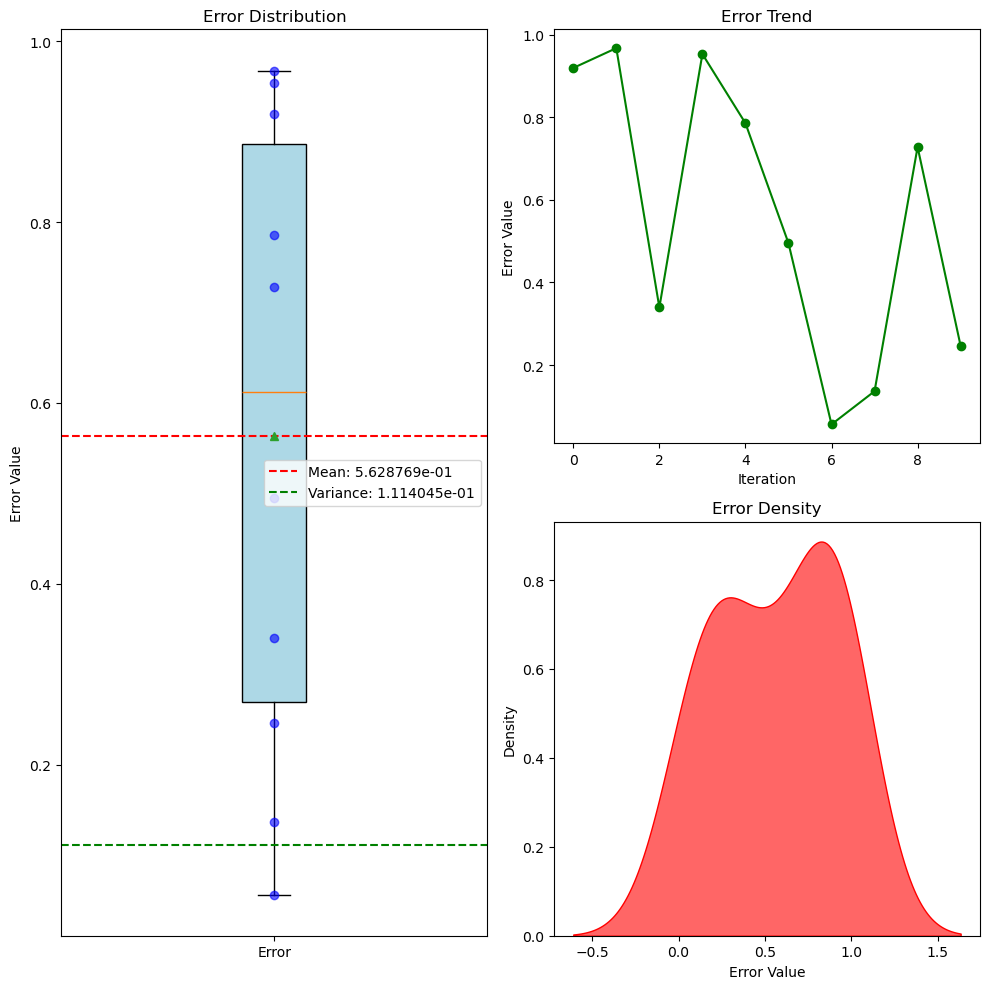

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MAE: 2.546883e-01
Variance MAE: 4.021645e-02


/tmp/ipykernel_2565796/3997509801.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


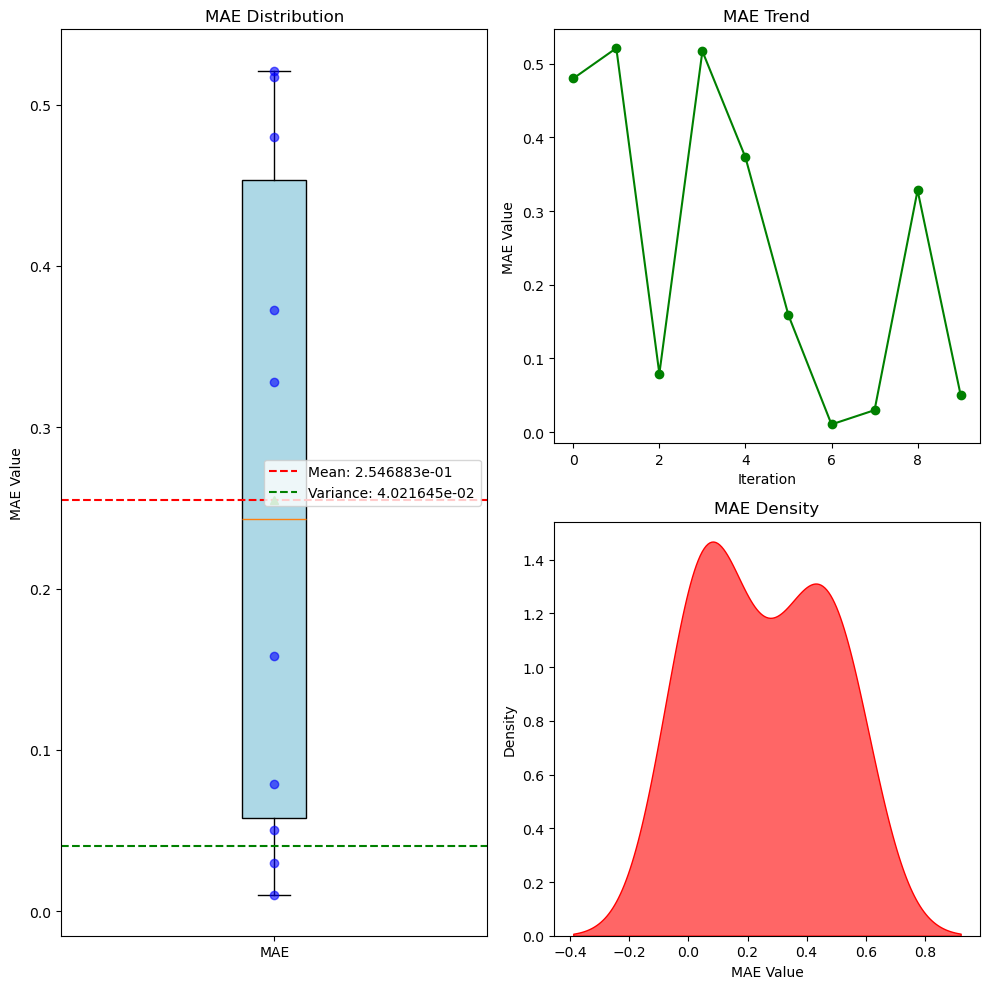

In [10]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MSE: 1.950118e-01
Variance MSE: 2.748136e-02


/tmp/ipykernel_2565796/2305667704.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


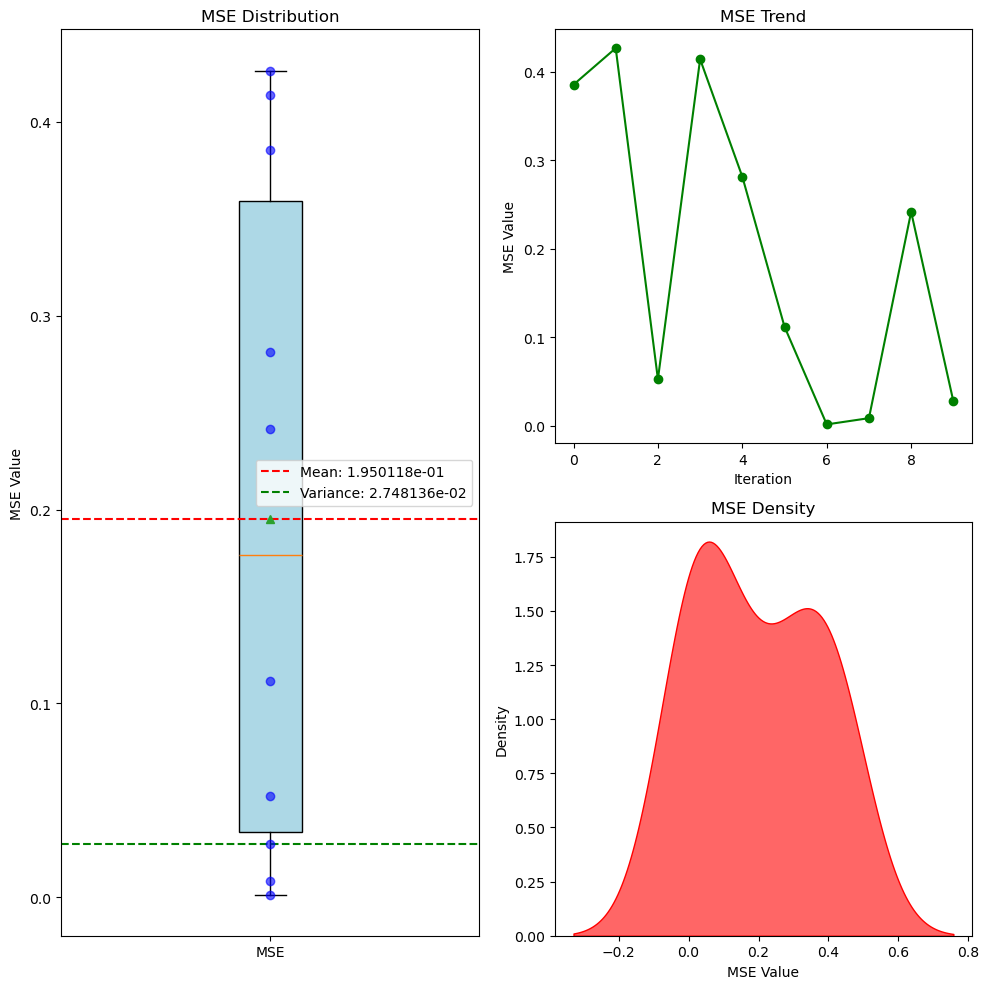

In [11]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [12]:
len_t = 101
len_x = 101

# --- 反向过程 (您需要的部分) ---

# 假设您现在只有 X_star, u_star，以及 len_t 和 len_x
# len_t = 101
# len_x = 256

# 1. 从 X_star 中分离出展平的 X 和 T
flat_X = X_star[:, 0]
flat_T = X_star[:, 1]

# 2. 使用 reshape 将它们恢复为原始的二维形状
# np.reshape 的默认顺序是 'C' (行主序)，这与 flatten 的默认行为一致
# 我们知道原始形状是 (len_t, len_x)
X = flat_X.reshape(len_t, len_x)
T = flat_T.reshape(len_t, len_x)

U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


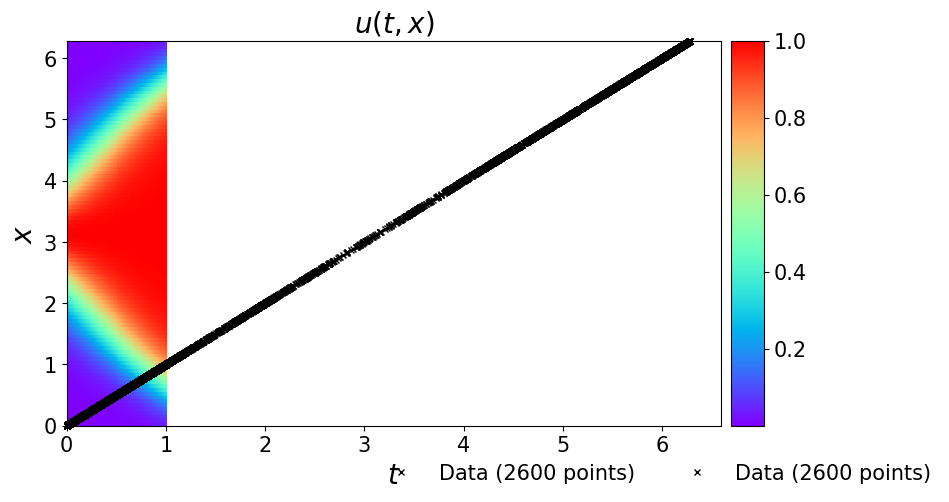

In [ ]:
###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
im = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是im，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(im, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（im）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [14]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()


17508


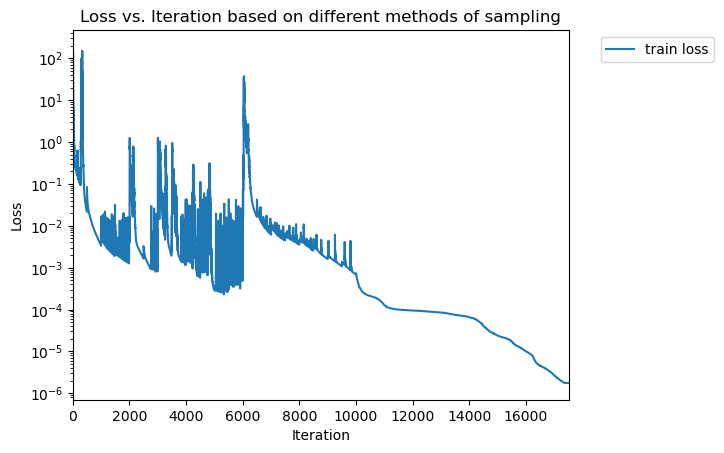

In [15]:
print(len(trainloss))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


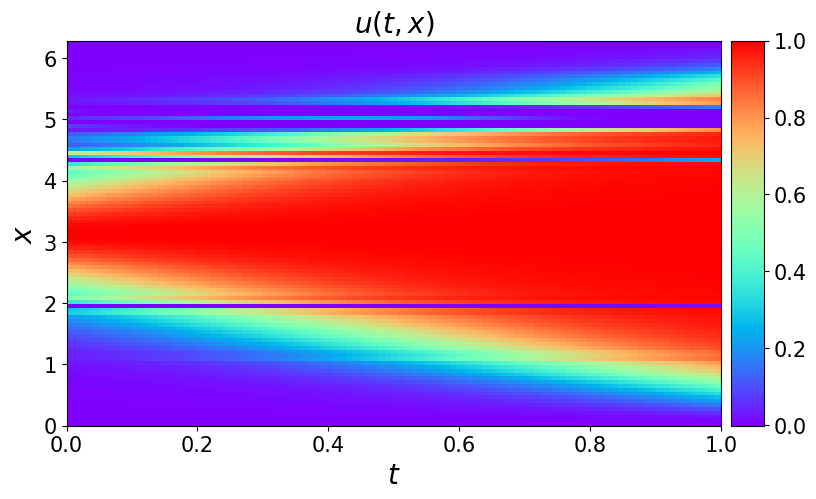

In [16]:
#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
im = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(im, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（im）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

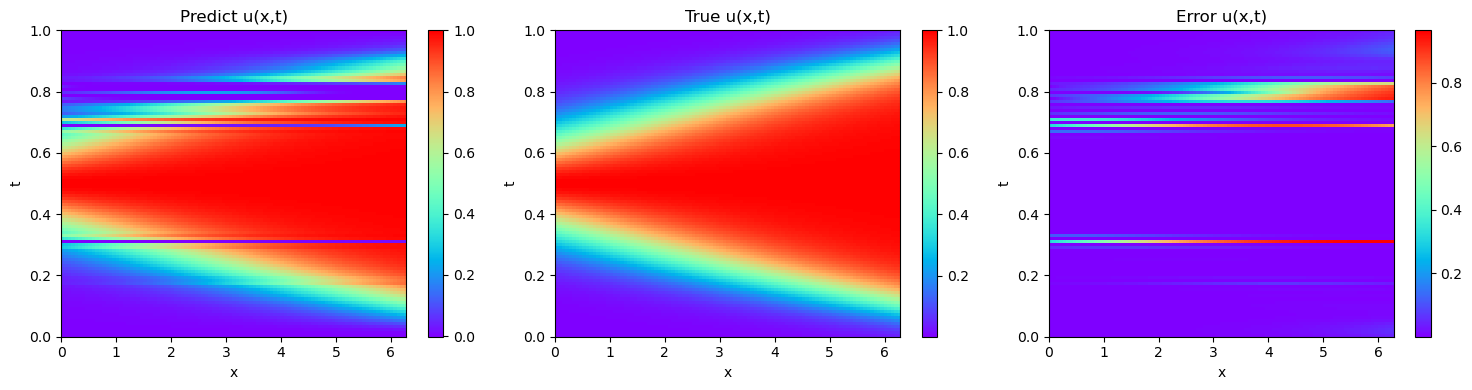

In [17]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [18]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

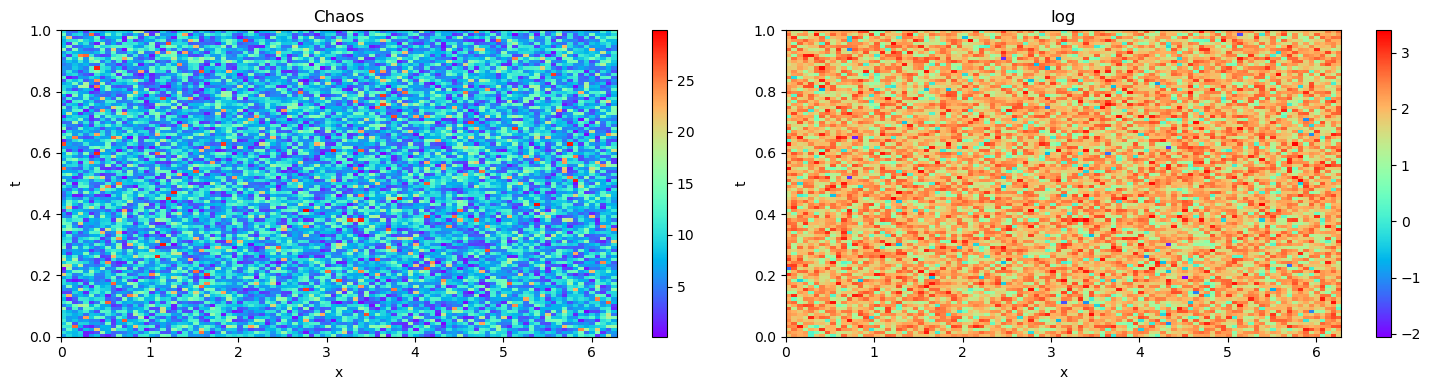

In [19]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()